In [11]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
#import rbf as RBF
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
#sys.path.insert(0, os.environ['FaultSRC']) #add src folder to path for notebook
# %load_ext snakeviz
import lavavu

%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [12]:
from FME.geological_points import IePoint, IPoint, GPoint, TPoint
from FME.geological_interpolator import GeologicalInterpolator
from FME.tet_mesh import TetMesh
from FME.dsi_interpolator import DSI
from FME.foldframe import FoldFrame
from FME.fold import FoldEvent, DSIFoldConstraint
#from FME.structural_frame import StructuralFrame
from FME.fault_segment import FaultSegment
from FME.region_manager import RegionManager
from FME.helper import *
from FME.svariogram import s_variogram#
#from FME import *
# from tet_mesh import TetMesh
# from dsi_interpolator import DSI
# from fold_event import FoldEvent
# #from ffold_event import FoldEvent
# from structural_frame import StructuralFrame
# from fold_rotation import FoldRotationAngle
# from geological_points import *
# from surfe_wrapper import *
# from dsi_fold_constraint import DSIFoldConstraint
# from fault_segment import FaultSegment

In [13]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = -20
boundary_points[0,1] = -20
boundary_points[0,2] = -10
boundary_points[1,0] = 20
boundary_points[1,1] = 20
boundary_points[1,2] = 20
mesh = TetMesh('SectionSupport',)
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=50000,)
regionmanager = RegionManager(mesh)
boundary_points_small=np.zeros((2,3))
boundary_points_small[0,0] = -16
boundary_points_small[0,1] = -16
boundary_points_small[0,2] = -16
boundary_points_small[1,0] = 16
boundary_points_small[1,1] = 16
boundary_points_small[1,2] = 16
regionmanager.create_region_from_boundary_box(boundary_points_small,'r1')
boundary_points_small[0,0] = -14
boundary_points_small[0,1] = -2.5
boundary_points_small[0,2] = -6
boundary_points_small[1,0] = 14
boundary_points_small[1,1] = 2.5
boundary_points_small[1,2] = 11
regionmanager.create_region_from_boundary_box(boundary_points_small,'r2')

regionmanager.create_properties_for_regions()
# # second mesh is for the model area and the points can be moved around. No interpolation \
# # is performed on this mesh its just here because paraview can contour mesh objects not voxets
# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.6
# mesh2 = TetMesh('Flower3DModel')
# mesh2.setup_mesh(boundary_points2,maxvol=0.5)



# boundary_points2 = np.zeros((2,3))
# boundary_points2=boundary_points*0.8
# mesh3 = TetMesh('Flower3DSupport2')
# mesh3.setup_mesh(boundary_points2,maxvol=0.01)

print(mesh.n_elements)
roof = 15.1
floor = -5.4
stack = 0
solver='spqr'

54018


In [14]:
stratigraphy = DSI(mesh,region='everywhere',shape='square')
# for i in range(-15,15):
#     for j in range(-10,10):
#         stratigraphy.add_point([i,j,3*np.sin(j/5)],0.)
#         stratigraphy.add_point([i,j,3*np.sin(j/5)+1],1.)
stratigraphy.add_strike_dip_and_value([2.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([-6.1,0.1,1.1],90.,0.,0.)
stratigraphy.add_strike_dip_and_value([0.1,0.1,1.1],90.,0.,0.)
#fault.add_strike_and_dip([6.,0.1,roof],180,80,itype='gx')
# for y in range(0,15):
# #     fault.add_point([18.,y,18],val=0,itype='gx')
# #     print(y)#y = 0
#     stratigraphy.add_point([10.,y,10],val=0)
#     stratigraphy.add_point([8.,y,0],val=0)

#     stratigraphy.add_point([-10.,y,-10],val=0)
#     stratigraphy.add_point([-12.,y,-10],val=1)
# #     stratigraphy.add_strike_and_dip([-12.,y,0],0,0)
stratigraphy.setup_interpolator(cgw=.1)
stratigraphy.solve_system(solver='chol')
mesh.update_property('strati',stratigraphy.c)
# mesh.plot_mesh('strati')

Setting up interpolator with 4 value control points 
        4 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


In [15]:
fault = FaultSegment(mesh=mesh,name='FaultSegment1',shape='square')

fault.add_point([2.5,.5,1.5],0.,itype='gz')
fault.add_point([2.5,-.5,1.5],1.,itype='gz')


fault.add_point([10,0,-5],1.,itype='gy')

for y in range(-15,15):
    fault.add_point([18.,y,18],0,itype='gy')
    fault.add_point([10,y,-5],1.,itype='gy')

    fault.add_strike_dip_and_value([18.,y,18],strike=180,dip=85,val=0,itype='gx')

flag = mesh.nodes[:,2] < -5# dist>6000
flag = np.logical_and(flag,mesh.nodes[:,0]<10)
mesh.properties['flag'] = flag.astype(float)
flag = flag[mesh.elements]
flag = np.all(flag,axis=1)
ogw = 500
ogw = ogw / mesh.n_elements#np.sum(flag)#
fault.interpolators['gx'].add_elements_gradient_orthogonal_constraint(np.arange(0,mesh.n_elements)[flag],np.array([0.,1.,0.])[None,:],w=ogw)
fault.interpolators['gx'].add_elements_gradient_orthogonal_constraint(np.arange(0,mesh.n_elements)[flag],np.array([1.,0.,0.])[None,:],w=ogw)
ogw = 300 
ogw /= mesh.n_elements
cgw = 500
cgw = cgw / mesh.n_elements
fault.buildFaultFrame(
    solver='chol',   
    guess=None,
   gxxgy=2*ogw,
   gxxgz=2*ogw,
   gyxgz=ogw,
   gxcg=cgw,
   gycg=cgw,
   gzcg=cgw,
   shape='square',
    gx=True,
    gy=True,
    gz=True
)

Setting up interpolator with 30 value control points 
        30 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.009256
Setting up interpolator with 61 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.009256
Setting up interpolator with 2 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.009256



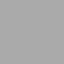

In [17]:
nslices = 3
vector_slicing = 100
colours = {}
colours['gx'] = 'red'
colours['gy'] = 'green'
colours['gz'] = 'blue'
lv = lavavu.Viewer()
for interpolator in fault.interpolators:
    v = mesh.properties[fault.interpolators[interpolator].propertyname]
    s=0
    #for s in np.linspace(np.min(v)+0.1,np.max(v)-0.1,nslices):
    mesh.lv_plot_isosurface(
            fault.interpolators[interpolator].propertyname,
            colour=colours[interpolator],
            isovalue=s,#np.mean(mesh.properties[fault.interpolators['gx'].propertyname]),
            name=fault.interpolators[interpolator].propertyname+"_%f"%s,
            interactive=False,
            lv=lv,
            draw=False,
    #          region="r1"
    #         region="FaultSegmentRegion%i"%s
        )
    gy_grad = lv.vectors(fault.interpolators[interpolator].propertyname+"_grad",colour=colours[interpolator],scaling=3,abc=1,blah=2)
    gy_grad.vertices(mesh.barycentre[::vector_slicing,:])#
    gy_grad.vectors(mesh.property_gradients[fault.interpolators[interpolator].propertyname]\
                    [::vector_slicing,:]/np.linalg.norm(mesh.property_gradients[fault.interpolators[interpolator]\
                    .propertyname][::vector_slicing,:],axis=1)[:,None])
#mesh.lv_plot_isosurface(
#                'REGION_r1',
#                colour='purple',
#                isovalue=.2,#np.mean(mesh.properties[fault.interpolators['gx'].propertyname]),
#                name="r1",#fault.interpolators[interpolator].propertyname+"_%f"%s,
#                interactive=False,
#                lv=lv,
#                draw=False,
#                 opacity=0.5
        #          region="r1"
        #         region="FaultSegmentRegion%i"%s
#            )
#lv.objects['r1']['opacity']=0.6
lv.control.Panel()
lv.control.ObjectList()
lv.control.show()


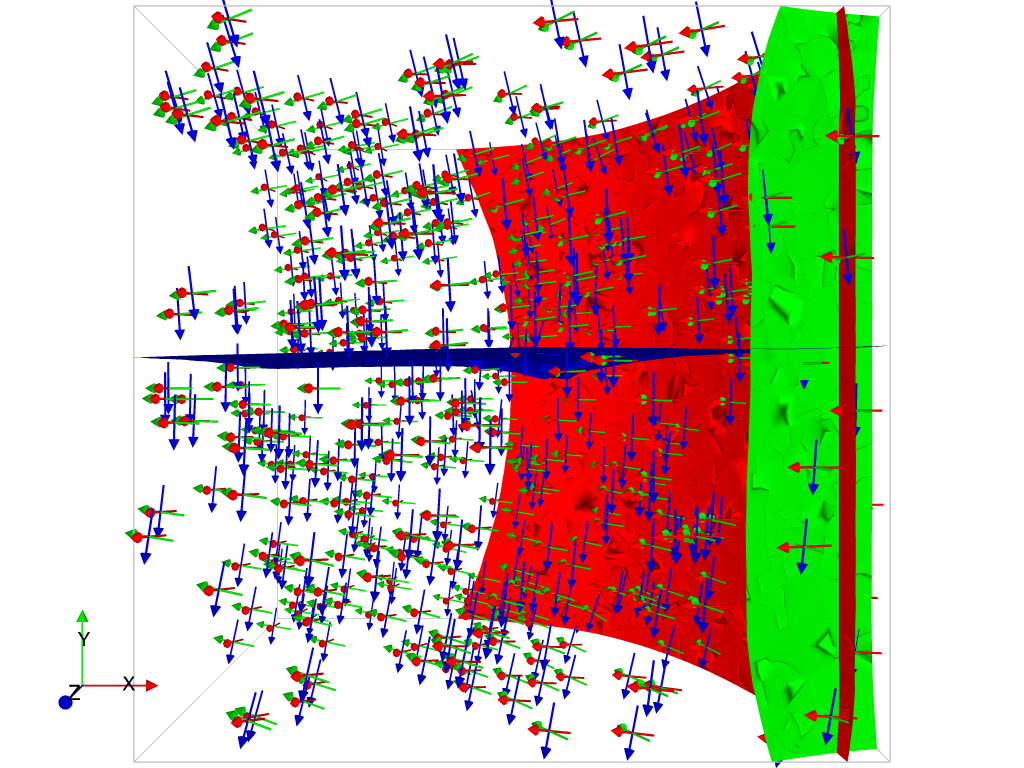

'./data/fault_frame_with_gy.jpg'

In [12]:
lv.display()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABAAAAAMACAIAAAA12IJaAAAgAElEQVR4nOy9eZQb13mn/QDoBb2ims19Q1GrKVFGUZIty7LdRVtOZDv5WPSixHYyXZ3lm8SJIzBxcsbzzZhonySTTJwI9ExWJ8NCcjyJnUUFO97khYVosyxLLEjUbolV3Jdeqnpfge8PNEA0GuiNZG+s5+D0Aapu3XurGw28v3vfxZfNZvHwWHlI0mvp9A0PPfRaPH7bcs/Fw8Pj6iDLp1OpzQ8/fDYa3bncc/Hw8PC4fvEv9wQ8PMojy5OAro8v90Q8PDyuGpKUBb9pel89qwZdH49GXccZXe6JeHh4XE28T2GPFYqiNMOgbW+0LGe55+Lh4XF1kOUgTHgCYBVx4IB1+HCNafYt90Q8PDyuJt6nsMcKRZa3hULnYZ2uX1ruuXh4eFwdJKkeBtNp76tn1dDWVgu1hjGw3BPx8PC4mnifwh4rF0WpgirD8C33RDw8PK4OotgQCvVBs2H0LPdcPOaFJGXAZ5rLPQ8PD4+ris8LAl5RnDt37vz588s9i5WCZQ1ZVh30yXJouefi4eFxdTDNMcepFsUhUWxY7rl4zI1lDVpWvSCMS1LNcs/FYxWzefPmLVu2LPcsPC5TtdwT8JjG+fPnHcdZv359Y2Pjcs9l+ZEkIZnsgm2iOCBJwnJPx8PD46rgptPNjhOQpOblnonH3IhiXTI5CXWS5BeE604D6ON6ejyNH3KLpT7aqtoEnyAFpGWe2Tz4STy+VVHqRXF5pzEwMNDV1QV4AmBF4e0ArCyOHTtWVVU1MDCwZ8+epqam5Z7O8iNJz6fTt7e3v6Jpty/3XDw8PK4Cun7hwIFQONxlWduXey4e80IQ3nTdrUePDspy63LPZUlxso7oim7GxQdZmO6OGglEBJ8gV8mCT5CqpBWlCsYc51lVPZtMvufo0Q2yvIwz6e/vP378eGNj48TExN69e5dxJh4leDsAK47GxkZRFI8fP+5pAEBVQwcPZgyj+qr0ZvaYVCE1r5TPaA+P6xBZbgHXtoOOM3YdriivRiQpk0rVGMbF600AaOOai4sPJiFQejY9mQZSEym4rA3C/rDoF3MPKTClCgTfku5gjznOY7LsptM+uGgYyygActb/nj17urq6HMdL6Ley8ATASqSpqWnPnj2eBgBkuQ5c2241zQuStGnR/WhvatqglqpPhTeELayrN0EPD4+FIQg14fCoba83DEdRNi73dDzmRpbrUikMY2y5J7LUxPvi1MAk+CFTOW1K0c6AnbHtjJ0idflUAPxEqiICguSTCj9zIuGqz7lg/edeDljWVR9inhSs/6amppwLkMeKwhMAKxRPA+SQpI3h8Gu2vUvX31yEALD6rPjpuDamuZtdWmEU54xjVVtinXgNJuvh4TEvJGnStmtMc1JRFnO59qombZWkJm8rb4mQpACMmeb1lZBNH9LtczY3QQYmyuwATDHnbyULkM6k8ZHKpMhAFjJTJ0OEco5DckAu/Fz0poFjmo/J8rjrFo64yyQAiq3/ZZmAx5x4AmDlcl1pgH7LejEW2y7L21W15JQsTyQSfl0ficUW0KF+Stf6tGRVks3gB4fw6XC0JareoAq1Xjyxh8dyIkkkkxjG8EIv1F7TYqdj9gY73BW2mqxrMDWPMkhSEAZdN2RZ/aK4xr+MCsSH4jTAeWjNL//PtPXnY/1n8wHEhUuy+Z/g4qYmU0DuZyedhQvDvrDoFwuhBXNqg5nWvw+GU6myja8pnvW/KvCCgFcWx44dEwRh165dhSPXwz+SpevPqWrQdRshFAptUdX1sZhfmPqM03X7wIFW6O7t3SgIdbN35Yw68Tfj2phmr7dpgAk4R3t1u9qiypvka34nHh4e88AwuvftqwuFLjlOeJ6XaK9psVMxe51NHfQTsR8wP/qtazpJj2IE4XXX3fnII72Ksnm557IUmOPm3u69TEIX3AQjkCm3ZDqfTRH/lBfQVCqh3PJ/iSqYSaWzPoCQLyQFJHxTqkD0ibd83enuiBVb/+T9j+4/cWIpEwGVNVpOnDjhOI4XBLyi8HYAVjprex9g2HEMVR1MJpuhCZqg3nXHDh8eEoTG/IK/ooThFQjr+jlVvaFSV8ZZQ+vXEqMJtkA1DBC2w2pQVcOq2Cwuze14eHjMB1luhXOu22xZg3NWAzDOG+oLqr3eZhv0E3nzneno55yxO/jo0kzWA6bigKsX7bW16tBGNHzgBwHOQCPU5CMBCszfJarsJsDsFLcpfp4FH27WTU2kCJDypXLTePAYP+eW6WYCnnxDr9oukUWuluc940VyPSxZrhk8AbAKWKsaYMxxvivL2XR6OwjQCFUQyL0pNc1SD8GYKNYC+/cHkskaXR+a4R+EM+zoPXq8K54W0myCSbhI23BbdGNUiVwf31QeHquQSCSTTjeYZt8sAsA4b8TsWKo6xQ4YoK2nLSbG5LfJvg+dtqmbj3jwuFrIcu11FQc8JQB8U8tJBPORAIU44EVY/0WeP1OXz8cDY+ZAJT0UdhjKkYG/+8bBf3oLnIbdUzfS5m/LXSv75dzWRC4umUmkrCRULdJL1rP+VxeeAFgdrD0N0GOaT8vydtdthZoi039qp9S2D+3S7LZ3GsatgCyTTE6UJAO1hqzYT2J6QHfXu4RhmNCbIbVWje6Mik3i8tyVh4fH/JCkTDpdbRjDZVeUjXN5078ZBmlz2mLhmLxFzp1ta/OnUo2m6a4ZAWAYWVEcEcU5XByXEUmqhVHTrJQHZ02hj+hu1gWmNEAzWLAdgjDJ1PGFsghva9/059kZpn/28pMX2yr2sdGEV6EH7plqnCJFFiZJTaTwQVXeGByDfwAHbia8KSyGRKoQagSpQcKHWCOKNSIgVotilVgykGf9rzo8AbBqWGMawBeNyq5Lfk3En1+/8OUfMTpvSKUcZ1gQ6hRlw8GD3a672TBOy/J27U1N69dSjSlydYS6aRtpUxtV9U51+W7Iw8MD4Ixh2Jq2W1VbZs0+Lkm+RGLSNEtTqxjnjJgVS1WnCMEgbX1tsXBM3jytK1kOpFJVhjG6NtxRFOVkMrn90KGeWGzbcs+lIrIcgn7XbbasAVFc44Xq9TF96pkvv76e2wEYhtpFmfI5svmvt0X3UJABMzVA5Su2OHAWxPxrX9E5YDIfk5C72QlogFrsSdsesqmGUZJDSQJMPfyXf4arw2KViB+pWvrQyx96x553rAHj5PrBEwCribWkAYKadkGSNrlusMLW5XbsryA+LUcCotgiSe8ObXh+/B3RZ//OEv6vu9FlHYwSOhNSskp0W1Rq9RICengsP69q2rMdHZvgVCIxHIlsNc1KLSWpBkZSqZHCEeNs3vQXKpr++Wv9MJ4TD8OOUyes7rxeklSdTGKambmbLh+CUB8On7ftHYZxXlWvGwGQww8hyEAGgovqcWYuIBbiBVS2w+KeZ2X7m/AgzPTe8kMVU2XOJqEqH+TQBLVFW/P+ItPfP00D2FnbnrSB1HhKkIT317x/UTfjsTx4AmCVsWY0QJ0o1mramwcObIFg/qOmmAHYBP502pdODyaTneA08p8UBlrAZcPjqK+0feKe6K33yKv969/DY21gqGpXIrEDtuZMiHQ6Y5p+qbw4l+WNcBrWm2avszEdO5E3/YcInw7Hb40rOxXgtGlOOk4d2IZRB/Vw0jAanfG/o2976vgPfTRA+MiR5pnhQasHSaqGCcta6V/HkpSx7aoVLlSuHH1Ud7NuqbN+bplqDAIwscAes0WL7gsNACDfvmzjecgAH9S51A8xVPZ70l+0D1AIJGiEIFRPFwDFuYxKHj7wIfm9ZbhVxkr/xPGYyZrRAE/fh/Fg6Oe/6opQDbVQW/SOPNn24c/9aFfL/X/7li536xm2nYSBUOPhn43U/euDXxve+wqTpC6SOgWjoVBIkkKSVC2KGySpThRblzDlmYeHx6jjfFOWq9LpW2FDXtLXgC8eR9MqXdXWFki98bpy/Dftm39ICwyz9Ql+4QifqBF7TNVw3Saog2qYzC0HgA9uhiy8Jb9qOQ6TjrOE93r1EcUqGM5Xbl25SJI/mcys+XJg2og29axYA+RuugYGoXZpJ1TssVNs8TNtY+Fi5YS6VbDL5EW5cv9V+f0NP1RDI9TmBYC/yA9qFiUAi6tc5rGMeAJgVbIGNEDsmVjnQCe/xrpnee8bbIcxGMnbDQH4V+WN/zj8b2whWQ39hLvDzr5vu/9r18+3RW679fHxTc7FVKoBgtDkuv5UaiSVGoJuGIU+2NLWlvMdukVVa7wtAg+Pa0aXaX5flne57naoh5q85eADdP28YVwyzazj1EOXafocpxFOp1KNcBj+7Hf4+zthmB1P8JkjfPSpXJep1nzOlXEYhhEYhJpwuE4Uh6BFklJm7bdSde9rD39E3TV7sMHKR5IEOAWCabqSFFru6VRElps6O0dSqYUugK8mnIyTHEtefl2sAbJQBWNXIACy03cDmMdWQNnSYyUL/1nIckms2Md4QQBky3VIvl5AbmunFpohmLf+/fmzs+wAeKxOPAGwWlnVGsDqseKPx5EA/uhhhI8zMsi2ooXDp9/FF5U0jXCB8LH3x9s+pexVVOWNRKL6hKDcr38m10+vZfVbVo9pjliWa5pjljVu23WwEXypVCaV6kokGhxn14JqCHt4eMybVzTN7ui4F5ry/7xVxTaG62b37RPydkIhZU8ob9+H/qONDYO/o//4Az+kNhw+1yYOgSBJfkEYhm2yXAVNgrB1hh/Rd+On/j21NeCcj8orN3B2/kQi2XQ6aJrdK1kASFIT9EKraXZLUus8r7J6rfjLcafR0d6qXcvZXR30Ub30UInFPDGjGsB8WITpz4z2MysJFB6Z2RIT+WCjBUA/nAIR6soZ7rk6ZRvyRQ8CRUk5is39QHnr33MBWnV4AmAVs3o1gPpV1R2dqlky3EjsS7R9kwPf4/bz1MGXfo/4pwmdD+1/5heTv/4pZwLF2Q3IMonEaDI5mUsNBLSIYoso7py+/mcZxqTjOKbZa5oBx6mr4ILs4eFxhbymqg2JxDvzdr+/nBHigAODIEQiVpXz4qT9+jsZ8dEboKrm7ke/kOSZwS9kty50aFluhqGZSYRWKZIUSKerLGtFe9cIQjAcHrDt9aZ5cT4fq4ZlaOe0RE+CzTBOfCK+6ATzS0Zp+G8xOZt7vGixfJ6UxADMMxFQpaX6gvNPZoZHUGVuyEXjvwpvwDFogtthGwQgCxMwCr3wY9gETTPkQaXl/yI8F6BVhycAVjerUQPoL+ip8yk25l9n6d2Cfgg9zn3/zsUGtt7cdmRMVe9WuRvhV23XbcktOCnKto6Oc7DNMC4qSkWHRzGnB9ZGgkAPjxWL42wXRV8oFHDdqsqOAO/4D/q2Ex4PywNSYjiBAKOEu8KxHTF1t+r7wgnYaBjnZXnzggaXpFAodM6210g5MFHMQNYwRuZuuqzIcnUiUWWac9ib2guadlFLkaIBmgmdDkV3RFe+9e9knOR4svw5X952r4HhhZtO2XKbACUNZu4PVGqZyT8K3c4lhLeYkIUz8E6ohm54CX4IrSDCBFyAl6APdkBwRoLRsoG/Hqscz3tr1VPQAP39/cs9l7lxhh3131SaoQFGAaiGt0I9WJwOhx994IQRMdQb1Fx7WR6BBk27CAhCMBLpgzpdH1i2G/Dw8MghCPWxWK1ljR46dAq6oA9G8oWSyJsQfa1wEvuinahNUEf4TPhI3RHrpyx1twq0tVVB0DQnK45SGUmahAbTXOlG83yQ5UYYs6zquZsuK5Lkg8lK5cCcISf+fFz8ptjR25FqSOEjfC58ZP0RZ78TuzNW3HLIcc5XThG7XGijGlQ2bQtxwCMLN3+zcz1moThzf2b6YxImLj+Ov6tiH40uuNACIWiCMLwL9sEWeAmegefgJGyEDIwWpQAqu/A/4/bDvsoxyB4rFU8ArAVWkQaIJqNurct6qIZc6o4JeAFegF7srC02isXtFaUWJnR9asNVVQXIlJQE9vDwWC78gtAUi204caK/vf00nINzcAEcGIBXNkM3rId6QqdDR+ovm/45ZLkafItLLCPLAQgYxsz05qsPUQzAkG1XO86Kvp189YbxkuNWr6UeVcWUeLD/oN1iM8j+kf1HbzpqHbDU3eqQ45w2jJfj8Zei0Wdl+UlBeKOlZWTv3knLWo6bqMi0/D9lydni40V1K+ekXMBumZfMJQOyM6z/GQKgbA+FQXb/PdyW37vIbWU0ww0gw/0gw93QDFkYzZcFKBv7W+6uRb84j9+Fx8rCEwBrhFWhAYyfGIk3EmzP+1COwyAAmXzI0QwUZTOct+3NpnkBkOU6cG27NffSw8NjJVAvirs0reno0VfuiZyB83AOLsLH/gIa4DQMI9wmqG9RSy6UJD9MLFYABGHcMNZCWnpRbA6FhqDBNJfnA/yErj+tqoNzrcrL8hbohXWGcT53xLAN5aiy66ldiWDCbXJDfaGffaXtidEjMUMKfU4zZfmHgmC1tEzu29dy8OD6w4d3pFKi69bDUCi06Hq41wJr0kpPFqVirfSW9OerAVzhJkDhYKXGJS9nmv6TRamy5iEAECA0I5LYD7XQArfC++Dt0AwTMJb3LKrk9++5AK1+vBiAtcPKjwdQU+pUNfJCAFNvUWaQcghCsK1tNJXaahjnJAlJ2hgOv2rbN+j6CUnatBST9vDwmB87ZPndH3aqb+TBV2h7jsP/kxdvgy64BcCesK1xS6wWiy+RpHoYSKcDjjMiCAsrsipJDeCm02vkW0yS/KlUrWn2zpLU1DD6Y7FGRemKRjdcxaGfj8dfPnhwK5xJJLYeOtQ4a9q0SGQyna4zzR5rgxY/GU/XpGkAH9ueY/+/oxx1d4ymGkhVF8WXDkMXTITDWVFcJ8t+UawWxRtXWPLWMuG/lUJ1+6547bRECZSECM8kdzCTN/ozRc8n89l7MmVmWzzOzm5enmVnww9BqIV1MArjMA61+b+ib7r1PwPRJ87z1j1WDmvko9Mjx0rWAM6YE39/3OwyzYumecG0HXvqxCiEL78TzX5TapqWYEJRqlMpNM2NRgFkeTyR8Ov6iJfb08NjRaEd0+wemzB/KBN/O0PNAOQT/ISrwiXWPyCKjaGQ5bqbTHNYlhcmAAShJhKZTKcFw+iR5XVXPP1lRpJ8qZTfsmYL57SsvlSqDoZzH4ZXBUNVexIJEbZCIwQ0Tf+sZGUsqUqSq+WSxmdM817hhQti48Hgb9B9jhAMct83+MS3ePDZqfXoYbhQZO77RLFWFO9aYeb+TC77/xQzUwP4IFQUEzyffD4FZroAFY7P7nREPvdoielfvBWQwdrNnqfKD5iFejefLbTshAt3FIB6yOa7LSQDnVXzeC5AqxFPAKw1VqwGEGoEZaei7JxKzuMMO+Y503jDME+b5rOmvd0OhUPxm+Il1j+gKOsOHuxJp9dZVq8otihKYyIxnE6HCslAPTw8VgKx78emlglPMnRP6Vk5KJe9Sparkslaw7ggyy0LHVGSJtLpGsPoXvHm5dyIYgYysyfYkaRGGLGsq/PFPeo435Dl2nT6NtgAtbkibrYde/JA+g6AjS/wXy+2v/9lccg0A5Y1mk6vh/8Gjb/MF+6Abg58nf/ne9xmUROJvNomtObN/btX29/DnDCn+f8UMzNhf01RqPt80vkXqCQA5kPuP2u8ovVPhsHG8gPmzu8w89OuNOdibeDLm4clexQeawhPAKxBVqwGKEaoE+QbZPkGOffSGXYcHLFOnNlSFEORyMV0eqdhXFTVFkUR4WUQdf2cqt6wdDP28PCYFfM3TP0l3Xjd0J/X3X9w+RnYefmsUl8+M68kkUyyuIz+slydSGQqJaVZXUhSEEZNc7aQBkkKwTnbrnGcMUGouZLhLpnmD1V1azq9C+qgNh/zCXypnZeaue1FWqGORFVRBvxBOA3PGZ/lZM33PsBNH5Jqf0PcvPprrWij2hxr+cVnA3AW1uePF5iPQV8iAGY6/xQfLKy7F9bmmWH6T+YfVUWypGiEwqOud0YAwOwaoKQv34wjXD4osNJzvHrMZC18bnrMZFXEBBcj1Allrf8cihKAgK5P5cfYvz8Atbo+vEST8/DwmAdCnaDepWo/rzl/6Bz7rWOHBg9FTkfCVeGHmh96ZOMjSkN5ASDL9TC2OAEgSVUwtLg4YOO8sYirrh2S1AADrltvWYOzNItEMtB4hbHCZwzjx7IcSad3M5WTuTgLg3SKD77IVpgAG752E/H38Bu/xIc+xy/+Sfjll4784I1f5ru/G9j7qbCirBzr3zSzsdj5xV07FQAw+zp34WxxJeCCI5CvyF1nFkry61fSDAWvG1/Ry0K5jYLRP5F/Mg5jcwiA7ekZ05sl3qDQxexTzR+UAivlbeAxf7wdgDXLqtgHmCeK0tzZ2Z9MZh1nSBDqFaUumRxfRDJQZ9jRL+lm1oyH49dinh4eHjmkHZK0Q4oRm7ul1AiObdcuYlVbklpDoTOu22RZQ6JYP59LnBEn/mJc69PsFvvhwMPRDVfPm/7KEIRgONxt2yHLGhbFis1EcTydrjHNnkV72ZzUtP6OjnuhFqrL5bP5yQ4+d4DX6zi/lQsRqII+2mh7eE9M3iEDWtuZVCp4JXO46liWs3fvOPhU1RHFha1GmxOmnbFhHkv4hd/UFpjIHylrRs/S1ZxZ/3P4iwJwc5cE8ibb5IxHBjJcLMqLUWz651yA6tx8/9kZw82McyjJU1Q8jZlbAZ6D0OrE2wFYy6y6fYBKSNL6cLgbtun6WUCWm6DbdTcbxpl59mCcM9SXVfGU2NHUcXj9YXNixdWg8fC4PhGEmnB4BBoNo2cRl8tyAOoNY+6POMuxYs/HxMfFTjrtkE034qS4iBGvHaI4AdWz34skBYDZY4VnYcAwWmOxm0CAOqgqZ7x95ef5l18h/TNcuBMGYIBDew8ZHzBy1j8gSRPgX1GFvERRCIcvQKuudy/02qn6XwuixHTylXtUosT7f2ZK0Jy3T830Uly5DYGafM+T0/cBxmGMSxvLDJUpkgGtdtFsS+ZfaZ4zs5eWEzCeC9BqxBMAa5xVqgF6Z3y3KIofagwDQBSFSKQfGjQtq+sTsdhALNZV1nqwXCtuxUVT3Me+xM6Eu8HlNO2n24Vh79PKY/HE48Oy3GdZznJPZI0gSRmonj3+tfK1k3Mao5ZrqU+qu57e1TnR6ba4ITfUPtB+4s4TyubyXknLhSwHwTe7cS/LTTC+aOO7UZYbLCvzyCPd+/efyddvHoSxfCr53BMa84kgI3AXcqtc3Ikk+WHcMErLgS0viuIHn2Es2K/hsgAo9sjPzLDUKTpbUrp6puk/uxiopAFy5OrkHIezeQFQqMtbm3dAKi4BlpMBYzBeOkLxJkAW1p2cHmBQPLESz5+ZFv+s7kCeC9BqxBMAa5/VpQG6TPMHsvzk3r3PSlK3phWOy7IPhnU9a5oTsdiYZW0EfyKx9cCB8c7O4c7O3n37jsbjl1Og6ad05WVl14VdB1sO2jfajBJ5PXKk/0jvLb3arZrYJC79rXmsGeLxC6lUjWmOLvdE1giyXANZwxhZ1LV1MFYpDMA4aajPqLt+vCtRl6CF0IXQIQ5Z91raezSxRbyiSV8DRHEcJmYXQqLoh6FUatp7zzhlxE8swK2xTlFadX3DiRPjDz10KhSywYZTcA564Lk90AR3wB1QLjWrJAVhyLbrHGcF/Quo6kYYTCYzjrOA8DB9VHezbvlzk0VZd4oN4ky5pPtlNwFm3xAou75eBRfBgga4AN+DJ+AFcKAKaqB2RgHgiaJyYOU6Lkx/3cmiqVLh+Syr/pU0wGKUu8fy4wmA64LVogGeiMW+tXfvaCrVDL50uquj46QgZBwHUJRdodBp153Yu/dsZ+eA69blcxoXKpVPStIWa8CKvhQVXhAOBA8kdyRpIWSFHjrz0LHGY6ZkqjtVodZb+/e4UmTZBzWLM1g9ZiJJNTBqmtWOkzWMccMYisdPWdZAt2l+S5JOxGKTTsXNFlleB246HXCcseLjxhlDNuR91r5EVYIGwhfCR1qOWLIVuysm1K3QDwFJaoKRdHp2AZCrGSzkYoWnbvPUvoP9B40+Y0HD1Yjilnj8dsdZd+RIbyRiw0n47d/nWx8sbSn4pv3GJGkDXATBNPsWNOI1RZLWh0KnYeuCfMnK1P/KkYUJGC0qszWeN6XHK5i/Zdf+y8qAmUZ2rudRcCEIG6AJtsJu2A618Cp8D34Il2AkX6trugAYrJnWfaZIqky5AJ2sMJ/Ck0w507/E7q+0MeKx2vCCgK8XVn5M8H/EYmc6OzdCC4SgLrft6brjul6rqoCinEkkeuGGvHdkwS8y93xSzT5g977KDsjAefZP7lebVSWysnb5PdYAslydSEzOXHW2LGBcFBccnn494zhZxxFgyHU3trSMwiB0wbkx4zvh5B9tguF0+kJn55beXp9Q3nCPRCbT6VbTHJTlGkB7WYufjaeDaZphmMilSHRbVH2HWnLVadPMOk7WcS6ZZgOEVbVultjbJUGSQnAWmk3TkaSKKkWSfKlUXfzxv9bNL9jrbBphmLAdlnYv0g1js6puVlXrSeOfvxT7x1tSJWePNB6Rqkp7bmurSaVqDeO8LF/NmsRXiKL4E4lqXR9T5v2pr49XEADAOGwoMvdr87sBwnTHfV9RLqASSmJnS2RD4WUGRvOr+4H82dzP3Kp/EJryC/+DcB6yUF2aFMjafrnjsvoi6Ob1TNl5ZmZcRrnGxXHDPoCIP1Lxd+ixgvEEwHXEStYAL2laV2fnrSBAEKqKwp8ysRiqCsiymEj0wcl8k0C+OIof/Oy8ZN/9Kn2E3whHQ1FliyI2i8t8Vx5rFEmqhf50Olhcjc4wuvfta2xrO2cY4rLObtXgOBPxeHc8nnXdBqidvjI5UpP8252wBZqgFjK6HlDVsv3Isj+drjaMEWubFjsRs5ttWqCPt/wwdGhD9PYewfek9dKXopdMs8orR2AAACAASURBVAlGLGvUtpsKSwzQCn4Yg7oVUF08EvGl03WW5c6SXVN4/z9x4IuHd9rUwTDh0+HYjTH13eoVDi2+U/7ddxpve93Q0KxqKzWeAo40HlGDZXqWJFIp34qKAwYUJZhIjOr6fNPClvH/KfjAjEFw+mJ/rld/kSmfnf6ccuZ1dobFXGifc+XPad5t+UT+/umXFHdbDRkIwhb4ZwhCI1SDrygguJzpn8k/2ZYuKixQspA/WdSOGWeLdU6R6Z+jZIPIY7XgCYDrixWrAZqi0ffmP1v8RWkPfOC37Yym+VVVUbZ2dIzCC2DlitbncyUEIBvaMqGcaldbVFmSl/tuPNY4ktQaCr3pulsMo1dR6vIHG8FJpRaTk/76RJa/n07Xw8a8KX5ZADRz6QN0rYeaXHla8MXj1i/IYpVYuPwnhlEHQ5YlmuY7Nu7svPXz9Lq0Qjcf/Td+4Wu85ZxbRWeh3ybIFgVMjkAvDMCWtrYhaJ3/ovG1RBTH0ukq0xwvOx3tJS32Rsx+j00QBgmfCsdujqnvUa/iBOSbZRk599yatMSAWL6ZHDx8eGyllWBTFBFedd3thnFOlrfM2V4f00sdeIqpK8r3z/RV/5kHM3nb2l/Oema6DMjZ2WNwAdbBLTCW92ktoeQqX/7b8WPwJWiAEATzGmCiovd/7j52HINvw+2wNW/9ZfLOTsXeQkz/yXTr30v6uVbwBMB1x8rUAIFoNNvZ2VD0jiz+/Hy+o+NcPD4hCJ8O703Zb3++6RX662F3fqvAD5PRBx6I3fbbyzB1j+sSWfYlk7WGMVIw1AShNhIZT6c3mmaPJK1b1tmtDuLxPfv2/Qhq8w9/Qfi/i+Nbp7v6kU7/y3t2/VRNW49pBly3CYIwDNXwEdh2Fw/eTJPN/d8g+m9scRmBPhiAmnA4KIqDsFWWhyErCOslqQp2SVJdBZ+iZUSSqpLJ7Mx6wFOmv2CzGQbg623hJ3/d+t7Ple1kyHG6THPMslpEsfUKcvVXsv6ZigMezMUBC0Ltooe46uzf70sm63T9/Hzue1oAQLGZPglN06t9lSVb5PxTsPv9Rc9n2uDkn/fDKNwMtTOCCipZ2IXV9ww0wcchAUPQAnXgmyYASrz/c9Ns6If18Cw8BZvhdlifzyOUKbf2X8n/ZzpeDtBViicArkdWmgYw+0zn03Kdpu207XoIFiU7zjEEpNO18DOkPgjqX2258Oufpa8FtkNNzkK4RVym2Xtcl8hyzlCb5u4vSRPpdNAwPAEwL2R526FD4c7Oi1ADzfmaVH7w3cnr9UWFUHO0P8UoqVDREv4w9MOrb+W1lz+O+p/+931P37Ezu06TAoLQKAhbVkyR2sei0XHTvENVN1TwYiogSdUwXpwISHtZi70Zs5ttNsEAbSNtsVtj+967O5fS/Yxp+h3nnGEIcMEw6hxnMJ1eB/XQAIG2NnK5k682oiiEQm+47jbTHJDlFSQAFKUmmRzX9Wx8rqxI5oRZMf9PZh7WP/k2JdG0/vxuVrElPplvn50KUaMRRMjmc3eWrLUXnlNu0d0Ho7ATPgxfhRFohTrIcvwWbnutzCZAYXPtFpvX7oZR6INvwUeB6ZmOmCEA5lr493KArlI8AXCdsvQaIB7v0fXGWMwtCRoz+0z5admdcD/+2cgv/Zp9c14ABKFgW33iL2lqYOcr7HwWvvOxgT9THlj3p9/uC8E6qIYG4ELHh77cYQmRSJUotkpSUBTrRfGGlVOp0mNtIcuNMFji8CPLtYkEK80vYiUTi91pGI+mUr15V/8pL4r38fzMZPj/81ewmukd4fQmxlrpFulbR9gNx26MvfCbb+fRWzOfuXOvOqMY0rIy4jiPKspEKrUV+lOpesdpiM5We1iSGmDYtqsB7RUt9mbMbrLZAP3sfjL02aC6t1eY/LL2Z7yyk/PP+uxc0NR2CIAAmXwu/0E4C1tnCSW+YiQpm0rVGMZFWW69ZoMsGEXZ1NFx0bZbTfOiJM32ZjDGjTJHs3k/+1ns/hIyRea+r2gdva9IG+Qyiubc/ftgF9RcztpZSrHbD0WWd7EVngsIvg0+AN+Ec5c1wMxNgOLYmtbzUAe10AgjEIDh6VlNy4YIz5zhLK5THqsETwBcvyyxBrCs7lQqpGndxQLA6rXkpOxucoF/3JluuJ+PfY9dEIRRqIZaOH4H9ifAoX93+P2/FNU+8tODz9749oc27xdrf/3gC3A31AObseqAdDqbTnclk7kvwt729ruKigl4eFwtJKklFDrpuusN46Isb8wfrIFBw6j0xe5RBl2XRfGbrnsR1udzoPTdxxszW37h03AegtAAw0SGI9HmqHqvCjgfuJB61GcY43OtsC8pl0zz+4rSaNs3w3oIQkDTmFUAiGID2Eg/FP7xt90dZ2mFPt75DX7rn3iH7dZyOOcT1Z7PSzkC3dALrW1tI4LQJEnjgiBI0mZR3H2NkxrJcjCVwjRXlgEoCHWRiJNObzWMc7PvAJVPAJpdiOlf7JND0SK6D/4DeqABqvNRLNX51aobcmFrRZ1U6pxyrkGFI2NQD3fBIBhwAVogU+p5xHQBsOFM3u7Lwk5w52fBl7TxIgHWBJ4AuK5ZSg0gy1WHD48YxjSXCfVrqjt6eRP2y/8v214lc4ptEIRaMG/l4U+F2m0lujUq3S0BqKcOHvSnzG1G/NbzzlOdneegMRKp/7iZPWeaA5bVY5rDljVqWf0rLUWFx9pCksZSqaBhXCrsM0lSayh00rabLMsRRc8vdl4IQo2uv33fvuegGzaDbzevnYPq/DZgdSG3Sh85g5gLHL3jqLxDLnQiSVUwappL+o2m6z2xmCBJFzStTLzpS5r2fDS63XXDkEtyVANV6bT+atzc7gBOxvmtZ5WA4zimWes4A6aZtaysbb8Od/8P3BZwuO8H/N5XuddiDIagC4ZCoUZJSlnrnrDv2LM/rEZvuHmZghkkqQrGCvWAHWfCNB1RrBHF5qWfTDGq2nTwYFbTBmeRWk7GyaU5ukzB+6VqgQZurmVuzSnnlPYT2AE3TEtTN/UIlDOmWZQMyPnu18A9MDJVIuBiA7dMz+dZkvd/5/G8a10AXOiG5qKcG8VDUOHlDESfOEcLjxWJJwCud5ZMAyjKLnjFtjeZ5gVJ2gTEjsZSl1JsyreYYHgTnT8gfIEH/xf3HWVcaRv4L+q/71KL+5HlWnBTqVrHGYrF7rWsxxKJYUmqArZIEpLEysjm4bHmkeVAKoVhTBYflKTxVKrJNHuWO6f8akKWtx46dKmz04aNwE899O5x8eHTsViz69bkl1CPtMMQjEOuVkhrSQ+tcC6drnacMUGoKT/M1UYQ/On0eNlTj0WjvYcP3wmtBdM/79604f0H1+/g5uNs7SPA4RrYDn7YVJQWcvs/7RdqX/6Dk3U3DQvr2+XTsFmWmwTh5vyatq2fP3hg3SWn65C8dWludiaSFIR+121R1UHDGLLtc/DmsWPvWq75FFCUloMHnXQ6NIsOL+//kzOcZzqfzUJxWszcH/hVuBuC0/1q/NPN8BzzlxmVZMA4BKAR3g6j8CMu1k8LAPDNeGw8lc8jVA1j+bpjVdNnmJ0uBmaXKCD6xfndhsfKwhMAHkunAfbvr04mG3M7s8YJo/OHnVNfj7mPmz3QCgPQFK7/vBrZoopN4sxOJGljOPyKbYu6flZVb9C0d5vms6J4y7WbtodHWWS5vrNzOJXKTj9YnUpVGcaop0MXRCwW0fVH0+leEGS58UYl+qO9wr/8Xscn0mwc5fsfo/MPp7W3Jq2SHtra/KlUs2kO5cqBLQGiWA1DJYV7Rx0npSgbU6m35E3/6unRzG87xW2nphx4hqELeuCFvZxv5o0bOR0kdOm/vpj4fFvbuU8a2ysNLUlNMFwcKzwfDMswx8zoLbP5IM0Hx5nU9WFN80MdkEhM5AzOUKhaktZfYedXjiiGwuEXbfsWw7igquUFQBn/n9xfaDSfWX9B+PI/q+AmOAu3FrnhFzfwTe98EVsNxX/z3CZAFayH7fAs2Zppw87UHeHj+Y2IahiEARgrysBdyGhEuamy8N+MxwrGC1bzgCIN0N/ff+1GkWUgq+vDzrCjfl1FgBaozsdCnYZn4GnEYTF2S6ys9Z9DUfxQretjuZeGcbuiNFy7aXt4lEWWN8El2GQY54sO1i29L8raQNfvDYVOQza3zP3Z78X+7V4++l/5zJ/TOT2jS8gXUoKlAkuSJqHaMEaXar6IYkMoNATNpjnlx+iY5muSdHcqdTMI0Jgv7VpsNT2zg86f4z9/hg/8Fe/7fd6qIz/Op/+cP/gMte3t//AHJz7zqd+BsdmNe1FsgG7XrbesgflMVXtRkw1538l9B4cPGn3Gom8ZiEZ/1NLyVEfHyVSqPx8AO7VuXAiGWXYUxQ9+XS+/P0OlHQA/LCKhUUkKIAF68iW9Sora+GYY0DNfzmlhFzfIlRDOjdUCPghe3ngocT7y5Z+sP52f1QAMwxhMFF0TKKqx6Su6rCA/Zj48VieeAPCYYgk0gKKsBzeVqlaTql1nszFX6TdfA2UgX3xxLlR1PQwaxlRTQQhKkvdO9lgG2tp8UGeal72AZHkD9KZSXhzwghHFJk3bFg4PiGIjoP+a3v629lB/6EeXYGRay2hDVPCXruzKcg1MLHEEtiT5IGiag7mXQV2/GRry0Qv+cubcd3+Ow1/kX38GcwsnZNgIPbSPtp+474T2Hk0URElqhEHXrXecsVmGbmurhwbLqmjjAs6wE3smJj4qdjgdqfoUE0TORKS6K0zaeAkuwUDeJYuCALiWOYcWhqpuhKFkMus4wzPPWpOWnbHLX7nob5KCfV8FO+G1/Oq+f7oAmGdX828wAYMwPlUNINtQxvovNuP9sOF0XpUO5X2Baos81QIzFMNMGTAdLw3oKsUzmzwuc601gCiGwuEu7vlBMpOccuHN5TLL7YXnSfWkKnQwhSStC4XOuu4GXT9xLebpsRpxnKxhTDjO0FIOKssB8BfiIHNEIhOwoXhbwGOeKMpOTWvJPZe2SdonNavTOvLTRyKPRciv7IcD4WhjGScWSaqDgSWuxCxJQMCypjZ8grFY0LImjhzpbms7DV3g5s3kyXwqyElgAKphPXSBQ9tb2zRZE1vEXCeCUBMKDUBDQVdUGNoHVYZRvo3lWurjast3WzonO+1mm17ax9uP7jpqftAUqq/ITI/HPxSJdIMDAzBY5GqeXTn5QCWpNRQ6DdsMo3vm2Yr5fwAfzCa7KlCyCRACByYqe/7Mv8P5kFs+q4FbyLaU0R0lWwG3PQ5+eBHWwVtByIcBBIr2K8qa/oWX06cn+FaK8PNYEJ4A8JjGtdYAilLD8wfaUkcO7TzU3tIeyUa4CF1wHrqm2oSqQvPoxw9BXR+Zs6XHdUI0au/bN2kYzlIOKstBGDGMkmoAfqgt3hbwmD+yXFf8UqgX1HeoZrt5bMOxYxuOZbdmrU3WzOV/QBQbwuERWFdwyFkCRDEDmRK/owZV3WgY648dG2lvPwm5x2m4CA4cfSfUQxUMw21wF6lg6ZKHJAWgxjRn+3wTxXHIFrRHAf0nuvw9edczuxLVCVoJXQwdqjp04p0ntPs0eZdcaPamYdi6no7FBhaeLc0wPhkK/QT6oS9v5+YEwJLWv7Os2dR+3lO0jEtYGf+fYj+WBQUBF1O8CRDObwIsmtk1wMyzw/A2WHfZRJ9p+k9NsB+ezSckrYfq6aa/r5y5X1YJePEAqxxPAHiUck01gCwHGK6zvnNf7O6Y9l7NfNDMfjp79INHH37rw+1V7ZHTkRAh4x5jzn4UpQ5Gdd1zP/SYouxi/LVGkpqh23VbTbOr6CCQMYxFLCR6VERqlKTqOTwNJGkUgpUWxa8FkhSEkbL++kFJ2q5pu3t7g4cOXQqHT8Ep+JNf5Yn7wA8i3AG5tY7phtSrmlab+iL4ZteQklRfHCrgDDvxdFz8hnjg7IFUc4oAkZ7IEeHI2fdYHQPy+NeMl2Kx51U1LctPCMJzPl9m3z7fgQMbOjuzernl8FkRhDrD2A829MNQLty1rW3uhZurha5fFIRMLHZmljaKEqz0HZEcS057XdLEl/dsWhw5y7gZ+mH8yqzk+VxbnGhonFfeO5vpn3ty+9MQhiaoKWf6z77wP+NUyLd0f3ePq4sXqeZRhmuXF0hRRHjdtltN87wkbc4dlG+U5RvlBfazA1513W2m2bUS8k54LDuyHII+w1hSTSgItZHIWDpdbxhnC+9DWQ7BQMm2gMcSIMu1yeSSVmKW5fVwwXUbKqUfrRIEMRaL7bHsv0q8/U3+5DfLdHKo/lDh+VPR6NnDh+/igUeZfEN/Mes0+irk+JekBuhLp7EcK/5qXOvV3GaXVujmgS9z/9OhDwjCpVTHm3TUQx00gg8y0ALD0AuEw35RrF1UuXRJ2nbkyJ6OjtPQAE2QlaS6uS+7SgjCpOuOGMZsa/WKEobXXHebafZI0uWtia8+E2fXXAPkflMLeh/5ilL6FCIBXofbF9JJpW7n2XIEsmXW6IsX631AAGoKL4pPVHg5a+CyFwCwevF2ADzKc+32Afbvr4Imw7hS7539+33QqGkXr8qsPFY7otgcDven03Vlw/6uHbIcgEDxzoMoNoVCva67zrLm9kfSbE18TFROe0lDrwKy3ACjJZUZrjXh8Nic/vraR7X23z/y9G+2cQSmx4aEfKFofRQYdZzvK0rX4cM3w12chpHH3d0n/jVujBnGmFGS9vSMaY6YT72Hf0D9g11P7zqcPew2us0/4Xf/kB99giN/wyfTrpBKiRCAC3AqHD7V1tb90EMXDx2qPnq0+dixt2Wzb7OsuwyjdVECAFDVve3t1dAD45CV5WteTr7AbcKF30B5i/11y+qbpdn+/T6o07SpMIARx/mxqn71OwfnHsA3LSxtwRQ2Acamm++LS5sz/32AQXzZ8qv+FMmA25+YdXV/Fhcgz+1nbeHtAHhU5BrtA8hyNplE14dnKdM4HxSlNpmc0PVsPD53Y4/rAVn2JRKCYXQrytItRspy7eHDY6ZZM/1gIJlsNIzzldKQO6NO/PW4NqrZTTY7sXttKuZ895gvktQMp227finLgUmSz7ZrTNOZ3ZBW36Gq71CtbiuWiukNutvkApGqSKwhJviFLtN8SlWb0+lcTObNHIcBCH3tX/4ivq6ztQ/llcjPnpOyljVomnWuG4Ja+Arc/15erOFWg/ZH+Nkf4YA/EnlTEDbI8pggCJK0WRR3i+I1undNe8A09XS6B5pkeYlyMedKLH8EdyvfbYmfoPIXgKLUFL4jnnvd4Dejux9Nv/aDeYyRWWw+0OJNAH++yk2O4iezrqlX7HnONhMwVj6Jf+kIlc7NnJjnZrt28QSAx2xcCw2gKK0HD7qpVLXjDAlC/RX0s6mj44Jtb7IsVxQ9N0QPZDmQSAQMY2wpi3DJ8jrote1Gy+oTxeb8wepk0l82utLqs7QLWtyNuy0u9dBFe1177IZYcRtn1DEHTXmdfM1nv+ZoawukUk267ghCyDQHHKdHklDVm67diJLkTyaZZ8y32CpqH9ZKDp41jGcU5TbX3QA1ecfsMK/a3Ct++5aj375UA1WkfaQLpYL74TT8aMOtJ2N/+Yv3PP/ffyoU/GNxvSTVVfAXunYYxk+L4pOieKcgLDp4dr6MOM7j0WhvInEzbIZ6qNF1/Y9lQPAJUpVUEh3+bmloC0/Y68+I3/wpu8nm8zzwbl7YM9cwWRiHhisO4c1l2MwuoRktMHRmLtMfgNse56V3L1yHlEPyey5AqxVPAHjMwVXXAKIYCodfte2dhnFRUcJX0FNtJBJMp9cpyng63QcunD10iFjsniufpMdqRJaboc8w5mimaRnoq7Q2v1DyYQDrDOOiqk4JAEkKwGhJGIA1aMXejCWGEmwAgVBvSA2q0d3R4pp3xgVD69H0jO4K7rHxY3OGvXoUY5qT0ACZjo5GGIJeOHvkyKZrOqgkVcOEZVUv7vKTmtbV0fHuojzsOTNM4gWbd5vctpMnzjXz+lbs7ZzeyZtvobeWwQ2hj4dV8dVf6P+lyMkdN9+sLtv+kSDUGcbd8fggtFzTgS6a5mOquj6dfjs0FX5dth17/MArO9lynA0uR6xDtY7Tb5pYVsa2W+E5eP9vcVyg2eajXycM355zpElozJfSXSjFmwDFAqCEzMJzDc1HRdRjb5vu7j9Lb/N0AJ9rXC8H6OrFEwAec3PVNYCiVB8+XKPrA4tbqTXN4VhsKJmsyiXRSKerYCJXwN0wbPAEwHWKKDaHw3YuDEAQynsBWVZ/R8d4KOTOXwCMOU7NrAursuxPp6sNY0xVC0c2wcl0esooNM4b8XPxJEkEqCXcE1br1egdUaF2qltnzNFOafHeuC3YNMMgka6I0CqwSKvyukPTzsXjw+l0I9QXZab3gU+Srq1vuiTVw3AqtZikT73xeNPBg1vLfRNLvJAEkzs6X4AzUA11MELYDcdujSlhRagXzPouGDHNZQ43l6RQPL74vdz58JKmvRGNvtV110FwulL61v0MQR1UQxWdQAtMwBA4YNU39v5lbGvzhe/fW9/4oPSQGIdUae++6f45fi5X0/UV/ZydQg/FGqAVhqCsb1RZYTA7vnIORcXPq8G53HYWbn+Cl9o8957rHU8AeMyLq6sBZDlw+PCYYSzm7WcYZxTledfdDpvyOcwKj0lZvpItBY9VjywzexiAKDaFwydtu3We+aPGHOeoLNc7zk2qujEaDZRTApKUhfGSBERtbYFUqiX2tf9j7Pz7VFUKAYYJnw3HtsXUu9VCM+O8oblaYiDBRthIyAkpI0p0a1Ra5639zxfTvNjR8QRshwzUTE9+OCRJW6/p6KLYADasM81eSVrYKnhLNDouy4Px+FgiUQtVUM2U6IvwIkwkb7+JMWgCF8ZhM9Y+q3C5JK2HM7PkIFoyBOEaStUXo9HJw4fvzeesr5pu3QahB0408/oWzq/jjd1cCmHtYrQhJN+oKDUdZ965B0Y3f2WdIASfPTdX5Jm/3Jp3QVHOQtmV8lpwigRAWZGwIHwVTP8cfmheSK9XwzfJ2wFYvXhZgDzmy1XMC6QoYThj262WteCSPbK8TRT74CQ4MAYT+YRtVYAoLl0mCo8ViCxXQWD2HPyyDNTPJ1t8j2l+UxSr0ulG2x7p7OyZHkw56jhPKMpjonibqYFr283F72fhw//MP+7uvPmXU6EUk7T1tD3S9Ih1n6WKKuCMOfETcfFZcd/gvkRjggYiFyNHOGLdaml7NM/6XxCStPHhh2+AHnDztWnJmXJtbdfW/ydHW1stBC1rMdmHqiUppGnCiRNjhw6dCYVyVcPOQwsnYZgXJQTIwM2wF7bMHLoGGk1z4CrcxoqkR1HEw4dvh/V5AVBi4H728+z5Ce//Rz71l3z+T/nyJ7hwf+Sz9x8xf97S2jTl3rZw+AJs0PVLVp9lj9uzDTZnlh7f/B6FYrqBXIrUGd0uIhfQfAjArfNqeNtjV21MLwZg9eIJAI8FcBU1wP79VRDS9TJ12ufEMPZHIsNgwRCMwWReAGS9aODrnHwYwGzfrrJcBcyZLPKUrj8hy4LrboHNsA4aXHdS03JnL5rmo5I0nEzW23br4c/t4Dg0m+aIM+rEXowJTwnJBw7ydptB2ofaj248atxlKDsUQD+tq6+pOx9t+dNnDgZO2Lc+xgP/O/TVbz5k3mWqO9WCU5DHgohG79y/PwC90AuThTVbWV6KIiGSBFSZ5sSie6gWxfWx2C7Lqn/44R81YUOIU9AHTZzYRXAHL9zDExLHxZILRXEEqk1zzVadW6fr1UeP9u/f3wUuDMF43kMnFxL98p5cwiQYBhc2Y37QVHerQv3Uv5Ki+CGg62OGa8w20jzTXM5fA+TS7TsVwgmyiw0zmIVCgv+ri5f6c43iuQB5LIzF+QKd0LQmQVhf5PIvyySTGIZvQclAnWFHP6/r43r6777Dhz/HyXq4FQIQBD9kZfnabvd7rHByHj7pdNBxRgQhWLaNLDdD/+wi4U1Ne76jYytshaa8Y0YV+OJxVPWiaT4myy2uuwHWQR18kH/66/pI7Cd/bB3/P27IZQNc5P6v8LZv3Pe+7VYVsWdgwLIGbLsBfgl+HaryJTj9uD4Oj7xXDUreWtri0bT3yPLRdLoHWkDIBwAsRUJYUcxA5sprm1QJwpZo9Pitzv/98/ju1M5NY9aFsY18OEVfE3TD2Yf++yTvnTn0fHMQrVJqZLlGlsctqyceP69pftetyf9LBsDaAa0wCrdDkEh1pHCh42Ca/aq64fDhwWQyy+HKNY99MDpr6s9ij52yBvHMBj6ogW4I5f2WSi7MFGXpr9TtggjMt5M9j+Xn7HEd4wkAjwWzIA1wyjBeicVGUqlGWBcOb49GBVUNCIIsB6EvmZxvyXX9lK6P64nhBFugBvoJf+Hrzq9ud90W2JpLnRcOX9tANI9VgSyTSKwzjG5FKa8GRbExHD5t2+srhQE8paojiYQELcWmf+5cOv2cLJ8yzSbXHQMLzkMQOvgbefvffPwATNL0OmqCX/waTcP4eII3pjb8G2BDftlyAkZhDEZhBHyhUMY0ax2nXhC2ezJgUQhCnabdLcs/dN1z0JyzrSRpKTzjJakWxizrKozlOOPCq7/23PFfeWSgYSqNfN96GM0Za8p7S/OZynJzZ+fVGXqFUy2Km+Lx1lisW9eNhzq291EDf3iYkzsBEKfMWYHLe2iSdNa2/b29Qihku2442fUdKm0ITTJ3wH2xB79vxqmZqTdzcSjDMJbfE/CX0wCV0gEt1EE/73d0cScbTlaMMrh8ZEGdV56MVwl49eK5AHkshnn6Aj0dj393376xVKoZmqHWtvsPHnSjUUCSNofDPbBd161ZetAtXX1RFV4SDtQdSGxMsIHQmVC71X6Uo9bHnjSMnw6FXoRBGIOAKC5RJRqPlUy+NO+cYQANhlHqOT3mOM8rzpAqZgAAIABJREFUysZE4k7YBPX57CLF36NbU6ndriuCCDfBVhCgBhpfC3Pkk7/ya7V/+xH2fYWBYU6CsZ2/foBYlP+m8s2dvA5n4Sycg9587qpmaHbdno6O8/v2vbl372DZ8gEe80CSNmraHrgI/ZANhTJLExQkSU0wYNuLCYS1+qzil6r62MGDL9l2LwznfUQK9uaQLJem+5SkehhMpUYXMfRqpEoQNqnqPW+eePJ/tP/pneiRonM+gFxZ5RySNAjrdf2Sovi44yWaKm/RZCqv65c9WJwjiAouQDmLfDDvpprJuy4V95mpMMT8sw8VX+IDH107L0cyu0UeUyWEn19I55XxgoBXL54A8Fgkc2oAyzBePHhwK2yCbbAJQrl0CIlE1nEAWZ6A2rKu2Ga3GX0lKr4qHqg/kAgn3E1uqCvUfqb9kZFHnDscbY8mb5GZ+r6/E47BMPhleenqv3qsWObj4SNJE4Bpli6+jej6jYaxC0LlTP8cZ6AX/vY+Pvur/M5DfPKv+Mhf88WP8yv8PX/wpVuPRsRhtkIdNMNEU+hvfmFTzUUe/DpvP0kL1EJdPpwxV9RpCPqhF7qgLxQqm2jIY54oyg0PPbQBzjG1ML8UCEJNODwGjYbRM89LnBEndiwmfFOQXpecCadwPBbbDRehD/rzwQxT7N+/rdzQtaFQP4RMs/cK72IVIbaKv/tftL96rPfQ5CEuXN79ONJ8RAledjRVlGrI6vq4ogR5z6MVfe6z83OeqWSpzxIGkMnvAExODwUulgGVNECh/9nnUJAivqlQuKxv6lgAWmAchooGKYzcsNAEHF4kwJrDcwHyWDyz+AKNOc5pVb0bWvK+zkUez0zE49WxmKI0JBLjuj5WKOVu9VtxO65P6vZGm20wAWfZ79uvBBX1LWrZOSjKTUeOjHV0nIUmUVyi73uPlcz8wgCaYGCmSGhW1RFZ/roi3Zd2g/myrCV8fz9/8XHst05F+LV9j7iG/AoKP07yrj963zu+9J9/lM2Q7aHt0ke+fOiL4f+v+/Nad/ZXLxsA2/5/9s48vo2zzv9v+b41tmM7tyZH77Qat01KTz3h2BYKZLKUc9m1vCzLj2OJzO6y7MISGX7Lbw8gMnvAckXiWlgoHXGXFjLqAaWUZtQ2adOk8SiX7cSOZ3zf+v0hjyLbsuOkcY7Gn5deraOZeZ5npNHM9/h8P98L0bH18kEotNEw9FhsUIjzpwkmy6OJRIFhdAtxmj3NHjP4bDBiRaiB5dCJNWpJeZPXg6Is27FjfVNTOxRCGVSmLS8hsl8zipIXixWZpr3Q3LE5flAXBFKJFHx1UBd/GtstbfvKQ/6tV09rnKeqdY2NJ3S9UNNWUPT17No7SRibtyk0LfDPLGZx2geYcKh+4xnh1jQRKOnskzPnmPPhArkcKewcMkvRU8zDceiBUsfNSQ0vP8PeO083LKeZ2uNa1N2+hLGYAVjEy8JseYAc8FjWlVAHlVABpRmtLpOhUELXb1Hy4FgisUSPG6HWkPKMssZa07K6JeFJ0MuWti07e3Z2r+vWrtX8a/1zrMHvv3bHjkLokeWL6OG0iAsIIVxQNUc4VlGq3e6TiUSFafak3zS6jMC+wNJ+RX3I/uvPuFvd7jaHqzMIozAGo/B3/0LiRrB523/w3D08/DF8LzABPh6DiS574/Bazwc27Xjo3a1f/eQPhhjel6iTlFvWCLFWiHVCrBdi0fpfaGjabW532/ksphCiCHJMc67+rvoRXX1UXfPkmkhBhCrcJ93bhra13tQqF8uZuwUCN/t8E2A7CjIpOzEpRMUsUxe8TA2i+UAIW1HaF3SKs4MQ0CNZP7t1ZttsSSr2+YZse4mmHeLO/bOy7fPOMLydnPpiqoJQZhJgHIbAgmGHBTRNEjQ5PzmgrHmAzHFynS4SyVNCSWRsrIJRGJx/BuC0iqgAyDny6Za+iIsXiw7AIl4usvoAfaXkhEJtKWqOY/eniinzoN+2jc2bH12z4rNsVm9+y+by+qaqprgnzhjeg94dXTta61q1KzW/xy8VzctUCgSuamgYnO0BuYjLDfMrA3BBqa73WgNW+GhYiSv1/fUtNS12qe095t3aGP7kLQ98A99R6IA26IAu+MVN0EXRPj7zDj4RoriTduiEXriq+A/Qz1N3mTeZgTUBuVwGfL4cqDCMwfN05osAQJIKdP3K8xkRUJQ8GJutfCP8fFj5pbL5pc3R4ihFeLo8O8p2mHeZoVeF5Ep55v6a9lq3+yR0w1DKEHO7JxQl+/1NlkdgXNcXtgzAstoTiSWGcTbCzQsKVXXDoK5nN2ZUNQ/ygr+KQbZy2yScW/2kaT5ALlwDzztNa860EmCeyIOCyYpxJiiDQWeqNJJQBsXQ68xWk8hm4s/P7l/EKwOLDsAizgEyfQBr1FIeU2Rd/v3rpUMeTxd0Qw+MZdxbdi/jwArGYS2H3vPUo+RT+yve20jLRj7tR/m00b4jfETXT5rm/NcQDq9eqNNbxMWNo5q2PxgczrhaHIbPXIE1IXIhJ/jDh+SjcmNBY3xp3G27t53Y1rqk1fAaUp+kPff8J/nV+ze+SV9OG7TD117Lm/8NShlaxae+QfgmEtAJndB2h/eeY3G324Ilun48Y5Y8KND1gQU7+0Vkh6IUKcpc8fh5otMwDjrNH+aALOfB4LRiXGvICj0bkh+UG082xivjJPH1+XZW7jTvMQPXB9JC9cCAZbXqekLTjGCwS9clqUTTXgVd0JUyx4SYVeFAUcphyDQXsBcv4PeXQHE4bJ1+1/MLRVnidnckEm7D6Jy5VVXd0BufOJpdb2ee7P/M/efTJgyHt5MHKTWxl6APRmfxAZIZ5R7zWUyaQZSaosihKo5Bkuok9tR5Ms811S+hH2oPTT2pM7X759MzYREXNxZrABZxbpD2Ad5/7P3xkjiw9emtf/onnnd8hnVQCsMOozoHQp/lx2+EPsRXvM8EI6wu/Lrv/9iGkWvb413xvni8Dzqam0dgzO2WFMWtKAWyfL3fX5iNO2GaSdMcFmKR/3PZYciyHvP7R6JRNww1N9du2VITDudIkiyXezyH4/Hsl4Q1bIXbwqHlP4SfJOIySXtL1xZ/uV+9/lT5YPDnQa5cw7H3PcXrn3r4x9c+ifIk3/mQ84zsZqicz3+FbyTwf53hMp5plnRJEqInGi3U9eNpIriiuGBU1+crd7uIiwqtmvaU319l26PB4OpQqDijk8k0KIoEh8Ftmv2yXGpaZjgRDrWFbLdNJXSzpWhLYE1gk1vpMIyEpnUbRr5l2YZRZFm98XgllEIe1IFL19F1IVZt29be0nIUlgNzKBwoihvaEol8wxjX9WHL6jWMQ+GwV5LOpTaoqpY3NVmalpMu2bp4IMRENFqq69ZM0pcsuz2efQlP+6StnPlDnKe9O1NN87S6PZn7l4CAH8AxyHfo/pm0/tTOE9kmmjmjK8NYn4B8KIYTcBQ2TMb8k5API058N2fGikphBMbOqAh4loXJLvlMRlnExYVFB+AygmWN63oO9Ktq2UKMX15e/p9H/zN+Io48+c4370jcusnDk4lVUAqjMAJtS4mvdDck1MCKgLJdkXe+dDKxbDTw9Xepawct64RhHNX1QdMcMU0rFiux7dFYrCsWS0KZZV0dDM6cNxA4Eo1Ku3f3KErtPJdqGEnL6hdiQT6HRZwfDFpWWJZX27YEVVAGrmh0JBwuCgQ41Q2gM7MXrHZICw+Eo0Spgduh5CCHvLuGdosbphgO+kE91h1j1QCM8YIC7N3E3k0ZeyTgGoBOD59tBtheJgBFGYtGycw8CFENdix2znt+LmLB8Ydg8KXm5qWwHNyJxHgwyOwOAODzFcZixdqTvzXadkasCFUgUXaIu37Ouw3PVUmzN775QIahnwNLYAJqYAT6wIZSr7dKiCoAQqGNuv6LePwkVMwW4DDNMU0bd7sLbLu4vn4ABqDD4+k7t9Y/IMuS17svHl9hGF2KUn1uB3+ZUNWSaDSZta3kqGVtl/+rpf4LcaAM+jO2JRcgjJ3MCM+n4IJq2Ay/hLKpdbiZtb9JR4p0nusZBxfY8AeogmWnGD8jsBy6TxUFTEeqQdm1z85SXjzPFEQSQM6V57fcRVyMWHQALiPoemLr1jq3u8OyFsTwDe8Of7v129Q5/x6BPD7wxcRdT/COL7HpWcrc7sH3qOY2NbE6syXwWCRSqOvjqkqxJK0WYnWGjka3aZ4wjG7D6DaM6ln0NYRIRqPFuj5fEQxdP7x5czkMtLaOyHLV2Z3sIi44HvL7ZdteCkugyKkwIRRi0gHIjUTydH1ECMweM3Q4pOVpCXeCYminoavBX+EPvU6KRsvMp5dww5SRjU7DU+VJ1L4EvfSu5YUCrnbKCVJPvn5og2XTlyREaXPzYCx26qEqSYUeT18iUTtb07HzAMMYDAZzg8Gh2Ujki5iGYct61O/vi0avhKVQnMpexuPGfk1fbgKB0klLc8CyOgwjx7K6DeMus/tFf6KpOkoOlLMqzjt/xHseQhoBEhMkxmDEuXZKvd5RSSpVlAlJqlCUPEm6Mps2VDh8kxCHoFRRplOAdP1EMNgWixU63ahJW5RC1CzEx+L3lzY1FYfDbaHQxeUACFECPdHo9JqfI+Hwo82Bn9xuH6hzfrm56Zrqs7X+Z4vTZyXwpPU418EG2AvFkDeVfJ0O0Y/PIGWnIv3T/AQg1YPwJJTAFVACI6ccgHGog4Qj+0O2/mOumfzvuT+KmSJFi3UClz4WHYDLCKq61u1ute06TXtJVded28GNNiOgB6jI6KZ+LdTCGI8UUOnbcn2H6r1RPWKVqquncFVnioFmolKWK2V57sCbEIUwoGnDM8M/s+y/Cp6Ddbp+zO9fdAAuSTwTCtVFoyuh0DH9J0VmE4njgcC4qq6jt5bq8N69+nPfipXGqIN+vCe8gcqAeqUqFUqAIQ5Hozm6Pur3Txk8sCkQ2BQwT5prPncCVrt/eLN912/YOHltN7gbrEIr+usoClwH4M51q24VEKIODkKtrrcLsTQ1mhB5kUixrp+8UA6AafZGo5VCDCw6APNBp2H8xu+X4vGNjnZZvhO3/f0/bo2tYonNz/eF62x64/Eqx8xaCh+CDokv57H8CT74Hd78JD3Q5fHYspwjy4WynDL015+JCKyi1IRCg5qWZZNpHovFTKcPemGGRZd0UgjnGKpa1tRkn2cW0LBlPaSqxaZ5QyBQM8stXpYrPZ79icTK9O9uTNc/+iX/Q9cmntsJFTAIeY7c5yAUTOXhnKkbMAcFaObfKRTARmiDg3A1uKAwg8+TXsmE8zVOY+RnDtgJe6Aa1kMZpDJDGQrY7asn1T+HHX2j5NSERPqPax+dXQl0pseQ+d+J+YmTLuLixqIDcHlBiOFotFjXk3Na1GcMa9BS71ftQptKyHfus13QDhbbr9gevDrIdShKezze191dLUmn+KxCVEN7IlFjmpYsn408oqLUeTyJWOwMCv58PmKxQl0fmWb5LeKSQbvhnfLUO4WOlpajLS1J+DqE7uDhGkr3c5vG6/6XW9ZKY4R/S3gYlivKUssNf6Pr2WeQq2Sfz4zFCgPrvu5/S6F2QDMkI7g8KBfI/BmAcu/98fJd27aXBq/4+7SOu8/nisVKDKMnna8SIj8ScRnGBauYE8INvbo+Nk8P+XJGq6bt8/uvse0aKHB8y/Q392ff482TFlo8JR8/AgNwHBJ1HCkq0b+irXvoyM/+xlX8L3KpLG+Q5Ze/JL9/taJkaWHr93t1/XgkYkEBlEJpOjYrROXLn3cmZFnyevfH40vPWzqr0zAeUdXyRGI5TDQ1jchywSyPLiEmIpFCXR9dudb4t18G/qci1tsELkoP4/ruTX0f/QNHocohyKeQla7zcpCcaihPG7AcXg33gxtWzUgCuJxS4Jl5icza4udhEK6HXEdXO8eRG3LQ4WEUaqHD8QtdUz0Lsk2SZcEzVU1znEyFk22QXfI8PpdFXKRYVAG6vKCqRTCmaedYMdr/I3+iJEEd5DndTZPQDX2Qh96vp3ZTlAGo1fUpHSslqdjnG4VKTTtx1gsQYgyWalpi3vvnwfjcKjGLuGjhf9bvfX3kF0s54TS5TCEV6PqCn4fuQL+V3y5b3v6fn73n7cu+dCd//jnWHOZkLNYXi03EYgWxWFdLizvyqVJaEwn3Xj27fKOiADmGMS5XyYFNgbAclgvk9FZxxS187/PyU2ra+mdSXMiVWfWrKAXQn7Xj9fmBJBV6vaOz+TmLSONgMDi4deurbHuFo5k4rRX0IMRW8c3b+Kd7+autvPXvee0XufV+bv0RP//fhtfEdr/YX//Snjdc6fevEqLqXFj/KShK9gKAUOgOj6cbbOhNi8N7PIWyvFA90R0toPk2PH45eCYUeri+fnUicR0sAzccuT8U7A0Ge4PWxCkxoi7TPKTrb5WfuKL01825b7mitf7LSqx3KRse4QsBnnoXfzv+B4pgwpGiyzT6pwngzKaHM+2d5IxNmSOkMJPfPwFVcCe8ACdn6QwwMXXAdH4gD4ZhN0iwDgod5Z/cLEZcyjWtdsRAx2eMml61/MzUI9MWf47TWKAgoxviMdgH7VN+Eot9AC5pLGYALi+oal1j4/FEosYwOhSl7vQHzAPBeDBKFMm5x004YYwSZw/H3RCCSARNG5gWxFHVwljMpeucdYRSVUsikRxdn5hnZkOI0ubmgUSi0jRPXqgyACE6DKPfstZekNkvXYQeC0U6I1TyDx8jFOAKKHJY2rlgVfDVf8LT7fEX+vn53c99eONb3vmOd+srUscOWlabYeQ4D7h2w9gUtnbFr3nSrL4221yyPAbjppnFnDJt07rzm9xwf9Otcfp3pEnhQhQ3Nw9l9hhWlGq3+3AiUWFZg5m5r/MJRRmNx6WUQM0FWcDFj2HDqA2Hs/Z+TkN7O41B6IBBkGAMt+VuWhYIXBuQiiXA7T5k20t0vUuI88GSl6RiTburvv5xKITqlMOyoP2PVbWsqalX10tOv+vLwLBl6X6/Kxq9A8oyIt1VP4r95opYTQ8/adOuPypNmOZ4IuGGIrgRvnQlr3kd5YfY8iPe/Gs8bRTAEPwuFS9PEYFSnpTrDNU/pyErpYap76QkL0ZgGPqhFyw4CT0wBAegaEZBME58vXBqd4J8OAjDIDtVvTnOZTriUImY4paknsPlMAb5Uwk7mX+c6gWWGexPdRRuczqH9cMY5IAbCqET5qu1sYiLHYsZgMsLklTs9Vrg1vUsOeWzQ9Ab7Fa7H1Ae2L56u8/lc590cwLawLm5DA0NjY6OAqq6DDp1fbpetRBF0BeNnn1eQggJunR9viwgIVbBEaiclo44n5CkEduuNYzjp991EQ6Mo0bw8WAqcPG8wtffPNljpxtSgdDOe3wPjD1gXmcG1wf9b9oA/Zm2eLEkrRVCFmK1ECuEuCkQeLN/HeTMJtOpKCUwGI+fescatsJHw8pTyppjayK3fZJ74gwhDWVmAGqgy7arMlXJFWUMynX9jIT3ziWEyINCXe89/a6XKwoVpcw0k7t2nfD52qEb+p3SyrToYusq6HXir21QgPVGK3hTMGX9M6n6Wmia5y+1qChLd+xY77QNTkJyQcXNZNnt9XbF4xWm2bdAU5wwjCeEkKPRTVDtsNxTprLUw/e2E/ocr/tOvCYWkxKJIjgOP6vnW9fw3yfehf/hv3v7pvd8m5Vt7AEJPHDkOgCSGb5dyoZORQ7meBVle+U5I2R9pdEO/wPfgu/Cj+AxOAAjUAX1sAbGYChbZ4DUtZPpV+yFQqhzShdynT9yppIgnUNSY4xCNQw5A09Mjf1POSoz8F8AHfC008KzAlaADKtBggJYVM57BWHRAbjs4Pe7gXD4XNoiUqGkrlWDm4L6fbr1fmv3fbt3btq5rXCbt8frLfb+eNOPDxw4MDo6KknFXm9PIlE5zepVlFqP5ySs1vVjZ7kAqdjr7YvHy0xzvga9zwcULnT7zDkgRA4ULraImj+sQcuv+e0ie/IZXED0H/nS3/LEcrqg1+0u2rHjuu/pqqMxJcvlHk9vLAbwbDD4oCSZgcDI1O5yQpTAYKaTMHXrcjgJ1drPngknwurzauWLlY2uxviKOEm8R72ez3yaTXv81f7Mo3w+oFTX+zPGyYO82drEngcIUQZDun6OuX+vPBQKUaPr0u7dAw0NCTgEh6HdCd2eqIBS6IcyuA086CN65uFCFECOYZzXzzkQ8Pp8QHvKtJujZdg5gd9fAqWatiA3rq5QqF+Im+JxGSocezvTGA7dzUca8f8Zr9nB5i9x/W+45zv8+irWtlHenc++zU/wumpYB/fAIHTAM9cDGcL4KUw4LkFWK78owz3IfKcwWzexmUjCs1AJ18HNcBvcCjfDBlgPq2EZLHGkm2YSgU5MXepSKHF8oBznE8nK4s/wAcahMsMBIGOSNDzPOkflQj6MQhwGYSW4oSRDYyFVCD8BJVOGUHLmJ723iIsSiw7AZQchCsGOxyXLGlygKZQVin+TP7Q1ZLzdMIRRU1yzfv36lA+gqgVQMtPsFmIcijTt7COUqloA5ZlW19wQIg8mZrP8zgOEKILRhatDCIWOuFyjodB86yIufgQfDsYH4rghJfdXxFABP76byAO+tQ88sN40K2ZwyITATX9IWne4ubnctvtaWo6tWdOb0U1CUSrd7u5EQjLN7C1OPddYULT1D02NeY1RKUo+3g7vjsEdratajZsN0dfA4Fpdn9KCVFHGIEfTXMHgSDDYI8R+TXse+jQtmXrH728Nhfac08/mNJDlMo9nYLEMYJ4oUpQV4fDa1tbxhobnCzgMhyF6G198HyyB62HV5J6Sa4pugSwnYfz8e3qadofbfRyGPJ5cWV7YlsCqWga94fCChE7cilIlRMqOnchm4n7q43zLzy8+yAsbqOrk4x/ml+9i23dZZlHPb2HoD7zaBZ3QAf2w67ZZZkoTVl2ne+VMfeVO7caVNQkwDB2wBlZAHSyBSnBDOZRBieNXFDoWtisjSp+EYjiWQdDOc6Z2OaT/2Wp4k1P+HHdYQGSE/zNRamdwfg5AApaClDFjTsbUwPjUTmozrv9FXFpYdAAuOyhKncdzAuo0reO8TZqfn5/yAe69twSGNW36w0NVS2BU18++KEWIPBjTtPlSm4Qogf5UGcBZT/pyoCjVbnfXwtlkipIHY6+YQmftOa3l+RbqIBd6YAJ6oHsyIV6lqnnZpBX/SNn/KW652j64BGphCVRATjicuY8QLig3jCnXpJbQ/Pv80nNSYtWDkMeB671d3h3DO1pXtBr1RmBtQC6XcUL7uj7pS1vWRCg0pOtuGI3FljY3jzQ398ZiA/F4KxTG40uam0ebm3sjEUvTnlugD2o2KMpYIlFqWRcs5XXJoUiWCz8XfM9fuj+/iZ9ey4fCGdtcAL58n5I/JQKqKMUwZBjnO6wgSSWatgmOC5FVGetcQpYrvN6TC8QCyhOiQtMKW1t7GhoOw1HohF4YhCH45a1QAoMwDKsQJm986tSxN/IiHG2jPkHVAAzDGOy7LmP0TKN5IiP0Pn+k6nFnPqamUYD2w3Ion2Hrp4Sl8p2wep4jYJybYWQnHW5PN+Q4RcApSy0XxmevXphq/afOL1UKnPUZMDlGAXTCc1AGNU6kf5rpn17YDAdgEZc0Fh2AyxGqmgd5mrZQGYCsSPkAZWXdpaVHYrF8y5qSQRaiCjrOiMMzDUKscLtPnFUZwIVxAAAhWLgyACGWQvsrI+hrjpj+x/0sdwTtRmEel8mgZeWHGjdgr4U1sATKoBQKEolkhg+gKKOQlyoD0A5p/uf80tPSVrZGKiJ2kc2qZyHpS3zYuMEIyJN2fxpClEO/rk9Y1nAwuF+WX2hqsuLxPOdpnI4Z1jm2xuTDXIgV5+7jmReEyIEyXc+e6FhEVsjV8tF/t+4J7fz+n3j79Olbg2XBae8oiht6bLvYNM93vYcQS7dvLxfiHDcAzgq/vxjKNG2+6VbA7Df9e/zqS/NSaciT5ZpweFV3t2v79mcLOAgJOApfexsshxtgPVQw7p4kw6dxJz+F8t9x85jze9u/AXCs6mlI2chpuznpiOZkviYyXinkOCygORSEjoLH6fmVP9XQz82wsHNnBNrTbkChU0CcSdAfh7xZPJaMN1uvP3V+hc7R0+Q9U/+Un4G9MALLHLpVmmjkmrE3MALurN/YIi5JLDoAlx0sa9yyJLB0fcFjRdOQ8gHuuWcMlup6V+YmSSr2+cagUtfPPqokxJht1xpG1+l3BS6DMgCfD9uuMYyz11e9SCAXyPof6zs27GhY2uAZ8dAJCXBM2UwVzjRGLOtZIZRE4gaoy4jEFUAejIRC8WDw6WDw98Hg1eYXb+Hr3+/bIe+Rt45vjVRHbMmW4rwp6v3fZ3Z8Y0MDjMRi2b8jWS5zu7tTrX81bb9td4Dt2A7JDAJB8dR3xhTlfPdSFaIExhbLAM4C/lv9xj8Yu169a8uhLQzjdrl9+b7tpdtFgZi5s9cLlJjmBeAWBoOZXdQXEKpaCn3zZAHpbbr4rVjzwppIMmJa5vxnyZOkko8GPvQRzyfu4olyPhTif99xamupzYpfnNLBT4lq3ogO6NydNsVfTFcAzzSdp1n2wBCchC44OfWVkrROq+fkOrH5maZ/Ek6CBGWZ7QlnMfdn8osyS3JTsfk85/QmnPD86TAgTQ4wBG1QlVE1wFRt0hIbaqEso9dd5n7TKg2SMDSlCNib4z39ahZxEWNRBvSyg2G0RSJu6LBtt6YdVNXzKkOZn5//xjeW3X+/K5sYaEkslhcKFZrmiK73SlKvqo76/VfMf3BVLY5GCzTt+DytKyHyY7GLogxggTo0CeGKxQp1/aRy6VdqKTWKUjN5GtaApR/QjSOGPqrLK+Xw1eGZ+4/r+pXxeMkMKfcUhuLx/ng89cWvgs/CX70eo4Syg9z1M+67HznBBPEkTR1I8Dws+6ogNhV7AAAgAElEQVTLXUPPOIzB+oaGG50cghCuaLTGNAfD4VuEeMS286EE3BnBtNGpyXsX9AmxYWE+p1mhKG44Yhjn2+1/xUCsEwJx2t0UxRWP5+t6pxAXgB4ty+fj+5XlCq/XjMcrTbNXlmdVHdWP68HDwVhOjGJ8SV+wNihqxRlNJJVIj90d/u8H1RZhG1N7IfzZ57h+DyYsg044CavhTp5soX83r07f0w+kwuGj2boGZrKAUr/LfCe7OD7VDgaqoMQxpfOcjjdk+ABpfc3j4IH8DGXPaXDNEsWfhhwYyti/9JSg9mnhggGwoXyGWzEdYxlOhWvGHymkz3EACk4tY7EA4FLHogNw2UGIlW73QdteDh3nvCXwfKCqdY2N3bqeNzo6mp+fD4RCtqYRi1UC8fiSeHwIxsGORn9zRg6AECXQdyYsoJLm5v4L2A0gpRC/cCwdIQqbmxfQwbhQkEok9QZVvWGua7fjTuULr3P/9UO2O0O7L41fKfzQS91+cpLkjjD6ws3H/un9fyJ/870nkzmQI3MwEcudrC+wijg0xA0Jrl7Kkyl3YiJDSkiI3Gi0QNe7A4EVodB1jY3PQRGUORZ/ygHoh0GnuU6Ox5N/QRoC+HyuWOwVUhNy0UKWxwDTPIPG5Jci/P6ipqYyTTsRCGRxALRDWuhkKOaK4cI35guuDoo6caZTDJrmXr+/JxZ7Fdy6mwNP8IMO2q8DqDvMfV+d7Dn5EpTBJqiCHNqWsrudjftZdQWHn86sAJ5pdqeZ8umq6bTCZrejNJCynQuhGEac+0hmKXDmaEkYYbIh5tyYjw/gggpog1rIgQ6YI66VMaDLqZoomxrBz2reew6SWAkTqeqojJ7EmYH/NEbm7b0s4lLAIgXocoQQY1AEE+e8JfB8IElFXm9vIlH98MNPj46OKsrPmpoOxGL9TtUWjp2U9PlWn9HIsuz2eLpisdxpBQazQYiVcBSqXrllAMteMWUAZwr/t/w7/tL+f/dyCI5DV0ZfzHHQ/Hz7U3zti+4TX294lfZA+d/84PjuhiWrwz5dv1PXb9f1P00m35VMvj2ZfGsyeYtPgvzc7d99YzL5hmTyht27r9O09ERClMJwilrj91+5bdsK6HCiiEnIcbtHPZ4ULzgVb8wRovKCfCZC5IA0TbNoPrAGLaNnXtI2htEnSWPB4NEzX90rBEKUwegFlHw9h9gfDvfMciaqWgr9M1lAYTMsPyZv7d4aG4015DXsWrZL36ifqfU/aln7AoHH16yxUiK+AFxxgo9tJ3Qfofv4WBMuGIQCuAk2wXJwQyXcwa+h+BE2A/vT/B9mMVtn8vsLHGWeQeiEE9AJAzDg8HBwkgA5zrApL2IMRqEPSucU6kljjq1pclGeEzdISfLPD31w0ukPNlMvdNq0pYOweqq3wyzWP7DYRfCVhUUH4HKEEC4Yg+FUS+DzvwBVLYCy556rPnDgwO2358JLTshlNGUhpTSHFWXJWY1cM//2XpdHGcCSzKZUlwNCvw7FTsRw85/bCd/IIeh2nuY9MACVV23ZObbTvNIMXx1WV6pCFMHw7N0ASsCV7qK1QlGKMxSHFKXS7bbSXlYodIvXOwGmY+67FKVM0+50u49Af8olEGLeD/NzCiEKwHVGTQCtQSu4Nyjvl+uH680x87T7SxK23W8Yc9s+r2TIcj70ZzaPuxQxbFm/VtX9jY0H6+u7sqWJZbnc6+2Ox92mOfm7CB8Ky7+TG3saE3mJBhpar2kNXxcWy4RhJMPhUzfkA7p+VNcHprbjSGPUsg4Eg4/K8qGWFmY3klMNbm+AO2AlVEKpQ/bbyCMwtpvNQJuj1jqrpZOu9E0hxQJK+wApqbE+GIQBJ4SAw+zLnVEEPAr5U5v4noUPkHkTyoHhqRpB88CE81HMDP9nGSMHDoKUMUWm9T+tzmFq2lJ2yfNd0yIuSiw6AJcjVLUGLKiGiQti+wqRCyOPP164fv36D31o9bveVQoHYABGnLbjuZCcJ5W/NRxuDYXGLItJ34b5y1NkdgMwOo3Q0ZB4Sagd548XtdDdAIRwQVFap/JygHHYaPpZE9WTT+J//xw772E/dIEFhyn/7fYfttyj+df6paJJO16IOjgejxdnzR3J8hiMmWbJbDMqymhm619d/yO3uws6YDwV71eU6sCni+ElGIMJRTkVSdPbdHWPqg/p5+z8Z4cQ1WDNMyNkDVnB/UG5VW6ubrYL7IbjDVLy9JRfWS7zeIYMY2Gl6C9myHKZ2z0AZYZxwRo/v0x0GsbPFSUnGr0aVkNRNJrMZq+rKlAe/t6R4DNB+Sm50Wps60mIhz1Pntj5j7tF32fDZjD4e1X9df0dJYE3/kaSfudy7XG5kps3D2/e3D+TlWhZTweDv5LlA83NY/b0j24a8SQfyjM6hWUKY97ME9C9m1cDB9ISQLMRspIztIDyM/Q6U3XD/c5rMMO4T0419FP2cS8sOXNd0bm3lkAvuOC0WWpnqBwnPzEtA5B1Ks9vICebx5BZ1jxLLzE5Rz7dmhZxUWOxBuByhCxLHs/zicQ6MMPh4Zm3YtMcDgbzLOuIpnkWYgFCrHC7zWh0IqUL9IlPEI//bs+eA3Ct05MwlQE4DS9/Tzi8NxgsTCTK4XhT04qGhnuDQWiffz8BIUqamwcSiUrpodX2xsOUwSDuTjd1L/cc54mFLwMoam4eeeWVAcwGa8Dyf8/PSiiCTqhmqJQvf5If/jl/fD81+1d94ekHeptbW/1dsjzFvfT5XLGYpOtdqjrd0FeUUuhPJIotazArd1+InFis2DD6U8XWklSo66+ur38U6qg8ptd+WX4ymvijhPsvPmB/dY3bnacoS60hK9weDtmhRF2CZcgDsigSC/WhZMDrHTWM0/w6TNsMHQuFc8O22+Y4De0NwTVBuUKe5xSKMhaNVphmjyxfmETHBYeiuGKxIsPoUhS3ZY0bRp8s58vyrA7kRYUXw+G9jY1XQZ2jmpULLk0jEHhJ10sgaVkdhlEO95qdh8pymr3fwGVXdPKRCH8SRRpM5NCYMimTsATuhSGbAcjzeJBlCwpkudLvT884ZlknQqGRUGi3bS+dR0lqCqmcXinUQJmjs++CYobX89gB3vgIN+2+/Q8AozCHOGpa6zM1cZoFVOicQy8UOB2gR6EIkjA2owh4PKMyOBOnJc2nVfYzkVYcKoY+qDoD/c1pDkDW2dIoPe5UCs+MBied3EjaE7iM4kiXBRYdgMsUqlrQ0pILyXhcsqwhSZqisGBZdiSSByWG0a4oSxdiAUKMRqOrNM1UVXn9+vVf+crQe9+7d8+eKiZttxxIzu0A2KYZa2xM9SyvgBIYjUQGZNnna4jFqk3TluVZb5lGl6HZmjaoxdfFYQ+ssZ9Z7V1RpRapqqQqV5xX0RwhiEZrDeO4otQuwODL4KWX02Ht0kLwV8F4YXzyyd0Dw1AIeXR6+PJH4Cvv5OlKeG6a9c+kYlK+ro/M5DsoSg0cgKWG0S1EVgeguLl5TNdH01aNolQ3fCER6XwLW3bFqibr8gLbVmu/77ByXf79H4uMRqiDAjxtnoA74F/unznsQkCInJaWCsM4mfXHZfaYQTMYyY2wBPdJ9/a+7YErA1LhmWl9WFY/1BlGjyyfmzVfWrCspCTlQzIQKG5stKEb2rZsGdC011zopZ0Gw5b1TCBQEIn4nCB4OrLe19R0pKmpAEYgB2ogCbXwcdjZepf69af+/CcDV2/yDWyiHZYLMQBJSapWlBH4uT76webNO3Z0BQLTwypjltUeCrWHQnm2PQalGdZyVh2aaciBfjgMV8EYFEMq83sjuw6w9XvX3QF/OP1pT8sAuKY6ACPQC7lQBFUwDOUO2ydzcUkYBmmWzmLzLPmd1lgghVzod6QE5leAm5MhN0a2/05BccbX7MpYxsTU1xiMQMFiBfArCosUoMsUQuQ5oga1mtY+baui1LrdR8E9H266ccII7g+KF4U+rM9/AapaBLkp7k1+fv7NN2/4+MeXl5Y+DX2pp4zPN6u6HKCZmv8F/79EKfKwGqqdrotjodAWMQglmjY9Y2oNWmEz7D/ol16U6nPrm5c1x5fFPeMe96Y4FDY8+yXjWiO4NqhUnW/JzMUygHMJCW+1lyEYhTE45rzvSv8vz+fL4tMKUQRDs5UB+HyFUGQYQ0C/aR6Z3ku4BjpTPC6zzww8E5B+K0XuDvAXuyjH3ebe1rttl7RLKi20/t9fJv74i5GqCEkauhp2uXaZ9WZgbSBNRjqHSGjazyXpWUWxwuEJy3KWmgf5M8sAzD7T/4J/TduaSF3EPe7e3r3dXGMG1wXP1PpnkuA3flmxzlLQtE5VPVZZeTIaLYVx2z7VpUqIMy5nOs8YMs3jQlwbiVwDbqeHVdpePFbOrlvYfbvnmbf4/uHdBD7AH3+ev/yC52/eEuEDv/bdtv9NA8krdN2r67fpuhwMXh0MXhMI1AqxUog3+DdCzzTBiTHLOhoMPiPLx5qbk7adB5YjxjPtFzgHR8blcGSGYBi6YRSSUM/jMGxsmF/6ehoLKFXgm/IBUkKcqaLaTuh0qngmMhyAtK3cCxWz28dnVxTjctaQ5zg388Cx67No+s8Gz96pVKHkVAdgGPqgA56Fl6AGyKAAueSzOqtFXCxYdAAuFxwMhw2/v8+RdBCiBo5BDZzQtCxFgapaALlzkOm1Vi3wYkB+Tq4frW9e2hxbFgsNhOZYwIFw+EFZ3uv39+g6k1oZlqZN3kfz8/Pvu++Or3xlXWnp86mIh6JMz5hbA1bYDKv7VKlV2lq1VfPFDt3CHwSVjvVfCHm2fbv1MxjW9cmbnnHSCLYGleeVyq7KxtrGSF3ELrB9nb4dXTt2J3ebshl4/U3pMoALgvNSBlB4RqWfly5Cd4aMdxmtDa07bt6xpWoLT8NzGZufFpArxPRI5AuhUI32maXsiceLLCuL5SrLw5BrGOPPhkIxRTnY2PisJHUGAmnD2ufLSXh+Kp4Sa15a0+JusZfZ9LGle0vDI1/VPJqVb222NzdVNCW8T3vufWiHvaN7fXf4yrBYJhbmY0APBJ7eurXctnPi8d7Gxj6HAaYoRdCfyQLSj+jqHnVNx5qIFPGMeXb07jCvMINXB8/aJxGiCrovt4YD4fC+rVt/F422QX9GHDh1F5pQ1VVzHXwRoEiWl4ZCfR7PSDa5+c9UbPvA3hN/fffr3/y3sW/9NU+90/NBdeeDf2Vu/8TrYSAcnuveIsuS19sXi+Va1hCO6f+sLLc1N0/YdqrAtQi6MxrsnhaZ++TBcEa7j/1cvRsV+rlu3+Suc1fQJjO6AaSQEgMtgFEYcGLwx+EodMIEjEy1kscd8Z+xOVc/fx8gcxCXI0lUPmPTLBiUshQAzDZ/ac9U9c/M8xqA5+BZGIS74G5YnUEKWqwBuPThSiYXMzoXEXbv3i1J0po1a87hmId0/Um/vyiRKIUyqPJ6lwaDpaoqxL5YbD284HaXWNb0GcPh/Y2NKyGRTF6dftMasLR2TZ/QtRHNXmJTAuPQibffqxap/mV+uVyeuYAOw3hQVUsTCTeUQglIXu8qXb9RdMfj7tbWHFmeNDVGR0f/+Z9/+clP1sH1O3f2+P01gGmZmqVpw1qsMEYNuOAEvmHf1f9lvu2bCeUkRVNZlM97PJ9IqPtuVO66X9dGNbvGphAG8NgeMS7UUlVUiZRxY1kTkpSj60c2b66AntbWkrPuBmANWtoxTR/T9VFdv0aXc7N8DnNAkg7DqGWdZVM20zL1Xl1doUo5WYw2XT+2ebO0ZUunpp2ZrOo0GMa4olx66ubK1mC87HHW1vCV7bR5oOOBB5KqKqd3eMLv74xEUiTbJ3hD9QNfUdXl0wYJhVqbmlYtJ/rv3LcE3JBqLyDt2PHCu0XocEgb1exKmwIYwNPj8Vf41SpV79dDJ0OJZQkK4QQNeQ3+cr9YKhb6lB8NBk80Ny+HOihzChqLu7tdkgTI8jFwmeYy/ZgebA/GKmMU4unwBKuCfo//nCxAklptuySZPF+VNBcHhPhpLFYEtbAMShzeRpfHc9Q0b7/Qq5svOsPhrkCgxLYLocjpZ/VHdZ9+pOPjvPcD3r/8bbAuqK46xZOT5f2JRHVra94cJR+BwMGWllXf33nwNvN/jodC47adSTlxQS38CJY5yjrpvrRZiezTxPfHIA/c8A1e9T0+0M4GqIAyfvgWbn98sgtfzpymc4rhU5zhgvRBO+yGp5zExADkwUZQYSBVzJ/BiS+GckcndA7V0bnfz0oBSsIQ5EIhuFO6YrOfiHPgt8qneD1z+AB7budTP804PO3S9MMe2AArM9oeT2T8AbuKdolcMftqpqC1tdWyrPr6+nnuv4jzgMUMwCscT4RCv968uSSRqAAJJMiPx3v9/gnLUtXiVHjEtms1rXXagaq6Eo7DSk1rNS0z9FJIPCcqzcpGqTGyNGLX2Rxny9EtO47vaF3SatxgBK8MZrX+ASMUKkkkJKiEJSBBbjw+GA4LMQ7lmtaV3jM/P/9jH/ujT32qH3pZuT+wN6C8qKwZXtNU2xRbFmMQfgc/ZVfhLv1KvUkJ5pzEdjhDSedR0ZpINNDyJ6WNkSURO9e+4vtsf2rbE927fvgFdftPlTeWTFr/gcDxyspe0+x2ugFU63pX1vXPAdMyQwdC6vNq5b7KxpLGSG0ksTwR7gvPfdSwZT0XDD6lqh2nusmmugGcmSSr0W0Eng8o+5Q1Q2salzSGJrJnYIRYDm0vs844GOyorx/XtLaXNcqFgL7z790/fj+f+iRtK8EFY2n6+4hlPagoViRSC3VQA2/hZyv0/5k5iKIUw9Axrq+D5bAMkoU88Bo2FTfVt9dHKiN2tU0X3kfve6DkAW29ZiZN0SOaKpoSyxOeLs+O3h3da7vDV4TPg/Xfrut9zc3XwXqohlIohkLoCQYP6/ohXd8s/7YjZ7fYIzaPbY7Vxsp/z9//vOGXdvht7nMmfiVEEty6viDdLS5aaNqr3e5usKE3o8EsQsy7fvMiwBK/f7Vp7vtwQ7wAEw7Bf27lka0JSLL/WnW9mmn9A6qaBLem9c4x5jtF33bes6RxUzrqn+u0001xbfqcutVM63eeEfNUJUAB1HOgDxN6JiV7bn8cnAzA3MOlrd70xCmjP9WZphyqoA6K4Rloh1HnVQAVUAEFMDS/5IVrxmsaZg6S57gW884hZJJ/5j5ITidIpyU09sGtsMrxscYy8iSLQeNXCi6X0sDLE/s07UBT02qogXIohMk7r22PhkJCfT/0pdoFzmwJLEnFXm9PPL7S//2v2spnWDJ5o3Ufdav5qsgT6np1PiSBXtNMRiJXQoWj15a60Y+FQmr47S0tY7qekylQ87efePGpx2+F5xtvvJ1iGMTT7RHdQuSK0O5QPC8ObH5k8y75UDD8JxU881F2rHBkofNhz/W8+4fc8a9XHv7uZ7y3fvf/HPiBNMQALftoqYZ+6A0Ga1W1NhRSlFGo1PV2v7/S5yMWK9T14QxpirlgnDC0k5rWq8XL41RCAQxDJ94hr7/S71811ygHNO3pQKA4kSiHQ9FodyCwMhwWYmM0WqjrncrpChCsQUs7rulJXRvT7BqbNU5yo0+otepszWJ8vmQsVm0YXfNUVp0JRZkAl64Pn//W0S8TklSo6776+kdhCZS63WOpUOVJw3hEiArbXg6VTrAzH9bp34e/njbIWsmCMagdoe75Kzu++ya+cx/UQC70UfUY/sEtP9z2VkudCN4QjOfGqYUTNFgN/jK/uEGcz/Od8PvvcgoBM6nAwy0t+1pagHeBfDfBcpSf8JavsfFpkkQOEnlpquT3BIjduytOe0Vmg6qWRKN5hoEQ5/LULnJIUrGm3bZ585NQCJXpsLMQ577AY0FRLEn/9xrzd3/F62xuTPC5IMRegHEG62B6lMTvr2ppGQiHh7LqjA2bZlswmBeJvAlwLsVc55XSqymEw1ACLscEncPCnFkh4HICQFfS+R984UMU9HEn1+2f3GM+Nk4mCyhlL+c6HJhch2CKIxCUgBVQ7LCOxk9HsjktMkt7sxYQp8oAls5jfGeorKSn7BQg25k3bf33wEtwGxRnlEbMTGskkbjELuxFTMOiA/CKxYhpnvT7N0HZVMt7Uu8rFPIGAm73MdteC0c1bTzkhI+1Vk3r0/RcPbH5DuJh+7FbycFjetRCVXWr4npxRsvoM00vlM3QdnAlErebD7rdr9H1fGvA0o5r2rCm5+u26008vpPVh686etVree1fLP8LZZ1iDVnihyI+Gk9fsKFD/xiLfb6Ed6ieHfkJqqAQkh7Pko8GnnAL+V+vrvxKrzdXecfz//ZjVS2JxyuhAtxQYtvJSKQfRLAFBnV9wu9HiLxYbOK0rGW9TddOatqwlqhMUA01MARH2FKwRS1XxUohu+W5RxiyrF9s3boaKlOLgXzbHggGRfhXqTKA2cQ6jU5D69G0IS1eEZ+sxOrEe8Trd/tFsVDWnMZKEyInFivUdesszDlryNJOaqE1If5b1v/r82d8/EUARaneufO6xkYTrhWiCngpHH4pEFhr20sd0z/PqXqsiv/umKYNS1KuY0bngBUK+bjm+RvWbf27PluBUhih7CVu/Rlv/iHuw+QS3UT0cJzhD/KOCXKHqG2lvDvSRUSDHLDB4/NNQJ4k3RIO50sL9exs+5h//P3N1Rm9SoEkaLfw0KuggIoXeFH/1zvfdPSjlYarnHHfpLmQjpOmX3lnu0ghymBQ10cuE/HZNIRYvm3bspaWbuiBlLPtEmIuPYOLEHqrHjsco5Af38CPPw5ATTeM8LtNomi6UpmiLPF4DsTjVdOEX3t1/Vgw2BuLzaxDdTkqQ4VQAkXwTEYF8NwOQFYUQxcUwpV0fpwv/z2VbDg8Ody0iWcbesLxAdJioKm63hIod4h0JVDn9MzKJE+kn21nFxqfjfyTuexU+L8f5ldZc9ra3+wLGAcbDoAP8qZ+E9lcFCX3fAtmLOLcYrEG4OLCOawBGLOsNlmus+2UzTwx42b40pYtHzLe+HDiz+EALNn+q28Ydbqeo9vVNsUwBrEVbH0Ohh548gV1ozij2Q3LkPIluVQesqxHZXmDbZdAWhQjdc09AgarH9u4+iffe2yS3H8c7xNvi7/ra2C9+GLB2FjX+vXr+8f7J61/t9O4cQMsB2UXCa/nR6//t+Ovqv+xWaOq7owAvqKY8XjJww0ftSORaqh1tKLzHMOotLt7jdILE6bp0fWjmzdXgN3dXT1N6N0asvQTutaraUOavcSe7IXej/uEWy1S1QpV1Ij5l0vuCYU6m5pqoHSqV1axa9cSdT0MW9a6U1MPWLqta/2aNq7ZdTZFMIS7w63mqSJXqEvnlYGZ/DqMk/X1RVu2dGnafIsRrUFL69K0US1KlBoYh4NubtzT3V2VVQv/4off/0QkcsX27cl38R9Dzc0rnZD/tEZCwDFoy5ar/+I2vrgNLDbuYmuUVz9J+dD0R3YyI1iW/nsC2mHQsRw2n21k/bQwLEO8IP7sU/YHf55RGQ9J2Pgwz3jYMrglUBVQr7tSljGM6aUO5xCSdESS8kxzQUSEL3IoyoPxuATXQtLjOW6a6y/0is4MZrep7dH0A7p+QLdfZZNqp7XmOLi6x/NmFhoFAi+2tKzbsaMtEFgJdGva8VBopumf/iMfSp0+Azb8Bl6AtU4X3TEnvJ6b4ZemkNVYSWlUDkKts89PufYzn6rjfbumP/NmGwKnErnIcUQmYC/cDxXgcVqOuaFqalqNGeNn/nOetlVm6W3WQ1JlAAXO73luuz4J8L0zcTk/GiNxHYzBSTgGt00lY82WnUiSLDsD63GxBuAixGIG4JUJo8dQDfWdQaWhKVYHJdkaoXRGo15OPsy7iznxsY1XbVcgH4agDe/j7vfdFnz9ZlVxt9n2WvPx5Ww8k9lPGuIRAYQ3htUVapmqHoxEVjvayqmVWG4eUrg2dkj9vf3rfSuv+96Rmx7kziFvxVXSm+iAZXv2dN1773rjBeO9z7w3PhanGgphGAYgCc/Bst+RuD3Y9f23vmcV75m+hrtF971xf3EkJjs5kLypqWdCISH+PBKRTNMSYgW8AB5d71LVlaTKam1d69Gio1GWwlKYAAvPCY9arKqVqrhJnPG3Avma5p3By3TBaCgkxH9Eo3WG0cGKNn1I14a1WF6MGpCgC2+7Vy1QVUlVrjq94ThiWQdCIUvTrggEavx+QFGq3O4j8ykDsAYs7YSmjWpRV5RaSMJRthzeohaoesvmCNWG0ZNVC//iRzj8KsN4/mbaVoRCBenLIBv6YMhxNscd+usYPPeDz9d1PPKFh7SlXQCD0Ae7bmbVhOeG64VF3c5I4Z2+kTtFUfpYSZYlWZ6AGx02TJdpVsjyAp1jYFfArrW/+mFq9/O6A5M/mgJor6Z+RUN0aVAukwEh2qPR/My+ZsGgpesjun7OOlEIkRuNlphmryxfYvHvl49wuF6Ip2y7H0ouxR+LXCkH7ggE7ggA+gFd79f1ct1wD9t2lfHIwExal99f1dIyGA4PvlsKHwsGRxKJaebxNB8gZVvmwsPwW0jCMufHmA7Ez8QcApsuRyMnhXvZ+/MNe3ef0TlPTGUBuRzie5WTAUilAnJn3L6T2Yz+2SLwc3Ob5tiaB4NQNd9KgDPKRpSm6I0nwIJUsXqG1M+p5WX9exGXMhYdgFcgjHZDPCvsMfufr0qUXM/WZ1kCBVCc4QZY5fzLe1j+hyd5tGuQa0Z+fys/H37NM0/f/jAb9lI0ZI/Q9IQ7uIl/fIgmLdz6VuUYkrRiHmFL47ghfiLschvY+putrW9o3RAMPhyJ5EMNjEI+FID2Wn7wzx5xZOt3N29b/g7zn9Ww3W30xON9T8Q93JXgHf/t/1Kx2POLGvNFX5xlTho0df/dA+DesNd+wjUbcf/DVksZsdwM1lOa4TDJjwyHr5a7vIhYmDx1nc9XFIsVao8eMm/4QbgzHEEZ1z4AACAASURBVC+LUwUrUjIeeAe9/iq/kISy/owDt9aIFXoxFNwQBNpkeTQWW+a0OsO5l+6PRl/F7928RozvsnOPpMhF7hNu9YQqcoRap0or5xvsP6BpT/r9lbZdAccaG3sCgWXhcImqCkE0WqXrR4VYkWWRA5bW4cT7U0HbNrYc26IWqOoaJ9UgjkYiubo+dOkSu3X9KstaP6HqJ/z+0ng8ZRzPdAM+ftNdD77d7H3tISRIQif0wGM30/z+8u/eej1aKkJZCO13e2/+clBdrQKm2fv9yNhxBv8qOFdkvXrBrP/Q46HYkRi1DJbz+e08H+Od/8vyHsre17AqGAwvPTWvEDnRaLlhDGaYpyOxWKlp9sty6TlZjKKMR6Mlut7h9192DoCi1AaDnqamY7BOVS+lCuCZEOuFQABC6YjFCrKK5G6Q81a6X4zHV/+m8SMr6c6ZahVn9QFS9vYLUAblUOoEnSccfZ1plNHZ4HKqfPOnvr/79tnpNHOzgNJLT/UQrHKs/3T0/eyI/unZpyEzXTjHUTlwAgocWtk85jkDK30M2mAANs4j8H/Goy/i4sWiCtArDUabIb4j7LFUaQ9f+AhPldIGvWCBBQMwAr+6ix8H+e9vDLPuUSj/J77Nu3/05x0fvvvObaW3+EY9nlEosu3r7B/BSCy+Yvfmzb+vr/8fl+t+WbacZgJZZm83hCbs/MnZGcP/e/+fDge+9xn3cx66oA8GYMLne9v/3W2uN8Nix9XenFZ7w9rgjq2G8bbu7lt37brVlwfstTeciEZf9dX4G34EAzAAQzByai6HZzyz9zpAbSgUx53O6xZkJAFSN+GhROL22H+0cN/K5vv21Nd/JHbNF1kbef/tTeVN8fVxJDjGpv9xf+IXDXvKdhs3GYE1AWXJmVv/Q5Z4SDTvafb/zg/UB4MJOAk9MJghO/GklzqOvZ5vjnbnyL/iDU00+9y//Hbg06b/bRXq/JsxWab5y61bJdt2O6JPJbY9HAwySzcAa9AKHwyr+9TKQ5WNVY3RpVFgS/uWnSd3dnu6tas0/xp/mmgkRDkM6PpMlfBLBpKUI8v55YpSrevHGhoOQQecdGT90nn4H3z7kd77DlEAT9TxNQ+HIQ82vAR9vaz7dXlFJ1iQt337hl8YKesfkOVyj6cvFluofg5zw+w2g48F03f0bsF3tvGmKFfs3n3ll8JVGdY/oCgumND1Uz8nIfIhX9fn0nI5IwhRDOOX9NXychAIXLdlyygkhZjez+QihKaNm+ZpGhFKUj/kGMZw5pvDpmn6/Xtk+U77a1CpsxmHVjeTJpNpPKekZZZCBZQ6kamkI7I/kwszt3k8za5+8bqMbfPHxFQfoBeWOg5AkROzyVrve9bCOHNT/zPhctR8mddcfTA8dYY54NFhHG6asZ45jnThy/Wdfh2LuLixmAF4RcEasvw/89sF9mTXbuis4hvv5n3/zRqQnPYmg8XE7/Tu6PKrNWrojQMtLSmVgeUj4iO3+T3p0doMY7l5MrS1EzzPe9+6yvxlrm3nJRLHNU3Klgqwhiz1QdUusimHcSiEa4nVxHDB22nf6vv4Y6L6MbPG7y/NiCELMR6Pu3W9w++vLJYkjxBvDyS+Gxs+xC237947Zu67V1E+W8k3f/vNjtyOx9oei5+I/3/2zjw+jru+++/Vfe/o9CV7Rz7i3Du5ExLQLyQlhEA1hlKgHF4BpaXQx+un5SmlQCTapi0t9YrSi+PJLtDCA5TMBnIUQjxLAuRyPJMLOz40a8unZGlGt7TS7vPH7KxXt+w4EFx/XvvyS979zW9+M7M78z0+388XP9QgX1oMh5PJ+nwmQw4P9Ojbv+p8JUxwmFKPVDpjtYHAE+nkusPZxEgVXEJy46OBYxuTb3iYNzzKlS9SPu5MEbOIvQQZv79RUYZhhaJkJKlKlqtluVKW6xYO6NrjttCEmTYpJGbFRJMItYRq2toOx+PNeb3Vh6v40+/7xZQwrv9zfqvoX9r+ctAwJpPJ7uc6uzs7J6A6GKxWlJVCbFTVskXrMp/p6NgAq129V49HW2ia07ouxJUwkWs3pvVoWkqLjcdYna2+aDvZppao6roFSwtkucbvP5hInA/Bn1JJ+uhV1uQgf/4Im4ayPBn3dWQV9MF/vZcHt7B3JZ94b9aqDgzASZC/cs/b3tn8OzWKUjbn0gvhi8UadP3E3F5jrzbCD4WdEocKT9nLgmkoZleLLeYMFqJxljKsolTAkFsTf04gRD2czPXjew3CtrGsV7G1RTR6laoelV61au9zhWj0SHv7ih07hsPhxXwVRSmPx7Gs7H+HdP1kJOLE4+7t4K3c/y0+/0Pe9X6+74OTNPVQfTUHcjeLuSygaVgBfd5tCs/8dnteLdOozo3Jj2Xuu3zRbRYKYLu7d1tTFkEK1kNtXunYMsj32fnPCMs5Th/U5kWMlkIppGEkzxlbZOeVJXD5HF/hfLjNX8ASuOAAnFcQ3xDmmInfu6GWQgs7b+a5j3H712j/KquL/KvD4ZXh8F97jyVV7enqGoMimNK0GXSaVYqySiEY/KVprjwiOj8R+c6YbZ8wDHk+Cog9bov7RDKdpB7KYALGYASSbK3cGrkyIpVJXAwfnrNm4evqmta0sdyuhWiCXmgyrV5VVYEq+ORtn9y/f/8OsWMkNaLv061iK3xp2Gjdm0hIut7rEvdzMI4YIS3kvIE/+ySf/zQbYcwjQeUaRv7N7yW/+EdQDmmaHueyI4F9f7yj5w/u+Ie2L2y2f1JWxegK62QyWeZJ+hU6TkEiUQNjiQQwCsdgCi6/99418xlNWet/0nR3QYqOlzu0jPbsh+OfMihK0gBlQCBQ8rcd9voQoIqeeFxa1fHvdyorBiyrzzCO67pjGCcTiXHTPBWLSZLUvKgM53pNc69rPvHJB/3hcFE4vJ6yJ5Lp0IG/1tCceodC6KWtr00tUdXmZZUUK0pZIlGm691CnIM69V8jNFNLHEpwE7+/hQ9+kbc8QyWUQvcG/uyzcM9XePC9MAjPs+k4I1ANIxB8EnOztP8NTR+f/yoIURSLFf3qWVLaS1r8ZBwJ0tADm7wC84XR2upLJFK5/0pSaTBoG8bcWqGzRzA4ZZqFhjGoKAu2iPo1Ihzui8UKBgaqJOlcHnUOklSiaYGlx/26oar17e1DmjaxuGSTLPsgbVkFp6LRU9Ho8MxIwEX0rOLJfbzxPwj9kN/dS+UH+KcbOJBP6J8VNJ+C1fAkNMx0AAah9gw5574zcgAWQsajH6U8so1bQ5NPIZ27pnmN67nFx4vsNGd2L06tKVq2q+BKeEEhpGDCfdAsgrL5SP8X8D8AFxyA8weheMgcMamDSkhDEZRBFXRzqo93/+/77oioh6PR+pnWqhDNfv9Bx1kDJ+LxeSIMQqRNE10vAMolaa7177YHjhyNmBtNVsLLkPIMzz0AkiQtYlyqqgwHdP30M1iSyoPBCdMs0/XRnLlbXFy8cePG/fv3b9y4UQ2q3tqKE4miWeL09pgd+n7IKXGAZ1/PPR9n25e4CMph3KtAKAL9VnAIvHxp8svv+Ojtt3R8/E3ie3t7EmWH5ff8SeQz+Ss8qOtFMGRZI5ZVCod1vQxGLWssmSyDkvkifKetfz8UwCgIknXJ5FSSDTz8SNtFL4qS+4xaIaS8yyGEL9cNoFaWa2V5k3dglq6PWlbTAnZl9FDUcIzIFZGMqqZjsUrvgeoiA4Omua+9/fOw8yb+uQn6uP5eLnuAuxrb1m5WfJI9rBh9sHEpu1WW04lEpWEc+80tAwDsMTscD9MEBZyo5m/u5XtP89Y4a4/w2S6Gq+G/0lm98oYeSiey+hhNsNHE9LH/ioVmVpRiGNP1X/WDNJqMBtcFzWNmNrLaAwEAf6FfLpXn3USIgkSiUdf7hGjw3vF1dRXNm087OwhRZJo1ut53Rg6AdkQzUobsl0O1oXOyjIUghC8Wq9H1AVVtfJV2IUmv3QRIDpJUFgz2JRJL8IFluRgmdyVOJhPtzDHQ93JpFSko/QJfgHE4IDFRkldJP5fTPwUNMAlTrogzZGASRmZ21F0Sc83m/ZcvZYIvZGpPecczCo158tXMdwALvZ/b9eICRPOycxZamC9PmWd5RcB4vKHhpc5EwJxveb753ryA8wsXHIDzBB16R+xwjFVQ7N1Hi8CBZ7Pcl017+cEb5MJk8nA4vC4UWhEOF3sEBiGm4vEySME6TetW1RnBXVX1d3WNmmaVZQ3Icm3ufaPX0Id1bURLFCRohCthEvo8akueK2E4C9YMuGhrK47HG/LrUxVlwjQLDGMGbSffByguLgaEKO/snJjFMw59J2QOmWSbvfLoO6np593/yXpPCXS8jOT2tvZ1Ql2lUim1/D+ssiE+jBCFiUQ6R5LJYf1Maze4+MF4yRBz2qQBSmEKRuFlmGCrf2v0dVGAjdA2e0MhyiGl69NzQ3HzZl1c6Cf0dqMd0E/p8Y9F9sVi6zzOau7n/c3388xq1n+vynyg8zL1h+/fvbN5wOWIxXuIA0lIw1PgDwbvWrjGQ1FSbh3wb7S+e+TxSLIsmZX67oYA+65jR07nKgNH3QaYBYGL0/ao3xl3sKEUNr4A03bPqoVmVpR6v//QrO/trwDanZr7h9Fj2OO2fkC3R2yj1ujY1CGXyfNuoigZKDSMdO6bpSjTUKHrA6p6xg7AiGVVziFEKUoaijRtwFWHXATWsKX1avqEHh+J44ciWkdbX30HoNwlxf3G9bY75xAibZor873BfIwaRm8kMhH7LhwaZuUsm3AXm7/Mtl3c7inxuLkn343sK/Y6aUzPabTl0v0rvSaKLstmGiagGYbJ3r+XGUmfNWbBCuBlwp2uFKZnajVwJm7AQtPmj59VbpsbNu/iCzxHavnphWVgGo4HFlh/5kK973mOC0XA5wOi+6KdPZ2s9pp3THvCyEAxpcN85M944U1bSpLJGih3nNGuriMtLRMeBVgIH0zDJJRp2uxSMCGa/f6TUK/rDqBZWvjlsGzKV41etV3anmhOIOE/7m9Ltt07dO/Oqp07mna0ZdoCfQEOwyCAVLwEt0SIaSjJbybvPpvn1lPmfIBUKgUIsQpOmubp5igdP+qIJ+NIUOGFc8rQIrSbfOG9PL+SdGvrpl9233mPFt4clmtkWZYCAds9E0KUw5hpls+rdLFM2OO2eFiYlWbWGZvysjG9MIg9bS+yraLU+f39yxHrzME4Yaha1n4xB817q/WJ1tYkDILbi8gtnH7094O3fWTHrV/THx/8g4bpL/9Zf+btAwPX7Nx53c6d63bsWHP33dLWrWWtrbWtrYv3fhKiCkbn+khnDcsaVtWUph0/VxMuC+UEG4LZ2OMEzN35kJtE84XfIew/tLvf333fG++7u+TuYGUtjJrmYo9fIXyOIxnG7IapvxoozYrYKDru6Ii8KaJfpwtJLDRSCAkG851nIaphwjDOOCr0TDj8WEvLc7Ls5LoJnp5wPJFYsHeRflIPvxyWn5Vbki3bM9vj6TiTBKzAjrEdWr12pss4U8hyRSAwekY/t/MVQhSBb27Fdl80+pKi7Lnqqv5YrJFRGIaKvcj5Y56hYRfVMOjF7n2uxG4VowVe5Wqu4UZOig2vha4fhjzV3TQMww0wMacFbQ4L2cY5ZCuAl0MbWvzTRYyjhQoUzqgaeN7DW3xJZ2iOu8p5pQsv1vW4RqUF1I0WEjMFQBSKM1jKBbwmcaER2GsLZ90IzOgz9OO6fkQ3eo3kSDJ7/2qCYt79Bd7xE2o9ReNyjx1YvnVrZTQKWJbd0pJyDdVAYGBu2xpV/WU8vjnwpm8l//Z9rPI6hNsE7IBarqqSKlaJuUuyTlnGEcMYN8JKWCpZzKy0LKelJRMM9hnGRu+dgZaWCajYuXNormxlKpXK5QEU5WXTbN650xFilX5Av/Ubt7LG4zxWghvPmsalcbf6W3VFnzVbKGTFYvXd3WlZ9vt8e2HtffedUtV5GmYZxqRhTIZCVYsdy5ilHdP0k7p+XHdSTpa4mc6mRFobW/U3zl5APlS1Jx6Xdu8eUZSlq0jtcVv+muyUOzRm9+L3+zcf4X+/31lDVvu1BPzbtlV7lpkkHXaciUzm7DsTSVK34xTt3l2ynBUufQj2eG3t6LZtY5HIPOKkryrsMVt7QdOe1/TDurPJ4crs+/5jG5w3abAOMjt3TggxQxrf5+uG+p07HSHmb6kWiRzdvr1px45j4fBye679uqAoJywrZdunw/OyfFKWfbq+XErMmG0/JESVabp86SqouffekjxWmyQddZyp++6rVNWsfqE1lO2woad0p8IBGIRCOMXWpq2hxpBYKc7R8S2NUKg3FisaGKh8lcoAflNg2+O1tXYwOGkY64CUZZ2KRl+MRCodJ9c/fgr+gO88i/rvXH8Np5OEGfgBl3+OT8KlIEG9q/DZw+tyJuu0dwvMpQIKoApWwINgwhqogQk4BH8M90EF1MzsZp3b3SyL1N1LLun2w3dxzz8tw1BeZolxeiafcl7Mu6BFBENz5J/0Ai0P5l2eex6rvOf3ovh2VXYh6QXMeHfnE+7l+xT3fTpvYbk/8r2gOeu5u/jujpKOJdaRhwuNwF6DuJABOE+gNCjhy8PaHZr1Pqv7d7vvveberf6tgT2BD9zDh3/CZrgYVpGNjJdDGfhisYxlAbIsBQJ9UAtOMllvGCfdOY1TRvj5sGIq8Zs+DqnkkxtZDSdpO9a2o39Hd0O3dbUVuSQyr/UPyPWyeqXacX3H4tY/IMv+QKDPNKtte9x7pzYQsKFc14fnjs/PAwhRCKW6Pmr1W+p/q7RAmXevdDxJh4JsdtowBqJRc9ZsQhRAma6PAK2tQNksrcwcOjoOt7dPLp4fkMvl8PqwdqNmq/buN+ze0bxja8nWwIkARwEUaQkhUSF8UKbrS6cg7HFbfEc4pc7pFjg341zrPNXqdP08WPH5u4cDgenW1hXd3dV5cVkhMrBa148uOf+iK2wwDGfpocuAJJUFAiOG8WugSkvlUui6kPZBzb7b3nn9zm0D23j+sranI9Z1LwaDPTAOw7OsfyAYBMoNY/5vCNk80uQ5TJK8ehDC5zi10Wi/rk9Go/26fkpRUonEcoU7x2z7ESEk01wH6zwHYLS9/ZAQednFQvDreko/qYf3hJXnlZZkS/t4e5y4M+UwASPUH+BjRtuzU/d97tSv1Pon+2WuPofip7+hkKSy1ta0aZYf0f77SCi0v6VlpLOzznGG8gzUKajiBBTu4prchq6h+FZe+Az3wD4vml+wjn5XP7PAK7sqnvkq8Iz7VTDi5Q5Sntr+2jwx0DOqBsatAJ5YatDyywvcQtrFx59R4D9/k0W2mjce71vYYZg1+cLT5PyOSS9fkxmHk9ADB+AFeBIehf+GXd4DdN6JLuA3HxdqAM5DyLVy6JpQ6JpQxrZP3SOX4uTHIwrywhMj4XBBNFohSapa0tVVCGOU+MP/9a9ySbc2oTmNDm5w8GY/9ONcvONn94fe8vrlyMUsAqPXkCV5Fi9IVUu6umo17VjI0yEVojAWK9T11HxznPYBbr65oqtrStenQn9aGL4hrHVrZq95+nvdS1bmMgPg7K2RbpjNbxaiGkZcAUQhChOJzELWmxAl8XiVrveq6rLC1coKRVmRtfitU5bRZ6ibl6Abe+bjPGUAs6BqqjlhUudJvgEvwyCtla36G3Rugk90zDd/QTxe8kpkaoQojMeLdX30XOlFKsr0vNXnZ4pweNAwiEanZLlu6dEzITYKsVFEpWOWPCW1l2razYqyR5Y3zB0pyxOmWWhZpwPGWlKLjkXjhfHuDd1ygawotWD96uuAzxTR6IRhVEBZe3sJDMLR1tZuVb0uHq/T9V4hlkgCjNn2TiHWmebqvD4bbtuNnkRiIBRCVY8Yxl3W1LE767vUn3QNjFAII7T+GOUJrvkZjX3ZUGYBFBAfIT4KVffdV/crpOQLUQHjF8oApm37Rml3gju+t6XjjTwBTEMZrADH650yBpt56af4hpjnu3ENL/0Fn/tr7oFiaG6hrwyKoQf6vZKkQu+r4tJ7Cj1xSx8MgksUWwXj0AIvk+3Cl0M+D3/emlsX+y+eI/k8C2f603SZnAUzd7PMMoB5S2nzo+yLYC7hx5cn1zOvRT7uxvZm7Ie8LTKeW5XyaFcFwB54OEcM8GKEEvTDz+F6b84L9QDnHS44AOcz4in9gQ/Q8U/UQ8l8NUhD8fgTtbWDcEXgmnYu+8FHx/v+6DuJJhIlkII+gr1BtUJVL1FDwRHTbLSfu0R6+1la//pRXRvQtCktKSVby1r1Yj3/UyHo6sroui9PDLQ0Fkst0lbJ9QFs+3koSySm5Sq545qOjms67HFbt/TQ3/y9I+2jvpdUVhEFYL+s/EETMGHbeyORIV3fEAo1q2ogMKDruariUbcMYK4WiqIUQNowfGdhLsj1slwvLzlMUer8/p4lecmhh0OJVAKXg+Om1YvApZ0vmh0Woty1eJaz5gVmqICJhfqvndWEpfG43zBOKsrscPsZIRo94TjNljUxpxh1uVCUlEtYl+XqaHSVps0TC1eUwng8Yxhpa9CKHI5oJVqyLkkVgf6APWxTA9DaWpBI1HZ0DEMBDMvycCi0/qyP65zDMGxV7U4mG6HO4wgUQKEQTUJUQMYwCpb0Dy0hbjTNHJ8wn+9QAv3JJF1dtSDB+yr83QMjl/2A1z3G659mCqZc+8PvH3ScnEWShsu2bi1bRq/xcwhZrggEXtPNCl5tDOv6QDRqx2KbuRRuf4Y3vJEncvwUH1R5ZP0qqOQYpF8mq7KZGwbcALfxYguf+TB/C/Uyx10lykqozIt3F3nh/xyzpgaq4BQUQDlcAWPQkFc0vGTJqzsmp5Gz+5aldO/PAsUwBBUzO5mx7Lh4/lbLtP5zG2Zm/ndxdaTSGWPzB/ayJsGHM/Rs4WtTMO45CwABeL3ni/vy/l0NL8JjcDOUz/YBJF7rDS4uYElcoACdt+h4qWPLc1u+2ubEN3Ac+mFs5i3VB/thGupgTXLXu/j6Lc3fefMP+au38467+V/v5NsfDEa6lDd/i+rHrKB8AHyatiDzYSFoB7WQGZKekW6dvrVrVVdybZIMVrc1a5iqroPjmpaN9xvGuKK4N921OUrSXBQXF1977RWBgAPNhtHrvimVSerFqr79+/7YDv7+Qb7wOe69i14/X/or/4/fI8vSrkjk67W13Z2dE4lEsr19ryxfj55M+i3LEWINHIMGXe+duzsh1kCvm5QwThmRQxH1oCrtk6TBc3krFALHWWEYJxYaYAwZdpXtr/Zn7+ITXjYXgMSpxCKTK0q939+fSJy9xaMo9XAsmZQsa+AsNrfHbO2oFk6G7YztTVgIhYbxSlvGKkoBlOh6//I3mbTt7khkys6uRIgikNxLr6rNkcg8iihC+GEikRhtcVq61nQlfcm23rb7Ru6zNllKjaLr46HQqGWthIrOztLOzrHOzlMdHU++wkM7t5DlCts+Br3eLSH7YFcUSVH8fv/Qctr3jnxATeXqPWcaQn/yGdq/zge+xD/+Hr9Yxyd+uXv6f31L/xPu+Sb3/A3m1VSAHyodZzWsgXUQgPWwUVUrztp7O1sIkTbNEtueXHroeYRp2+6LRPbIcvett9qxmA+u4yU4+TS3ugPyfQC3T2Q5bOYgpI4i55uvNXAJ1EMlfIjn7qUTjsmcAAbhOPR6X4/UHBaQD8rIdkTphVOwDiZgAlZAKu+BtZDRm/vIdUQPXLbAuNzo5SAzZ6+ZPEWHeUeeEc5oq7nk/YXm9AZXzKc0ofOW7/GZp/ntKe8Mp7wGzJSDP+vhUQnlUA6lUAGXArATBmdXLCiFv1Jf/QJeDVzIAJyfiD4b7TQ7WQfw+U/Q/IdcDJNQ7CVh3Wf++5/meAOrDBqe58Z/amz7i16XyPtbP6MMpjB7nzDHoR/WcgX83DSrvyPevFa5uFSWLwuFShdWjNG6NW1Y01Ka0+SwDtJgEzgRUEvV0OqQIs+4d9h2WtenAwEpmaz0+VytieOBwAt+f9BxNun64UViw8XFxUIUxmIVut6nKKdz04qyIhK5or39Rcz3YX6caAWMK60vAi9EImvJ9ksogSLHudH5xnd5n673hUL+1lYSibJZvQVc6L164JqyRKLBt9/HSqiEEQLDATEoOHedjoTwxeNlbjeAeaFUK9otGmA5VviL/xV/0gq0/ig5+TKroIGtzVuXmp94fJWuHxVi9TKXdETTUpbVHAq5GkGtrb5EYpVhHMuXhV0clmNpA5qOHp+KswIKkMfkcEWYbN+3k6+8DEBRChIJ3/IdiecjkWRHR4XjnNq+fc3WrQ0dHUJUd3b6dH3MjX9L0oz4iNFnRI5HtJr/ht2wKrDnyvCm9tDakFSa/RWEw2ZX1zSshpq8MFrha60NliSV6PpNV131hJfsd234CSEuARQltSR/yR6zb++PKO/iC/+Pld4sLu3CrqB+jA/9E00v8NR6xtZSY+/t7bllw//+xF9OPtXYT7qa6VamYYMQudi/+5J+Hd0lhMjEYpW6PqiqZ8wcezWgaRlJcoR4tcKrg5pmR6NOPD73o1t5cCfvGqKimtFZEjU+OA4rOQpjx8ims9xPh+FFKIdaqIZ38mSKjzZQ7ZJ8WrwuuoVe/HraE7R0f10lsApKYRiGoRaOwyishqRXz7VQEiCT92kxTMPoIj+15Vv/c//ry1v0vLH/ZSYE5roWy4Fv5vxz65JzwfwMZJDNGcfh7q2CHpg6xOUTXvi/yDua6YI80lT+IRR4PsCL8BNoJdtj9H9uwux8wwUH4DyEflBvf6Adj8Cc3MhX38+HvpEVwp/0qrKOrCZZTNt4m7hcyIfsgd7OJqjyXtnkfmvrCUkqtO2LEgk4DPKTiZGaRFcG6kCeSVS3x239pK6NaNqk5jQ4NMM09BM4ElDL1NCakLJhHpM2HH6uq8tttlsJQKF7j5HlakkqiMeLdH1ys/jucgAAIABJREFUcUK8ECWxWObhh4c+9rGU2x/ARSh0pW1Pbt++D65wHyVCNPUZxvXJZO4x4Zpp72NnpPZRvW80xBavDGAasAYsY8LQJ3Q9rZslJrVw05+w63NB605RepGSVoQk5IB8dpdp4cOZUQZg29OSND+tR/bLovod8QdWRf90SIgGfZ9uTBrhy5aoHvDKACaWY271GsaucDiVSNTAqe3bV2cN5cJEokTXx5akQunHdM3WtLSWrE/SCCn8/X5xTKjlqtp0euNgcPos1CdnQZanYNqyluh66eKhUKg/FlsJNVADU7HYCCiRfwNnVvzbHrOjx6PRsahZb7IGf5/f77cdR46MPKTKMzwoIWq7up7zWk4XeoY1y3e0fmVQlNodO9Zv334EasEPBYFAxuW8CVGQSNQYhq0oCzfv+7rqVDiJ16H+Lv8Q4vIhKqDEDRqO8n//AWDL/+X+19M62nrpX1Unvlvf9/BH32N//ld2gMuHEJUw9hopAzCMgS1bSrZuPfedpMcMw45G7Wg07ThzieUurmPnTj70KDe38eOczZmzPKuhmj4YgZq9BDaTzM1QBJPQA2OwEm7jF2XQn9cMxi7j4etoexb/yGlDusDbthnWQLHXR2AKMtAMz0H1UrH/jFfPWgGpXAYgfbbkhkV2VuydiNw7Z2oH55N/zjRpMOt6zNp72UzXYvr08JyPvZb9MAHSAdbUc2QcGr1Z992Sd7pmEYWLoAIugd3wJIgZNQYX8JuOCw7A+QbjqKF+T8U/gw74g4/DKn772wQPUQllUNvWNv7p0MBmIZVJZjT6/Lbta6ARJK9ay43ZNBgHdqj3h8J1HxCB76v74/FSI/CB94Ru6zeMXLjOHrO1I5o2qsUn46yGFbidU4MngiEppK5S5YvkxRZs7CG73GLPbCoCnxDNklQSj0/NJaz36npj3hNSUYpg5IUXKvJ7hLkIh681jIdisWOudqmi1BzUvpmCRi8NYq7jP+7ggbs4fO2bY3460t1y8ASsMM1yeffm5NqX8cM0nKQ11SpOCS67tZPicM/XQrcv2A3qlcC205ZVA0O63uzzDYEN1o4d5eHwtfOOF6IK0ro+IkSD2CQEYt5hMzcpW2YZwLht/+dVV7WA30sRp2KxcVkW4g87O1MLzWCP2toJTU/r2pSX/xkhMBBQR1VRJNT189hZipKOxV4pB0NRKmDcNOcpTlCUE6Y5kcmsyx1Xn6bJ0ADVnkK5T9NqIpFgMJVzRbRuTctosVSMJiiidaA1VB5Sm1VVOZFIFEUiPsMYh3HLsoWYCIU2q+q6bdtOdHUdA7/3ZS6AlKLUv8JDezUQDm82jMFY7AhUg0+IbPxbiJLOziLDGFkoARV5KpI4laAAxuhZRzjKlq/zrjjV8OQbUR9lAorgqku3da0Iy9Vy9C0nE98tcZxCXbdfvcD2WUOWawKBo/mdyH+NUJTaQOCE23b9nGDatgc17VQkMmHOVj9zkW/LXcfPYfJphMqPmUM+d4n7m3hhH7cOI2XyHAAXk1ADp+CFRtb2sgIq4MdX8vAb+PZdsJrnY/zjP54Ws/F5067xSk+LYcCzWevAB1NeZ8u5AfdMHkEoDU0wCpNSnvLokvKds7CIUZ6fa5g1/oys4bOz/vF2lDPqc8hVJuRORJpMeoZ35J6MNRxyG6wdY00FR9wWDdlhvoX9JbeRWzFUeJpBF6z/8wgXHIDzCvaYHbo/5BQ7Mxgpm6GEH2zlp23+B3aHa5+2mkKhKiFcLbchwzjZ3n41SJ7RnyfNQbnT0x27z1bfR5Y6MrXLvunajssBe9SOHoxqI1o8FWcV1EMKegmOBEN1IXW1KtfIy1mzpr1NCM00e6DEkyEohElFaZDlMhhxnBWGcVxRVgJHdH13KFSYTDYEAnI4XBcKFUqSoqzy+18+cqS+qCg91wfo+OIl2rP/6Ty/FcoUpbpOCf3wbzvNy/jpb/Hw23AugnJIwVHWPU6L0sIbgb3QbD+zpk26RIwLpUAR64U7m/Vmu5NxXZ84Vxo4Odj2RDi8NxarBj+UO06hp5U3tYhIuaI0wCHDOAOLQVEa/P5DicUqBbLYHYkEoBn8Xl/hIpiORFrDYbf/Wn6ptDVoaf2aNqElihI0gQ/6CPYEQ1JIlAll82KEUUVJx2IzWkGfBYRYA4ehyTCOKcoM90yWJ0yzXtd7hGgGBjTtRsep8dxNN6dd4Dj9HR1XSjfuSV0ZeiSsN2vJ+iQ+AgMB9bgabg4zvSqyYyxqFCYSayGdSNQnEmMwCH26/mwotBmIRK4zjEcSiUNQ4/2MRoRYnJj8a0MkEjSMx01zBCoUpcJ9U4g66NP11ELf8NCVIaPPiL0QYxyOcvxi/vUevv5JqoZo/2dOQk0gsDoa7bhBuOMVpRjGoVjTzn1g+5xAVUu7uopte/LX3g3AspCkUdNcYRgDirJcft28GPGqe5dvsF3M4WoOPuOVAcwKdvuyeYATULyXzVdjAkclhuu56EDWlCyGcugvZaSOv7mTH91Gz2YohQn8v6T1MXxes8qcEVsADXkEoXEvbzDqlQGUekyVWZW0s16D0AR9a/OWfhZB+nmRC7pPe+7I3E9ZeF853s4rsf5n7THnCRyEizw7zqsPTvtIQzHUwDh0Z/P5E+VYY6w4xObVPFW3HP/Il/cCSi4UjZ5vuOAAnFcQ9wpzyqTRS8q61MB9MArFSH7p5o91zN5G12/IS+v58m6b7r9/SfSENvSiHbxKqq1m1Bmv6UhEjEY9noqzAiSYhJO0TreqFararMp++YzWLEnlur5Flr/pODUeO6kQMopSJ8tV8Bxs1vVuRVn5fVUdi8cboApKk0l7+/bJSGSNZZHVpqz+2c+Ovve9G/N9AOOYIR4UzkfH+ds6nOv1yee0jBZ/lmyb3hFq9nDXA6w8yegJVj0e+NI3By75z8GXViROnfhQ6MV/i/z+RbNWK8uS399tGK+GoZAxjP3Q6BnbhV74JSXEukU2a20tcZsYLB9CZOLx1UuWAZRHIq8D8q1k8DnOtKa1tr4xkVhjGL1cfFBzNG1KSzYkaYRJ/H1+0SPUClVdqUrysiK+ilIEPsOYeoUGYiAwnkw2GUb/rOi1ohCPlxrGpHS1odQoI1AK5bkaOA9WV9dddF3XzP+6Bvq49mvc+nTgd64Ilcvy1//9+bu79kAA6qHcc5DdU5IS4rS/oWmvV5RHkklXgLagtfUVmXGvKsoY/WNZ22amR7gpsP3GfqutLhIBgsHUvMI4biFHdDRqXmlyNTwCT8EUXMxIDSM1fPEPWPuGto98MJrfT1pRav3+446T0fXX6ONGiIKurgpNOxUKnYPedq8EinLYcQqhRNeHzk4PadKyBqJROxpNJZPMvKvPRe4aH4ciqINr2bmT9iM0rKHP/SiT91DwwTU8/SwfGKbxaB1feTcP/B5VPn5yM0ARDJbx2LX8h8qea6AK0tDPW37C+35E23MUzdSYyQXQc1+LKU9zPwMTsApehoqZi5/X+k/Dv0A97Mp3AHIlzLmjXdz4niu5M+sPN9ZRAKkzNIXzyT/LXMwiKxzJ9rXEbd5D3qn0AWR8FEIFrIA9MOo+UGEVew5yUx8taajI001abM3kXbNZSoIX8JuP1+gd+QLOAqGHQ2a5SXleYZ0NKyGdrRBKDs9O2gI/eZ98OMa7DaoWYPfJHJ6IRXpiTMM34Md30ukKLU/AUa7/uf+OSvWjd3asWimf9colqexH2i1vUp91nCoohVK/v0iWq8jWmxYbRuHTkchYPL4CGqAGSl0bOZmciEZLQyEhiuPxAl0fD4Wy/QE2btz4ov2i+JFwCh0qYMdHaaa9EmpggKYnEBrve4irDlMWCOz8O7X4mjdv2XT9bX/88Eekz3/zxGM/4IP3Rw/eLh+uUl5v2xOyjKJkG24JURSPF9n2qCRVnPUhz3sSotGbhXjEcaqh2fMBCv3+lLyoGa0oU4lEg2X1L1//XoiCeLw4Gp2CKcMYlqRxVZUkKcue79jToa5SFb8yIcsFplmZ97R28Ux7ezUfgn+79cFtBDXWwDCBUwF1UFWrVbFJnOmxC7EKjp5RHmNeyPJkMllsWbNjW0JUdHamo4/t3n7J77TWtkbeHjkR9m9ynEqPeODi839OyR6G7vvU6rf2/Z/dX64bo5ik9f1OH5SzuoJPj1LulY7na+aNq+qm3L4kqVTTbhRil+M0QomivCa4JfPiB6ralEh8ll/8Gf91A1amqysdDhfIshAFXV1l+RHx6MGoNq3FieOHEbaOb9Ue0pwSh/VwAophFaQY9XPynUrRHG0ARZlKJCpNM2XbKUlaXKT91wAhqmBU1zPLT+tZg1b0eFRukEN1y95mGVDV6VisAYZ0vWDJTiCzMBCNOpo2FI+TF7SdxViZe3sfhZdc6X4ogtt4eCd/9DTXr+FB38xNMlkx0F5If2vD9V/5+j9Twarn2P4lAP1KEq/nobdCnSt+y6U7edeP+b3HqB/Pmv45zGt6ZmAyT/1zCtbCU+An207dt4Dp7/6xBkZgLP/IC16ZwZqZzwfweQcw6UkjzSqKXWiP+YvOjTw7H2DKe6yvOk36P+2iZahwspydBhiECSiFaahhP2QG2FAKpbMuwbwryeRN6/NyMd4Byj75zFd/Aa8tXHAAzh+Erw8rxxStW0v0JLz6QxjidKfYOYgejrYfbG/8JOs+zDXDWeGvmT9z7ruMY9WsOMLKw5RB7b4AuzI3PnPolkd43dOUjztTxH5BbBjqg8FpSVonxAjIQozBxmVEdE8Zxq5QaMo0vxK88zPm0F5+G8pzwilClCQSaV2fDmkdwZk8JTc8no5ECIUUxQcThlGK1x/g0w9++vODn2cFyGS7Zbm9gQ/gL/Rfskn5yE1i/Qmj5nNqTSj0TgCCwaP77dtHw++YjJ4ike52bn/b9gmwwYGX7r67tqPjDWQbV0mG4QhxLh0AQFFWRKPXb9myy3vqVbjq7EttBZQZRr8sL70L205HoxOaJgGx2OpYbMQ9OmgKha4BQj8PxU7GIgci2g1aSzhstbev8fr45L4STwW4LPmLHzLNs7dc+h3thodRHkOasmsVo0jhGdloUpQGRalYWCRqLlpbiw1j+cPnhxBViQS6PjjrfVkugiHTKAQSAwl1t3p/OGx1droNR0vcmvhL/OUfUMNNYfFogzxSsG3034GDul4EJw0jYNt/bvGZ2HGozqvxdR+MQ0LcmL87RamPRFra23ugRYjXlgRQDrsjkapEQobreGY1oWrv11QQiQhR1NVVoesDcuvRyPGIVqA5ksMoreOtoYmQukG1J2yuQD+sJ50kGegFr8xBKpznogtRlEhUwYimOaHQPOKqv15IUnEw6CzZfMNFtDsadaKJkgTltA23nWsHoCgWK4b+eHy5btKwpjmaNqlpQ46DZ8i5HrBvpvnOHJu2G07CalgLEpTA63kSRh/lLSoPMsf637WRZy/bS3xquGjFJoP3/AdX7+Hbd7LjDznmUX1Wv8jtP+adPyV4JEsanBdzyeRpr/w34zkAZVDqlQEULGD3514SlIN1c97R+rxxy/cEZhnlufM1y3ly2xlUQQrGYMwTzSjI212BNyELk3/OyAfIjSyBY3kNLtMwBMe9Smof656n2JP0HIVJSMEEVHMApo9yfcXc67LQMjJeIoXZGQC5QF720i/gNYoLDsD5A6VOUeoUVwRG79Z1S9de0kzDzOpsQ7AqmD9ee1Frf6qd9fSu5HOf5K8/zYY8qdBi7ylydxxHglH8p/ytP33b/dv+nbuOfW7bl4vXnxgrsMYsazyZLIN6KDTNIjiZSGTA7Oycgt1w9Y4dGxaIZY3Z9lMdHce9hkFrzId+yEM63/997suZTUJUdnaOJpP+Wtg4p+zKB5jmyx0d64UowTH3FEVfjmqDmo7uKA7VrrwhnIBj0EewIhh9fVSpVwA2Quj0Ymx7ArqTyYb29rSXvc55GW4p5wpvSRWdnej66KtBaFbVTTt2DG/fvh+CUAo+RfEvvomiFEPKMFhSxiQafTkc7nOctVDjNQ9zDdlJIdYDoYdCsd4YNTgpJ/RsaI9qPB8OFzhOA4x7ZdqHV/PZh/3q2Ou5uo+fvOlrt9zdnzG43D6WSAwmEmOJhA8OQgo2b9t2bSSyzANXlHRX1yu9HbmnYq4QkLQSyro5mCVVJJ3k9hu0tnX4DtEEZVARCFz0L9HoxQJQlO5Eototb1gvBLBOCOB6eMZ+KB4/Ag1QnGMYtLZWz+0ZFwpt0vVdsdi0opTy2oM9Zdd3dKz3Lv872ekaLVPRqG4Yw3aqnQ1bCh9h7Bg11D/L759ofW9TaHWN3LxKKS+TpDIpKqKAPWobxwx9v26cMIwGQ6wU4dXz/NiFKO3sBCZ1veicF8+cEwhBV1eVZY3IcuW8A4xTRuRoRJvWnGqHQtp8bWpGDa0LndtlqGqz39/jOBmo1/VTQsxfPj5t2yOaNqJpo7puO86KvAA5MA3H4Apw/eBZLCDXtj4Jx6EGroN6KPXc4Ms4tZrnnqm5bs9aLn7xtPm6awP/FmLXHbCvn/g4ycB7vsW33s7nrvZulqdofZA7Erz5BU5CKRwHN0By0v2JQTmk4bhHwHNf6/JWlZPfcs3OUVgJo3m9zufl/7ivYvdIfTPPhXsAU3kaPksa3LN8plnIdwmAIqgBCUbAhkmo9tLTRZ4PkG/9n50PMGuAq6M0BVWQgR44AhvhKEzCanwZSqAKgElwhf/HoImXYBLqJqgtYOD0uhZqLpaZWa5xQf/nvMMFB+D8hGgRokV03Nphj9r6Pl13dFYSuei0NWb1W6H7Q3jc8mdv4f5buONxWqASJqAEiuGlzTDg3zqqqjWqqqi2PFq77Qg0j4iPqeppYvqAZQ1a1rBljVrWqGWNWda45xgMLxDXHbPt+4QoN81GT2TGlRJ/Oz+KoSuKSz5HusoVngv8J1d8jMclj3+df7965MudT+/qlCO8LGivgUbIwBDs8+iShXAKMkjlUtb6nwPLGjDN5+CSHL3I43m7gd6UEAF3pKJUgf3KZSsXQjh8lWE8EoudgDKYXMgIyEFRVvj9Pctp3qQoEuyGIq/MIHuAfv+ULNeGHgrFDsWypNIpksPJNx9WlXdy21fB1cqEElj/1/faF4cAI3jQNNeNi9BbOmR3/gHLGrKsHl3P2PaAYZQsmgHQLE2f1JWVSqgmBChKBvy6flyIlUseyEKQ5SIYTSbnmOMPhGh+K/vfzYHVKEe5ikd95oFHAp/Zpa552K5WlKY8H1WIokSi2jBGhJg9TzR6q6JoyWQPbPKM5+mFLlA0eo1tH5Llxeo3fi2wp2xhirfe5IQfzrr6ORx3nFOJRDm08fOnn7q88fFjb/826w8BiSESe+AlmIZxqAoEbtd1SZbFBiE2iMX3qCgVMASTmvYqHtdyMGRZZijUrChrwuHivJSZy3rS9YFQaIYDYE/Y0Z5odDhqlpmUERgMhFPhUCC0TIWDs4CqTsdiFcDcmum0bfdr2oSmjcbjPpiGMY9DP+6ZhS4y3m085f2XPAL5iyCB4omhuS/3djBSw7q/fNNY82js57zDYUMPpWBsorecd97PVo3G3sMHVrzl0//64udWZ6k+V+7kIz/g9qfxT2RvKIGZtaPN3gJcO7PeC/ZP5d3GM16XrXy2/ARsAh2moDIvD0DemNyrAPrX5h0n3t94p+ZMRYFylKNZSYBZf7gMHFfGqBD6oNcrXnYbnjV6ZvRChv4iLsdCm1TAfhiHU1APm6AMNkEakhQ4lHqS39Pe92QUyjgEo1A5yio43caxr3lOg7Pcrl1PYxSm3HjUkmftAn6TcMEBOM8hVUhqUFWZERy2x2z1W6pT5Jx+a4p7P8O+J/ndrxI8RAVMUvPNWvVr0zfHh39HXJsll0tSRWtrKpEo1bTh/HhzrSzXzkdAGbCsed8fs+2Hhag3zUao89KnuXD0Vr6hKLcDxglDGILLP88LH+5u/eT+xFs3eunWEvjhlfz0Ru5/E0nFo8xMwinkJ1j/eOmjj/1X/b7if+COl6/gSBMn/By4iMaFGxkrysp7731de/uzUO09EHNFa+lgsDZHkZekimCw3+0H/CohErnFMB4xzRXgW9IBABRl2jCWfr4pSlM0eu2WLc945ysrNKQoUujBUOxQDMkjh26GAIlMIvEJKm5te++PpN5YrDwQuFzXi7wLKkSBaVYaRm/OTHG/BusWzozYY7Z2QtPGNL1Qdxocirl0J41t7Ru3bt2gvBXuMozp5edVrAFLH9L1aV336do6TSlQFKUJ9sMKXT8shGsO0PFYR/xonMsb2L+Vg5dy1VF+CQ7GnYa0SeLds6cVoiy/HVg+3DqNW2/VvXR7EYypavNCK4xGX3PWPyB+LMxKc9/Hue5xrhrOmi7ud/2zXXzjDtposz/7qRf+qsXa+WLhnUza9gnDcI920rZPGkYlVEpS8bIpXpJUGgw6plniOH7DGHLLaQxjKBKpFKL/V0YK2q9pvwyF6hxnIpHo7+qq3727yKu0FaIKhvPLALSkFh2MxlNx/PDM1dx9YNsfnoh8+qZXe5GqWhCL1UBvTgx02rZHNW1M0+x4HC+sPAmjcBJugjFv25zpWwjTuZvXaXJ4Vsb/dWR/6Dnp5VzxTf0g928bzVX8u3Nesg/yothpfv7pcv/q57n9J3zkR6zpJwUpOOYR4+u9cl63V3S9Z4ZOQRE05RnDOXpcOo/9n3tnHCrhnbAPXvDG5yj3s4ocCuDU2jzrPD8J4J6FlJcmWD7rZpk+AN6cUyBBnVd168beeyEDVR41aBEbOp8vlD/5XBRALfTCepC83bluUAuNI9kcy0ierzUJDQxCL1x0hE2X8lLOdzq1ZqbvmP9vChzYD0fhyrwFLP8cXsBrGBccgP+JCD8QNgdNavOCIusYl3hkA4/cxk3bfve6Z5q+y5uPDdzKQF9OINyFqpYnEtPLFPSY1/pP2/YeITabZn2e6mhhXsj9g3y7gL8xTtjiu8JpcbjiZ7zwoR8dK/ng77X97IH4kav5yRt5+M1ke5ACI3CQ4PFbzX98zw2+FV/d2j++1rr95KWnqByk5urnB68//QhIfPf/SK2a1jSfmRkKBSORX5rmXqj2HIAyd9NZTZEUJWWaDZZlL16ee9aQpDJdv12WTVnetNAYTTsRidSHw32qulKI0kSiOieWughUdcPdd/d1du6FGiiCEpg2qr+dOBSj3jufKeiFEzDIwFsGypp48eVIP1Qkky8JsToUqguHCyRJiJKurvSSbdoAo9fQx/ToQNSsNqmHOhig5Qn/ld92bnuUahiJxepiset5yDCCi09lj9m6o+vTuo5ulpuu+nfACdgjtlvrEgz6TLPMMLLRU22v1vlcJ01w0fOQ4UCQwUcASjGGDFEn5u5CiEY4sVBGRYi1d999UWeny9Eq8fsnFWXB2uszKYL4FSH0/ZA5ZlLJaDX3bqH0G7TAmNvGy+9Xr+34ohySSqXITUcT36np5nIhGoD1r7hLlqJMm6YfhqJRVNUnSVO2PRWLlcD4q6Coi2FMKcpUzmkHXoxGX25vD5Bt4V0CvkiEaNT9VJJKgkFb17GGrIgV0TJasjxJIcHxYLg4LK15w5YjzeP704d03b0vlEiSdHYyPUtBVdf6/Uccp8g0S49Ev1Oo/edoPD5JVtjRDfxPwCjYsNa7s7nWZs5kL4RcrCPtRcD74GKo9W6582IEDrmsyWb61jI5yeQok6UcvpjhalIpyk/QrX+GO+/+fX77bTw4DcehHkpgkmzgudgL2Bd5bPn8+/zcSv98Tj95UfVJL920Bi6Fw7ALjkM5lMJPad/N2/6ctxd4M49WzYz0z00FjHlKPsvHGfkAPu+Mu/stIFtXB5yClOcGkGfZ+2DC62M8AKWQhE1evmMhZKDI008tymPq+wCaDmXLJ056ntW0R7tqYE8fF/fRMmO28ZnJlNzFmIZeeAkawS3vvoDzCxccgP9xiO6KxvbGaIQKL7tXAcfAyuoF/aLhyl/w5/AEjAWDsxmxQpTDYDJZtxxzc15MW1aLZdXk5aznRnTMlpYfr+JjVdi1HC3YabPjqcDYH24zkp+FWiiGKRggcDygVqiiQqjXq7Y9Wts28CRjl+/cCCj6nkRizbr7fnmDfHLYsvY+8ojPssqHh/sX1ZoR4vWm+TTsgys9+7gQ0kKsOBCNWpGILMSacFiI0lisTNePhkJnbOLZY7Zu62KFkAoW21aSynT9omh0wXZdkuRLJKYvl3tVdaWiZKDYMFLLsUk6Om6wrJ2xWBIughJIO1f9HDdcnktVu/ThAsrG+a4QVaZZCzVQnkyOdXYO23ZNJCJEHdi6vmAsSOvW9JSupbRkfRIJquEobSfa1HJVSOKZT6mSadZ7OjyF8G6+1aVfOs8ZG7X1AV2f0nWfblaYSDBGYDCwdXCrGBGiRsgtcm6wovhMs9CyigB73I5YEWrBB2v2wTAvX730CYJgMGUYC1ZhdnTcoOv3JxJDUD6XJvRaRvTZaGxfjI0AFBP/K0ZbeN8/c/kpVrS1VUcibz+d3qmAtK5PnpNCF8OYsm03q1be1TXa1XUA9gNw6yuXfpoLIXpMs27nzsEcnWx/NHq8vf0ar9TVNa58mvZSRwdQDLZlvc/a+x+/taLlUJwyqrt5z/e46/s0njJLaJ+gAnqeiu0+Fvtd9wZVFghIlnXOVw5MGMZb5MPfMq+Bqv9o/79v578LvIYgGZj06BzDMAoXw4hnbZbDhDdJAYx5lrAb+x6HS6DSK1st9l6zQsxPv45bvw/AERh2O0eBD4ZZ/zhv/xG/tYuvTqSgYC+BVk8S02UrNnh5pPw5l8MZ8eXVWuXX66a91xSMQQ2oMAEHYB88we0HuPOnXHoFL7mNSrrXecrXBfMtosA7WRVnFcA+Ix8g3/Fwb+G12W4z2XZafhiDKi/97W4owYG8fBxzZps1c85JyC8zgGKPxuqKQ0/nuSHDtFx4AAAgAElEQVTV/LKPLYe4nLztOOqlbCZhAsZhDKa8vge3wKqZZ/VC+P98wQUH4H8WjKNG+852mvMCR32wDjKnRdH9m3/pPDwNab//gKJcMWsGRVkZCOxLJmVd7zm7ENjIZvkvOuRt282VUDZHi91FGq4/lnuWHE7ziS8JvucSgHpQElz7CFfv8W+4QmlUpDGMY0Iah8sDRS8kr3L7PQlRmEgU6vqEGlFQFPmuu+b2CJsLIQq7um6D/wcrYI132xs/Gf7tXc4+CY6b5mBX1+q2j8I/LId148KyLX1I11O6ntaTUpJadqR3hAuWiJwrSm1Hxzx9bYEeXe/r+Fv4+uOx557V37ZSqNC5fBWdSOQmw3jAzF6BSYQVGAokR5KnY05e5PRnHR0VprkS6vLSIr5oNNPRIUlSMNhrmqsM46iiZPsJzCD51DuUwCgBOyAGhFqlqpdlA8mDllVlmsGZ1NP38vUdyW223ShJ5faYrZ/S9ZSuo5sVJnUwSWAwsHVsq5gQolrIAXneQ5PlacgYxhQglUn6HTqgJ3XjuNHht52XbuAFaCG4MqhUL/j1FaKwq6vGMPoUZX52SjTaqijPOU6dqr72gvwLwDhmhHeGqfNOegEc4sc38KntOy+x5fKZyTpFkfz+E6+834Vh2OHw0USiBvxeYb1r75W3tq4wjGHTPPe0Ykkah2Lbzs48FI0Wt7ff4OmbnTYOHWeqs3PCC3reCE9PBU/dt/pd2tFbdtEUDBZfLqU84orfGNnt3FB1993uO/OmEF8JJg1jKBod1bSpZLKVq7/FgzDxBOIu/rvEu1u7gf8RGIZeeHNeuJaZP6UCz7x0B1TA5jxzMQ2DcAoKPSJQiectHHQDAfsh490E+vmjL7MlwUo7W1TQRC9kerisJG+GWYJos/g5S17jXAf4uYI9rgMz7RFqymAzXAXP8MwXefdhrm/iJTfbkD4BJ2Glp1czd69VkITNS61mFvILqJfvA7go8DQ63fdX5V2nnLhDznyfgD64dg5ZaCHaki8v9l9w+u/iTJbIOQ5p7+pUwACs5uVu0r1syORPuctrwFMCFVDrNWcu87qeFM53YS7gNx8XHID/WTCGjTalTT+qOxPO6XylDXlmjKo2xLps2BSNDlvWPBFoIaZisUJNGz1TpWrAHrPFvcJUTOtj3PPPrPDuOSUznxkf+RSNk5QWsf4xyqYofXHjy9/8o8Dhr7/7KeP6l5DG3duRw8H4YDyegZc6O6fh72AcDt9KorV1sz11HWFdv8rdr6sNuqQPIIQfRgKBS237RcepdZUqyhlsdvY15VUq18X/tZkPGcZibWuNk4Y+ohtFhp7Wk/4kjZDC3+9vG2tTBhV1lbqcH58kze9j/DgUqk4mV/CSyY1lyWR1rOsGbjOMaxefzRqwjElDn9D1tG5+5RC/9SWct7BxT+vG6/R1umVbelLXk7rerSfTSday4TDprq6rvJjU6SS+46Q1rTAUUpRJ01xpGEOsMfQxPdrvkXxqoZ/gsaBapqq1qtsGWDuo2RO2VCoBE7Y95n3vXBvTjW428mx41/3WxXrCl3B7S/t7/VuntgpbiCohr5WXPGNC+Ds7U4Yx43srAkIEhKYcTCRW7L7tOKuPybWyVLyg7a4oaSjV9QUdAFn2R6PrtmyZEGJhkd3XEuwxW42rTp1DIYzAqPdBJcAs69+FEAXLqSwHdH3SsqZCoXlVcdOGcRhWQNnMhnLVslwMhYlEjWH0KkrjWR3W/BCiOpEoNIyUS1wqVpRCv7/QcQpmUl/sat75d0xLTE/QPBj4vWs/+Z2b37XVP/33z8xz0RVxNJHwV4a2y/ISqlxnhFFNG9d11+53b32F8Bae9dPvwFPcVuoxscc8638IHFgBq2EyT6Ylx58hL7ma9qgce6Ec/j97bx7mxlmme/+k3ldVd7vtbm8q7068qOzEsbN2eUlIcMAyhCQMAcuQnLAMg/zxBc7AQLqBw2QIZ9w9zBCGLdKQAElYqiEmBLKUEtuJ95Idx3biRer22u6lqvdVOn+UXlm92s7CBKbvS5evtvRW1VuvSlXPcj/3UyTuYC4ogAY4IxKd9us3twLgArsz+wSYy7IGZBMndEIPlLIH+tuYFBMO1Yhf/BBz0TkK/yc5OHmHcQ5+H3EithtgZzPaYQmvQr+Dq2YROA1ZcCILjkCuKHEangewp3sW3nLDt4ta/EPS2XaSpXcww2nE3cagDqaLTYYMG6N0IcnbEQuXJXSTbBpYsj55AGSObKO3iVmpW7MuVRJicAW3c+TAv4t38lcwjv8ujDsA/7Pgm+vzzfUBxllDj+h6RNejutVoMRuE3Lx3oaq52i1rSiCQbZoDmnYOzqpqb2XlssQAb34w2BMKvZWLx/8Hf7gtDPzhDiYf5ePPYqdtM0Q2wAmh69n9RVE+tQra4dFb+P0X6J4Y++6fryr29Zlmo2FkQqNhxE0zC86EQjYxNM+ONIZC5XA/7feGn0527LoUH0CScjyepkikXNMmr1x5EJZA3kKOXptyJ7QfUR/lqYdDnxuyuX5aN2KG3q/rMd2aYFEIXbgaXeua1qnpqpqvKu53gDfcYBil0agbFrL3HMvqKF/EmY/ypD80NF0DGA2G0W/ovboe16OuKC7hh5Spyq86qm6u33D9tYHpOiBLsk/y+Tw+7PLrV9THZlZewabcYTxY4PjGjQcqK69jkpP5G0v/RP9ZJMhPIfkUD2LmVO+p3rR3k6fUo9+mS1lSqaKku91N0Wi2yFA74RR8jvv+fi6c59oT7juX+tVcVZl1eSsmy5nQallFwzujqWpWKJRtGC2+i6WuVLUQusZmp3i97gcfPCPLfx0UIKPFUK9U9To92h4lDudI0IBHj+opSn9trWQYzWMUOdjQtLZAID6iA6AoxdXVczZuPGr37xY/o16QZDlPkhyhUHYk0vnO0uklqQfikUiiTD9bUX7+U3/pZ6pWNiTaHdpyJs9fw7kVLm+61z/FrxQrwH96Tun6yLKtipKY6ki+0mXDLurt1LS4Zdm2lk1MagcTYqDy21o2nGLBQdwziXaJwH8rtEI3fHgwbZvB8WKHEHeKiXcyoR/egCwogizIhv58bvsha/7MHY9T0suf72LLbQCUCi01AAosHFAvYsmZ9EJPmGXJ6PNASsx6OAUobbAqJikFq6lIHTb8qkyaoH2C1z6DQ9CxnRuegB+DBa1T4U0oFVUIDNuXEyZBGErehu0zRm3uEOvfKbyr3pQJpLprDA7/WzDn8mPtqdx9B6QlRDJsOo9TCLC2QRoU0QDdUHiYeXM5kpjFiM3Kx0zfKGnvSgHMOP7CGHcA/odCKVOUMsW/wg8Y9YZ+VNdNvbZ9h+sX31q/5SZbbLO2Ngu6oR+aJSkZM0RVJ8BZmKppEa9XvvSD+rf4g0eCyWzDY59h4lFuOsZUQWC185C/WQQvQ7sQN0iDxa/y+x5OrMiVo+6lKjB7pKrE48ah1UsOp9MafPBEFjwTKCc6QdfPJid5KT6AqlLzoyxpcs/mzaWbNp2DokMUp5FoKpBMBa/l6Yep1PVTXPGm3qXrA3ooHqIM0qENd5vb2+RVM1W1QJXnXMYSXQoOVFeXQTlcjfE8mUdZcDVnPsZjX+c7djDVaDb0Tl3v0/W4bk0QPJx294aODUqrcsEPmYb86MnBOpAAZrfpe81nZVq3pld+b4lrzT4rX8RvkzgH/dHoRKLr2al3ujrCLH6B5c+j7KWb2hy3cUSWD0lSmaJ0Qmhi5KsFQTIJN4e1Os03x6ef0ffeK9/wtWgLSIIa8twv1/30/r+fuez0F7v/IWZFs9zVpjdi+f2uy7G5ZFmC12BmJNI2ZDtFcULcMC7OYJXlApcretHOUJWV5Zc+sf9eqJNVdbKKXYJyTNeP68YZIySFNrg3qJI68iZqZlVVmq73XNQ6V1VHTU1eUt5nCHy+mbp+Phg8JQpQbYOiWFEyI5FucBrGwNuuMR4ERcmD/kgkYcobJ40vb6vK/h6f/k8++kJCAKengMW+zeaSQUlMVXXU1ORGIp2yPNSZUZQ0SNP1dlV9i7HPmGnaRn+PrsctCxFvzYQOIaGTK0iHt6DVcg9kvsx1E4jagf9WsMCCVYKeE0vJAGTA9vm0lqBuwyl+1QODA8cSPHoF6Sc9y9rOlxaevv9HnCoj+CGeymXVfl68Y4RpX72d+a/TIn6kMVjO69AJBa3kSnTGRIAgaaOn+iRp4q6e/LQLmmAiDPG0nMP8BMROhq5kIltoTua10yyup+SjNP3IdgA64YhQC8oW26fuIgNy4ATMGrPKdgjGCMAPZzsl30mymjJEP954SqEGKY+TGERhxrC+wsNHph40idigTml2VVU39IoibPsay4X5nIBWKG9k8lyOJDYfcR3Gif7/AzDuAIwDZZqiTFMM3xyCn7SYC90pgg32PSymKBf60UpSTkVFfyiUrev9l/7kDuwJ1OytQRKxGeiewr8+Q/jHrH+cxafIgXy3mx9Uf/9W75esiF6n61E9EbOcdBCaYJJ8duUYh5ipXBF3Zx2NluR6uxSlbCF1v67KMAxn6iTH9gF0vSdytpv/744lT8R46AmIgtzO4jCuq7FSn2T5HPwm89fmNnfmt1EIJp4ej9qsqpmqkqPIM+VLXZdLgHZc8+/2a6s1u4lBqaI0BINtsJzdEHsdTwbPdcBavuzrbgwff4ZJkAsmnl6P2qoqMUV1qfL0Eabk8001zaFvqj9Xw4VhcrH6rYfupHwfs0Uz4GQrmHvCnB3gfTs85x/6lxN3Lnlqw7dKaO0qiAx4zI5wuC8abY9G06G+ttYBC2D519kxD3Ko7Kr0n/ZbLotNfNjp8v9BTtsWnlBRURwIPCDLWx6pj0SuuPtw5Jim1WnaGzU1R2tqCjye2zSt8JLdgIqKvFAoU9ebVXVQpl9R8qDjEqtOVTW9tjYnEumIRDKgV1GyJOlSm7O+lyHlSN6FXu/Ci/9uVbUEGi6l0EVV86FL1wdGcxWqq5cYxsvh8FmhEV8ETllOk6Rs6DOM3pE3e6uQpDh0G0a7/V/fz32U0t1OdQ3PP8/HH2NiG//8LQ7fMZTCqKoZNTUZut42PJshyw7ojUQuuyiizzB6dL0jEOgLh4fbVPY72XBqMPvjZnYV0NJGwSusVPlFmzD9bfJP0na1Tb7WLH69msDdnPIw7w3UbYnoc2r9kEOM/M+c+9raflB6h9/h/17DpAQDL20SUz+LU4dpIA/a5rPfBciBfvHbz4A8znYw9ygzr+K1eEqeYUDM355emmAWOYTITT1EwAFrR1qrpGQQY9JqEgsL89hzmmv/yBIfz90JX18MdXAU6kS/mMzBu7NnNg12QTnkvUO89uTOh7wyRTg/V9w624ZtGxds/S6Y8DYKbVMqAWzGZo/o3JID3dAHxZAOJRxpYmojM+K8GIe6EdLGo5QdjzZgHH+1GHcAxpFAdfUqw/hVOFwPM8V9OEsE4WOqOojvrqqxUCiuaT2X2OnVOG1sfHojE0RspgPyoItu2HILW1S+aVR8Msc7WVQVyC7Zt8jnW+QDIk0R46Thd5vRaFlk50TeP9aBVDUtGMw1jDZFsZncfbo+tI52RB9A16Ne7xErr4fPfY6p9QD3buLfquAILNnGohlslcQt1QmBu8h6ojyndt6NP/vTrFe5+aoN137aP+ldUAYM7A9s3LkRJ97nvZE7I8A8n6+usrLJsuZyHMz9LAWM6Syv+922A4Xzs5nxMus++OBda/xS9sVLVIdIVfq2+MLd4aTi2+uzefpa1r7CdNFOMgs6rnRXuiq9ZV5pieR7NfpKUEr3fnmld9AVctow+k3zG1v8p+vCmTkcuA46oZRoQdTT6vH2eL2SV/mKwlfoN810MQlVzayqyu4hc6HPt9Dn6zbNg4FAvaZdllKMojhCIWckMtRel+VClysSCl2kgYNpxrS9+8xlu6m9d8aMATDh7Lp1JzRt3eXM4m8BFRVOXe+56DBJyvR4LE0bGK0oSJIyA4ElqrrbsspFkDNdUYpNswfahn9TbxOKMgFOWpYLqN5WHY6HSYPz0MWB1Xxp9agber2l0KTrjuHKpKpaCo12cfmloEHTSnS9XdO6o9GBlIj4EMvKprbnwlRoSRHSAVbxTC0f287tjcL0NyEOV4sVjENkAt/4KM/cTls5tEIz8w4kDmTr88QHH7F2EW2T6iB2/uRVCeEvAOYd5zO7uecAL+o88jVOqwBYrskvT7rmlTfsMdkpom2zeT3MgjNMjfFa8rxsN2AgJR6dCdnQA8fhAESgFfpgmRgwvE4gM0WbKDV2P8QHSINeWMq2F/kHgyVNPFdgT7EICuAoSClVz0n6pn3IHMiDo3DlSEJIo8GR8i2O+GnqyykC//bgTBH7H1HULQYRmJ3y3TPsWkldBUY3ymPgYHYdacIBsAlvTeAU/s4E3mziljoSemudrsGJhXHL/n8S3nkJtnH8lUKScgKB1S7XUWiATlG4ZN/PYooyqB2V11sE7dHohEhkWAB5GIzThvqEyjSQRGDK3mgA2sEJ2fTfrU4exXyQS2Svx6uqaeC8aPstRekDh673Aqo6ERpDoRFuukkfoK8vsUNVdSu3HeKLH2V2fcIvVp7lgz9n/muQcQhPM7QLkTTnhg0frnnxV+5fZvzHww+WPFjR52n6z+CWJUsel+WX/P5zly7HczFUG9Ub92zEBQ6i7dHA4UDgZOD+Fv+rt9IKMXqm8Po2VvS4XGe+/4XN7nDaA4//66/Xrf8R6R+oenq+8qLff+ZyJuN72hc8EUw4acAkqOCHv+RXH6QOWqAN4hs2TNlm+Nw+u5xXVdPBaS+4aQ4Yhi09R+4V8gc7/D9ZHX7m89TeR2cu5MEb8CLVrurKGZVKUcJZSk9xQRQFyNH1xEWVLUlX+f1eXc+/PBZQP8RGPG9FiUOZYZwdcUOj2fC/5pf3ujdOuTr0qU9zpb0LJ8Skxed9+33SASnQHbj0mfy1Q1H6otHCSKT9oiNVNT7iDy1lV8XV1bPgFADtHo8TkKQsl6stHH7nH0NudwxyDaPBu8D76G2Prpu2zjXgYu+FAesKRnbnKirimjZyRsLt7h1bs2jANFsCgWNe76uS9Mf16+trajKi0SSnY4iyCync78PghmwRtraHrUSDPijZzqIGOA8x8Agp+f+6ntXfYeEzPPkp2jKgCQqgmIKmxOa2WlEqHPDx3Xzr5VPQV1Cfz/nE+wUt3FdNHAp6WHeQP97NT9fy1GqY91rBvRcCPKny+uUch7SzuJPk89SChCCfreIrXXAWfgc/gN/BSciDaWC3fncKCzU+eIapWdbkm8Mj7Da1fh6vQfcObuiCV+cK6v8kaIUotAgGa2ojXnvjGfAmtA7jSI2NId/fkDmlvhhszdsYGMUBAPqwb/KXNxPH4CmJL8Bdd8HdyIUYdAhPAJjPfog1CSGg4rqU3V7iUsTH/YS/EYw7AOO4AEWZrOte2CcqzfrsUIbH45KkrMEjJ7pcp6BI086PtrcktGYtQY5PdiXpEUrzXOpdT1WzoHdsIwNQ1QLotKP+kpTr8fRAua6fGj5yiA+gn9KNtQ/i7kgUs7pgPfzy3/jQcxALX/ehpqcezNqwIWPDhoknThQGAuokVVXTz1rTrvB/+U7D+PCJE8rmzemS9EZNzZYlS5reCR/A95xv08FNTBRFWivYWL5xY8nGoCv42Hck48kNuRs2zGEvTDqp7fzU2mpFGThhzb5N0+44cULZvDlNko7W1GxZsmT7pak1+X7vC54IUiLkA4EBOEzXQT7z431qS8uEzZun7ttXEgg4hcluGP2GkQMdNTUxh6O1qOjkkiU7qqtfAcwB07fIt658Hc3QBh2iVHBMKEo29AzR8BmOZsM4Wl3dN5y9lNhJLnSHwyMEa1U1G7KHcE4Sdv8eecn5JTWuGmv2SbqhdiFNBUzZz6e+xu9vD372vuD0oFVoRczIRc7hbwiqmg7ZmkZ1dVdl5TlNqx99pBOKdb15jL35fLM2bBiA3gcfTJPlhNCsoqRBoWE0vrMzl2Ug0zQzZUn2LfZpd2vmV8wXV774hbNf8Dg9Xyj5QmBqYJQTwbJchmEN/0iW+6DAMJqGvN+p62f9/qOKcrio6NTGje21tRmWNQNehv5kzwERFx5iQ7bBQeiAczCkofRKduRzFtjNra2QA+XgKOKRj7D0Se79PqEKaIEWmAQ53BHgj6v58n8AOLADBCOYastaz0JP26mlB67mp2v57Hf4803c+OqgwVfvYd5BrubFI6xoFa2znCmGeDlRiJ9FTprWsRQz+0f8r99zjwnNIMEC8MB8kGEyxMEFvdAIbUJxPjnJdFEqzmD7NnXd7Ny0BMs5DI1vcHUvNBaIjSUogTo4C22inVgshajkhHyRBOgZ3H/4sjDktGNCqbQNzg3m+tsY4642RmHx5U4pnvB67DbMWdAF3aLdShxyqIf+ehYx3AG4lP3HhBjTOP76MU4BGscgKEr5o48u37jRgGsh0w7WKErh8JFeb2YwmK7r8Yual5ULKysXVhrnDO2opp/UQ3WhRFFU7mVcgKpaBBZM0fV6VZ022jBFmeRyHY9GXbYIjKo6w+EsXe8cUbY76QNs69923577KIU8UftwGvbh6ff4lI9voju6fcr6bZXcMeRYA8Fgnq43er05kiwv9fuX+v1mJHLqMiPWgUC7plmadoFCY/aY/lf9weag/WhP3Mgb4CSPzn80QeifDh+hQj6mV2Xuj+QtBVXNqq0t0vXTqipf5fdf5febkchxTSu+hMlU764ONgSZLHQq+iENbKssjuk0MyRpaso3HYm0+nzHQ6EicMF5yIE+m3qqKDMAOVf2T/f7p/vxoNfr+kk9sOvX0d7XcCFljkpMkmWXyxXV9bEcgKOBwCG/P8+yrE2bpm7YUFpd7RxMY1KUIrti5JnKR65WyktTSkAUxQEOuw7YaDICZwJajxbNj2LnwZvxmB617cM1n05ncQ/fv5nldeRBO+4zbl+ez1fmkwsvvph/GwgEOgOBbIhv2pQFbdCwYUOT1zvyT09VC6BD12Nj6+MHAooknausnK/r3WLDnFAoyzBa3ln2nCzHQqF0XT+vqheuDXWuqs4dc36gqulVVem63jZ8PqqaEwplRyJdikKPrnfreoeut4dC3dAtWi8lLVeb1fNnuF3EoBE2dNLUPgPnoAwmQQFkQkNK2D4NbmTrM7jrWHUzDzfPYes6XlkP+dAMJxN67QV1fOKb3PksRS0XpuqARuFRxAa73lNotEt4gWWvcc1rCbJ62+Dmsw5YxR9289GdXLWGrfabmYKmX84hiJ1lRkyckSNFKGwpoZe49zDueURzICcl8tMFA1AIZ+EsFApTPEssoEPozsdGdwAyoACOwQSYx94j3LqLK89MeT1BIcqFCdAMdaIvsUNEv5NfTybMgD0wTfCuLkt7J0nTt1lWdqOyNmiEBjChC26GxaK02R5/UfrYEAZO6n+Hz210FpAFGaICOC7ageUK2tU0jkE3SMnszcVhwWk4C06YASXjoeO/EYw7AOMYCp/vKtPs3bTpKFwBBeAY0QFQlOxgcKC2NkdVu6HbMJoVpcHny/f5Fo64W2WSokxSsBu7HtO11zR9jx6dGmUKnnyPd8JFqhJlucjtfiMaLdb102MbGYrSEwpNNYxGWUZVs2pqBoaXASSRkZHRPrH9vm33MSuFkwukQz0U4f/I2k0chzJdr1PV6YMP5ISYYThSi4wlWZaGM4jHhK6btbVZSblSwLvdGyLEFIiL8FUuHAfw3TJo56qaX1UVsy1aRUkDh2FcMMJst+SiEzD7TKPfcE90R9tFLzB7wezpOABMszcQcHq9PbJsF3HHDeMwzBDP9xI4CfnQpaozhuxfnaaq01Se3VD1zxn7TjTapcyjQVUzbULRiNjm8zUFg0Ug2TnzYLBbknIHV6JIUo7b3RuNlu6serSIXS1u90SfT6qsxE4OTNseSP+htmdrNC+aaE7Vgsf0+Ep8SrFi9BmBzADPhymEHtjj5nfvr+hQ9cfuvOgyvjUYRr+ivOfuw4qyNRwuFhHbhEK4ogztC56EJGVVVLRfVDcJqK6eRCIVAwm+luMtFNeODVkGHKY5okL9WFBVCc6PGNeYxwFQt/kfvXr9l2yOTRPEIR1OwJyUXrZABhRCP+yAZcL8TUsRgXwTgMXggixhfEtwSHjSDljFL+qZcWJ5wyOfpW0RxJizk2ufI2eAiafJdJDZxeI3KO4hHaKCP5MPDpg0WB8yafrGoYBzbczdxfxlHLYn05vSSDhpal/NK9D7Au9bzdYkqyUOeTCXFug5xgJBO79gRzpgKS+9xOf2snwu0eSb6aI3bQxy4CC0gh0/sN0AmySYLRqT9Q8judj/pkE+vA47YR5cz0tH+OAeronbDoCdHSgEW6muWISZkrpISS1nF+TCMdE04HID8PZ4E3aKPIOtO1QA0yAOr0ABTBbfx9i29ltIQaRMeOETXP8k/Qt54gHai7BEy+dMaIV2IX1EwgGIQqftAMTGdgAsOANnwFbBmwgO6BA5moljbDmOvw685x4843gvwO+/1jCeDgabwQVxRclPfmQYnYFAp6Y5o1G7UHRyKGS3oyEUOq+qo5raSUi5kneR17vIC0RaIrqpe6d5pfSLl6uqqjMYTBvDOhTDMkKhNE1LM81eXe+BTsMYWdvbxrKSZb239T6257E98T1bm7eGW8JJYcxwSxjweAbC4VzDOD/E8VDVqVB3KUbP2FAUgsFCwzBVNWGv6Ct1o8XQz+vaSS10LnRBHGTYc0JRCsG0lW1UtQzOXqLKTSqkDCmwIgBEbPGlOl2v06MdUaZCIa50l5wjmw1dmzalS5Ll8+UBsuzStBtWrtxqu4jJLmEVFSWjHUVVXVVVOeYbTiaPvRqx2tqSSKRFlgfJU1uRyKtebywcng7FkAd2+8+MQIDBDkBE153RQ3D/Ka4oYldeNNpXVeVfYxAAACAASURBVLX3A8p/Zepaj8afolYuloj3+0p8arlqdBlav7apZxMToADXWZf0uxXR795P3S2A+mDD5S7pJUJRzobDvfH49IsP/cvC75+8ceMJ0aPPNmv7VXXqGJuoKlVVl81jkGUn9Op6+ztrUChKDgwYRufFhw5DRQW6njiRAcOI6Xqapr0cCvXhhtf3RwsR5tzsBKeCetEw2JFSceqAYjgDJ2GiXTsETmiHszALClLyBkkLOzdl8/djrOXOh27iv2bwwSAbfsP8+gu9vezmuHb0uU/4DwPCY8tIYaYMwXwO72KhsAmxTycfmkTHKHsCc4kWcHw3q+J8DciCNnKy6OqB1RyErg4mJcuCSbFyl7ITuvZScTdPph7XjpXb7P+9YsKScANsg7wAXJAnNOwdg/dvR0LOidh9NxQShoE3WDrHEUg4ALa1WyzyJIVCC8iRYu84RNeYiSmUo0uEI+UPu2vDleJmlFy7dngdjkFRSux97GfjiD6AY8xPYcET3PZ/UU4yHaRXyJH49y8lGJd2ErcTusQa2PvIpQfOQmmStTQUtt1vx/sLoBh6oBmyIS+xsLJLvug6jeO9j3EHYBwjIxC4PRL5fShUCk5VTZhshnFGVbdZ1iywm2U6hX1gy4bGhsTILwq5SPYV+S5xsKIMBIP9hpE94qem2R8ItOm6U9enAMFgcTDYBZlgWdYEw2hIVTIdgoyMjHuuumfF0RWbr97c0d+hHda0fX+sfWPrhtvXAIrSHw6njcjqr6hID4W6LnH+o59XGqDrbao6ye9vA6u6eqpSpChFin+u3+wy9aiuR3TttCZNHuomSVKO230mFEo8KDye/kvs3joiUsWXjHpDP6ZXG38w/+tz8l4ZGYhGIheE3lV16ubN8zdtOgpzwF6EkZNFiZ3LThiIRC4yB1XNqarKNIyOVOLSOV3f6/WWWVa5CJcm+4ZiWWgaIgvTZZrbfL7rWH2C++tZcHoaT97MH26jLm99oiCuBfRFX5j1If9yn35O1/q0TY2bKIM4rkaX95zXm+31LvZGCluVr71k0QdZqjrqSb1NyHJnOFym62dU9b3VUsDnm6nrjcHgSXAJ66lDURaPsYmqOquqcjXtvNd7GW19VXUSnItELi42elmQpDj0vIUMAHCTfCIUWrxd/eSAcaTV6nbSs5KDy6CVKFivC/J0NnSJaHIZdKWIeCYbhmRCGbwORSmyyjmwWNw3h+DQFPa2cnoKkesZyKK/lwlG9p8e3jPntz879rWHvjqLW37N6lfJ7yEC0yBTtPRKh26wxK8juZrxYaWnDijgHKTtYtEy9u3C8xA/+hyfv5kdxRCBQsgRbslVvKjje4RNu1mxi0n/xP/5O/4sGE0WlBksWMJBR0oSwAFzqM/n+F4qhlutdnIjAk3QDy3gEj5AkaiBzoB+KBim0hmDTOiGbTBNdCbxsBfa93FjfH6K+5Uu9C/bhXRDX4qn5RBtd/NhxlsN/9ubNMIUmDS4SQqit2UE5gjhu7dcaZA84mBM286Hv861B5GhUGROrhEaUB3C3WqHAeGD2IjDXPa9gcfmZV0Ip1lwVsT786EIeqBRuGUzoQc6oRnakfPlt3Ey43ivYNwBGMeo0LQ1qrpPkhYk31GUclV11NYeFQ+d9JS8dxwGFGXCuzcfVXVBm2WVGsY5RRnazN3r/WMoVAqTRc+uNNHE4CRM0fXGsUnGqdqgviU+74y7fL7TgYdmAaqaGwz2jyhApCj9oVB50rvw+boVpdXvv7xYpqqWwznDcACG0RqJDKRGtKUcyTvf653vrb51ZMlVRYlFo4k5KMpAMFiQyiZ6y7C7Q5j6XVX7Cux4fEVFnq63kZQIBb9fMYyWYLAV7MrIXlUd1fiTZQkikchFjGlFyYWOVGLV6crKlqqq5SlRtrSU6CDQ4PPVK4odE203zexo9Dp+n82mnzz12z8ugDyIQTMzX+S6ra78w+87vnfuRO/hv4sqLSVWLJPZXRToro+7fB+Y6o3BXFUFZLlQ05auXBmBKYrybvW9V9Ws2tpMw+gbm9X234JA4BrDeD4cPgMzwFFRcZF+wKpaBA2X1RvEhtvdG42+3ct12GTKoCEc7otEOgRpbVT0G8aAYfTper9h9IfDWdwL/35b6ButZED9P/PgjRzMgjKYRfgYVyPaV8eEmTUbXhD2a1J5EnBANkyGnXCj4AsNgH0DlUT7c5v/FIfH1/Hj2+kohy5ufoY7fs8qo1uj9c3OD3089JBPY0pzwqafIML/fdADvcKStuszs1L4PwMpHH0b8zj8gu0IAPQdYfEublrDjgK4AU5BE0SYvI27jqCC4xG+Dh1w1MPJNHHEFex5lfUWRQNwnPldZE/m1GTO227AEvSXufcI0+dSR4rVbc/tEJRBB3TCOTDBbgiYD11wHiZAHmTCFSnqOHaTgZdgsrD+neDGzOdYO7OPFpbgbEr4AGniTjGizd0PDXAGbrocGVDEN5r8w5GQNk7cmBDfYlxkf05BA0yCrIsVAFyObzBtO97vcusrTBUNBrKEfOq1BwHyoQfi0AkdkJ7C/7GPU8KbELe/Dgs4kmL3S9AD5yEXCmEW9EI3NEIX2C2pO8b5P38jGHcAxjEqJClH15dXVw9S9ggE3q+qT4TDx+BKcZdNtAvweIokKWe0vb19KEqZy3XIsmbpenS4A+DzTQ2F9ucSm0hXhGvEAyIOFsR1ve+iZPhUH0CScgKBWYkPJh+Cwmi0wDS7hpygqmbX1GQYRqIFkqY1GEb/5ToAgMczYDsAihIPhS7PGFIUamszDcNUFBQlHgzmG0Zrkk30NqEoQIYdj5flbk0bSiiorr7WMJ4Jh3NhNhxU1bGCxBUVBbpupboQwyFJ2W53k6Y5VLVf1y1Zbrtblu1w4KiJestyhkJ2DC4HJsJszl/Pv/3kKmhhrs66p1n5KuXNxLHiPBkHNG7RUrULrTg156iJQ6Pb3SrL6ZJ0bXX1gw9malqWJL3DDPUkFCUd+t4Ca+svA01brihbLWsSZF9KB9yKiriuX0YsP9IaqW6oNidXEH2frp9V1bK3MdnhMKFU0876/bOGfBCLRAYMI2YY/brebRgDlhWHJnJ+wkd+zE9amQkDrRRDJzgXUG/z0ReDizdBfYX5Kzic/CX0Q6FovZQMMael5AFyYAKE4RpIh0JhqeuFTGulELJE0P3Fm+jIZd2PaU2nZIA/r2CnCzPUxenlxT917yHaKFjldle+ZEUB0AiFKfr69psx6BECo1yoATgPsV0sBZbxOpzfySp4uBdMKACN67/ON2ES2Iy+xGmt4VAL9MMrXF+PDLGHqH0IoBlOb6Dax2/tQyzlpZf53F6Wz6EulcbSAwPQDSWiQZVtTzaIQ3dBHBZAsZ2rAxcshFJIh23CnHamhAA8vLwN5axjOo6mC5GfNKF6MyT9EYc2eA1WDA6MXzqSdQm2pHXO4NnERc11EdTDSZgBeZdQAXwJmLGdT3yX1a8kiEtZwvpPdhyeXY+ylehC/vnbAMVR8utZ/gMKWxPekP1axM5jnGgoJf086dgVAdBN9htMihJzEZtOvAVHA87XcfTi7KEnnTOThKJQl8j4juOvHOMOwDjGgiSlVVaWDn4nR9fvUtVfi5ZhacmGh4pycR7/24SqOmtr03W9d7g17/MpRwI/mx/6TDmd7Uz/Lf9Qyz1tONxuRzTaPrawTBJJHyC9NH1b1zbtlKbHdUuxYD/MMgxLVQc5AIqSCV263mvX/apqem3tWzHmbMPdNDsVxQEFl2UMiTrgxN8Q0/WOMSLxw6Gf0tUp6igTy4FuOx4vy72WVTwkvSBJ2Zq2SlFetKwrPZ7Y2LayLPfq+qhdn0yzr7ra1PXMaLQkGk1fubIDTLd7jy/ia4GGjRtLxANvSMxu5+2e7xeGnRJpWTjB2YfTovtnX2X5x77av+b6ltNp0OZCu4G0AZztOA9cV+xyyNJJKxpNSzEYEpmsaLQnGu2FFq+3stKnKK0jT/edgKpOglNvh7X1rkKW8zVtycqV9TBHUUam3qVCVamqyjLN3ou6TPppPdAfCDqCSLiuzuaVD0YiFy8fuixUVBSEQtmBQLffT7dh9BlGrmH0GUa/YcSsCyqftkZKNriIPc+cVnrBggnJPNNCjsQFo/r9HNhLZj0zruFwcg92JHUiNKdcRamVAA6RhToO8yEHuuAcfPt9mOn4X8ZzkoFcKv83+2WYRO39EOOK7dz5OEu3sZtQmBubuO4uolMF+3+4fn3+YKmcZPi/HTKhUFi/DpjPUcGyAVjFlhe4q5XcQjptV+d2dv2CPx3idqGsmQZONw1/5qqfsP5Z7oBi0RksS3SMiV/LzqS9rbATuvdRcRdPpS5UD7SADDnCfrW7ctmxajvUNFkkRoogE87Dn6AUSmHCYFlVB1gwi33bcDLv2AUKUJrIT6fK/zuEC7If5tndqC/zkkq979hqaekp7X6dYt37xYrbaqSNkHFJIsiJQ4yUDci3+P5Gbn4lwWxyClmjIYjD1vXEYe0HE7uJp3yU/PcDPF/08dlPzWXd17gR3Pup2MnaHax8Y9DIIX8MfrOqjqohw6QHHyyqrLyEkxzHewXjDsA4Lht2yzBVrbUsSSQY04C/iAOQWVs7MNya7zbNp1T1qnDYziNPpq6S//8D/O4unlLViZp2zrImRSKWLI8VxYy0RPQWXe/R9Zge7Y0mKtTacZ1zsex1a9eVut4xhKohy5LLdSxZlqAovbW1b4XSrSjxYNBlGC2KkgnxsTkh7ZHIkcpKSZan+nxZsqwoLmixo8iKMgHqLiWiHDEjWrOmD+i6U7cmWI8OPOpL8w0fJsuSy3VC19NJVPFmG4Y1JL0gy65AQFm/vkeSLsISkeW+aHRUPkZ1tVFV1QwLUi0oVZ0ElPt8t22t9D8WXdCTeASmdgz9p3vDYQUGoAUamb+Lqsep5CrOz5rKvApOO+F7H0T7kseX7/MWeWdIAy6cZmTGiNPoNM0zhuGEqaoKeL3vVgGADY+nPxweIbn0HoGqTnrwwZaqql5VvQiRBvB6c6uqMnS93esd9UoIHAsEHIFQYYgBPHvvDD/wscrPLtoEkchYlfrDoR3XtFbNN8en5qnDP+03jAKzBW68JvzDk45/M2EqdI/ExC6+IC/T8x98/xamdJIhZGkc02gopDcu2NI3sQsGoszOHmwV9YEMuwT/Pmn975rLb97HIYX/8lPQxhlIh9mQC9HpbJ8NDv7XF1lwlK5Cjl8BgIM1T7HxCa55g3Y4Bdegh/nCaVaW8YvewQYZKXPIGFZlapO8m2DO4PcLsKBnN1fZ/13GCy/wqee5YT1/svecR+9D/PQeprSxDHLsRiSLOH6KvGfxQKtgnVyIe0/k5AxOJblGs6nP59g+KlKPa8f+08WaZ4hWwdlCAqhT+CVpohggTzBTsiFfFKMkC6Y7IQMWsQu6KWy9YIgnHQAGL5bNvsoDd0o75bcAh1BJLh08p6RfklQjPQzHYS8sgbdR5tPu4p9q6PwuH39S1D6NOAzeHDYXhvVVcEDOK4ve99sDi8AFz30+8WnbSNuO/TcpblGO9K4bAON4ZzHuAIzjrUBRynXdq6rPW9a1kGUHk949qnTKcfOg17KmVVb2RSLdkUiHLLeq6sB04z+zw+GJUCLIo+mwmpdu4M+qWmGanbW1+bp+xucbOkOzy9TP63q3rsf0cE6YEkiDLlxNrqvPXP2+/PfdXHyzskipfH+kapdD10dIfKpqRm1thml2QpYsp4FD17sul9JtC0Hqeltl5Rw4act6Dke3aW71+88HgyV2w5mqqrJ168o0ze0+HQoljP6KikzDyNC0fsPokOVOr7dIkhL+idlp6i261q7pDj1aHKUM+uEM65rXyTGZohGPaTtd3WLx+wyje/jZeb0yHA+F8ior+6Bb18/5fH0+3xXDduWqqsocrZNDZeUyXX86FDoDOSLSN2BnQiq3VP5xQvTAZr71ZZa1JcKHdgVkez7hKbAPuhItRg9fxaFJ5LccgXW7WPgBXsx0ufyf1B5YqIolqg+FCocLDdnIlaRZf0FKvqpmhMP5htExJLn03kFl5XzTPCVJI6xVj2nu9/uzTHO6zyd5vYpS4HI16TrDywDMLjPQEKjuq46WRF2W6wstX/BP8pvu4iVvZprmSejW9XYhLTAWtIimtWpap2a5LCSkVknNU2OG4YhEHIYRM4zeSKQzHB6AK7jvaVQHvT0wB/pGqcNMBoiBqzmzma/62ewg1skCcEznVHKTfijjJHRv5zr4XupOBqAElsJ+mA9Hp/PM+3hhNafnJFRv2vMpbGMibIMcmAJRF+4Woi7Yz8FVKVOJ8cg3L9htGbCWV35E/QvcPiBGxYdFdhEhaQTbPi48E9t07hYfOWB+QgiywD7KMl6F3l2oSQcAmE3DI3zjfv6lQ3SDKePY3/OSxrIQtwnBy2Sb4/iV7O0V2TnbrlYIbeVTb4oyACAG3SS6rcREsW9fSilzLnQLfr9DVPNmiVcS9kfnIQ5psIDDIBogJzMAaSJCkFwUoAEa4MZRSrAvEQ4hKGQK0tUQQ9ied7YQNgqDcjFPI/mlJpdvGOqm8ekaHrmbB77Lmu2J0pEMca42/u+XqfpyyjYNEKX4NZrng+2/d1F8hFt+w66X7vkCX3ZDJ8x5XJRKx0TxdAFkgwP6EtmZmQdw2A0venH0sGHZho3X+pLrkfjjne3lMY53H+MOwDjeIhSlrLr6yo0bX4MlUAD9qnqRAPBbRiTSXV3druvOcNjWJcyuqrJb3feGQifD2os1Vo0H8oYVJn+cX6jqh0yzr7bWkSTqAPppXe/WtXYtnBNmglA6O0dFR8WCrXxkbaU6X+3r6zt69OhsaTaJBlI9hjGIvmIY3ZrWbxgS5BQV9cA5iMKbhjFn2BlgNBh6u661asokpbp8aDmvqpbBuUgkF/B44nY9wHAc1bSTwWA5SFAAOdBfW9uj64oyJRot93oPRyJl4bAEGevXd0M77FaUa8yJR/RuXevWwnlhSkCCZjxNHrVJ9bq86jx17MVXlFhtbblhnFWUMperMRIZZKea5kBlZZuup8MUSK+q6hW03jeHOwCyDMQikVHL7jRtjSxrllUMGZABnao6w6g3qp6rYhKnZvK/f8zHHuYDuymCbDg2kz9UVvB8CBcUi8DbPP7lt0y49yDb4mEWxNatK6quTpfllDOKh0I5htGc8t5/GxQlDmm63vHu/XzePqqrpwx/s07Xt3m9pZZVBOdra2MbNhQHAqoaT2po2rCJ/k+fDrz/B9aMdS7/8s2+ST4pRwJQcLkaTbMIrEhkVG4YoNVpmqVpnZpVaJENvczSWbuFTxzXTh2qKRT6lQhuTBwmE4XYaWZOFiQVIEr57bzwOLcv5lhy53FhxGTAJM78kA2FZLzCJx7j09cTJsUem0IjmG+wcIiFZucH8qbz9C08uIrGuZAGbayu5Wadm3dR2JUI0s8ADbzw8QNULoUJcB6OwVRRVhy74JM4IQ8m07uG3z3Hl15l0XIOjGFJJlnoCPZ7J7bA1aAxA1BAQxszDjN9PnXzqSvg2E5WJVfDZspM5/w/8Y1/5N+hFHLS2NsAP+UnS7nCSojt20SvGMRm81LX4J7HS3hpK5/dxzVJB8BmwZRBlihNThedxTKEG2A79qk0+2RSJdXVaYP6FFN/aumvT5LiADjFThEV0EAHvAbX2amdMa61FMRHGpkkV5XDQSgYZr6nCWpQPpQKztPYDoCdHMkfcwwA4Wu55zdc9wz/+HWurE+sW4ZQOm1KzVZuAyfk0rwUuijZi7KNFVspO0cbZPIbD3TZzR8WiJiZM6VYu0fQ/dMhneNLxX29E7roXyJPeQ8KF4zjMjHuAIzjrcPnWwLOjRvPQpHHc3kZ/EuHYZxR1a2WNQtsXnuaeEbYt6v+1Ur+4lCiYW5quAfYwJZw4F+mMrmUxfrB/sojj+n9eigeohwKoRjO4znpUdNUb7F3dgMH/f5YOJzn9p31+Sb4fMmaYFWdCKZllUQipixLQGXl9qqqLphNopuUHfbpg5xk3zGz09ROa3q3rnVp1gTL1rgO9YSqGUHPx+OJCRoPweDISxGprp4HE4QGk/3w66+uVpSHa2szamvPiZx5OtJJbnyCG7eoBUesPAsJOnGbbvWMqqar3nKvlH2p6VpVza2qSjeMPkVBUZyGcYF/FYm0KspLluWGspTHbzrEFGWEhgCy7IL6SGRUNrkkZWvaDStXhsEFGW53hjQxpj7sZSLkwBnOLeVff8xTr/ORX5IF33uA9nMhCgXH2TZ5DtLVRP36fWzrO+q6aZp2/5CjKIoTnIYRu1y9mncDipIFXSNqTL2X0W2aL3i9MyyrTHSxdQaD8epqVY1v2pQVibTLcn6S6O/ZzTc+zTSL+39hFburC3QvcuLysx0Gj8cRDmeZZncyW2VDOyns/nyLLOjiyl8zdTu37WBRQg8n2iVoJGnC6rVtLRenoM/E3Z9ifbloqaP459y1mG+nxv5tHMjkuRXsqei556Uef+j702jOT8hbgbDxrufVbayxyHQJBcXXpvPkGv64hvo5kA5teH7HWp21uyjuGlQMEBeuuwZnryY6Q9jaZULVP544kA0nSJAFN/On53jgOW69hgOp80lFqrGatFGboGJwly67mdc8Du1mfhvFUAesYkstnz/E9Cuos/MGvdAPC4l8mm/+gM0wN50j++EWzK/y8y/xRWgGybbMC2lZzu5TME0Y5cBSdkD3Xm66m1/ZE+uHfPuHDWmiM1qa8AGS2YB4igPggFZogXJwie5gEnTAkhQq4OoJvwymOg3JnSb9hgHYD1eKKV/UAUjNsDgG/x0XJnIJOKA7hU2UTNzY+YdcKCbRzb1jzMNNhaOweHRyz2Bsv40P3MaaJ/iHrzGtNeE1NRTw05VixADkQyec5+ZfcN12pp5LqP53QSd8jB22hd8PuMVJxcR1mJby3Qx5ZYi8zDj++jHuAIzjbcHn8+j6C8Fgu6oWXHz0W4KilCtKTyh0QkhlJEP89r/9jZ/qf63PM2t72G4kmZrabYVzVVUZ8AP46TqqJsMAmEx9jqtaPb5bK9Vpqm0Kv+D3b6upsVvSZEWjHVVVserqskgk6QO43e3R6HRdP+XzSYDfvyQQeDIalVKkt9Ogc8OG6cHtB/07HtGdz4ZzwhQLyY8W3I1ub57XWzKy1ako8WAwHVAURzBYYhjnFaUUMHtNKVMCuk1zfjic2oXdftzEamsXKnfDdDJb8DzJ6t2o21laRy70Y51mXeM61amqeaoy+/JStL2mmSlJipIH7cI5cQYCFypWZbnQ680NBushdzD/uW+0plEeT5quW8KXGwGqOvXBB09XVZ2DGV6vVPliZTQvmqjna4JmKKL+Sv71G2KDJigRj+ROyIdeKMAtZ0RpH161zAWb+610iXrHoSgTXK6T71khoNHwpt9/g2W5Un6QDmiprJyjrIdrKv/weOTWx0IFIfq5/WHu+x4TYSIUQlY0Gtc0RBW/qsY3bcqsqDChaE/g5Ws4eMo0n88wdi0xtcyQNSVhKq77Fe9/nit2sqeL80J6sVVYtEkVnbhQW3GAhzPQuZVFqYayRPdafv1z7nmIb6eezu+X8tsKnrw90Tt2STufDHEXfwgzlcGm9gLC21h3kCsKp4WfXMMzqzk5FzKgjbVP49X50E62d9EJmSnRZ8SssmE67ICM3fx0Py1u9kxjj5Mjt0EGBa187zMXGvcmq1zWsAMad7DKycNJYzqJEXlNth1vuxxN4ugIqSK7FcBhZi3DcMAy9Foe2MWKK6izhUT7RS7lJnaYfFvj4Tza9sMy8PNCLcu2cQt0Qx7El7PzZtgG50AWc7C7AexDTc6qXyifJm8TMeEJDAz2BJJTPQWZMBsmQh5EoQjyYLaYZB90gDt2ZFDWIGmCJwX4I+CCaSmspUtHqqeYtPLtmP182AezhaeRmgTIEKXAxYPzF8lLIZ7ydzFEoYdEHGsUFtCF+TgAnruLl27jth/ydz+krJVNq+lM1t6nwQzogkncfecF874fWsEjeoTZvLjEKqV6Xc6UZUwbdwD+ZjHuAIzj7SIQWAUnFGUUCvk7AU37sKr+KhyuS+k/kGRx9gWL/invExV3bGdWijKa/Zl2O7/yMH0PxeEpDX/40PzzT682Tij7KTUZINzN+qddriJFaYPMUGgCdh9Y4WdYVn8gkOn32z7AwoV90WhGkp0vSTmadouqvmhZhZCJqxHlOVb+TPvAISqtGptw2YHrnEt1ql6XVy1X5fnyGOeoKLFg0KXrZxUlAxyG0asomF2m+qIqu+TAskA2vOlyZVtWvsiA2OiDnqqPfg/Xf3yfw3dZAM3w/GKeXfXgLddWfvTOt7DgbZHIgcrKhmBwssczw++f6rraMCYAstxjWSWRSLMsJ/gqgcAqw/h1OFwHBeJ7SYNum+VvdpmRvohSeMHxkOXesRszA5WV1+j6S6HQVFXNkRZ7yUY7okXbojjgJBQPejp6CjzhpjCIaFyiIh1ZdkVpAPfwqmVFKYUTo/Gs/vJQlIFQqPiiRervKZTKctYwbdY3amp6qXkKvnQlDSa3f5eKP7oWn7Cmi7SVbTw4q6vjioKux03zRj0KPzdDO+Cuzb/9er/66rO3iCrRFlY8yYdeYMEuSroSweBC0cL1DDihW5Rc5gkGTb8wt0pphtbhdQVrqd3CJ59m+Vp2HJjOIx9kyxqsaZAB7SzexoY/4HvRvpO0zuP1/SKrZb8W88zi5e0b//54q233d6BuYYXOqp2UdJEOL4MTCsESKuy2gyQJm8ruqhSGg71Me5MvvonzBdq/xZ4bmHqKKw5doPgn17aQ3jX8/jnubiO3kIs4rqKUgG6YmOIR2XZjFvTBfA6/iLONhJjyNeyC9p2s/ARPJvksyTnczNNpxPOhAQ7B9fA431vMFa1MglyIr+KFGNwA2uCZLEF/mU++wfR5S7HwfQAAIABJREFU1NkZiSIR43YINyAm7EzbDUgXEz4DnTADJosvNxN6oQssEaoeEH/Eys3ETofUANimbRuYb5v6H0/xAWwMiMRjG0ipXHgxDZsFVDh4q+GwCUuT4QTMv9QkgI1eF7UPUPsAC37KwQjshZnis8LEoVuhV8h1AzIUpVj/8eSEk37OkFzKiNmAi0uCjeOvAOMOwDjeAQQCM95xFb9USFJOILBGVX8n2OFJB6Cfha8Dj082ll7lZk90GvRBt+A0/tbrylyurrjfq2+esmvzqk9MXP+lKkejYXRFIqZhdBmG07KaQiG7maMktkqmGKiuxu+3tUEXLNi9ZUvMMC7cnhWl3Pv1+uDrv+WGQ6w4iATpWH3QiGvvXN/s27wTvOoS9RLP0a4DNox+n68Y2g0jbnaZqqaGM8LhjrB3m1dfqZf6fJGamukpIU9gp4eXp1D2cl7+ExU3HP/FiueYtx+6979BztXx3t3nTpcoyozL4WueN4xfLVkyEVwQD4fPbNz4WT72ldD/IRE7T4tESGXP6/rtsvwryyoCd4JJOvmkr+lfDcuIFkbJIU4cMA0jT5YVJaO2diy2tw1Nu0aWT6nqdElS1Wlq9epq45QR2BXQDmnR/ihLEsPcGW7tBk1eJevHdeOsoZ/Q9dd1q9xiApUzKisrckOhLF1vGS7KVFGRGQrljVYH/BeGqmaEQjm6fnZ4kfoY8HpNVcXv/0srb2inNTNmrv2c70h1tduyckW5IPDVbxNvJvNXq9vvu+cn9RvTe7gSq0zwNNKTyiHR6NGVK98Q7VmfJTcddtz0sa/8AIBmVj3Byhe4aRf53YPCtSVQAnFogQEohhxoFW2L8kQGwDZ0imERrx+g4mXm3MibyZ2sJeSa+qeH1Pg/3krd3ERHX/drrHuez29hpqgmtZEF5YM5IKvYG8/e+3mZimdYpbN6BwVdCb5NDLqgVNimNt2iD/vGAMKmyoIScEMjnBamdn43K59LsNiSZnEq/WQ5LzzHvX/mxg/z7BjfTtJ2tzWxFg8WDHWAmZhMB8QOC32gKTTP49VdrGJYfNye8/Vs6YA22AcKlNG5mZpP8R2YCnEVvS/FujZY8hu+dhOPLeGll/nsPpbZDoBzWHPfpBtgf3q+mFg6+Q00gQyTIVc0SrMvnt5Cnp3GnIOJbZOv6JRhlmsyVt0HdbBSyGcOWazLwhAfwHY3F8AOWJhCfiIlBZEjXK4Rj+VIGT8R9sGswYyxS5mJA+DgJyEKfwIDBid6Z6bkJ+xUQKtICCROJZW8lOoGOFNeQxyA8QzA3wTGHYBxvDOQ5csJXFw+FKU8ELhp/fqtUCgk7xwQZ/FrFGGVWZWbrc99FsdrlNry0i5Xod//y9W+TEnKkCTppqPBzT3hyLTp6uzpKdZwU3V1bNOmLCEokXrHc4AjGrWqqxsVZZaq3nbb1O98pzsU6otYEa1B03v02q5aPiL68bTD/vx1eeu8ZWsq77xeysqtNkaomxwDdu9Sw3BIUq7b3ai/0qo+dXs4FrZ5AKHGkH5ar/+InF9DJpQKvmwGHL+rYv5dXv2f1uz+xcxfvv/upvJnXtp53M2Z+eywgjvagxyBV12u9+l68aWpNBwMBOyOyoXi0fsxHv8+X92pv6mqc6BF183UilXTccb3s9M1H7QfYpngRA3X5tZ6+j2qpao96unD+oHKys5QKB8WeD40lwcMw2ETnEaDJGXr+jRJSrgKRoNh5prV3upqb7VxytCimlaoeSd4/aV+KU0C1JmqOlP1X+cHIi0RM91UChRZPhIKpUUiI9zl7IZrhtGU6sn8d0FRgFErv0eDaXbpet+75wCYZhwGJGnQ6kVaIr4dPivL8hR4fuD1Hvt/7J13eBtV1v8/cu+SHTuxE8dWSE+ceNKANDwBwoYahU4oUZayBd43znbYgsw2yrLYwFKXxaYsZSlyAoQsJaNUCCmjOL1KsRMnrpJ7lX5/jEYZFScOZX8vrL+PHz/S6M6dO3dGmu8593vOKSsbpsZu7hlLyyAK38HlSLRy3RTuyaY1WvNt0qJLVcYp5Wy7wHWwIPXvPT/cvGHKFqI6fKquBoiCLLXAbT0chCgYBMNgMCRDDWyDKNCr/mPFO9kLek5CjJsMOAA4Dbw/i39e0eGeclVFAnShr2TxSq7+mLmVAatqfrxwBRV6euPpjcbTS28rF6/jYdv6GXOPP8X1HpVIKX961c0fqS6ErYIcNUBZ6VzRLCWqCxOJKifzk340UbyBBsBm6PyIy1KI2MOIz8gs43dhxT+ofvE2yNKUbNKpGqQemIH9aXqbNZkpz+WTl/n9ZiZMZbd/qAoi1DlXxlwB2TCP7fNZ9RHjx7I9iWY0V/kEg9dzZSsNyyiCzgOcC2971YICodDBtrG8fjWbL2T5k9xYzjCN0ajV7Axr4spdpyw0/4t0TyD791+DaKiDK3z5wb4GhNoAyRALDTBEw6d0qtdcETydsc6HslwwGKrgnL5FSmGDkv0wwl2whYSjtOWc2tx+JuvDZzRrQ5n9sXQ69boGrQMMGADfCQwYAAP41sBkGn//n48W3bsP8qHLV4kmr4LRUEdzjL7jncIRLrHzb6UJRmO8ybS9uLh2xIhkGLFkyViTGXR2e1yQInzbImPcQ0w/ccqLGYSq5cuPwk5ogQeZ/NadjKjZQbKvdCK1FEQUuN7Js//DxLGxVu9wwDr2cHl5TKj0PCxOSlKN1ZptMqWKYn5+r09qP9NVPvQ2PHZS1IR56czrmsdk5j7J0j8w6QTJ4NHrEwoL77rXAnBuVflrMdVMLLRe9ab4ycu2qcuWeZaZKuplud3hcMtyTL+TNFdbrXPUFBoKdHAjr702b3P8wrgLuFzeM0uqk6Q2SeqS5EjZPcjNfCg+l8JsmAjx959/lSXrIWXfTpfrhXmpirwqCYbY31lCksPx6OmNEVebyzFEslbLUpckR8tuvZsI30qCMEwQhgkWLH3ta0w1Ki8EIbqsrDdszLEg6CBClnv+L8QBi+IgaJbls/s1FgSdJH1TJYpdrs7U1K7Hlu0sNHUCyDIuFy6XOcPqnugG7M32Bwbbc6/nqtXkuImPZ+hJpB8AOPgMdBIXXcaKJDVSMwgLXsBlpDkTfSXCR0Nt0l/ZOivlrw0/RLDDCbhIlU740Qt74AQMgRxIVWUhabASWiAW/CW4O3wZ4nevJ3J9/Gj3uRv/uYD1cyEJPFCVkPzxtLvWykvlZuU+3wVNkKC6nKOhGiLhlRvYORFambidG1Zx6edkN3Af+kpyQnM26TT5N5WEirNhM+RomH2EKsbQQyfEQBskBNoAHo0r1o9jTIDmj1n6MTdDDRz4mPyLsG/mgiSOj+cgmkMrocVp6ls/IqHFZyB1Qddexvo/moHtZSK+YO5UdmvPyE+1I1RnfB00QTT8hGc2cfmVrETTBsikWtHHjKYyiSPbKAA8IQFaQHMMtpn8/Raq88DDojdZ/G9Gq7w/FHuz2Tbcd1KZhzmWjicWj449Q0IMgCjVKJwK2eoKwteCUC3QBNig1i3zwx+kFtQ4CP5PIyALKiBXcy5hIwcCff/BL6bz6DQO5VA1Ca+eYRXBpZBDzyN3C865gTdKhGYMYVcDvqkfngH8RzFgAAzgWwP5pFxsuAHxYqSfq0UkO5hUwQaIxu11W86zAJSKHS7X86mpSrrMFOgoK4uzWlN4s4kLJOmEyWRUOrTutC5yL8q7j1f+l6EQf0pAfgqfJ5LUShwMgsHs2J3MFg9D1jPnY/I3M3YPUR22FmyH2Rqpj/y8cLrXYJjMYDujt0oZF5lOR3JrZfnzwsJ2m00PTSUlhtzccYan3rBPc3W4HAtvo9OOXk0fEQ+j4DhLOpeYTCbxdrH7Q8njcKSbzevaZflYsdQpydkdUK6EKFitswWhUhSHjxDFM4p/XB2uwo2FwmChMM8Xl9nrctVDprqmrzyDBrPj7dlJ+6a8feKu8rUzKE+EeKilILpAaBTEOFEwC5bth8rK3BBlmpsHuNpdcou8t7Q0Ry1FpDw7FvPSx/LdmILF2XKDLLVIcpQs9UjOZCep0EJ+RL6pxyTUC2KiyFkmyheEeOi02ZrDfRQLnWELO/znYTDE5uaetNnOTpFgNPbY7V9t2U2SfC8Ufs8pom+w23P5TCrZXlhyt7+55UJsN6g3RDarfonewUgP894irv2Uq9lITS67N1JwXeyKe8ezTCYF4tUYAB1I02gaytXvcZUN0zaO0DOKK+FkEzluYrx0dauiCS1f2QOVMB3SA2UhOtBPoGY3G2AY5EALRMIeOJ9XNs+vefrel1CMXxeXvMmFNi7Z0BbFOn8CdSXZjiIF8x9R8Y0n1EE3WxYyvOGUY34iOzZxZSWpw2nUTqdWHK5Q8DgYCTWQoXIqr8pO4yFJDVwOYv+Rmg698ATXlXJ3MyPwfQF8Ltm95KbgNfPvGbz1IrdoNR690AzDoSckBZAyqhnsgTbtCsAMdkDDZub9gGcJYcvKPG+ZRGMOV7/vI4TJtC3nsWzsDhihMQCScUPXAcbgCwNYUk16OnVa0ng8jdev4P1FtAyFZi7/Jze9y5gq2qECkoOCRtS9ih6g/FI4oeaySYJORm2nJSuQrUaqJHUMjNYEU/cTZ/wi+nUyXt8Jk6RakNop60+6IX9jnWoXVkOYKilngSGVRFUyYQOJIbXhvOFsgMSjmjAAr8ZqjAhnA0QOGADfHQwYAAP41qDUUcpQ+P57OMbguAPSmCDjVZ3Vmh+2w1breEiHBH+6TLd7AWve5CJZjlCcvvJx2VxuRmTnVB69jh/+ixxo1aQUBOwTuf0T0JGyj7QvGLXm7g1/feCCD/71P/oXk6Kimg7vpMMdCRmQxWc6Ny0lG7wwB2ZC2yJW6PWXOhzRfbjetxcXN9psmWCARIh2Ok3OojfiVhofn+Ie4WCwGsEWBU0gQQTFC4tdbS5rjVWeJkv5kr1luS/FhIv88/OdNCghCgZDXGnpMCWo4PRwtbnEctHebi9zlAmDBDFLBMaYze6SkgRIUpUMOhhK+WCRlT8idSdTnhly222/EpNFwRhg4ZSWGiX5LeeR/OLBf5RPyvYoO0ncs47RkKReJeXh0iN/Aec6Gh1ytyx1SnKUbOu2KcxO79ILvYK5zSx6RCFR8CWM/1IQBIOSQlAbtax+lA7O/1NxwE7nkLOqIS0IcRAryzWCMDj4Mz+zdzhwOABcLmTZt9Fm07bV5jjRQsRm5cpTXY6g6Fq1HCvQC19gXY64N8zYRNZYudJ18U/Lp2Cfyu/+QY6motPbF3LyUjXMBkZQk8tuJ4MhYSfjEtmhiIL86IS9EA8zA8MJ/LhlN/Uad7WCcTCWEwcyXtoaxbQPWbSKi7eQ2O5LHdMOXdAJqRAF9XFszaAT4r1MqSICjmXz6u1svgZgeEPAXM3is01cV4kxyABAQx39bvhhUK/JFekXqCsFl/ylc7Wif2/gXxXeZtqhUY129vlgz+XAUGqho0nNqeVRtVIdUA9zNAUQlEMHJiZqgfS95IznKJBCxww++YL5zcTH0u6/JXSwbTJbZrG9gLYREMvYaqZtQwcn4xjT8Z4iFzSoJwWMwgntLQwBprJ2HT/cxowFrFIu99YxvH4NaxdALFn7ufEhblpFssYS90ITnMBXit1fHCAKHHrYo9Ybi+Cap7n2PTLrKfw7JwikqpGQgM+v87WIf/yD02leK4iAMbAXBmsSARHoTAqyGfwbvWrCpnrwQBYMCuz89GM4bRNP3x8FjKtSrWrs30FrDBBuNeDMYVwD+BZgwAAYwLcGxecVF1Ms18jS0O2Waw643RmM+AIXoSVsK63WcfjkM35Z42LK3+R+JUm/q90lviC649xK+5eXMWojFxwjGzqhXc3h9kke+cfzxSjRNMokzhVL0458/F6Ss71g4Y7vK7lBo6OjGx2OJoej2+Wql+VYqJKkODhi+8xAZ5zb3eNy9WUANFutU9SiNIpXpYDNw899ojGu05fQxJ/kwutLcp66I5XRMBi60DfqCzoLxDpRjBcFvWCINwj5x+z2iNJjpaYskyiemTfLJ2XTpyZntFPhRKUHStEhtUm7rpGXlviCBRUDpDqdt2NvXflXy1OPjozuoJm2iYfkBJMRkyBVS3K3LEfIcqRsj7LzYRz3LbP2WIVu4f6Y+4VuIfkiuXdlUbMq0VaeiR91rnyw+hFnklORceX35C+LWSY0CmKyaMw2fuk7JAgGQ7xe73C708Jq/QsKYmw2g9XaajBEy3KTIHhEMYRJ/6cgijHl5TGy3B1+wUZL3wFJagbB1fkYbqN5h8MYJU3F/A8HTmfYzkMph05DinRqNGPQM11kbRn3yOQKOF3xmH6Eb0lKybNTDSBN7csAsJWNMpZPhyg2Cdz0KYuf4Lp38Sbzxwc5OI7fPeKTlStjK2DNS9wA0bsYM4MdqK5r5W7phlzQ9017dmezMZtuN10xNKdRPY4eD92tjNsS/9w/v8h65+DrHaZeNTZ3JADvMW0xG55k4WJW66A6nQdNuONgPOOSKFjNq8tpSQFY8O/gww3nEERuZNostvvnUDuZaKh8B0yCrZrUZKg2QJyayzJGc2lC/37Nio8Z38w8iFZ1NBEQmUzbMOqgdR+TUOMQ3HASAKO6nqCNAK7VpG+ZztYtXNVMqpejyvhnsOYLrv8CYQ6bgA2TWTuTTSJtiiS/mwQn59sYuYt103D1INoRIF1VeSm0UD1cG6S2kDCVz6BzGwVzY1etO5+/30L1RPAwdR1XrOSKjX1cUdXvcRz0al3ah4qwT8FXwC0eRnDNJ2TWA7Rkqu5qv9ZKybuU9KWUP6HaGy1C+bcX9NABnapx4u/Hv+jTqbG9/Je2C+pU3//QEBP2Swxb7R5VV9Z3K83wK6G7j0UA+ogMHmCO3wkMXMYBfMsgDBaEiwRRqpsypeZ+03xXMlKdZNfb9b16uV4WBglAjMFwTH1axqg/X2nUQJ3N5hF3iPJ7sjvajb90QSTPPE/LH7h4o69sSwwMWrbszl8V/iLTeOrQQhy0OJ3Jra09/voAqUZjqtEIZArCSav1otLSeKPxD+JRm63b6x2pHbn1sFUcJhpiDUClJHndboNqAPhdLTeujdy39u6rR/zmqav0my900wp1EI+iYciPyxfqBDFOFKIFIVcAHG6H1CRZO6xyhGwfdRH2ny7d9XtjplFEPP00Ssck0xqTO9Hts5MyKBtVVpZSpkT+xpXm3/x6TvSHK1Nzc+tcLk+dO4+2dxk6lNHncGAnzTusZY6yshXJvPQcFZejd+uFbqHgaIHtqA3xIfcKrHdalTPdvMBwNKmopYV49VG4iyGdlVGGt5xzj+UuXlp86dhvUIYvCBE2W7Qst2u1/qWlLZIUIcuJkLhoUTe4oCY3d6vDseSbG0kA/B56fKobwREPy+RiG9YXfNtdLuz2vjqIA/swXIsR52OfA3qEN4OSf+AFN7SAS3WcK8npB0EXDA7koz3QEZjcT2QzeGXyBZym/8GtiDy6QKn1PAjA0BJ+eCKbyZ5Ih54EN/W4EnjqIcruI7GJmmwu/4gOUGLklZu/ANtLfB96d5M3nbeC9M9J0AvVavKr6BBb5c/3UD4NkiAOOsnZw4JP+eEqcuvb/0AaHTP8hp2f/VzFVj2H32fRTazWwZwqdjzLP8fzdBN772SvRZ1BuOxD/0sq00nuYHiLE7qqGKML6VYZuT/m06uuA0yAA+qc69Q5j1Hz+frFP1r3vx8pdL3KMzcT18wFaiUxHcSNx+mFoRw+zuRjDMqg3gHNkAVDIF2b51EdW3SAN7wZoo6RNQO70mYGG6GnfPKQj2ciibQM86XeTDjOVBvnbiB/Px9exh9/wvJ/MOMkGapvPlo98QT1dPLZaueyfYycRMUFvGi7/rDtBlqGQisF/+QqK2OriIAGjVImQsMwlRe9UDmE2y7j5s/omc0LdwGQ5xv9kEoyq3yvD01RKaz/GkSrQcffxCJfqDs/ElKhQbNEptP8j4EccMJgiIMOqFFjQYaejVLobAYYdBehGU4wZqqFHLWICLQEQs2AAXz7MWAADOBbCUFIf/HFaJNpgcFwuXmV2V5rd/e6xU9E1/UuYHJh4edlZQ2QpjrYIqBeX5/t/qyKy2xv7CfR7YsibPLlcq7O4pHfU1rFA+/mXugVsiyW2JAwVUHI0usPuN3ZknTSZDKOGjXqs88+S0pK6nS5jjz0kG71agNUL18enZ8/mrtsLH3ttXXjxvnKuxfvKn6p7aWRCSP/NfFfQG9kJHp9jftUkkTgqIGGqcVrF+lXXAZD3XSgb9DPaZgzqnLUid4T+dn5C7oXOGocOz07pWRJrpYPJh9szWglA9rIbc/Nn4T97ZiFH9wXmRq5PWr7aWbvreNv/cn1J9IhUdUFd8A+qAcvnOSVNTNe+fCX29b+vDEpacejvx316vsjqADdDvJmcqAC/bMPJI/fUHXTsdm/qylI3D0nMybzLcdbf2r7k2/9upMbN954wnDioOFg67DWmc+x+CHm2UmG6Btu2JN78/sPX/TIG0viNrx1+MlbXrnmmnPM5vh+xyifFcaN67HZdJJUu327LxLg0ksPnDw5EoZDokq6IsArCHHbt59u0s4KcR9+aLDZ4k6cUN6m2u2o1Y6aYSdEwkgwqGxBBLhFcmbjtPXRpQ/WyUizsV6Kc7IvCia3grlrSHZSBVka3YHCTzJUjqGFF5oDo2yjoT7QADBSm8seiQvMrJAeBpCH4IrHkcqRFLYMZ98oLv2EQ5AImYH9G6nNlRYJ0ugl59xZlkd5EnyP1hRaUwBy9jLUl0PflwangM1KIbcqxocVOFQMp/g2HMMp+gXGJl+5jziV4DmMoIc2zlvPIyVMqfL5W4EUqpsYuYPMyZwI6vYq3nmZu1wsT6Ud0HfxIzt323ljPU/cyY5rGF7FDW9y6b8BKtP4y528cTvf+5SyH+6Clp1M0nI87X9OVfX1kagoGKKq1r1q+iNFk9OjsqzIQN6mXQQYR+2rPHYzKc3EwRjQJeMrHT0Mx3Fm7CX7JPWJkKdKH2OgJZD9R0AjREGbLwxg6xaWHseoNPhkEp/O2k1BxprsFoX3Jx7jfIlpG5lUQU0q5dfxzB/4/gpW/dlX8iMqhLtOV++6eNogajDR58Ar3DPxTlKOc8cj3L6KlEC1T9jXQCdUQ3UikR5KLoZrg2+JOas0b/xGg/9UgyoBnxX8y2RnbKYdwHDYBdr6h0EGyTBogHqIhezAMX8VhOvBXxDjtK1AOQljYBag0EiAUDnQgAHwncCAATCAbyvMZr2rzSW8Kdo9dpLBhbvJXXyw2BXtklPlabNJ3ODLuOeBaL1++0Zz84JExt5LerUvKNADNZCiJiOMpXYkJ0rMY3IsfR1UEHpsthhZ9phMREdHJyUlTZkyRSos7Fy9egikQgLE2u0X8tTfuf3kydybbsoBzKvML/ESURzqOuRMc5pyTVaHddANJvdzZT3JbLiYz2fz4TzcIyHWTbebkyy9nAh59LJH74sqEPZlO2SPvLpj9UO6h9wj3URDJ/pG/XTPdNEtChGCmCYa0gxSQfU8eg0uce6MkX2NH5BqpL81/I1cQF2GjoET0AAGSIOTMOdDRsUuH7vT1mHL+DVLe7j+jf3QsEt/YXzh5IetP0753arLWdbMzokXXzx17Mxf7baUdJeQpQY2DmX12NX5vfnX9lwrNAjiJaJwk9DlcEQaDJEGwxy5lod1o372N/GVRzZaLIfKyirKyxdJ0uD+ZSntP2S5p6PjJPTIct7y5TqbrREaoAUOQ7Ia4KAsaXeYTBOnTMk7c6f9REkJq4PztUeCHQ6CAfRQBx2QpT5M89lqZ5aLWAOdQTu6YrCej/VipHm4jb4quPlrET7MMa4VLFUrlGY9cBKGanbsq8ZBW6ATXVFdJ4Y0E5EkCvxvhZMADQ72wq0wSNWjtIY7hIkPSlny7mFMh3GtpvRtSn4OBn7yJDe/ixe2gwtGQzoYqZ3Mnh2M+ILpWpoBlF5A6a3YLoUOlryMnMmKXK6pQK+qww+Owa7EgJ5D7lYmV6GDajXudhJ7NjDRzRA4ETTCeyh9mZ++z7zFfBChHtQLt+0irxDvXxhRRQRUpvKbn/LG7RDJdf/gZ88DDGf/LoSIwKHqNGRPycLph1INoB161diDGkhWL/3p2b/CRcdT9yqWm3m8mSyIHcdhpeU4dqZzIA37GBimrnkqivl1s3jiLj6bza9/wzVv+Ipt1apS8yjawPvFpJZfz+LTApp9/v6WxErOt5G3gYJdvu9G/SCOT+LiLVy2hSGN1EMrnIAuiIVkmASAI5tf34AXMivxfrqHusgHpk6ZMHGbQRKab3h7acPd57HpHfKmsEGRzEQHni+Bb5VDzz7M7MNsHME7Pdh/gFq4DOB7b2hIrZ+S6lRJZX/S/oSV+gSNKVgvHw7K9iS19EOQCsj/QqcWQA8yFs8KOs090TeUostNIaMIHbgXWD+Gi/eH+ThoEcC/ZcAA+K5gwAAYwLcVcq1s+tTkjHD6A2G5muXxy+mFelz/Kpj2luB9W+50OFItlgSTqchgsOWttmXU05FDz1HfWnUXtEBSfw8qirE2m06SOrQbXVZrniZkNgpEds1inSSNMP/AJa4U7R47aVAD0Vhki+WQxR5l5yfwB9Ul2Mi4Lcy3cuzzCzft+tOzx5YMZV8lBzYvXdoF2y5n061Una8XPILYIgo6QUgQjCOMIWPLgmolkejpTmGw6LrIJTfI1iqrtdJqd9l9JTN71bqVsbC0ivq/uRrmLktZJugF4Qkh70FDvql3L9cmWzKNcqWDS2+TFm4rLv7iueLCpqIvrgKjymISYBv5znx5saw9bozRN2BByICTstxrMhkvKy1ttFj2lJZ+jSsADoe7uLiytDTG7VbSc/S63TE2W4fy+NLrO0Uxu7y8UiUhCtNoM5kmfV0DACgspKwsaNte2AHDIEOV00drJOAiG+wskBmDq1PIAAAgAElEQVQjUuE7EQPWOVgvwTZPDQ2sZeGriOswbcTYiMTQYm6FFf5DHAssXNUX3JoCuYpwPI4wOZYEtpTxIwfpRuqUlhXQCxM1SXh6+/j2FGAr4T47IwUOGTop/Ixl1yhfTaLgdciCNGgHJeWUyJodjIf4XRim4uqJp+hqXlqKMw/9Ye7/NeYVGBt5dhJ/vZSyWdz6BVdsw3Ytv//rqYOet8lHTuKh1+eWPQxRFRjnEqynmszBXCo+4Oqb+MCrYYM9kAKJVbjjuf8u3rgD4ljwOvc9zoha31nnsaMSYTfDJ1Gp01B/v0A6UlWxo3bbBZlQje/nahB8BmkaHtwX+/f3MIH6V/n5zZQ1M3kY9UATXM1D2ZCtqnFiNNHGg9xk7+KuVXRWsjuFzCa6IQM6oQVuorTRtOaV5U5ioBN9FZfbWLCBi3cF+9Op5wrp1MAUWZFRdTOjTvX2ifzzB9AAbkiq5x+62I64K9egq3L9naxDFDzO85D8EnljUbU74aBciG41+kkHc44w52lO/JOXfoY8j++9y4I3Tul/WlJUEZVONR38QqIzQqeZXwJnX9eHhRAErQooWVVBneZY34QkKWREcWpSrtMczasW05ngqNvjSkE6H9mIt5GC7VxwMKBpqCXwzZ/FAP4DGDAABvCthPWI1bzV7Na7fVV2vBADG6GFNXPXiLkiwP/A/wTsJZ47xlb0V72+Vdrrtu6zWg9Y7fV2gPH9/SoIQgR0ynKUq8tliDEANbIc6XTmBDq0gMtZ8Zz8c3GVaO+xkwKpMAwM2NPtPq/pSQrqC8QmMetxKdkmZ9vdabCb6k0IteSNzNpnr75i14KDN364V3if897nDq/rjMPLz+/tZ2pIIU0Q0gTLZItlp6Vob5GvWoweesEA/4DHPzbdPNJiMfp2yEAQnGVlsYAgRJaXe+MMhlkWy9TCwqyVxZ95HJ92yXa33SdqTsLe0Kd+HcjPj5RlnxQg1WicZbH0Z8z9hMvVUVKyCcZALD7jxs8Iukymc4qLCwThPafzhFq6WJefH28wfK3V7QWBggJtvp0m2AkTIUNNThUdyFIEtkOExHRDdkXpJUjzsM+EJOhCfwjTK5g+QdyJIcD2bCnnEv+bKJjRv9Hp1Wd6N9QFLhpoIfoy+s8ws6oWdsIoSNWYTUCLapsEIZVuiDCxyskgqPwrP/1fPmmEVNgAmTBUzeUfBb0gYnucOyBty3Dj1tvk8lshmXwJyx8xr/H16YVEF7fu4OUJFC/k1SeoDUyYOPsz35U+AcMgEnJwgM5N+Kp8C3nzce5z8b+ptPmdqr0QEcdfruelu2lKZ9a7/OwphMO+jIo638LCjlXEHiNnKpURGuofoU7sftgEI+EczeGU0Asltj8WCqAcMn0ixFNcNEjA7dV8NIHjr3LXzawYRnUbxMMFalBEVIjiffouxu7y7UggfVe4e0a9gYr4+Tv2XriR+Tt98R0byK03urrT3N3Q3cGQQ2R0+vZthE6IhlSIhFZIgSEQA7Hwj/lQqZYoT6wHT9LusWMAHEk4t1EAbTCohTROawD4B+y/HMrkZLr5xW/DMM+DEwH1KaDgbFX1Os0cKQZxhJpv6fQqHe1Fqlcz1Goth/9PRNmjzttpcJi8HHbqgLK7KPsZdMAxOETDewGyn7ByoAED4DuBAQNgAN8+uHBJ7ZIx22hvsft+6np9aekBcZjY146CEAcNbvcwTiRaCiyWAouj3mGtsErHpPLocoayLGtZ4dDC0xxaFIdAo9s9SHzuBumuNwC90dih19e43Yoiwv+NGs9LExIPrJpoJxNioQtOwnGoAB0cBwOuMa7S+FLn75wJ3fx0CQv+zQgOQdOu3EW/sP7m4impC6p3jlnyrwNlZd3wliiONZsnmc2nGZ4geOz2dEk6Koo5p2mmhSXPIqQL1pNWqUFyNjh95et1kC07HBMCzz22rCxFkk4KQhQky3KtIGTEGQzX32q5HgBXh8t60CpVSVaX1aAP9ug7HK4RI6IWLqy2WkcbDG6H48xV0r4cBGHIY49NWb58P+jVCAu/DdBhMo00GGJLS8+bN2+jv3SxKH49gykubnG5vBZLMoDZ7DcAXEnUwMUtPursHw2gg1WQCClsKOSaove3FeX5CkSly4xbzU0Spv0+1XgNxGiyjQscBI/ENJGtZzXOehgGbdDaN/sHBJx6jq5h7iRWdUO+KruPUKlRb7iCTTIjC7HYWAgRTkZCM0QaOdGlRuRnqFVTo9TeusDAljGs3s/tK27IxyyLL7P4de7UCBMUtVpqJU9V8sAGSsdTmoiv7jcABZtIqfJNbI9aGmwie8GznsnNsA9iwKgGP3jhNv71OA98wEWLWakQNncsz1zD0/fgHsLM9/j5k8w+4POVdqrqkmiYQgWwh/zr2KBliR5wgATdMALiNHEOCno0L5LhBvgcqiBT/drpAlllkPoamMCRV1m4mxk5kKze3GGxaTjls2jIoaeK7h66E+mO4vgo2qJJOs6VG3ls3ces676XoTHQC3GQBOk4816DFq59l3teZ2hnGLLnH9IHOci9zDnGIyW8dwWcgCiYwKj1Bw/S28JghSuO4fNtLMpiSzUjmk/lXggDLRX3vw1NURUMj2pHhirU++PFV5opj5IOdVrrVEGj/4saOgv+ueiBYzAl0JL7hlhyP1RAp3FmfMG5W5i/havGUlHIHYGd9rJwK6ntYWYsInAFYADfCQwYAAP49sGAoXhCMeBoclgdVumEVO4s93ngT/ubKwix0A7xpaVuo7Hd5eqAbrN5aaFY6OpwOTocguEMMnSr8w0GZVE/z27vsMiWJdFLYg2G4SZTXVlZrFq0V/EBfTq7Z4SzetD2jPG7ajN34hxOxQV0KJqAXEiBSdjj7AXRBaZ2k6AThFeEca2GZqs1t7hlt2FetDC0oKCm2jVlfunlc4uLd5WWHigt3bh0qVuW5xQX932CurKyGKs1ArolyS0InSZTeN+nFqZMkynTBMg1svWg1XrMam+363sTlbJims6jwCtJLSZTEnhluTNItG+IM5jzzOY8MwtwtQWvVxiNBnA4HPGAKCYXFXXxjaGwcLrVesRmOwoGTeJ4HTSLYjYgitn3328sKnLAROg1mTLP1GUAZLlblnvN5uDnbHHxCadzsMlULQhZmM1YLDidrljEh0l289q9vvJGQWj3BWK0zWfFih2TPdVVl6xgznqGNAB4oUKT0HYfxMP5sAeS6Mhkr8yE/hsA0gSkuSxcRexRUjSlc/uCiO0TxB/CBDWY3s/+vdAJ+pBdrOTZyIUGyFTtnd7JVLZBRT7CQeJbiQtUSh+HE7TdxONFLDG+M/KXfyfDhRfeVJl3JMyHSDgBLZDbjGUzls089jrPL2NQDLf9i9vfola9zAKshxRIphG6Whi0GQbDEIgF1ENPxpnLtme580ZWNsXyrIln7qFpGHNXcfvjXLTPxzsjwA2xqnY/A3KohM4dTI5S56EOjsABaASjGokbqybm1z5o/V+qZoiEGdABW6BNVQcR4n7VKpR0MIHDYzhcBw1qMHScWjZLS33fuYuSa+CwWoaji9xDmNZiXoNQCfA7WiD1cHbaOfUN20fRE0Ovh5bK8SwrKjrw8wsanR2wBzo1XuBBqs0G9MLjIkcMJFxB22Tg1HrH6F1dB+mqVq3Lqazdxi3VZELEAUaLbDj9XefRXCOPGiNxOre+dodQCWQ/lTyKIjRZ7ScL6qATEgJtgNCuPFCnyrkiNG1CNT/9MUX6j76fd3F9c/W3mepkNkTO5zl1m04l+D2Ytvg2BB3I3/DrPYUB/H/FgAEwgG8xjCnGwsmFhZMLXe0u6ZBkPWgVRodn8C5Xj5L8URGvlpSkQxs0wV6jsd1snmyIMwhxZ2D/5tXmspoyzvkD9fNx5ltPWE9knth7eO+xu+z/KKMOBvtr8dyycNrtP1o6b86iB9/5sfDJ0TVW3O7KlTxcSFsycW46EmE9gHSHdOoAGcQVFgrSofLyCEAQvCUlOiDOYJhWWDitsPCkLPellS8urpWkKElKBW9JSXpJSRPUw4bGxpsMhv5W0BUGC8JgwTLL4up0Fbd2FhX1BHwqpEOlLEdYLEOgUqHyfcGQEGacBQXxNlsXYDR2Q5osVwtCf+tenS2s1iuNxlfdbkXno6gkIgoKkvxSH4vlXEn6yGbrhF5RPDsDwGKpLS/vMpuNQduNxm6nM87haPOZRmYzRUWFF2PPgVSensvSdafK4ioPWWkm17yJ3sn1T/H5u387fO/NazGeg8sFTf4yduBSsjZCDDTCO2o+SCsz3b6A7j4hjUOajSRimwdp0EBKIz862q/CyiJry1kcz6BY6iMCNREK8Q0NALBQ7mBoGbdBsiJv0eNKp+n96dz8CMCvHmTxagZBgppB8v5H2TKYzN98D2frkMPjL1cXzJRVgi5ogmSohRalfpX66Lp1C1NvZSrEQLtGf6GEWLTBBBzQJpM/BoaoMbKR0KGSGRNvlVD0m6vj37invWkEs1fzqx9wwW7qoUdjOMaq7n9gL9TgBPdGJpVBG8l2RiVRlUttKkxQ89b7Y8x71H2DpOZKQLBSI2wmnFQDxLWpgYPCAIKImQdaYQHlP+evF2CLUS0BxW29bRJEQAJ0QhRk89tnWPrGKYacz247Fy6/I7t5VgNJDN3PLa/Bnmw2L6rnXXB61eXVSE01rhjVFARMO3g9n2oZJqvj8wJct3PPKjpOMFLhqFPYBN1q0Hi8dh7CUk0t4VQMgLaQOy1gxy51ASVK3T+0I05LXj3QDXo1K5NyYOUp0QyJGrsnaLiK+/845GsaePs41n+EQHvVrLJh8UPefpoUD6PHsllpnMMOdT2vB9MXYfYJGbZRZ/xahzyA/z8YMAAG8F2AId5gyjOZ8sJnlHe52o3G193uPBiiZhWPUJ/mXf1Ry7g6XOa15vL6ctJgxma+8HBilnP+E84up96lFzIL9u4SL11B+zOlMUZjqsUSJ4pmKNQ7DzPn4tJbAackHbFaO/9lPRjjHNLBk7/u81iC4C0vT5Wk40ZjF2RKUqUo+pTOQ/rIk2OxbCwqaoTxamJJ5WHlLSgY0n/2r4Uh1iAItZAqyycF4VTqjYKCaGVZoKAgSZIaNaGk/YLR2GGzZUiS02iMBJ3LFZp45muDwRBXWjpn0aLPYYhqAHSZTAH2htV6gdG4SxRPlzQpLATBW16eEVqFVxSTbbaoU2UHCgsL1xWVzfL90D52LyO3M6PFl4FIIWreFt69EpMMYMG+gzsPMW0un/S1cNMJL8FwlSlGwWCcoc3kHKRZSCLlCyADmiiQuP8BxPWIu8/iTC9gE0QdIG8itiApRE+4xEHyMIpvxLr4aR6J5fU7FOqUz76qVH6syg2eNzN1NaNRak4QD//7F2Kr+ZTPbTR/zswXuA86XGCkopCP/J17oQPaoFuVUaWocR66QAMAmAxbIZN2cMOgNGL1dPpzw8j4igdfTPHwsS/+7NH2rM9Z9mvmbEIHm9V+tD7cwZDso4gpO5mTRGsteWbc0AjHF/PHS3g/WpMaP0grpRWTBzF7RbCUDDPgENRChhoa7m9PH8LyXkim7XY+fIFzJ1Oh2CpxcCiPdbMBiPBVEQGO6DmuMRK8ibW0RjV3ZSbX7/iFBdNGgCbWPUzzduYt4jXUw0UELv541NNZLHOTzP50Vh5l7RKqh5NZSeHvMO4G2iC5mfgU2qeyB2qU1a/q4Jyxp6ALYc46dQmlDbyBiWsD4IJMdZa1ypzQuSYcO/eoEVDdgTPuURdWapVq7eFCAjxQDwb15vP3H+r+R7PlazED+l4BiNWIzYIwlNrlPNxCun8aEmnyzXT+AQxtfewXAGOk8UuMdwD/1zBgAAzguw+DIb64eMrSpRWqzzHKX1AzNzfOaDxD/hlXp0v8SLRjR0naP3YntFMxnRXcnnb73+f/3dduAvzKot1RFCPLy33i1VxRzBVFkWKXw7Fiv7Wg3mprtOUOD+O7FcXkoiJkuVcQYgCH48xf0sLCKVZrud1erT7ZFRugx2QynnHfvmA0egGHI0JrdAiCx2ZLkaReaHU4PC5Xx1nFzhqNXRDtcOjM5myolaR2Uezzmf7VYTKNXbbseEmJE8aBF9pFMUPbwGCItVqNsnzWP4OimFBUFC3LXUEWmdHYCx5Z9qmbSg9aS0Qw+FyD7Tk8Vsxdv2HGCR9zTYeLKk75DQVk8MoI8Elfhz4Ig2AMxGjKPHXCcagdxsaZSAVIF+LOhXbyN7GsBHGdb2H/S2AER/RUreeCa7AFaRkiNHwJKBUpXYztcvBS8D6FFc+Zme4mA1JmUnH3NbiTfHvWT+SnH3HjQyz+mGFKVHH1qAf5wSdcojj3i/g1NMLJJTyiHUwSzDqlmCISYmC4wmUhEV+crkJP0yESkmA2WzdwxT7OyWKPtreteXiT8fRybOeC1MvPf3f3cq2trIMmTaB2K0RBMwnLWf5vblCXEyL9ntaZ7ExWUwD543EjNDzQo2GPYemfVy1UvB5iQuRAuj74XiQM5TBEnyQriYr3x9PjIjWBn1rVFurPW5KbKa/zcQqTmogHy8Ps2LKbNyNpNo6NYeFG36hS6BjL+nVc7p8H/1+EhqNrBzOmjp88yU+eZOt0Ru8nvolGyGPPTubuY+R0dupgKtI2LgBPNSO0kxw0A95Afq7cYy1qXtewkM8Hj69mWZ8GAIFdB+mrlGvYE3JhvOraTTbUQCckhtgAfve/1rzzaCKytdu1Z/5VbADtaYazAYITCWsGW6vE0lCnbFGHqYMezB/1sd8AvpsYyOY6gP8KmM3CkiV6OAgd0OUvvikIZyagUr1kHG7UJ+p9ItHxh+EkDEEemRR9ugSigtANgyQpIAG5wWi87ZJC6Sap8e5GaYEUbq9kaJJlRHGo8uKMMBjiS0tFvf4QtGjOruNslS2BwxgMjbKscCqsVrfZ7LZaDZA0b16nzRbhdB6RJMdZ9SmKKeB1OGIdDo9e3ytJgy2WdoulRpKOfelxnh7FxfPy82ugDTy5uRGCEJwZXxTTzOazXogwGiOgXZaDn71GYyR0KOIo+bi8dNVSBkM8uAFoYudw/vdV1lxKJGRpMsH7BkMFNMtM0/ZZOh2XhpnGq7VEUZcRYsH8EHl2ztvH8mdxjMRcyrsX0ZiNfBXFj30Z9u+ETxlt4T6IE7HZuCBCQwQVKDIDxyAKf4zhM5a+iSyw7M8cEZB+gGlXm8Sv9NiBDy/cZ5usnuogaKHJxcMfI0AG7GD4VB55nYtqydIYNTroEQlerZgLcdClSlM6IUXl3J3q8Pw0Lw+c0IMbYirIalaL4x4ewuK3eGAlL/2Sc+LJb4tu3H2HjsFZMAyyYTjkQg6kQzaMgFhIgBTa1MylzVrheTI1M3H6E/BrneWhLmM/+loTyIH6wIkghLhq+xyGAyKOcQ5w+R6mt/DmZFqCyx5w3bPUGVi6lB8VceeL/Os2yKwDLyeHT994io56YTprIF0mz89gtQmOgji6diRTt5DURDcMgQTqILqXaOVEpmCDBNWpHh6hlFgxvY7DTJiqxm8EwwNp4A8p0s570AUIezGU9eCYPkQzfpGPUjbxpHrz+bMpNWrc/zpNn335/vt6+xUR2FvoqejU/EbVmoCiwGIJ3ZjW+14OCP3/OzBgAAzgvwWlpVcVFLTBceiAbkWdK4pn1qCbhpqsgtV1oWvN+DXLYpblnshl9AaI5+jE0+8oivGAJLWH/dSQYDAajGG2GxJyc1tlORLIz/f2xwAABCGzuDgfdkKnojrW6z2CEDZDY3+Rn69TDABJqly06OOyslqns0sjoGp3OFIlqVOSGvvZoSCkQHNRUf2IEQ1ud6rNFlVU1FFUdEySKr/KOE+P0tICvd4J3SZT+FQ/X6ICgdGo1+vdQUHSgChmg8tu73K4HOJKkWyIgh5wqVnNkyCOzizGamILT42E9lx225h1avD5LDUja8qLZvtSBNENPeCBbeRuzE++4zXe/R6Nw5Avo/gRTJ9j6MsNeFrUwkrYC3uIL+K3/2bqRL6wM8MVEjLw0hwufYoR2yn5Ncb9vHgDrnMpfhKjz7eIQFUp90K9fe5OktUgywboxK3RjglULuNNqFWnye8rd5vYGzrC0RoDoA22wXqQoVXDwRSKkwk9MCZmK0RsZ+QxZZ0Enr8J4nj2dvaauNWGiQ/B+wELPBrm41EDeduhWqN1+yvPpOCEOtWaAHQzkENlP2HZZl/CEAUKpRwKLdAdSLJDd/EvC4xjD3iOkauwumHNPPkuZYuZ8eapg+Xt5PLn2D8IPHzRxcZLAZiyDzxUnuPvUDniVNYD67kEzYmEZoYMK+VXgqBSIQsnRFYwWrlL1TCAnv2M7uPsT52XHxFQCyKM76NWHUAXZKnfL/9uEeEsgaDDeNXhRp+J8iotE2AI7IcmtU6B4v43BpqevWptvNCDhr79imZAuGCD0EujU+MolBxWyl0bE5A/ykv+HowngnsJa5MN4LuCAQNgAP9FsFpNubkHoMUfBGg09rsGGIjDxOI5xY5bHcsumwMRrL+t7p+3WyzuwsKq4uKdYdqLmVAnyzGhH50eguCx2yMAo7HNZgtvP0hSV2lpQCIdszl/2TKD6qSKMJm+amktQYiQZQ8gisOXLUuHI6rtpKyLxy9frp83r2HevA2yXN2fDg2GeL2+Uc0hrgw+AtpMpnPOsOdXOoshFksatItieAfil+02vG2Wm9sFGS5HrGOJ48VzX1w4aKG+Q08T1IRpHErRBbZChkwOUHgFS38JqUijccVinY3ZwhgbDz9NYwrt0AOR8HOeX7jg+scexLQhqErAl8GHEAXpMIsD0LqdqfPZCLESU5UGjlQsZtLWc/s77DyPJU+w/Vzk205l69dC1G/NvXwZI6vRqXnGAdC3BDQr5rXJbIUTKqv2gi6fPSl0eTQOS4WNJGiKd3sgD/JgJOgDNdhKY72ely86CV7r1KGP3Ma2Ydzye1IPsOcKbv3Ud/Rc6vL59AXu8gSy2w6IhkRI0+QOSqHteR5UzRWfyXAe26I0wTd+8kmgj//07N/fLBqS1XujL4oY4Z8mNdPRMc7RDn7GUV66mz/dRdlCNo/iowtJaWLxdqRnsbyF+KIyOy7oGrorbfHzAeqYuXwBtTIX+pcgwrL/sPKTbkiHdsiiUpFiKbtPYw9UQ1eLmnoqrEkTSl5nwyhogg6Vqwftq0tRrSXt/hHq9TiNTeaFLkjSrLac/sJ4IR4mwT6ohHZwQYoaG+Bv1gJtgcsOWpzRKvha4f9GdEIXCOqdEx+QWdULvZhXhO8irBkwgO8EBgyAAfy3wOXqLi5uMRhmwm71F7pr0aK1Dkd/HdiS1FRYWCcIDSUlQ6CHo5e/+vzwoqKWkpJqi+XzsLvk53dJUl/hWH3CYIiDNLO51uVKhC6rNUyddkmqW7o0mHYXF1+Yn38UWiHiS8vrjcZjRqMDMBo7nc54teeC/PxGOKkKvxUHqw4ic3N1/U/mIwgRkAGHoFPJL5KbqwsKpf3aUViYv3Bhm8kUrP/5KhDFOLfbEHrzGI3dEOdwYIgzmCearSar61bHmkdZ9gS566CbhWspfNPXONQiEdkEMRLTzbdQYoZMSKL4+6RWs+hDpAWIm1hczugoMmEwDIYMXLsY2fR1nFQ1DIcxkAXZtOexdQOzZrMTXBJzrNMw/YUR23ngTxidvHAT9lmUPoLQt4DL4Mbx/tve21hzPy8+xf0vsfAtCr7AUhrc0sLTcBLqVCW/7irW96pJYIL+FKu9Ry24GxnIuVE/7YJfzMojKg16Gg9+/x8HVl597MjHv/183ft3+pspfGwGr1UxdRdGrRJGK8LRKrpnsvf7vAnH/U0uYX1kyDCCpDtoKGgAf9Uc0f9nCKnqFYQejWR9HIehbS/jQ/sxvcuMjSQ3naKA8V1csY+/3Is0BstzR6D9eNOkpKaA6e2GfNYcYmYT8WhCEYIMJK/mvBR4VAOmF5KoA08NwxPUOZnqyykat42pr3Pda1ysPSO/aiWoz3RwQbtqGoYWBPB6QyQvimkSrWZljlFfa5OJKueZrN5u/YFywrFwPjTATqiEEYHJfxT1ZbZ6DrrAF3589aUA7X0Tbpho7sAecMP5qkGkDyxYrAPoxfRpwP59rfUM4DuEAQNgAP8tKCz8qKhol90eB4OhStEM5+enGI394oWlpfZ58z4oKTlut7epGgS/l6lXFMPXUxLFSLc7XZZDBLnhIMu1orhTpztWVpYMEWVlSTYbUONwhGF3ghADg0IJqNUq6vVHoVkUQ1O09wtDDbVOZ8In4vdmut6DRL9AX5Ku0uv3QYdaSFRxuXr6U2rAD1FMgES9vhrcilTJZEr7cuM8K5SWnkF4cLYQBB3EyHJ30HZRTIYoWW49tclgEOcvKbbh+BVHbsR6LwbV/x0q1RWogB7LlPyym9QisYOgkcfuZPtYHOdT+ivMH2JsIE2tCGbkQA/jj38dVXo6IQ+yIBWSQGDreubuggeZv/aXry36gH9fyMXP8N55yDdj/oQh/VYZiU7M27BIWP+G9AsK3w5uMIrKn/EcVKpijt4r2ORRJUG9mhcejSc4IsTj7lXvzp+wZDQr165azcpHoZemwWyaC0DvXALW67wwg4+h602u1aq4u1WhRxe0Qpsmmc9y3prAZmgA7zAODachVHWitSVQSWk/mV6XmmpTF+4vFg6osT5ACu3Q1EywEa7lb20wCeLBC03QCfFNXPahUgsuoZHYbjUnaQPUw1Q+gJQtTO0O6eo0zLAbBqsegjEcBE81uUqbZlKyaFByNf2Yl4spbNEk9fF31RyStEzx/feoxgkhqUvkWX0PrgeqoQaUogmNUA/VqkmRECgc6icUE2cGJIJeY5H4J3pQ4ApAXzhjkED/xxNyCtrbrBcaIE9NZauHjGD230yuE+PxMN0OGAPfaQwYAAP4b0Fx8bzc3CPQCKPVn2qlsm+/YDbn5+e3ghagXDUAACAASURBVFMNI1b8+hFquG14EiyKsRCjCGn6gR5ZtoNL1fH7pPbLl+fodLU63dbi4lOiE4OhDSIcjuCejUZDaenw/HyMxi+TAHSVyZRufxZSdtucg0rueYwbHY5I9YhxVutM2Atd0AZx4IVuk8ln/EjHpGJHcWFNoVgn9tW/0ajIk8bo9QehCzpNpm/W/Q9IUp3Z3Gu19ssM6ycEIQ66QsMAjMZe8AbnblLrNxsDh+AO6VZkDzS4W2eQCpG+ZRK3jsK3EY6HtFb65MBapiaBK+Tp3H/npum3FF9NVyJ7wK3WfprLBhj0t0nDG7PrIm2X33Rr7BMzueNBmip5GV4GCdb0+xCnRxzcwkezkKAOPHqOT6TKH+m7E1qgVf1rUzO+RPT9DHOSfJQYaFKpo39uWuZywN9MBz0whPqLeedDrlU2eqADjsB+OAwybIQaaFdtAAPtj/IkVILnfD7TaQYT5PjXrgBEaRLpBCFI9xKpKUEQigYwqB59ZccZbIWEzYwLOxUe6FS/sWlwDqRBDHRDLrshTmaMUgE8BUbCUEhhI3Rv5NKeENWMYkIEsUGlTZLK0b0AXdDVTOpWxvyeX89n6/vcDKhuee9ojvq7rYvn/Tn84ldcsoJ7/xwweCXWpVdzCcMk7Qqlp/63q2EXHIRj0Ag9kAIGSAuZ9P5DWV7Ig3NCZkdZZzCEq1sWlvF/w3IgD7TAMDCAF6ogQ5X+nzp4/kHML5zaxxt4+w4YAN9dDBgAA/hvgcEQb7V+T68/AK0wGRqg56y815K0WK8/CtXqw9ejPqy7TKYRYXcRhBhok6R+Vb0VhKzS0hmwV2U4CqOIVxUBnQbDqXACUcyBdlkOk7bZZMopLQ0feCDLdYLQKQjOsJ82OxzV5eWT2A+Rx5iQAleyok4+rDno8PvvT4IWvb4TaqGHlNrSc34hHBN01bp5qfOWpy8v7S2lE1dvcCVg9RzjFUdhaelIqNXre0TxP7ECUF7eK8tn/rmzWBpEsbe0NPz8aGE0puj1TaER3kZjBHQ6HIGpTkSR3FztBq8/L3oI8tnK/hlHLop998cs+xu5m6Abqe8FDJFtYPCg18ERaFcf0w2BaTpPA/MPKC9g+Y/5049phypwgxvGUAHeAzmT4+IHb/nssWv/PW1yJ+fCcBgHKWohqq+lpHMatMJLPKZnB3j0eP/Iz+/it2sZV6+JwdWqKvxvgzzrCkV5jhf0vmjdLs3qiC6H/ZPVHIjKLq2QCAt4t5L8XZyDmi2xCrIgFqbCeNgOJ6FNLeyVx9HlPA5t3+PTIFe9lvSjeetXK50GSuOeQNGR9gQjoBFSVVqv+CGSqYaYZsIH/fsNIEX20gpeiIMMyKQWopNJSlFTI7fBcPgFzhQO7WWeLnBloxkOK74TNfuqFvEaijgGB3QeIK+auPfJB5ciTVTtWqax+3gar3+PW/7CFeX88WHWLYQ4Mo8E9Nmruun9f7qA6NUQVupvp+QGNUAu5EImDIIktcJC91ejs36Jkfa26wC9emH6T+W/uhwo8ES0N14HREEOeKAW6tWzDziCoRXL0wFdeUP0Xp6vNl0D+D+JAQNgAP9FEIShxcWjQFHJjwCvKJ6F+9lgiLdaL4Vd0Pz/2Hvz+DbqO///Kfk+NbbjxHEOT0LukHgSICFcngDlKEcUjnKUEqel7VK2G9Hddttuu8i9oP0WcNqFlnYLcktLgbaxy32PCAmQkGQECTlJRnESO3Fsj3yf0u+P0cijw7aSsvvbFr0eevghj2Y+n898ZqR5vd+f1/v9jiTbgWBFRaYoFiQ8RBSLKio6VFWorx90u3WP55iujxWn6XTOWbeuGBrjlDZ26HU6o0pWVVQMjFYlYLT0poJg9/k6fL6RsAS9f4Spa/X1E+Ai9sDAQRbnQTbMUX8X2UFpUoTPb3Kc9zITQrAHhrjytfq0eiEk3JN+z4buDYeCh/TJujJFEdIShyBLUim0qqrN6Zy1Zs2Q0/k/WAcgAlFMhx5FGV8nryjHvV40LalmE8YBy/IUCHi9cc59lyvytgN0KCVxLV6Zt6BA653j3EHtH9C+yaFvMIrJBiDSCCGNM4pgJrTCIThs1nsaFx6JunPD7+uqePQbqNM5AR0wn8MOjorPne/e/z50bOJsCaaZORlXwZVwVXTJqtNGAejwHJ92UABdh5l1L9/4PatC9GVCQVwwJ9EyhnhFtIPeR3gYWqDNklyIq9kY0/VJKIQreQ26/8hNRrbEffBpmANnw1Q4Gy4CFZosNsDX2HAuL69giy1ubPErABFFesIVAOvgDZFP2ugO4oCZ/nXING7msRvse1gwWrMxiyDvzuFHt3Ptz2i86EOw+1g4aOHZ3VAMK3mjlcWtTNBY8ARrn+bSI9ANs2ExiDDBwsgN9FvOIp8e6IHcq3j/Dh6GE2CUt7ZTfIwrnr7zgZ7VT/Ggm/0rIMSSV1l3D39axbpfRZ1sjOvZeBNlABC9n/VfoNC0vTJMwab1CsVPbpKIWX4ypjjLfD9aU8lvP6XBJKLmIRiALlhk+qs+MkWDCdqOTG7Q8jee9ycvYkvh7wGpQmApfLJQXb1EUV6uq9OhaNWqU86SKcszH3xQuvvuPXAW9EM+hBL6sHV90O1uV5RMv7/U709fvboXOuE9STp37JDZ2tqVivKkz1dmZr3LNR55lZXZghAVNSqKQVU9tQhjUSyGXTBFVZvFOdny07I0RfJc6jE+zRYEYBrH4OSHLMmCEGw/sfsvR6tVm+pL9yHAIPzzLG79oOqWRvX55tor7qye8vVTGkNlJT5fEKitnZlkktO/EaIowAFNG5+pCsIA2DUtqWQ6spzl9RZoWntMGElFxYDfP0nT2kTRcmNUV+N2EwgAQegcKdAUC4kdkKZwtswHOgUaZVLn/lH2BRBpB12hUmY7MBWC0GY+7ActIpigRU9vvLQyXDeaz4FsWMiTs8nO4uyHmdhKEUhsM+oSVOHdRlUaP7NyvjGozqkiE57g9sf5Kkw3olUN7fd8jqVFP6hieH+85j6Ca1Cv5o1nccBEk8v0fjbaALBBX3iVrecK/vw811fz+0e5NIvBm/kd0A92yIBFkA0vwjCUmzUFf4OrgI4YJYzNwowjnD7d/CbH31sxI7eZy3/G2D6CPKgw1eYnCPv5s8AQ7qdBAcch1BG9AtAFNkvqzMZilHN47yy2nkNnWdgiKdh4EghQbJUSDkEPTKcZbF/n7SADF/HArbx6RjgoPRxYa+TotF6OgHlXG2c0Ga2JJduZdwdKE6XPTb2UvAz2LmRVA196aP8wdHDRK5y/iQu24egd1TSKiQ/GXAQYqdwVbyVgXvBcS15Zexx/HcMai8HYu4Vg0HT/h06LWMWbJeOObcwdhqEdlpqLAPvMwN8EJuUQ9JuasxgDgOhJT+EfCykDIIVPHGprL1DVrT7fZFk+Hd+ly3Wuojzd0HDczNc3mNAAqK5+saEhH2ZbM9I5HKFkEubU118uSVsDgSLoMathDjudsVW9JCm9vj5hA2OhqqrQ682pf/ut2m23BdIDvj0+V6VLKpWA2dXVO7/p6joeOId3trLcyHPdlHHwqZPesh3cc8U9UockZUviLaLt1iaOnVFb63A6T6ESsDlsm89XqqrNklQmy6c8/tNDVVWe15vAbxgDSSpqaAhpWlJmlSj2Q4Gm9YpizPYhvz9H07qjtgsCTid1dYAATTCc6PdXY5rGQhiu4eEaHoST8NEbfEHmyFhnx1aNkdUhu0Uzg6V6qVVS0g9vZ/OlzxIoNallCHbi6MDz/ZFjZTbW8AOdbBlvDW77xxFqPBr+haf/zKW9ZMJ0g49M41g7AxMSUZ2E4p8IIjv/mN9vZHGAaUbo43T2LeZYTDvdIIANHHQ2UrmCvdAOe37O7/qgy2wwA6bAp+EFGIKpkA8OOjApk3VgEe4U4XVp0AmhuMCMeAoXNDXkR6ENSmAyFBo5s+A4TDNXCQwpzgDMYj8M7qUy0kgzBCA/m63z2SzxxoUcmwU54YTwc9/jnPe45B227k1/mKHXufEYlZ2kQVsBBxxkvMZ1HUyHofm8/CXuW0pjGWSZ1D/dpItv3swTN9NVyD1fZfYuukyHu3Fek2lsYtm+qdnei9l+0dOc8TSPf5G9a/BesDT3Lzdvblq6i4KBKIVWQgTNPKQxMxbl+LZujVhgQXCYMinrvTIab07eHrD2a7wyLQMagyuP3UXMp6dkn4RGpmkYdMIFF0JwzJSfxfcG0AMtRg1uC/u37mRdXxuGLjORUAp/50hJgFL4xEEQcj2e2Q5Hx2lnyvd4rq6sbDSjgQdlOcFKgsfzqcrKVjhuiegNJRlzLIqCxzMdWisr7Q7HISMFdnywrCB0+P3xafHGbXwA0mve+GOgPMBEyMK1x+U85BT9ou2k7aHvBfxTmMRuKN1Zce6OVd/61ft7/2XV1f+6lunnema+oIsOEaisRNNyqqsnCsIpOxFEcQAyVfW06lSdLkRxAAoUZSwaDUA3BCGxoCsGkpQJQ4rSFbNdlvMgXVFOxh7gdkfelkDMxxoTqvnWDN6qoQYwQ0bToEtMEC08ApXFOsX1fFHmJSePqMywfpphykWsuRD98CH89FYOzzczIXaEhcuB6NxREirkqMyVeQvyFCojwod4QvY3opLeH/DvBRyAdghC2jT2t8VJ4a2IV/7EoIK2b/OEEa0LXB0dtGwcHoTXWLEM75PcYdKojArahizZXGwwCD3ggJtgiumnH7SMjUQkM8IJ34DHYPd4ZDcErZAGu6EP5sMCKIcisBfyo39l+xVhZVek+GwISmmCvqNMBfrg5an84dN8/4dc9gx3/YLf38mxORQc49rf8b1/46nrcj/31U8dq1u/dm/zw/wYho6x8HWu3sq5W1kKna8yrYOhhbz2G67awF3X0TgHJoAABZBtkb7f8kfqnDx9MQt2kQYTjbh+6IVecPPv874zp/Zx9ck7aZpFYRNn7muD4NyDBT97qOuyHZQMkAFZkG3S05ApfDQa6YHO6OsbIdgxTv+Ruba6roehJK7cRvwiwN8Iw/2fZ/Y7eCrR9/GIv8WTHKF54kbNryLC67V9EEiUPnWk1R4IWJYII7aTUdFMg52wBd6BjfA2fPS3nWAK/2eQWgFI4ZMISSqvr28XxVFXAFR1uL6+w+1OnCFUEHI8nvNleWcgIFRWZifMtyMI2R7PBbL8RiBQDBnGAmzyIQdO59x16/aKYokglK9d21JRUSJJsaxUlifU1GSp6olTyqOv524Hkab5FMMgTMd7preit0IKSdX91fINsnS7dPCbvmfXZza6n3Q6SynqK3P98kpp/36P5821a99zu29QFFEMNTQU6nqPIJyyI0iWC2pqQskIcj5GiOIQpGuaTVUHVXW4ujrxwoUoZkJQVXWYPm6bklQKh+Nji81EQHHPXFFkzRr9iTplEcpFlOl887GRD3Wy65kLLZBrSRhjr6BRDLOgWOjkuvi3OtaBA9K8VMEsgbc8HBptzF3wvpFftITlOlk70CbgM3zs2ZBJRXSeIpkd0K+wzMXj0KNwnozPFu2RPQ0onKcxpZqnrRszQaLpTn7yE34EpWA/lwPL4py2VqpNtJM0RrNgvLmL15/hnLeYDzmf5Zn4wfTCn6k8Qia0m0L99AraOkbxxtpgkqX9SEEuK1WLVwEZBLo0rvf4aTwOnTAXyqI97nkd/OGLBBwMf5e1/x2O6SQsLjo5jfcaL9j97SW8fiGdRvDyMHRx1qus2Mzy95l+hE5Ihz5CP+bmTuZCF2RFL1QMf5Vn0qi/jfs6Kc4ieyJkjO4pHLIISyKXw3J1GtOHKifv93/qTW5VWNzI23x0PcEMbLPoJBHXJdGWHjgaN1GxruoYayBybUrgQygHGzy/CqGZCxLXbBnp8jQWATIsIRSGsz15N38yGPeQ0Mj0haAfFkEXpEGjWTfD2lgU+mGLmXkqYOa66jfDborNGzfdoqH6X/3xTuF/CikDIIVPKGR5rPT/9fUtNTVZLlevICROpilJ5R5Pz+rVgTHakaQyj+es1av3wBLIgV5ZDhMATRvQNMbWINXWztW0XlFcoCi+uN9wAFEEQpqGJI3RTBScqrNh6hG4lp7pYZ+bH/ahfVWz7rbcOYf1QVUNVlfnVFQEVDXocskzZXm5263W1tpAkuwNDfmqqsvyOAZAv67vra1tqq2dJstTqqsdTqckFUC3onQSl7l8DOi9utKqKL2KalclQaotqU3+WECWHTU1IU3L8HiOer1D1dWzEu4minkwHAiMuq7SpWn73e4CQZjmcmWJYlVVVnwpAFG0w4CmRQVsqCdUZUCpv03xuqEUBln1JKHHwHweSxyp5Vdr+SYUQKb5+E2TeX+0wQj0qDjgOOSZ+/c72ZFw5yDsBh3ONPZuxf0Xy/AmoE1AXYRze0wXvRXsVjlb4NeVbFG4CH6BhTCGEvG2ceFhlcLKGAMAmApLePfb/PRHPADTr2Zntin1tpoBCcU/8QQxgkf49Xlc7iBvMR/FD6YXfsKjayjaxWrIgImQNkya1eQIRb+xbrdb6gMQN7DIyHOgC0pNTVHMOI19OqADpsJEC/W35pPcMo9eSIchmAATLZRsE5+a/lMabNDLtD1cuYnzfJy7G0dfvIHUez8PfYkas6pyhAaEpvDRQpqz4D5+/hX+8zZ++jBH7uOuMzmcZY7HCrGFik3YBqAZWwfkYsuCILYe5uwi/fkbd973x9V893Z+ZIPd4GcQBneyYI951jnQaEmbOQSdcfquvGjCOWKsJFQBxawR2CDfPOb/3YPwftgAsF7LZBh5wn1CJt12nGJrp9FXMjZACGyEwEi1lmEGkIy94GErgsnQCCVQYGqB4ssnW63blHbkHwIpAyCFFBJAktIgV1XbZXnUbPpO56zrrntVlsdyFTudc+6552RNzQnIdzjSJCksOqqvb7777qJDh7rHLkNmrC3U1s5R1QQsSxSL4IiqhpzOpE4K8Czw1He8vZZetp/FCTMyMS6PoyxPhuNGhK4o9mtaOJJQEEW5thaQ5baaGpuq9o8t4j+hqs/KckkgIEBfQ0NTQ0NPVdVkRXE4mjRt/DIF6nFVHVSVXkUZUvyFfgrBAZ0IPcIoCQ9HRSQRkCw7vN7s2AjdERgRoYklQBtdriPr15caJZPWry9ds0aS7vV682NWQmS5HJq83oDem6voSn1PvZKu+AU/eTCbqgMVzq/75beRjoa9bJFf4Wo2K9TXcQsUmSrrYSfbE40ljHrulagIEBbyOzjmjK5yZaANVJgCSy0VpqyQTiKdxLknQRcyG+u5CpDxruerke0xQhdrg+p0PKsR0nA/kHjYEtvruFOjRAx7scOYBbPhZl44yuw6vrcYX0xH8VQmlATdmk7bt7j/MMsSfpoH+Qz8nAfuxu5jNRRAxvmoMf2OthowHL09fmnC+JsBgilHt8K6SlAOC6Jz1cTDbuo6jAT5g9CdT5NIx8FlBfddfm3rfzt3NZW3hXVsWdBt2hVGNn0jD/4itp/NlveQwQFZ5opO6FI2pkMW3IG6h3t/xvc3s/gitt3LZ1bzhkHEc0xLwLcQwD8dmmEJ2KCbOSpXv07VVia38R4HnmHYz4LI12kGx2EAcnPMKcozNUUGpUyPS10Vc3Ej0xKMrg42sndkQm2mjiWS+dIRCEvX7WYTCW+dU2Lwtmj1fzBRetSPCzFrYSQeasiUhzWbX/aYBmKbzDYvX0K6n/CwFP4hkLLjUkghAUQxBMFxderf+U6JLI/zJXK7z1u1Soc+qy0hSfmQkWSwqSDkyHJiyUplZUakUFdSTWUK1RddCa0wcUPJa+vS1lUOVVbkVMTvWVHRa1S5kuV8rzdWgiKKdugbt8CZWltbFAhMgFIohkJI83qHNU2S7H5/jq4nKGKgNCvuA255lyzsE5akLVnrWFtXWufP8Fd2VK5rWbehc8Oh3EP10+oBTetyuQY0Lak09KIowElNyxTFQcjStMTPNEmaCD2QpygHYj4KaNru9euLwXg5IFhXt0jwQ46qRlUDUFtVSvZBWdGOitWFq+uEOgZZF1i3oX1D+8R2pdHt+hPSUYCP4EQ0g/HwaKXwPFX/bRLLAZm9Y50XJ2tZD4eNOBMn3pgdhmAb+KASZljySyYPie0BKjRKZN6CEoWFkY9ifPBaMe7bEV9kyXbWfxtVHKPNDyBDZW7M9ohl4uZpB8d0ChiFtVhd7DEvokmRKQR67iv8hjiEQIB2WEa/wk8r2QBHrU5Oq98z/l9GsUBsFh80ZsB3RpwBEIIh6IBOaAcNGiEAPaPUcJi7mcUvs0Th7HdY8TYXvsKXH+Svl5MXYG/Pss5698SNF81soxzmwSyYCjOgBIrCWf+ZCoWQCz/gvwo4Cq3WlO838HI6ZEI/lLH1Eh6FZqAXDsFuOALHzOq693/ZMrJhyIOFPPJDbnmJ8jZjEowoiZHfvXJOQh9kHqPImKUeSwj6aOjM4fkV/OZWusx1UGOtoA96rV+fhCqgYciOXLwQH8wLX5sWGDKtbJL7SlivvfEybLUsy22Xnlxrf8sOo31kWQEw6jl0j5I+K/JveIvdjBCKFKqI5NyNWQeIX3dL4e8ZqRWAFFJIAEmaCE0JZNxxEITx+bfHc44s+2V5qsfTB73V1UWiCAyrau9ppMHp1/Uj9fVabe1UWS7jBk2LZVHjorIy3efLE3oX1F5y8Wj7SJKtoaFI09pEsR8mapouiiMx06IoOByNo3nxtR5NzBUHdZ26unmQbz5cjCfLoNstSTVeb4GqtstyrtauqX2q0qsog4ov3Ucx5EIfjnbHqsAqKSjJ+bI8S07Uz9D69SFBOOF2n5Ho01hUVeV7vXZDoK8orQm1W4KQC8egMD5Hf2N9/SIohWxTk90OEz1fuJKvKcol0rlp9SfqFZT6gfrAxAALfsPG5VXa7c7yM5zFTnGWONKQkQ/U7+8GEfZAMfRm0nAOyjKU8/AvepBCWDuNl66r5AOB2FpjMahmYz1PNPBNEK7mtV4LEeoAFWbAPNPNm4zLpxPehyDMwcgE+r6RltTJRhh28TOBbmhx8bCTbTZoz8ZzGXU34bsYMqjYzrr/wPUnxNZRu5D5EAIqZznZnHCHes4LMFvhzNs5zij6H6KF4AmJnJVWVlhKzxowHMQTzBidEP0v8tMvEHyery1iZDVkDPe/0ULMikrMIkDEK50eFwFsaK0Lok+nGdLM0O0c836zg3KOydUGIcTqV/jOg9h7w5ail06gh9J0OAIDMAnyIAPi61/YYQrtX+H3P2YdTDVE61PYdyZ+YwXAD/1QzVPgeI17prPXOIXjsGsyy5p44yb+cAsAkxD6OfcvHD6Pw/lRBtgcDsHAdpZGd94DjiamltNuh87R78kmge2L2Xg+b8lQBFnMPkLVm+G5CsJRGIwJ8Y23/4bBYV6M871s+ids0An5Zlh3rlUDZbmE8ZKykCn3H8NYOT1J3KlitDWKEAwShMPQaZ43iah/bBun6gpO2QD/EEgZACmkkBiVlfZ4effpQRByPJ4pkOdyHYSi6mojH7+m647xD47DH0QxOxAQ4H1f83xCLzkuhlXJHKgFNHVQVW2qljkTblWUVlmOTS0agSTZGhpyNK1LFIfBrqr9ohizg93r7Y45Su/TXR+66pvrPUs8y/YK86A4LmC0s76+QGiVWenqfU3ft8tf4CcPckGncrhSapHkHFnKkqS540Q2iKIAh5Ix0sz9+73eidAKHWOGIHfANF0PAZ69Hh3dNdcFNNXXLzZDHnvhQ9ChyP/hvdzBvXx6IW9/GrqpDFbKLbJeubRuY4a87y7XrfMS9OB2s3btMGyfw1MXoJzH7mXgCEdocoKqP+V4fQIEZbYlc2oeHpKo0lnsZHMXdEDATP9/NhSaEotkntofwDaYAg5oh0GTrNdyp4vfQKYPGTrgqJT5hL6C+lU0XAeFOD5iTS2uP45Vs8yKKjYpnAs/T/hpJXsh6GcOvBYjfIgYACHTgx5KlOF9bERaC0JZlFqk/3fcexd5DjrjJUC26H8xe7eGKIQs+1g51mCiWMx0KIzrxbg1W6Erk+KBsCWQDe9KYIRr5wJMfZbCXvpNo+Js1F8x9B5nB02tkQ6dkDOKcQLczktvsHwL5UYKm8t5I83M8LPH9AK7+HUXCwSOGT+FfZl8UM5D56N9FiA7wIWPcMP/oxzKwL+QAou1URCuBZZvnYfZ7N3PNEi3mWIZWzRtbiph4zKev4wDiyAf7NBH2S6WbmXOrpHGBTgHgvB4/KW1Xg9j6iOLAGTTWEp2C4Wm/C5kFJyADEsxr4RtDo93h9lg0KI4GlsI9DfuEDnBmDPNwQZTrMseliPs0QtT4R4SfnP+h1RMKfxfQsoASCGFxBDFfkX52H4FjRw+slxcU6NDMVBVJSiKDmPFAMRjr8eTHQjMgGx4jgW13D8l8LKuJw5WVo+r6pCq2lTVpnp7vUyCNGihYmVNYKtd1/PiD7EMOA1sitLhdotwXFUHYyINJAmvd5KqNkUqG+h9uvyk7CvyAau3rj506aHdDsf8QKDQ+vyFY4HA/MCzZ/Ls5+fQ08/CZ5m3meL3ufFT68rmSfmiWCZJOUJSGVqrqvI1LdlrJIrDkK5pRgXlUcsXVFWVeb12VW3XZ766dttactEHdfeZbkGWD3q908EO70A2lEGxURdpAPd/8pdfMfs9ikLaBEl9Tv8zLEponKgnVOVCvf5+vBdAKWTCELRS+RLON5DfQ94P9Lp4cj3LkzQABHo9fKuWf00HARwwxZRH20wmlww57oNtMBtKTOdxOgxAFRu9LAdb2N8tvcg1T62/4S2mQwtr6nD+FWdSIx2BxHYPtyf8KAQVHINeH3Mw/eIGzTU8lVZ/uQ45Fgsnxvs+NkLmFBn1DbrNYx/mOwHTfzqa+99AJA2odVShaE+/sSUAs80IYKt8KKbZyEeFcLSQZ0pYdIwzOnn9Ju75ftRh1z0JloLBhbRDfxelc1lk+QAAIABJREFUhjGTAUVmAeRIF/a4c/kOnmtZZuS8uoEGQ6fUA4fM2yYI/8rdfWbEbdYAt23jin38Fk7s5ZbvM6uD6SBANpTvii6yAPm0dDFzL1PncsTouoA2sO/gzHPYYZzsEKTB/mm8sJKNF9I8G3IgBD3MehdpK1cpzD0yMmYDOebKRZRZlVAE5oAeyARHO2Sxr4zzWmLvlYgtMhyXMN9qLGaNd1f9/5UexzZyN2dEn5nNLBqdZ0qDjCWjFMNPIWUApJBCYkhSRkNDzmjc+vQgCDpMMNoUBF1Vx/8C6n26kD3Cho/U15fBNLDDMvZC3zROnlT3C/JiQG1RDR+/ale9vV5KIYSjwyEFpXsK75F6JSlTEmeInvnaWoZVdaxkzpKUBz1GGEBlpS2+5LAo9kOmptmNHER6ny7/SfYN+SI71O6pvfBm2f9Iw3TogyyTpX33LxWTh6Vnb/zKvKszfrK8rlfTjnm9OXBy+/o2M05x6qpVFydR5EwUB+rqeiCpLKiyXFhTg6ZlimKv1zvGUZ0wqX7/a77Ndxt1TWv31brmuA6uFjNq6IdmmA6TwGFS5HS4eA95l68LLqRVVU+qamGgGb4dSQSktWtKQKlvr1cGlUBxgGy4EQJUbMH5OvJWJu5maR9ZFn5Ty+MqF8vRZWvHOjt2SriM9xHSj8lqknSNt8ClkBNJQWpSQIltXi5i6qs4N3P9syz2082qDTgbcG5COK2KDhLbA3xbpUIiwZKBSBsEdKZH2H/QFGxbeXY34VD2KdbMqWPKpON9+UCQWKGVI672Qoz73wYDZoEPW3Qa+5DlFXG45kYHANhHUflbu1twkgUneXUGDy7nLz+O+vS6J5l6BCxzMo/D0L0XyWYZobW7eLvIBgs47OLRWhZN5cQi9hm3Tat5XnYj3h16IN2U04cgs5PVf2LKn8LU31pl4jgMw76FYW/9HPZsZ34XJXDEGEA+J8EeItdYvfFJNKxgSxXd5ZAVrpItbeTCt7hgK2VtUbo1qzN7ENrADpvOj5u7GL940Dz/xT5Ip8URq3iJcZVbbaaYCsn5ieK4E3YdM9cJ8bfvELOzHTJGvrnpZqR4NwyCBmeDHbrNk0jZAJ9wpAyAFFJIDElKhxxV1cdIBHTqbRZAuqp2ynKOJGU3NIxDzBRNcT7rrL24tnpBtbFFEEUdeiEPJI5Byzss+87Az5tbdnn7vBRDEEfAIQ1K9+TeI3VLUpYklosxzYqiHfpVNTZ8dkDXj3s8E5zOHFEURcHh8BsGAAyoaqnb3Q/dktTpdFYAkpQFw6o67HSiHledzzn9+MOChkwoY/3k9Y/fxS8eIR0mmmnpsisq/rpaA6TKY9t9PZfs9hhd9+r6cVU9qaohXT+iKMXJZTYVxSGYNHpKn5idM8xEQILXWzzaUYIwCHZfiz+caMhOoCxQ5C9iJt+4muue5XyLdzzd4oKdoWmHJWm607nC7T5X7/v96ne9J45Wq68oA4q/wE8+lEI3FZ0Vcr8s58jyNS5RC7PMIdgL86Kdj/XcLRArsjIQTETrhWjOagOdPIVLoM/Jy2NPjp6H0B2uO11oZhExcBCWct+62U+s3+xnmCleOu/4yow3ptXr3xq7zbEhsQtQmR9jAERISRVbvJwVKQuVE+3gD5l1is6BNyAXBIsNkB4dDhrTMtHsP8SIkIboWY0R/MTwMYNXGTnf08x8oNZiSpFGgpATRx2Hk5NeX36IK5uw3c1L/0HXVID5O6n+1cgOkaTz5Rw8xoImSqbQijmGMQI/jMm8m7/8ic9dzod2S5RCejjQgF7oAh1s4DAz9kwGCXLNXKUZli/C9vP45U00T6PqBW75NQI7pjGhhVCL2eMsdryZE9i+9MTXV7DtXLrKIAMGIcAFz3LhJi7cTn5vrJgqZtiYyp0Ep2Y1vCKzbxg0BCGNj+Zie2ssm9hqD6Sb9d6GTWv4/xRi7sg06CMfuszyk5GYZENstg0WQaGZFWqsgIVTsj1S+PtEygBIIYXEEMWgkQjoNOJ0R2/TDsOq2iPLBnktGaOMl0f1rPWtJQ/3u+6IAdB8o5S1nk4z9dxC1F1c/MqHLxcfO7Bu3ho50yllSeJUcexhyPJ0OBIIjFTy6tf1XbW1jbW1eYHA0bvvLlu1qsztlqQirzfPZmuGEsisqemBk6tW+Q0DQJanQLOidKknVHmDHMgNhFOKh0xGsIeri9b0//5zwpZn2j0ehyAUu90F1dXmVPT5fGURBVGOIIiyLMoycE7S8ynLhTU1mZo2KI5zxkaPDjigaRmiOAiFox0lzoOGEE0zKIR+yIApOE463Lnum6+l4Nm7c0d5ag43NNDQMAAHIQhPwVfd1E2APvIPc9YmFr/DYs2xuFQcRBvAs7edj2AKDMEA6BATLiCMXgDY6t0fAyrTV/NkJa+MbQB4lrH2u1R9QP0Pebs7LKuIFHx97DZa+hl8+qrZX9/61We3lp1kmId74SUohCyYlqi+1biQOOzgiIoEL1q3R85I4Bh86n0ceQQKzHTmVvd/G5QDsAxegUVmwnijlNewSRATmgGRdgxH/mjq7njqb3X/G0HOQRiAChiODmm16nyGINNkjwYb6x7v2kVgh4E+1m3gi5s5tITlmynsGDkRIM0UdZSjHeOsJqZMpRVzXcLqCo85tcjrQb4HeRGpWI4pGumHTmiDNsiG6VBpxkxnWXLGWG3R6zdz+eaR7h7jxxC1eLGA34bW/vax24yqFTgaufpNLnubC9WR6bIi3myz/ptgEdNqOkTeG+l6itrBhm1Mh07MVQmZSxshs9rXKeHj9fGP21d/eIXFuO6ZZtuRa1QIu0CEYmhPkP85hU8WUgZACikkhiRNgmPJx5gmA1EshkO6XgiIog3QtFBCZ3f1y9V1HXVMg3b8HX7nAaeWq/lsPpbwqVru/B7ZbeQ7HIsEfZc/p6L2nq/ynQ5/XeE6ocwtJzMShyMQCIiq2mpU8vK6XCfq6iZBARTAcENDu6ZJcoPX64BdFpX1oMH+DVSs2KbN+kBW7guUBUiDIAyCDbrhIED9dy6ue0sMhWqpja3bJUn2hoYsTetKvopZPCwGVVJ1AaITAbXJcuwKgGePZ/3ul+G32AuN9XQ64B2kUsl1lku9Uv3xxY6vvR4oMhVNVvz3tWgTmLybjCDpQ6Tvmd38yy+fs+Gnl21rXr4/zJbSCfTgtZsk1QZtANggG/pgrLCMOIzNIEMQpB8GfEwLmRr34bigE3USa78MNryLqL2Wq57gIIgwYPp3T0yhegNOviJ7vIs4/kX+YzaHV/Hbfhr3QTachMssDcZnxRkNEtvVUXLz22AuuyGnjQqR963lZkMmpc4wIzbzYA7sh/mQb+Y7skFvdPAJ0aQc02c/dmznaO7/A/AhFMBsWGympMwEFQog20KOjUSfoqVBw+TIGKWjeHRBLkw4zqwXE3yaZpoW89j5HjcdpXyZWTxu7KsQmdLz2BGRTqWZBkAPBOAE9MB0mACTYArkj8kbemLS8iQaQ++hi/K2HLz6vSM3K1Qeid05/hqNMf6x9DhWG+AolIK4E0JsXjpyJyUPo7MkjbaPEUmaEDbTzhmOuq9s0W9sUABHoA9KxjUAUosA/+hIGQAppDAqKivtYwvlTwNVVUWK0golsjwF2lW1Pya4Vh/Q5edkX7aPcsiGQZiOmqtKQcmJU+6TpS9LwjqhV1UzRXFubTM1aUFh/lpVe9Pt3llbu9/jucTjmTVebTBJyvR6MzUtvKTdVF8/wwxpDStbfL6F0ka4Gdqg18wg38PsJvf+P6hpqhJSAs8HyIJmHD6H0C/4e/1h11NepJd071uTNK09vt6ZLBfU1KCqQ7Lc53anCUKL211+qpMpig44HFNz14oWRREkKcMMKRbFAa+3FFqhMz4RkI6uoVUuKvX9NUhzOb0jDj+tW9N7dPkROXBToC+Xu56lGLLNXI2GVPh7Pw8nMpIzZTlfrr93ZvMjC798z6fdT8yPdHFUVQd03VBl/M7T9lTdwC+5Jd0syNZ9igbAGNDADrM5Cv0gGF7q3XB29G5qGfK6cFYZBqm9hV/9E0s3cfvPWNTMZCgEz48BZN5SWSpz+LO8UcMvH+bXIgBN5tEGQjAA9lGSqcRAZlMN34nZGIIOaIOZfAT2Pcw8m/djaheEoBPKLWsg88EPH4INpsIcyCAsnzKyoeclCoYOxTHIeP0PcUTIFo5Q5RoogyHCd4ph162El6EPJkIW9JnhvxPMCOBMaBrlQsfTy5Cpd8+Oi02NwOLfPQG2JmaO5vWP6csW/d5utpYDuXAcWiENlsB8KINj8AoUwyLzzs+II+hTjpvvWkCHbsg0Qwc6mf0BsxsWP//CSxNe2LKGKmCfqbL5ECaaSpVMyILh6MAMW9wbuyXTZeysxawAZMMumAAEo2/YRMeOwfL/bxJiY8BBM4gibtnH+NdunlwutMIU6409GtdP5k5K4e8WKQMghRRGhSj2KcrHXCxPEAKaFq6M6XDoMTRUH9Cd252+qb6wlmYY8uFt5Pmy51Me6545kgTIcl9NzaDP1wlc5Haf43Lt9HgmJuFUl6R0rzdN0+zA/vr6cwMBIa7qy0L1CbgOBpn/HMs+4oJNXPjm2smQDj04WhwVL1/q/8Nlj911TrVTBtQmVTmseHwe3wkfM6gsrKy+6Bzvf2XEi22UZsUTqocaRelyuUrWr2+trBx0u09nPisr0xIaaUcV5QOXC5+vyOEodzrL3O4MURTFIUsioFiOKiC457nlS4+v/OEwJ6asCXxDS3/X2+hlGnpQlx6QAlkBSvmlmz74/LOUQZb5emHi/McGvyFPl0UhfKravEN1oOtRRYWnWC5NuXbUV1fSx3yZ3caWk2a8YpJIqJA2MBUOQyv90AMFzWR2MzAxmkTqWVTfQqDM9EUvIZCG6OWG17isPdbRK7G9gVs1it38UWORyAlj++REQ0qG/QMSKjgUFsrswrzfDQ+0A87gCAwfZ1qMzkSdjniYwmiNuA2mQCeUQS50mUbCFDNLTDvYo2m31X88tv4n8t5mOcHLIWQW5R0y9zFiAFbBW6BCKcyDC6AP+gCwQyA6xGJc2MLS9bGk/MZH89kDwT3MTcZ1G3EJR9gh5ptMyIM2KIOlMNfMVjURZoAfNkExTDdv/mzzjPzTAOiA/Wb5j1wIMPmFhV/ctKtqO7m9bGPweQZPMrPE7D0NHCBBF3RaJjNoWtdE/8Uy5sTTGIrj8fnQBgMwTWPnvPHXzk7P0x+0sOwI/nYVUDKX07gXc2EogaWEZVDG39hiBjHLLvEDGO2jFP6e8TGTmxRS+EeCJGUGAg5dH6cS0ym2me3zDUbea1pGdXWLKIbplJApKOcqO2bteLDwwcqTlTRCO+SidWijtOaAAEzRNB3IEYRzXK7CGLodB71HV3oehaCiBDAqi4WToI8k9EiHXN/ztZTP/fWtvHsHD93L1W9O8HPp/+Nb1/LcMseeR6rv71lPwzp9V7g7abLkWu5Sv6Qe+tyhB8UHlfMVabYDgorSqvfoSovibnTLmmw7ZFuZv7Ju+XoK/JqWLQg5FRX9Pt9phteJ4mB8NPNbbvdrK1fafD4B8gOBobq6QHU1IMuFYCQCGvR64+sjGeiDQShQug7oS3Wuh0sJ6AE/foSw7tvj5t472DSZE9AK3qqv3Xpiu9h4eYT9A5KUA4NjFEuWpCwIqhblfxHop3LuY7CUdJgZjqbohMxnKTthUaEYkF34FkOBSQd2w1aufZ41ryH0xzqHZN6GTKN2r4f/iO8xZPKfUROsxkFiNwypltLCxjctAwqgkkPQ9RaSEf7rd/Cz65j9DMu38u555EVH2Rp1r5ZCORRBBnxgTqYxS8VxGRojgdRj638SbjE8rf3QH51qM2SWproIboTVcAZ0Qq/Ja7OhfXRffkIEoGC8+s328ApAOwx0ktRKmvXcbRZrCpORL4VrYQVMMYl4BkwACWTIhGdhLxwzawOfhKeuMJvLhU4YgAIYqOr8yZPXbKKgl2GYjQb9kdvEuG164CR0mtG2QfNvDO8n+t9xiHrI8kqHEsiGaX46zIiVj9HTb9wHkbxO/8tcOXKOwVG7tllesXXrrFvto38rxv6qpPB3iJQBkEIKsTihKAdrawd1XZLSIFtVOz/GxkVxCIoMvi5J6V5vQNM6/P48RfFH9pGKJNcZLvUytf3K9semPLamdI1zZmJJjyDkVFT0QaGmJZuLUT2hSk9KvolPw6D3w6Nat3ZmdXVvRUUTdJpZoo2HyBNXcDh/ct4fr7zku7gu4f55/PBy7v4B17/GzEOB3vXr56hPQb+ZKchyjsWia7GLQbQJm/lnV+35zqLWopW5K2tKarxp3sqhynXH121o31C5wO735wKiOAATVLXplGcTJCk9ECjS9Z7IFl3TDtTUiDAVpkAJ5EOa1xvUNDMRUECW86BM09oiRynHFPdet3Ov05m9DHoh3z/vTV+6r6K7wvGyg1ajeAP0hnnlC//E2mf41j08+twqh/vfwR5jh0iSAB3xxollhwnQrlV9ObIl7dSZw7hP5EoOQvpc8s6P3rn68/iWmBIKQ8AehEy2zUic6UTmA+hSYzVEYHK4hFl0xoZIawW7VZZEtuSazC8NMulzcKyD8scv4Mb7maPyb78AOzV3ccGOKInHIPRCGzRCP9hgD2yHIQuJNPa3MvUxECOPiXljcHEjB+hwXM6fYRiAfiiEbugx0+kYh3clweatMA5MH89mMAa8nA+hZ0uiazTGOdosPCByIrPhaphjVr7DwqXToAjmQAcch2OwtYBGUBby7R8AUADT4WyYB5OhUeyidC/zjXnIp9cIl9jG3EinQyb1jxlGzIATjj8xYo63mwlTGYYcDk9IZorGh5E+dtDUQllNzBjR2Nj424n1IGGbeMw7O8LtY3e0sv+IDZCwul7KDPgHQkoClEIKIziiKFtcrpDPVwjNd99dXLUaHv94EwEtEAeu54eqvCFU/Zl8roFZotjk9WbpegLdhJAjVC+prl5SPUaDotjr909SlA9keVL8p12attftLpflydXVgNqsys/KgZwAZ2RBFy1zXDtdQqlgv16/8QEyDYedEf1ZUbHiV7Wer8/c/uQZz9+2pkB4Z/+7NdNhKmTDnjLeldgzx0PhjZo2EoCrtWnqgKr0K0pQ8WX7KIZ7CZygaqhKbpXlbFmaIAk5YUW+cu4R37uFinJUlvO83mxN6z6NgGBJyoBMVe2U5Vy1U9X6tFkuz0pTM51m6prsMOR2ix4PfKRpmaI4hKPNs2uzPqAqA4rP7qMEJsCgERnXDRMdrh9o794kZAv6HL3+QH39gfqGfQ2kQROYhRlevYbzJ0tSbiF0qGrUg1EQsh2Oo4ZxYqRaikdlpU1lKVVVeL3Glo+n9LR1GLRBmsakiNDIgOdRqjeilaKWo5bjnQblUMjV79ABQqKnfCXvKZxvrd1r9bEGk3ic9IMPumGWKZGX2G41KuzQZYabHJiK0L/r/Rb5ixtwNPK5X3H7nzh/f9itHDEAhkzCnQVHzdT1G8EPC830j5GCaGNk3hx7HcAaB5xhstXhaJdrhFcNmanWh6M/BYZMb3ryll5uEtGnkU8LaO6kPBn9T+QVqWBgfZVbeL81sWmEIuZDPvRBdyaPn0MfbFlh6cCqtXryM5DzT/x1Fj7QbZzIp7WLUsiO2EXxuVPHHTkRSp8Q1tWBCOe1wZnvs/kCGicz/eQ4PSUjBBoyw8wTjvu0pUTxGOOOieidkpxBy0EjjadZrj2WvzbLXywfpfAPgZQBkEIKI1Brawd8vjIwitdmeDdczx817aqkjm1WNZumDqrqgKpla7pN1yZrMfscVRTfypW3Qr6fEzU1N1DzJ97V9SFAVQfGC9wFo7jvgKplae6JbmOLLOd5vem6Hvtd7tX192trT9TW5gYCw3V1AZcr+85qebYnkBcgH4b64ThMbxh+l+LmnBuoaqnK+6saCgRyIGfNmny3myFVmOuH+ceZXybsyTmDF5awczFvr6BjhpEG3F+w/SHv77/sOfyiMqAoQcVf5KcQhuEYVUNVcq9c/62ZvqdWKKHZ8eciigOQrqr9opgGxBcbTgaiaIOQqnZrZ3hch1yBocBXRMf3zbKX1qfVkbq6Xapa48j/w4yF7rNfQvXXGKklu6jorZBOSnKuLGVK8iLZhgrlgffPM0qwCdlC9ZnV1WdWKwcU9w6397CXPKN2KoCUIwlCdkVFi6bFBnZKUrrXm6eqASPVUjwkibq6bt5ws3KlsaXoY6UNgJGaUkuUqFPeD/tH/tUcaJOR94yaG0RiWx1riAuwDCYqnxoPP2yESVAMfdAaTie/o4GbdHIc9BonPpzNg5fzxC34qmDdRzx19XevmvwvapNjgBC0wwRL10bZuCHT2Z8fjnwgi/Bt2GGy/1zTURuDZHi/9b2x/3Ai3z/mtFgNA6uIJWRh20kikjk0GSdyCOazbwtnfJsHjiJCOzT/jO8VxibmGWkzaOZTIprr28z38adprEhkQBm0wqQBvvU6rQX8Bp79DJRFd3N4GpsvBHsXk1RWwPEyNs1m3w4WdppWQmgs6UrUBFrlKzbIGfuuC8VdA5tRDDgjWeYz9lcxISeOOeR/mi5HvoGZ0QzegvgzSDAoqwFg/XoT9/eUjNcU/m8jZQCk8ImGtc5uh6b1NzScYymekga38Nufq1fEH2jQ/RcHX2z+qFnL1nzDPorDdVgcQYcUkmS7HHNIt6Ztd7sdUAYFkAlpcAcP7RRcMKSqCZy/Wpum2TSlXdGyNNWm+oI+isAGHVQPV4tpIiBJaRBS1SjPZq+uPyXLhT5fERRCAeQFAhn3rZ/2UwLlkA79sGA7H87mr1N3zHlBWiGxgkFdb6+vF2Q5UxTDVQgyRW7+nNvxsn/+uzhNd1cvnOSC57hwCzPqf+Fb+Yu1E2CAnIMs2eS44WzXp8ud0lzTmT+/2UdewqpbkpQFQ5qWVV2dCQOKcmpSq4CqZgqCJIlwzKM+4ytex1SAuosDN61nDuRAtsXju9tBwOdbAJVLNz2VxoxNLHqbqe+zqLNiTqWcI4rTZMkmCEyhsrLQ50uDLlVtZmqz0qUog4qarvqL/FwFg6xpXSO0CFqJ5i53S7kSIEk0NATd7gHogTaXa7Ig5EhSmteboardo60gieIAlGpikWguAuhQmpwBkKSdIHHQG67uNQ7EAGIA4rTyEchsquNrO5heyeEIaQuayo1xDYCdMN28+Y3U6kMg83YNOSpzFuH7/lls/wwbr4cCpm/nu19He+Xg78iq2lIm0IRJRvfFOdEjfncgA3KgwKyB2gT90AaVZv7TU5IqxdsA9mh3dTwXimyPb7/frJNBciQqBL1mNYYxeNcRJrxC1V+4fQ/nG0ywni9BJ5wo580x2H8zdMBkmGReSrtpU8WYMTEGgMHCK+AQDEIQJnfifp1rr+GRb7DtRnPXw+Wsq7VEW4QgdBFv7+cysO9nvszmmElLiIggxfpKM39Cx0eU9TYEdjYv4fwdUR+NhoQX0tjSM0q8y+lZ8OOOZIx1hiHIMy9bKPagpLpOsxwbsxhE3JuUCugfBSkDIIVPLpRDivMNp+dij1N0Aq2qarjoIs7jEFyE9wvqsNqkanZN7VPVITVM94sgDebg6HRINmld5jpRF6UsSSqQhCJhpItGRZ4mn1TV3bW1x+rqeuFCyLX8ot7Kb38p/Bt0GemAlKOKZtfUkKqGVHVIDRQFyIBiHAGHZJfWsU7qkMSgKE+RI12Iog16VDUqn+Hr1dVFPt9kM7NnRjgJPf/yEl8601Qll+6HdD6aH9HkZAhC5mecz7coyq7a9U3rWQwrNTK/7w9BN3kfMWcHVVu5YAeX7McG+ybz3eXlxzd97+xbf3jFe4fOOAoEhqj5oMJzRJKmyrLkconiIGRq2oAoxs6/UUpMVZGkUmjUtGTDR7X6+o9qa/u83gKYtmrV/KoK34KfYZb36U7n6cv47MuUm5ngDQp15+Oc8SErH+HWB7j+gfyPKNMd2SI7HQF/u1oXgKaamiEjW4vjaaiAkiXvXMetb1MKXVR0VqzpXCMFJLlAlmZKzATQ9QH3T5rq67N9PqNWmlE6abfTmSlJU0VxCBijlIQs59fUpKtqj+gOLwIUJpcIqCMZRg+AgA5osY7ZU0YIKtkJwTdYvpDDEfdwyOLYHoMVtMESyDWpmy1sxtLD/jm86vp8ofYFArPIP8rVj/KZP/OpvRTAC+z+HTYvi2R2GCruySDAITgCx6ELBiANsszs9cZcZ0MBdIMPACc4oD/ag5kkT4vhXfZEepV4YhbfcmQ9KnkX6qDJMMd24naQ+yNuI3y/p1u85FzMOwlbNqz4V6APzjINAMwFgb5R/L+RY43TL4dB0wAwzKqzD3PWP/Oeh20y773wue27Pg9TzZgOw8QYuoEXHmNeMqlirSKldEt9txPQCd3QNrZkLmbQBs7bbGY6PV0YTfUnMpRP9d76GxFZskmzfBUtZz32EKJuwginj7EBrO9Die6GFP6ekTIAUviEwv2Wu+ZADUGq36zWRR2Y4XT6HI6WQCDDfNgAGty8cNGS/ADpkAUnqLJXrRlcIwUkKVtKO5R24TkXjtZF9XPVdf66e5bds+wHamtDQxmcBN2kpMYjcQCeaXoBxyU+X4nthC0sAWmlKqfKiVM8KcqFsh7Q9Sxdy9KkLMlZGKWSqa3dd/fdM+FIIFBks3VDy5o1TXfySHlDwwTIiST1N91m123mh59x+DMDpMOEgwDaPOWIQjpKt6L0Kf48Pw4oAQE6oRHePo/XV/Dg/bc9ynV/oNzM8JEBC7/x4Delm1auLL5HuvzfPfnHVfWkqraparuqHmloONHQILlcogiEFKU1plaXovQqChDyenNstnYY8vuzPZ4d1dVLGBMdmvbS6tUToRgK4A9aw+7PgsN8phfCLF6+k4texg7FFuHHs9fghwwQoJCu8zjwb4Fv3dJHTYuoAAAgAElEQVT3u7m94ksveTbtr9/d4p1+iEmH0TW/kdW9Yudl1Z2XSUhyiSxMEuIHU19/sKZmPywgM4OZ+1igMG0/C99b0nnwsY7HJOlKGIqxzayQpHzoVdVhp1s2IgFyTBI3BoahYMwdotENQS02XWeysHKAMzns4EgDn2ljVpDOeWy9gnfTLDryhNCzqb2RqzbhODhSpcvACeil9z6u/u6nmLaTNd/lzLcoHaAPDoQrlx2BgQ4mW9vPgQUwFwJwHBqhEZqgBUJQCHmQAznQAYfhQii21DyK4TkJSdK93AWOW/lVBSeJ9iAHR2FH4yaxyojWICVjBgyPk7I+jAUc/md+9198GXLMUNCwu30Z2xIeYoNGqAAddEv0gi06qZGBmHFGnMVGYqX+OHPo7Pc46z2qeP2zrIZcEMw7OjST9yfSPpmjQFOcURq5FiHT5W+4+R3QBSehFQbAAdmQB47oQgHjINz6MMAHc5M/LkEj6dAVV2QussP/jg0QufMGQLCsx50GO++xRN7YRjcGYhYBUvj7R8oASOETB71Xd77o9A54mQRHCfQEag/W6jZdS9cy7+DW+8N594YhHZ65fvnbr3xh2Vf+8yK1eWZJ5YXVrjOczpzJYS64o3FHwi60ds35gtOX6SON2g9qH2oIGMqillK6W+iAApOaH4Tiov9i7iS2rF7j+6Y0fRIhyEUb1lTUeupr7DVMhhDoPJj1YNSJ6L1u9zaogAEoh1YY2rD/oa8c+v38uB9z429JN7//YuAo9IK//K8Brnvg2zvW0hh+og6CTsFm+mEgFzpgLnhv5oXbKr71sv1rS0sWi12/8Az7/SVVVYLbnS0b2pYTqjqcIwiiLIsWsUuvrgOyPA2OW8sd6HqfJL3o98+CCZAPmWYamkmGy3xsHKyvL4FpUAi/Xc4Pb4QSyDKLEA9DI/sK+MrPWf06n3mdboFCP4XghyKYaBoLGbA2f4O7+UNlSAlcHuBq6KWiu0IalMT/muxfH4KA3PV595TpCYehHlfVDlU7X+O+PzL/CFO6yTVFCUEArVdzSg7oTCjuMiAI2Q7HcVVNB3C5Iiqgsf2Tp5REUmZPDcGkFwxivdoRdvtbVv+cfw0w401mvcnl0LScX1/Cu6FEwnorqu+i4Qpqbudn/87K7RSbrnob3Pwq2Tsovs917JZbnmd5CA6bdXk1yIB8GqFTpTK+WbtZYCrH1HplQZfpky6AQlNvsxsuiS73a+VICcnMfXwZZl3AM4YBQHQwZDwjiij1GZ2AdVvS/yfD/ofM7Kzjcq0Q/At/eZXle8iBkshjvYCjl7Anfn+bWYugFBzQaWlnOK5HW9yxmH7nHCgyM5yGLMzQ+DuXo1/k8V/zJegyF+GCF/DKMITog2CTsYhm+ZmKeLTtZgmBYWiC9yET8s0ESpFA5PRkKk7EnEBhOwyPZAJNBjEzkgG6pUJBfEenbQMkrwKKfC2NeHMh7qY8VYq+BYqgxLSeM8YzBlL4h0DKAEjhkwW1RXW+6fTb/Rge8ia4gbtz72YQWvj0HVWBXNHxW8Xu9wtVVXnV1ddIl//nn4UfnbHimkve+6C2dtPatVtcrmlO5yKXq2yUnDXuN901+2qYCAXQSaAs8PQ3WfgL1Cq+cR/3X0b2kfAKg7+YH8u/fv2RK2eeWXuQWwdXv/bGLVtf/h59udBCVWGVk/+PvTePk6Ou8/+fPffdNZnMJJlJ0pWbEJIpCEcwwlQ4RAWhFVRUkM6uiiz4ZaJfz92VHnfXddcVOrBeePXouh4g9KgIKkI1yBkC1eQmV/XkPmamau6z+/dH9adSfcwB7OP7W7Rfj3nMY6a76lOf+lR11+t9vd5+uU9WC1RpRFKaMg8nSeWh0FkbN45CEkphhPpdvRt/emMpv/0oTVCR6xN+WiRJNx7t9/DrjlL297PkaZQXULayahdlw4yT6iB1fDF9Q/82yANX/WD9Sv9VCz7v5/PBYcMocyX0+HzDup5jHcpF/92MrluSVOb3ezdvNgT7LxL5ESV2Y7IMtD7ZqjQqgRUB+99D4fBCWAC/XMu/3Apl4kHYL5QXAQ+n5/G9D/DLe7xLD0ibLouPwkqoc3U5KIJ39O++9chu71EufIYLhpvXrfCfr/rnKUpQ2hslATVOVpI5ZOqWrp3UjAlDH9djwzEkKIUieL9QA+yGXWswGm5Z1xw4/xqlRpHKy7zeY5Y1yzSHJCk3q1eUglSvAL8fn494vC7ndm8cozBuRwDsZ/dk+UXJdPe2+997efeX+DTIQkenAAovZMeEK/knJ+FofRcdb0v9vXkj815mGVQLD+7mO1B3E+L4Y6ysoqKBwblgCYWZCjgOPvbp5PDXekSYrtyV/DNawu5zOLGWxBLu+kKqoVUnHCVVoePsS7qpkzH5hZzoZHnGp8fZy96xQBQ/JCYnW+7XR9KHm5bsTQh2O8OUoa/xTT8roAvsxgnJy3g655ZjKS3MlNXcL84C19l5sn6TRdOLYQG8lqWG5ODD/Pa3XHaM2eC1P+MbeHIMFF6123x5XFS+0DWNIuiBgzABlVDvimF6XD9FLuXQmWL1bkhwyGXVzzwly57BMaiaLg/+/0EcwL4Mdq+7LKt0Jsc8c9KFsAwOwFaohtlQB16ognLh1CjIMgbyeOsjbwDk8VeE0L7Qpp2bUg5jIAlV8Huavc2Rt0fkpTLAV+ArjOh6qaIACsDhE2bDOYHAOYGAaRi7wuG94fBcRck2AMwh0/9rfzQRxQeVoiBxDs+9k38sY1kn3/4Qi/uZDYfgGz/goQ/Cfz3AQx8+MG+U7QWepR963x9PXvBw/N3/+aPzbgzM5IwCgXM3bjyUEsSr38NHP0oVBxdx18f4+++nlBYrhP8NiF6M/0Fq9iC9zOUVLX/8u08fvr75gQ/evUyu7dyrDZaZuhxrOkTNACVQC/UHKOSIhyOe9qf3tH9nQTIJuNk/oCiejo6p0vdleSyjV0AotEHTfhaLHXd1EfVAMqOnrzlsBn4X6DjdwV7URlWulgFJUXpjsUG4YSvX/B0/W8fPLmC7D4qgL9PT/a8R/5q7Io3gdfH+Qtez7LvrS/czUgDFxHqJ/Z62ATjl+0gtwZ71j0abdqrP79JHdKvSokLksCdgDAbwml6lTFFKFXlsZfDW09bWW6ECjoZ6FkhSqVgcWwjIVNXcBoCqlrW1CWoaDLJx4ww7opllSMMz2XAERuPMA/qgGxqErdQPXcKV2yBcuUWiDHRMyGsOwVn8bgUX7uFqlxN2/Hz2JKZkOOG1bL5KcLoa9vu57Vy+8BmueSFFMNTdAOt44U5uOsLgEMwSiRX2zyKQORDl3TmPYjuAu708vYbnz+fgGo6fKwQoR6j5QsqPWQ/HwDarcgYByDqLhZzqxLONuZdkbWbnpXSDRzjpC13vMslqFLrEdpgB53TqQGbYqScJK+n8KA/+mADMs/e7nCedDUbSrbti11EcWu9MKSNs6En/cY6YhIXwsigDcCIAztlVM3oX//lJFoIMnMXWyzn1Z0gyBuMv01woLqIJlbaoKIxCN1RB5SS835nGG+ibAcAoh3yvb49O6IUi0Vk6u4/D1LlAOTfIianvDHfIyWb/s7Py0hLTmKO5h0/CYqiGP8IrUGZ/+8NsmA1SujHwukKQefwvRt4AyOOvCIGFAalMihyPdBztSKU8lkAvkiS5e7gCpS5y39xc6BBTSZYvDgYvDgazB9cMzf+C36q1UgFZu1NoBWxh9XN8rj3VkaoIirzeu6zPGH/Sbv3REz1m7y/x3PW229v+ON4vv/uWyKZXw+EV75xGDnPMNIFiSQK83n7LmkP9E9x8Ew2WXbvw4MdYonPtS8y1m+4Ib3V3S8s9A351tapsUADluwcPx+bMDnypWZ3Tc0R7T5NqDpuRA5HHTmjaUa0nHq/tpXCsdNbd/7HW99oXQ5flnIyiFHR02HL+TTk3UNWqaLQ0wwseDm9Q1Scsq0GkcoxnlDIbPYb/MX+sJGYHUiJGRKlV9DH9wIfNd7bTBbOheJiPady42/v2wbuPLTvE2oe5LEZ9KhHkglE+0NpeKfTCMxiMjXWMLMjyoK2P//TS5T+98QdQRBSYgCHo4qxdnLWLeYdYs515cYqHrXGiE0QTcA91Fr+eoDTB0IFA03mRiLM40WiJIwSk6wOKkqYWKsujUKdpJ1R1DoEAwWBZPN4jJGuyYcwicgXhDxBr4ZXLUV6dZDtn8TFg2O5cUCPso3IYhGFodIVgKqAbOuGUy0wCyuDt8DT/voxlFrUwHzwweD4HnKNkr60+l9brRSIOUAA7uD3MZ15Im95xOMLB93CwHmZBBYzCkGu0ZrZHuSHKcpXXzgzeiL4c7XyevIjOs0QUyEJ5iuWvsnYrF+xKaQ2ViNS2DGSToXQbYBQKrHSRl1GwIAHDUAMFMABzhPrQ1HDShEjn2ZORvXFxXXImXOTcKwl38KvHuegoMsyupusqXiiHCfgdLBUVQTYcIR1Evpl7hu6cHLcx4DjsC4RlUgdJGE3vBOc+uwvYraJpnAWzLuOJETgLeumFEajqgxGRHBWHQlEfVec6VsYn1+2GTh3UuWzD9qiQnJKkLjA41IhVgXdw8o1gGE7AEAxAJUgiQWrmXdzcF/h/KhTgfEnZ+gYVQtEhKwVo2mEykYDZcB28AkfAhGOQhDLwQj3Ui9qwaqibLvMvj7cC8gZAHn9FkEqkwPxAYH7AHDYj+yLaMS1yKmJNWFJJjvpOB7I8pGmTSSOmENwSbDvQRi1UwRi8BrUwnnoOHbvUV3RBIPm9yKhhVAcC1a2te9WSdQPv+/j1f3wh9O1fMvZ46CfwadP0AmsCgSkONGKau0OhY6FQNfgCgTmtrYpSHn1+jBs+xByLmjOPmfvvoeSjXHqQOSJD2nvdddd/PuwRmTlGt0H9Pljo/+U/WvO+RwOvJF5RypTA2YHA2QFAP6RrB7WIFdF/cO2YVOTzN+ackqIUQmF2u7RR0xw3zQpZluVx8Op6r9sLrihzQ6FzNm48AKugzOsttKxTTqBAP6Wrv1etGotqsGAWm6RNKQnUIpbd0lzRHrPzvz0+X2MoVPKlJYwNcP9zNK2kPm4PsmUJ7/8i//0tr9eySidxpj67gmP9SEdSvkbnd9drl/LryuWJR8/VmX+YlQdZdSQHI3Hxki7oSv3d8dKYYRxhvqaN63oJTGza1LRp0ynogf0/+lFDILB20DAmTLNaURSlDJJnVi8YZOPG7LvtDO9XoRhfjDu/inxwijvFjQGYpTNbcWW0V0KFS6DRnvks0e84FwY1vnQu98NsKF3LKw69yTarzDL8n8RqhDLBVEwoRD8rbbPT8CzIMEdkg9mk4phrVj4OQnEPs/Wm17RmtAvQ1mEthBIYhy4u/gPnbGHBK6zdw2wR5yl2/VGT1UhrMleoi6SNgsddi2GvmCmSjhKiGjXhonlTEPr+rKTxKTZOisMVwLDIcpliYwfVDH2VbwZQYNZF/NmO/g24KGtCTNidRl/kegvXJN3ZYh7XHx6X8XDY1RMtm3zae7Xxnau5op8LTEotGIeFdMIolJqUeBm1zawy0U1iks9X2jRsBap+OCRe+cI/cLSOH98uJmFPqCjXQi/o5NAiti9m/fYcC2r3R7FgEGpF0boFE1AjrAtPrvspJ/4HbQC3+38MRmCRULaagQEw1ZE9LnGrMrgQDDgOI6I4qx9OiW4DtjHwbnJ1FsnjLYa8AZDHXyOc1k5AZHtEnidPsbGiFHd01JjmsCTlTnQJbA20D7WnStocT9pJ7lHuMQfMSE8kcH7g4jWt3B50dpHlI8fN2WtbW9e2tt7uea3ISsDxaHQap0pc0x73+2dblgRl0L958/jmzU3L72ZjOyu7KYMkdEEDFNGT5J9+yMpd3PyY9+q43BgKVaqqflLX9mk6ujaqxWvirA3w+OXWRBVjtJxskSolt7adskBRFiittKrKoWh00ieIopTDiFvEc8Q0d4VCh0Ohcsua19KyULkW/k7XBzMshEBgjaY93t4+AFV+f41hFEWjJaY5GDn1y40vb2SOIHGVMAi7uWf5PUqRoi5QCTMeMk+Hw6WSVBsIANIpf/zFJK/eSkVNyiHpgUM8uYavfk5dH+q49FSqYLQk3RL44teJLYMhsGjxtsjISoUi96+5/fzVfM7zGsnb7ulr/dniI7o+bJpuJ2g2TTmgab+ODK5VChYp8pWB/dFoN8yFSlGAartNe9fKc54NBHra271Q39y8JBiEC8/USAQCtLZWWpZNhlK8/4PELoUSfDHu/GcCERRj6jslA30wx6QGYQDY8LzOYL5C/B7u2cRmWLCWF5xBMsgZoK1APYwxRnR+qjkGCwCU/We2OQlH4WKoFN5uh6cOQlws8koe/ciy69/3rW00QRGMUnWISx9k1RZW6jQfTnEhuw71NMgu8Sv7p8Q1z2Q6X2fSXKAR8DgaPM459kGdYEqDQmOK6RI3PEKqEReLm3qvLuiBOVCalV4/tYf3QnbfzHd/wjeu5HH7ECOCBidEWpcHqlyS/6Nub3oW6c8ZAbBDRmOgQ62r20b23DxQxeCtfPMb/Pdu1o6LtH4YhPpOloPXw1iS0QaONHDKfSDSbyrnlTG7xwGMgg/wMP8l7vguD3+AH7v7hCWF8VSUMbMRYSG6hu6FU9AL4+AVCZx9UAheaBadtjLm9HoxExtgatPQPqkeWCZuvhkYABnLmOPOdxbdnuEiqIaTopvGqAjM2Ulau+HteQPgLwF5AyCPv3b4z5km30ZRSqBU1/tUNbcBEF4bbu1pDR8KR45F4mNxiqESulCaFLVJDW4I5hqzOBxONehpaamF21sgGq00DFOWJw1HvBgM1llWHalIg02b5nf9jtMt9Jyi/mjqSd4D9Snis+s89lzpH0HWRoJRPUoTNEAS+vH1+6SKmhgTzfpN+jl3T3ZQXR+HcqhRlG5JSsIpVTWDwXXOBrLshQO6fmZxIqo6EYvNtslvNDo/Gl3FesPIIacTCr1d056Px2erapmm9UejtYFft3Us+RrLoAIaoBzi8BRA65Wtzo5FkjS39cy//iPfi30/CfheazHndVoJK+XMP859Ax3fu43WB7lpZ6r/WhmUie++2NZ3/0j+iNJ0tnJuRkWHAbPhtB2WaZqk4NuNuapa4U9l+Ejab2BQXKVCwcEKfL7kzta/KYrFZkM1FMRiZiCw2vesrrsep62txn1tv7qCn9i8v1jw/o7Xy/tTaGFXlJUiO/5N4SYe+x4/3skX1/Ky/Uo2UQP8Mfyx1N9GNXoT+gr0NbQ+dGabAljpEsZxY9SVV1NG/8rCWPmBxgv/sOfcLax4jeVHz2xpu/bL0vNqKsWKOxnkJ8gtg5qTayXBiwUep0rV4UzL4DAUikyTGVagFsPI61n9BEgwAvthzQxSjDJO4XZ+9QSBK3gMYQAUiiw2WwBgQijJ2jfouTDsagDsjuq4Hf/Oi04nh1NwBGSRXpgdCHIY6TLiMAple1ixlUteQbWzqP4Pz4t5Hb+D4PVEyUVPnVdsM+Mw9MNyaLJjNIf50vfxwobnsuIFyVwcZ/0LPHstzzaz/pWUb/ukyBWrgWFRgiDBWa4YGemrM3Nk3GRvLA4g8vtJgAkL01s0O+/mMgBmdDSPWFwnpFUHZXAaxtMbbtvGwJvoo5DH/x7kDYA88pgGspyAiewUFzeUWiVUGwqtCekn9PCr4Uh3JD4et4tWc0KSei1rthh/NBIZ9/sT0ehsw+iVs3bSujS1Tj2saVXRqA+86er+i7vGePA/eDDAwh7f+/7TnPeEZVhu90y7p50GGIfTNJ9uVktUxaOodarcJGuXxjcwYuzJrTYeCm0PBicsqwGqgFiszK4jzV6HlpaKaDQlJ9hrGL2x2HJSgo/2VD/GtyP6v2QfQu9/Xr2qtv3+kdCF18de8EF7x4nd+OEkLWUt0nFJ26FZYxZFMI45Ykqlua0jWbadmzWBxs8HP3JfZHtEM7TI8Uh8ME41w0m+dhP6FlofplEkRJXCD2+Gp2+R1cuU1bOzhuyDuVCsaaaoIJ0eTn5/OHylojwUjx8XfW9tyjS2QZkY6oitsNNo7Dcs623Wz78b/xuoN/qMSF8k/NFI7A4oxqcLf398hsefDANQoNOksu3NjJKAl+ED3N3ORWt5KZlOEyfjGXIf8m78u6Ej7fX/WsPhCT61I+VCdmc9XbKFXg9rXkV9EWUH//D0n1tufeEJbshO4hqBI65UFvfnwq1cUiW2z3b/57QBVnP4EThErcdFjeyAiQxWKivtTG8BBzlHG5l8cbK3d4h4McyCA7AwvSNvTnTDbGEq1DD0Y/6mhkGPMAAmIA4L4R1CMXI3FMNSETwZSregsqk/rqtcIES7doj4XLGrVDfDDW3/UUkvlLxMxS38AOaIFgK49hhcxyt2dKLIta9NR221oiI4DWNwlhD+tXPGvCW8/w9UwqpDeC0s9zeEx1XpnAQos5A6u47XdVKzjZdF7cssGELajtQjpILt/giGuCSFkJxk8T0A8fXpy5SdC/VmbAA3y+8DSbTRznjLHceZBI6L35PxaoHL1CkQN1wFzIMeYQMkhO04Pnm38DzeUsgbAHnkMQ0UZR505lS6zLHxHCV0ZSh0ZcgwDblGnmwzVa1vayvVtKOq2ijLE5ZVLcunoVDTelQ1jYwG9ED74fZb5t/y5b3KWqjIitbKHIaxOnrWdWoH5BLeKVnHLDqhBiS8Y16lX1GTqlqlKvMVp+mvmIYPDlmW1zQHJSnTDJCkhGXtceVo2A+HYb//HPdmmqHpSR3+1jB6ZLl2Vzi8BFakU4driAT1u8xBUx/UNVMzygwdPVYQoxbu3w2l5rHx5pZk7DsTLVvuCH/inpQiE3A22n4tsjtilk7K/gFZBubCkGkWA/5z/P5z/CFC5pAZej4UeiFkjVuP+dFv4v0/4foIiWru+wIPvxfO9uvvOe42aU5rmldRmpurY7FC6DYM72QHnQKSVBYOv33DBg0aRCZTAQxeyHNrYIGLU3rgZsLPNFUqB34Wq4lRiW/Ud+dvmgNtseY4/a+v51caRoTYlcRpKDCnSO+fGbpAh4UM3csHgd0sDvDC5/nkp/jV6/Vpao1suhLmsqOLr3yNBqHoXwyd9fznJ7hkF3OHU+pVm9keRUlmEadB6BFGZqFYYrdujIOMyN0USRakLsoYJDuRCrJ2cQQ0x7P2yjmmB/rTU62moPJu9mw3OhiDbnEPTDbnCRhMp91NdDrvVsIqWOUKAgANQgDUMS0mS7nJ+MMj1nYMdsFsV1tD+/VRKIZ+kXxlD76MThiBJbAPykV3cvvNBCRW86JE74hw83tcw9oLa8dbVpPS4ioUPwWgvsDs3qy5OugFiTXb+PEtNKYqBr7vv/v7z14ESRig+XkufYkPPJUWWZoCOa/C+x7m2fWu/7PvhmwbIOdsp0j+SYhsrTphemYn/2RFALIvqD2RjEzIM5cWlyVgx0/qoC89USzxOnMH8/jfirwBkEce06Olpdowsv19UyFDVigDkjQIxYaRBBTFVnMYgQnDSPtIBh4NtCfagfbD7WVn8wmvt8myKlzeM+BcDsFAF3M28k93LSZeRsMAq3QWvoxvwNtcoMxRFCTmKOawbJCVyuLzjcbjs3S9W1UzDYBAYI2mHW1vPyikREvtJBZFaXC2Cb0Y2vTyJhrfC7dHIv2KMnLQXNrPfB+Hq1zyo4VYV69Qa4c6U41mTFbv8Lb9E4sP8lmM4ywMF3Yo7/TW0s/JlbI3rdpYXaKqS9TJVtIwDc3UtDkaHX+itE7/11/BnDPrXC4FNwRbL2oNPRUKvRQ6/g7rvq/y89vx9rJvJS3jV0Xpd/Lv94TDrwWDpfG45PWW8kNYAMl4fPpeQw60w5o+rmvDml6kx1fGb/nyz9q/chC8dqqL1zui+s+Pd6RaUDjjlnDo1iP/GtyVeMcfuKCDC2W5DAbi7IVFojLy9eJYqgsFCVjGQfDkNCWmyGjQlhJZh7GU0P3IR5mAHTAAi8HLENBHUR9VvTROHQHIht6A/0NQDxM8diXd1Xz2ayztowK6qmv6T61cfOqUxAHH0JU4Cut6KK1jxBlkEPqgLJ0LFuQiskw5vQyPrXCO2nynwjE5JtLT3N1ca2pzogD6Z5b/4yZvBcLaqYJuV5J99i52DW7d5HPwwWywXG5csuoKMlz+2dTf/Za9yKfBIiU0XOAKC9iVonZ1hOXKfoMhqFf4qc5lUA3l7phBC3+wIxW2wbNeZCXhWuQFMEsY026YXsIfJPALACvbWq8AeHU1n7qXj99PjUX99ureZ99b0fvSx57Zec1L+HrEOJMsoIMprrJVk7Ve09oApFu0U1B/+2cceuBsGM7l+M9lAOQ05xBhlhPulXQHAdy3WkLchcMutdfEJLdjHm815A2APPKYCUai0dFgcBiGFGVYVaXJ+jrNEIoyD44ZRiEgSUnwGEYZDOl66ovaHDLVB9TYYMyungR+3hf58Af9xv3tjUKKxH6ydjeOcvQU1AW5e8cHr/nZJ/6lQjcSptkVi5VijRE9Go164BhMwLn33LPclToPyPJ4PF5qGLkjx6FQi67/JhbrghKbxarqGUdy4NFA+wOnePUHGBdCctMmW9H77It5xwX8sAjGRIP5R+SqY8euvSj4gNx5omkX6xpbRqPRBqiBJg4dp0jXTVWd4/UejUbtrsZTQTuk6WO6Nqxp45o128ILNVAOOwtz6mdKFVLwncHWltbgE8HNA5tPNXGqCXq9+r//DYxv3tylac/8tLX3+Y0bbZnvSsuCTvDAONRoWlxVfTlnYvQYmqXpCV0v0qNjUWZDEQzi7fJeN3Bd8O/Xab/4Q3zPQjvfx++vXRkI7GltPWZZDbYMChTA07/5wmfe8/lPfu+5m5QXBlRj0DBei0btdauGudPZAD1wCJa7/NyWSGmuSkXyhyD5LAsOQSFUgE2TbLF/931seNHOIXIJ2sVYC1Nu2MEIDE4AACAASURBVEAU+ShdEAOvOIoHzqYThp5heWZGwXSQe2l9hbBCvBYO86Kfj17GlREWHiFc85H+b312Ib95lTudMVW2RvmIztLL2GG/OAgjUO7K9mFKin/adUt5XJySSXmXbQCkeHsinfO4rYXs3TOmUSxaVLv3zd4rm7859s8sOCraPWVg3CXdk/NEhkRda2KSFHHn2nkm54vuVxzX8B4oEa0GHfd/hXDs277jBdAFA1AF8+g8hrKO53XOgwqY7VoMS2HrkGhr64F6l7wP4nN4GE4ISfoykQJkzyr4f/E/in5O5pzhzCfn6fU8bTvpt83l8u/xYPe9n/37e3/6w8ztJyPiiaw1yrlMGe/OxAaYAs49MQGn4Cwh+5PxrtsGEF/k007NZvWpf9zs3y0N5tz0tqk9Jg7xekN+efyvRN4AyCOPSaHrJwOB47GYrX5c0tY2DD1e78umecObHPmYpm32fvbc8KmvhT/w1finoLC9fSF0xmIT4fAO/41N6oNqbCiG41iqxKqxrv9Y+7fup0DkH9sy5zXvuaVl96xotHo75zHUNNf/T2ooZTQMmeYxXS+GuKaVQp9h1Gfl7ytKUTRakLMFLyBJ5eHwpar6nGWlVNr9/rmAOWKqETX20hg/uguaoU4UZBbASN2Kbf176IEaO9zs862862dPbjzvy4Xvu+G98d1WuC8aXQB1UAOLMbZS2K0fgxWKUhiNzjOMbllOy1cxB029T9cGNG1Yi45HmQvVoqqhu1ktUdUKNRhoiEV9UU5MJmUplUv88UO0t/C3v2P/WiJ/Y6WSahOSxKFIZCHMgRoohkvY9SIeWwfENNOMPe2EpvVpukfXxjRrtsVsmICTtBS3KKcVtUJVyhX5LBkIvxKOXx8kdA+DdVBirn9YOfDzeZ+1/s8/UCIEY2vvvPPT1/zrV7ydx1i9Pvgu5yhDra0nNm+2S1enYP97YDfMgr3QJM58DCQXY6ulCxKj1M+HcRgWPsSTQgxUW0JkHdpFxM4Xyv0j0MV1T6C+hPo847AXTsISEdXxgJdh6IeGyWeXG9IwwScIPkF4JeELiC5iqI5ffxSAT7VAQQvb3V17m9gPhQaNSXYkhW+4NL2h22Sw35WyqNcUGRlJ8NILSdvYSYpO06Uusctc2Ra5WXgJ9AqrdIbcL9tasFfDHYLwpJG93InfE+lO2+yjeLL+YAbULgkDsANqXclt9iffyUyxfw+DHa5MwDyOHOMCmZPX8KvfcjP0270pILGe3xYwOgSjcAJawCMqp53p2WOOwWnoEXX8paKBSHwhd3+ChYdyzPZMFpGD1XtTjULIFdybzJYqeEPBuJnYANPCDvTU5XL2Z9gAidyDZ5stBSJ97sxLOYMAbmOgSJhiBTO4S/J4KyBvAOSRx6SQpCLDeBXOFympBZDw++e/yWEfUNWxaHQlFFm8m69fz9fv4IE/cB1UQpm0eI/64Ediw7GUu9UOE68Ci7E+r/k1f8+3tYl4vBpGq/jNzd4/3aI/ddsD8EkWHqZzvbtYuVySFqsqsGDy+mVZTkBC03on20BR5oZCSzduPGb7jFS1Ue/S1cdUy2txNex8iN/ViqRe26M9eN9jf5xlHjwRCo3ren1ra3UgUGoOcsdha0756kDgaDhspyXYQYxFHAYOtD+eCMqKUhCNlhtGvyxjdBuaqekJXRvVYsUxaqEWhvGaXuWEopapapWqnnXmvHS1OxbtmUrIHhSlis0JvvFZUrTdzlwYeadaW9XWscylcFLEICRKGPFgRZ7aY679nTas6YV6rDiGFyqgF9+4z9/nV/qU4LWrA5evDIXSAheRXZGNL2xEgQ99kx8oQMcNX/T1+NQb7/S911/xSw3DaAoGi2UZUJSCjGbJ5YGAvHnzFOcyCi+KUuXZokOv3co3gwYoxCEBNR6X/KFZirYW7QIiKpZPiNv343sJfxR1K37RYsw2FXaKqILH9TMfYzu+1xsBcBDYRWAXrU+u3XxzHcsG+FYbWy6BExt41d1tqZRDkIizIskfxwQ7dLPkKXz/NorFvzkd9hOuQew/VnMEknHqnOSLjHBBzqZXOSdgK6a4Z5hNCBPpvM45xAQMw3FYIzZzdk+maxBl6xEl0ztEkYsF5qT+U1/KpHDGdwlr0Mm8ci9R0kW8RbnLIBQOUvl+fvUElw+mbO0CSK7m8SGYgAEYA/tjWCx0S90Gj3OyA6LswbET7p3MAHC+EtIu0ghUpNcLzwCFMORizTOMBrwBxu+Gff2GoD7rtpvMHpjZ57HSPZ5jZmXYhdl+IY+QNc7jrY+8AZBHHpNClmeFQqs2bjxAKnW9AEbepAGwLRzuj0bnQ63IWymC27j3D/jBZN7ge7dcRuMw9eKZPwFF8AyAVCEdeb/806vl5F5z7n7r0Q/R57UYiXHJdl4p8Hka42AYr0+gQVEqYcwwpmpBEAis1rRoe/tQS0sF5YOtW1utJiulrv13EfYsZv9c0W64oLm5VJa9oNSEw2eGqBzlP64IL++R48HrotE6lxepjpMw0Ym83e9vYM061MC+X9GwI14VT7kI+/AN+FRTVVBUr6qszKHIqevjup6AaqhU1Z2SlAiF5mcLqgYCqyIRo6MjLhz9dnem/n9rq1wJi13yoIX0QWIuA2003HUt7bUwQrnBwpfYeNVdaqWqzFKkptT4m7bv0evSll0/rgdeDGArod7wNK/+DHz8EeMDRmqLoOreXlXL2trSH7aKQnMzsRi50APPQwUsgVlCUKhIOCizHJujMBZlGaA3EVlH5BJi54MkJC27uO4h1Bfxb0EWKdFJ0fW2Dw5CJ6k2W6QZAIef55KcM5w5Qoe2al/99xjvgqUAjGxgT5E4EKBwEAaeonliEk4yBcEFRrJ28aTTyt4smaAkE5DoxGt//tyyh27SlY0MslcAJ4UBkDG9jN2zFR3HoRcOwSVQLKxVh167DQA3UXYwRfuwpIvs4bqazilMtr09sSHYCx5XCpZbAsh9UPeyr2DPVgoOcNYanv0wP/w+X4SFQC0Hl/PSkEhxtxP9+4XaQVJ0eMhYW2f+A0IN3/KyLWe5fs6vw1U72HEu2ycJXk1B2cvElXgzDHiGJoFzkyWgH5Y6KTuud3P9TG2YuJeuwpmIE0BIiIeO+5WMCMObsWfy+N+EvAGQRx5TIRA4V9OOtLd3QyVUer1vMAKg9+hKrQJ0hkJnQ71IqrRJ22U8vZrYNqrx9voS7zCLo9aYBeI7tyr1SY1XxNsa2hiDMprPbn5fv6IMKUqpoi+av4mkJJXG48MzVCtyoCi10BePT9ODLBS6UNP2+P1LpdIq7W2aOWJGOiORo5GO7g4+/iO+sozBK22q4/dnPlbNYVP9jcoSwxpn055Npe/xXf2buFew73MxYLyTBUdiseXE/i8/ueE66GHRn1n1LE2vcnaf7+xmtUqWK2WpRjYHFbNCOsPsDaPX798Vi80HCQ6DNxoFDoRCTTlPJBy+XFE64vFTQkWwgIoBc/DCp2rOmdu7vVEohL6dfTDRyaJHZl9d0tb0kYL7l+9iyTGbbLUd8YW7ZfnsQOCsQABoaZkdjR6DlHyT3qWrT6vWLCvlxhyH2/+NHW+jAHPUzNl2WpZHYZamnVDVMxXMBAJs2pS98R6R9F8neH+Ri5N0wiEXJyuALk5dyn899ak/SRuEsz8J/czdwroo61+m5VW6wAN7Yb/YF0EULDgEY6J7lDsCUMMJqO6lpJ7RN8OINIIyPosmqPBxUMaccNGMBoagx2T+FIdICp93j5BYdUjtYJYKkA2HCY1lRQBExWzFhGie5XUdZeYUyO6B5v5oTbajw3QTQu6lBzrhCsE53RGPZHoy0rAo9nAwpRTkmWm4+XTO3+5lcSyfHtgnCtvdjXuT6SN70u+WanrAU0hZAVzM01HUvZwD1St5ZEhkK43BUmG+egQ7GRQn656V83cpSNaUp5qdAgR4u0RAaxJMEdNxr0vG6zMfbeZhgaTIeMsg38n0q+Lm6JPPy31x0ywjW+B/THT+mnDpfjrD2i33BmEI5rmM5jzessgbAHnkMQ1Cocs17ffxeC1U+f1v5Gsv8GSgvbf9zsV3hlaHzo7FZrkcZg5N+RKf+QHnGLv9TeMbZKU20h+xTlgYourLC0maaQ6cCiglirpUTTuAchLGJWkunI5Gh7MnMAUkqRz2gqxpB1V10RSbRSJLnEemVCoFlgUCywLmkBnZFQnv2xv9/nKohFG/f457R3PYVH+hxhIxBO+9b118xW9YDKUpRcAuGIkj33ovV5S1/PkTd8y9qOreC75TfsIcMIzBeLyUeLfebopnXON11709EnHGl+UaOApForKwAIqbm0tlOUc1MGCM7DY/8O98/UvCCisg8F+0Xv3ki6g3UQwSjMIww3YF8IOnv4M2vDf53aO63m8YXbp+WteHDeN0NLrDMGwDAHrdvQLkKjlyeUQ7pOk9umEZsVMxCoe58Alv8aSKoopSCsnMXhN+f4YBkAADvKS64hbmyoNPpNdBe+BszO9w29m3YY1AF5c9xIVbuHwLTT1n6ERlOrXA9e8WOJLOqp0jnsPeP1C6jYWXsW+yU5sJJAYjBDewGM5R2YrIRranUQeXsvUpLiaLNSUFdQZGwAv1gj2fhgpB35e7ViObd1W6yhrFStpq5xVjovFRSVZGTQZycjwPDLnUl5Lp7+Ja6qRof5ZI1bbQCe+E6qz0HofpOZiJKmNOv35Oz3rGxu67wiaBx6EbFrnUPycEk3DfOZ6Uer6TSzIEiZPMtV+8lvZv8C5YcT4/HRSxJgnmu4RW/3gOW1ay/hXm70vLasuY8PIdRN895Zlnn3xNFxRi5W7sOA3soJm7g132+DNh/DOxAZz7u8xV7k26tz4hyPp07vmMaY46pqnd5bcQEkJdawBGRAsJW7GpEiSohFqozF09kcdbDnkDII88poEklUciF5177mtQP1kz4MlgDpv+3/ijySilbD6wWa6Q17W0FEWj1VCWTgJ8RG8lmuSbn7uUaD2UUn+CBSazn2HpkpYHK6LzrmjWLtKk4hz+Y0kagxHDoLk5GYvNm7qdsAPDGNX1cV33+HyL4/HiDRvq4QRYsOPhh1f6/WdlbK8oOXQkpXIpcF4g8D38p37f0THs83kU5QzN1Y/r/l/744l4ipMWQwW7PsS271LYSSOMgsxJu73NqzcPSFKF/C/G8YOe9x84Q/G7DaPXMMZM87SuT5jmwqx6hkjkMkV5XCjrVIEZCOS2ZCL7I4GnApZi8aHv87NlUA5DqM+xZ+Erz13x0lXS7ON/smKxKq+3zv9e2oehGo6DzzC6ZUVBUfDn6Bsty55otMqpXZZKJbVUVWedmae2V9NNXW6Uc7r/AUWpg6OOIKkzLi0tRKP2fzYNnSP4wGTf3Q+vZLyMRBEJD8kkiQkSw3TvvIE7rvj4qc9dv61XgtqsxIGE8KAPQDd0QTf0kcrzmudy/zu/C8AukvbgffOqgCq77uLf2vi+H81+xfl0FICP/fDOOF4flsNz7FLmIpEuUi42LoFakFwEKRtOTovN0StcIZQkCBdouU2NHBd+Lh9r7pERq9QH3skdxG7H+SAcF1fhGLwLZmWVc7ivl42JN9HhOWccgHTHhLOBfeK9sEv0ziqDYTgAJbBY9Bh2cJJUewfbllvHtm+TOM4SWxysns6L+OFBbirl8JBwNM+DvRKPrOLpi3mkBWphFsf+m6/8M13p5HbmDvSUITKRvtvqnTxWwI6V0+w42TGybaaZ7P66bAC34TUqTA5cDYATwkqdcBkA6beLe2rZoYBCZ9sSkQ1YAPPTJV3JCjIkhemQVwJ96yNvAOSRx/RQlHn33NO3aZPl99dPv7VAyvk9FnNcsqH9oR9cG9gXjS4SEhaOI+lv/5tVv/N2/9cdJ+9Y+MVzvzX3Z7G64VRqR5LoJTD61ViHV56vqpe7/N9iek1wMB4vUNVkLFau66enNQCCwT+3tQ3BIqhOaWWnGEsSBhRl7sxP00Y43KIoO1R1mfOKfkJXH1CtEosa8fSqgRo4zb5vXLf+t9Kx9vZaqPB6sbphia6fVtWFsjwajzfq+nFnDrNkeZYsA8tykW9Alr2h0MqNG/eBD0ahPhyu9vu7ZDmtg2/4QHjjCxuphyK4+TGeVzn4t9QfpMDgJ3/PLz/23le8ivKNfl0vk+VlkkR7J9TCCVhuGKOyPOm5y3IRlNi1yzmhLlNV1KkXsLkZXc96qAYCtgHgPI4rwYL9otFyhiWgr+DTP3fJ+GioW/BvQeWTPHHxh7lbZdJqb2ACuuEwJMCCfkAcqNrVardY/L6UbXfD0yy9gq1TDBvgPpWnAjww9QoEeVDjukv5s81L3CnvMgegLM4iGT0B3eCFSmGfIDaz4WSkODe0JxfXSoi3yoQP2yHub+OgXVB9klIYaXTZBpOx/2wiZx90fHKKmLH7CByCchiFK6Ahy5/rELBx1ytD8DpLWTPnPFkcIJkVChiFg3AYVkCZuE8ahXZWQgg0jYpJanAWLErlOo7BeAGlttnQDxfw02pO2e7/U40cu5CH13NIgSrwwDD1u1m7hS88hA/KXcKgycknmeP0gJPZa2RXDk/nx56MoJfAYLrVOMPdX68NYP+UwgA8C81QJhzz2ek66XpP0951BULRJwVnd/dtlz3bPP6CkDcA8shjRmhtXQ4nJWmmHxn9hK5GVKvYokZE6OcQL4tfcVPbffdSGKcRxoSU59C7Wj4xcn/rT5Yr2w4N6mWfe/Jm6Yfltue73zAGDKNL15OmeTgaPdbRsTUQKIOlwWCpi2/6fIl4vM40dVio62OTUOUz8PuXtLU9bMubCkZn86Wx5ubqmQQQMiBJZZHIcqeYWDul+R/xW7OsVDtQW7bd9i3D9Ze1nn+DOhQM9mpand/f4h+IRottV6aqVkajZYYxkNWybCoEAmdHIp0dHbbLtS8Wm20YVgYd9zf5WYd2Sot0RiwsbttMsIULHwfA4/MlFaUWqDpz4F6oh3ng0fX+jA7N6ec+BgWm+abaYyqKp719ANItTL+f1lYsy+NKZPfCY4s4PMrVR1LR+HKRn7PVBye486eoL+PfdmYYmWPxVA+AqVAAdlM6Wx7U5mqVUC9kV0vEj6g5HoJEAfVTEwODhjDvndYAACLcUcOABdXpHsZmdoLn11wFFTEWz+LwzWhMQlQ8Ll44GeMaE38DVXDSZYoLhj0C1S8zewlHnFjYZAZATppks//B9A2ScBRqs66EHQFYCueJHBhcTCw7XOPsVZx17tmY+uokJ2Gh7gwXj0hM0mEejMFJWACNpKx7+1PeBbuhHgqgGpZBJ8ThQpA5AaOvsbQWuqEXhkuHilZ0/PFijEsZbRJZLr00/JkVf2bVFhYepQj+DNtgPlS6rtq0/ve008hu2bJqJySgBKsC7+C0Y+RABQwJF84UiTdv0gbwCEWkOiiHZ2AuNMKA6Mw14UrTty/kjDUg0oIA5DoLx252mopPZW/l8dZD3gDII49M6PoYeBQl89PR2jpTyXPtsOb/nd8qs6hy1W/J0IXvuK/wa36+ox+PRiVbzfqWW+YFg62yDMjyaCxWr+s9qlrueL5tDJumHgrF29p62tur4LX29rqWljnhcGFqx2Q8Xq4oszo6xjRtYIq5Gd2G1qNpxZr3DtP6z1rXE9yOAY8EAsum2H0KKEq1Q54VrxJqCUXikQ6jI+Vc7cv0w5XLcnkqh/4wzNG0k6paZy+7ro9Pa8MAo6b5WihkRSIL/P77gzfqejweb4I6KDGMkYyNpVIpsDgQWBzgIiK7IpGSSOSK71pLj1EAb4vG3/+rYN8HgtVBZ3ufrygeLwQThnNqK+n6cCQyEQxWKkoNoOtmdgH0zCHLo1Cfmb4lSfj9tLe7tzRLuPVKrDk8+RSt0VSiRRkMVxO+BV8JofbMwaEfCjUWqUxVJO5JZWlRCcUwDo2wAOqF09Nh//bPYk7AkM7CqU9NQQ/zkZksgoSFUDK1DYB2ro5wfYwLYeI+2u6jD076+O3NIlOIScjrZFzFVvVxcpk8UApDomcFcDM//B3rYBQK+ykZFmIpM2T/bhQK6uyOVBQJ97F7egkwYbkw5HBlc0zG/oEBUp1C3jAysoDI4v32TwIGYBskQILFMA/KXTeDfaaf/iceeRcf+zr+X1AIVbAITHgSFnEaRvqY86TEwPn8aS07LgEJimCUkiMsfprGV1j8CqXDqSkdFpepCHaCF1aKQnt38uTZ26c7SXcVtn1neC1IQDnbF7N+yv2nYOdlMATDMMulVeRe1v8ROEtQCUuhG3ZAL3QL098uBioTonLi0FNz9alyqMbEijmhFsf3MIWpk8dbEHkDII88MtHaakSjBcnkkje2e3iPSDUpcflmgGehkMCKwG03BrmRIcM4HQ4/yvs/EVzl7KsoxR0dRbo+lC3c/9tAYKyjowG8ttolFEajI+FwRTAIKEpZNGo/CnoNI9PlZfQYmqlpQ5o2rsW9cWqhEP4enmnglbki78DmJIN+//LMY79+SCVSYEkgsCRgDpmR3ZHIvkjH/g5WQCXeIm9GKryiVESjBTaZkWUPDGtaL+SW8XGwPxJ5LhDwWpYXTsdiFW1t37zz3ms2z4UemGMY2droKeindKPMMM8ypZBulcSphbGnvT1e28GoaX2aNgElpjkXkrAchjdv7otEXvL7+0Mh1RlH0060tdUFAt0wCJVTtyCYGpo2ahh1ULZoUQKOg/Hww16/fyVAIJBhAAQvxWqEBI9cwjOf5eYfct1DHFvJF77Nkfm0vJBjfJnDUQqgOinaGU1GDuyQ1DgcgzpYCnMFObbFKB32XwSLMWHAdLpVTwKFVy2+aFIqkWmV5UQVnII62Mzln+Y2WAoNwijwgOdank+ms8BseFwExv3Kbljg8vd74Lj4pAIJ6KEI6qALCizKSlz7jmceJDccn3oSvDAkzGsbFdAFs10TKBG1v5LrjCZj/+78H2BYuIDL0onuDJFhADiGk/vHTv7phgVwmRDQdfLBPK4Vvv0fuekfObGKrgXMO5TS2S2HOuiFL3PnV+7Z+Zk1wiU/wMotKFtY8yLz9p1R+8noiuD4tctFFXKxa7aAtzfrSruR6egGoMYU4YQZUKApyHIpjEAnqU9AtvaqYz85yB5qijvYQYHIBWoS5v4gbIOdMA7N0CBuo0m/9jIHduaVtGc+AhUw7KpOy7ln3gD4C0LeAMgjj0yoal006jHNIUnKDh5PD7/sp5TI4UhHvONM5VZpplRHuSwvCAY/kb6vopQChpGZTLI3Ekl2dCyCOiEKmnr6hsMEg4AkDQFQ6/MNxeMVpjloclKzBOmvjuOFWhiCo7SYLWqpqlap8kPNivKgZdkq/hVQ4PMlZTlHse8bhlQuBc4NKJ4blX094e89El/1G574/Lkv1/p8T0QiZylKIyBJ45DUtNPQpCgN0GkY0xdb7wyHyyxLEknqJXCx/quWlqui0QrwmOYZOmQOmnq/rg1p2qgWnYjSCBUwgK/Pd8v4LcpxxfjVBaHPrjfNIUn6rmWdBU1C/CIJFTAIxfH4adNMY4CKUgmFhjGhKLNhSNdNRwl05jDNEVV9LhZbCPWCyA3BkCwLt7qq4vMRjzu7hB7H/xqhC+hYinmC+77Oz+/klDCXlJ05jiJzHDjJ7ANCbHGyr367ZPMQFMIaaIIaKIVxKIbhdKdvIXg5bjBv6nOUOQBFOiunjj+4YXfAa+VPES54iirwugoPh1vYySRUJGcuu/NvcXrXKucPR3RoAqrpEsyusIsSuxaiKqsel/TBbWyfR/UY80+nOOcELITXRJ88GyVZqeMeqITL0nv9JnP9JNL38rrOwjNJgGLalI1kOn/2pOv623S8C2JwBTSld2HLQAPMgRU70lbY+X0hP//K+WDyjt/z9q1c8zILezJHSGb967am7FcOccaOLHCnimXYMbg2ctNiD6w+IHqBvYkIikeYJh7YCwtElpLbqCoEy1WfPpqeopPzDs7Ow3HOwiP8/QVQB2tgABaKhDl3Q7vXeyJF4hth2idePgvoLwh5AyCPPDIhSRY06nq3qr4RA0AqlQJyICAHzLVm5LVIZF9EO65ZZRYNADllfFyHHoIRXT/zvNL79Mhr4WsD4beJ1gEed/+deLwnFOpRlOXyHEhEojulD/05XrZV3rnFWnCCaqiBIbzdXnVQVctUpUhR16ruI4ZC52/cuB9W216gN5PEMhnC4Z0bN56EZfBBHr3FYhS6TbPbZv/YDXqZcDzozc2eWCz3yht9hlwtA8OmOdHRsQoqxMOrEIhGV7fsi7IUEtoLR8KGphfo2rgWK4khQTl00ZxoVk+rarmqlCnyEjk17mcBJKm8tXVFW9thqBXpvY72XhKs1tYW92RkuQgShjGqquVw0jTf0N0ilSpKYSx2WLhWC6HQ6x1yFgcgEKCtzb2X2onaiVFN+DxCCzm1OMUbvL34H895nEFI7mDBEhiCE9A4yXPcA4NwCt4uKI3tvR51eXyLXTxEYV+UdVOfo8ouGNRYO3MDYFCwpofZvJgLLGqgD2rA4+Xwdexhxr5Ihw0WQBy6oSmd+ksQhRXCx7yCg39IGTsFh6h8GU7AZZnFGTgTOOTl2VU8ejHPnk/vUppO8MI1qXeTUA8xl9veI7pNZw9VLPKFClwvZvxMuMZx//EmUzOSudj/qFB+H4Id0APboAsW2h3Lxc3qwFjAlffiAU8Xnl48vXgkPMV4kjBE436sB4JceXvb8JXnodsG3gkYBhOOgyUaiReKWwvXv4Wia4qtx1qWfllznI8bXVlFwB5SAq07Grl6ut2Z3PPt5OfMhj1wgYgrOBgXFoJHXGPbQhgTxsPUWjruVDZ7Syd4dwQOwTnpceY3fB9MHU3L4y8UeQMgjzwyYQtZGsa07XSmgVQuBZoDgeYAEIlFIkci0gKpdUnrFLuoqgyHdT31GNF7dFVXrXFL9nHDq2mxWee72ti0qRPK4Ad48qwmWwAAIABJREFUv/jP1smVANYgFftZ8EzVxHNLvnjtB298/23u5lluBALnRiIHOzoGbAX8QKAx52ZvBn7/4mBwWzxeJ1h1AST8/jMZPpKUgDFdt1VnkOWRWGy2ph1W1TM91zTtRPBrxdFz/vZHt98cWBQ4qeu1UA+lrqVIwsXRj23nJo1/jvWf2Fi/kRG8Pd7rxq9TTihqharK6tRTDQbVcPi78fgpqBLObvvpPdzcXJYhjiTLEhyxywN8Po9hjE0y6jQIhS7U9T/FYieFamJBphmWZQCkJtBHMEowSvgqwh9F7iT0VaS+HIeQOQoJD16gXKi15KxZTsIRuAb2skbhT18mcCeP4Ao6jblaEBQAWCBNm97TjG7wOmpLkiLjR2LoTn7/Fd4Le2xJ/Wt5KuniRRl7TYY+2Aq90ACnodFV9m6HOPbDwlRG+jAU2l3teqk/BwphV7oX3yrl2eU8o/DYeg4tsxPyYAJMVj97Rv/eyQKya6kdkj06pRfVvW+G+3+KVJc3CYf628vSD0dE0f5pGIQVUA0J6IQaKIIqkY1im4gHFrDvfHgVFokITi/nbUF9hvO2s/QotzEfpH7qa6BMhAuAg2DAfqFFWZjO+wtc7L8USoTylfPJXHxo6jObhOas2smOSybpETfJAk1mGNhTdIpIMjYrdG2MuIdKxH1gS3zacZbqKWWFHJt1nJQq6lIR93F8/54Z3RyTOvHzGT5/ZcgbAHnkkQlZBsYN43/yOetv9vubZ1DWCj7fSDzuxdYRekS1FljAN27mrM+yCCqEn8xB5BLGEzRuo7SXykcuOu+JF5QXaH6FxUeB/gSxxG9jj37iS8OA1ztHUcpk+e3hsPuI4fC7FOXpeLze5/PY9az/s5CksnB43YYNL8IsKLVVKt0GgCyXw5BlpTzoilLY0VGs68NOIYQ5bAZ/H4r+/isMr9+4ZaO/yd+gKFu93uOWNUsUwgEeOF1zbFXvkxqjbF/2cT/yEe/ZDUqtIpfL0kJVmi5XBSAcvnLDhsdhDpSKpHcP9Pv9OaRRm5tLdL0f6mW5KBqdUYJ7rvUpDYcvVNUXLaveLr7NPJYsc911dHTY/2XkEQCB3xP4/VSHkDkJE6YrQ8mWZcq+xT1wKQDHSPTi7WNukYvk2E2Q3D3IVF6NcrNOo8rBKSfwms65U03RhT7oE80KPKkzTgrFE8/VPOl2k8+EtOyA18ALy4UCj53FZNYwqxfgAmiHYqiFUQadBmtzKfFBBdRCMWxv4tHzefZcnr1Q9MJNwCA1+3jHM1ysc9kuGs00lZ4E+GAfzHJ5cnPm2LlpWc5MmBlkd2dihl9hjivdduqfhGfhsEg7r4YGERQrStlIDEMXVAot2jK4+xNQkEqusw2olkP8x11nxl+L/gobTyMD49ALFSDBHKgDjxi/MD0O4P7Dvui2BqYTBa2f1gBw1D7dyyF1QyGHGnh2faoRbnUPq42ZLZgLzkWtghPpZRyIK1eQ/qLzVrEwaI7CSVjqMmsyQjwecQcMwjjMFZEER/ynIEcEYIpsnaTLZMjjrxZ5AyCPPDIhy7PgiK6P/v909NF4vDH0i98GT91kVaXa3G9v5scqN2k0iUeGbQbEltP+bZ8yphzZc1b7jR/mX+dN8ISG91UOz2ZfMd2X+baukKsnTLM/FiuxLCsaHYhGx0KhYldAQJLKw+GlGzac9PtnQJDfEFTVd9ddR9vajojcgSFV9blOuQ72QZ2uH1GUJlWtaWtLOsI75pCpPqTGGIEgp5oYI7A1INVJ1e+lOkyRSE8vgWNXNnd//O+/+YFLYRBmfWTVnd1jepeun45Gi2AHbExO7+BS1cXXXVfb0XEMqsTYwKCmrQwGB2FQUQb8/tTkJWnINO1MbJOZmBeTQFFmB4MLNm2Kw0oYVNUsY8PvdwyAN/StPQKjMVGtWw3D06f7DsO4bTPYROE4nIb5op5FUPB+KJpWjF7h1Q7e5/yrLUE5jpRLrWoITJifRk1GBBcdr+LYO9hqM+xpOxEloR+eg3EhIOMI1xTBki2YNdzzZTb+IqUwswPOhjkcAGwF/2rK+7w8fQ5PruPZtfQ2ieyTEejinU/zNp2Ld7DyKIXiRrHDQMftGgKYBfWwI53+TUxnt+QsAChKrwR4875a9wgesTI6vASlpNT3bd2nImE1ORUUtg/+t+fQFGdJH1/fzCN2O96lZ6Jya7+fdjgPw+ApoNQ+kWHogzKoggbRwa00F+l3/3a6VI2JavVT056nu+bdquZ3V7H9PLZdBOP8/Mv8fAy64Tjveogff+MNLqUnS5DVWd8xEQTIecmTMAonYbmrpHoKVu5oxBaI/tUO+xf7ziRL376LcnyTTH1fOv3U8viLQN4AyCOPHGhuLnZXkf6/hKp6o12Pbtr7UeoHUt/1hVDLL7/GxeuYgDmiL2QJNN92j7Gq9f9j78zj2zirvf+V5H3T2PGWOIkn+15PuqR7PSmFW0qpVaB0A6JQlpZbWudSKC8vl8rwspTlVmEpULhUhkuhlIJcWtreFio13UiTZpStWZtRnMRJHDsj77veP0aPPLIkxwnpvSz6ffxJbPl5npl5Rtb8zjm/cw6Agvb1/aFQ4UEWQ+1bsTrVO7/s/7qijPfDOqJpBZKUnSQHUtW5d9+9x+0+++7/ODyei5uafgY1UNTQ4JSkhC48tbW2cDjXMAYAWXZAn5kIoXfprj+6QoQoqIURHIVcTUtuCwPMu8Xp2lJ3PBQqNylpff2ib3pdVDVRDEegMuq6+3rvHKDfMI5p2ohhTPFUvd6rAoHHIpFaURxpGKRgsCwY7IbjdXVb4waAouSsX38CylS1IhjMCwR0VZXPbH8aG1cEAsGWlpGGhpIJmwPgdpsNARC64tOCwmEYjNP0sUnb04oprTBglvg8CS+DDcqgHZxmc4TYsL1gCzBfZctkqzn/zIqV7mU52qqhUB1M44Gv0PizhDFmiZvjUD1RnjQIY04iEQreyXNhmGOJ+ZB0IXECswVOwmyYnpi7bFoOlz/N5uV850ZeWMadX4odsR2ms/9mvuzg6HNXF/zY9dyPF0ABOGAYuli6kStfYfk2Lt8Xq1PpgAMWiZTpwy4Q/azMZcuTslJTIp34x3pdNlHVJqXe5IxhGhVPQy/Ms0j8kwU5Vt/0BWG+fwFby9DjaSCWd+6VzyScYRGdMLaXeQ5Rz6cfeiEXqoRVlpfE/u1J308wA04Bq4McUH9G6wpROCBOlcdgjHe/ciYbF9+OdG5+xOaOxd5CFCcW1myFRcJ8PCW3totrjiaxf3vi2yXpRCbEl86E/E3BbZDB3xEyBkAGGaSAJPUEg6Nw9jNiTwlj3iOs/SxFiaLjYjpOsM7HH19Yc8LvL4hEptXXF3k8eZZyobI8EgplC2FpHthra7Gyf2BG+vZaHs/CNGkCZw11dZeGQq1Q6nJN7Egly/ZwONss3m8YxXBU00pUtVc7sScy+jHe9yAX7IdBjlazDU5w4J0H5HfKaHRrWofPV+5yFakqoAC0QxRyoMhcPF+S5OS6qukhy6WNjQuamlqJydZ7oEo8Y4fc7kXxkZLUJ5TMXeD8K8uy+3wXKUpYVdNEEtxu1q/viV/V6UBiEPqg2CCnhCHbFNznYsq0fngWSqEKJCgQyhdHbFgnjKVKkSWwgICCtpzAKiLyHnI/2TwGXdSFULaivpAw2CRze2BxkhBaZd+XicpEZDZcx2YbdEIZsT7ZJiY4LiNwEKphocXlP2HZH3yJbovL1QYrYgOO3cxXAFcDx+qgl5khLtnMNRu5ZDclA+MsS7KoMMbE16johjsiKq4WQXViiZ6i9FmXcVo/wQCIJnK4+PRJPLaTk8n4suawUdgKFVCTSLLjJNNmecXEGFR38/k/c7yI/6zgD4lZKjMOMqsVaxR1IfthtIeqOFkdFC0RpgnqbzUAktm/LekmnhrRxG269yfc+VXROs8+PqLkJDe/eoql0rnw4/toQGGSZZZlufdmS6+opWDoMLGo7uSXgOVt2p94SslBAMttTY4GmMcsOCNF2Xj13Az+IZAxADLIIAUUJT8YnKxRvCxHGhtH6uvP8nF9W33ruz4bS25FkPkcTH11xwxW+XzDhjGo60VJVF5RClpaHNANZvMiu6qeBh99u9k/8E7pxTF6tzHX5ZpYMl+S+sHu8RxZuzYKJVAWiWQFgwOwFBz055E9BH2013AcQHbK5sRiRRn9muf54wFtj0cqkhpnNIJhsohA4KiqpiCmU4HHs9rv/00oVAtjMCBqdNqh1+VaHh+mqmVNTTmBwCFFKQabpnWq6ml3A9COaUqVAkhSrt8/M62Tze1m/fqiSaW9k6IbyjSqF3Cwegor9AJ0tVO6ARZCJeRbCsDHmbfMMRjQqAV0J4Fz0JYSuJDQOeAEBwzgPETDb2nZftcarc2rPyYl5UqYjGh3Un1SwYBHYCxEdYAbDMpmw58hz2wcncaSKRD1USaxc45AB4zAMHRWc3IGozZGo4yOMTJE79FF2779Q7nqP7775pNzTsZofQQ6YNSUB8EM2Mr8L/CjG/nBjfx+DPohCj/hrp9y/+Ocd6koVzqUeCamsRhnYBNu6ATqb/6qz8JYrWbA5DbA5Jgwaxb0JKrDrV8kVSlFBG1m99D0Q25/kh9/liduojjCrT/mQw+RL6wgcbhhGInHCGwil6AXSon1JskV7y57KjskHZRX0C5Jc4Vj0G1pu3DLf3P/WlrzoFhYFlEY45qXxmdNfUPjuzAmrNLkiZOb2ikp2IRFrOdjhwHLsGT2b0/4ZfLCUcifnP2nu/y+00iZzuDvAhkDIIMMUkCSukAOBA6raup2VIbRqWm5Z90AkJzSmpVrmrf8Bmf/uF8xkcRmS1J2Kke+JPXDGPRAm1mx4+2o6XlmMHR9o9t9ZTDogqHa32X5P0qsB3AMilLU0mILh/vguKWyiPn07777yuv8kc5wLHwOoLVpWp8W6AkE+gPhwjBSTN7SSGNdXVEo1AGOUwrTJ8GwYXi9569efRgqYFjYYba6uixZdvbo+o7GRpumjbo+Vcwaw8gzWxkYxmRGoxWBI4FATyAwFNCytci0yAvDL6jZKqAoE2Mj1j2iro5QaMQSGZo66tgfYv4ghUkdKVKjEC5hRz0vXWRJzbRbGOErMQ/uyQ/z+Se+vFlaRWS26HsdoS6E+jrKDtTtyCcBVC7XGZB4LPlYYxAm1p7BxMNX0PI+ooX87uPACIxAoUS/xGGgFE6KxA9S0WIHdAjNer6glRNw0x8I2SHXNJZhGCKc9zrVW3hq0wt0TqdzwfL9Wy/kyfiUOPcdEqeaRe5uLt/Dhmp+HxXpr06GBJuNjS+CLsvpFUJWGhIWp/7xArSm+KhQZM3GVU9W9n+6lDWa+Eqc35sdAbEcBcv2TpgbtZSEikJNK1++i9u/RXGE4i4csNvSzC8K0zkGQ29QFz+0aTLlQiHUQESEaya80/4qjAiDejwI8J/c+WXoF39GYzDGNX8+7ZWtt2oYpgtdPpY9OjPjLF14yPxVbuKvJgQBoinsyfh6UXCk6RdxakzSACKDv09kDIAMMkgBVa1qarIZRtrQrKIU6/oUG4NOFYFAtxao1wNXEnyAqr2c9z3mb2XmVvJjso+6orpJpitKMQzX19dJ0p6Wln6wqepp96V6O6D5fLsaG8sikTJwQlF4Q//aDQWqapdly6gIzHA6cyOR/VAqMg9tYK+ry/de6/Hikb7THJF3kAulrOxZGdNZj0IXzsNONU9VC1UqkaQhKIaopnWlO6VJ0BYI7PF4hoPB2oaGG+uuezQ03+ncHolIpqrK5Sp9zeN5q6mpCkpgxvp7X+Jrz2svX+kqg0Fr3kjgcEAb0NQZqpKvAEa/ETgRCPQFtCwtOBKMZaT2UdtT6+pyyYXylEh9YyNr15r0/XTjABInwfEMq3MotTEicVJh7+RTsun9LuuuL16/uDt2P+LoFA10s+Aj/PC/lzh7olzyGAu2o2gs2csoDEEf7IeD0A+LeebXpKiBOwYnwAHTQC/HexO+DxOZQ+0O7vqBSXVMz3FB/JJzE3ydCXTL9CsfgQqww6gQhOWJClrZYkpoEbRDN3RBHvVbef4uDsIWeIp5pjfcFgszjMPkewXicGaQrpVaG1a5Sz/YWkVfiygUwzFLJdCs9PfOyv6BbFGJ32TJgxa1SLINMGErJkdKGyBbHH2C030CoY3rnbphIfRYSpTWiJo8DqiAQ1AtfjWDDhgw21HHMSzSvqeLNnPxzTkLbDMqzBQrbnme+z9Cq2R+SkCUkhNcs2nipkxlZTN01Q+VQvuVvEiyBGeKsCXtu3lL8pKGJX5NsA7iGE3jOJjSPv/vVMTI4O1FxgDIIIMUkKR+yNG0QVea0p2S1BUInE1/iN//5vXXb4MVUAqFHKvjj/dBCcVPrvnKfmPFDj1HD5wfmGQFWc6BAU3r1/XLFGWboiyRpP+dPGYrdvh8u9aurYZyKLNUEhzzeu1eb3yYqlY3NY3K8kxVHV2//gAUQw45vSz9I2v/pIa+HhwI8ltRg2UIOqnrqVNsilqkqtNVebEcX0qWbcHgAIwZRnpvehq85vHsbmqqBicMtbTcyzOVa7Zv1ZVg8C2zT8JqpW/r9U1zwTRm8iGLyDX6w9WLvgg9/o079V23azYtnB+mBOzUtdUpQ0qsGXMxFMJJ6qJ1qqEqNkUtU+Ua+ZRnNQ6Xi8ZGeyTC1B7bOuU+GgJcpbMozEKIevm2l14w4K37+JqHYLq5vsUE7a3snPapWyt++KP2GZAvVEBA0+f57vXUb6T+WVqe/89jN6hHmBcWmaO90Ct6tB0XCevn8sqPeWBCxwBTX7U3l72X03wzwathkIbfseZTNGyOUaxzOGL63OOSmJxESbrNQhmzoE3oru1CdN0HbZZoQB5svARKYBhmxTj1db80k+2ZCUWc6CELoq0s+Rb3fpb7EWTMbsk/tsFl7IVBKDG12aZNMpMjYGsloZRTn+V7O7QnFgON83gr+8+CLugXYqdcYQk5LF75CRGAqbwrJqeg8Y+MuAYpmdA6RFzCgFyzyVzS+tnC9OrGakX1QVk3ucUMIk570Owl8de4mNNNs1kiMdZTvNfHnbNhRsxIvPnJ1NMnwFyhDfpBhqgoQjQnPftPeUpnZgPEX0lO9rWqgOzjIi7rGqYNPFXdf/Jx7VNIG8rg7w0ZAyCDDFJAUaZD2yStABSlqKUFmGphmVPC5VpSX78pGGwTFTiyY9qB7izvmn+XpFOrL81impFIkSTl+3y12lSbrr6N2O/zta5dq0CZCO474umYPh8WAwB6IC8U6vM9Lfne+n5k3o+5aBNLW3ESyhFagTZ47Yo1yy50LbhEXaRK+akVPrKcbZaM1LRUZSaTYAwaUm5sqd0+XzVUiuZQWQzeo6+7S1rP3A5WPFirfbRE858DVaL5gHktY09/p7TrO/Bm2B4J57XEXJoGVBAqDYVGQhylvr9eHVXVQlWZoaQ781NDknC5aG6e4nAP72jmWlgMpRYvLWCDDhdvppuoldP4Lth+mJ3Zmy6Y9mBb+4dbmCXqz+bAR37O+m/EBgcZg7LpogxqH/RDEfwRxmAGlMQ6ZdkhW2OxSsicGIUts/nKrbxwA10zqH2DB+7G9TyykaCDdzIIQ1AUoEblMFAEg5Z80Dj3tQvzoFXoeuxCclOew75cegaRhji0jE88DIAlQ/6KZ2JqkXJYzIFNrIBoKwu+zRev5uEVHLclGRvi06F/OzNNlZipzpjFsdiJW07PGoyzWdpGWWHldVlwEvrM7scAjEEZtFpyiEllA0wFKQ8dDwKMJqlEUhLRHFgAPeJHLDcCEWwpgFaoFaU4z2XLG7x7LwvPZVv8EsyEabMsVXLwYSoQ1ZJTwQ4nYUJ7w5v/zI+uZ/scKIMxbvr9KQ4QgZNwEoZgGuRCL+RAN8yxGG1WdRTpr+HMdEGIfbHem6jlTSnMgNHEF0w40kuKpnTcAWHGnfHJZ/C3h4wBkEEGqVFbO6LraT3osjwCpfv29a6canejU8Pv/4AsN0ci04SbMheyGxrmT4X9m6irywuFSjTtmKpWnU7Zm7cFbV5vzrp1lyTWEBwv4hGJvGyzHYNhGIUZdXVfpfC7Dx5e2R3mh+CI9QqqfJ1ajSX7nJeVqZufqtofrnI/sGRRrtR7UOuCSkXJS0pelqQBiEJuvLPYJNCOauorqkt2+c71bfS/tigcniHyD0zKkh98csEd7+B9HiojjD5y8Ls9VwgZRpwIzjnOb6s5xEW/UKXNheCEfvL3s/wV56W56iXF6g0fmKz98+mhsXHqBoCXFj+rIkwTPQ3ihRyH69ipmPnUSdAqUdcSqYDdvWCHwl/dQ0c5H3yapUeogFI478j4eJWtQW4JIKvoQD90w5tCHyKJEvKXsgP6NJaqhIw8fFfju5XQZdDFml/ifhR19/ia0Yk0YxCcUbJMglghGntheUfFiaMTNsJ0YZ7FqhUNcf4Qw/BKCR97gF5nwuqzW6ltpRuKMCM3A1AEY3AMFnVRbeP4BN5vIandEWqMBAPLfFOPCwjHoC+x81p3UjWnqOWqzQyBAShJrGJPQpnN2Kyp2wBJu5oAmxD020SbqQkLJpNFO/Ql7kn8lLqEwV8CbUIhH2VAGM4JMPenWuTvny7kHbz07vQMd0IpBHPYV39Ew0VQyiydFWm0cEehXdia5jtjFCIQBQm6YKawlpIjIGcd8XscrwI0wc8vggC9lrJXUSGEy4Nkxepk7N967615FBn8AyFjAGSQwTh6db3T7692u7MlSZbHNC1tb1dZzgFbT8/ZrIosSfk+3+XXX78TiiHf1BQoStXprNALlYbxNyHYfHo506tQj01sXRzHGJTGHbeh0BXwmJNjXcx7kZUbWbiD83Yy3TAfQxFoWQpAdB37BJU5Xld3flKkQ1EkKDTbcup6pyynLcvjC/nWamtx0nywWXEq87WsaVCYWOxuwzx+smCdWQ827NjhvZh5/02lKA1vorWEV5eQvaPK9tr5q0bC5/yFuhCVJ4FIlJZRWn7JOpvTeXUgUKYoRp+hdWtavyaXy66iKTWHnnB5Zipw/xRKcksMePjdOqaLxsbZ4lZ0N/J8ullyBO+f8KiEK/eDjU1zB87f/MRdPHEX3/13Pv1E8ozxXmBmCaoyOAD1oqqjXdCJ5fzZv6RCu5HmW6GQ+UF+upb3v8CEukCp2NQAOKLkm/c9C6ZBGGYl5oya15YD/UIuP6F0fTbUd7HxVr72RX55Y+zF2a3c/++x0ihmoXNHTNViFrmxd1OczPvj/17G9pd4R8e4ohwYhuFXmGtlaNZkApvg2ROu1PzR/FUHFCWyf/PQoyI4aLNMPK04QMoBdksTA3Mbhy2JyJObDfE1rVs0KnZegt1QipnKdAIce5HPY4v1/IERKIeDIooyRarZD4ehY5KzNLcyLreKj7lsB5e8wCvzueYPCb+KgAGdMAhFQvfWD52QA6UwHwphGEqT2P/bQf0nXJcdelMdyOLzXyyMlD5hnlVMpWFCykOb6CcpFyaDfwRkDIAMMgBo17RdXm97c7MTjnk8VS7XCvnzwWDaJFpZtsPovn1nWRfpci27++5D69efgEIogLGpF5YBFCUvGHQEAif+19N/fZt8t724ruD/8dg6VvZQILqKxqHP4hYvthHsvZR2Oc91KLse/LR267U/ufvnS6XDjhls2NPWbEgfXWOfK+fa4Yim7dWOHAoXzKsdNF9xgDN1mKMbCsCAMl03ZDn1GTa+0Lh+13qRqIlvj0/pvX81zhJiCb858MtzuWMNlAIxNrhxJVucKBGckCt64v6s9rKZ3/y49siFm35cs+Xb35x9+3BE1x1wTNM6jujbe7Tjb2m9jsjDI+7X39IjpRFKoID6/vozMQCIpQJHRELEKcbyso9LQsyAYhg1cyydtLpIKxGTBnFvwr0JX7GxljEGxy2o4lTjZQ6CXWOmitZRhXwMBFEpFAm7QC/cww2P3Mxj7+bSh7jxV1xyCHnSUk1xnuPEiGCH3Pj1VkMv6ELDn20xMk15ep9IOElmk7Xt/Phu/vUhvnYP1z7Dhx6NvZ4ljngFO17l3TBqEp8dyO/h5XQGAPRBzqvUXkXYnH4x+4RYZPxCchJpW/JfdZz9mxkChanMZht0W+ZGk/j3BMNgwvrpJCpx9p8lqsREhcT9TKrFi3I4dmHqlEM35MNC9m7A3kOl3WK0xBspjIAkLIdT2gDDcAByYBHMje9OFOAjj/LzG8UryRGAOO59mIYbcXYCtEE7DJgRLyiCPOiCXnBCjfgQMDfOPNeixEqup4W/RkiTzu4XNkCf+KTNhyoYETKtlMOnhAxP/AdF5sZmkAHARo8n0tJSCU4oiESGmpunObPh+4HAIVWdmTxelsvgSG9v7NmitWlGvhE4HjCKDG1YM/KNQGVAOqMylB7P5YHA06FQmVmbUNNOw50vSX3AFG0GjycCeW73oCyftQbAmtblcuV4HnytMdRICX3T+OSD3P8pzu+J1WDJE/71fStr3zFfVbIUdZpqVsFXf7uLNx2HpIs+5lkBLDIG/ks91uCrNVdeBju8e76+bu597s7bPKnLmwYCkUAgGggUQBRKIXv16j0NDSG//xrrMGPAcD/vbjnaQpkgU/MJVYRCJ78yyoen831TAuE/n3UfEsEYoApk+oZ4/P1IP2OWYLfZcP4227Qxl1HdBTmBg9tw7tIX6tqYps3WIqURcmEUOqgvklxDLrlLVm2qbJPlCvkMd9nlorFRikTCMJUlvDy2mqUwG3LMVFIXL0jj5cQTYCVecvcAjDQ8Xqr04b1+hvytT7o33Zc8RaYNxgxqjFyU7xCp4r6f8/FfsB2yxS5lwa9d/KH93Fe++x+PfEnthz7YDlsBmAdXpDqTOOo4+CIXhC11dWwwD/4CraKTkt1Cyu0QgSIRBJjA2k2cs4Nfr004YnyYnQHB8gpM7X0y749/4+QEZI9QEufNUYAE3HcXAAAgAElEQVRBa7mWqDCH4gc6QUKOcJz9D0IXFCUW3bcesScxnSA5FGCdkryTySqgOPvPFgbAaOL4qcQBJiAL2i0UPxc6YQTamAkjb3D1T3AepfQIBfU8eSPPmQcaAie0J96yZAzDSciCi8AJOVAYHx2ltpV1DwkDwIQhtmzCRlz6Jh/7D6pfJigKFORCH8X7ufgVyjuw1WDLHfet26LimzFsWZYfxbJSKy9dzUsJHzZnFeZu5lvuYioV0IQHRkoTzpY47xTIiP7/QZExADL4J4Vvj88lu6QcCRgwjM6WliWx0jOxp+B7In9sIkUlUL1T18d0rVvjzj2+y173H2gPZ4dxQhbUQDfOIadiU4xRQ3KciQEgSQU+38UrV+6CFdCv66dRtVlVK5uaRqdoMzQ1tcFsVe07iwYA9IX7t68NvJfKHjNX8dAi7nmQL36KC3ooFl7zXKdTXee76hzVOlNRCoJBezx1UpLyAoGZiQOmwVgg0JayQ7OuG6tXt8AqKIeoKC04JMsJWmu9S3c94woNhyiHbNG7tQeOUt+18nH+va5WLzA2/G5B5N9vE7nAwBh0wDEYYPl2amAQbDG5CHPZ+tG3rj/ATPjpuoGvMO0VOqgvqnfZXHJEVp2qbJfldJGIM4Ak4XJlNze3wYxTdREFVPQ1PNPMYjBNo95G/pByZFTECMTEt6DfiMzx/Br513Vrudvg68mWg8RJGNSZ7rqVSDVEafoIym72tJN/gGoYhjy46WlqBvP/xCqZmQqHAB16oD9VYUPGWzSZ9GMI7OEki3oVPA9ZUJbIY7LhKJSKEI3Dsmwc+2EM5KTiM1GI0geFMAJ5MLidWenc/zY4h/1P4dhTXnJhPwW9cbLUt4Pxd68NKqHbcpTEHASALIiADYrTc7KoRcuR0keeUgVkS6P+j4qk/GxLBMCaWm1OGT7NOIANCqCLmLm2l1m/5AMbeZdBHeTD4Gau2szl0AFt1+Gzi/VHoBLCkJ8+CGCGsZZY4m8OqIpYjp2MglRyK7juj5ysW7/h3FgLiCs20fAql+9gRdvpXG0ivl9iMQAmj2JM3aKaYNVlpZ9oA0sZ0ElHTdn9z2kNzeDvCRkDIIN/Ohj9hvsZd0tni3eXV7tOAw4HAtNgduJH61yOXMMjfq3KOP+Ynq0HOgKG0wgNhiiHLCiAL0GvU85R1BFV7pSVPEUaktRZamL1vzOBosx44IHOdeuGoSscnpI7PxDoDQTGNC0LxjRthiQZkUiX09nmdg94vfVpJvWA44yaSqVH9VFu/xeqemI65XaYQdtCPvN7rn4U96+Z3sNfuOYO7QdZSYRYkoYgqmk9llcmJAT2Q4FVhzJmGHaRBCzL0n33zWtqOkTM0DAFMg63e5F1iUB7wCgxYl4yU+Zsg6MAavmqIM4e94OL7hj97WEv29eTJejPGBSDPVZMvh+qRT0cO2jMPrE9Wtm/JQKrv61+tu+Gd7vPXtZvSjQ22pub7fAyrBQVVKzoszTVIpYNXB9hJozWslshnG7hpEdCn6l+UHkdsjQWq0naIYU26GuWZc4FYhz2+t/CMN+4HddzOE2dzyDnsxuiOrWmASCnvz6bhbZGAQYEsYwhLnxXYVNSpmw1bIQakdExlphaOgAh0WGvRzQsjmMMZnEESqAd8qA9wkwr4z/o5OBMXlrMwVmE57It2Mfjtp9+aKZjhHXfjy0yk8OHxrtgxfbRKhfvTeSlWdBvycFNp2YfEQkAyY7/CSOtK2SJBNAJZkAy+3dYGkVZeWQ8DjAV2KDT7JoBUajmxFbmGBSKfgbRuHFXxJEb2dJjudfmu204fSqwWVeqVMR2TJy7fXwLwrPwfiLxbHIgkkJ09cQ18FQ9j1VdXvGbhj9RMkAUtsxh85zYVY+JI47/ayMaJRolKni2NexzbBnP3jTlbTpjpDTmTNhiZUCtY9MNjL+lT511nTEA/kGRMQAy+OdCQA+4g+5wfhgHoc6Q/6DfNdtVoSgaHBdxYIfwtF3P2m9dRHMZDEA29dn1DYMNSrcij8myQ/Y1zWh+KDsQnfN2nGdj43Jdbw0ECkOhIl0/KculkwxWlF+FQjJMN2MYkUiOqWaNRLpkOW0yQH39rGDQHggcVtVpKQfoelSSRiXpND4l5FK59uA94f5HmL0HYAyOQwUDxfg/hv9jvO+Jj/3ua99boberctJc2QFjhpE2tVWSbKIpKp2atsXtduj6osbGysZGhyQBjY3n+Xy/CYdnQp7J7uvqyidkUbvnud3z3Npxzbfb5w/7wwPhmL0AkmSHEaN/aMdoq35CpxiyIQLHhMnnAHjpXdRvwBB65Wyn82HpZzV/zr7DFXIzkvN61/61X/txo+eTxlkrEZsCikJd3axQyAcHoR5qLJZcfyL7ByQGvPx0LZeAsxFfulWHk+IJTo5pzAZkTjg5HGBVsgEAQISRKorMcp2QDXs58H7kxD2QOQEnNc5z8fJUrtLiqpxoAMSRDbOSSIwMr8JxkISfOO7YPg77IVfounMt/BgYhSjMitVHGoYC6Oui7P4PcnAmB+fy0jlCd2K+GXuo2nw4QnTJc2XvOjHOBWdx9BBLradUAB2J8n27OK4dTsQqpZ6Caw2loWvJ9oDVBjBSJW84Eqm/1QAYFetgWWQ4qdpNOpj6n/iVFtH/BX5wF/dDIRQL1hGFsUVsGBNNG6LiU3cGbE/UdFnRC/sgFyTMVBryTHYev2AbzTcmzrGncP/HsEPlZw0b9v9mwyemcG0mWe4UplvyyZ0uUT4tWVV8ylBiQGCC/Wc7xZLxvym7CPh0Tzo+NsfEKTMzMvi7Qqa1Qwb/RPC87Fn9wuqwMxzL6Cqm8XCjelidPaw8fxPt0CM0CaMQuqzWv/zBrPu+84X31z4wg4cWcutC7bZ/49rHpJuKXeoMVZ6eC6WG0X+Ko54pvN5ZktQN+bqethiRCbd7FuyHPhgSGgHzydDrcs1NP69H+LRTwONpnzNnzOt967TOWcqV5AMfr9+44cAtB+6ee3dttJbEBYpHQ8V0pcz8lOVcGJ5E8qQoNdCvaSdfbGwMrlyZFQo5I5G+pqYTsjyq68TKKNXDHhgSxCC1ukmpVLyXe/UP6VvevaVhpIEOnGPOQMlj/HLx+hvmr+5Z3bKwhQthDsyHctjroumbtX2LXlj1QuCL0fNeeKF4zZp+p7Povvuqdb1MqThqlK3xfAT6B+o/+YEtW1b7fKe1b2cAm9tdDKugGx6DN8zWtaLkXzLcvFHPH6HPzVMpFzRSPdwV3opQJb7frHF+/Fdmkmg3HCjFOX0rh+aSS6xkfwd0YaQqv1TPawEuON2LrSMMtjRXloKMVcASOADdgrmaFDMMb8FsWCEaFJi56ftgO+yBMLTBAPveN+82GDT59jbmfKOJRz7CS+ewKsT1v+BfPXzvFn77L2y9mK81H4Vo2Y6q8mNWijwA2RFxwlmwx+JEtxFLDAH6RULphLYGKdGfGKWcCtUbFYewOo4nYf8O8X1WUnzAblk5jmRqXQDdiYbKSnZfRlA0Nogn/Uav50k9UXc0BjmQn3TCEzAIx+AAvAUHEOVs00lbrG+cCadbbNCVOqEoNbpTpW//D8B6Ub2Wd1LyBtmsA3N/wIMe/nBcpI3YhBWTBYUwCodO6QY+PbVQBn9PyEQAMvingDFouP7bFewPMkMUB7GDQjgnzBCKXVm4Vsl6M9ARCpXBKDjq61f7fP/PnXVYG/6q8W8ndf1QINAWCBwNBNpaWoZ1/WKvV1EKIE/TOlX1bBYDtUJVy4PBLF0/haa/sfGyQKCtpaUNCkSipx2G6uoKZTlZbBxHt9Cxp0QEpqWp+zIZZHnM7++Ty2TvNV4v3sd/6/2P768LueidyYd+zee8ry/hc4HAF1V14sqynAeDYSFO0Y5quk3X+jXdoeu5etAIPiA/kMsVH4s09qzfUAnlgsBlRSJRv5/GRkBV5TVrdjc3m7bNUCjURxKMfkPr1AInAtqgpg1r4YVhSojkRFrsLZRDHxylNlob7grH3iq5oBfy+t2+MrdaVgGUqWqZpQCRogy2tJjP5C4oq1ZmVCvK6e7bacPlylm3bibkw0F4DlrhUqgCG6QsEurlR16yJSb2RzNAgwEohdlQAU9ytY8GP3cIjQyAyste/jU+y1QjF8Pji+FwNyUDDEE25EAeLOH5q1j2UMzXGOeOCiE/p50mKdEN0SCz468Ib29q5MEy2AnHidVrckAX5MDFgs5aiU2ZaOlndiaeR98l2cHf8VlRz2bag9dTeYzykwzCbBgRpnYWlDEEQ+3MGLZ4skvogOwdVF7KQWAAagSpNQ9qdvnNF5Ieeyoulyzl702v2EsnCjKtiz4LB56c/aesT2r9fuxUjmBD6H+w3Ka7+LmG0hP7SIlCtIqdy2g9AgthyBJ2MPfqkMjNmORAI3AMiqGdRONpwgXY4DhUptriFVqM0U/RE599OlqotwnVosRSSlj2q5DBINdDcTtVlZywib/ZbCiGMAyKfnmnQLLCLIN/CGQMgAz+KdC4szFYEKRUPMGGIR8C4EB36wDz4F30aFqX31/mcuUpCqAox4PBHKBUlkvd7hVu90G/f5vH07l+/V7DcMhXwfsN48w19IFA7+rVWS+80J2+aucJmDZJQ+I4fL5rZfnnkUgV5IgQ9ZDbLU8yRZYLg0GbrqegyGD20x3VtC7R4HWqMKb/KRK5Nv5j2ZNa438h/xeHF7B8L1lwK82/wZMwpc/QujQ9VwcVnMrrVxwe2XBJgD99lN5SaKc+t35N4ZrqjXwZ1wW0WsUbscrlXq9pAABe7xV+fyASWQT9ZiLiOOMf0LQRLZwTpkR0WB2FPmijvrheyVHW3zG9fvaFgUdUQGvXfLt8/lZ/eCDMwq1g07QuVa1ItVdRKNH1ztpam66fScXtM4Es2xsaSlpa7JAPEnRAmXicp7TqFA56aZrwYhv8CaqgXKTSDoBGTQs3wB0yrUFyAsxaRavKK03cf4CyOXSacwMLCShoK0D5FEsHYsGkPpw66i8o38+Xb+KZd/PsXZSJNE2ZPWHuMchLWYZoBHpF9y57gh5pEKI28pP/EsbgKFQmMmMbVMN80KEaCsxHXS5ZUbKGUqRNf/FDHKui5iAXbafqKCU27tm1GY6Co4STXcyt21V5DsdJTP8FsmE6B2FohNJBiwGwjAPP4jBtJxuxyoxWD3qWOOHTisJHLZ71eL5vSt4f/20UOhIjbnEfcHaiv9+eqJWyHhQRXDolT3bA8UQvuXkOVXR8gN/7qIKZ5qfw9TyeLYpUmrqjURFWmgZviXqgkyNvgjDJev3xV2ypAoHjc3LYNpvlB091KLCJ/m1nkQGfgQooC3osDaJPgV4oi/9xOCAfCmEHOISj6BTL2KZWljWDv0NkDIAM/ingW+nzDnr9h/z+Nn/L0RaRIDpxWJGiFFl8t5LUDTWBQKuqzgJCXu8b69ZVgBN6mpvn0byKak1b6DqdYu6BgwEjz5ALZKVIMatMT+LgV9XqpqZRTZvosk2GaCK2V1QvcUCv233OJFNkOR+i6Y4uy3kwelpdCLSjmvtZd6gmxIpfBwIXqqoMHPb758AMmLV3/El3/M2vet6q0bN0PVfXBrSIM4ITolD0Cj3nlH+5zfMkpfBvX6aqoWHhj3x2SToSCBxwuS4kUprotsR8MIXDG1W1Q7jnviSNbYpcFGXoT+8blp78baTyOCVQDE4YgT44woo3qNrJwoHaOqdSV6mYhmHvISO/57UhQ8mRJKVC8VZ4vXi1Q5rP8ex6hg2jKPmqwWwK4dB1ZDkrGPyfMgDA7nLltrRERYbC6inIE6TEmuBHIAhzoVIo282NrWczFASYL3MEsl+lZAgK2bVw+iNNdeWs6NTqCJnZx1kwCMcHePoKXr+c7XPZX86F/xX45mMtd0IfV/yJSDFlkVi6tcIOyNFYoLIt+fTG4CUYFhXorxG2rBA+p2hHZCb4GjDBMsuHc2AvnBBBgNvfy+bZfOV3vFuPtXgy4wBGMe/cxL/sirHJUdjGMhiBKsBJYRdjP+BfZQ7eyu9lOklMoJQYgP4OpvUnUGSzpHw2lqL48fxam+XfqdM/myWbeXLeH0cXHINSkCAbusSYuKPcYXH/2y3u/6jlQGMiDX5Cz6uUB82DbuLdNcYTiKPwEfxPc+Ux5kIFjFzM83YoBR0WwbDl0L0wEzrTtHGYsCd2mJ/8VrIl2gDRxFcSNj2bLgnSGADWSFPU0sz5f54NW5IcyEuMdaSSZJn/V6C3I+9kxXI0BxRCHmwWxXlPzf4z+IdGxgDI4J8FUq7knud2z3PrJ3X/br9vuy/UG6pfVD/ZlKVHYFbcx7/L55sBFVAonGc38l8HjW+lnGv0GVpE00d13a5rfZpRYmh9WqQkYqox73Pcp6BI0jCM6PokRfYMyDGMKbVhdLmWNjTsbGnpAQmyGhqKJGnyEpGmmDTd4j1QoOvJ/eNTw7fF1xhqjJRH6IYLfwnvBow+w7FaGfAHe4U4yXzevLngp09Mg3bqjta6alxyl6zkKrJNbjxvWjCYfdGTZdOgBIoHyHu0pTevsdjnK2xsPD8SiRcIT9YGlAeD5n2yQQ2sZgOw9wY2L4ox/vPeYNFOFu1m4QEWiEp/UcIQhhYgCp8AwrR7B2o8nvjKykzFu0ZZ7z6qab1QRRIUpQRGNC0iSVEoM4w+SUqdWXF24XC7sxsbRyMRB1RNoR7oBLxVzb4eLu6hxFID3iSC+bS+l6++Ra/BztlFG1pu7Xy0jtCqfio/sScbRqGTus0YofnhzQ3svoq2SyAXxsCAXdLKkOuXqEHULZQMxfy4Zs6rynYY0FiS0gCIQgi6hDDmveL1Wo5BNDlfJSrqlh5NMgDsUANzQIcqyIfv/YGfXMhnb+APW/nss1RAHhTApiXM20gBdJJ3Ox/fwHu7WCS0X9FWlkLvI9wMhw7S/hBPkBQHgJ4Ic/osLDlKP9i3M/1SkUlgEztgF3NPCzYRnClINTeZJdvgCAzBAigXGezdYnD8K75XcfaPxTdiDogbAFMpBnoyUf8T/zJ35rP84B4UmLaC4DQ6TFv5ENQR67wQFUGAGjgoSvNPftwhKO5KpQmzsnzDEhSzvr5cAwfRVJnVE5RP5soDp6rSegaE+gyCAAPCp5/qiNbFKmhrx24j3/T9D8NWs0NK+oyJs3OGGfw9IGMAZPBPB7lUbryosfGiRr1Tl4pSl+o3BgzPBs/6V1pgp6YNuFy0a1p/KLRKlFI3cSvNn9Tu0Tt79TFdi2hGiaH1akaJEewIxnyqUejFaXcqI4rL4ZJ7ZWVUkYYktUYlltXaPomISFXnQpumTTXP2Od7jyw/G4lIYHe5JiscBEhSFKKGkfqjXVXnwbFw+NSKV2PAaAw2Nnc1x8ou6vCeF9257zD0vRFnZMntfMdPRET5s+BJrn7iO9/62aY7I88G7YTzagNzXa6rvC5jxDjaEYD3djCvho1FcTe/3x81jN2/8B64cvW/nIhxguTn1hcaGQHGsA1j6wcD22vX7vpSY/nqu9+V3XPzdjn2wMvGtpATCxMMifiDMKT1RSLZn0kV06mtHTOM1AkVkpQHrYbhVJSRlpZcTTuuqrWn3LezgmyXa6S5OSeJ/Z+SivjO4e47ee5L1PSkkJWX0LGOrwJzaKs956p/+xJ0U72L+U+hbGLOm8j7GIIeDq1jXk+s1n9MV1/LHv0be6xnYv2+H2rZE6Be4TAMOXl9AFYKhbrJ8WdArlCGmJA5AWMaM0jieGZgoT3VNf5lHi8sZX8B8x6lBIoHufdF7nyNr11Cw89Z83ve+3seu5OuYr6+kSg4GYgy0MUA9CarS+DYp3iVJJYM1LMtiNplSV3togaGuigwTzJL2Cojwul+ZhhJuvwJ/mjzm0E4CTOFWRhne8VpbIBoKi4YZ+1jgv1PQsTjZ9Ih6u9aeX88gLCM3RfxxGssuQK/ASehCBShiRoRE0ehF6oTqxKlg7VzxUTpf/zHeKHcCZ92zgjY2T6PS7dMehARmDhdu/5tUs7kT33lCNjaqTGL4e4ynUPC5JvqqWUMgH9QZAyADP55IZfJKV/X2jR3wB3KCrEU6DWMAqBCUYqdzs5IJFsETwEDjPMvm5MVIQvyIEKtvVbulu8uvlvqkNQyVRqSlEolVd+qOE5o2mTCDaezOxKZ6mNHkvJ9vqXXXx+BHJcrdXHPOBSlCsZCoUj6ISdTluuxQuvQ3K+5Q1khposSqrmwLGIcM1w5LrlHVhRl3n2a4fP1hsP5ULhmTSu30Vyz9plAv2Hs8fuPBAJhv//RTymvfKXx0u0f3E1DlIoyq0M6Eml70PuJbH/oDu55jjteo0CU/4szV20+j14PYzAIPdQ565QqRfvMB3qfW33PLU97PLOmuIHN7nBzc8l9ykTbyTCikpQTDA57PIPQL0ldbnelJI0XpamrG/P5TsiyBFmNjWWS1AEdbvew271sioc+M+Q0No42Nyd/jp+S/a+9EWax9v/yyKeZAUWJZtUn/pP2LORXkJ+a9uIrj77nqh+se+v3OYN0gFHCWwrba3AMU71t4JZu30PUQKUQEI252JDuTF7mgodwG8xs4bzNnHM7n1CgHA5DjWDcpnzftGcc44uMwFiEIivTNTlJDshg7nJgLtpctAVoSwgtJSb0yeaifVRujr1hSob4VoA73+Bzn+Ojd9LYTEMzFYKkfo3f/pGLoAwkiwEQhZHLeG057XGubEAHLIw9RPshJ0ylwnFzzg6WQdQm6kaabYBtMAo2GEnMQt5RzWvLOSSz9ilmpu9CZRPxmclhSpcWpxL02yzUPNkGmKDqiZP+UYtA34qUFNQs07ufxSepnMcb+fSMCkGX2Vr5Qzy8C9csni6E8yEPBqBL7Ez8zg4J/8nQqbjuRPZv1cbEL7s7faQTO12p6lUlw2GJkpxdTJFhx4cNCkdU3KpJdVY2WMaOnURPMDsPdoATssW7Il0odeISEcg+y91iMvgbQcYAyCCDBHg1r+dNT6QoQhGchOKw76WjWvhbuk1XPxhZ8xPyIe6cfqZw9b6n3nfdgU/P30vRsFP9F/dSt7vqdCrA1NdXxz1c+30+3eNxwhyPR3K5zNr2ilIYDJZo2lFFmVKDMZdrYUPDa5I0bwr1+/shB1Lr2oHa2qxwuDAQ0E01f0r4I36jxoiVHh0Vz/9nUUJf9P1kTWyQx4XH0xUIFCqKQ5LO93fQnBcIhFW1ts7trnO7fa/7bvrLWv9O/oIBo2+ysNjCBowcrtnRFFoIJXz7o7RX8fEWKkUrUFPJrU3jug21q6rVZcXKskplgaoCnkvCoefQtFPXuY5DlvMhNxDYr6rzzFd8vr0ez1g4XGYqv5qaBiACr7tc74gbAI2NL4VCUZgbDudBNBRywDC0q+rb7jdzKIqttpZweKrRfPDVsfZGKAEHO1dy3x3c+0OmQ66QaXXlc8+P8O791qCx4FLueIiLlr/50mJ+bzqSH6f2iTs71Jd7XM+jdnMbG3cTDCKLtsg9boIpjxtg8Wq+CotBuo6mW/lKOUwHCfLhhYu5+ad8wwOPxQTKHQnJhyMwEidxcSIUmMvWOYLxx1t5m9MGIULda9TuxbaLTigR3aPsUNvFb74Y+ysetLS+ms3JT/LkjymF6aKHmLmvkffzfJ/4a9kLrSBBGLPdVzdkG1SOjicKR8HWRVEuzIRfw1IohJ4c9s5h81J2L0SyccjJa+eN97Wa1svtv0p9H837O5wo3UmW/SA6CndBuShyGrcZ+ia1Aaw4Lfd/HKNgtiDx8n9e55Y13PghfmdmdAxDP5yEQjp+yG2X0D8EQxARpsWE0xgRWeAD4nySrxdhU2WTyP5JJMcIj3dKPeOsgynUcyl3pPeU/pD/KeRPif0DNgZhLErBm1CYxve/47L0B4r+dRGrDP62kbmxGWQQgzFkuF90t/S0UClKhebAsj2RtloKUXqVCz7ldh7XIi0tdrPT7Jo1u6MNh3/+rud+da1d1w74/Xt8vjfXr69taHiP3z/lw3YGgyMRvecJVS0Kh03P8/G1a3saG2s0LUuWJakHKgwjRcmUdPD56rwtz/oOGLpND3QGDKfhmelx5SbLWvqEjzQ1ZNkRDudMMgDwzPV48Ph1v7/N7z/sj5jBEDDDJlaUiLqZkjQM9viz1LfRt7ZlLSqfaOLem3fRMwalVjenrw59sXjmnaT5c2w/n3XfZFE3+WbcpZg5f+GOv4SjNEdp3g07weZ05rofgxmTdBZLhV5wWi9Z10+EwydjHYBjflvq6nKtrdlUde769c9DhegOHPMRu92Xns6hzxQuV3T9+gmvpXOa+upYe6vwBI4AtLgp2cetz1EDfdA+jdZZ3PA6/rIDzdxY8e9tfKXvILMGYQRy4I6uTQ9/8DY3T4yvycMKKyNMh5w63jC7/CZDZdfd/OJxrvok37qA7TMFQzXTD65+FeCOB1jwQR68jZIuSKBwJocsDMwhNIfQQrRFhJZAiYjHmcGfLua9yazdzN3LBQe4aj922AvHoQ8OQQVUQ1RwoKxE9mmyvs/z9K+o76IGikTabXQW225lRy4MwTYYgFkwTfj1VXYEcSwjpxIK4PllHDoapYMdzDpYws55tMzj5wvZv5i2ecJmdcQajpS0sfx11C1UbKVuDz1iQ6ypAjbByEuhJ5HTk8YMGCXWgcO0XAvElVrV+Vi+T/bujyUFAZIxIWgQHZfsjwADRE/AgGgOMRPOhXwYZHdExAQmRCHiyBLdvjoSD5F8vePEPpo4Lr4dUUvGa/J1ztLZtjDVxSWNzLPYT2cdp7XsQLqWGBOXrEKH0X0siNe+npLj38Sw2Lq3I+iRwd8AMgZABhnE4H3LqxVpsSS7MRgyaz7sJXxloDxAOdSCnwFd7w0ETA/9nAde4OeOY0ah6nItcrmAo5o2POUWsHqfrihFwWD0Vc/n88LhUiiFYtP6iEQGPJ4in09RCltaHJrWk7IAJWa2caem9dufB7gAACAASURBVGpGoRHoDOjZejgnzHsEEXVCL/qAnlwgRlFqoBdyNa1NUVLU+pSkAXD4fMdVNUXmqxUu2eWSXYB/p9+/x+/veyH01JJ0g2U5B4YDgWOq6oyx/xIo5PjgrO/WL+Gp4Re57P9wbw5DYSSZTR96Pdjyw5XSW5J2VAt3hdnHZhcfu5J3tHBdC3/4EBcuW3N1SJYgous9um6KniO6fr46m/Ujp6yhNGwY2ZIkLtn0+I5bLx7PxX7/Y6HQMUFWbTDkdsfaq+l6l8u1JxSqQYpiHIISGDZTWOvrC2X5f8Jh2Keq0fXrJ4iWkh/ZERgqwH8xlJmSFlEkf5hf3MfTn+ADP2eklJ82UNvHB1V4ch93lLXnO6E3ijQA1SBBHZsDXGI1AGRONvJIE6ugwM1kpu91/PZd/GI+VAhZgbUJ1Bc9bJlFFmxexopXyYHNolplDfo3qld//ofhd1QKMheNaUeW72L5bpbtZekBzt8/zpvjO7ACECzTIW4hQtQwKny7b0IlVILEwB08fT+zYaao3zP0aR43Kx49sZQ5O1ksoiWmRfjni/p4zf6rxXP/+P43XlPoqoRPj9HBy994dPkVQhpnlp/qgSPMf5OFO1mkc45O3dHYX+pW6INpFo5us/xrnuoseBWcqfoBT7jjZketIdgHeRbtR05Mq5hCAmRF9PTd/8CAaKPexQjY8ikoF37zWhhO4/JP5r0OYVm9CuVJvD/ZDBgjFfu3rmuH9nRdAaErUS2Z0v1PmuYaZxFTsQHMMYWiahJp3f+mfTubEzA6QEVK3//Eqdajmx0xCi3jMmkA/3DIGAAZZBCDZ7HHg0fr0Hy6z3/YHx4JY4dpB6BE045LUpkk2STJkSfLeW63OUWS+iGqab1xdj71DlDe/d51u9fV1XymlI9HmpvnwzQReIhpTf3+qGGYhzCMmMNH79T1IV3r1nS7rg1r2qAWkSIUiWdbPnTh7HEqI4qSpcjISqEiF8qyU04+AUnKh+NQmi68oChSS4s9EJiSPdOj62Gfr9Dr/T8u10LW/9/+ObreKcspxLWyXGZ6Y30bfWufWEvUye9u4PN3Qmk49sCpuJ97oReOzIJ7G+yB8/ycB+D5zfeaXv4WC1oHSnjqwzz1YYCvzGtUrk+x7YHAARiMRNI+tNsCgd0ez3AwOLO+frrbLbndilIO6HqPNdjv812xcuXzUCWoXI/LNd/oM7RuLRANhD71Gy5/k8Jcrvgi4VqRmzDgds9Od9yziwqXaxPkTlqeBDgBNX34f4SRi+98fOcRmg0zYsbOien86G7Igy7CcN99SH8Kr8Pu+cJcNwf3MGupWEflpQBXTFjcw9N+rg1xo5snUx59AA7AAvpLRFuuZDn77Y/Rk0Q24uKcW45u/XwldDP/dRbuZuFeFh7gwv0ME/sahD4hFRoWdDMXdokip2ZdoHi1e7vI2d0HB0W3M1NcfRPPPsLlrSw1wz5OWj/Gi6ZM5NxDPDeTxYeYadnt217b1H3Ol9+6+aV2Reh5cqJgI9u+QGPOLsoPErVT3MUSnQv2jV9dtohsRWGF8NBb3bRxxEX5laIGTDSVH9dmGRyFLKgQntwx0bhtE0yDw1AGc8VSJDLsqbj/k+EQxfsLGAFbIflzTItZqPyjFq//JMiCIdgCVtVjSjMAkRox8dUJQQB7+paGJQZdUyh2bIMc6BOmyf8iGza3oM9yRYnxPpvYkyIYpN90ZQ2QX0R/svt/bIL5hLhJtiRxqOUQiuPtb3SYwduPjAGQQQYJUKYp3mlez7z71U88FNKqOHQpOFauLIB22Pnww9Pd7qXjg5Xp0HOaIhOMQaPxucZmezMQWvadG2/56TseGXeFjrswI5FNqlokLbqSVd68DYF9RtAIxtoaVYn8OIPavlq5W1adqtQnKUWKUq1I+VN3PHdDVfoMrwhUhsOnfjp26/pjc+aY5ca7mpuvpfl1fqLrDbKcenxtbdTnf51qDzNgLMLhfDgqnKrZFhbUf11DbZ7vrvhEtfLapu9+tHb70/LXvx8sCNbl1flqfEp+6qeRqs6BQyClNEV2+Hwb166dAU4YCwY7g0GHYaDcDPm6nmARKUrVfffNaWpqw3mCJXu58HHX8O7QiRClUABXw8bZvPxOCqphD5wHhU5nv8s175T7drZwfkPDoZaWfKFlTtkntESQaWmQxpdpfBmtHN8qfGuI1EAUcmAYcqANdwtyx+519Ac4R+ZIkHGZsMIb6/lM8jn4+KaH3OQ2wybMVN3sSR85Ly5gawlDNjpmcLKa0VFGhhjpZek+5p3gc0de5B3zHhm4/ELeMinKfOBU8oR9EIRFMBOKhHjGJoJ8EdAAmAelIsRjls704L+NC6EUcPGHUmKVuCq7qO8CYmkvJnG6hG2bL972vSuhi/M2sHQXf9KjR7D94jO2C5NOaYJsZgAOi+KeUZieyM9siZx2FGTYlJTRmuz+H7PYTlmCc2fDNuiGQZBhmiXU5Ui1Qrr033SXg7BhiugG2yiOPksVoGgafj4BdigADcrFmZPE+5NNI+VltEsmXd0Q7Qkm2AYrNH78/oTl0iEfIhaneMqR6bR3U8TUTYs4O091RLM5YC842QtDkNfKnKXsnDBsQm+H2GrDMCBSsNNAsv2NJENk8FchYwBkkEEK6HpH6LFSqDNrgQvNQV8yq6utHda00+j9pHfprt+5Qv0hamOvPHkVn3+E2ZbiQnF0hEISoU/xm/uWESyCYea8SuEhloQoPUDhIa5c0VClKHZJWu5258467Q9lpzMaidgNI3WtT0WRROmOpKuI6Naowjav1w7lUCIUzjfxC027Mlm2pHfq+pguzarQ+7OUq+Vwe5h9cMOjeBdZNPRZwhTqOsTFdmn8uhSlCgakjosDqz6gD+lyjswp0AnzdN1INkW2er3VUAGSUPePeL34GsBpPl017WRjY6H7C68Y8zV9rcblf2BFJwUwQugI9dF69YSqFqhKueLdvqfJa4cFsBH6+P/snXl4G2e1xn+S91Vjx3biJI7G2ZvNSrqkTZt60paWQm8joFAoS1Qu0LLGgQuXy70QmfWy1mEvFCoDhZYClcvSnUrdoG2ajpql2TOykziJE3vkfZN0/xh98miznYZC4ep99PiRRzPffLNI855z3nMO5U5n0VRNGP6mUJS5bW3xeimWdKygEnoTyxg6TtPyJ1r+hFaFNgO1Ht8S1DkEJdQ65p5hLgd7mAP9UKpTIDECONgFeT4aFALm8R0EW/hCpgnGGUkXFIkE7qS7/Wsfx78S+iCHlc9z8Z+5SePyQ7FPb0ZiuCJCYV1ixfrJMQJSYvqvRdxb7XAM7FCVqEfKgx64lu2X8OhfWAYjbn4aH/Bn19HiBAuMwzDSSRz78Ut12u3P1f71Gx8s/eaKQyw/wT6ix+FzfNbDO3JBhUIYE1QYox4R1EA1zDMVBUo9LouJOhsZCRUwYtIymdc0EDYROzOL6wYdlkG1yA82cqBJvBZRE/sfn7b7P1fIUiywmI4nIYJ1NMNMJoEVRoRaKRPvT+LwFqayLSwmGysVvVMUTJsY5LWDkQzqfEusEpsFtFhgeAjKLeQm+f6jiYZi7CYziqpKieKzLP5FkTUAssgiDRyO2Vu3zm1uPg5FUARWCG/cOEuSkt3hspwzSSH/JPg6fM77naG8UEyxYwErA/bQnVeW//tjvRUmYTEQrOKX32qsGpQeufX1u9+7/LdffIxf+fJhXNdPBwKGq3zwcJvW1gbMkCRZCJPO5jBn+P1WVe12OtPmABjsvyapBlHTg02eIx7fDT5Hdcz13u71Gk7WOH25jCee0Y/42tv1Il0dVdURVZd0f4+fGkOa+gV++VY9X984c6OjziEvl739etsdR4SG3si2G4P8tra8xCkVQ3cg0AtzpsH+aWyc4ffnGd2O9WG9ZX+LUqso1UpI0+RAYK6JF1rBGgzOUR8oQ9Es3e7DP/QOPxS4bY9f7iUPBrHLdv13q0MPXPbiHU7HsoSYg9t9kdf7x0DADmvhOZjR1FR1lpfi3KAoQD6ETBXPk2AQx7SQTyOfRtlH04MAWhnkkAsLOBjA4eAFP/m/Y+0V7Jc54aDdxnEfa5MMAEAmOPk0jUak3dAFeVCcWKZGXQLFIAMs/THrH0OJsxOwcyLI4nIKToFxs06Hj/VDHbFOZ2YDYBBsMDOxA64BK2gwCmuq7/1L17uu4YUKTo2IMNkfV/OynYte4v0/58Igi3sAih/s547CRYG1l0yoViLAEdashnx4VoiUxgTlKoRykb08ZXtZM2kLwzzYZwoCJG0VFpofTPzNcGDMhEWmpm8WMdFDEIZRGIOLIE9Q/zGTATAJGzS44oDYi5gFEXImjx6kRR50Cks1Yjo6SwrvTz+VtDDmV5RuIIAinr4MIoQK2V3HJc9y6d70g1hFjk/6cTJM6awsh2kOWygoe1z1JfZi9AV/CUpj4ZTjg8wOsmA5L8X3gMnMi2Ji/yGYafrWZW2Af2lkDYAsskgPt1vxeu8KBGZBiZF15XSmKcQpy2Ne77R+I1teaNny9BZKRNF1oBgaYJyHb+5tfAwZJMgTOhj7Ozf/7N0tgPyVIwSL33zLem5JGPCYqo7peg6cVNXZ6XpXTQOGBCh9nwFJMlKhR3Q9pjbVujXn752BkgBhWgItnqs8xvJSSRoJBsNC3g2MwrdnXPVUFVigH7vFLg/Im4s3yyHZUeTwVOe1Uq3OVmN7moXrx8iP/CAY7IYCUQNwsKGhMBBIZa29mfW8qdBhlqaF9WFduVsJlAWaDzQ/vv7xBVrsMZnkROvY8uHvwWevIFgFOcx7nvmtnBdpePuGpgX1jnuHS3yWakd1mkiLx3Ph6tWHYMltt81paRlxOCZr/fC3h8OBzTYYCk2rZfRUkEXdVAc7Pdyk8DDk/jv3/g9f/jzbLOBgh8qaVzZ4DlRDBWigiX4OhXBgGSFTLZa3P8Q601YWkDkVxHqAmaugT0j2p0QE6qE0pfx5ARipLaUpT8HdzHqidmBoXt/3rjvMz/54SXtbx0hsnsPlqNdAHdW/YqkK8HI5X/0cnNcDw11U14jkyUiMkeW3U76QXh36TaG0CBSI4jwFkCdM3lQkabMtQsqfFy9/mXK8R0FKGc3YdXli9wwDfdAtTIJ84bA37IFRoXQyMDkbDJtYqIUw0EfxlH0EU4MYJdAtMtXDKVERSwrjjYqizFNQ1aQE2Ls38qt3s+tCemeAlTc9AANwGk6wbWfCDswohRD8fa379Bg3ybYSp5oHu6BEGLfzOLKXi4aoJEX6H4vwRIU10Au1iRGfTDKnLP4lkDUAssgiIzweZfXqZ6EUSm22MaczTT8pWc4JhaYWe7iecLUGW6kVOXcR0e7yKRhjZu/N9VvnnWxpiYRCBieo3LSpwO0WuyAYLPP5OhQlYQJzRMJxnaiwefboB2umknIOx1w4CkW6bgG8L3tdL7hC1SFK4QS+kM99wq0Oq1q+ZntX4L8D9EK5eBg/zmXH2m503fNR2wmWj9vnO50LnE5ZUVR10OeLaOoYlDgcZyQpDPu93vMlqcjjuWbDhqehUmQSDjQ1zb/55vyk+IPdnh8MFuv6oCRN3R/N4Sj2+61a54DyqxsCuTGPdcvBFq/i3WW3lwSDklB+A6FSvvpv5P3qI9avVH/N/mfrT/0VowZxDLR/5+Yg1Nhsbt+ZDDuq2bpVV1VrU9N5DscUdYdeFSjKcFtb/IykTQOYDrrhCIzDAqjjUAi7HrPH+h9m+SfABgpPe9hk3kovxOfAtw7fevRatIun2EsuLIQhCEAnvHgNX/zWxKfr/4KzN3X+o2AJUToTDkP5NPyqRmdZo0OdWfxjEJ4qOJBP7misGmmhIFQ//fCJbe+DfBiADt9XIrtf1nnnwxxfxid/RJ8NYMVu3nM7Vz3L4zdwMNbqrf84c7tF2fRwjCXld1C1lN7r4CU4Bf0wInh8F5RCoQj6pQ0jmsluXAgUhjlwOtFsiLvzjdhZTiJXNqqkvgxlUCXsLuN4q2ADdEAnrIQiQf1HRRMuxCCTIJo4kyjjEN0/aQfEtMMafdOKhKs9IgZMawMYb4zmA1MnKhlCzng4gwjPNECZSV4UgQjlnbx9R0bRktV0MTC9SdrROYqFpuN3zxPmUdLuLDFxkKnop5FaXxgf25zgMWZy9ydne2SJ/r86sgZAFllkhMMx57bb5mzZcgZmOp2lkpTmGS3LYShJZedJaFnb4qhxeA54Ar0BcsUPcAkYPQVyS1a73bjdxz2eUZ9vttudbxKty3LE78/T9dTSf+d+gDV+Pz7fcaGqSEU31Ppe2O+r/fK2o9tiRWPyIYfgtcHmvmZ7jl0elS99w2bbH9Rev9+o3m2x2/c6vnykbebunp52n++Q1/uyx3PQ47lGPbJ69YNwoeFDCwQK4Yzd3i1JRYCizN+8ef+2bb1QAvkbN5bI8jig6wn2lSwXBYMFqnpqkvZkcUjSGIRb/c9wWSAW5yikbbxNOiRd8fbQB74KMGpUbQHbWzY95PHIz3TIg8Wf/MHn+AGyfOwiOfB1d/EpVQ3reh44HBmvgtu9WFXDgKL8TRzxZ4dBRSlpa4v/+8rY/3OmmjmdsJAXIE9iFIBRCzXGA8PBjiBf9krz9TWHfZfiW09wFRRAN41P4kxfBygNiuBi6IS7NtAnxQiHvYOP35G2zv0QWKMUD8KsaVCsMDwDSwXTtZpYY5zYfOYquuC/n4z1lDCSEx53wG/W8sTbeOkqQvUjBcfu+bf//f3jrYPC7/vGh/jws7z7RTwf4tRcykN84Kc8wIHdXGjUvo1CYWwnuVHKrLAC8uAIdEGf+PafhC5TT+vcxKuWKnexCq4WEd/CJFhEYsC4MHUQZsOw0Ib1wTGoBpuQYBXBMDwGUaiEBRCGIRiaNvs3kJfgOw6LZWcHwwAoEEeRagAkvckVqQLpe0/EYRz5LFNE4x2/578/RW+ZKdM4ChHe/vBkg7x2lPHRdNOwgDBB44UU5rHvZdiD4wYx97gBMCbyUiY2T04KzuJfGVkDIIssJkNT01qv90m/f8DpTO6Yq2mj27fnPv10OeQ0NUmSdEaWu5qaKtPKP6QCqWlpU9PSJrVT/d/vuX5fEBismvDCGSJ1YLbLRYqUX5YtYFXVwVco88kMSTJ+7zM2A25srPX7iz1HfhwabzXE2bGsYAnu4PG3PK7UKbFVfQxr2qmWlhlOZ4mi5Lk12qQiSVoiOiQM6XqRJG3eXLNt23GhgrLCmDn9wO1u9HofDAarYczplBRlFoSSavJAH1RNqxEOyEvGIMLwrFiP2CFYArlIY9LSd7gqTuinvV4pFCq22YqbmoqbmgBZLlLVbpgByHLeKZbZFdk+vRjLJObBq40ihyOJE49Mxy2aCIP9zxKamQs5vJzdGlUQhsJnWbG/lpdW4rnsMOuXv2lFO7nYgjiexfVzlGdR9r+SmdfATz+N615aPojzIVz3TnxklnnY0MHSS3H5NJ5bEXgCForMT7NzOh4E+O4q/rAcynj/e7nxLm68j2NLcX+WPRdS/v539aLEmoaNlM/7TUP7E7ttTR9eOd93029412/QoWKUT7Zwy0+Jgq2XZ+iB/F3UrOCUmAJxcUoh2MECRdANIxAVipNSkQiRn3hPxw/cvMQqfPxhYlfFvLKhwYuY5CHFYNThGYI5ovV3FfRCHxTDPCiBJ2GXGKcWRqH/LNm/cTim62I4k6eO0ZlhGDD9UAJRYQBkov4WkzveCpWhzAkoBu0tSzmSW1r5+n+J+BCxM3fjIxOHlDqOBcpAN1UJfpXsgSmHzU2szmCKA5xOlDuV0CtsxgT2Hy+YGzFiATmiuFwW/2+QNQCyyGIKeDzLFKXH6ZxvXqjrQw5HWyi0xigmHgjkQr/ff9DtXj/5aANf9bxhW8AF6nweuYQ//xvluy4JbvsoX8q4icNRAlFdj9E59YSqF+m+0z4tR5PLZXelO9OGfZq23eUqhqVuty09he2PPxsyoAdsztwt7ga3t9PrCXoCgwEKU9yVABTK8ryWFjHnYij0+Y4qylxjSZEkAW73Oq/3d8HgHOHEHGxqmmgZJklFHk/Dhg1dNluRy2XIfno0LcGPKMv5fn9G2ZIZ6mm1ad/7wEdwUSxnDtgBObjOc7kb3HgY0/Ven8+mKLkTtYYGQqH4D2MI0vdfe63BknJ9p8P+9QK8a3E9AdAFVdBgEsp3MPtSHn0IJ4ShAsbOn9tK/i4u9bDjAr7zMZ5bpRx9xMvXz2XmOdAPjS+gvC9heRIVcdBxP+hU9VOicr7EaUdKWUMDBvuvEw2zEvURsVfIxi8uhDKIcBK+/VXu/igD5QyUA3yFn32YxVBt1P66i2+tP/WelZ/Z9Ad85nEg1rEYgH7I62UGMQMgRk2fov71vGCBclHiM1/Q60EREygRQqA8kzs6viPzqbBO6qKNQr5obpArtG0F0AuFJm+6QYbzRPBBg2egDsYgCA/DCrMsZHoYMpGJKAhyOi0r3Yx47GJcpDJPYgDkiL5jubB4Ny9eO+nQOdAJM0yn79a7uf1d9FZORACW72DFifSbxz3uOYYY7R/NlY35FKSEAiwUw7DpVi/mJEROM5dE9j8mVF7hPPFjkWX//8/wygLFWWTx/wiyPMPrTW6FK0lFTU0zoQMGhWY9snHjTFlOzk5UT6vmf1/2eKqgCpyHueMudv07t33RxsA8XR9K3bXWo/nO+Hwj98KY57lnZU22HLesLl29oWBD88zm1rxWdVhN3crAdrf7wfr6sN+P3390w4ajshzWtJRDK4GIpg0NaNrhlpbhNCvkgFXTdLlUblrUpF6lHll/5Dbptob+BkaQy+RMe5ekYYgmqXeIUfx1cACGwNLQYJHlhPiDoszftCnqdMY2bGgoTZUAgdXnO5Zp1xMowH3Nh2AQqtl+Gc9fwq6LOJOQyZ0nSTOcThP7B/riFVYUZZaq9ky9o9cIGhvN/03J4fQClCZu3ozy5diSEVHLJR8eYcUF3P4j3hqkAYjpMp6/iD8s5Mo/84m7+d3HOLpSYee5T7wU9ESXc5IUOQIRRiGqUaGyYAOPNuFOO1QE/FAFM0w6+LjjP24MVIRQf8KO7/Gxp7E9CyOcmhtj/7d6uInnL+VhI5t3JepKjoq6QQAWJhqWxbGOXYJ1x2cN5FhE7aUcsIHx3a+ECqiGKuiBM9BLTGhFYsgiaYk57TNq+tSAUcN0XBSqMdh3IYxDhSDT8aHGxSD3Qx3MBBnOh5mQvi9gBsSJqNlMr6VLMPPJYEk52H6RADBuclGPp7zCia/UkrJpYE2pkGXr55ZWGJ64xW75beyQzMcWnTAQiOfLJh1G6kmZ5N9pYnKVm5FCFoRS0T1enMr8xLMq0w7hLuYlSf/jzfLC5zLJLP6ZkY0AZJHF1HA40qi63e4NXu8dgUCtKBM06nQm2An6kO76g6utr+22FT9ouuhW4JDXWx0KrTRRk+IBruPBOk74nhmX1pzSwpqWq/m6fXq5HhgLUAmFsD4fbgr1FjlyZWVUkU/JSqUijUiOOekbYIU07TGnMy8QmAmV4umQFwyOejxFIrHYgCyXQiQYHH2kfkkF9GzZMmfTpiq3O1dkIMiyUaRxohSPXCE3XdTUdFGTPqQbHcfUY6pUKiU1G1aUedCjqkOpsiVFqd+8uX3btj6ocLnStApuaVmmqrHHkSSNqepQohveSLGdTGevaYMeT7+qztO0hbFoxWeNKh867OTDX1TWK5m2VZS5fn+Opp2R5RnQGwqdtRfzHwZFwe+P/zc6qQNWs+F8L4EGAP8StGq0Ks6c5mRXLCF1LQfr2NlBjZGSISjWsMIDYdQn+ayRrr2GnZF0nPVsIUGfSIfNMeVYMuF4NYQzJcIJnl5t9TjYYFZi2R9SasAYWH0SxyN86xF+9wRtb+L3V9H7yHve+OVdsOMr/OpyNsKyD9IKzCO4k1hrZ2ti9q0gToNg3UXtuqTFpouQb3SdEwTXUNr0ithLUmvkVBezRaR9RtJ9OiZYuJEUaxa8GAVPQ6Zx4vizUHwZAqTSs5TtJ9lp8bnN4nSma5T2PrGIHN0RcfXHhYlCop1gfmO0O8iHY9O5/awwmnJ4t/6a2z9E7+JYSOZa8fVJy+CNv5FYw3XK/xGkOW6BGJWk+qEN6mGFaOQnWm0wca4Mql8cTZT+x/O8w2Q4kExRjnP8qmfxmkHWAMgii1eOrVvrb775SChkE2WC5sY/Uo+rzoecwYIgsOW5LYYBYIhWR4gp0uO/rh/hdW+6pD3muhkGK425jRuHNjpCDkeBQ4pIG+hi93m+ub4pp3TI633R5aoKhWZChYlR5UKOx0OiAQCDUAglM0T7q2hr66Cul3u9YoUQzPb7j+tD89QTKmX42n3Y8B3zUYH/hJ8KKMMWsek23Xzsep7Om7ze2SO+F172rPLIebJ5r273RV7vX4NBm8uVLl9CKorrWWQZTatM/DQyubxY14fq6z2wSrR/LTJRiHEI3XnLfyo1SqbNYRAqNa1blmdI0ihUT7Pi0D8ejgSDcBL2r9aifJSQXTRem0P981DOBffw6c0UjmKDfIZ/wB3XMR9qTDVjelz4ouQ8yXvAZqN7Lcc6iXV3OBdiYIGXoRoqRS85i2A7lhgzjhsAUYj6SZ9znw91iR1/SRECJe03B97yLNc/y3PUXc7tT/Ghy9ixkuM38as/8rE38mdgHseeQjE2sUIPFCWyo3LOACFmi4WxPrwvMde8rwIohTCMiIBAH3QK7p7q+CcdB0vVCI2JpM8ciEBl4lDF0JeYUGHASAMoE5UICgUhmCatjaa8t044x6NJlaimc2/kwrCw8MZMEqBU9o/gskC1OPbJYGzZl5LuZBvgDb/n7i0Q5cY2yk3BDzPpN/9rzGnUVFOIVz8TwMz7za8SqIP9sB9ujGVeJJ2KGo7CKBTsYuki9iax/4Qk4Cz+nyFrAGSRxSuHLFe63WNbtpyBaqezOF4myP2Uu3l/PehrsAAAIABJREFUM5WQA8MwY7hpT5NepGsXaG+1Ux2MFbkzqub/dY7df+xd9R99Yt2pJ2d1UHuE2qUNFQ55vkifBRoaOgKBEk3rkeVM3ZwAXmpqGtu2bS0Ui/TDHFNbXUswOOTzGeRaH9dvVV0jH9gOu6BoLpRAHuyuov/lthPbW7RiXRvR1HWHuLOX+pcqDgqHk/G8XQgR0bZriFBvyKW7tKimDqqh4lCsTP8PCQBR1HE1yQCQpCKPZ3FLS64kTfETJMv5Xm8IJFXt8XrHdD3f55tpNO31+XRNC8nycZerxOVaZR5869YVzc3tUJHYWtgCIxs3znWtvGbSffaLSok4HBWQo6pdijJv8nm+JuBIHxFKgjob5VOEZokM2QhEsD9NyzdRdiGNchKGQII3cngjj7ZhF3eHpZGnNqEDGl9v5vsKfy2AR3jzzbR2M6NiQsbySjAgOJ8hXylJ0DXQQDtEhZo9I9uaLwQhFkGfBkwZm6mICn9zLqylA/pC1AIW+Ap32qi0MQgY4pQQBTZGBtO1VFvOYeEcjg8MREMkdJnNgSKRpGvkVRwTrT8yWSlJrN3Q9Cc5so1vkWEAFKQzjjP1Kq8U7XsLMoVUMiCJ/Ztd9VEw7qrOxNrzU6JfXPGwKQKQyv6jEIZhGIbrRRJFWWgaLNyWMMUYPvVD7v4IWHn73ckHlnS0ZjlQL9TFOj68Wohm5P22DlY8wovXM2h8SWRoBw1mxui82WqqIgTDUBkhbzxR/GO8Xr0jyOI1jqwBkEUW54Smpou83qf9/iGnswzQR3XnQ07/sJ9aKBblvp1sG99GCPu4/eh7GxZsDRSCTbRdP/+73//Tm9ZvXfjR//xuQdDn61bVYz5fh9fb6fUu0WNudUkagGpN6xHanDQY0bTCH2xbklgCPEmbcWLDhr0wBL2lXF5K9Qlm8eHfvcV2fWNBh30kFFcD5G2JSWarYSmMwzD0Qi8Uw5CpkZnBaGpopTX2WA5h1+2yVdYenh/cXnTfN16nWJXU2SrKHFmeju/pTChUoetDinJXKLQGao2+rqFQid8/BCPBYNDjeX3SNm735V7vzwKBY/HjESejz+VanLoPMxwOw39qOND7Rc/WfwbIMjYbodAkq+gluD5GaL7w1hp66iDyQZw7YuuUCEUK4OaPbVwJ80SHq5jyys3vVC5R2Ato1IA1QI0yVTHGyWFolgahHzqhB/7NpP2SGICIHzkao0U5OkUqF8CgwgvxQYpMRT+tMAj3whJYKMJuOcLqMXpdDcFp2AWdsAxqOfwSKwzeaWP4KyI3/zJeeop37mTeeg6MJz44oxPTDz/DImNJOUOCaSbcPBaRfYtodzckSgBNzr/N3DcvRSIVFjbuCMjTONVxDpwj/mba+yR8OO0S4RaPQOTE2XxxjNinEQaJk9T4R/GXERwYhAHYBCMAhGDhrqnYvwV6xKk32wB1p7jx1zxzIZcGMnr9SckHCJlykKMpY54L4qQ/ifqHIYLtKFd9lyu8zIFoKx/5PsdmmcxKIJrg0bfE+H0Iavooj1P/MVGnKa00LgYdQlD82mh8lsWrgKwBkEUW5wqP5zxF6XE6ZX1cd/gdwZIgFaaKfVa4j83zNrdc1gLwOULXq50tLSM+n+RySS5XrixDh6qOFUkzlzqdpCv2qShVfn+upmVy5KEP6i5f0+73cNcvOG845vdORTeUgg1m92PtB3gvv3zuRnasNRGibmo7mH2cWUep6aSwm1lBhqKcWcaZekZyGbXSfgn7zoMQVfuoLbK/+XwXfSg1ilQsOebH/NDu+042/zrqvCdN+2QDsjy1z1FRapubc3R9qKXlkptv3guVonC/QeRGGhslWU7bmvd1q1e3wVzRWjgXLDbbkNNZP/keJckK+HwdirLM4ZgBYU0bnNSJ/FqCw2FOA0iFNID6adS5+M7Duwr/oliOiGTqXVYMA6LZsoNOkOAElMCgxtr4ah4+p8c6PY0KFck5YVS0f+qHQ3A5VCfQKsNYiUcAclXmbOABOBBldXyQXBP7j0IvVMEj0AnzYQYUQx6MCpO2Cw7DITgPqqCOw8ewW9J0UhuEHCizwKD4ciVKgHphBKrbmfEgylFWGnN+guusnDEarN3Hh50csAqXv0V84YqmYQAYiFv15umNCfZveBumM0jURPvSFfSaDEn0OIn3ChWQQVoLSdxX6kzMQ1nFVYvn/iZJgKIwCgMwCDdAJRwG4mGXySm4JbNM7Uuf4anLpvD9x/81XjZohznC/EprElky/5t2R2lFPiav/+u+zxVt1EMNlEPBcVbu5dgcyIXTUBubxgzRbE6E91jKrr0saWfReTwdFZGiPLHOxI03JBpV9MAIlEAlDGcNgH9ZZA2ALLI4V8hypc9XCEi5kvY6zXvc6wl62jrbYvHsfBhGKplgkDaHw+bxmEew24lX+cyALqhIKdITgz6oKz9QAqEAi3lrMz/6Aqv6Y0qAAtNzRy/j2l9RcoacYYpPMkfl4t08u++T+7500evnf3i9diq/l4qjVI9MVCQ0tZPEcmDiaRiG7gLyRgzPVHCM5mHotXsu8vkATRv1+cI+HzBDUYagT5KOeDyrjIZf00RIVftVFflqqNC0UZfrfI/nZb/fyHALCwOg3+Wan3Zzh6N269blzc2HRbvVXBhxOqduTQqDUGKIhSWpCE5q2j+PSlZR8PtVVjhihd3Tw3EUx1GaHkEvwFeHdz1uU/cuq3GyBKNvIDdAN9RDJMii+GrlDEmx2ut/GwPA4FHDcAbyYWUyZTJoYYlgNbmpQnOEd9ygkgOCxpSDCoMwFyqhRLD/M3AcgkJuNApL2f0cV+cK13J86Hm0g3UnsxvZsQ+GYBFUQB/FD7LhQd4cYiYU/IU3reVa6Bap6rqImURtBBVRqt5QufRDn2jRlQfb55Obz8V7pz5RRjOBQjGU8RQ3ev2mvVOTcgZSUwjM/nuLqMWZFtGUN6njWyEau0bpM2dSB7fCadEXcVSw/zHTysbfOPt/HTRAh/B6T7dsUUHKvo2p23p5w58mfPlkIPTmhflwAupN7cpemfs/ifeb34siR7YOrr4d5/3YoVpUjDV+otdoPGi0r7tyQspjtpeiscVDYLVQNCEHNU51PsftHJXgORgVkYQ8qBABv6P/LGWQs3glyBoAWWTxN4AsTzzqnLOdztlOfUj3HvB6j3jbTrZRBoOTFZOR5QJdT/MA0bRBr3dI03J9vjkw1tw8o7m5C0Kw8/HH1yiKHdDOaM5fOwPhgKHOb6/gfT/mG+9nTX/MVRn3Lz5mp+sQXTlQBlex8yrqb2P7vtcNBJTLA3ds5qF40OAtn6JyF0v34+jgCyOfL2Xw6sbjr1PqT6lqRNeNZ48R/c6HcV3vCQQKYDwYHNd1TeupX+Klvog5Pbyv0//MteyZY7d3StLa1ANMizOq+mJT04DfXw4RCm7iS3Ar4PG8ob7+tzDTyGmDqM026HJdYt5WH9TVPlUdUl12l9u93uO5Ixish0IohIGmpvTWghmSZIHxl7wHW9V7lrquBzK3SX7tweFQuEPFoXPBdFaXRnAexHkweXlRTMxFOUgctbEkRN9mvr2Nr2mUy/Qa6iGRtzoiLN1zQkRozdpBEW5djZmPc0mQ+VqsKv+MLdxuVNJv4hboSnKdx52ao4IQ58MM6IGDgkFKMAw90AWdEAGbaKxUQicU72BOA8dOioQXYB6dEDmF7c+QA7MF//4xV36TD8ECqBLWSFQcDdADswEIO/FJphyJYXjJxoPnsXMJp9ZwbAVUUDbGSxm+JWamHhYlBCyCJVqFWf7KYAxuOIZPigwiSwa2TAr7T/rlsoBF1KmJJgYcLImrIQyYk4L9Y6pSPzYxGsCYsOjWggJ9pl7FFiMHYMqDPJXBmT25zintp1Y4JVKsIiYd/fTNADP1j5pI/7goETWCrZ03e7jhAeaLtilGPlOeyO+6SuXL1eIbEI6d6GN1VHVMnHYrVHNoL5ajLBorQKtj71I6FnBsCT31gvEbmscROAPlUAQlUAtVfyNdUxavSWQNgCyyeFUgFUmuVS7XKpc+qFdcdhfXX8+lmVeW+v3+CUemqo57veNud6Gi/CIYXA61wktoESLbAYdDlBzNxbHAEdgTiMXOT3F0HR//Me73s7qfMhiEAhgu4s7LhERaMAXPLRT7OzllOUHFGZEwOw7/9TXKjeKhEGbhQzgvVvasdJ+fOnOtW9PCWnevqpfqvtO+b89s8nf7OSHqsIzD58Ps+XeXawrhjRl7WlpO+P01sQo+I5/jP/7ou0JRVsty5dati5qbu6AQymDEdUu575RPHVa1fE0Nq+qYGpJChtbbMeJQChWP58oNG1QoB4vdHnY4Mip5VPVES0uXz1cRDJZAzn2BS+4LrKTtxGwe9vneOJ00ALVT1Yt0X7dPy9W0As070yv9/YVDiqKw1c915z5SzGaCS9ju54qfsLmeQ9vIOUL9PALDwglvAYXDzXDuT5NxGBC+7RVgAS/L3sR/whKYLTJOcgOcD30QCVAO+cJZH4PB/g0GZThnc6AUKuEYHBU2hpH7OANOijq5hnZlDTsgt5uZUY5Vw36q/swVT3N1FzPey3vXc1ctVItGWnlwC4/ew4ajlItvaDxI1ickGAbR62viMcC3AN8KXlyKfw2heSLpdQx6Oe9J1u5IEPenIr7cKqJgRgrBZGnRk44T/9cKxdBuKvhKom4lEx9O3a8FzueQmGCaoeLU3yioelRc2qip/s+YyE62iKBEP4zDSnidkc0jUsaNwRfuFoOmPRHG8tLMaqcpQxtmGJ0yaiAguqaNpdsq/iZuvaVe1/gxj8IgdMVKvS7ex4d/wtW7sImTkyOSW8zlrdb+lb0zJ7p6GSckV/QHizdSuJl7DysW9a13bpaFBs4ialGdYflO5h8gb4zxcqJVjNo4uZJoD5FjE50Wxk2mZtfKeEuMLP65kTUAssji1YVULPHi9Vw/Wd16h6OirW3iaeP1nm5utilKh8dz5YYNfpBE4NeQ5Ixs2rRAkmIhBdkme672uC90u59wt+5pJRd6OL6Ej/2RN9yF65fU9jNz48ZDn3T2n/HQ6Y+RBR0khooZmtPHKesAxd1QBKNQQazCYk7sId0NuTBD7VT1At130qeX6eqgqpfqgRHRqaAkps6wh+yN1kZHv8P3q+7AXVfRtZDO8+GAy7Ug07F7d3t1i+5a5jL+HdH1A62tS4T+26CYb9Z/A6v1Id3xriHbTw+EOoye9YPbXNdtKz1FDvYRuzwuN9ma5GFZHpaVWYoxmqLUb96sbds2ABGXqzR17/qQjhWpQJJlm9f7p1DoAtE+1XjODt7AozMph6XJ035cVf0rqdulXr1Vy9MC44FY4oeELWRzjDv0sC7l/N0NAEmiQSZQZvjpz328PJiDOou+hTxeQQ6EH0WeSaAISicaMI0DPuoUtp/LvgZhBDrhCuH+d7Knkef8VECluP/jX5NhO8EgpTBoZlZ5ia2jIoKtlYENugXfroI6qIZGeAb6hRO9mDMQfpKGS9mRDyoLP8NNV/LsJ/n4EnprBe/PE9+OHVcPrYu0/vpRGWqgQDxSx+Zy6ChrIUJNgAUvsupPrmUnAiuMDHaIwCCF7Szfwaq9NO7i8kMJ3DWtSsfMHkvgBEhQcPZVXCyJ1NQiUpOPQr7p1jfPxPh7HLrBnlJLM3V8K8TVWUkzN+8xDEdEHVJjnYjJ/T8u1o+IbotL4AqogDOiAI9x7NPNYcjPoNdPQlr9T9Lsc6ESDoiyU5EJB/zE+qmRkaRQSBRGRCa4wfRXxIym/Vdz70rO/wRyIMEkS0VVoqrHYtpD/M1F7P3dNZ8/thKGoZvLXqLwALMPMTvIzBOsIRYujCc4YLJco6YQRfxvB5YwzDtyxCrLU53NLF67yBoAWWTxqsNut6hqL6RpeiVwHOZ7vR1OZx0gSYNQCcWKUrd58/5t245CkfDIW2DQ6ZyTtL1cIXs2etyXud2PuVsPtFLDcBm/u5UHb+Li0/bH3uKtg6tw+Y74Wl5oaTvSxhmR11raAxbrxvcUy2U5srx9y5aLBEsxsIojz2BtHvh0c8k95MI8GIEhGsYbGocblSFF6pYcpQ45T5ZNDwP16hOr/1OF+dDV0JCT1O43jqYHmrZ1bGMI5wKnVCABo7peIgpBxn+e7h3+3taj3wuVh5gNWxfxPgdUN7z+RJP0VVmXldnKJCff7b7Y630mGKx2uZLD/+ox1Xm/U5Ik9R2qJBW53cu2bGkX5pahF+7+AP48vd/XvUgdVLU8TR1X1RE1JIXouojmJ7lob8N1mjwqO/Odsi7LyMocZbLr/OpDceQ0B3I06mR2n+NQz0MnrODpP7CikOIR5kBfHvZqeAGWCK2I8H+eU8e0CJyGEFTDchNBuo3frsEBNaKoVpxVndnEM5+PCf4TmFWcSkZEPkAeFEEZDMEYzIaFUCMc+avhLyICsIgO6NOpNSrr38BfZ/PRtXQUipSYJG3M+oepIPBO3nWKZWEKxrCOEx1n2Er4Gzc91rnxd8ztM+ILgVHQWf0o1S8j72PRPnJ1FhCzoE+bCl/WJKqpzKwyvt+wWBKZRn5pWsTFOXF6ndQnN2LisaegA8pgHlRCLrHaqGR2uMN4PC0kyf1v6E1OwiCUgxVOlHNQZv8C9s3nnXeRcyIWwDFg7Gs+XArzTLZBVBDv6R5+oWgmgWmbyaU+SYhva9xVc+EZuEaw/6hpBfPpM9+aFlMc1yIii+Vi+fCEffbUBVzm560/Z8vXWNRBkcm+jOOOt/Pdd2ABay+WI1hysBZiyaM+QE6EnDDWEXIGmP/iLP+37ufu7V8/+aHlJxiDM6Y+yi/NY8+8WHjB+Dt7JyUh0T0m8RVfJx8s0j9JaYQsMiBrAGSRxasOWS7R9cFJVnA4IhBR1WKjApDDMQNQ1V5FmeF2N3q9vwgGa0WBb6vNNuZ0pi9LL8+QPW/zuLvdbtXdWtpKHoN99pU5X4mvoNQrSr3i+r2rdV8rOSDD4qM8ycOn9NEWXcvzOm/jRDs5wheYA+V0gUV6auFFn6D2CNVHqdZYcHFjpcOxzOWaOSt97XmHY9bWrRXNzX0w7nKlCRhr3ZrzD86AFKAWDtOyvUVZrvh6fFqeJl/MnL/GWpQZ/Vx/eeD1F3/lHmk/56/a+L6Ptryp8YDfH3HfstxZe9mUJ1+SijyepU1N47KcwFBbnmnZsnsLpQRPB9Uu1VHtaGq62OP5RSDQT+xpO/42Hqxk6JHypzYVbsBKfjuX1DQ6c51ySJZK120hwnML1ZnqlHP4u8KxkFY0ZvGKDADfchwa0gAH4WVB+EqhgMFP8D4YUZlfDB0wG2wx1j9mLoHvk0HCtxR9NupC9Dk4Xsbz6Sn2a2h15sLaxNRRByc28WgrVVArer8axKpX4UjcACAxk9Vq6oNhvM+HYqiHNUz0NTBWWAwvwDAUwSBcyP0PnY9tIXsX0DeH2pMdaz5fWMFw2ha5OVALOQwuZrvV1JHKAr++/MXOWczex3l7WPcSKw6y9jDmqWZytYYT1TNmVml+MwOsgjG+MhgmRw9IMMNEYjGltnbDMSiEZVAtlOjjMAjb1zG7g5kdaUYWBkDxC9jPF6nPcSZshQPlPG/n+ALU5RxcQv9s8Z3Lp/4oF98zkQNguMjnQQPYReigyMgCEVEGY6oz2zk5b1IVUJ5Y1eynN2M6S+KwipJU+2GByUOOsDsNtdkY5ECJkDHlm5pU54pKcWExqyRrxMK97+Ded/OhLWz6DdV9FIpLYFC3376DA4ayNAiyyNzt5dAsLr8P+TD2IPIJXqa6j2V0zZ3Dh3rEdy0eMbj/nfzxvyY92JTlh198vEiSsgbAPzuyBkAWWfwdoKfrHTQBSaqGcU0bINY2SIcCXc8HJKnY47liwwYVVhvaZqdzxiRDAXKl7LnC4x5w+4Z9TRsUTQFRWVQf0Z0POf2Dfs6DPNBhbBAiQWtXa16rrd/W8LGGJf8R6AabyPIss40RitiHNj704y8e8flOq2q3qnar6p5t26pkeWbm5lNu99rm5hdhhtOZ7BL3HvC6VFdodihWkGUhzQ3NzZZmCmjIaSj9aGPkZbU/FDLamr5ge8PJQ9+886NvPzTgPfwT70+/VX/7ix3XOPUpC3rGoShzvN6JDEl9SHc97GqLtLEgllfo1t36gK7lasHmKM5vC2fowA08CvxQ/bn743dwp79slHH8V97mPL+pyRfsgPAkDYn/UXA4KmBEQ34F27qdNG+ioQPff9EzwCohMjGI8rv59T1cryPnQD/sKWf/PDQ7uxjjjxHPWwubPwPVwnAcgz7sR5CDOHZOvesIXA02iNdpirOO22jzsjZEvamlQx/MicYIV3L9TKvwU+aKgpsFogWvI58loxO1reI4j1h+bhS+w/ve9BVumwkDLN7HUDGfmO/YeLj3SvYUiySaOG78Bv4VlA8hncEaxjqCtYeVgTLpiQ3P3vq7GtsX6kOV1/LzK9lueM2N/Z6Adqg0qYnMvlWrCKZkUttHRT3UE+cQdjG4vlGEtFbwbGPhqCCrHSDBKqgWpz5eHOy6+3jhUoDr7ub9X6c20QwQBoAFxg3e35fPjiUcrOfFFexbQn/tRPzIKOxfeoiF+7hwO+c/GQvUjIsKp1VQBMdhHOxQB6UwAGfEhI1LOauDk+kdI2JO4xnarb1iS8AKFfAiLBFs3nyRjOyTHPFvntDmmydNinAoPjIioyWX71/Pzz7Ijb/kpp9S3RvLzxnJJ7BCrC+Jxs41UMXlP+Q9v5rYQzFnjDYbZ6iq4jQp0YiJUzSdMAjUK8q01svitY2sAZBFFq86ZDm3tbVrklryspwPYU2LlbNzOGpgRNNiMXBFWbh586Ft23qhGkaamuqmtdMS2VXi8jhO63pMJKyjK08pgZJAbCIGfRroh0hj7rW+OVGAJbTP8JzxePr8/nK7fYbbfZn8RjaEA4FhoF5Rzuqnv7Fxnt8fTnK9N+1u2ta1jTqRb1gA+2l4vMFzkccx2wFwE+Nv0Lu93hGfb5bb/TOPNdgcXeZ0LnM6gU5VrXXM9XrPrulsvOeA76jP9aIrWBSc0LCX0WZpayxpVEYVebXse0un/7fDML6UF1ezp8N+yV+Cb/n+rRscP5xz2Ofr8PlqYjaPQZPOorDpucDn692woeDxx7sVZYqSRJJyCXTozEz9KJxKlgX0Qpwu/JdBHoH5eC9m1mOsTSx4v46//idvf+jNFUtvJbhQkJsIHO/kj33BY9fY797jOu2Tg8jHkI8jT1mYxYRcOC9DWyKJ4c386fMsFZV2LBCCpQodwtcagzkIkJNoA+RDxww++DZa72PDCUpMNSG1Wm74H0pOUXeA8nb0l2/ofMfnPpG36ooTlBjtD1DfzRcvRfsU362EYpNETF0D0BvlkoPsfv66o3s+SWf9RrYaEokrQsfv5qaf81WzqToMARgBuxCAxAMCZtmImYmlsjKjyGnq6Zoef5tYeRBkkwMaUShpHPJBMfH+PFOHNeBNd7PomRhN//HbecftzO+d0OSEoYLjPXUn/+QY/PUCDizlRL2J8Y8Lxr+fNbtYfIhFHcwOMQo6nIFekdUaFdqwbsGfy2AWrIQFYkeRadafipxDrCQTDCnMGByHWSKGEnc1xCVWSTCnAZAoKUtaIU7Ph+kv4Sdb+P2NvPM2rv01xbD5akLxwW0iMTcKcPWPYm+Nkewch2Eo72JmNaet4qNkA4CzsAGy+BdA1gDIIotXHbJcbBLVJ8DjOebz5WtaEfT6/XkWyxk4unnzENRq2sQvsdu93ut9LBistdtxOMqmv2tJ6vX5YqxPQlKvVNUetWV/i/e4N5QTwgrzOyGiqjrE8grmuVzzXK5xXc81Iry+w1A0eQQjMwahXFWPOxyzJ45lkdtR7vCFfN6T3pA1ZCiCpRHJMXMimJArSTUuFy4X4HB0m89ercMBOByvpOikHtZb9JbgjGDMFWc0UH2Rxu5G35t9sXXuGJIffTYUqrl1o25vOXJUK2aDRdfzgPmKMl/YPw5HLQyco/D9bDAovNhTo6GhUA0sSl2ek2gDaFR5uMXFHdr8k873E5oJxbEk2ZZNvGGcOX6qTLTt6YWM9nRY+5Za97Pxt5SdRD5E7mku6By5jhDPKPIzh934XtnhJaU5JpEQN4+2clmQxVAIOVAJVjVWpNCalh/H2b/xOjqPL9/AYCXv+TRf+yFX7431esiHkR6+/3EqR2LFD79L+QMsvIk5KzhmFBiyMPxdbr/+/CueXManH+KSU5RAEfziXYQkKIMCPn8LHe37bqAebCFqbZwG5tHzQzbbOW6e2wAcBweUpBOiY7IBUpG0MBO3nHLD+MIhmAH9iQPWwCwhVMlEEZrumcinjaa8IrCH9bV38YCxfRgGsB1m1X7W7WLRIeZ2UBKKSflnCLMBKINcKIOZolNyGE7BGYjAEIxANxyCWbBGtHRIcxYypyZMfJQquZkcSevEs4FnwgtwvSkIEBcCWTIYHkk2QOr7uFgqrnCyApyq47YWfv4f1O/mBQmOpPlhrt9JRUdqZogRXs6ziOM2pzMknIrUs5eyRItoslVOOaos/smQNQCyyOLVwpiuj+t6kSzDGZil60NJnbB0fdDtfiwYdMBM6Be1sAccjiq7HdGMFWJCoDUbNoSm18pqAg5HWVtb4pIKh2etB/Du83r2eNr690MkFEquM5Er9J2KMh+6IFdVOx2Os62I3w9Vup5QjkbKl1x1LledixV493u9mtfb75UqM4ZHJCkMRT5fu6JMEuCfFqQcybvCq4/o3qNe70lv2/E2CpOd+JJU5HbXuN1Dmzyb8qRcSe+EqGjnZF6tGM5Aqc93QFHSsO2/LWS5EMJGf+IpV5akUZ3ZaT8yP8cl+pv5lHr1b9vecjJWCzMXimEpgV7q99DujxXUL4A8+OHBbe/j3tse+fFDj/y1k4Ma1MEsCAGUQThCbiaRxbljK/e/lyugDPrbu1bYAAAgAElEQVSgCCz6RNev5AO0mIIAhgFwXjtNf+RHV3N6lE/+hF3f4D33YYP2pazayzph+1jgOnZ8k9weZo5xzBiqDxZw4Jpdlz9U8MmPvPX7je0D73+RX27hT2+L7a88RF07dRy4Bu9fuGo3K9bFDCHru3gw6UAM3c4skyVm9gVHJjUAzIdpNDeYJtJaGhEoF5nHBoyTNgAdUCIEYGlN7e+uIwdyT5BTRE4OuTlYLVghJ0r9i+TAYS7l/vlzC+5TdvWvOoSjg/rQhMYpXs4yXrjG7PVOmrMKTwsdmiHoMnrUjif2LJvVQSDTyRpO1wUs08qZ3qTCOIASOCwsdHMixeTbxkewpNgDlsTXmLjNxQqn6zht/BaOpOlZ/YbbJy6ZKQiwN0j9HlYuQzXbF1GwWFLuj1RJUqINkDUA/jWQNQCyyOJvjz5N2+12d7W2lsOcjRsXyu+GearapSgJ6h1JKvZ41m/YoIoKJRWAzTbmdNo9nh6/v1ukBAAoypytW7tcrsnKiaZCkvpgtqqenOgbIOBc4nQucfoqjmz4wXgqwU2EDuW6flZ7BpDlQr8/Z5Iesc7FTudiJ1ej6VqmdSTJyAb8m5Welgok1wKXa4FLH9K9e73eIa+jNiGToalpGXRJUi4xT3+Pz3c6Hcsfhopzb4A1HciyBKfN98OkK9PqT193NReGRdhCYthWd7/akEel8LVGYQD+SuNe7vtfdoEO49BN1ff5QhUDEl1gCTGrkoM7IQcKMcRGo5AXIXfIlFz7is2AtKzJxQ4Pf36Che/h1z/jRkG+YjkAkwQB4nGAS/Yxdx/3L+dZO7f/L/d9hFnHeONzvG5vwoNQ4gyEH6dhLTsQVdorwT1y3+5n7rtz1/d+ciHveiBB0HfJX2NvWvjse6ntwC5mlGxXR2AfnJdodZqJn9l9nAkGbzMaY5WZRjhb/U8EyoQBYLYBckWnZB2KxStegwx4fjmf9kIH9IrbPwyD1AZZvI/FdVzwMt/saOIb//YZdjYQy5LvgnHog1w4BtWmIjMGue2HkzAAS6AKTsFxkQxQKu6rfGKJsMWJyiVIzkOIYUzoDJMO/pUh1TgzVEASqLAuJQhg3irt98FsAJBiCRgYFMWnUlEoIpmWCbuq8Z7Y7WEeqRgdrOb7Lh4KSDAAkiacwQZw5GRM/crinwjTrZ+bRRZZTB8PO51aa6vxlBpta1u2zVVOb9qEUUWp37hxDHSohUEYd1zerw7/RS/eDTZ3n9u8sttdLctnRzcdDgliCpa0kKQ8GIdCXR/KtI7dHi9jcXaQ5VKwTIciy5Kc6SOHYzYMq+r03Z3ThVQkuVa7vG/1ui9xJ33U1FRt+i+UoYTroHBK/n3Qq+vT+sWWZStUZ/q0wPRYd3TkyF//1JEP8MFfYNNizvy43moFrAM7SBTey1UKTyvsg2GVRYam7RgchnYwuu6Ok9cLAzAEo9MruT59RGErrdC/id+YKE8ELNGUNePs2ywEisAArNmN59+58iPrT/3XY47vXvel7yaw/yisoAP6eqiN16Q3WNZsun/EB5b0Dt72GNuv5cZfxzb5+Le48/2x9zZCdRw+yuJMpM9Q2M9J+SAerxiBfiayYMOinmn8Fce46FCd6jieEnG5f3nKZYoKd7MR/AnBCQhCBxyHHhgA1cg9LYUhGIQIVPK1r9F2C9/4Fh+4n/MPUDYcBosFi3k+RvX8CpEfW2JKqMgVDcvfAlfBalgL1XAETmDoBGO8v2iiAcVURziYGODItNqUyDSCReTpVsJOCJs6RKRS6lRdjXnktFfOIhJeSiedakTcNyJKMJxYXQqAEFi6hM4zYQ9DEBKSr0kiMky8lyzZ+j//CsgaAFmcHTyeDkmKKEr7P3oiryG4fW7Hbxz6SMxD3qtp3YHAHKiFSiiBGvrfxl1JHnT1uOo77fMc88hffgHbc7Hm74z4P/yZDeUbAqvboKT5z7er4+dUZVKShiGiqgOZVnA45hrtRFW1K9M6spwLhT7f8UwrZMYAWH2+Y2e/YRLO6PrfKd02FQ0NZfH8bDPs9kLhAPw7TUNVp9XbS5YtkO+jPu2nFhOPVHhWY1FFD1+6D+2/ufObNDyJrZ8mk2zMBg6ObuU7Th4GQNeZXQASnISDcAAKCUFklNxT0A3nYgZMsrLCkW/yvwrPCwMgJzUJ2Eyo4gZAvvDM9sJiOA8ufGQBzyn1z9WYtQ9h8SWcx+GXWJEkao/AeeyLwjjMPsp3PsGB5Ty/jv9oSZhzHUegZBdzgdQn7DGwp7tjrMJEKYU6yIHT0AkDom/xuCm51EAYzN/qVA355OTWAkZVgUxq+TwTRx0VlYvaYV85X/gkABVwATTAEqjh/O0T2wKGPKef4vgpiO8oYhoc08IRWAgF0AfDYIOr4VpRThNTRkdeOvd0sgPDKJI6nI58k8yOE2YzuYAnlcfnQBGMQVAEUNLGv4YShT2ZkBoE6DEkbynLk2Y1NPE2LAq5xo9yGbsh2kWyitICFsMC7oAR8VXJSZxnOhsgi38BZCVAWZwdJKkgFBpX1Yze4v9X2NW16+af3RywBBjGvdPdckELsN/jqYR6Ygpl4wfzLbRua+/xHHpJL9PVXjVUFqJMSChysH3+otDmi0Gy28ealt7sGHF4hkZbyXvcFnDknp3oPwkOx2w4peuTV6vsAylTmjIAPVA7lUwoLQyKcq61MhsbZ2ra2dSU+ZtCksKaFk5dLsslwaBVVU8pyrSUOec8jfFppmLLcq6oUHgk7QpWGIECkNkfZNlJChcxbBnFtRvXbvQSpBSD0c23DV3BenaonLcJKiECITgOVRw9yqxhctuhAsqhVDh384VnN22Fn+nD2HYLPwUgLOh9BKw6BRIjSW5sY5Nc0ae1AMagFNaBDAUT9WhiDCneOdgCdg4HscflHtEMDafKeynvBRgxUb5l7IbcXqrEmU6A0Uk3FQZvPAFVMASVMBt64QD0iDqYSRVIo2ATSg/zKSIdrU2b4VmS2MDKmpjUGzGtbIViGIZO+MyNHE1Jxmn8E2XJxuk4WA5Qc7lpnPiuk35ronAnm+/k6w9x8RA7RsWFK4Z1UAH3ifz1eDv0pM37oS7JK2WBGtg31e/WVHr3KWARToAa2AkLMm9eKNLwM80h7UILjJgMgEyIQhBqY6vNBkMPZap4a6QLpPsptogvag/shxKogGpTe+MkiyhrA/yrIGsAZHF2kKQwjIZCf7fiJ69dtGxv+Z/j/zNQOYAVOvEd8vkW+3wnfP3Xa+uaOS16fIpnVWBn6Znh40dntLP4CHOs9vUbXGsWKdKY5Kh18DEcP30pEMhvaipssjcB+uVdrbdZNG3k3Odpt4/7fPqk8vH+yaUsDked34+q5ng8g5o2KMvDilIqy1NHgR2OGoj+LWpl6pp2zmOcw95hVrrlw2B5BakRrwySNObzDUzaTzq+ZhjCf2JxIzsyUYs86IY5HIG84yxYbOoalsr+DZ/iGPTDlXznYh6PwGyjTQT0Qg6jEBki5yBUQSVIKWZAXkob3RGTp/ksxUJhsESEBEilqpFjpHPO5gpdwxgMwnWwIPaVNLj0ePzQzB2iVrL7Sa4mMQIwJrYxK/WNJYZ1YWxr4zRE/8Iq03gTyM8Qds+HgPiKGlMahmK4EMKwEzpgkYmMGeOmVgHC9CkptDtpnRkwahokx+QzjiQSPwNGwvwX72brFbxwZcJHix+oE5wzjphMy5JyfaMpfvAoRBgD60EqFotwR1i8WQnPirOUJ7QqcSd1SKgMZ5n3H99lsSgnZDH5Y8xTSTplmc5X6kKzO9/4+ZzkdJN4wNOEsf6AqVVwWhiXqkSExGAY6qEDxoStVYUGYY3FpJ4Gi7gpbVAKo9APR6EA/o+9M49v4y7z/1uS70vjK77tyX00iZWk6d1a6QUthbhAoQVKVI7yg12oA3S5icyyy7a7bBWWBZaWRQa6lKNbu5S2W9pGapveTeTciXOM4thx4tge+bas4/fH6CuPLscOvfHnlZcjj2a+853DM5/neT7P85ihQhcCi+5uDu8KzBkAc5gdZFlrp57v8fRaLCl1xu9uKIOK7Vmb2++OuMUnoJT2a9o3sIFSSKf2fHPRq74sIQpNg8+Z95z/K9+3Gl/ucrn6PZ5RrxeaV+5sLBGNtCQpDBmNjbni1wCEkjqeZwtZNk7D/lU1XF8/v73d4HSe0Wq5wLhm5tntXper0OfLgzyYbGuramsbhAFo37btopkYAJJkhFC0EcFsoaoTTme/y5Xl8eT6fLkGwxnovOeecFPT2nMb8NxgtZY3N3eJou16jOq6Nr3hsFgK2tqGz74eWCxl0JvJvJOQn0I/rAUIruYAjHpYbk3RNjjKfXvzOAl7hrmYbYVghho4LsrFZOCHwCRpXlChBIp1ZkBU6t1dQHc1u2rxVeJaQeNOvng/g+LMjkMPyDM6GUEwhCN8xwChRPd/FFr+ShqsgOVTp8II4RABf7LUFomTkLOLqhV0aWdAU6FoJnKcIGJqEmCES9gPoyJHOKZEaWIqSVjwUq9Wo1EsDAvfawjSYB24dV55dN2l9Ejq7w8l470acnTHbhTd26LsX28R6VE5xL238Mol/PxOXruUGx7gkX/d+Vrnrs+yKXbFSTAYyDHqRtMfnR4hCOEHYwc1k2L++rQHv2g7YRT56mlwWki84umsHhXQLaROiew/6mWPiwDo1zkrojGEaWKoiCM3xP48K8IiwDTNCoh71Bg5swEYhGo4BWOQCaWcgcBoJDAVM/HIp2h3AE2OViBUWXsgA7JFN7hQartzDu80zBkAc5gdZLkQDkOlqs6Ii7z7oIZU2wGbu8AdefOEwQQD0MY9a++x1dmk+dLIH5SjdvtAS4sZMhsaJLt9vr1GJX990yXrm5qAfkUZUpQSXRtdq3W+240kRR6usqw1mEkknbOGLAdbWob1NoCqjtpsbperzOcrgHzIgcmWlvKWln4YgsMbNwaczqtcrt/7fOtFB5508XKYNJsDiTWFUmAMcj0eHymqUk4PVR2125/z+daKyRtgyGpddg5DndPeJ1pbVZcr0+UywkKDQYXTGzd2trZGnJ+ynO12G6apcfR6Y3AaCdCJ1tYTDkcOVNtsRTab2Ty+2ydXwjAch4pk8R3t9V/HQc0vOA0etnK7nc/dzlWHIpktWk2YWjgWcZ/7IRjGlCmSO3tKOV3K/iVMVNKxkKEK9i6FAnEfBWAUyxmCYIYwHIC9Qv+9aNqYURg0eYlB1EgPY0BH1eK8uhr7/HUdBxfS18tVuzGBSg4QJJA0sf0ydkCajzLoivrjVfHXGCWN0SWagGdSMKgCTg5G7gpDdEp+GEp9UDnJaGe0HFAaSGJ8TVjogwww60r466FXtQSmRCBT32pfaUWENF46Ke7joE76YUzgxlHWev7zrLuRoQLyBnGRmexJpZ3aLIN4cER5oyG2gI9QWE1AOEC2tlnUbAgJgyFD5ElrqRpm7bGl49VJEBbUOaFWZvJTFt0qcSGxJyJxRyGdiCrpConm2lkNAIO4NtMYABpCIgIQnJqOpuzMhV4IRhLLs0fIzk1Il4jsS4NRZzimQ46wLhQAcqBAX6F6Du9gzBkAc5g16urwetM9nkGr9a+Sp79DIRkl1wUuT7/H2em87/B9I9kjkVfLCJYCi5QtAbmyvMrpDDgcfkXJibD8Tn0XpyJZLpLl2IEDkBUtFSrLxdDjcg3NRPIxPWTZGDeIJOWo6gmfLwyZgtxrbmyDVl2wqelCScpxOq++8cZXRTXwTPHKGpMk4hoapMYYBM45B0CWC+12efPmE5Cnyanq6oIWy5t016nqWFOTy+dbB8WCY/j1VZhkORfweHrPzbyZLWQ5DdJdrmNW63ygtau1sapR+6rNap1wu+dBOvS63ZOtrRbLL1R3DaCFb05pqavJKIeFXR7WpNqpAT79Xlq28KFf8pFDVIpuAWmipqAmv17DQ0e4uE82PvglfHX0z4d84RANwBB1Xhqew3IIqRfrXsIjrFQohXHYCwqMwzwogQLwizsmkU0JX3I0CVirAmRILJ3pLeCZZexazDP17FoOhWDmyX1s/ygm2BFRNiQvbFVAHwSfo/4idmgBkNOwD5ZAseCvXu2GAO121HTgWsmZ89j3AhaxOMKn+6ftRZuh6wAQd7xhUbDfJ8yMCbHyZJKRYq6d9ueXmYIi9+keSR0wBitELkRY+NpJJpKPIn+QMCxh/w7Wx31VQa92jaIymehoaeJcIRZOwgKOQThEWtT4MegMgJAwADQuWqo9LsUljGHXifZfEQyDOcXZ12uqiP2cVPaT+FV0xqaEhXpMI9hKenm0JZq5M31V3YR4TVhsOg7pUAVhOsAPWV7mn8c+ko4XFw+JnhktzlIhrscQyfqMz+GdhzkDYA6zhiwbvF6Tqr5p1Q/fjrAUWRxFjk2hTd5sr3O/s62/zVxithTHVEdOk6S0KYXPhMsVnJbNT0DuCedvepSKcpsNMJtHzrn4vV9VjzgcIy5Xrc1WLa2HRS5Xp74LgdP5wfnzW6BUkHvEO3q8ri5NW7OxceXGjbvb2vogS7gIDTBos83UB2+1Lob+vyYHoKlpvdP5u/b2Wq0OaVNT3TkPNVvIstTUVNXcfJxIlywDDDY11etWmYDwDEtzvh7z0c6/WfEptmdt7oB706lNzrVOn6KcdrsXQrFobUtbW6jui7t0VYDKoENHM1y1UICaj0dGlZye6nRrORTgXsQvf4Dt91M7tV1Py2WQwfIhliVTO1WDBEt55I/880RAOmZl3jFWuVl4iLxeVu4jq5+qHibhMtDuvzD0Qx5MwEuiME4ZmIXCOw1sDhofp/FxAIUKhUUNPBt1CV+O8iyrwyIHIIQxBL4MdtXwzAqeWc2u5fiqIEcIdCZhiNrd3PpI1EubDuHV9CbSIA/Ln+VyGP8tTX/m5r0UXs/Wm7lfhn1wHmRAH5RBORRAFozEuphrOCIMAAOi+H0cWe8s4EQFg3nsq+M97aw4MiUMCcdybm3JYhiFUZgQHJ0Erhv3WaO+HVCSwt2cphukGAZhD+SLdrxxVrshGafVludzOrFHdWXEADAadHs3iMIHGaJAv7Z8GFYzBKEuSvWRnJCISCBCH0aohLHYAIW2wry4HIToecyF4RSz1zPvpAqqxPURT8pg7PKwuANSBQGi6xt0P6eHQXeaEuep33sw/oJFb6dJCEYqxo5BgXbZU+48ao0YEzRLiAOcXuk0h3cO5gyAOcwashx2uw1zhYA0NC5rbFzWqI6p6oQqZaaUxVssJW1tKWtxTqhqt+vRDZDf8n2lZbSvqanCbrdYbvV4fMLDOAsora3P3nijBGbodLvPI6+KnXGF4WW5eMuWlc3NXZArUgG1l8xIU9MUv3c4rnW52ny+ElEPfRImbLals5nOqMczfA5HEYXTecWaNfugEEYaG99U15Pdfllr6x/b20c0jUZDQ4Ys66UOWrntN60+6SjkOXb8yHXI4Sv0kU7L8RbHKseR1tbVUCGos8YWbOq/fSf/M/broBBlHkoVo4UcqsZXLpoqae/yAIy/yBDqEaR+Gp5H9kZ2pmbS+EHc50W4w79/nkv/zOpBEYsBQMnJ/vr7Qov2TfR2NzKQzomCP64lW1R219j8JPQQWRgWkmY/HIROqIIlQlCUpqtAqBZw4y+pO47ju3j+75pm/utpll2BNxQhNCEwTGCkrJ0Vrf+0ePD2eo4vhHzImJIYmTuo30/Dbq7Yy+oTFEzAFD1LA8wJWoiL+KfdXK2ZKp3MhxLoXMQrV0I5uOE4LIE1UCQO0BTpghXRm7i5IIxBq+q5neufZZ9SEOhY3O9bd3ifDHm8uBjMwqFtABN7n+QXm5OIUKJLAqCKzgBRekZqqonY3KCl7+gE3vpvs3QjpEEpVMMwdIhU6UTRit41HMUS9rvJOkjtUvSFeKIyoik9j1F05dLSso+zbDkHJqEcDhOEUBcV0cFDwgAICvW/ZtKMihVMujUNiQYAsYcXjI1oJK42jSWgXx4lxHEe/dDZhDrTx2v0k9HPUCuAOo2TISrhSqgUFJ2+Znrk0j1C5StcayBvH+vW87hMRwD8SYdNaiKkClbM4Z2JOQNgDrOGLJsgpKpvmvT5HQApW9LEP6kxoBdwe055SMdSFIkP7Hc6L3Fv/hBIkA+ZPt+o3R6SL/H54vu2JMLT7Wk93mq/yA6oo6qn1/PaNsfO93HBCRrayYZ0hjfzfZfru1ZrTDyhqekyp/OXXm+tqJRogEnMfc6Lv9bal+E+7aaETZWb7PZPb97cA1mQD+MbN5bJ8qwUoMM+31/lI7dYKrZs6WpuHt+4MUdT3byZcDjO37DhCJjBZLPF1AKSJCD8phkAlovyue2DbQWPRhi8CSZoUpoW7PdcL7yq0VfzIt/jn7j08eafwDgMU3KCkpOUt3Px/3LhANIZLF4YQz6F6qtewyEHl1rZGd2Xasb6CdoXTmk1RvP4/t/R/APqIBOyIQMeHL3gvX94wQ+DzINy6FwruH6GmGP02odE81qv6J1ap+sFG9c96Uef4u81TlXADTxUgZJJ717Q+MoNOJ/f/Oj7G3ZS9FEyedYoEhbPsNZD1UEWd3DZIWp8ERKqxd0GdISyhKPl7EyUZdyN8zo0wVCk2VQmJzdxSPs7lMEizJW4CR+DLqSP8BNYAWVahu123nM9lzI4wGv7+NCdXHhk2VHW76Gim4pTMMaKg4T8XHkcUpOrsK4qTpTSRf2zSWEQ1DsAVXAwIQhgEAJvbUlAGGDpUAnzRGpBotc/BfcbhvRhiok3AOgWqUcGwf61+p4HWfEVXrXQ9h/c4oc62Bc5yrxEA0ArhVYOJsGHNUTN2Gm0VQBhKIZTKTJoEoMA0+QA6G2A9FgFWehsrvHhhACw/vymItb+mFpyKTEBhVODaP+PkLkXi5eVCut6WTrCMhh5jG8+xiT0r+TxEVFWNeYY9dOLwxz7f3dhzgCYw6why0YIejxJWiPNIRVkOR2yXK7jVmut3W3/8XPNtz9l7tnmq25oqLTZ9juddTBPlCsxgcnnW97+0LN8Q1EGZDnmxeU65iIfZUxRAoqaoW71bKWc5vZmzGCGEvgXgMNuNl4XoSnvo/VR7C7FhYRnwKPmqJ5Bj5qrcpeJmytguVD4jNPwrFrRLY3Lmwo2yUHZ4rM0Nl3e2trqdo9r7xSbbXYiHLM55PPFywNmC7v9fKdzp812llzVNwJWq3zHHd1bt/rNZoPNVq3/ymKZByFFSRnYeb0wqihPBD22F2xc69NMOvxQDbW0TLQUfZjVPycH8iBbPNMH73lk6+b1/3zexVecOpoOXlH3E/hU/PAnYNDFGr0BIPlo/S32a2hZDxMwBPls/zA/V7j5T8wfJgce4aZnKbkKdwByI0Gk9ALh+9cVII8oFCagC3aBFfLBMG0HNQmWA2AYxMBQFc/oSdp8Hv+JlRPFMMSKV1l5gFWHuPQAK3oiu4OpDxpR9kMYtteyawGdtQRKfrj933+YKMi7jI7P8/ufosXPTMBGtq8RzKccTmRSOxFfeaa9gqfKME6qxade7jszD4p10hUgWMaeB795JCqGiXqio056Ukjto2JufV3OVJ54PfSj5YlUYGI5Z/T1H/XNa/GZidhxkk5Jj3XsvBfDIRau091CmsHSTX70SBG1hjKhlGMat9XqyY5EcgYCkB49NKOoBDoKy8CY4KvWYpejMCasspQnJQxpZ+Oven6fOJQh2bnIBFUX4JieT+kdBYaEfaWCX8gPk6q4ovMchpKY6YUBDC009nI+lOoSmbRRgovpmH7UyPTCugOfY//vLswZAHOYNWQ5EybnWgHMCprX3HPyYNOvPzCyr/2uf2EevlyYdLtPu93rRM6knuXcyv3bCxbYe/crgzsoQjkU9h4NY32NslHSIBdC4IcVMIY5w2zxWyyjFvW4GvhOyxUKq7qm3jh5+B4qmf+VeWCAUhjBnGa2pFtkS1C67ET7c/OFATCys3mLpfaHcZN3OM5fs2YvlNXVGRobpxPznHG5zBZLujQVDLFYSt3u1+G94XSuslrfmueV3b7G6Wy32c5L+MYPIa/3jdLCTajqidbWo3Z7utd75GKWXM8rWnF5rfTJMTjAlvVb7NfYn2qwdrndlaLsd8GmTXmWNROYK07Nv5SjwAUAdEfkPAD9cBT6oAo+wc8VFsXtXe7H+Tvsj2G30lKEVtf+91/lEWzv/e38F/jgSQq38lGtJfAxJrTajLmxlRnDwvHvgx1ggvcKvjskStlkJ7ME+sSxfPOL7F5B3U6MIUwBjKMUnUZ98UvqHR/4oHFLoGuleaL4Vn62mP6TcEDEHEziw7N1dC3gyGIOLGPfMuHZTwcDV/+54OqD6fPpiyN136Ttz1xwnBot4/dmno1W0nyphs1X8LW/cPlp8onYYmG47++4wcmqE6wcf/jDrIcqyNK10hq4k7Zo/k3cH0PSX6Mk2BDbzzXpatOMFhZBgEPx/BBiJTRRPb0/hfInHMsfc6GfiNQJJmBymIrYvWvCk0z9xIyiYr6fMRjzsDokVq2gD/xD5Efd+dpXWgHWIp2CJlo3Nht2a7lToqJRSvYfFBGdaTi03ruvn3RSGIRRERQHGo0ApDLLzq1b4Hg0FpV6SiEYgcx4CymH8U20/BsLIVvE7SKndgWvzLQxX5wNMId3EeYMgDnMGrKcIVoBnH7TSrK8o+F4zeHc9xfeY9k89s+Y+cw2JCiEIsEh0uAMSDoPLhCm83Ph27+0GIbBB1ftgYU4zuf8vQDfuJtnv8wdt/GdX1OKz+TzdHncJjcL2RxmyW6KYUwojbdx2YnWWz7dfnfW8968M5SeZvFGa4PDYV4qK7/umz//aZAgr6Ehw2JJUnjUYqnesuV0c3OwsTGlzOmA03nYbs/wegvN5mqbraSpKV2WARiB4mjtmnPGW8X+AUnKdjiWWCyJFq8/SfLdXwfVr0oZkZP8qt2ubN1aDrlw/Qvc+E5HQe0AACAASURBVAKfvNKxfdUfWLWd3EhbJqtkBa5yuTqdzgGnMwwldvvLMirtcKmjQXZ+HLWKJie2P0zx7CFogyIohEn4Bt9tYXPS+ciD2J/BMoFdwidDCaPDWf/LzTAPTt7KjpdhCfgi7tu0TB2rCAlxfAcosA7qYplMEajQCdlEDihqA5cJEn9BNw9sYO9V5jUPLP/O4RfXHEf2YcUyrDSsoqyZ22HZbfyxjn6tO61LxrOA9sW0L6N9uehwbRLO7UFWv0ydwq49n7rj4H88Qf0C+qIHq/GcQsZ+xk+vZzVIMHwDLwXFV5d38tCf+LyVA3tpPEIBZMOZaoayWHSYXKjn6KW8vJ1akIQqPFzNrpt47ayXPlUEYBqpz0yg8enc2GxSbUB9IkGU5Yd0vyL4rSE2E1Xj/eOQDZNQzz4YP8SyWA+7lrCQi24rzQDojfzNjEJ+oWD2BgD/QWrDOsKp/RsSHHsEekW5S2AfmEQyRhH0xh25PhIUgjO6JPTENfVcOC4CEPdV3Obl0KeVA4h5dieBYapRV/J4Qtw0tG/HdTUakkJbLVd8jh1zPQfO54lX+RBkgVnYAOE6DiQZL5X5FJ1/qnXm8M7EnAEwh1lDlovgKJT/zbYCmDmUAcX2mM0dcFMItkfJJyvANS+xUlQoiboqg2QdYN68jOOHq0g3s30Jz19/0cu+saKnjo5VD41VgnkAn4mJWur34odJIxgYz+AQnAE/VovVYrBIfdIlfy/1PXJbPxRqncjM5hctW5SnFt0X/sKYqnpdrjMezwmXS3uey3LxHXcUb906DpM2W8oy83b7Wqdzf1PTQv1CxzFHY1mjnCM/arOdaWmp0HoK+HzjW7f2tbaWR5r3DkP5tHKPdwBstqTlm/zgf71yANQxtfFPjWqe6rrapdkA+53OGpjHlOb/4qe7hvseav3uiN1tbxluMWeblUHFOe5UDIrnEo/6HjzDHl/BBnI0ctfZvrisbgmyAqOoOZSI9Mk9kAbzRDJqGpTpGoF5qvGswLMazxrc60ELHJ2h4RUsDyCPOO1s8HHlRp7yMVYHVbCIPs0AiJKEAIxBH+yEeXCDqCGlYRgywQR5oMAo9IlmYZqvMloX/z0vcb3MYKXPcjB02T5CcBImCIJBJc3MaV9Rbsva8ZbFeJbSvhwKxJ60rIABVh/AcpDVh6g/RsOxCIG5hmu9hMMESSZwaKDjC9z7E/7tBp4OiK+0dWoGefRhHrbw5e+y8QlOrODnTfz5ZpYJpf4/8KeNXALzhWN9pIn/0V/oOEf+9O7mcOw/PWbokzUI5jkp7KvojoK69rUa9CkRmTAoqm0makWM8abCyBBl2gqvccEQxa/xPgh2U/8zvm5gHEbzOb6Jx9NAqzxQj6edq70UVjEgTosfzProR1gUKAjAaQiADGWQDz5wXUd6J4v3REplxvS4ijuDWrDUoCPZqchuUksg6bmOLqwQ/pu0aS9JN8wXaQNJDYCkCKZuH40YIVotdTJJqvEX+PXfs26UbBgVFzMos38G+06GuVDAuwhzBsAczgV1dSGvN11RJs6+6t8wWg+22p6x+XJ9U8lh+RR1kCGab+nfNemM78V3y3OcWSYe98EXGWGin4biBlQ8C32+HYZNfU3XPnPtM7me/1p4jBcNTGTghx4I0LqwNTJWHZMDjV0Oh9/lkhobzTZbqWMIt1lVxyRJWtbYSGOjfp52+0VO54uQZ7PVkBou1xJZjqgGPCc9tt229kC7vcP+uyzHyZaW+VACZsjUyrl4vQGXK81qtViK3W7jORsArg6XZJYs8yxnX/UNwMnW1orYc6WH1boYeiBTVUcl6a+KA7QeaLW5bb5cHwM4jzibljd1ulzFPt9qnefVADfx+4ekPlvfEfVClVF8Rb7bMm4jDGMQpMHYYDVZLWGL1CtZ8i1N9VnSfYtd9+Epxfplmj7Ajm8x/wwGOBXJIABxE97ME7bv4VlDe32k6ZTZi8XDlnuw7EI+gqUnMtXDjC/E9jIb6+gdgiURub9WmjI7CAPQI2rVZ8MGkBI8mz1EJEf9sFTkJ3RAJhRDrW79ZSe494faVi9PTPHgIBDG9BrXLXqUlnQhGB+HPi5pZ8VBKo6zWKFaifiwi8AMh4VL28b33s+Pg3S/AsuF/xSdUP7jtLnZeANPhnS8MVqT/joPFx7lq98F+PPNrNoX0c2H4VKOXsL251kFWWCqZvdNPIfuVKdCOPZD9Gcqb/IMIwOauL8XyhOo74gwDOImoPmpVUgTHmM9E44Oq7cW1vDqSaof4eJmviHKumZB4CQr/ot/AB/0VvDwbTyeBWcij4MxyOimupIBbZA8BoapiU4jerb7YATmQ2Wk7TTpcHgld/6aj93N4j2RyU/q5xeOnbQBZBiBYGykSX8GwwnHGU52zRIZcADKIAQ9kKgTjCIXuqAMwjNI6o3uOiSy+w0pbiDtHOXDYCRYEzfrHCY2cd9P2QI+kQcdrOPg2WaQYl9zeBdhzgCYw7lAlk1er1FR5nqCJ4c6rtqetLX1tlEI2TAIeZADZrovQKmj0kt5bOWWl95f98qfLk//RddVgW3SaRYewzBMjWL+Od/9mPl7N7S2fiy/zI1Rzl7xseuv/RiUb+tsJszzS7gaTPEdjdIlSbbbo79aLAHI9Hj6rNYk7mpJynE45ivKWTSqGvtXJ1THq47ml5tZCuAL+Hb93W3vhWJdGUctphFyOrFaJckARlWdulWUPkUZVMiBTFzHXJr+Qw2rnlMe8iEXT6/HZ/BFRNZmSGcgPCAZpi+y9Dqjz+PZYbPR3u5raKiz27Ot1hQrjkGRx9NjtS445301Pdm09fhWSiNVclpPtEr50u5014WgijZs4o3uXRt4+akTe4oVrt5PTg9lHRTl1H3zF66C5XLcsJLUTcOHnOptt30WCiHEw+to+j8UM6MZ5PUyDDnCMnuNuj+tH6jeP/ieB9mwg/cfZEWCdX+gggMnyYASxm7hgXwonKrEovke8/ohE86bluwe1pVjOVVKQS8TUAQXwlGoiy2m0l1A6wIMQUwmjCakk0jdjBIEwzCmA9TyVH118Om1B0dWHGaVQv2piNTESMyHqApF+3AN+xBL4vTVRjgNpYz/gHvWcDCRl2v/cgf5yVenlkRXMMCd/OlGroNSCDbxU/3gs0IqumVIRk2Tjm+ANFCgWFe2KLp5tJOufn0TjIFB1/kvKQeOpuSKFUZOsuBKPD+kaxgJJBFdiHrgR/4fbROQAf1QDRUcb8cUzfoFlnB0Bwv053kEjLAAygTvTxN7XHqc/9lI9fZIMdb0uBo8iQzeIBrXjQnt3vTFzGZ1wfxQBRmwD1I9CTJEzrJWiz96+hIR1t2vIeJTzhO3yhKxBcPU1vrL2sBrbtz7eC9UaSVY5+sMgJQHqr+tSfg8h3c+5gyAOZwLZDnkds8ZAMnh6nLZttu8Jm+ky1YajEA5VMEA7L7oqWv7F997KENULc+ANLP5toeVTxkGGg6cetK1bExVezyeSVW9/sbxTHN+icWSJUmSFASDokRTTkch3FBxnfO6RscLDql4On4sSX5AVVOWqbPZ5qvq2Z/uLq/L9hebd9KrD7dXw3zBI/VDqC0t/9fSUkTBx5etsRV0+V48TL5oVZUnZLwLxWZhUbF8AvJgHPOw2ZJhYRgpLEmFbyr73+1wHNq8ORLQcLuHNmww/fKXGTZbsnXHRWPTc0Hr3lb7fnt7sJ15kA390IB7ntsddrOIzQ2UuiNUQRPM/Oran//hiY8/6X2sutDUm+MJFKlnMj2BPtWvqomDy3K4peW0uwWkSAsg+9ex34Wvlro9/PQKfMJyTIfv8+Nbr3v0Q/y0C7rgCVihG0rN52ufo/BhGk5SDkXCEZs2xZ61IvWm0sR5gJqBpwq1BE81SDy8hIIi3EuhCPLYdguXvUQPGESzUT1tu+82mm8TGnCtuv9J+FaQYwSKTN8a/Ve+tbGF9Q3s1tYPQ78ozRLnutb/u4lvFzL5Je4pwr9UR7c0XjsAVXAFr+gdtYl0KPFXLRX6Qo5dzDMvsKaajpt4ItXVj0NckCTpCuHYn9OUv4weaUgzUnWdfcO60eKgHb4+6JR0hgYdr0+HECxm/042Bsi+hUfupQKKRZmCyEwr2d3I7iB0Qj4YoZwTYDqIvIYdYuRJSHsVeS1KGDJgGRQJh0LcfDIGWb6dAEyCdwEjBQSn8dbr7YEcMXtVlD6Niuyj+wgl7C/6Wd/ATH8SJ6AUhoXWKBFGyIM+Ih3S5GTrJBp2k7GmW+LIieZBsiv7eX75NVaNUgclK3gp+a71H+J+ag2AC2DknS7nnMMU5gyAOZwLZDkdQhGN99sSVusZt3ssHJ5O0/IGwTPuoVQXwPZDGhyGw/Dgt3nwk9/elpmR8++q04nPlwVpDQ25EW+9VvKNbEmab7UCefU9qjrxQZcLsFh62trCihKN2I9BCLLkojrH+xzTT8likWDS4xmN6llUddLhMNhs47IcqdEpSdO5vNRx1f68feuereRCoWgJK0EW932S1f9Aqc6drGFvFb5BpKHBRSOKr3gAE4xw3g4MEzBG7gByJ6EJguOsLKy/9Cv2jFwJP9b51pme6DcAflXdbrONt7VVQalO0WRsbSW5ATAi6pokhzqmek56yMV13EUuyriiTChqutre344EebAKugSTMMKrYGLb+m3WOuuAw7OjsbHP6zVDyGwuaGz8sO2j//mEySRfstRasTS1Nimy3/DD8HHmQaZWYB1fDlvuRT6AZR/FMADDUAzFkMGEwnmXi827dUMpBTT+Pev38MFDVIiEhDRBy3pgBE4znM+JocwCVx1KGUoVSiVKNWop7QuFO1gz+TRp/gh1nci7kM4ge0mDajiOeTdU4ssSOcFG2FECPZH5b3qYLfdR5+NKAm4Mcr/JG6/eByjS1VtPdF9qP5/no1DxR+6KfmsQKaodUJGMcSYdR48A9EERGOB2Hn6BT93Mb8Kpx4nuN9UuzuqDPmvvKa0CrJSs/k1Se2M0QXCelFQbYByWglfULcinFzL2UXMrTz/ChpNIUKoX4N/Kg9pQk1AD42BgDAxDlIWneK8fTGHytfn44bhQ1xckVIt6+VI2tMHOiOd/wUHKBs92vvRmgAEkEWXQrPgC0fUiKGh30psgGyZgGLITOov5IVdkRgdjt4pGlySY0NkPZ0VIGABxQ53tKONQSv+H+c2vWAqFSQyAsO5fSCQLjEMujInIiXY959j/uwhzBsAczgWyHIaQorydI4Kj0Qp0bzKaFjY1LWxynXA5FWfLkZaIw0mgvt5wobUWq2PSbu9vbc2R5fwpeUn8nCVpor09uvEQlEblyhZLJYRneIySlAOKqk7p1D2eU83NJVarX5bPvrk6qVofs7b726mMfWYYIMzTV/PcPC46TZGo6qitYv7NL1culT3PmJpvvuiOe3Z+xTbqdbkyYUhRRhWlW5kweV/MjDDD9jW3SKUpZTZvEgY8nu2NjUVerwxFQtEUqWff1oaqIsUHIhoaatxuo+fIYRbsUw2q57SHAlydLgpQxhXvpJcC0UBZ88Fmi7dsQYQH12fWS2HJ3e+OuFIDEMBaZwUKLZarFGXA5fJ7PCU2m0mScPVA5tm0CwCtva0s8EIGe2VWKZigC8LY/3NqnRotbxcAC7tcXBb9qlJ88JRi/TgLJ/nBw5gTHJEG6IFeMHPq97zn55vZ8FlRFl3LAh7CspvwEPMPk9PPvKOUqNzSywJfkjl/iTufuv6V23raPraDXMiBoyt45kYQ/eusXuoiG2r0yiRctRHKOo17PuFRla7naAYhXXsFKhOSZUlN+qMICYW1NpVLOAqDkGFKbDaWbJLTuP8THf/Rn8FpDQADjAoVkDE15wyL+RuFXZ90KGBElyyhCVjGIQzpsJT9YDxK5WW0f5Y/fo/5MCoEYuF8vB/iRf1tkwGL6YDQkMj6BcKMgzEce0yjMAqnIANyRbOLdHjyUoDcTD72Ay59hfIz7LqEFzalPh1xBxM973ni764TFgOiVXW6Ts6oP2va30yeqHIVZwNMwqgQVyXuV1stM9bGmn6qaboIQBwSgxvxH2NwPU+6eb+XBQ38b/w4Q5AjZh6CIgiLu0ELG6ed7T6ewzsQcwbAHM4FspwNfq93Jh6Mtwo+qD77Wm8YrNVWa7XVsc7ReqDVscPRTjvhfF69ocke8U6mS1JZvFN5WBRJj0CWDW53lO2NQiiaeC1JJgh5PP1QzgxQX5+j790mutjOyJ8jpUuu612O/Q7Hfocv7ItQ2DRE8h7nfXWL8g/NiNY86ZBdX7/WagMo64WQyrwaq1yjo/h2e0dzc922bX1LpFNGKLW8NWm+UXgdjp7Nm8+HXJ2HG92r9LXCwlNiSfTft6D77rrN67wMQbrwtcq64M8EqDDEBQdhhKXHyFfJ62fJCfDz6WMR8qMMKM49TucBpzfNW19Wr59YodWKOG+ynAUhl6vTal0+/eHYam1yQ98GjJsKvux57kvt8yEds6gCpFDs5PNWnrTyYmRkDrXzpbhBWhdi+wC+eey4iOZuvnl/JCEhqiQJw798htAo814ym46s63jiovITT+cMBz9w0Ltg7PRahZOaU1dXnj8rhUY6DCp5w4/+Pqd6TfM1+67fSdcG7vr3mHVq92kF36mL3HlRdm3gbOIc/cIwQJqWN2MQA5lgL5QKx+5ZBTn6b7VE1WwdrzMzBiXPs+YrCe2rpkc42e7ieH8nJf/L56o4dAt/GEztEU6DU1CQuvy9ITVZJHb5MHRBGmiVvkKiN5kEHbAKJAYgOIDcC+/nxXs5cpL5kK8d0G38qpCJiVgem48PAh1M3clr2btzSqkUA62erApBER2a3M13NvI/36fxsXgSPiPo1TvatHKF+78bwpCv6/kcZwaEhaAqBOMJjawnhSdnNHZ30Q3DsV2dz4o46+1sRDyYmth9gX/7A8Z5dMWPr9nYWgnoOK7/dvbyzeGvw5wBMIdzgSxryuR8RfHJsvnsG7wx8HiQpIAsJ7mNrdY6t9v4lncqkLIl2xqbbY3N0+Wx3/cXlyqnKCgJUF9fFsfIZTkDclyuTqu1xmqta24Oeb1ROjEOWb5kntTkM5FGVHXKurBYqmHY5eq2WmfUXlfKlOwWe9PSJserDsduhy/DR3rERWROM192p/3UeusJh6Ovra2wrk6y2/OnbJtRyFOURBakJTNkVL7V1B/wezxmu70iVm0bhxJR5U+vlQ3D+l10XAH9lHYxr4e8PhZ5CY+xxEv+EJVnqPRF3qf6jk5hKKqfIvpyoWy/3G6/3N66v9VSk/KEyLIEZ3QKl+kgSQEISHtvvLt1+77+buW83Zb0SKqAQlEz31IwRQ0AC3shx0ONhU5tifMCbvsA5EAaTPDjO1n0Cu87RA7kiOIw7ZT/7g/fxXc1SAA7ctixEbIf4sFDNB8WLCgNSiAbciLrxSMU6ReWDqH3ngj8ywns5/Ozr8eutHc1+9JgByAzILz2EbG2nqX0i0KiUSTjMGkQMOiUP/tEWdKZNEjSBwT84IV54uaJynIu4VUfFTN09UaHTcXu9DZAF6U/4tsX0tbIHxJHiE5+HPJThwiimhSD0P3rl0cxDt0QhFoohjwwwOECcgcj6akhOAErOQL+EYoMMAxf4TdfZTnUQAjUT/BEeiS4BXCygHmD5OGDydgL5QfjISrXsSPphDUt22EIgPUxKuCmjZyEEBxZyfBsX0QG3YUMQLZQv+yGYVgoCo5mCjPAmHBzGIWzf1QcR9QGCIuO3UlP+vBUXCsecTZZUGdwR8t9aiGLQShO0CmFp7PrZDq/wLeS7DEVy59j/+9qzBkAczgXyHIReKFEUYbfKgPA5fJt2JDd0KC4XEkpbAByVDWY7Ku3AJYqS+sWi7MuSbJmFJKU7naf1L8ZJGkUisW7RQupR0n8GJFCOTObgCV369bx2GXjs21iJWVL9svtTeuaWve12l+2e6u8pNNY1giUWa1lVuu4omTFiookySjerjGwWhc0NxviSne8VdhXzMZP8/XHuHl/RGqc+Pr82HcYzzVbCi3hUeoLLZJJMpukn95V/sRvPvIl0/Yv2YLhGrSUkzAsOVc5U+Py6ZT9AAyqapJmbVGo6lhT006Pp7y9PReCW7cWbOVu6Hjoxc83Er39AhBWKIwSBQsdMOlheb0wADa2s6UARwO+bOiBcu7+HtmfYd1wRNaUCfX0NPgOuLFAruDSaTBi589p0AerdMVk0It1BDTuMRxJyEwX3lHsr9K0Acencd6Et4YP/Hv1w/e80s6HrBFqGNJ5U/FQdoUYcLcoerNIsCP9vpiiNCaYiLJ/BfxQmWABhmF3KbsWsHsxu5bxvl184fcx8zfBQSgXYhd9Vm4BJ5/n0uPUHKPch+kidpjPFgxIRbcM8b9qEw8Mp5AARl3MSdl/9FpExT+mZCRwEvrACIuhJFquANJg3Tbe9wC3/BfZg5TCXriEURg5zKpMCEADu9by7A7WQHpD4e96Svq7jrNvMb/6DAcXQBk33U/Tj47DxEnRnDoMWv7sMOX66ekxCCdhHlRDkVZFbZBXLuUbP+F0raDF5xaWHoYFMALH4COgwHPghUVCd5kRawbokQb5QtkffZ5ptk5CfbYIZl5AOwgB6IFCGIcCkbafD+UwMgtljnZichlMXBgxgZLlE8/hXYw5A2AOKTGhqkccjqCiLLbb41gdUFcX8Hoz3tJWAH7R3jwpJiD/bcIvo7DZpq9mMxmnwrVYigGPZ9BqLYZRLcVMVcckKVuWi0SD+xlBkoZhnsulVWsZtljyYDC1G2raoXIk2/k22/k2536nYlTsS+3acperc8OGsoaGfS7XVAkZi6UGziS7TAHI8Hh6rdbp6OybA2VU8dXyBRtPPUvzI5hFLt+UJVBXt/17SuKGrpeUJ9oNhfLShdY3KdBUX5/n8Qym6noESFK2JPnb24/AMpF7azDT1UiHbi1NwZEefd1LjJs5obDCwBOaHLxwAvuTND3DP13IvQ34LHQvpelRbrifz97PomHKwQjf5mE3F0GloM0mM0oju41QDb1QHSug0MsotJ+TcBTqwRBxKEcYkzSI/R623MOxajgx/DB+dSo3IQS40UifQSUD6IcdYBC+6nSYhMyUrNoEAY39n4DTUCv4T2cBu2X2LObZenYvw1etFfSHdCiJMQBM0APZOtXQOByj5nkufp5r9rIWstazE3phz25unf7KTuP+R5w6YbBpDDSQlUz4lNSfG5WLJ41uodskLGIr2bBYfI4Ton/xX9lVwwPXc/MDGMAMz0Mlx4YyctprOFjLRCknix7iZx+BuvH3/+z4g8yf4No9pD/CfddT5uaKp7S9jfbEKML8EDaQET3CqP9mBPqhBC4T3euiOr3BVZyu1R3DNKqmRBiEWz09UoQXM+TDSlgIu+El8MJCKBY96tJ0N7R+R5kwDoNCSINWFiuhY4I2vbM+LaLG2VLIE6GUUOwFHhdXJUGgP2sar23Qr8timcPfAOYMgDnEwGDog8DoQKbH4TjpcOT5fHlwsKWldOPGErs9Q6fWkOW0t7AVgKKMeTyDkJ06b02F0nfaHT6SQOhVyFTVDMBiqdI6qHo8vVZrrSwXQQ9kKIoqyyntCo+ny27vUZTS9nYzsGHDIPSbzR5FuaGuLjP12ZsRbMttsQsmRXJAHEbdbjWBs/ohZya1R98ENC5tVGoVx8uO5vHmV2r4/h9Z2xtxcmtmQIbVmtTSkiQThF2uzhm80l8fSFJQV0Y/Oez2C1tbH/J6KwV1NTTybOwqQdFhaAoWdrlYRywBkPw0P8vXXubHu3F8EV8x/sr89QzlwXikPZPyAf7yMEtEv69wE3+UmABk2A6lCdkUeoRFh1oAXQRAj7oTGFA1LZlYFhJbR0if5vivgRKQRFX4oQJ+9x5u/UNkVWKmYYJJE/TBM/mM1fHgYp5fzZ7l+KohW8iLxqGPy9pZdYDVHbyvfWpWmiO4ExboyrRkwiBZ3+UWWCLKphiAa3nRTFz8bQozk3ZH1gxHIgAGCOj9y0nTlKO/plL4pDIYgqKSTV6yv+ePPsBHdEESGYJwDRev+DNfzBCzHOvIesx9nrfoO786WSX48+ee5Nn3s+1zLDawpJPyweM9unqza9n3C/EAMcGEiM+MQSlYRAjiuRqMuTyzELUEz3y+fz+7CgF+8lV+ducMTmLiCQpBJvhBgUvFacqBC2A5vArtUAjzQYKc2DJY+mhRpnDYp4uRgwl8OlGgk8pi0eplaebEhG7luMmHtUepFtWb2kNgtt4vLYVpXJTfmsPfAN5Z9GgObwL8mWuefMD6w7z29mJRdSEXDG1twx5Pka7wpyQNg1FR/lqNjafLQzqzbfXqdB5pbl4Afo9HI/rxkOV8QFFGUqiO356YSgJ2uYZcrqDLlQcGp1NqbVUV5RSkQ7mOt41CsaIMTmMAWCxVivJ0e/sK4cM0QqixsVKSsmW5wOU6KVqyvi4IiL41cRjUlQ+JYgwK3qpKTYmQsiV7g922ymZ/2v7ZFS03vcRtv4kUH9x+JR/+oT3FRLXutH9VG+DZzVOadLlGp7cBJCnb6bxsw4Z2UYBzrIn/069gpQuCcQzByktOPpI4Wg6MT2Bvw/J82Y21v2567VsZvKLVQcmDINzFQw9zHawEAwzZcGkbGkSX36SZ5lGNxymYF6FAaRCU8XVAF5RALeRPUaxhN4sFUwoJhUsIOIrRCJfEcjMDFA/yo5vI7qThxZj9+siQc15Urnj+xlW4LPiqIVcMNgEDrHZRcpBFHaw6yurTka0ABYClkAXZ8DJUT7VCi+ifLqHjs/zuXj4N5qgG51pemOZ6Ma0MOw77qb2T+wC9ARC3bUh0Ro6TqySy/2kQgOOQJTSI0TquShlXfZn0DNJNLPKQGSTTT34vdc+uxPmBG8fuqekeqzrFimOMcreB+RcIh72moBmsYdjMf9/J/beTe9UJOi07WLo20pcqfRNG0gAAIABJREFUAKFDVBsgA7rheC0jhfTX0F2JUoVnPr4yXW5uGDJ4dC8f6Yg9nFkFATQbNAOGRWc7/fkqgA1QDy/Aq1ABtWAWpYgS84OzhXFt1FkXhgTiHoj1vUQDNNFfp09pD8d+0PqLFcZ8ldiY5ezQ4j6jCf2f5/AuxZwBMIcpeEY8OD/8KceRonYKoUh0IY2EgL3eoMtlEuJmi6WgrS2sKDN6SHi6PCqqMqYoE4qapnpUD2bcPe5IKXQDx0LHZKM886larXXNzRkw4vMld1bIcgGE31KF0qwhy5LbnQ54PN0bNmyDdVAMYa/X5PVOaJ2/oFqX2DAMZWf9K3Y6r1yzxg0FkKPpFBobtfpIYzNPIZgZTEkNgLq6XK83MdTgn5WE6c2BXCQ7P+y0ddrsF9s/+kn3x/+TV69i0Qc33V4sp9hiDMKv92mcDhZLflvb6FlXs1pr77hD2bp1CLLq6gIWb2fCKgH9lVIpUMnxsrKRX6uELDzh4P7otxqBaew9Re/FLmQrr0S/qoAJ1C/x6x+xBdjEQzJ90W+T9gXTIwyDU+W60iD4MkOZ4rYeAqOwHRvYHQ0iGSJRgjQIgqEW49KEWiwaHv0I48T73jPw/9OyjR//Z9rCEcZ/0XZWHGDFIZYfY+mps8zZD2boFHzJqHMBa/gqbY9zYSflIgNi9Dpem37M0IxZ6wqOn4ho0ybThAGKbgLRROS4v8NZsf/oJsNwGkrQmnSTBU9dzNHlEZFcxgif+m9KTpPn4xc0cP93r+bhVewxQwVkcCqdU+mx1+WuO3i+JpIQfK9vtJ90E9kmCMI8ehbLLTuu/b/PV3NIZjjK9Q0iMjQOI1z2GsV9WBSkfixenruQ9/2J4SEGV8Ye3qxsgEw4jK4QbuxZKIbr4ULYDUfBCDVQJMyAtNiO06bY+qxhXfp2dMloilq+0/P+adbJm9qFQRggJCjuzg6DqP3/9nowz+ENwZwBMIcInDudTaNNt/3Od6sHrQdqmi7OGXm+OZ3RioSSNAZBfSsA12EXOXj6PapRVfyK4lcw4z7pplDX/1UrSlcIIZE4NYJ50My82YYdg6I5YSruFRLP9XcMZDkf0l2u41Zr7R13lG7dehpytFQ3MMKQ2Vzq8xk9HrWxsQowm40+X9pZ/4otlqotWyqam/shF3LNZn9jYx0AgzOsJzNDWK0LibSXjTuubK83Q0td0K28WCuU/jpO4PWCtcbqqnE5u52t/9H641K7JStleMpiKdHasb0Js/J4RjweXK4AFFqtgzAoScdaWy9Ptb7dfoHTuc3nK25szGNr4vdTEYBG7mzjNigDUxvvh1Myf9Gvmj5FqMZ1GmdUchxsHqPrTn7bws0+Vtt4alYHFRZsVc1HyTfRHdSSB0p1HccERlTmubgATK6Mi/FPevLW+jJD9KnPc/njHGmkPXH8By34TYQNAOEw4SDhAPRnvXboK9JdHVcf//2qY1h6SNfJeI6KiSHImxTrXdU63B4T4h+j7ig0mBnbyk8+yEJNAPVenslnIhUjjarQZ4MuWGlgMk1wzsnYBM6Zv9eTSoD0U00HswgFmGH/pXz5h1O3wMf+kXUdkWq3RZyGtAIylwmZflIs7WS+sEYH8Pwrn8wldyEASzh941WfvdvGjkkYp+AMK49R10VtD7Xd1PayuAvDBGHIgxzhnFp2lE/+lhA4vspWvQRoJjZAWEjhtIo605w4I5TClRCGATgIhyEMNaJfYLou4GICvyjDZEh2irVscEPqgpuzlUZqLf10+rY4zM6bn63LZ39biDTn8IZgzgCYA+qY2vR4U8v+lovN/OCxSCE8oyjZofeoGVpaftPSYjKbyy2WCjX4Gea3XTluaT/U7mtHglwIitIbRvFay4VxGIZB6vPrpaAkm2Q5S5aCkqXIggHrKus5zVrrVTiROo11WFDntzuaml5obS3yes2a2bVhQxGcBCMchnniTReqqzPIcpbbbYgKTiyWMrfbqKpJy0zEwG7f0Nr6cHt7MeRH65DKcpbH87o/3ZM2Jx2BfI/nlNUqxy73u1w9b1uNlq3SZsM2/TpaNwa3u3OG3RjOGS6Xd8OGl2AtFELY7Q7AaEPD9EWlspzOpTfeON7UVIKrnvY4fjwVAbDxRBsbwCzcrYFGXR1GL9RMmecxrksPdc18Gzpux3kr237MTWdrTRuDsOi4OpjJlV/Ae1ctBM4X84gqefbBAGTxUDu3XMkvQMKfA37fcD3DY6C6Of80Ry6jPUoKNSgV3HEfTILK6v1YDrC6g+X76e2p/CNfX/q7x9fw+zEYgToo1Ald9P7cuJCCETJhR6z4ZyLBBLyEjs/yP/eyCEquwxVKzcDOmvtLApW9iF0v8l4I+oSveXpnf9IlzIbaVcDxfH7RyK/umdoy38dVj0VKiJpgEYcg/CSWZbxmEkGDnIRH8Md/yOGsyMvlzCNjPGb8qnXFH6u3r3mB6jP8+rfPzn9u2+cnvrtGAeFbj9YbPSDa7Gp1qHKhdx77F0eu17HaGR+PHppK9EgK9z86WzB6EovgYgCG4TB0QgiqRNUJ7Z5Ii1XhxEUAinVfJcVsXff+mGzjaVoBzGEOUczdJH/r8Jz02Nps7b52KnhhKVuvo+mxmOeYHiNQAkafL+B2F8NHee7lG2gvFclDg+DDsp/wEAuPkjtAUTdFp8kzmFeUWybALMuXOBwZCe1UzwGSpOko50G6y3XCao3v+SVJhkSV81sOl2tClo2yHDMrSRrzek9Ahii6boAA+O+5Z8XmzV7IATP4m5rqWlsHYvt1jkGhx9Pf2Fhx1l07nevWrNkPhTZbmbZEls0tLafFu2g6WK3DsjzkdJ59LykMgGFISxaNed01SG8+/KI30RsLq7Vu06YDLS2nRElCA4zbbGfJ32hsXLBlS7csZyf2MBY1SgAaad/EH1ooE32chxvZB4ThDNTq2IiZATVGuxDR4i+ArEjb2dkF8nogI5MrP0H7KiADJisSXkuvLqbDRHX3PgZ7YJ5IPTDpCqSfWVvyzH1mNh6ZalOQBq8sgRHI5ttP8M176CHSbfk5jGDMIrgU9sMhkV2aWORdD4MouHIS0Il/QimeMl+l7XGu7+TaS3hOU4WkYuGztcIL0Np/GDOTdRl73dm/htohbm8jp5z7/x9DBVQe585vgy4+bGYA/F7yRyEDvACUiCyyLHGWHv0EdAi750Qfj4Xf78r6tJjnSZZWHAxdA/06db2fSEe5cpCEvuUM9IBrEf91PyOaFyiYkEA+/UGGhXxvULT5SAo9Fw/FLs8BrZnHJByDMxCGUvGoy0iQZ0V3OsP30gwvkiE+FWGGVvicyP9vHHMGwN80nDudTX9p8hl9kZCqgR98m6qjXHswovjMjn0LttzA3ddQ7DdfYrJU7OJJZ8Phr11su+kXi3t7pUGWnGJIUYa83mjFZOHD8xkOurNh0u0+Y7VWTrWIOndYLFUwIPrIJHmaWixV4HO5Tr+tHMwbNnRv2SLZ7TEZnE1NFzkcv/b5ynWnfHzTpsqmJovL1drWNgoBGLPZqj2eCbcbl6uHSPHsYTDMUOZksVRt2XLK6RzVSosCIttrJhhJ1skrKSZVNUdRgrI89Q7SmrIli8aMvgnU+Q2GZgC8GWaMw9HQ2vqgz1ep5eiZzaONjWdPnbfbKwGsVtzu2G8m3Uy5TB381oXFSznkbWQ7ortRSSxLsHDcg94O1OiM0QC5kXzU2RkAO0vZ8gH2LtRuhHSY3AsVOisHqA3wyQ6auQhqQLMBMgVjD0Ogjv3/OLlr82r+dyVf2caiQXKgv5rvfSPSdnj9C/RBrqBw6RjBkE5A8+IfgWOgQiWUicz0dB2nigYBtHv6KMix3yY9ZjNjW/nH75BbQ58hti2sHnrKOuM0gBNPYLiI44n8cCbs35BARxORdCYFg3z+X/nAA3TXcv72yGpRA2Axx2GsizV7oVIrUABD0AvZkAs58JvPArBYjNh3BIKHWKjbif8kVdretcyNARiFcsH+s+A4bLuOhz/K2se4/ndcvJrWz9P6eUbO4VmiJY4cgZRKOoHofRDWVeSMfoVocG2AkzAhYljR6IF+HFPCtlEkGgwzmZURRkXPgTD89RGAc7BK5/AOxJwB8DcKFbXpkaaWAy0Rdb5p6kW05S5ybuH8McYhXZRB1G6Um7+57QsXW6OD3P3QvtHDixuWLLf9c13iLvoVZUBRtAesT1GGFCVPkkoaz9rnaOaYgIFplZuBN0ecPRuMJlZwl6Qch2Pdbbf1QJ4wV0ZstmrA6XyPLD/j81Vt3JgtSemyrBX+1vcCm6kBANjta2W5T7fAN4MsTQ0DMwkUAHCkvf0Cm83rcunLe49CrssVhAkIWCwZkpQOmM28IzRa00CWzeB/cwwAScqy2xdv3tytSQ0aG/Ml6a+5vSf1fzgS463cvYY1sKqRpyfgNFQLftI/lSwyGiu6i1bjQXuCuKjSpwhPjxD86Fr2ngdGGEAzAB44n42vUgJZQuZhPQZQTwdcDH8EH+TonLEDVk4qvovveCjorvJvuergGsNYtYmfbZlqDWsejFyhcKQYlgkMGUzWQQ1YwA/D0AtHRdywCCpFEUx9d7AdUCECpIazqXcuocPJF7T9psW2CUPMZ4aIrRNjBMKEiWXzs8p6PWeOV9VJZWfMlKI2QC6nl7JHC78sE6qqPQXc/zHOe47uhfzL92OGKu+c7CEQ2/nLD3n/n703D2+jPNf/PyPL+6LxlnhJ7MlCCAlgBQhQNiuUNZSilLVQThS6AF1A0NLTfg8QmS6n/cEpCqctpat8ulAoNA77UkACwr7ICYHsGWVzbMfxjPdV+v0xesdjWXZsE0Kb+r5y5bLlmXfeeWc0cz/b/RixpFbohQpB/Y3XUCpcsZq1pwO8tpTQVXz7Jq75KZfczw9qWX/aRM7E8MS3WKRqDwrJwrmj4p9pwxkrki9KlnWxZbZozGZskCpuHWkUxj/RC2NYS8IelcZXAzCBsuApY+AIxZQB8G8KGdl9rFuNqqGmUDwVtw+6IYOWYn52J7d9n3mQBz2iB2RWdXWBhf0DTmduKDSqEmiBohQoivHzzE/kJFoNV+jo7X67/tmKgCsr8zWtf+TnHs9Jfv/D9fVl0A/R6up0l6uIuJ7jvGXLOjwew7vVDlGzBsDlUkIhaUIc2uMpRNMag8FCl8vpLIT0hNrcpHC5KoLBcb4EsiAGaZrW5fG8EQ6XRSI5kAsDNTUZNTUHoMnhWK+ql8pyptP5yebNHwYoSiHsgcxweLfTmZiHdsjh9Z5cV/dMKNQNeL0TOZzLRU3N8I/6E74dTvasZFUND5zOm12C/W+FbZAGhfEqh+7hheNxA8DPV8MshthLXApzodPNE07RVHg0DMD//Ble4OdnUlsF2KH77t/yxmN8725mtJNviRDJaOCoRg1RDsXWJlG1/KiWLtDZs2P56l86L3rM/19x9p+h8/VbsX9IM5QKx7YdG9gkBjItxGia8OEaHt5O0GC/iDIYWZFbwBBHtir/jB3ymElcVCipT338IsrD9zUIXhRBREf7co4zHWg82ENFLvtz6Rp5LIP9d8NdnHc8u8ugUERRUiF4Iw98T2waFVQYlv6VK+7Z4aHXvA8lKGGPxgwjWeto0WLZ/GdYYnN3sVaMt/50vruawEnktCXO6uBIgX7YCadNUDVopBkwOLxLV0w4aoxmCs2is4RNPLxjYjWw/DppSOCA1onJER/kdCcai5jCvyCmDIB/X7gVt1txh/eF/WF/7Ue12EU/TPjgLG54hqUPc/OjjgxdL66uzvP5MoX+jwlZbodPrRdYZWV2JJIFtnC4ze1O2oZJg/LDPa0xoSh54XBDUu0dv/+EJUt2wQzo8XqHmLHbPevmmxvd7jxAUbIhGg7r4rx6gWBwD0wf5wTW+Xw7/f5MXc+Gguqrc/lZONznch3UQOsNhVrG1zHA6E2fKstZmrY7EjEE80wxPwm6zpa3ZGmNyAr0hULNk+tG/M+EbnBo2iQIyGTg9zsXLVIrKyudzlGbASeBMMVNVNISITFw5+PRwLKBmpnNf7wPCbbDWjBS01KhE6bT8Oaw2yCuf3MLd0AeRF/mCy9zLuwOIgX5JaClgYScTI+3GYpgxj7+8DdWPstsUo2c9tmwtH3oAALdEHXSGOZDnXmiyW+3uPmNmTSsJDjrSbxP8v4C7r6ckt9RvJu3RSiwDGTYQwpIEv3WpH9p+P+ZRr2T4PpN0AmK4GySqNQZf8JTdEQ98fifmyO4mg2kGAOS1RQ4+F5DRouJcbK72/nhY3znt5y8mHXWHY3/+4Sg2OXszhFk3aypuPhJ1pwRvzwxqHqF7FbOeIaSXUTpltnxfnnaQ3PoKGTLDM7acsNX126oao9r0NmTSe3ffRPfuYkB0XRrQNgUNibirjbEfw7ALojADMiaYP6aNPxfdPg/RMmIBLnCJOiHXZAJM6F3TNNtotPIgB6jZU/85MZfjF+8M9mYBjecYv9HNKYMgH93OEucgQsCvsU+/5v+wMaAXqobGfXduWz9VtWp/xPsUdVcZ/JUY6fTsWZNzNIc7LBCUbIjkW7x8ANoC4dTZTlTcJ2qqunhsHZolS4/NkarGMTlmrt8eXNtbUdlJW73UGZOJBD4rhPwEDcABnXdfLYbbDu5/17r0nyv+/yf9Q8NVVcXrqkx1KuzID/0lxXMgpvHMW0NcoLbg+SiSZock13FrlG27ICoqrbDdP+vz1h09PNQTLypLiCBfkXk99tm3VV6772w7J8vR2sS6IKkFQ6fCJzOkpUre2U57+CbWjHCAFBojQy36MLT8VxL5Kw1EThpB97H2QYFUAp5go0tZe3DXGbuoqVF6YuJbq2ZFt2TllDgackQ9Mng3jvx3p9kUi0wSxA7pQ1IqaLRdwvul+IbWOmHi63QI5NzM8/exanC29nKkBnTtZwXFNqMHZ0f8rUaXoBOwREzYD90wD5swAH6N0AuFIzQC4sJj7BZVipDLvRZ2F2PSOceJ7KgTdjBjC7+M9ITncxTmwK8wTzrVzdhtLF9/+NJAbLOpJxGsMVIGbmXER0qtDD1hFrqEz/g+YuHGQzm/zF4cM4JF/6KVfY4h85r3bAoxmeejbewHm1iDuF/lyxHnFgJgA36YTNsgjQYhDLItcjBjhOSOG0r+5dEWMAsEDFvqRzohvUgQ5Glk/PHhE3ckZacvHEiiQFgYIr9H+mYMgCmAKAUKv6lft8Sn+/JB1a1/5Kjd1bnVdfNr0u1y6mjsH9AljsTWgEcXnSDBqWQvjkQ2BMIDIRCuTBj+fICjyfL5ZJl+2htwj49jCVM5PPN66i9/YvyHj14q8Pl2hUMbvB6pfr6PGj3+cp9PpQlkG5503UJGYtE+F/z+zb49H5dKVS8Tq/x4eZAIB1KIVe41q7ij73EpbPDDWHNrmmSFj4QRkbtVdUBFQfhA2H9yzq3sMQed7BVR6uDotvrCPRANBLpdP7FiYPlN95We/8+kbGdAn0n8+5idqdCj8+H83yrqPzYUFtUtUslG7VTVXtVcvEUeJRUZZy7f3KorMyIRFIOZzGD1ztN0yZuOFVXD68DHnYr+s6j5pKhYEzdmbjeYEszFwrHqEGKLuLJpae0yPegF0MuvB3DbVzZRiHOY4PB8mlrT2jaccL90AUduF9NMp0Y9CV+GewyXSb7tyLA5RGOhm6V6ffym1V8pMd5v13UVMagcSVPmuQtBu0wAP3QC/0iHWMQwlSClEJ/B/RDp1DgyhaWQIoYIQE2y+DSRCTGJFEGYE5vQj77pBORSDe9zwljTjrPJymiMEi/qXJvyJBthzxRd2okNeaLi5GA9TN5uhxbjygViGGLYYsiDSD1s0O7kNVF5+iPlGjdp25ma9/RpZHpb/ByDlSI0uEEmrJsNbt6se1HiiINYutD6sXWTWuxOPmDvpEMYdFWiEEBfCCq4AxjN23iK5hgBtjMr4IlQci4PEZnbFlQ9kNCwYbXAUcnGMlIxEFXL4YaVSfUuHMK/5yYMgCmMAQ5U3YXfW3V5TdXXvFg8KEVB93e6SyE/kjk0L5uDg6tRwtEAlrfiTAfok/411ToXy0l3oqgt7a2pbY2o7UV+iZRA6B1aeGmMDloMc1dfAhKln2+/TU1BStXbvP5jhpDnmFTXd1HXu9XieTVs3PJ4x0zHE27dSN9PhcyI5GuFSsyb/4hfB0ywuF9TmeJouSLSPYQ1AOq50VPKBqiErZSt6POMADCDeGtz62ZC8WirxNQyU53d+XbO3XyLFS8ENqotFcqWQoteEu86vq+2rvle2+d6TyqVElXlHxltJOtqiqur49Cev1gPa24rqp3/KVL18uEbmPXVbxgpFDbdL0s9Df4enzNG8Nko8W08IEweWhSvF202qtGeiM4jJgF2CDTkH7BhUth1JkcNihKTiRiC4ebjLKNwwBZzpyMlK7TOdwAiPcBCJfhuZb6eZArvi4LCZ3EIg9fX47zacotGo5vMK2l/YRFz79hbyS1k94t0RfjfGMHVAifZ9uqpicWf5fyEc5gK4bSNiAGkbj3NblHtJZLQ7ihWaVcptfDY6s4C+xG3pGRzb2cxxVasRCYTugXvZoNG8DIGOnDDmTS02spYO2BKHHlgzRRcppAZ6V4DTFdw9n8OGEXfQ9iIwqCkw41+vg2iL3JQtO/bJLe0dKKRrr/x4PYkK5MH0jvMOsU3jUEfQtgv7ABorAP9kPuCNFP4A83smo5vANpEIUiLvwzFz1FTjvzGvktV/PLy5ZRfwLrgIe43s83fskpJxLeC2miEDxHXJEYvHY6ADtEqpaNc1/gtjv5zsk0zxvfWRnBnW7IhRLogA3iTAZEl4EJedENWM0A0wYwfx4UnyQkDqV8PF+7JL5Iog54EhOHMecw4k9TBsCRgSkDYAoJ6Ie0yMOn89DBN5XlXkiBPE3r+XiCJBNAcHvQ85Inkh2hzAsrIdqmS0VQLETijFqxvkAALkiqchP3JecQ3h/W0jQtRQvrYfIJa2E9XccBBfFAcOzQBEF7wSzV7TZSF1yuLaHQ7JUrt/h884E6j6e3trYI8gTjL9utz4ImYdUYCRjO4N9gBeRoWg8YnYOjqjokMOh7w+ff59dz9HgHYZnQ/JAUkQyxiwuupzKMPZ/uQjZWQDZ6IRsy9YVrmLGWuVvo7+Lq362uPs09JPkzHSDY11Rbl+e8udVVMlYrgHBjWKMXBiHNYBzh3rf8/itWrGgw2GUFW1bwkrmm17MyZfHvpUiEXCHmZITIo9ALWdBCdWm1Iinsx1XqQiPeP64bGdmZd3ARzE8CmtYVDh8IBoFMVbWHw2nQ7/cX1NXt17R2Tdvl8eDznfWpzG0sJIbyBsCuOfBfTP0pFlqaAjugk9U/IX8bGmQKr6gdOpj/5of3vH/Xw072H4A36TEMgOU8UYvTUM2pZP2lvNcG7SKlwkSfxVpthTwLMVVxjGEACNOiz+jJW03HKnTohkKzlfByXrQ6f6OC+ptES4dejLa1dpDKaTS+OZJoZTVoWYYBy3qYZoyR3b5xzE63YyAm2KA0PMFm4h4Ug/bndJDpoNvMROoXR0lA0vEPagZEsQq7GirADjO5fTa8D7OFIKuxbv9gwSt86UZ+Oh09S3QBe+84yALLF+IrqykV9eGl7HyfoXbm89jxSvxqEAMNBkR8xvj3nqnzM2towGvvRoJO04UxWhAgJvR50oS/PANkKIEdsNGSupMneklMwrtlmgFmBMCqGJVQOWAu9MfsWCNBHuiQkcTJdJCTMGrejX1GTmO0lZzCvz6mDIApDIMsGz6ycUrLl8EecITDmsv1iSu6aD2a72Xfqu2rRKKC4d1Ld5BZJTqApojXeb/ffxSb1889y7dnYzybRSa0N0Q+5IoIbJkozAJaqcqtkgdkeb/sdDhpxyk7JySqMDo6heAc0CU87e0gQZbaoT50nXv+3+rLoAjyIUO8UO2iKYDdfKHU14MOBYJ+9EB6JNIDBLcGvdu89Qfq45kde0Qfzo2QGzcsnvkWpIkRJVGFBl9ZdO8lxzl3BoPtqrqoLCmrNrjcqGJBWo/mX+ev2VhD/6PiBQtzCBWHQlWLOet7vKxA9Aus7re8Yt6ZdszefWdPe/J383f05LVi62D+ZmLdRLv5pn+1YirGmkac+cOwPgqHG7Kc5fM9Ggrlw2zIMxKcIpGMSKQLeqDB6Tz+05zfaEhiAKRoek7ggQ7fw/g+T+2ZkA650EX1B7hfB9gKTSCBDPkwjTaQNBywvwAujLc+SnGxvpZtUAL9Pn4D5IEGncQ7i/fBBtgLC2AGtEMLTBtGTYx7fGwDoDvMTEBGh/kO/qzjMpJEqvmHi03m1jHRI8MmCiMNMZ+uuK68HaReBo1KY0lwtpThCu9WnmYmd+wWBvkkmKHhnugTnJAxBxnjT7vjX4CUj5h9GhtMAwZDRGw4PUsYZ5zMrd/irQbmoUIM0mOi9DbLaOEMDtjCzF/wjUZO2stxkPoYV3+D717Ewznw8zt5ZXiH3TOfHGL/QCm7wfYeC0+IN5/uA9t7zDmRd2Oi9DwFWqAB8uDGuxKnevxaSnYBbDtuzFOKCc9ChlgjG6RCFshQDHthm7jSg6K9R9pk82ms0QDjpZo06GPaghOSIRp5LEnUAWdOPAJgahNFRarcaNbtlDTQkYUpA2AKw+B0lkHL+EszHY42XS/WtE90UgDBXUHPC56IPcI08XSOthsvoxjpqSN6lnVGImdyf/EZ99fkQS+0w16O+QjaKNxNfgMFs6s8N/rpRslUlBkKCZqK42l6O170WAwAIwUAl6siFJI+2vvO/Wdfd9HbeinkCyer3fI6t8Meiz8rBmm09DH3vi+fvVresKWCU79U+capSC9E4hxtJqSLLGbT8xkVedCtoHNaelX/evWU492FmUrNl0uWf2Gm9/aLcDFrhMqTCZdrDnRqWvL8Am1Ac6111ffUUw6pA/EuOIa7di/Lbctlb+GqlxtaURa0AAAgAElEQVQh53IebgejT1xaVVW7u+7FmtKXFnzf9fXybcFgKqjBYBrsDAZzFeUQXoBDDp/vM0uWPAPTRdK48SCVoK+yMuZ2H/Mpz0+gV9PWe70pqnqUz5eTeH37QVJxKHQorQRq8f2dwIn4v4Cu4Nwe32guzIWeoSdCrwjTmBiEVAX9Tn5/F6dUss3DP4w/yNAgPPFhSCeeFKSBLBpeWDiPXRRmJoVx7+l63PHbC9k3E7qLuVAI3Sv5gzScn5jC6HmWatEco0qdFKCLgVbhokV4bO3JDACbmMEgOJI1nB0nzB0PSvbG/utuCowx2pBN9m8wVbPieYxxxvb9R0V7EfMRAuTSDrEY9pjIC+qGefAhpIPCrjaie8mAXrB34vj/+J8nOPtH3Dz31d6SS9lXER88R2fpXxIO2B0/Qhx9wt4EyIE9oj+iUT/9f1/g97fx4PXxrafv5Nq74yc1LsiiakESXpY0yIEC6IIG8Zw2bYAsy+N0EjBNz9joZplkyQIaTwHDaLBDJxRMNpxgGsFGf+kDw188Cf9n/at3cJkCTBkAU0iGPkhX1TZFOXiBptOZFwqlhMOdh7LB13BoPZrvPd+qTavIgUxIF36nU1pYXQr6uyzYAUZ/1AzxtlZXXPLiAddDa66+zf/L8+3k9bIjGDQi+GoolAoLljvPzHcdBl+youRDTNMGAJdrtt/fDDnQzuI/Lltz69lNcV+abXhvUQM2aLC8PmLwBGf+6huOv3v1+GvJFgELy++BA6CzaCO0M3sH2a0U7CW/iWltzG9CgsqVbsXnM8YP5nWytT3ZrEeiJxzW3e4kkkqyXQ5/NhxQA/7t/vrB/riTrcVBTAcCZwWYjbb8vZbgmz2Rjg7IgNzq6my/n7oh/Zw5LhdQ4XIBp05+sQ8TXK65y5eX19YaqU0DFkbX7vUu+JQnB0C4K/zYr30LfcFCXZehccmSvurqgqoq6uvFJv2C8cahtOML4n2dutPxvDhsNOO2ktIIl2lkvcyH1pd/FGyDSDfynJ9dPu6x7uiA16EbZkAhmBqRKSP8qlKcZI1mAAyChLyZ0taaOai5jVR8oXbaWzw+jeCx1YSW8IGV/cegW3D6vOHqNA7IjRsAgw3QY3HO2oQFbg5l7jVo4YSDE2GDoyX3j0HzxjG4Mcfohxy/lLWS8GVniygH4zBRkk5gAAyV4oQHkbEAeymKiXXohgXwmsiXvI37b2C+SMO0QewARQX0nvkip1ex+gaevJor7+fMJ8kdrpe7iHUQbRcVSDloFncJA5Apro5hAOS04b2DzzzNk1ex7AFmbxjl9JIucWyEeZci6gyMLMQe2CPiO+apZlkaT08CseGST1KyCyyJLfs+BrEWdcATqk2P/58wpTQoGfN8jwDxtilMGQBTSIYOyFXVjvEYALLcBmWa9jETGMeCf7t/1YFVC1q49He8cxqvnEZHKrTBgOFe7IPMRrBDvpESBHZYfKf/mUCsZ03B0jNvcrkKgMWf3BTHhKI4IBYOt0IpDOr6oNathWd8n8899KcNuB4mdfSMq1botATi42/lfQoH6tFZsBGpnbnbydEo20tpM7ltHN0U3zchwpxdXS3d6JKg3Ou1HKFfVXvMX4LBdshyOgdkeeSMWi1eOoAdgUBTIFDhdk/zeFJk2aN4PIrHVaiG6IJCGvMp0M2N/f7jw+HjTlF2tNbV5TqduS4XoIR3QUc4nKEoXYpyaNKtDhv8/gvq6n6v6zMgQ8SfJIejw+P5tG60IfgivrpAzW0+pkGBaMhqD4UGh2Xk9yUYAAbkXpStBBcQnoFWTLgSbRpqOZFykCG9gbTzXr+8+NQ3TJ4RBakNm0bvCvweHjWHaoXNUArTRFuoFHG8Htgl5CMF4gZAuBgtn/AMtELUEtQytGLqVw2wHq5+jJtW19gAjdiTkQGY8xeCt/i4L4H9D0KfGNEoYNhJ2VN8sZlFkN3ELBjcxLd2c7HM5grerObJQXoQNb5pluIBw4HbSub/cuupPH8Kb9kOxuANjMy9sbpQJcvPJvZYmoGPhhjE4pfR1kahWcRs5hRlCXWwMdLgkyIdNBEwsVZvSyAxAIMNFGFZ3gIoEtEhhV1f4JG/cx0UGYT3DF5EhAuu+hVX/Gq0E+qDwS0sNH6ZhwqDDcx9l9Mk+u30prMrk1arLlM/VL3Gca8NRW/Giy6jdaQo+LAJn3caZApF2AbYK24dq4BPuqX/84Rgdf8fNOXLJipRJgpJmM+2j60CZMJatJBw00ylAB0RmDIAppCIysqUSMQ+znvD6ZTXrImFw8na/BwifL3PfdI9wVgoJMOytQxm8/gS7roGeg3P3QEoXLx69W6//0AolA1Zy5fneTwpigLrgY9dXfXxEbVo9URJ73f9zlWv1ZPDk9WcsYT/u43ZHXHBu4Qn/6+u4fmTkdpZshGpi6Nzqmrrv/fCo1devP/5e31p0nEsWdIQJtd/b9ci5zST8UsW9i/BnnC4R9MWeL1pSbRjOqyZ/UuWbIIFL72ku1xDKVBt4XCe01lVla/aNhpFwTuDwbUeT24k4oDGUKjT5yvyeuV4VKEPeiDlkqxLg12/NbsQyLLd4PyZFvNDUWT48JZbFmuaIZH0rwRZzvR6j66p2Q25oqtut9tdlMx2OnzQujXvE97nD9T+8B4WQrFwuhtlJH2wT9wVZ7P2zeIzAs7eYBFqKWo5WjH1s4QP1/R3GlyvE0cTzvehndDG7zR8sH0Tf++K69EOgvQ6tna4iQfNmQxCFxw/3Ptu8p80aAcdtogE6QE++v7Rp/x3oH5RlqXpq8HAesA+AFLJFvusWkpVBjoZ2HzijN7GO/fufo7vuHjLagBEocMocRARgCxoIO1ljofjYBpkQ1Rnnk7ZXo75kJm5vDNIpE+IdaZBumD/Unx6sZ/y3a8QO5W3rKZ1UkwoPmAM0g2bxOFyYN9MHrmSMx4icxdzkvhbjZSRGR9yvDTcAHgYLhsSykrMOhkjhdsgt+1QOPxiiRSgDhgEWRJsdgC6YCG8C7kwCF9i9VpObWQmFELsAp6JCbI9BnJog74tLPg6//s+n4cs6HySFU9yFTSD+he+FBUHtdokWH4dLx3NsOR7mS0rBsTXNwvyoAeaYZ9l3jGLwH/qxOs/rGUlY0MSoZ2J1gNIoqQhGzoOnQFgYBLzmcK/CKYMgCkkQlFyIxHbOL0QstwBxZp2iElPsCHo2eTxzPR8r9C72uWarutFYGhiZnbyzSd4YRFr0UUbrLRc1wWfcbt7VBXIEOnjLpdSU0Mw2OByxV3XaouqdquapIVbw+QRbAgio/ar7hK3v8g/ylw+PnpFYj7IB7j+yvpYfbyeNca2Aq76FffdwHEdcT9UluUVc8WfufrP8Z3TIPdez7ZZZ79QTxvlc1wLgZ1sAEV26pWustEOXzp6cj/oMNQGuKqqrL4+xbz0H/h8+wKBlEjEfnTl4GWn1578F/Wt6rpFdS94PEWRiBzPpiBd1wf9/pjXK8ky9IEMKd7Tvx049XY5Y2xvZp8otviXfBD5fOcEAr+JROaIuvl2n+/TzP7XujXXb1zqvvo1/8vCDjKFx93kc3ahnQicyaPbr3609hZAFEd2kt3M3HXQzqKPoIs5O8jRmN7MMn2Ig0rcVMD/VEEU9sd3lhaTsnR4kXgKNBShtzOrN0n2xIZyXppBSoyUGBVvD9GqTNVR0aDb2jlxEyldHKPiaGPBHm7tHXwXyf28/cbnzTHeNfJ8PKxJcP93icLLFJH3L0M16jzWbaYS8oUGqbFf5zG8+RkiTbBZ7GsXnNus4cykB7o+ZJbpAk7K6EajSabvPzaCtg7ALmiGaVAi5GeuXcXrp/Gbr3LNb7j513RD5rDMGeP70rWLGWaYwpzYs3ABZBr9popoy2NPMXuKOVll8QfJp2fI4WwDxwjfv4Gj2Q1DBfwxkQU0H0Kin0M23d/lF9/meMgvITKX7eYgYyRNzWMn9HaQ8z6zwMgQjAnjL3oibyi0tSXLi0mIcB6cYEuWhnUxiw1gnlI0LhFFL2iWjMzo8FBA1PKlOihM9781VDH2jsZf+ydVaZ4JnZ/Mw/SgEYwp/AviX/K9O4WPj8ZgsCEQUDweOQk77AdbOKy5XAdPkDdaAdTX9xx0y/HDF/LVdNVgp2Z7zcYf+q/W9eLhvkwb3PSco+iOU9fQD7mQGg4fcLnKDOof3hPWbJrarQZ7NvHNzsBxbwW3ZYTbwnq6PiRnaLTSyonnzav96iGcfwKagk/BFb3qXi3wItoF3PePP6x/wl/vrz9QTwya2HUq3/gVd97A4o54uqnhgNxbyi9P5KonyIbi6upCny/D5cK3HQotvcC6LYkVE4bLpfj9+yEvuC3o3+CX5d+YPrutgUB9TU0+bKvkv78QaTgjAoQOhL5W47w2EpkJBSLbyg42XR+sq7N7PNAvkghSEti/1qWF94XJgAzCjWEtpqlSBycu5t0rAvv/HFT/oXapke7IvUfd683zJp3tpw6Xq9XplPz+ofPy+09btiwCuSBVV9sUZWLdSCcHj6cNYoGAw/pheG/Y9VuXnqJzFO8s4aTHk0iZ783mqXLydIoL2LHvpNCTNyzf819nqI2ZGsXNFOlgoSum27VguAfaQatBnWwwDQwDoAhbwpkHj8J9IfkD/Hg1ZzXE6zhNP8F7C3niLFwfQRcVA2S3oTYv+vGmt1Z+0ftf/GIQDoBRK5MST3AfAB7lynpOyWfPHNalIKcw+H0eMY9oeqbboRQaRdwjGwpAgq/ywm0sEv0KTGrW+E0ePwpaoREaQBMFxBlCub8beiCPZiiwiWMxnHeOQY2s7N8KCRohAkVwgpFgJR5x577G66fR6eDX3yEtD/fT3P5t7lzJMfGUdyMvSd/FURLsyqWhiC4H9eW8nU1kNvfksWsGerEonk2BbObXs/pLSepRDWdPl0i9t4YQh6PffM4YfNhQiymFHsiGFKhi02n8/TXmLuJpxrc4gKGNVsLmfeSJfmLGQaKf41kH6CMCmwcfdjT7zPqVsI0wLGLiyAPQKsIi5jnHREPp2HDDemwkpAAdlP0bW6ZCO+QkyyQbbUfDxB9nSdfkMJX5c2RhygD4t8POYPADn28wFMqDrbW1cmVlic+X4/FYNmmFkrGFfcLhDk0jHCYc7gM7FLtcbaraHYnsq6xs9PvnuN1zJjE3VVfdj7rre+o5CqBwH9f+TT/G0rnWTCe45E098+59M1jazPz6xSVe24t81FXfVk++UOmT4RQ4hcggkX6IQRukgA59kAsdMI1Lei8JlATkzEn0VUoCrVtTO1Rn8ZDe4tMu14bQNri0P7J794oVc1kMz3qO9bhnXJm/6Bk+6+eol2li7zy8a7jgQVb8lZIOBjJ46D8IXI0kOz7/Y/+Jg87cIQ3HdohqWvy1UF2thEJJMrnHjT5dx/OYp7axlj7YexlcqWn9wJZAoCudv5/H38/FKod65V8ip1ucjqa+SrPP93ogMC9c8gHfauHkJW+fQ+76ysLKyN7IUHOgHJHaUQoSlME5X+PdKyIZuyJSKH6B+yZ7Kp88QqHuhHQMt3thdfXmUGgA+r3e6YdnGqqaWCmraqrrIZeeq2OHAe64jexNnL85nv1ikpwZ31l5T00NQCM+Fqmty/+w9RcuGoFuSwdcKwahd7jf2kkkaNVgZxAkaUTSgbIfZyehWVx3HTW/48J95BDvTpEGy5/D89yw7X1UgNTDgJGFXwY50AP5kAL5dILUTFEzJ0H6z/jKGi6BrILhBkAUWmGa4KrGQyNLNBzwEL6PTbtYAFlm6s35/OMCtvVBMRgKaLthHTRBFciiuj4fFrJlF9Ok4ex//C5RKxs2whS7QYbThqdpGUTuyofYKr5fhbs46nUWvM7ePGRog8/x1ze/Ecwre6ttRkOxleWb1QmGVGcP6CzcgUMn7wAXvs4+Qfcl0UHNOFwmbBGCrbYRPFugbxNl1tMxsoDmwVahQRSF7/Kba7jsYlZ3Clf7QRdqLpu2svgr/O2HzIJSYYbEStl0Ee/qw82SpLlAMVh32qjjD8PgcLttpA1gDr0Pmi3LYVrGMZHRmTL8IZgU1r0m6j7PFfuOP6HHJkSVkp3QOD+fwr8PpgyAfxcE9aBvp8+71tV4Y81M4jw5FzIika4VKzKcTrugmE5nQSgkjSFGEAi8u2LFDlCgQLT6sYVChgL1QCTS6nLNGG3fMVC3pc7zrEdP0YXMPxkdVHVSNEqrxKxQ6FyAtcencft8MMoQDrDwVWhn9lZyDpC9H2UndDM/wtffpikFuqguqaYDYrhsLle+61Cx/7oNdZ6ghxzCXwgruQrQrqp7Q6FTAQY3MzMbqnl7BrshX5YzURfzu9X3PvJ8Xez+UG+oJ5e6r/HcFznvCY6+dvkagm35kao85aJ9KyhiZc9KX4YPcDpLIFpfbyYE9IAcDO4xCp0nCvXAejimNqWWEthpjCbVvfaO/NmcZ1pCv11JVz5kiniDHVJ55nxO/xW5I0or2iORaCRyPrzGeS2cTEYB04n0RAxd+WProYdYN1mtzE+pnP1FD904C5zLfp8BLO/7cqDygcks+uHGoKYllrv4/ScvWrSrsjLT7T6U2rFjIpZAChRZCX857HvDV/tBLX10x7j1N6z8Kudvjrf3NZoa5bjd1NUJIaABq0d0ZNdbAykW68/IYuilOx2rPICpoDMMSivP/45XFG49h//8MWvf46u1lLUTzeW33+D+n8S7Y2SA4e/vJxXIYGDI5ZrLL67miRO582vk0QDksb2NAsj28PwaLlapMA9nEC1dSLd3Crkhu+X+BW7nies5BaaJs2m+iLdzYFC0mzUU4ZtBhaAIWZwRrx3t2sVsLIRwPJknsRH/I1wQpwoXs1Vw08D8Xay6Z2gECX7yP0O/LuK5O75Em5my0srRKnkaM/Yxo4k8jWN3E+vnjMhQGCc6gsGak0mxOLvHdK73dohOHDFLKXAr5AuODmTT/Z/cdTSbOwTZth2sJXsuByCthANHsW4LpSKEGL2IJ8xrKlmW3ZzhhCmsFA/l0D+mDWBiHzRa9sWSBRSzGF02i3JzAhLWepyTtJ6kmc120LOVRNxqEkg6+JS//0jHlAHwbwHvOu+qtlUlW2i5MTQbjI6z2RZdjqjfTyBgbCzLxl0xqgHg8ZwYCGwIhdos6Srmu6Ov8qxmf+S/aYYMPNM8Srpy0OlpPZr3JW/tltq4kKfxCMtizzLuqufbD8S74VontHka95zOsZt5v/PS99f+NNf71dKKlyp3MDtCThtSNzP3ktnHJqp3Omae69xV6FIaTwpMZu3GAfWA6nnGEyJEPnRSp9Z5j/MC6/z+bDgaYLAdh1FW6Cn7nk9fHNwThJ+DfEvPHZy5hQ7QALqOoW4h6LVVjioeWVr/t0uX/+ANJa/f1eEylkWWY4KuGOgEaRJP/fDGRu9TPwt9kAqLePQ2BrspW8e0HrZItal/rn31r9xiyUgw3m2FMI01V3Llr5gjfPrmiz9yx/K2o5RXHinc9th8kC554bJbO1wDm9R2VTV8sZFQyEi/Kq9Wltzui8+j+W2I0TYZ6+XTwEB9fUtCkwins3z58j1O58Elsw4dYqGQzefb7vPNNj9S8pTAeQHfyT7vs941kTXdx/KTn7HlAa55nDyQKyvL/P4UpxNFsRgABJnh4h3GwS6CzApwicrijzh+gFSJ96Hz69whDIlEA8AQjTpbJfxbAu/hu5sr/4PTX+D1s/nyaiTLHWyPe32NWyneCCw4A/cP0atYcQupkEMUuIG1T9N9Aj0yXS4+rOGz8eWwFHMWWYY1bl4jBmLQqhW8/2PWRThW8LL0vSxI4+VBETFIFZIw+aISQIUZYIcKdr5G9sgIwBg0KTbKz+mi5YF9FI2CTaX8ZCnRQWKDRPuJ9hLrIZpLtIdoKq2hW/nc9Ysqv6S23HBd98+XN72/S+SktIgGVqnwFvRaJIZTIB8cFp+yQVwzQRWtEUfP/6GUhgbmWU/HMEP3Q5nISTJW4wz+AWRCj7gEHGShjD60mTfzp2+yECohBt0X8VTMYiAlRfLwwhiXJBPaRzwvTRvAevLGD4YNkDCgaUuZBtwYnbOsBQCT8LqngGaJnY4GcyFyRt9mohh5uCmT4MjClAFwhCO8L+x53FNfVl/Qxd03UTW81+yQ/6KurkvTsuIqMX0QCwZbjM6raouqtqlkoA1q4eYwWZCJ9q0Xef8LtH1GaCCmi5d3f+SyR2rKQnHf4iA+fAeZYXPY/aI70hWJu/pt4inTC9v482c5/U+c0EmOeDEbNGHw4ksuP8v5xx/NDarnQ+FX9l57ZVpFe6OamkHjxnBU11PjggryJuddDwRnjT2HjwN/2O/b4NPzdLLiWUaBgUDdpjpkyuerV8RTWvoh7U1OPY030os+uGPPU3M3k5nd2N151MmPph03UH3GuR5llkInTtkpZ8pMB/A1b64JzXFtO9pzpjWi0glZkKVp3bKcKRqeTqwIW1VbXKcGdd0DRWDjD/8JDTh/TXcvSMu7vupZeH3AEaiN1MbnbnjwGmErzbk0XVEtPRyaKQyEDEhxOM69KwDs3La/57EISE7neWd9f96YszDQBjFV7ZjQ/D89DCR9Zvr9J2jaJKT7Jg3jG5LkoiuyUndlXXB30LfPFyoLPfJDx/n3+ReG5Wlmnw6nkzVrAEG17YjCyLGhcKCOuTpVQlczBXZ7efeXccX5YQZAjygnNeB5D/dF+L9C3Wf54//D/ULSIxgCKP2A7zPUfBbmUfUS1waZDSGiQBopP+O+Dcx4FVJ4tajEVXMKZBLLIGZnSz4NhuJpJoOptGaxYTpk8d3MeDjgvc9T9SE388StXAgytMB0Q0nTgJXIGUULe6FS8PVKdkPaq8w6nR3jYf8mEtLuJUutgiGUmyu05k3G9dA1/N9V4umcxVlv8LICOdxxByse44ucAjOWtTju5Iup1M/i/XlCuvRv0AhHiXbn3dAMi4SrPk3Ea6zu/yaR/DO2T72MxgaG9biwwU4oFDTYYLlRMetUcYJF4tRGW6sTqH+f5Q0UX0T4TF56heNBXsqaElqjgmBbSy9iyUj/wam1JCY9KH5NqIQYIw7QlOzzmJAHHaNaN6EAYHKQx50LNFbk/mNjiv0fcZgyAI5k+EK+mtdqyAQHZ6/lko6hd0xiNZWuv5uf3wC9MBO+wyX33PSe9Pqu+GswTZQ9lYu3xFnw7S5WzoZ04QuWIOpw4HTBtmpnvlO2yZ4Kz0EnGWwJ4gAJuiBVPC6NtIMuumQeXkbGn5gtcoINF92xt/urFOX/ft/M5nYoLHedf45vRcLIe8LhaxeVVk+ya+fBEdbDl+++fFvKNmaIYEonFKHmqs58J+04znDZHHXNug5dkPFXLl7AB3es2/yn51443ZnlLkqr77Q531v83f+4ZE6ZGxjRlawHUNUu60dOZxl0Qno43ORyVTqdJWPnayWFohR6vdNqavZbrl0Hrud4/QqQFMdRroqZrgqXb4HP96avdmstmcLKywU49/v+bZn+3bW1xqu9reqMWf4fiLGNfGlp3OqrOsT+dbpKJjcAZNmeRGH1E4ThGB3V6nPNcAVnBIOtQSVLUdIVFMvfhopJjEKCVMZ3qRR0L3+vYYEosuHzvBSjTSR6SKZLmGQBKbkH38/x/XyMI9hB0tIG3Bex5kTDyOXaICdjNMoYBGykLGHDXDZ8AIt469zLP1/zTZHv3g+9ZLUzaw/0I3Vh1zlJpWw7x/Vj70duY9GHAMt5t4ZtOnP+i7t/xHfXM0sSIQzjFFKGRLtogROHfK+dYJdwJLD/0ahtQtoPIzYWTpJ4v2QjB8nwzry7kKHe5DFaS2AuwGWvGDvaIHYc26FjPfOsxD0DeqDf6M8MmTAddgl7JoFAGg91zdIsmbFoah/Y28nIpQfxpd0HucNDB9ZGW6UwCHtEyY951ibayd3KsQ2UQd9TfPkpvtZBH2yDORfxoMmcrU0AYpYfzAkfnJpaDz8wSvhmnLlACcNmjF4DMOkCgJGnZNygyR8/lm0mkxc1Pkyx/yMRUwbAkYm441+rJzceE3xkKWc9zWVhHILxJaARUkS5bSlr7lksJN116OT4zdADXcyJkNNGrIeixnf/wRMf4IF24hS+3+0uDhwXnNBUvfO93vneOrXO/6E/FAnRJ4LxIpZf8c3lx53o3OP3d0ci2TCtujrf50tRFADahaBHEjJU7nTCZvik0kucDuf1BdevzVm7pnkNkuisuh1ntzP4uaDR4miPP7Dd5yPSAbm7HMds8/yCVZQ7T1Rc02XlIyK2Us/357iTe8qdTqPkbthLSZYzoRGKjc9lOQUIh1ugZEKT93pPCQSeiESKwQE4prUwZx9qTAfzsaDISuD8gO8kny/oq2us0yt0oLq4utjpLA4Euny+pkDg0prFZ7pO9ruKxcD9ouRyVE7v9+8LBreHw6WRSC7Mg1goFJOkjZWVG1X1E2sofWgw8M/RA9Nwth7EanLlu5J8Gv/ioNACGOR/5GugAd4nno1hwsvaAK9HKIcM6L2cJ1LBzPRugHo4DRwjRhsf7BBTi/vVOZATDwas/A4nvsiCDvqJAmGmRyEF5kM9Rz/4m5d//3+LqvW9/ZbbzvhnCNS0wftw+fATlOm9iYfvw/kt/vQyF1h7kZmWgBEg3QaKJTn+DNb/FGknRaePYP8jCVvSX03CmuCDd0AX7BVK7s9fycvDS1rXHwtwymvktRGD3eRDTGJwJjt0yrE8z9OgTxgAUZFiZLNwdOvEoqBD9sGSfwT6wL6JaSex0/i9B9IsSjnGvmZ/LUQykhN6RX9iEw0ULOfuDuZDGWRBz/ucB53QBFvnsn0R9THR0qFH9BuGRLMqCfsfSZ1N2ITWZ4qZazYcCTaAdd+kNkC6SKIdbeGiFpPlY8I41TZDcmzMzcY32AT3mMIRiCkD4AiE/y2/7y2fjh7PYxXc+K57KFnGSe3xrJ1MS9lSvavy1XAaAkQAACAASURBVF+55RS5eB294aIf/OC8ys9r9972WulmzWDjO4LBNJHQaSRzp8I8/vptFndzglCC7vV6K0eZ1EHgVtxuxa22qr5XfXUb6/QeHQkKcdgd1y/wLjjFucDrbaqrczid6YLBALI8ACUQDQabhjUVBUBVo2DTtLRgsB8GnM5UUd5wyHBO1jm3Vd2m6mpgSyCwIxAZjCRsUO7xlHs8DnmjrtvTnCdnubNYhbHwsmxE40ftgCvLaZYOYlboQisDQ77PFAUaP2Q5y+9fuGzZfiiEqP+nJ7ivVH17GlZBwmNBKVQClwaCr29e8pPa5d/T/Mf/yPg8S1EUn++9mqbcsGGQGOgXOj6jLnVdXWYotFPEcgw7Lw3axyM7+2ljYFJdOg85YpbWTxOEiAAoaIYLOME72QvvQCMUggZpMF0cSabXzx+XcRbkFLB1MZtnQSWtEaQtZPbCAtgMJVAyGRFzO8Tce1o99+A/Bd+56C10TufHN/C9e+hgEGItpPWIjPPdpNMjz+opnsXe1uFWfkw0F4tC/vBlMsjYTayJUeagAzrXMT9hHkZuZA90wDzL9ZbohdguKpKyfysTTfghaQKINHzLLFCgCbogBfLaaHMAXPYQxHjuAm6+h+t+G99xN4VGFW4F6qucap3PNCHcNGA5eswi+JMwDVNuvsVCskdBr+irFkezUP80V0ASDeCKxIf90JXsTijlwBXU/Z6vibCHuYTR63hoHpo5bSNpvx5sMENI4yQg+Z2WdMUN865bPD5HGhDjjwPYh/dgG4mE3K+PDyPzLjqm7tDEnwp9HCyMMuX+P0IxZQAcadDQlOmKc44z1BiKP0G74+3a96fy49vw3clckdeTIeTbjl/u8x/tAZhLsKBZ+0G2Fo4tu3pIjt2Z7Fhdmqb5X/t/NbqRm1NZKTmdH6sESclXAhcHtHO0wHsBf5PfVeDyzvM6c+MHH8pjNmflLF6zZkC8JsQKaF2K8pKuz4IiKKuvZ8mSDtgPH+7YsURRDn2xpuJQfCf5fCf56j6oC2wJeE9IlLF3OqeFQnZohDLT8nI6i9askVR1jBYKRnAjMUGjsjI7ErEFgw0uVxF0QnRybmm3e2F19dOhUK/DEXW7S+XMVDldh1gwuMtC6MU5lhby2O3ubzUj0RAMbvJ60zVN8Xhy+dJw2tBnvExUtd1oG5wMfQ7HDF3fIShHPBPB51s8ibM4nHA4MnT9n8EAiALhcANMRmwXhwNdN+8uK5HYAJsgG2ZBgai8v/c6TvwQ1xsAbjZW83yIr3yDPxpxKwUtAu9QfA2kQwVI0Af7hxNKNRe1mHAFWhHBo9GmUT8HHLx0C653jE1SAAUd8L6J+yO8bay5huevIRVK7hkEYth7hixmQ44pTUoW4zOVLossTMnkY3n03o4/ChVEXuEcK72RRJZ4BOZaXpAxqGAf9BkM2KTvo0UASGYPWI+SYBUYv04DYOZDnP80z17IZ16jfFcSn7fxrbExWMGOtZxv5rTbYQGsgxbIF3I1WNh5gqffiJy2ivIAQ+O+f9iBhqZ3Eh++yzDFYdtwM0+KpxLGbywEg+8fhax+hcefwrUv3qfBLh4F/Ut5oRR9M/Pu4/7z8Z/H4wWiRe9emD38cWOO3JGX7NOET4wl6DpYpaw0elacaQPYoGB08R8DphGTdEpjYzRGbhyuf5Sa4PGlAJmbGF22D/JEm2L/Ry6mDIAjDTKyu9LtrnQHdwZ9b/pCzSGAFigHG+ElPODhykc4poNsEcN1LF+eOqwPQDukj4dTZsny931Lnw0+FwppkO71Tjs0p5Ape0/3ehlPNyijbWOG1QCQ5Synsy0U6oBsyBJPyt7q6vxPgv1b4T7W7T42aRLLoOg13200ygWgHYpUdQzd+x6h3zgMipIWidgMIqQoDohNOi/F7z9+0aJWj6dMlo03Xu9oGfmKUshXvndV5y+/fZpt8du60Ryqo6bmDfx/5h4wO+Aa/CGmqp1jnJfTOUtRtNpaQ+IvCtFLLpEVJXdyZ3HY4HSWhUKfaKOdcSIGkqZFD75hUjidhEKiFjJ+d7XAezAAc6EYsiz6TzZY8hDVrxO8CuBuHjiXC2/lCUEjoiCVYMsUxELNRS0iXMHOQt6bj1ZM/VxwiBJ+myVVPIYmvrhaXJs/XrGjtFF3H8Egwc/g/TN+BiGWit1MMVdogoEgs1y8nXB+JtnNgQJL8aRVAdP4v5LdkKWRnkevycgNn8kgFA1PN6/gAHStt2iPSiSyc0bwpXHSJ2tAQAJHG1c8NPSJdZCU+H/RFFIUVMh4hWPO4CNERvp5EIBuyLXIz5gdAqyWQC80wiCUwTShNHN6kLKdXPMAJ61NmGO/1d09aBHOMYNIRpp6hXhyYQk+JF2H23ngm/wY2sxGAmfyUik60EH6+5xZxRqb8IKkwDRoguLhSUfG4NuPG76UIxdXEilAWaKebLQaDklUMSeFYQNkW+qdkyJmEQw95LBDm6jdNpFslUdbDIQUajwfeLRJTrH/IxpTBsARC1eFK1gRDG4N+sP+NTvXUB7//OnrUL65/IxXnC1+f7bLVerzpVqSagCXaza0jF9YJhA4yen8SNeL3e7DqYRooBWmQ38CGfL7z1q0aC3kQJ5g291e79zDPj0TPZAbDrdBAcTElDpF7d9o6AZHONwyojq4DWYYb1hFyYNoQqHw+OF0lt98M16v6RAzwhGJBkB4b9gT9qR/sf6bN3DaFmRwgByXAdX/g6eCwSVLlpSvXLkfYuLVOkaGejfIPt9pdXVrdb3UYCmTTh47vBg0rp2qtnk8abAzGByP0tEhRwy2TL64RVGEARADey9sgWaYAwUW3m96GJc9x3N5xOAZBw6dFhrv4T8H6DQudiEbOHp6aMHmZbPQphE6xsL1UwShHozL1Wc2Ub4dZTeVDVSpKE04G9kJDghTYjUADLjW4Vpn/Gh8nuoQ3k+FVugdexFs0GvJcklg/zGI0Q6p66g8nc3myg7ALpifzM0PnfpQce7EvP4TQoL3HcschAEQW8LuTj4EexdFMcHn0qEMFsM20f9YSkb9B6AFBkAR9l6aqL3qdRBcSnApFz/IXd+yTqoPbHvFs8ikvpuLaHewuZz2fPZOY0cZWgkNCiUaD30xvtqj+ZhPYPNSnnqKAmGpxc7kH8b55qBD31bmmsXZEjhEn+b0cRUtWJZSEtN9G441TiXhXhuBMWyAvdAtHuSjGQBR8Q2brJ0+FiQRrEkdsQrjiwAMiDLxsTYf/SZ2piTNCZjCvximDIAjHK65Ltdcl9qi+j7w1fbVkkm1o/rHC/zyifIc7xgu9n5IU9W28bjMFaXA55ODwRRFOdxaLk6nUcPaWl/fblVndzrLb745f9WqDjBatw5UVkpud9kYQx0S9GnaDr8/T1FKh0VUgE6Yrus2l2sudIXD+12ubJdLqamJjpG+L8vpENW0xMewomSEQrZwWIMy6IW0SKQbCIf7ZFlSlHHK78Th95dbfouNrDrwr/X7Xvb1zNJv8bJkC6UiOcQukmCPCr/YIGT6XK45NTW7BBVJgvDusJbzPqlFalqu6xsb17z8Jo7VpO0PlpQGt6MNaOGGMGnIDrluQd2ETuSwIO5NVlU9FCoQ9tLhR+xjtPxB1AEbWfVZe6ECZln8/QmMQtnNr/1Dv5bD8bzcJebxM36059s/Cp08nOtr5DVx7HZm7mZmA8eo5Oks2jU0e/MHYwVbQGiNjUbKjJx2e4ZI/QGgK2kJTcwy/xYhXWbySAv75ww+ABvkWvNYjJXNTubLP47NOnLCKYwRBBgtA3wkvzc/j1nW3zZifHv8y2mHmB0KOACD65l/Ma+0C6qZDtWwTfSETRlO/WNCv/54yLXwfvOgt/yU9yviRRTNop64BIrYlV0YfvzYzoYCNs2kvZBNFXQUiSClOfpAvOZ3+rahFYhazi5hSW/iwZc5rYNZkJ1Dy1JeMv40l53Q28F0htswFbDDUmRykIx3K/uXYK2Qqxg4mO9cEl+ykU/TGHRBp+kNSIaoUKbqH+UOGA9Gi5sYMJ6v/SOiIWMaAMbfO0V1+PgyhpJAlg6r6tkUPiFMGQD/FlAKlUB1wNfhC7YFPWWecezRASWq2jHOnBmvd6HL9SmQIVlOFRH7RB7g850eCDyj6/mQD30+X0XSET4+tAFNtss9mrbO79/r9+fqei60+3zFHk++zye26o4LegMMinhFF6RaevomwuksB30kk1aULIgGgwOStFMIpsySpBboggb4cMcOt6JM5gHtcs2uqYmZLz2tW3P/2R3aGyKL7/+ca7YwTchep1jJoq6neJbeTvGMQH9znf37xFqZ8+DlTa4Pukkj3BjWB3QyhLZiKvghhSX9cAPcGB+lxnwR5cVf9VpUk23/bK8ZU4cv7j7/lKZhZFVM1t4eMgCi65k2E3qGiQUkQsvhqaNJ76Bo0xDNQPzQzszdzy3L2/vXRdubcg6weBP0cNquoc3MjSMk+dD4oRCMhoSjiLMgx1Vk7FhO28GBMIlWvcmYjZEzLK5YRjByiR6IfcCMM3kXi1O5VJh6CXs5aHmVU0g21EhMIvnH3NEmMuwNDAj6mxa/TEYKECewDXo0ig0S3y/YdiZ8FkJQJgpHbWJYQ8y5TDRHG4n/+CuXJzNRbuTZTV979pELedc4837oJq+F4yLktbJwJ7EuFm0j1kvJzngXiEFRjd0DuSNsO2PYXLqv48H7OB4yz+T54UvXBRnWOIyR1pUpLD9Tayg5VbZyYglehxxRZhEdN/MdaQPEoB0iltBSAqKC+vcPr8WeNN0eA6nQOV5XgCTyvlKT2flT+DfElAHwbwQlR/HkeMazpcPRr+v2Cd0eTuenIo/YK8rYShP+IMtZPt/MW25phRkOR5/bfWjqE6zQerSfaD95+NWH751z77w7wgdqa8uIy65mRCK9NTU9ipLh8QBOZ2koJAl5nKh4pXQK7e8xMGi+f1S1V1UHISUYBPp03Uh+6IJm0GEapED3JZeUT479i8PFeW3dhjpPnUeXdByU9rG8HsXyvkt4eZRGNp7LRiIQ4QKAtb+6hJDha50hWMAA9EEn9EEvVduhn46B9G19J9HXv/yiY5Q8xdxMyVP++dg/lsxnU2XxU4HBJiYW6jEQCGwI1i1UeVAjH6JhPncOFdCxiCe/zcM5ot+DFcETueFu6IUOKnej7OG47RS24NqMrPPTppV7HvGsfGS/j78MOxDnrOCR1Zzn5q3RJvM4yhaoRO0gz7ibl/B2FW/KRJw86+fv5pZO9pl3psn2nGzXhheax4bzckkU3CTYG2aI4Hh2QG8bMyXLjZ0CHdApFO4HLYPn0Qz5Y+dLjwwIjAdWMyAqFLKyoJl4bYRhl2cPGQCDfZBKN7S/xfFboA1KIF1kns+Cd0EHR7wNWnzdBmEvtIDDkvxjxXUr2VZI5XvYo9gHSeklpYdjdpLSXLLuwR/N3/Drs/e9Wb4fZT9KW1wD0w6DoAu/corwEWRamhB3grXbn3V9ruSFp3hlK1dfwZ+sf5rLpjBV1vUx/joP3ogXtTEohEcTI0fW55QN3oQMKBVf2ZjlJjC3TxoEYIQNEIMi2EtcsToBJvvvs9RTm9c19gmoiGVD8wi5K3EG1p8l0MVFmWL/U2DKAJhCUjidxaHQ2AIH/yQwKn2LIS0cbnI6h7F8r3dxIPBifX2Px5N1yAVAg2rQ854nUhAB7nvklpW1KFBIvM1CXNIiEGhQlO0+X1W4/wR+8F5cQW/Q+N65XHNhv7V8Obg1aFRfh5vCWkwjC765J3zch64Nqep3PxN56mwohTzIhgHIE/razbAFjgINurzeqo9xWn2QrqodWm+6983/n70zD2+jvNb4T/Ii7xo7duI4ia1sJIEEK2EPiyelpayN01JoodQKhZYWCkrXW9pexl3oelul7e3ei9xSKLcLSilLCjQSW6AQIkMC2SM5iePES0beJVvS/WP0jUeLlyRst9X7+EkkzfZ9MyPNe855zznO0LSQ5jk8XMwVP+feW1jUT2Emf9P62897/MmLL1nRe6a54Lct4TYun37VsW/+x+umKEQxRSkeZO7RxCPH5w37fAPKXRUmGMRyYfMtcMz95XknMey3DFEwq+rQ220AxMAcCKgTJpBkhqr2tmw4CCugDKIhqn2UQGeAA9/hf39vmXd+eF+RoSMVsOk0yIEiqGX/ZZBKHWIZtRgeroBj47H/MGyHUQLLoAoken/OLbt/ffe2jV9s/eNVkG/jibQpo59wMYChRGu6ZFe9/tpMohLyeEIRiWEYbGOGMS6hlTQehh6YZ4geAMvY8wiWV5m+VPSGnZjun7AZYIJieBHawQpLRbuA/ETzYDNEn4VuWMRLQabdDzE4FS4SEY8oXAT3QS6UGhistvMIdEO/SIgtSeTzoJbh+Ri08+rpMIOGB2lWKI0AvETVLj7y8cC2j/FC+gStYIV/iMbJOcIOyYFeiIlyvxlJZxxu5+d3s2IhrxnPWAndKfXn9KjOAtgGiPiGRThXktbT2f8WyINZhp4FKXGiSaHbANo+R6BKKGmMMCp/9FCWflNGoNAgZpoKJlYB6agy9PXOtL5JRGN09p9FFmQNgCzGQQTMfr/6Di/NLsvzIAQ5kKeqGRJhXa5Fq1YNvlHliTSoYVV5Slm/dT0iqXjdf3MWlAtBbV8Bf1nFpY/yos+Xs2pVOSyDe7k4wClL7RfzoYrmtljzV7dS3gEPgmT66Twu2J/oyavZXHrpdYVQDF8UPrqHR2aDJJQ0xgocQ7AITDBcV5cjyyee6uB0qlAcDA5IlvmBGwOurS7ln0ooEgL22nB8j59/EhvkpzQWra//wJq//ORHFR+6+kCtXPZkiwoz8e+96dprMx7lYaX7b77eh5S5iffNnSfmzH47MApmv/+QzTbtLTYABgOBooR0B43cBoP9E6w/HpzO81yu3wSDKhQK56kJ+u7ir/lwY/jxT1fdckPn45r7uQAiZfzjqgR9a9icaLCVDI2apzoLvKxazd8yjiEAfiiCBTBNJAznwvtea9vmupVrfmtdt9p18KG0o6S7TwcDzCGZ9BttgEApeyu4MJhE9lKCAFaOtmEziWMcKaW7j16wQY4oassYrRqA3BAz4GhGYjZ19/94VFg/zC5hgYThnzAdXoUDYwZA5NfM6qWyg5EQc37Pf+1lHqjP84kaIsAoVMEs4SMhjXZqjHRIdHsohmL47YehGP2XTX4lwf5B22VsC3ONe9D+wmJX5YbPcyAs7JaUycbTXi9n9ze5MU2YMwiWw5TP5FjKqTsPVsA/4DUYgmIYMC7GwP5bwUSiWbuxaE86C58gCIDoD6BHNxZAZ/L9aGT/I8k3ZUzEBCSDKOgNpOHxhBoPaSzn2Bj10pQ/+QY9VBZZkDUAshgHKlSr6ts9ivGhqlG/XwvBasoSk9sd83oPy3IJDNntZZJUAMjyrHvu6T7evNgJ4O/wOx5xtPa2JkqdgDXEezqYI5QGrQu4+U52VvOFrZzRQQWUQikUwdns+tTiXbf+xJAZ91kVplOczyhF+7AdQDqlPs8i2cvtklliiOZPFdBVs2ljLWfhbupsaTkqNBoF4oBap53TARhUlNSuRseF1tZBYxKwc7nTsdihPK2sf3k9x9h5Bl/4Kl/+OvNgUPSRyIMd0gqPZydUut0FHg8wrO1ElgOw1+VaarenNAQYTmb8I/9/fog0xmy22aalPf/fLHR4vbsVZdTnq6yrq1WUksZG8cCfap2uFCjK8rVrA1CpC8ys7F/NKwNgpbeic5kt//EnSqnspn82d/6KHaclKIvtYMa0A018keRk93JqiLpGvpSyahdsgzxYDmVpFYfes5m7gZUvNN7UKikpOUVjBoDO3Gyz/u7LtzxYRutM4gWoVlpriBcTrCI4nYRFLfGdb/GJ+xMpxsaESQ2nsxvKTBCD1lKCYWphDpSBBbqgykDklrILzClnfjzSfwLJn7od4k90ZE+Y+0WgQpegcVq9zT/ghlotIX8v10Knnb+aiETFTIfBDn9P68cRN1g1uSIrtAv+93Z+fZcYRxxg1SPG7bS4gpSyK/3HTHOyjxo+zE1eMz3bwSxaEOTAAvannI3l+P1cd4Q5NcIAMIs0ohGYBh8AO2yFHQm7yMD+zaDCHshNZv+mNDNx6nTYJO7XfFGHyCwmb2T5o8mH0D7vg7mGOEXcYH2fPEzC0gJMSUkH+mkvMKybgs43Kz8ui3c6/r88d7N4S2GzFfl8phPPMnyT4XJtXrduF8yAGpgGpTDS0lIIQ83Nr1ut+1V1zPfscKR2CD5hKE8rzS80Uyh0tYUAoWV841Pc9T2mwQ9lvrEOSx633865HVSJweWKv6sf4Z5PL7MMtZ21J5Qzwv9y6ACn3uXIWyYcM2fc46w1VBByB9uCh3sZ7sJC453FLX96iQEtETcqWNMwVEAJhK3WSGNj9clNMZJSBUgqlFyXuJxnOh2POnxh34tX8ZkabvgV736ZYii2Wn/Bl7Zwoyz5YX8wOD8YHBU6ZIvP11NX153G/oEhYz9RiEzQDvkdhlFD758JioCcONSwqryqePo9nhUee5l9n8fz1Jo1NZqWPRjsWbu23+OJql+C8hOuAuRwrHApT7cGF5LQcw06ebCCYcBOe4ycyggf7ubBuXzlp+w4LbHV6o24vpZxf1FBQMbg4WIYkZP1P5rmZIVg/Drv1xmJvJmnZmn+0+F/QpnIHBmBIYJXzvj60x/1yhX4ZxGSNDn8A+Q88P4cg2c3LkYUgwhEIEjFMYpgAAYMnecM3Kj/ac7JgX/m09eHHaaLDmg5wretGzdlqBB/llNW8hLJXDZkYfs04mbIJZ4LucTF9E7bh3WCrhhpztq9MB8sovWuCQYp8HLWHhZHKDYlAoBFYIUo9AmFVvxdPJ8jjHMgAtUwnCygN2V6UQBFcIObnALuu4U+K/IjfPbLlBoqFCziAIwajZ94pj9j5aJ8iGj5CmIznXJrI+5ILjyVxk21tsgJZ0GOYP/aDiNQAKfAdJgFL+kbaVbFITDDHNFgwJRJ+Z4eE0lBRhtOG30ZLIVuQwUkxP0aNZwdjf2HYUFazbApGohTVAHpUzOnfjwpOuumNpIs/uWQNQCyyACbrRjeuQaA03mey7U9GAyCFYqEiED7pQw7nSflBR8P3kNed7ubGsPP8RAUwgF+fymL/sr97+b1Oijmo9/n2j1Ui/p4xobxlX287/5lT3HVK3T/+MEPBJVQ5+4Dm9ddtrdymrkQcwHr57vZ4qaIwGAgOBTkQShileamK4UvLecry6AQIiKiq9eACDudNZI0pUvW5fVWynKmJdWGHOUx2Cps3uu99g/d3brmZ9HzcuzXuha1SkN+f43DsaXRDCOyfHpz8waogSKoFsPrVZTl2h6Cbvd0WS5MiFiGE3VfEohAaSBwzGZ7B+nNOr3eYkkqsqeUux41kM3RE/bBjwdvwOt43BGcHQTk52XvGd6Dbnc5VArtVx7ENmwY5L3wnpSvpzqo+jv8GqX3H/GrJlXTaXmDXkqhmMBAwGVzNeY1Ai7by6uCp2g+QyuHnDwqdjPyCtM1N/Oa/ay5DPfVeN6LvBnn/4w3ak19nBIBuKSe521aeU+BciEbs4zDS8Iw0+Co1XdqghoGm2Z/82/X4NNcp5qrNQRDnLcHwpiGWLkXIpSGWNwOIxQNMPdogpK9DCMwBzqTywXE4XR2baFhF9REmGFI4NEZXVB808wwk22fOeXd3/2O/7slIlFXL6KZzjJNCZ/xb27h0pSMhmTEDWV/DoIVykRiq7Y/ieFfcXE7F8JcKBYMVBNAHoFX4XIYfTfP5QnxvdbzypomO59Af17ayy3f5Yafc6iWhdtSaWcpQynBOqOPO12FpZ2VQlHrQD+0SVDoUegFKfmKG6MEMzkApq0sXc4WDPnEmo0xIrh9OZwJ87SNQxAS1N8o+DHuHcNoJggCTEq7y+AoFIvR54j0CwznRTPQCifrOXCSSLnlsshiasgaAFlkRARiXq8WAH8nwuU6b82aTXAUikTfUpPW2tzhWP5mHFGeJQeuDbhfcysvKcGRIHHoh0KIQzv/eSPkQREze/jqM4mKPCm/ydq/Tdx3vrbRml98HJZegnJbcixYe3KUCTfXEPTCIPPaKLZu7T1re/DFORCGEhiFfqG8HXQ4ZqUO2oBAOCDlSB33evYrSl4wWFVXZ1MUa2q/ArOx7lAKXLc0NTZe5++SpFwJGRImREhE5peKDpmaKCuvri7ucCw84PW+5nSaW1s7YE5T0zSHw24/PfmXJww57xwD4IDX+7qixH0+K8xoaJipKAVjxtKoYHnACBT6/Yfs9olO+xShhlXlOWX99vW6wiIUDX3paedHN/jOE3ovnSddww/7V23ddd3r8uEcf6c/ZA4lsjhLhSN+ulAk90EB9EEYongOehrnNgIywQb+7mMh4OCPosgmEFaxagZlDMLg+BOOP0089lQJUICKVs65g2+mrGcWrbAPC6s9xX76y4XceQ3mUcwjmMOYh1nRxqJWilWmHSn/wY6fc/ve+3ruNI8QGrXsbVtcgiUXcy7xaXSuYJ9GEI/CqBAX9QnKqNX1PySUFzMM9azK6brKek9lmBnDY5dWRy+ERETBYmF6mNH+krID05fGehOKmChEsQxQ1UEsyowYBTHi0bFU3LJBzts86fVPZFKHIGJo4GURN1wMPsFDd7GIhGNBL1Iagy6wQ3wR22oJmcT6+j4rx6H+GS0BM5T1UrptjNMnrxNpNzwRYgbxS4oBoOfHmEQ4xZika4I8CAg7x5SJnwMzOQwxPc8bg/2gm4H5wswo19oaFxkaBWeE8VycgEhLR1x4A1IiIBkx3ngmsMZOAFnqn8VxImsAZJERqnjSvEPR2HhaQ8NrPt8RqBIyexOEm5pqbLaJC2ueFBynOhynOtxb3O5dbt9RH+WwAwaFmKKMwzO58dP8/FtUCU9dCh5fyO5CzCPkRDB3zdq66tVPzgAAIABJREFU/erSP/3ROtRecox5hzCHMQ+x4CBl/ZgjlA5wSmeScLnsQXnlmr1QAJUQueuuOpdrXygUbmoqstnG1YQoB5Wf73Z97Iuc+WKoHMqgIBjsXbs27vFIHmO/rRGNeKjqkCSlXn1ZnuXxDEq5KXId3a93FvwP1IhWQGXc3PL+K9/1wYeZAWVQCrGWlt6WFuuDB5PlKxHB095OqKOqM+Bcs9PeeeW6WhLdjnN9vt5VqyzHjpkkCZCkAoMBEIUcVZ1S+4tAdyAwEJBr5YxLvQe8jiccwWiQciGGmgbFePF90AqhhKNZQxwq2V1VW9hZ+8qhJ5k+yIxBluzBNARDPPNhuuqFFKEEJJg2Jo9pibW4cQNIksKfV3ENlDl5wDCWsC7HihsMQT8LVWbaeUk3FQzUJUoyc/awCvIaRU33FBRCPgm5d5EQ6msHeuxSAhck9N37G7AdNJwiyl8NX8bmwIe4UxvnGazcysehAqLr+NKH2afx3XlpbtCNi3ipDPuL1Aq1XMzgFC+n84HQjy4q+1N9/vYlvYnUZx21YIN9Wlp+GBP8qP0X59/u8/ARkilv+tvjhVZi1mrwBuSJkxuDq9jyfdr6qAOrgXhr3brqIb6Gv2tfIZ0ixwVHT2GG6bTTbFC2kXyLJyN8mErEkGIGG8D4NwoxKBDDKEgbgwlUYaSl+P5Jeh2Bkb6Etj11CjFhmCVmnTdOV+gTuxhT2Sqe9jajUTGxV34qNsCktsp4JlQWWUyIrAGQRRK8Xq222XQYCQSKFWUQItAnSQNvkrTmhOF2Xzx3rgfaoVhUmRtyOOa8BYd2nOFwnOHw7vU6n3G2FrQmosAkmpQ+cTk/2MotjyEJT+eYVsNqfeiKH0i5p7i/d4GitLvdBIMzVz/xcY/n1P5AYIeiHHugpW716ln/5SyW5YN+/y2OV37QWbn+Z0dXLLaZoFCSquz2O+7YuH69lmg74HTOA7W5edjhyNyyzX/Y73jRsaOw9Y5bWbkbK1RAmS5P2rAhrqoauxUTiEOR339Elm3pe5PlosFA4LDbXd3YWJyQx8R15rB6dd2GDT1QpVUEWd7y2PW7qRQKFl0QVbVmyVn80etdpB3Cai0IhSY3ANRB1X/Ej4XAQCAwGKCIwEAgEA5QjBpXPUs8ttwMA54ivEe8ja83hiMh+4da6hOFKccGHPV4chP9HGo2bMAQARhjTYnhFeHv9qs5qpqj+kN+SvF1+LAm2hdtCm+SLXLKoQN9AceLjmBJMEkRPwz9DNt47lLmPkAtWER1xTj8hh9tbrnyvpfmfeI3SK9jHmHYwoxXmb64/tgpkg2brdzGMAwiDUn2GXbCMAxh7DOEoslulzdsaOLPMMfGEcNwxtRZxqCUk3U+1m7idJnd2icmOAZhaKDNB37GCm15ka20ybxmnOYRQyqqVkOlA45At6goFS7De3GiT1PdgST2DwiqmTBJjsJHuH8rF4MVItfxeHgcI/KXiznaxVU7E1aortmJiZO9nL1gWtRbuBS2lFLVl7hcFujLZ8sMci0cy2dPLptngwWeaaPzzXIxaP5yvXy8WehKtO/YR/j7z1gANQbW3fU+nvwrp0PVe/hHCg+MC6mMjngyVzSJk6bX8o8bDo3g2fptUEKoX5RMjQqir9sA2voR6BLdl7W/iOG1vvMuUbneND5DXs7rENnDafrgUwytqEElNWa16HPIKO+Jp70g02pTgc74jSReP7lxw+meeOcnGQcwZXibPq4sskhH1gDIIgG327927UGRVlsGI8FgfnPzIPTCgdWreacZADZbxV13ndbcvBf6tcIy9fV5spzRC/SmQJ4vf2LHJ75z5DvBaDCRKqjpgkr46Zep3MN791ApKkZo2uJDDfbG989Uh8OefR7XzC+GTM3wQX/XAfd3v2v6YssMsMLwhg2HN2zwreKm+6DYBVevn3e7V3box1WUC93ux0Kh2qamMknKVZSz/P7XM1b/VP6hND/bbLHxH59j1W6qDbVKdTUtHg9jQqAR4VPLAfydfs8Rj7JU0Zb1BQKvKEpnS0s5hJqb8y5p6PisQy0rV/uj/gELSyzybXH/tD8EQ8MMzjzn0QW37D4yW9R51KvnmWEBfR/k60f9tyPbSHRJM/u7nufgNCx4D3gpQo2r/h4/xagmtfVYKyWiB5JWy7oETFpMIcE+AiOBEzYAlKeU5l3NnMY3P8Ml/VSkdTsedrm2BgILZDk30FdQtMTT9bB3+zH4AJidbZ9V/VuCo0HKoACiwg2ppVIPQwnWIavdYqcH27QMI7SV2gLvDyhbFfcOdzAaBLCIooZ7KLpxdf9j3o5QqEK08ATixMD8ze3P/3zzkZX2sv1eb14pkeXq+YpikaT0Q4w7ce5XE5azGAxdAWYiOlcbJDp5gnGNoRzC0E0M4qrBb76BK5q4X38bgr2QPvNqmAZ7IQAdp/INF23CeG98LGnNOMQSVzpXYzb74b2oh/nV9/nx5Ty+kB7j+jrpufk9yK/z+a6EWDzHkFSwHSIQhQF2X1tz07sLbmLfP62X3jh3hfuzP2HRIXpn8/07eUw2WEIaZfzowWc7T0+ZS4qL9iTVJXkGgUmuEM+Y4Dqe+R2X9XMqFGgE7ywe/w73dbC0F/ts0ZrAqCWMi6BeChfU9fR5IrN2OJkb63Q6ZthqEfu3MFt7rbUgSRG/DMMQNECfsS6nYVQmyIWeZPHPhCR1cOJk95ghCDA2zxTqn35t4oZrmn74qV+8EhgeR+FjEj8i46W8jHf048U4ezAZ7LesGZBFRmQNgCwScDjsitIaDGre4UKhkjVpCXdO57K3e4AZ4HSe7nYfCwaPwhyIO53pBWfeLASOBZSXlJaeFioTqcCak5WeRG/fH91N2z1c9yiVUAAWCFLTfJ3Pd6oPLzwFldDwWwIfCI52tv20ZYVopqOlF67eRLCt6anFS3zPmR18zHhoSSpyuRauXTukFzhyu5ekDM+71+t83Nl6rLUsl199hQvaKBFpCXpSsnZ1VUVpdbs1zcjnGBjE+shF5zh7N0mb831HfJTgiXqkIsm330ce3ASfEpQh10eOj/VgZp0Z/s46M3wjcYxvruCsA2McOsfwsM+Bs3l2eN2zj667Ng6fA8un6tbZg4nyeTN0tZPgnMUJjzgdzA9SoiKd1SDPkjUntzxHJoxcKJ/ARVSHVcdfHRsCG5gHcGY/89NaJgGm1taB1lZ/c/MK+OTV/HCltmA1mFvNr0Cw+BjzXoY+avdT0ENlad2HvuYmgn22XSqaEiNXlivKcsXtdyvPK8G8YKJIUgfvf49zZcAddLmGPJ7eQCAeCpVBlDiYtlNfY1dtcrUtcz735LDRDu3Jn/QEyAEKkz3HWvpxuiTEApXEgCFytbxvD2fDNBkfEIMdYIbF49QTyIPFUA5bzqM9QSxpegDlB4nXcaEnm42qGQBaBdkwVMOteP+XbTfw55xkngqo+VxyHa/UsXkJ59zDvL7UdmBP2emPkhulev/g7NJWuADI7Sds4du3sMZDj40Zz+LwYoqw8BClg1hHkUa4s31gG5UnSfEnhQnyYVAYA9oXp5Kwg8d+wllQBibo/jY/NcG3+P6TrCFNBhI39OA2qoM0a1xzTGjpU6G0E4j4lYiLUBdgbH5rgsOilZhWMWkY6qABVBgyHM44MK34z2GwZKrKk44SunbrXQmO6/RhuEIpbzG8NU222sSIivBHJjd84oVVxEEyQrdYToykj3dc8c5kMM8mMHmy+PdE1gDIYgxu9wWrVr1skOZqGKmry5Xlk6wv+aZAkgpdrtPXrGmDfqs11+F4iwwA9z63c5szVBhitnDzFMGZMABbEgJudSZ//jTXbyXSQQw+yqPbqWXTzXQ+p1VlAZh7CGLVO5bUh7CJTp86af7MfdKxaJUPs3q03xvwaiqQQG8g0B/gQqyN1Z75O5SX/Yks6Ai+Nl/i9T9hBxRBGb3F7F3K5W0UjeOoGgkGCQbzIA/eB8DQWU/eczbEoQ6gNd5KHBYLb9uoCP8PGhrfRECtozSYWGfHyuEDAzm0FmY66BAcSS6awuE6DgZnBSlSMQ0yP0BJL6YhFh6gtA9TmIUdiYZE2qPr4rj35C+iv8Pf+OfG4HCQkkSe4We+yO9vokYEGxAPzoeW8bv5XDyr4cDmyo2vrLzkvsdrcofcjIDp1o/lnBNJrWdvIij/Qj6BITnsDofd4dnhcXW4fHt91gKrPFMGFioKigIcdruHvN4ZgfPwaWfiROt0GQIFA7AXChNXO+IjURV8NCkZPIMB0J1QC8WAUXJ2wWng4TIYaORpbc+zRThlAs4xAz7/G27+I+5raHxsTPwTF3kIObAg0U821wQhmAW7YB7hr/LjS/Aa2zJrByqP8L6DvLKAPTO4+tu03Mps0e9Wo8Kn9rCqjQNQAjfsfAQOAbc9ivIohzQl3JaE99QCAYjBKbCbxcsY2MZoL5ZSTfBnwBtrFWjq+dFEmCJBxz/CMy3s7WMuxNfwh9l0AbPpcfAbkmmnhghMAxUqDbVqLFAMEphgEHoysX8EfSwwVCPVqgDtpGoRnbWwAo7CS7AbyuC9UATdIoxoFhaIfl3MkAfFQiMUnzBZV8NCdm3loonXMaW8iWd6bURGcUxGvdCkKITDIs/amKqVfkT9q5Mx4DDpcadyb40fCkB8e3OOa4pvtpmbxduNrAGQxRhkef7q1ds3bNDcOhpFiMOIopzyNo9sfDQ21txxh9nv77bb37pa8o55DnJxBV2t4VaAUciHLdSX1/tv83sPeJUDSnCn7yt3U9NBHljgJc6Gw5zzHAWGtLi8ARjtCBWdDUXJ/jATdK5ffxbrbz/Puu6y0FgVmCrRmui3rI9BMYQTUgzMNExr4ACBSCA4KwiJJ/CdX8VymKu3JmoCpnDGR2+sf+Z0afoOVpbZ//bylt1bl2x+6BoWXE/V0VkvMFelbIScOMUqC16lMEp3lDMPjvHdHLjfUXbf5TFeU5EEX/vVbdfwnj9iO52BEuFl1PGHK7jxNijh7Gj9J/Y1fvfbF+588KJNt/fLTYkqQIOqetDv1yMGKX9Wm+3kr6C/y7/8j8vJFf65GMD20/nv9/LxjYmgTZFgrtf8duuH7HZAUQ693jzjp2d+TJatW90HW1tNV2/0yfKY2bnH6zVDxcmNsHFxY+PiRm+dVzWntuKb6XDgcJyhDPzNp7VGOj4DQB1SlecVNV912x3aJy9AECqhDPZAjGN66n9hQs6mIReido6qxUgDvAYBKIYqGCAG8VJyKqAfvLyrns0SQ4jqLVNkVlIvzl8nfRJJLRMUhdw8KIcKCMIhWMmmkGhPlfIw++oT3PASN1/FU9dy+zf52peZI3JySkBuA+iFcqgl2EYeggfPEgeLiLKXOaLi5J185VmuhS3bsK1kJ28yQdI07mUwA7ZDPpQx3MhDv2MVDNzGL0nz+qd43PNgFYzAK4L650MfHITDMArnjFPLNi6ihYWiHlQctIJdfVRA5xB0gQSNMAzD0Auq8IlrfQqOGPQvJlEsbD9jWb3GnIRxzuQgFDj4yx4u/Slnr2RbShqAKd2KmNgGSNE5pb8+LkShVkSpLGmXYVKc5BhSAigTbm4WGUSk6YKqgsd53Cz+VZA1ALJIgst1gdfrDYU0XlkAI1ZrvLFx+uRbvn1wuaq93iKb7S2tWeSodThqHT/7+882snFDxwaNiUn5EiDPkb1zvAM1gb0+pb/TEwmHHrgYHo5CPuWi+EU/zIXqEIxCsSaS1url6U+owfr6o2rB9gPn1L+4a17nYfXp1twwOcPM6KS6G3MEU4RzP3PXVbcqSSObgXqa6mp1uba5QpEQQC9f+Q7cyuW7E77tIlE+D7jhv7wflSTAucX5szOf4Wu3sq2BgWoWHT20gkPnQgXEKejGVc/5/VQIrfs+KAQ/1pcOXnPKkZ5dGy+zXOoMV/YzCrHhQayfuGnp9/7wgr0/USGpUJgBVx6sX3LZL3+6aYksl9LAb1te27nL5PW2yXLCACiSpFNOVNYyRdgr7fsd+5UXlZbXWzBBJ0gwyr2fYUErKzuYBkOQD8UNDYVj3QCiYAoEVLBKUn5ypXGABW/csOW5E+/KPDUX6hhcL7iUV5RQQQhwigzunSJFuxQscAXerxuashkeD7kwKv8oolbyvXWMHGE2lCfiWBptzqmBp5kTZJmDzxmPOzGr8c6BQuRdGRaNgCWJF8UgTycuF4PGQQvgRTgr085tKo//jt8G+dw3uO5xmv6bGz0JU8EEB6AazFDHwTbmAnHiOjcyizbjyVMwi4zc4hMQjBwv+iEXLDAC5cIaaWLT7+hq5MlZHDXKWNL1NqNwBEYgDvNgL3QLOZAJqqFu/NT7eKKsMSq8DnXQQWkpXRDaSe1hZh+lQKLnE2weFY1uIwY3tya4iog4si49KoUXYLoIKYwYzI+M7uYF7NxK/h7matckhf1zYgwmnmxApCw6LmgTNon0pBzRBTF9P+Pt+SQlQPHkqz4Z9HXjhjuhqi3r6f83RdYAyCIJNluF01nd3NwPQ5oB4HBMk6TMheHfOZDlzDVw3mycW3XuJ5d/MtATUHyKB49jgUNfVGyzne52j6pqYCQw7ZiHh4chP5G8pz022mC0C8JQuN86Izd0ZLroL6x9LZd4PH90Dz7ZvOiHOwJO53xuGDvuQb8/rKo5kFH/LRVKyrmK4xSH8ozSsrOFEENz+MZ3yPso5/ZTJnqFWqBg9eo8oQZRlireJyyt/YVgYvcsTnsFEzwH/dTl13nXeA99QGlvacmBfdCjVcmEMwnd9cSzNV9+YdVmy2N3Xx2Y9qDynBKMDYPpoGn21//zBefXqO9PlFXJh9KGhiqv93XTQLJOwTRe84E3D7ZSm/tdbmWFojyjtGxvYQ4UMFTKF//CX16+I+d7ngqbbYaiFCWd4SgQCGj9UUcFq3nroT32o37/EVmeP+na3qDX+byzlVaqE82zvGG/upAhFXMni4VNagIbB26Y7XTegL8GCokXYrJAHv6PSPRFW5ciddDbTz1UihbXecIAALZwPtDIk4njai73ArzzoASK8C5A07/5FiZeaAqhTauRn0sddn5ySidEU/JBC2GOqEUzAYFpeorVV/DjD3PDP7EZIhKDUJ64C/v10zosBHjJmi4dmsVV9SqzL+BlMnmv3yjdRFTEoDS+Wgk7wAI1qDfwu9toScl3TTEGEPIhrRdtVCgMdbnUjMnMx0I4CK9T0MS3wU6iGJX5v/gdhKBjDb+MsFlrdDuarCMyifQAo1mSB+2iJIAJjsEIVEMe/PN8di/l8vsp6U0aQyndIlfZlE5yc8XXLw7xqTvd9RfjmQFThNEQAcwwIlwJ2uPI2B/BlHxo0nz/k0bKJrixMpybSWASqr4s8/93RtYAyCIVirLS7X4wGOwDCUacztmTb/PvDVuFzb3GrYZVyZKa8ZkrSQuwK1X2Zl4Hie111AbHPDBxoBeqhhtvbW/5TzOUaj20oGz1arPNJkm7AVVN/ZWendqhdpxRvc/t2OtwbvzP1hlPH5vJF/7Cex9g7QPM6qfEaq12OosVRV9fskjSo18g0AUmOkoJQRy6IIdgcdDpd96ruJ7xencFgz1QK5ovWGAVr23zt8LZEHcscziWOez/84/WfSbIf03m9tLF17ce/uj9lEmSTVEkh8N/yM/8ds/uflZM9wa8gcGlcPpbbwAkzpJkc1/pVs5XXHtd7pg7FA01VTWtudXFra5MqxtJfxRQ1VQh+FsCjTJEVDWjeHsMakR1bnW2tLWMWWAqfJB1phauZeFTfPtKRgXR1PaL1O45h5wwpgimQYYHOVgEfRWaN/z2Fq4Y4HFOe40VZspM5D/MZTDk52KZP/upgbbl7z+Vzx9mZiShm9GoiZ430k99kIZt0Ic9iBSCAeyvTDQLwW2iYPZTaafLyHZyxzRcGbcCkPr46i/FBMEEB6FCjO4iWp9mmba0B0xCwaIFyozJ0KFE5z+pNyEUerNk0un7LDH0Bv4SPzKlrZzRGEBQ0JghXFUoug1MjJ3QB3MZvpanHmAuDBm+pDEY/hQPjQozw0iGNe1Qb3If3hwogW1QBGE4BhJUQwW0z+HTfwX40d1cdj9fvs046+7kmgVJ0MzBKITg2GTTGRsfhuGepAgnZdo5UA4R2AH1EBEhpPRDnzyMjv+UQlVTQ1y0i87i3xZZAyCLDHC7z1q1KghzVq8utNkyakSzSEU6+0/GMORZv+5zbdqkvKAE84NCCdsLsxY6bj5LuaHN5epzu2fK8jSnU3M82+3VED/xXE+Q58uNRx9r/cLP6n70Y1VSHd91X/Z9ucvjmd7YmJuhZKTWeZg7TvlcIBbe0LWBCsiDUTYc3FDS4Lk0EPizLM/x+WZBMeTpFX5cX7dyjcOxKBjUOmgth0F+9RN+9b1hQr9hx2+cP+XjT1Kylq61lIKf9WbWm2ABnPUFXnz/2/tbZCu3uc50KaOKf8AvW+XxV9SojjbUETD5/R2NjTPfmkEakDAAJq6QCEj5kjxL9vZ7gwQTkotc2EhTqN7xg1Yi7GfGInb/DvlCXs6DnZzyu20b9zfOmE7fYXjoNL70Ya3TdJ7GhJ+8ips28hjz7+NyOBWsUATREFU+zoc+OGR9Zo60MrJsD+ZBcgao34t5GNMQ8w9TE6FhypNMqvAImv5KJT+dpBUfP48ZFJV0TGAsWXkQ2oUPtxYqk0M829CudTREOckcLIV6TYVJTszW4smk0QTDMCoqgMaSvzDp1D/FQtCbCViEe3rSUZWK0NDHeeRh5H4qRRe1OMTOZPNMeiPizKfMRTMA9JbGWkRlEAZELGKZKBCcB9UHKA4xYAV49MNc+DAXPZrYz0L26FK39lJeqiDfwss2cgo5XEX7dCjCNx+KEznsU4KR/Z+w+z9lzvretJTtJYL9p0QJJhUCcfzjMTbseJPs0Sz+RZE1ALLIAFmevXr1oQ0bRpzO4ygrnsUEqK+f2dqaGwqFHMsdjuUOz6sep/e7wZ2lDQ21Pl8O5Bfbqpe4XLhSHM9xIcc9Obxwpb/+Y+Qg5UpAzVjhf4A+v780EVIY0ZzcnuDDwSUbmCVq0udDMc7DzoAaeLfft0KU8dZRG9z4Eeu2/w4qsBwKRekXwARhqzVivzmX3AZ6kOfI9NH8H32rG6zOD15EGLeluOXtkAClQ8qVJmT/CIee2fD6bfkJ1SjR4FR6dTtmOxyzHd52r9Kq+Hp9xCFC46WK/Ik1gAcHhGvYOaD1/qAACFBuo69vFsrNDGt+cvK1+T57Bi1LuX3bxoc4py9RMCma3C2q67+OPrX2c0m3x0FRSab8eCZZAAOiXBYgKuNn8FznTc0A0KlRL5QaKqLUMiaCjoBfNLKtgrNhadL0tETKkVe1wrHJEpfjol4TrxwTfnR9Zc3gi4lrHxfWUUZumTKquCgCE5+M/RuHlyfOeBnDH+fPP6AGqsWgYh/hL9E0fqvBLM6wPgwzFMEemAc2EsUCjG2Af/Y+DlsTmqtZbWOdiU9n1+rz3r/hyEfYN+8bd5lYYTDINLYdhiFqD0IubXqlugkuRjz537iBfB/XhUyREsVFhbQQzBPp21Nk//rSqScDmMZ5nUUWx4OsAZBFZrhcp/r9PbI87e0eyP9jeDy7/P78QCA/ELAEAhpXK5flI9AlSSU29U9B3wANfSB5vR3jtDAbgYKTJsemhoZayVLoPeSVZ8n6pxFV3eVytbtchaFQdUNDlcMBF1BSQb8paG5npijpMwSzYQnrI+spJv8qlt6bKKqoZxI/Vrfm0Z7rrNYDoVBINDMtEARgoLGxxn1qUm+n5nv32ecXydZqwFumlaJ/W8T0EyGiqvmpQRKN9OeI16a3+CfU6+1X1ZjXm6OViAwEzIHAsM02SRwAkGtkb43Xu9erPK/48/xytax97mbtav60ggFzohCQlo9RANgPEbgT1ypclxAiL1HbfYiWG1nwmfA1/P03zIPpQv6tnZPhOnZ/jB2HodrATE5YRJibxIii4yVd5BucrUzGiOJgMYjK41DHYd2CWAAq9EEIuuGvsA3OHctV1UYUbGPGd3h/iNJXKbqXe6wMczyK6kmp4IhIRTDyUqOv3SQOF027BbUVjEUpY8IAON6bVTfir8d3P5ccZp4Wjaxht8wr8XEmkqNVCxJvzaLN8LniF8Wcdo0u38aQYNExYVNGoYABqSzI0Rgww2+q28WMLkqGOfMgsX5y+zilMzHT33+ee8+YbD7xcf49Yeg70dj/MZg/Dvuf4t4mtgFMht2miH+M48kii6khawBkkRk2W6nfPzmxyGJCRJqbt8JCUWjRDEU+Xx8caWrKVVXt+a5CHYxXw3QIik/ye6qqw4HYC/bf/EfraOuD732w0daoff6803m4paVKy/X2+bp9Pgs/gOvBhCmXXIMIYxe8yqb3bZJr5b6vB564d65W6yJP9BXubvzMvvXn3HPP/rVrN5HopatlAEahT1EuyDQvvRigprJ+BxkAw6rqdzqPtbTYGhoWuN15Npv2uc2m2cPaULVhv3U/oQ7HIy0tpTAPrFqBnJaW7paWx+vrp7lc86eSDSzPl73zvWpE1cpVebgwxBwH9xqsnIhgyADSIMrD3PQ4cxLdogD22Jk1n1v2Pv8nLg6xQBS11ZzRoa/i0VY7AbqZEQY6NAomU9p9shcGx//+GPejIyW110qPLvUvhToIi6a2Q1AqFHhz+brg5KUHsH2HpXD0clokhrVGICEYmiwoM0XnsrFee1xQf1PysM2CdsaSNYK66sa4uZaCUTqFoxuRYygZ+Tnu/yx2mAam6/nDBHMpgH5RX1cbjwXa4LBw/xekfduv+zGvx4n10buYvmpu/zIL2yFMdQ8tG/8O3WD6z3tN50EBlIAPtovqQ2VQDEcnDW2k+/71FymZAFOBzsX17ihdsNAQaknZ1dSp+dRVSaYpZHJkkcX4yN4+WYyLd37xn3c4GhuXNjSMwCAMGdLBojAye2VRAAAgAElEQVSoKGdoZMJunw6m8WnDEMS83sMnPIbAsYAntynouKy1uJUcXNsTEqOwqu5oadHaPZSLHkkfZpNGAe+Yfuc9c+6p666jR5SLK8J/1O/t8G4pDRxb37SjBhUGYFPZ0tX8yWd5GbDZKpqaKqBXqBWA4aammTZbKvGoqys3hDUiEBeldd5++N3uv9lsAy0tlWD2+Y7OnTvsdmuLbLZyXZF8MlWAAt0Bf4f/eLdSlPNgH4RFaUdgAIpUdWAq7F+Hxv4BNx+pY3sjz44tol8kwY5hdgTIraPnrh9Sd4gHv8qFezmTsJMn4IDIAgWYzfY1vADMhMNvhDsybvjaZDzhe6EHlia3Lmd8BmX0n+oUrp5DeqdWM0hQAVVQDbNFwyzgi2wUEQA93hC7kudyRDLMJugg4cme4OiTTjmWyakfExEQI7QIVPr65kSBpjEjQWvOZUmzIiaGceV3se0M/qFVFbqKhyaYS4/h50xP/w1CP+yC12AHHIReUT5oBP5+HQeu59At9Mks7+JaL8t3sTzIzD5EQ+Qx7IZWKIZaqIEqkODQ0vHnwDj++LjhL32TSaHfQ6PQAQvGZ/9Tx3Ftm07fTGA66e9dfAp/WfxLIBsByCKLNxGKcu6qVS9CCUSEZGa4oWF6IDACJqvVIkkxiHu9hyFDG2ObrRKi4/TqmQTqsOp62eXa5wpdGEo45XIIxAKeTo+/wy894K+ApYxVajHD5Ty0EvtzKOuf+TMfd3IO9MOrMAQzWVe7LqGcuAlupn4T5jhbn7mEb69i9Cb4JMRdris8nr+EQpKoO9LvcMzKNC+r4TGrGQD9JzDHNxybnE51/frpUAGSSHQ2uVwksiY0pqtXAZrEAPAf8qsxNTAUCEQCgeFAYDQQiASC0SClYGVr+Va7ZfJqTjpstvKmpsqWlm4oEQ/hbpjlcJxIJY8AVRu4+g6+ZfzQztHUzNsEcm0cUx5CeWjsIycvuNgeYrE4Lf2f5z6dk5S8EUGA55m/kYssietQClE3H/PSDsPQvYynFtG5UDDdCajtFAjesE5tikQPslHxp+GTPPNlkQOg2bdW2q/Hr1Htx2E6WCEGEUMJ0fHGkBHaOrlagnnyomiSLZQ0lxwYEMnB+ifa93pIlAEdnkq+yGT4PPd/iA9cxTOlmh7MMGbjaCOGGItmogShRIh/hiEMPaAVPSuB338i6SgXPZJE2pfj30oDmHYz6zy2xOFVqBPN6vMhT9wAkyBFi58SAdAXHZekXpteN5wirLQ3xOplCiqgrPs/i5NG1gDI4v89vN4hj6fA6Yy8AwsWyfKCpqbXW1oGYBhKwAT9Pl/BqlW+urrTbLbpgUAXhAOBSkXphwj0wlFFOVvb3GYrB/UEcgA8HR7ny84gQapFRm4YTiW4LLiGNcxl4bkooteVvvejWPsogLilN3/mP6htp7gf0whnffwu8uAAsk1OuOxG4DSkXMnz4txmYneVNjcDxCWpyOmc2dzcD2HIa2jIleWqsVF5XnM6Q8HgdJB8vlhz8xHY1tAQg0UnU+noDcGgqj7ncMQ2bFgA00VlTI3GmVtbCQSw2QzFVJDleT4f2mvvXi+F+Hv8qln1q341T/WH/KH8UCKwovVTLRIOwhEYwnrUSs1xW3aKsrKl5XGoFjTUYrVGnc7jsCJ0eLgUcp38Lm3JiJ/psuG9Sj7kGLo8JSARVnhoHSu1fsGz2XE1Pl01WJ6mrTgBKDT4uAoWQgkUwkgLa6EfjpWy6VkeqjXkkqb4/tOTOY1vtdV+xxlt1DzFXO063k3T3ay5jEdb+GVM1J+PJm2rGQCJdNwr8GqNuvwwArNInCmNmEUNNsDU2b9erzNlk5FMVgEGHhg15ATni7KhgxCGPuiH6rRtxxtDyv71fxfRfhV/uZ6/pq+sk9I8GBAZwIj0Xz9IyVVBNXVgG5RCF1S30VFLSYg77uSKP4wdMQ4wqP3fTy7QDlYoEIkcueIkT0KGJ2b/J3OnmqBaKKVSjnIyGG88+p7H9zyc/Pcui38TZA2ALP7fw+sdWr/eIkn7FWXx2z2WDFCU8z2ef4RCJVApel/uBXMwOBAMHmtttcJIMFjc3NwP/bCvqSnlpz16AuRYrpCdS52uA65gPJgIUpthO7zOpks2MYK0XArUNR4JBs2ijX0OuK2ffTV0OcTPrbnEe1t8UFXb/f5iSZo5ftsBD6qhNksccDpXut2PB4OzYdDpTCqRKcs2Vf0TlIjEhmhDQ3Fj42yfj7e3ClAoENjd2Fjb2joDcsWfMb/uUGPjQUkKq6PfJqfOPfq8N29xYOS8ixY21z/Y/GwvxSLAY4bpECPxyQB0sGIH8T5O3wn9VLexuGF147fcUtGJ1Ney2cqbmgpbWgYhBj1Q43AMSdKJ2L0uPtnAozaOpC0Jq8mlYvxUQk4skwPayT9d+IPMg+i7+GtOcl3Sk6cgCo+v4gyYKTINdLI2eD2+uUSMnmYj9ddfpDOxuIFcPs3Ce7kB5kM3oAn+r+KFXEHE9eQGERbRmHm/FgH4NH+1wEHYDYuFrWf8MkSnLBHTxxkV5NhsYNWI5IyM0OYeFhWTciAXWqETLHAIukQTiCligoDJ5/llKb0TaJyOCaERgpdr4qoUOw1RNN8E1/6Ca3/BrqXMbKPMoATU1qymTePXceKIRltG6p/xKmeeTzzTvydvA5CcpfGmBgHiIsSTJfhZnDSyBkAW/wLQfn3foQFRm63C6Zze3KyRtuEreGQPszqsPaFQpfBk5YtnZRQGHY4zk3cwNIUUx1RI+ZKz1umsdbp3uZ1P/0do2hGNxVhzrXKNrK1T6XJtczh6QqEyGIXi+vp8+/tokSCusYUiSVqQqdOwBr9/WFXNgYAJcgKBQohoDcskqVBR5q5d219XV5pSI1+SihRl/rp1x8Cq+QodjlqbbTrE314DIOZ2L2ltLTAQl5THa25rax5UwXsgHoQgC2HZlc9tXgjDcIwZB6lup7SLRUFKu1l0gFKVRZ0ZjlUiqSfG/jUoykUeT2soNEsz3JzOOSewE6/3WJDTFb6ZaWE47X7LBXOMkeSinGI8/H4tlwFr2JpBxHZykDnQxJMtzAEJRg03SccdPJ07PvXH8El8fFb2XTwPcXaI6ToftHL4Blqj4gsZE+yfxBoaLT8EC+rYeSbBEXgKloiuYUb2rw0mlul2SoFxbPki18G41ASjE4aLNCmK1kPQAn9PKP6wwDSYfkKpKhlZaMn47F8f/4jhe5QLR6EsQ0/lVJyyLXFQ4zommMlBcQXyD4sfjiSXg3HtjAaf8cUE7N+4yYnx+DdQHJ9xV/qHEz7rTsqWeSOmEAh0BwKaRW2SpAK7/UR+o7J4C5A1ALL4l8E7xSWiDqnK04papLovcGuffKyx6rvNLw8xdyZ7v8aXC+A56V03h2ZAERRAoXg4DtfXF8lyStXEwUAgBhmLhE4OxykO98fPD+S/YLvx176wr3Fho75odmPjbFVtd7uHvN4ZDkeJLOcqx8Sjb5JfBofjsZaWCqiBcshraamEvjVrntm06RxZnuNwLHO5/E5nhrLvTuf5Ltefg8GZUFxXN+pwLPB6j73tBsC6RYGjV/DTh6mA4kyP1y9/hmfnQB/sW0ZPGW2LCc5u++87GgY9P7l1bqUJ5kDaYy7jHVlss53MUG02q9M5o7k53NQUhhKb7biNQ8DtjljpaWRTpoVhKPQyEyrt7JISFR1NuYwWwzDEhH3g4Est3AZV8DIU2Mlk7gDJ7tHjRYCVsB/miCAAMHIDj84jRJrsZ2IYjQGN50gM/4Jff4g6SAjVruQpBM3XVzY0TM2B+Cf5/c8449P8IQeeFlWZjAUuU3IyJvbnprw1i+BDyucmqBn/HGrmitbn7QjMEL8p1TADSkDFINs/HhwvGdYzSLShFsIOoX00ndA9YEJznZjM5BtPcvy4yOrE7J+TZM1pBxrPEj0uZLwPEMGUN8jYOEopoTBP6/W+zYSqeNViuIvFkZ6pEW/Ncs4PZXkh4PcfVNUhQJZP0dbSPjd+ksU7FlkDIIt/AcTfOSlRrs0uxa+EikKAXC07FjiAw54HPsyT/8PKT/HjUrDA5cF/nF532SvBOVAIoyIIMOR0ar+qhxTliKqWQxlYg0FkuUdVeyXpgKLYZPl4HSq5tsgV3g99xLvfa69JFfPUOBwiwxXhfEwvK5IKh2NBS8vLUC4SZYHyhoYSfWwu1xK7PfNOFGXe2rVtYGpsnOZ293u9URgNBPINWRAdinLucc7xxKF4lZZdLZzHu+bzq1+yYJgiKDYoGbBaf/Onj9J2k2gRG4dBaAMr+5YtPePMiff/hsPprFXVUUVZoqoZrKZAoDsQ6BlvW1Ud9PsPeTyDEntcnAZx7Q70sKSVs6EStjVzbjOzYLCeXRJhlUL4pZ8jMmtI0BKTSkErFrhPJGEOz2VdPS9KQrFtRBwgxzRGi9J577jw0w1meFjoPuIQaSXyHt6fvmG64L6eLolwymFSXlj5Z4g50AvtELibc7SF2tJldJURFpscBEstR5exUWL7w8x6BebAAeGTTiemcfIhDCylyypqDU0w7c3MioiJnEqnvkk8U/jFOGXN3T4ARwGYL1JZ8sVZOy4DwEiVjwt67wI9hBIWJUFPjF0vp1VLxIiQb5n6qNIV+en/khYEmMBWe+uR8VtysJz2aZjyiRfDMVGDKwZxQdB5lPBcuk3wGjVgqqKvihCYTIad2uguJgJMp68rVMYztWOBrmXdXBDOMJ7rdlLbp730Wj1v9GyzeBuQNQCy+BfAO+Jn2xvwOp9ztsZbqYEQxPH3JEo9bne7mwg+z3NreKJYOLEuC770SsLjPJKI/Jd1+c9/SFHzPMcebfVeQ+giMGlPT58vDH1Yd65afBE9rC5c7Smc5Cf4qMdTZrcX2Gx6cqA8V864pt/f7vGEQPJ6NU/8iM83Kss9EIZO2O/xXCJJSUVEZHlBQ8Nmn29ACPojUOB0LjKsMK5gweFY7nY/4fM9sn79OTACZTAaDOaKLIjdTU1vqS2nyIqtwubc6NxfGfrgZ/nqn3nXjrHQTD7kyXKT1NDSEoRjIrtyCNqgQlU7vd5dgGicChAI9IgIuIaJ7kyvd/cUxhjXdhsMjjH79ev1RXq+ZdTgs9bpg5EK5YiqrrEQOc2sTOar21M2aUVP4N4XAl9qR69uIZ1PjKSVctDVTca+VfnJGhCj0zVjCSOjqEcrKqPV5U84kV8ZC4jFRZuplNMV1zzRT03ehcwEQ7ALdkHs98yDRXpbAAO0mvgHwPwlLoIDNyGLIWnTyRNyd5PoYxuHSlBF2dB48kGNox1v+rrLd0R8rn1iEWk9ukVhWkxXKeG4JucDEyZjEksUhsXrszg43rmYSW8NfRj4cAalzYQ/uKMAce0U5MMghKAjUfMnfErSDTNFjGjTNJE7kRt9eyVYMiw2Zo6k/MXEtTLrqcTxsTjF8Vk/yVnyJthWSUj/DTRDtbDgTJT1YN3PASsUij6Puo0WY84xykbYPhNyMAGjMMj57cRzoIA8MI0SD0OIZZ1IBpPyQq2jIpd+KzGn02g3DnHcn6HaXr70QuL1G6hiyuIdj6wBkMW/AN7mHIBAb8D5vHND5wZKwAKWREN4t9XtV/0vvO77WZAZ4OHWCvr0rT7IAy+VtT/Z+3XRymaEy55aX/49BqAOPpjHr0+FYigW8YHB1Z/Kt1vuIoLdbNer+rn+6ZLnyfbKMdf+q4py0OUqCoWKYWZT00jg5jzbROnRkmRpbt4I50IFlEEMCn2+MAxCR1NTSQr71+B2XzF3rlf08wpBqSRNNc9QUZY0NnaEQt2M5c9qT90R6FWUSzOf5zTftubPTqFTelRaeEXTyRyA338wFNJXA24AjsFn0lfdAHgz7ePZ1lZWrdLfTszqjIs0bqYzhiIIG5Zm3EQ/hJF9afylDEJGLij2rKvQ9c9jwvzUergVQqkgHyl9ZnValOLX1v4NQ0ey11Rr/5ovKmdqRef1IcWPp1dvyknQS6+eDuUwAi8ZJqiTNaPNkB4JmPRYVqiCdhga54bRjtgAJngKCmDAYHqRXPUnR5zbnjR7bAK6nw79CqY8qXVLL1+sZtkx1rpvvIknPn9pSgWBxhsMhhNu/KRQvB0ymCsTX+iUy2QMZpA8ix8AbvLc3JY2GIHT/sL5h1KCL2NEP/3f1yoJWcZu6kS6twlTfOwIk99B+krJ7P/8ds5vT53EceHy1sSLHMMIc0W3iwl3G5/yYc3j2N9Z/JsgawBk8S+AtzMCoI6qzj3ODTkbmGWIfAP5EIc+zqlqCF4VmPNQsJbQEFjE8m9bf9Q1e3Fd/5FgUCMfQ7/saOut4sp77lnkcPArbI/fGwxWCV4Vg173Fz5kJNnevV7HE44gQetrVtWhah8e9nr9zc2VwoE93NLyfmIP2X4wwRRstml33XVac3OnyEnQSrmYYBT6FeXdGbcKBLobGgZ9vn3Qp9UbdLv7/P7dqjo82QPIpKpDknQgFNoBr4h6HtomEat1pLEx2NraLgYQFSdMpwU54jGeZ3ju6v7KPBgRDrkCA7HWtzV6i83Jr6NG8nE2+7Yze2CseorRbw1IcAF0iZ6kKUuNSBcfRJNv2sGU8yMYZI5Q3afv1iTOTwxUMJHo0aDzeCOdiov70iRKm+ZBQcJTTARGxJBMYmmeSDqNQlgs1cagVZbXIlc63Q+LKzUqPKujaTb5FA2kjIhCJZwNryc3WzKJmIZWMDdsYNvGk6Z7w3X2ZDacojgshQ/CT2Hn+GPIETeJ5qxNd44bHe5aOOsEoI/TZLh8pB0rBcMGP3aOKD2rZRkdFSPpF6234sl2QvqtZRaJuxFRfyjj7YfBEhg0jFyCYRiFEugT94Mm4B8S39NCGEg2JFLGM8HvuU7tZ8JQoiprfJz1jV874yeLu8ZMV7Ne8ddQxnVSA2C8pW+sJ8p4C+QcR2giPuEZ1JCxs0QW/z7IGgBZ/AtAf6K/DZByJc8Kj/ew193ubmlvSfD+PNiBfYbde6kX6P6a/5mHlh+FaYLOF9TXd0o3SKB84/CaNUfA1NCQf7P3D/AHfc8ul33NmnaQoBQiTU01OvsP9AQcTzp8YR+z4Sih/2PvzOPbusq8/72SvG/yls2JrWylNG3jtHRforC3Q6nZhoEB6pYCZSm4L7PBsCgUhn1wmYFhG7CBAcpWB4ZutI3UlqV0k5vuaRopcRIn8SJ5l23pvn8cPcfnXkm205ahNH4++iTy1b1nv+f8nn06GRuNBaoCwBNdXV5ogIM0TFLihToeSCRi4fAwEBuMxXY5tv3ogWhiNpGYmIQK2CVSJsBWkSzb2nb39h5YzFB0d9PdPc/vGliMODNqjRpuoiST3t5efSBbUCxJmjzyr0bwuZLajCB+VeBEvhs0uQ5S52n40r1/OvMAX1vBqN4kXZLmSngl3A73yRWfU86ta9Efj7FWXUERXQd7BsZzGp+XXNxFrjgcA2DZRmKoEaicN3HtM6Bx6WaVmNZoWbUJZGwohVpogHFDbm3JjKdhXEDkS+FMuA7i8BJ4HOoF16q59kINjIiVu0arFlhlpE7i0P2sNRppGSOv+SKPFKWyZlRCEwzKKFmSM8OS/GYzRptZaPNxITFT5u3NWcYuibjroqtMc95dNMqcW7bWS3gk5K9i8BR3p5kB9caNwyyM5BPh2xJ/HzE9zzgnt0iYH0VjgqmLoAzGxLNGJQRzsWSFyBIGbzCnPQNzg2DlK8SF/u18180XFKM3i6HcOj3z/pr32fnr0pFofYs94havASjYpOfktiV63tMSA7BELwAyDR7+MhRcGQyuDIbWh0J/CnXv61YydH9x1h66vrX1nJ07f9fxiV29e0qgemuwtqMjEdoLtt9f1dLSF48nYDoUetRVbE1NNJl8QMXWi0aLgsHb1fVIX5jSOryv46GsifPa92gZfzVc7W5f7/cNS5VCNC4ADqgUqbavt3d/zth6nbH+ML6knTdrS2B9ccD4VU1cg3gqzsBgPmdFywmz8sIpT87BZ5qg6MbkpdwCLe54EXecSNaDMy2KBVM2qZOC6UpnjC6nRPBZAlMGT4UBiG0oEwlrBkpFmF1GNvJJLi+xIC3+cLaM6TafLTfQrbkY0s5nXd9dnNWoU7KrJL5JuV+pHQ7DUYGDSmKdgilDwK+s6hVmnYE4PAh7ARgW9HkajBuR7k2IZ53GEx/gptWkYqz+1L/Td3KKT27jDy3O/poj4BEG2IanBKROgMpwMC0qjlKohykohRo4bLA6JVABAxLDRelkyox+6THxCTvhWn4esadyOXLMQ3lZBSung5kci49cAxDNhlnOoixpWDFUgReSwplrNqBIWLISQ/NmiXvMgGFykn2da5k+jwceJhCj3uiFmgJzH2iC18GtsmASKuTpehKVDAPgfYopN8ecF/3n/plxvpGLf4FsSKvQzVAuvSxd+Lk85bjINdsZYYLy3vws6BkemX/Jk3aJnktaYgCW6AVAGngdG80fLyUaPSCm5Jr00eiDilis/+GHH6msjMjpqMDBlpah2vh4nNniHfsarTmjVeBUOBUgApEudWnbtuxuGokQieQKwxSGmAF6ez2G/FvH1/cKgrQEf1TDZNafLEsucOYzQo27qquDM8m6Jk/ALngo39g4s6NmqUSAss/Ai0okrwMD+qACEk4ofAE0Qz0cgp+Js2Le5uWF/iYHYt7gSpyqWYgqGHP6ZVrGALpqVKC/ON8aU6NaIbDGEjwHpAwwPZnv6NZNNXGS+j7rvLhIOuYz+VIe/Ra3V0v0epM+v7rq1tLGWKbRk2YqU9yXPImRk4qJTWeVJGoeMzQeIVnNdCnACX1zEuGT+5go4XAjR6s5Wi2dSspiLhZUbaItC8M9Rq6kjK6pO3caYG0G6qHEEDzP2SnVk7yKm85mfx3Uw8n0veg7bP0t/Pyn3LyRd16aowfQA2jDtDGDGalrUoYqI/oTWwXpcipztLOyjrzvgZQMmosskcr7YBXsFQMqWx7XVkbFoqGynUow3WazTATY5t6gSvbLaCtPBjV6s4YgX4vBKw0DMMWajsKIvEd6fFT3tQ5tCgdp32iyKwdqGb2Ee1/Jo43QwL2dnP/bNcvGzkv+zY3JyhGPBWB9h8thBWyCcdgord17A29QkZ1Mkf2HLXrNOudB/+bFQp8FlRO2dLRa3KYWjp2W8/jify2WUBFLtETPHS0xAEv0vCDDcdNB4uWZh8Lh3WqnjMUmoayrazocNjdIDax3i1B2yvmrC2LmigNtw9zchlJDMoohn/PmnMeWAdBNcp3T+oRWMk5tHZsx4IjLv1n9VCP4A0hDNaTklJ0S7OIzrGw1eUVsVWzUYt4wKqbDy+AIjDq3iLz4G6McS9ASBnYx75/Okcqn4VGyXomHJYahfnB+XKudLxe0IsCY34TRbJf6Qn8pMfgQ0zdA82OWoKJZw+zedjbYckoxF8QU5PyUuybzkmUMl1mLmuIyKIIGQXKDCqjtuGBstIbO/6UBKqDcQKz/0neNGGko1U0APjBNN8RhWKA2HK0VWb7Fk8uk6iLiLxJkXCWRT9JzwQqzWEnbgJVAuTDPKVECTMn3lLECTYatBAKQggRkYAUczLYEu407X8/9AVIroFZsVs55lJokyRp49W5OOsyjy/KNpMoxNW5gerV1VENC7JpmJajRMokLpLaFYq00k9aWGIzEPJSBaYiJsFyT+eCMcdG125DvNcmrE0Ck+BNSiLLVSRnuy6Vygy1LXXv0zsKwbIlpGDK2R/QiPI2DVpY/GF3BaBFei/RGhqqYBCrJtHD4CKRhDTRANZTCFZvu/kEY4Def5sov8HffAhhl7fVcNrfesCBzNr8vI5XO4Vrd+4rZ71z0bzt/nYcHmJ+KJbAWi5jnxZNZlNpdyo9BwLUkoF+iRdISA7BEeWgh0XgesJ4T+jB70Qxc6KTFwBrL2PrNKyZ0y8rF43HicUvguOspW4Rw5DsBXJViHGlaYe0R2FciXzSANpXaQHnWKc1dhfYvKxL/1EoYMfTy2oBBQ2fXGVUjgH7EEFrbcopbOaf+lNiNmsYkZptzEbwNuwSOH4F9zsGZXxqW+6tXOI2ZAsYGqgtPwhZoFGN6j/HxOs3lveIxrGW9iqOYEvnb9ELH3zyTbsqATV7RhjLBdh4DGuRKal0FFqrdxOuAD+ph1OAldCG6YV7Jt5CUjpt3TufJ2pNdq5VQBTMwIELoimz4mrvOu+P0sne+NvyZX6GyUSgH8BtZb7gfKGMYxVdPwLgRr0lPUNqwUbBlWJScWGWm0uGGqqFOuIJiYZ8UxEyJqkTJ10chAWnjztVQD1UwBZUwCCnpl+6790Xsv5JbtnJ4FVSJNkrHH730p4Q3AVibojx6CtgeOJPdr2TXf9AYffUOLuri3IfYX8+XX0H5A/jA68Fn4QWvxWgNN3VAmo//MGul4oPJkhNDpwMTlO7DZCqsAqtxMbJfryFNN+/3Ge+aZXy8wqWMC7jXgvkqqIV+0boojVyJUb62OFJtzk79KsZWMQL2CQxXGWxMZTaU5xwfu4rRVaK9yYjlk1JY9Im1kHo9UjAMKTgZ6oz4lz64UCLQjtXQ+RmAv/sW72RHhLP7qTE6njmPW9MyFo63zic9cO1GedG//sk8DVyfxVA6p0xNz5gfyFvU1JL4f4mee1piAP6KyZCOW2JRCg747gCFRoLu7A4XiTwpP/qc8VJUgaYxhkdMPG1BQppMEXjeAy/X19CFhBTIKMoRmJkVuSQz+jZ9khVLxGjVeL+gQ9O508QuRVAFZZAwYq14xOuqAirhsHAO5TALfnllklAshsheERjb0h6fqPXLoc6wH6iDURgQL8wxked582EFj5SmJ3HUEEWbOF53zc5BohkDp1ZIjeYUqC9mOJ0YDMLqAsY/OJEHBtpQ576Onp+BMWcUEdv5oO7vLDwFtWLenc5nGG2L1UHukavGWZXvM1gv887cQ9XVBl2gac7hERxJH/EAACAASURBVAfTDCRzGEut9ffkW/aFhs71RfX3iHHdyrfI0/kknDhHVTVYReJXCFIFZByXkbHlXWjMinXvv+De/o3v/tcb3nnbwEvvoRJubVp97YFXG6+nZYilXUZTLr6XfLFHvfKgejuOwmEYNvRXHoOZ0VOs0OMKiW2qJND9MAn9Od3PUjWp9/C7K7hvFfgk4oyLJ+4MZaPQW+yCXXtgAPzQAD/lXz74Zm6+GIDmJGd/k6M5fi73ncBNFszS1petvAhsvvOtPasOAlzIP/SxFsohA6MwJbZwaYM10mvSxbN5DH8Sj8R0QqrXbLBHFIYl4s5riwGP2q51paqoMRk0tTNkzuAg0MRoE6NVTL+YQbBPYnA503HZhT2FgTT53iVzPixhMopgJQyIcqkUVsAWQfw66I6eow//K3trGK2h/2R2r2EAipn8EF0fIQAqwch4JYNv5r44lBsrHuhdxVixsx3ml7z/mpyUC/e7mKxCHZYF8Myx/oKUkXd3NpfjWaIlera0xAA87ygWG4zHVQQ9JSG2E4mJaLQ/HO6DklgsFY/bMAlVUCWCQwXCZsWPUIsStc5diQO1cCgtZ0aRoE+fPKXR/IxhFKAkNaWwEophSE5025DLlotkbipH3GtDqfOkzxWQa12zCT50OcqgZdKpbdWHs09kXdpNU4Fy5VimpFNJwcFlMCKWBiNSfqkAfV3jGBw2mjctF3Np1sk7YbRt1MB2QCznBqTSQm+iaRJg5TsB9BhmDCOl3MZk8tlY6y+mUYENj8FaeMq4Yg61iUUs58eU3NvSKi2kNKGqix4RSxWXasLV2lHjcZeeRLewVNbbgASm1JUWi1VGJp/a3jbiPGYEQytW7QK4FD5u8LG2Ye+RdqJN07KrBhKG/YaG9Rq96O/aMls1LJchdPEqJp+gKQNHJfaLOWs4n02CD0qgjAPrY5/5wMevvvn6l++Z+OVpTz+2Kd8jRcI8mNNnSbgeNaqDMoBFZDMpa5+AjGBCW/yASyENJVAl72ANTIjRkRJCj0otajxnnKbk7jEZweelqIaSClJe8tMo9IuI+jD4YD00QiUUw2XXCwMAeGE5q77Owdk1zLL2MOWTjB9eEcMDsyd9YrWdhjSn76dqnAcOcj9MUNJHBnY7cxRkjO8upi4jXJnHWFRe4V9KshOUZacnxZm4VOIUKQZ7ElS+jlEYh1Gwq+AkDqXhZA5OYF/MoI9UWRbr519VarscgpVOKcuxki27gOYBlsGQvIR1opbJS//yreyazsj7mYYWohfRNg5ffvnWX741OlaaPNNrMBCajfDgiPOkWzPPv8i2hHN+jqm3f1YAZQuP4XHGQ14EPbPpW6LjjZYYgOcdBQL1a9fqzWy5+q+tzXGPaRmfL5OoHYsNxWJDUBSJxKEU/HBITAVMk2X9JSXfNQo3MYpiSMacIVxMaaUtMdosAdPmLlstbpeI+KrcsENFduJKMf+15SDQCEmHlvMYj2hSbTYNkJQh71FpuSk4HzdK0BdnnKDWI7awU2Khqwct79Zq5wvRbN7s+o5h3G85QSrGFUW5Mm/bqMsjo6ewV4UAAn2zByokoqIZvUdTroxrN4QlDonlXCr5k2oZVGSY6Kjal4mLginydMnoZuABg0/IvQ2BSmbg/1KJ0GICa7X2SgwpoQsHlzglfubroMGPxkU+qJZ9Ug3vqASCrDbO51ymC8gYeaCQaU07+6hbPiMRTvS4eZ1u3BbUCJ+suW4dLNUUD1tG1/QnbfxrG3ZZE+DhP7Y+zCVgwzQ0wDSMSaUZiWxSIn7eunAlcp42GGMlWZiSjpPvfbGgAuqgCCagUuCi2jqKpb96UhRGK3W+QR5YDntMC7HPceEP2fwJbm9jdwWU5uCld3yTXY289dO8/AHWwnIxq1LjeNYjuOjgL97BI8vA3putVDk0px/9zZvUDY858L0eWyQMlDn1tizLaiOK6JTcXOqMrXlYrk8Lo6Uci4t09Mw1DAcY9TC2gZEiOIuDFryYgSqmbVHWpKAXVBYPk/vPff99cEAWtPkamBvNgqT3CEvezBmJ3zkG4/A41IghV6khXgIS1XzoCoqHaTjE8kOUQolN4xGWH6EM6sBfE2N10r2itX4lTc0ykpX5WuP6V/fZ9Mw3PT5cu+/8Hc4Yb/NzC7p14R5p4Yyp5v/z0OIne4leELTEAPxVkt9fHgxuVN/1l2dGZqybRGIiGnVlibei0X3qhlhsJB5Xjl8avttyyFmyXSlhYbmkGi2GcvFSRaBhuZz0XuMU0NIf27nH68+0ROfQaDItKZBWwz/B9fBHQPYw0yDBrMXROzFcmTTwU5mI1rSH4hHjoDBJXfQJb5PJKT+vFFYbIE0YAnKVQzhhjKotR36tXFcdaYBJgfh+yEgIwrQBu7U63JKg5j4YymFjyg11TbEMqcIPTzoHzcW9uMiECrM5+oSjBR60BOaWiIvqSrFamZUu5wpQtaJpRiyadESjYulvtREmslRYSkv4SZOvyOTgglKJTK8Pw1FYD8AkDEqbi0TV4IMWGBIwUkiDgfGymD2yjD/NZpDvislX6yBLHpHBFxmF639t0fXNGkq2YmP5qRGoA7+8emmZlEmZzRKptzRnfapQMGNGUZo9cDE55r+zcEQ2jUphNVV3Koy4SciIaYRlTly/iAw0dpvpo+rdvO5b7P8MN64nWQ3lsiymYdkT/Pw9rBVLviKDfwLW7ueqLzI1hJ3SO9BN9soSPHBglY0NZQ9XbHrwFb8l8wAZi3QZmWkyHux02TRrjmLbtmxglm1AVdvm9INz/QH20XBPVmRtiiQUAq+As2AY+tWiejH7qpk6hwPVpE5ioJrUKQwqbuxmWCeWQB5jZfvkez3cBxeIw4RJenmpLW+P057Fdq6/xZBtPDUOk/KGeIzpHIExSW9eKQoBC3aex4/+FQbmls9/XkpfOftbwObOyW0//8UtgV98/7+4Uuf5GxIHA/US/uPPiC43muL61+yzyXnoX108gOvly32hFYNV70zh/Vyhc835mqGkMqKzfxal/lnZhyX6q6MlBuB4p9bWJvPPtrZT579flA9WOKxMRDzR6IFEIpVITPX29hsHv1bZD4NSVrjEri6goPdmv5zrCcPiIhe4e0XE6yoNqSsv5i4XowWPAM200wLHNs7jtJgllBpA2XUyWLJVmzXm3WZdF2dkL1cPuvKG6iNoFo46cY9ACWw4DF6DvzJHQH2pgEYROpZIvLoxKBbB/AEYgVnD5kT1aMSoxXWcWlAtCmkVpKXR6H6lM/BLWgB6jUorJoycgnqDMAETsM8pQEWYH59kjDoiQWwmZYI8AvfLRcWk7N+a4Sz4roDjaWMw9VrSc+ET2JMRAf+I4SKZMWpBvFE1p3RIVs4gNEDS8JDRA+UCDhmohlooguVQ57xTWe1PiXHRlISjKYd9AuLTxqL1yBS4bLHykg3LoUE8bpU9iX4fU9DvRPbmWOm3zOPkgS1x8PDlGCjYxiI0Z9Ys1jbgr3bU0QvPxQVlcl5A1dQiQ1NxGlRA2X1UvYH/9yZueDf/ViEs4yx0/fucgZrHWZaiL3xpjocGjERafaq+z7/lzgevzDO0k/Akzu3H/JTS/mWu+tncE7+jqY0NzuVhr6JvDSOrGVnNWBNja0isZmS1yO7Npqot7FFoFKFw7qxbUAzL4R44DSqN6Feu29TWcAiaZBZtY3ry8rJ5yZQuZERloxjQIiMvtC2b3YBsFuVw27kANGSLuvjHbHna5NQHfw5+MkrErxiedbBLwmw1gOUyCXS123Iq3vLe4Mn3Dln5bkba8edIpatfQa+zJceuBFhC/Es0Py0xAEt0bKSVD8HghkL3RKP7XWGCEolMNNqXSIwoDUM02pdMmmEWMc77pJGEsgK88D4YhR4BkQOiXk7KFqekoeWGMYY2jMkYMFTZc/sFskyI1qJegEgl2DAE005jiVmjzEIHomundR01haxE8t7sKtN1KGlImpLrk+Lg4RFMOWCgq6cFDOC0kjoqyYlM3I+zLttpc6WFjDq+UI3YymvdeUpcSnSxPnHr9EGNXFc5nirEcDktjckYZ3hGfEC16X9e6+4JyfirOKgTYW2+2KzmeHpEvOYTEK8NihsBSAtKnjLAqxqKWngx1EIZZMAPr4cpSMKTItjOS5YkMBqBRlgGJbBM0HNGlmjKGQSzFk6BXwrjNC2CfP2Zdk6cCXE9TlAzLNys1yliN/81v9hGx21ZDLngCOGBzShGljFiJnftUhSkjebZMvJ5q0jnFG6JqZ4KcloGq0VBMTPG+Pc45zd8qYOvncHem0/a8JPvPvXWn/KRf6eywDICvnquk8l4uJGRUstgF2+/431U3kj5k3htPOCRfy3wj1I7NmeVbv47Q8RuLKbEkqFOUX0u+8+lbzUjGxjdxAiMql0mr7LS/G7LmMZhrTEltnPvUOQHPzwAF4oYI7fkIjgMCWgQdsr0TVk8ZeSpWedC0RKatLEULJiBA+CD37ybr1/lKOqCm1xl28J7ZykNT8M01MIqqINy1+2aPDlXXH+63p5cdsojDg2uR2bzMQDPEnHrWfRCPw19lE3PLSXvLJ4ivF6ONHO4ZYGS9KpwLR4r321LdHzSEgNwPFIwOBiJVO3cOR4M1v45ym9tXZN7sa3tRNcVZX2kNAkqtGgiMdnbq+MamcLg5dAP/QGObOHAbzlxbM6ItMQQpXsFes4aEMTj3O9HcNOYPC4xQuZInQkNErtCF54SKKbFsRnjpDPBk666XPLdjgp8176VGWeNlmFN5DX6ooMFeeFlMAB/AqQBKuvwYQMFmn3RhVhG3h9k6FzSVvL9aTZPI7aUcWDmlUJiqF9Wim5BxVbSiYfUbSVi/pHJGTpXvXmpTEItVRtcpXmcmmGmbKldmUVMO7ughygjt3mFicpIMKhlUCUS6DUwbkSgyjsIiqoFxO+HPrEjWgMnwAZoFieBWSltGoZhEl5qrLqUeMpOSlApnWdKBwDQp3/a+BMJmVoKpflkiXlRki0mQJboQHJ5VEU+afk8TLI3B3673hqPYWWEIVYukjbUiA1IhcDIGRiGccMNKfs5QtVH+UgDgwOP1nNF3xdrpn7Eiz7K9a/h1iqodIK62Bo+doPxd6KEM94OZdLyDPh5+oN0ng8/dfpXYODHImmqXgz2OeyvY+QII+eyv4bUyQzAgXfzGDAFzTIxj8j6WEy8R2VPX2RA1ryD7oGNsBNaocpgFjH2FKViU6uqVATltvFyaoQ8vzZAeXL4JWGyJku4urQzV7Oy1ZuFv/0Wy/bzlU9zqJnT7uSdX2bL713GeRlZAyAKhGVwOtTJruqddlaJ8RKYNL8SQHdYP+uBo1CW73U5pqS/fTAAo073ZfU5IqJ9l39zGVMZ7vp76sccvIkHPvsRPveR+WqbB9bnsgRLdNzSEgNwfJLe0v+SpKyP8moSlGdzx88/23vir7j6n8HeQOqN3HwB+6rhGu69hS3dXNLHKigSyf0KuARKJFBGsYECZyRDpxLoHhCnZEvkshnDwsQWu2o9SvOkMlCHtceIA6MPn2IxUBmCUSO8icbxUwWmQMngKiWAo+lHWC1SvLNgAO4R/IRo+M03Oi+8yxjeEdp5Iy+kczFCtnGzKTTTgd7LxffDKxfV55Ao6nUY8kkZB90wpVXwQK2YCRUCmoXOczVWEzAkN5uxF6fEsrxRZmrWgMu2eIGr+4vl2VLJAKBmWYfD3w+1YvTvk2YknP7luVQuFmgZCXCptAGPwBNQDJXQJEqVaYH7Z8A4/FqamjZgvSvMjloqClZViZbMkndhHI6IdZbyISkT8XneGTf/LJbZL8oBUOafGrnMOEWj3oV8x118nU9YhXL5APU5EbEUFWr/3MUBlZXv0Q3QcICN76fiv6kNcfM6kpVQKaj3T5ucjfr2GYyYEE+/47bxsnud7769hqEWkheyf5TUaRw5naO1pEyxsotX1lbrxcJquKwJXaSHu1Jw9jzoX92vciE/AmeLxs0kn5jZbYL9YpRvcpDz6z01KSetakODk4uubXmXzJ/UpAZv4vTfMVrDiv1zO5qzHzZ4FHe4GpqE09JReC1TuZDb4sX8aS5DPQfjRlwDn/uprb8ncm7OWOROngoErVabqwE2NDlFRobiOZPCHsv6gqjP0GqGW7j3lJwqCtM8y0nReM0xlLZELyRaYgCW6PlI/hPHO+7u6L04QhFqO7+GbwXADxVQReq9/HEjk+1c6ZTjPiaQtEiwvpKgj8CQeB6PiCiqApI5Z02RnOs1MCQ2sV6og1lIGh6lalPV4YMw4jUgAq8SQfm14vmm7OAHBIXbBhBXp60ycB2DGfCDByYME38tOEdqUWLXMpFt52715lFjO78gnS2BOtgkKHkSlsFjEsLSdsZ+cek3lFB5WEIWVulcs4XJZX9iyqePyBXLyWngbLM5X9PyryId39PkVbzy4ChshHfAf0KRTHHGaUqdFgirA7mo8U/JnO6B9eIRqx6chKM55isYLVEhHRV7k4KNsFxi0NeBDQdhDBIwCqOQkmC1HpH02zkzKDCBWTg5x1PCFgOnSUhCA5wjNkgZsTIaFm1AsVNo66Ii4TfmN0C2hQGYlKBem43sAZMiuh2TQSCnNPNPpUyYMByXq4yO63Ewa3eVYDIGFtSBB26F+AOsfy3vfx1/aueuFaTUm9l1bgvEs088vJxvnZWDB9UqSms9xrnsq2HqZPo3caSM1Fb2l0E/jImfh2XsDrmN8zqF/aWyKUy5DFqcPVRUIsPhelVyyYKXwdMwDPXOIM2WINsZOEtM6k2XYr0r5ZrTuWha3iL9HrpeWlVOElYauj/zzqoRKkfc0gjjaVuB/NXQKMySgxb0w5qfB6CAbHwKKuTl0BG85NnyZJ625qEiKDOC8GUMFj4NzTnKpExWuDSxmZMGnEWpe0rmq21BwZ6ro/FjYSeW6IVESwzAcUt/YfF/IUpMJjpu6+je3Z0V7oM6hlqgHuqNyH2vp/fte1/jCQTC4cS2bXZLS1kwWBsO74nHh6WwEmiCuJxf2ljcghkRmec9MdIi9Vct8InMvgpa4Gkj9IMl4NjKOd8RJ05lK6+cd2skds2r4WSogcfgF6KOsEXAr87cUQPWqGPHjMWu/p0VyTcFMIDSRUzlXNQH9Ky4Ox80RNQYtSg2o0pGTJv7Z4y4NF4RaSdzpMK6YS7LaG2n7hWerVT8lUthg8zRrIgXtQusNrtSEvRJsQnRfSHHFN4yuqxgseJY0tK1ErG5n5X2pGQBzMj5P2uMc1zsNZSQeEyYOg1DdNiOlPgiqxFWzTgMj0Mt1MNyWKGMmc9m5xSVUS6EIRiCfvDChBHWxQRU5sI4CAlpHgIuyuDFUA0BqIc/iKmBAmnF4gmTEAF0cYETQTMA84cgscSjQ1nlbZaJyIg6pUS4nYxkKNPMQN4kFWmD3R2BcrKpdrXfdu7HzvmocgZgjxF2E+AGzr6F1r/lzpfT+2WuffATH4ZLmB6g+yz2+3NEA1kjuk0cvJYfr2G4hRFkOlOG60YRNOZzKHWxI4BL8NoEj0g2k5mFxto2ooQuSBk4CY5KgIURaYZXOpaCGghAAiqcq03LNubxYQLGocXISW7yZy5+fT+05PAJ5Cxu516W1QBMwz44CDVQK3kcPa4bC43IYkbKdv6bkjBX+lnnKNx0Ub7H89a1usCdOAUd3oXaacnmV8iRJR8tqARYouOTlhiA45MKSYv+whT6fagz2pkkid8Ugllgv1iCWepMVB6IdXTsb22d8L+kieX+LQPtX17Vbq3CouuX4Z6dkeRoGR4fnnvxpOZQq/mxzH8tvnGeHKm2AUHUOTAuLRkUDXkuIHOd9R7xE1UytTVwSOKjZ+BxOAGmYZf4mxYi3cRaQySPNA/j9NAfj0DqGvBAwsix5YEVMAzDBlbWNAGWRHwvNgJneCRAk711a7NCZpHI0xKvCQN+IcK+IhirqSlpbV1tjAlAIpHp7WXrVmX0Ui5ieA2lJvz+6dbWQ7HYWHd32WWXTQcC2rKoRAL1zDgF/HoKCIdLIxHrK1/5u9bWZrG0cVBXV6q7O/O9770xFjtkNMwtig6HhyKRkk9+sgIIhxsjES677KxAQEneMj09+3t7p6XwTEvLZFfXG/XDRsptjKnxxmJDsdhwLDYcjw+DRdNjvPV+fnkGe5o2M3glPZs4VA2PcuHX+dgfOV8WXgo2wNPSR9d0eyXSq0fAm7LFKINWWCtweQxWwbDEMLXFhKQOlsFRgeCVkmfKHBCfrPl5UMSsxMxRwPUMQ4ishdTmgBRBdTMDf8vPdnHmLQSdzMCE05ZEtV/N14uEP68STsNr8Jm2EX5qCvpgvwQVwChQkT1BSRcv7+JlsAHgE38DcdFXeNeQOIXDTRw9j31bONJF21d4fw3j5xE3uXDF92i9gEcGK69KRQ9HudEgZOBU5BxlqFNjPEK+LbsoXza7QpSS1Mr1kjIdkTVrLdK58GO5QSsBNDs7j5IBWOdMM24ZomozCby+qC0RzZsp2B2TGWEWBmFI4nbVStq554BMzlGNUZFzly3Qviw9M5TtQv/WQlV4nIrnRVeSq97IU8D8tS/RC4uWGIDjmZ5HQoGup7pCkVB8Kj7noKjkdGtQB8TKHNE3ULRjR2LHDuA/4XXfYZu6asPr4PXqj5sW6KV5ZP1uLbvq8510HolWPusMCWpLCPZJueJ1KtiVIG8EMhJmUXMX+yTx08NGci6zNS6Uj5LRbt26ETKRiA3W1q06BYRHwp1PBAINgUA9lKhmd3UdisdPhsqtW/cGg0qtkfH7q1pbXUGzdb0EgyfMO2TPlsLhyW3bZsPhqoVuO9jdXdfePh4M1i++8FBoXyRCa+uKYLAmR8aqij0Kmfb2LbBl3nIeiUSaQiE/EAolIxHa288IBleqX4PBp7Zt2wXKr308FNoQDOZxfJ+H2jrftSPQTRW86uEt/3bFVXd8d60k934pd27i8tO5GZZJzqyL4C6IGhJCjf69goMrRSQ6IeZDWk6oQmYNCffoEUyvEbNfOCuVtlXZcm+A1VAByyEDr4RJOAAxpwmCBQk4ApWC7M8w/PI1OV6rMsYu5ldv4yd18A7+dDk7380/jtAg91SLSH1I6poUv4hJeDF4oRemxVWgTD7lMgJPQ8x4TzPONuR+sYA1jJ7C3hpmfswXvsaVb+VOZPhmwRITICtnL9oFTZLLWrMjHoMHMOcMmIDqfBxCiXOPKITE9HVfPj44LylJhtJnVUr+FFuGRqnYVkC9qFpMJYCWAWjNYO7+OJmT/sMWxaLPcMZKGz4Gud0s3BFb1q3jkrKnPCTRA+Z+WMzJltsNPRyqof1wYj45zzz0DKCzbq3LU2R+HmARSoAlqf8SLUhLDMASPS8oUBMItATiQ/G5S2qDS6AYgCRU5Jg+Rl+5efcy/0h/6a7bzlj+xb5Xbt7rsfFksGw8GQ4+GE0NJb02ngzeDB6bUz74oaJqv2ky0NrU6i/1Z/f9rzYZslt13pXGYv2xmMsM01auBbHYUDw+qETgmzc3+f0rJYi7achq+f1lIgV3UDhc4vdPtre3+/25Fr9Wa2tTvuvyszUMhMMfWnBg/f6HrrkmBZ6urlMDgWOKW/EXJyWCm8c2PS+ljYM0L/kWMmcACAbXbt8+z68btm59MBKZAVpaUu3t6xffvmh/tP3G9t6yXoQDOnv97WvuYAXUifh9Iwfe33Ld3f4LenvfCAmqDlE7SrFN0eMUeaiboD5BiUWJRbGHumEahyjxUGpRbLMqjn+Sq/+J358p0tUxOAiPGYFLLPEesQ175CKRPvdLdJKN4Bdr9kYYhcPO0LEeOAxDktC3EU5xWrbr6VNvRBo4kV1X07mRI41QBxUQ4JHXdvzjD2/9Bx5tgTIRkVdAgzgubxIHnhQ8BFUwC+PiJOATJVVa7FBKnGoBnDhOyRhoJnkqh07l8K9ZvwtexUNf5Gf7qP0xq/axDmEAJKmhwmhpM8CWGscz4DZogmrRnZU6Q14ii3IfjMDpOeJY9Wcz7BI38Eljttx6LiFvPtl5oaU/Lkmeq8RiT5tSpcU99xy4WRwYXNYo1ryGQKbTjy4z40T/aqlV5XAUrn7lYwNswzPZQaqdQ4ZR5gKjUIjMNZIWZlO9DbmS80Lo/JlViqGRXgypmZid7xEtT8q7zBYuf0kJcHzQEgNwfNLz7v0ONgbDLw/3PNXT8ceOeDoOEuVhFLUh7YYmcaVUsm6rpuaSW6KXQDg8dO1t5Vv/eOT7n2s2ywztfWj7dS/euTMZDDbkrTSnEcCxpVV+8MEHt2yZT5A8D0WjE4FAid9/LLacDlrUZt7efkIo1NvW1vDXhv4RUHGs46NjHBUiz+Ly98xCcTi8JxjMD+5DodZt2w5CS3v7AqoMx1N3h7Y/sD3r7ECWy73oV/FWKDW8Fix4X/w7Z8W/M1D1wf/3UDILczwGltTSSu1ooCTmR2s5tIq4xcyMAPdJ6INew5oBKcVjCDxnDf8KFYT0IAwL1FYS/Wk4KqFMlKS7D4bFBGMdrJMzxQUdsxYx5YxdxZcu4o+roU6CK6rIhy/rO/rDK27kH95vGNGY5kPlEtR+SmI66cA5E6IfyECGqgn8k3h99C9jqgQsKNN2TadyaDOHWui/kD1N9K8kpTaTu7gEOAJj0MwwpGSGTPICHmY9TixlQROcDHdAHayEWhHwlxkzdlASQKwWn2tdgrKi0wF5gAoYzefqmqtSWYz4X98/IhE/U0aq8xJZRNOwHoolqZ7PafkzPwNgtmFWuAvNKWnYPJ0Ty8mFqOfVAOS3WPFCg2u2npn021SIjEuiPLPP8+tlMEZqkdUh9x+rlEMrAUxm1PhxkVRwnJZ4gOODlhiA45aej+rBtg1tbRvaunq7QveG4iNxCZpmQaavpiadTC6DKSiCEihva5PntHW7ixb0qPpLUmtrQQH/c0h+f2lHx8r29r/GSG/pXL3/4p5i3qcWVC4+4gAAIABJREFUCGoSCt0Hq2MxgI6OI37/QCxWAie51lIwuPHSS/vD4ZGOjpWLaVZsKtb267beRC81BnZdAzXsPpWzf+twuQDSmzfPUBXec9oFdz7VUjSeFUmmaBikYRhrBmZ4yfs6TmhuDawKoBwPBgYTqVTnt3sjkbrNm4/2ZvOvPQG3yUhaEmlqBfSJxU7aQC5esUWfgTHYByuMGFAJGANLhMhPQwLKIQV1MAV7oF7k4HoKsl/ewC8+xPc3MK79+LXNMxD8I2+rvjfN9bN4Z/HO4pnFSrAiyYmPNp/E2huo9FJk4bMpytD8ACUZijMUpakYZ9XBuaizRRJ995dn8cl3bObgZp7cTHwFfa8n7vJJTxh/IsbVaYCJZB4GIBsLxuN8SvFPp8MyuB8ek9wQAVgBPjgMY1APfiN/gR6dNByCtHhJmyEFMgLByamRHIS2GMCWkhyHk1K1CjGmfA9moQReAvdBtQjXbQP3WqJkcZHJh2TEHrEQ6TgGehZsw0IrL23gANhj+WIjqXJKjaTN8xVUiExeSjmo98MmqSCvFD0v42Uacs5/8pj35APxC1sBWZJccV595zNUAizR8UFLDMDxSc9MS/p/RO2b29tOaOu8p7Mz2ZksT6q98PWx2O7OzsHOzrJksmHr1upQqCwYlCdmC+xsOvjjC4+OYScPhZoXvun5R4GA0ts8MwZgnsGx5mcAYrED3d2T0ATe3t5mOFhTk5s8DqCzc3NX16Tfv6hdNFAa6DynM/RQKDIUYRYmoQriMMqPt3D6b1kDFaIHADb19Nwf9v7q8hU7m8eDQf/C5QfqA4F6IBYri0QaOzvT27ZZmzcPh8MnJxLNsdhQIpGKRg+At6dnrLf3opqaLySTyiD8qMQpLINqyc6klAB9cIoY4WTggCRzSIijbYWIIg/DNJRLTKFqqJdcWx6ghrHTOXIm44UCGAb6+OR3J+AX6k/TcOfEnnwox0RsGUNvMQHTrBzkij/e80/co5p+xIjlqGHVUBVD4BlVplgWYsaUgWoGd5H71ngEdskDQsoDuAWaJB/EEEzCMExArWTAVoZNLoFvAp6U/F8lEo6qTiIZayWAnfOvazDM7/Os/gM5MviM6FBUKvVT4HeSFCxjKAE0WM2N1Kn/zBg324bSQMvQvU6e3hKtF2LwlxdXVzEJ9lO4OW3NSIzDmb9n93lGlzLHuHPo5aS8xwegSabaxOLPiQbAnCHPAgi+IOWqJp5bmqenS8qBFwotMQDHEQWDA1DW2Zla+Na/NPnL/KFgqGOyo+tI1zVYkCnx+08OhQiFRqPRqtZW5+35GQC/P0+06CV6ftDCZ0ggUAcTsViyQFT0QrRAvJpotH/+HJ6dna/o6dmRTNZJvYm2thO6u/O2sDoUypUTF6Tg6mB4dTgcD4fuDUWORPBDMdRy3js/NHB9D/F4o0DA8q1bPYFALPaE2E0sTJOx2Fg4XNvW1tq6GmYgtXVrUU9Pjd9f5PdneYO2tpMBeLK3l56ey4KhdxCJRGlMUAJ2mNU9nNTLWqgAv4Q9PSi+1CMwIomWcaJvbfKtpjUFR2EASqEG/FCepPKjXH07m7/K59cwXpZz9ty9jq+cg3cW3yyeGcoTrHiwtmi0YZRT+OZKGm5vGCxaNmw1zz7km8E3w5ohmhN40/hm8c7SnKBlzDA2AstIPzYNdcaasOHOl/Dp17LhG5tPGi2uxnuUZTB7hA1/5OwKZpvZB3U5Y5zVALiu2gbg9EEDNECzCNrNYMMekdhq+58ZeBoel3QhyhR8LdRBKUyADY+x7lN8E/b8iKtsJxblWMCYDQdhFNbBIUkkbKZLHIdx8MNG6Jeoa2bODlWjy/FAt8GGlDGtHgOgY2DjWemmLcHCVNa6MdOOPw9lYNbsrCVpjCckXYujoYthAFyN0/Y/I5KCBcMMzSy8EAfmmpK8m5CrD88M/evCc9OT5avQNFc75ipwjlLqGFMgL9HzmJYYgOOIIpFpKE4kFhk8ej5KJGajUY/fP9PaOm9KkmdH/jJ/R0vHNSTMXTMH/WPENnFQa2sj8ALVAPDC7ZdJmVhshBzJ37y0gAlQIjExr4UCFUx3dCzfvj2pgqhedlljIPBcGlAFW4LhlnD46XBobyhCpMZX076y/cXR0KGensOhEH5/Q0dHTXs7ADWQceVwiB6MdtzREWgKdG3rUlemE4kHOzoGu7v9UNXRMdv6FvhSa+uycHhR7WkV64kgB0Lck6C0h1PCbOjhnCRrYFiA9AHIiF+BBrTmItTuBEmZhXFxKS6HKqi8ndO38V9fZvv57FF5UYuliJ9fwi+vgLd8mEf9MApT4IVquIRvngD/M0DjAMWPZn2DPGYo3w/w3Vfy3x4RJ1viMaHE/zPQaGCzRAlXvob9L6biE6//Ln8PJ+joSbdy9a1cAUl4+jx+nzNULhVClizptsdAZdqpwnQ5LzZQviroCDwsmUo09zIBrcY9SSrvYSvUmgF/zPWdF466DD9s6IcheCU8BWOSHERb7GirtAS0QK2RbkPDVG2blGsIZIsXuUbCeZGtJRm/LfFAKIM/wDSsgVKnzP3fuKyfU2C5xFNefiGPAnDk1Xz7Y/xPOfQ5Wbs5SjvDMM1DGt2qPqQgDi9zKiMso2MmD1BIFVJob3bdML/j7/zaBsSYcdGGrs/kwLCNjnvE3GqJXih0rOr1JXph0LPV4UWjY9u2zXZ0DCx863NA1kJhW2aWjBtfoGQfuxMwCy0Gn+kEnJhMdDzREZuKAaOx2L3t7XfW1r6i672v43qVlKCjo+XPYTIXXBcMvyy887Sd4dPCrVWtJX5/oL39rFjspGhU0D9QDtPCxxIbjrXvaN9y45ZIOtL95JxKYl9Pz57u7mxG32RyQ+QbJ/GQfz6jIbsAPAPwM9XOvV38OMEHH+QfLuOXMCEJsFeJKXs1VIpzrba+L4VyqIYmKDbi8asgpH3wFOw5wszbufZaXr0X9sEBGIZxuP1VYJXx6EaohmWwQrIZqHZq5JWRTFkzMLOV+x7gsq/y3+sgAM3QBCthGTQYti4aI/1qIydcTSLDf3yaz3M7HIIxAbpmzNCjv+PvXUOm8FozbnswDY7TRkz9tOHCokGzBr6qMSl4BJ6ESmiEFdAEa6AWlOFjaTbTngWcyJGMMzXaYkgbthyGw3Ah+GBcUgFYIgKchAHYDU/AozANNVAvaUTIAcO576RpxO+Cta7vMzIUlZCG26AIlklMTzPWzxYei9IcZVOUs8CGEqhRngsXc5cPjoDy8h7LOyWu5IcLDlNGgkgVw4qcDlgF/pynwLzsgck+PyeUzlNXIcbk2EhbcXkWwY0s0V8hLWkAjisyhRg8O0BjLQKXPwcUjR6R6NjzkCsLvKb5gM5fOR0nDE/mWPcoZesSDu8NBgsluJ8LhtMV7eoY6Ej6kl1Huz72eFv9u7rXQA1Uxp/s5MmtHLph6xdbW2t7eoYLFPVsKVgbnOfXcHgfNPr91YnJROeDnZ3xzmR1krVwEIro2tcV8AfwMNjZWQyNhs3Gu6qvDR08M/uHpKeKDcViyRg+YkNnw6c6jnb4/znK+7M3BO8h9Fl3A1o51MWvwlzSyoPtfLWHC8KcFmcdVEi4W50AzvyehmYYFpsXH0zCFIzDMCTA911e/rvKumtKf3nqwNTIakJf4uFN8LNTVexdMUd3RT5Ckpd5wLOZ2Ff4dpCHXG3OhT7aKOidl/KDM6jJ8O8RTgUvyXdwx/dREYlMGDV6Bdff3/3u2jONmoF/K+P7/OgDiR9d7azDAg9f/Awf/N4cJ5HO2WQ9BppSDYtBFGyolyhFPgl+loQ6yUetyqlkUjnsFkP54t5/jUKPwgE4TyT0kxKMP+XMXaCqG4Kd8CaogKSkG9P4Xk+GZqM158MidltLtCLVsBd2w3KJ2Oox9nHV5Yv40/fY3U8d1ImuIgOZVu46jX0+GIZlYj3lJg8MLmQ8aDs/GXF7OU0aSj5WRjfRyofyyXkq78XFcBELkj6EF8oJ4DJiKliz67fj4YQ5vmmJATjeyNzDnmU5/xcMQCIxKt5o81BRXhMgYElq8VdO6UVqADo69obDa7q6xgOBWgPy5aUimIwNx9p/0x4Zj/AigORsMvWxbiV8Vbb/RXAFPzu1o1Oe+oschjUwEUvFWu9uTfqSrBaA74E3cTmXA2T44iBnQa0xUtUtj1wzdpOKaLO2j9LqmmWntmZF9rNQZANMW4zAAP4JWo8S2FewESH+N8h9AQ608TAQZXWYjWHO38GFUAUVBu5XeXyH4QhYUA/NZJ0KHoNbYFiiDPmeGFt3lf+d29bf86fuh8erYfvL+e5WmHIm+/YKzlJRkDzgbWEwxM8uY6duYaGX3HbudB+7i/hq7lzHm6+i+z84ZZSPc/v3eSmslWCYgF3N7jVMXf/Nb/7zre8BpiQtwu2/XXEYtkTSLxnGAzFYI8ZFFlz4x2wtlrN2DLBnMgCjcC8chVWSakEzAD7DqcCGJ/CDlSYb1Cmv/X0uaXuhIXgatsjyUAqUEvH99UowVo9EgFL+4DugDfwwLtqWtLNHXoPn0+jfJBNGmtoDxcPcBdOwSpwQtJ7EcioBLqfns6wXnVIWpF/BT4oE3luFXGQsiRi9oAeNKf5XqajXGRfNzuRaARWSi5sX846L7u2zPKAsaacRSmieMz7vTLlX6hIdN7TEABxX5NhsEolFORcWILVVPDf51+elzILbZDDYDCOFpS4v1F3tedqvxGSi8w+d7S9pD1QH9MWZROJIT8+Rrq5lweB04M3QtLjCZhfJAESjY729ds/9vw0n7oHP6qemE4nDPT39nZ2Nra1NoVBRIADFvPyrrf/z3aSVZFn28Zf/nAsPsxL8gsOy7pg9H707GvCGJ+tXvqJr7Jbw4xVZSalI1sNPh+ewm/54iSVj8ZG4Smh9w0k3tJW0FWr5vFTZ0jIeKFkdPS8a2h3qPtqNLZL37/GVM77SvrndX+7vfWfowPbtCSiTeI4/3fX5nQdPy2Z0PpWJRKK8es4kKFT12HbobOoMht5GJDJP9UrkfDE7MgaeaKWvlb4OdgJhXhRmc5RTYjT3shyScBj6YRw8MAKjMAKnwrlwWg072+hKwEGKDlO1r69yJ+dx8WlUp+hTj5fgGuIstJmBVCVTH+a2Dm7xM6F3hDCnh7noMr4RIL9FosZDgSFu/Rr/cQ6ffgVv/Q5fu5JNo8k3csfPOVEiAFkw8W5umGDD+O/ffvHvP/Y2rtzP1vPoh9JJToLRwV1XPLYrCBMwPMFdH+EGzaxoAxivWD4pyhj4yiMY92F4FBqVizSORaS+T4lB1Ti1QBn2MpigQCcNMoXaCeiF9YYmRQV4KhcNgJLll0jqXyVKVv4AN8FF4BNjIU/OXuwVYycWsRlpkJmEG8EPDcaLZhkI1vSmuIh7v8dT/ayRBGKZVu48jb0WjEDV/JIhlUxhfic1U/w/A4fgZLGtN9F/ru7c5AHyNiJ3REyWaJHn0iI5BJ0PxOfAdC4N+Lisrjy1PE8PkyX689ISA3B8kg1Eo0NtbfXPopD/Cw2AOM4tWFEm3x5mF5CDLNGfhRT073yqM5lJRieiPa/p0T/9byBQnEzWwtFIZA3bz2QHvHYRRc6Ye1RiKhF6JOSv8Yc2hNSVvV1d+0KhSphOfApO3P7YpyhSB74HGI3FbmptrUgm62Gstzfe3d3/+Q/F3nAbPJIsFlsKoJEP38GpAkcs42N3dw/BZnj3q7/w2bMAOY/1v2sN+5dZiSGozMCVwHbUwSZ3dDzV1dXS0zMaDOYGmXFTNHq0tbUOCJQHujZ3hZKh0AOh7r5uLCih/bR2f4kfWN/efqSrazAer4MZGGo565aNo2fX/yLIR4DpRGJfZ+doT09TW9vyjg6v37+guM+GWZhS8YgASMKIBAMyKcgTQZ6An6o/w2yMUhejIsr6KNVJBmEUkpC8lLE3cvNb2aFw3mOwFrywn6r4SGVypCRKA3jCNENxJJtQzCdRc+zN7D2fQ6fymzcz6WpGhNM/xce38osAAyZYygVO6soH/sAlj/Cua7nqO1z9Rd5+3+0/5yJYo9BvBXvbue1eXgKeJI1v4e4vcOLvOAVqoQxm9hHYxzIYgSe+zlPkSHIzhlHNjPgnzTiTlRyBu6AcGsSXQhvh6I82sFE+ADZ2bvzNXG2A+RmBiOBsPdkzYkel7h+U1hYbRjg+UdPcDecYUmZFpopjkehfkwXVUCssh4b+qoRDNN7Ee5q573xu1mnI2un5HC+GNaoVb+LHRXBI4roWlA8pJYWKZlpISG+if5UTIQF/I1dM8x7L+dK4NAB5W2Ab6p5cD4m8+pFnRnp6ivOck7qeUTgIgWdX1RK9wGiJATg+6dkaxiQS0yJF+nNTMVibNy+Ilo43oP+862/nPZ2hJ0PJ2iQbYS+JVEL/tKerayqZrBDj7iJ4N9ctjgGY1hK8nsd6Oh7siDfEGSQxm+g8sfMXra1Wb++yLFoaAmXZMAe0ejs708mk8ldVAWcGuq7jIyfP2Qepe0f48mv42mM0QJlhPGSDfdlltYFAODz57d5XXBa55QJfhZWBNFYGKw3puX8vXNYaaFtYzB+NjieTBX8NBofb2306tXAy6YMJ/WugJtC1rSs0GArdHUrUJxT6ByoDgVfEYge7uqaj0Ydb/R+r7aH63dsHSOw+/A8H2m7btm2V8ivt7Z3t7FwRDosQMM/6scXHtNgpKayBxbhBBNkdzH69I9tf6hOUtXLUT2rEgEMpgW5rGG1h1ANtxAD4E06TBA8XA5388nwO/AySUOU28DLtM+Y6Yl5yfWke4ZYP8YOLaYGTSb6Zm67nTJXz+Cp+OMVUFUmwbMrey5++wStGshLojFHwbDMP/z27rJwqVL90pjMNc2eMuED7YBQC4uZsWuF7DTGuvORzHXRFcDP75fqMw10wBisNKXtGjHk0Ch00mlps1OQTBvkJWJNTqZ6gQsE2rQLfgQbD7McFhvtZ8V0+8WY++VpuHpGRvIj7buZ3UTaDbwUPb+W+FKTlVZ2Pl/XAtKgw8pKeTDUuR2Ej+IyQti4eAKO+XPRvLsABWCuzrjaZCSiSXNDPIVnGTGSMETGaDMzm+kkv0RItMQDHGblUgs8cQUajB6E2EKh4Tpo1LxWB5ffPF7dRyAPMJBJFjgAoS9rNPzv1DPZ0PNgR98RZJ2iimMjmiLXHUgju6u9zNjSJpNMDr+SOmsetkVrxQ7ScH/SXJ7ZPX7v9wFf5LYzCaqnxSM+H+9tGe3vXQhXUgA8bODlmPfyiDNDV/4PwQ5HX/SR6KqyEcoE4Fz7Gh9/BF7e37F8XZxIsqIIUt13Mr37Jq/ZQCRVihpKsYf2Hu/HAwNVEtnZPfajtDZ9pK3tmxjya5kMskch0MGj+VO3KcAoE6gNdl3blPlv+5raPLgt3P36djl/fM9Dzmq5EnQ7FD8XJ5GxXF/53zdO+PBYCgELHcmDMLvrkaGVQfbGN0Et94M9BZR7nxmQIRi2wgxxIC5ablPiexu0UkgIX4gGAt9+YBXgf5/breSfU13DgI/y6D2aZBvZRez6pq7jtC2yAlcp/QsoY+md+pWsxBSG2xPRUrU0J0zsmdkHFsAl2ipS92GnwpNkAz1x4+zkxcipn6eRCfxsm4TEYmTNJyw5pWryKdSGTsBdKhAkpcs6C4gHGAcPVwxbp9uLNWDTpruWif7I9taoYt8R0X/Ek7ezo4PWw9nK+VQIDko3CLlCLowN5o17bBmq3RXF3CLY6xf92zrIqZAVk8n9T8DSshDJ4+3UkVrK/lv0t4IdU1kPmLT/ka12LGLzFqQgsZ4+MyxgBqVjcfC3R8UNLDMDxSc9+N6gAAoFjytDkoEQqkbATgdKA+nMiFhsOh5vmAiBqyn+6dz3Q1dnX2XV+V2udSgtgRyIH7m//0FhPj9/vX5ONpO7VD3Z0jMZi9PRUPeMGL1EhClYF209o7zzYmfQls0fRNC1Pt7Sf2K6OpXWbo2U7d2TExgDYz8otT50Q2RdpaWhp39SuT9wzigOx6zqbf9SbqWb2fZdeXnrAM3k4+QsogxqxcE8QH43f/JPQelgFVdmw8BmwPnArv04dmqr81O3n/urwwd6DH6beiyUfBa8mvA9PrIN18BA8Bauyvfjmh6n7CKcks6YvJfBA2+atpX4yxGiJw+bpzYF04FmP1vyqm7l1nkhMQmkwuKgcCJ33dYbuCSU9ySzS94DF4cH40e7uVvExVQOQ6eqqbJ3evHJ9l+9Q+BUxNkoRuY3KufJ3v+bEQ/RD7bGfHMOGMfYRaMiX9alA+Mg5qaYCsiljIQlfYYOd1woDY0ztnJ8UNZN8K7/+ESe/n29XMRGAvRyBmf00Ae/lnm/wyhFOMMKR2WvofSsPWAXME2el3T74GYxAE6wQaxxlgn8W/AmqlEO0EQZH42PvXPvnGKKU0ydGAz8Tss5AP0zCjBSuB3ZGYv+b41AFe4UP8Rg5MjQ/7pVibRE0a13BsR4hvoLQH2CUSsWnqFkuEhZoC3taubsfLuI3plFPIeubOSqFcaguoKvWYzcLw7BG8g3YhhIgV/ehv5ukZ0Jh7UoYgBZo3seNr4VSY8GmIcU/71jkiB0DZbIqM1sMqzCUViyh/yXKoSUG4LiiBSUJiyffs7Fe7HqqK3Q4FJ+Nf2X9V97wVOu+rq6R7u4qSIZCy9vbazs6PHNSfMtVUdf9XaH7QvGiON97W/Dj0dbaWqgEoLa9+xIfL/Um+199za/f19lJ1y4pgWg0HYmk4IXEADxf9nN/sT/UHOpY3tH5eGfn/s5kSZIMgdFAqDmkbhj7UOy2zh3DYhrx4Gqufe3EoyMRSkkMJUKbQrqoXwUCzfF4HVSMMvilHdWf2nFghdMptAJOA/BeE3FZ7QNrBqy3/eLwLNfe/gqmYPcp7NZBGTNGYPo0HCZr8ROHJloqW5ouDvz8fFb9KDDzXz2r29qWhUKXBAKXABBqGNgOnes6WyuX8Wxpft7b7ul5bPv2IdiowhF1ddnh8EBr60QwmGlrC+R9pudgT+jxULI6mR0L5dS5Ev/DnAIrXEL9ZHJF5L+CZ9dctybJ2+Zti4s8nP0QZYeyQutjIhsSsE6+HzRAve0szZOnOZa67Uk4HWpFND47Z7thAb/HbhaPDHI2Jhdsc0mOPfBRfvwb2t/Pj9NQCWsYhpRNTQaqSV3Fb7/AS6BGHk18nW/kGv+Y5c+KALoV7hEezDKUAC+Be2AMVhhg2gwVamx86veMJcm29CWXg7wtgeyVob8KHKRjqdowDZPSNt3+ACQhJjd7jQWjEb8Z27RyoSVTiJe0jD7mLeGprLXRjLKdMZvRzvf6uc8F43Wx+c8hVVmqQO5ijf518q/XgQ2pfHll7HzTXOiLBWUwCsB7/4dvXClDa2V3n7fcSrNhUvfMD1JnZ41mWIWbvERLpGmJAXiBUGIq0dnXGR4Ld53YFSgN9IfDe0MhKxbbGArV5xGr28/aNkZ7kR0bhWPh0J2hSFNELb0ffO2a8s/RrIKvQ3E8PrV9+2g0WtPTYzyUlbKFY+HQ/aHIWIRGmIEL7kp+9o0RBsCCCih6mHPhKOz5L75QFB+cCe+Ei529fr5T56HOxGwitCbUHw73d3WVQSAUKgkEcm6cX5D8FyB/iT+0OdRxQkfn/Z2dU53BpqD+qTIQOOuGG/o6O+86EPnupdx3DtQkKYGnSKaS4f1hdZvnjmgyHm+ECqiE2mF+/kVedeWmkVMemUPwY/AgZBg4d/PB63sbRd6tRuOuE/nBaS1Hf3TvZV968OsfPzMRjf5h27ZVUAPFUAKVl122JfyZQIBweC4MUWwq5vf5/T4/wGchJxy+0HMy4PMvQjsYXBuLPZZMNivz4XjcE4+PRyJPBAINEMj7TNuqttgbY6EHQ9c9fB1emAQbnqa/nIObN3t6e2vECMoG36WXPtV67XXbX7Rz71Aw/I0nt2/Xgl6FW+bXOByF+mMfiLRh/3MUdhkATBnzFBlHUQ4PYIE9DAEDyGpwY0ERFvASyZ9V7jRi0VRIdKtuW0vyRt5ezbjC0GsBJhJUq4reyx+/wB4IKDvr87j9fJ4kn/GP/qI9UU6Ae6BEMqimJQ5PJVwoOY1dKcNMdGoyAEUwAVXODuooPar2jJSvLKxMkxvlejHuZBtsKIFXQw/sl4kwhcc6l5uyyVmWo6VZ/K46P/oHhEuaIOe203jC5gmMeV+U/5lyA/A6Dc40l6bF/yrtgrLRz6X5uUmcm3FGYhePggXN/Zx7N7+/yFAQzPKWGxfT9sWSOQcZsAoOb8Fh/9Gbufs9vPXf+fv/fS4btkTPe1piAF4I1PVgV8fhjmRZErjoJ60fCfmr4/E6qISjl18+FQrVd3aWLsJD8VgoeyYt/oFYMtZxW8eOPTuyoRbB389b/pOA2ChXSWgI744ddixmZVGvBVZsZG/wpjdFhiJUQCMUwxBcGCd8F394rQQjVxvh1N9x+3oGLfB3vv99Veu2FT/AA2OM3QBnW7ssh5zNJW1zXv9k5SdDlaHndNDmo3BfuONIR+907/InyPxnZ+t9yQawId7d3XjZZTWdnZ55k7s+T8hf5g+dH+o4vcNf5mjtyra2z58cvu5gZM4qWQGTd7GNbeqey2/l5dAi8T2ANUd5U80j/30W9MIgFEu0RpsvhHo3Xp9FkGWyEP/nVdYBbxnUBKpOLvf7y4PB83fu3N/Zmdixw9/Scm388hb/2+LxwUDAEUhG26EVpueQdVyAAfD7K9ra/N3d44a8eWrzZrujY8s8j/lL/Z3ndLYH2jt2dkRGIwpsbvVvbWpv23PNNWthUuy8a9vbiQr/H4udcIytbzh29G/DsMBf4ChYsCsnzgr5eAD51a41bja/AB4soBi7DoYgDivzpRDDWZdLCQC0slsLvP1Qw+DDrFF1VZN6C7f+mLOgCib+he/hFLLmQkRtdV0G6/8/e28eJ0dd5/8/q+c+u+bIMbmuT+QpAAAgAElEQVS6AgmRM004BAJMxWtFXDOoPy/Eqejq6qJLseu1X1lTvau7uuvR2VXXddV0u+LJykRFQJF0cwoC6QGCkISkOvc5qZ776u7fH9WfmupzepLhknk95jHTU13H51P1qc/n9b5d8ZmTrkgGWdBFSfi6uH9cLF8CJFL7RGleycWPK121gSWXADAuvnWsZHZmp8E8Fl4NbbAefg6HRYRuSvD+MTvjKTRj18zIQvkCgJTd7CKwK7oMS9lmq2mHXKkdmqBPzBsO3DJWJSyH87MrBkiC1qfzjnI+Ox/cAtkEDMLzsEJsf+9tPPQX4oAkax/iyp3Tdei0kP3uTDW8oGAMsNfH3k6uvPUFbdUcXoaYEwBe2YiYEe0OLZ6KcwGAfJgbPpFoHUy0QIPgxVXx+ISu13Z1uSaB0n4I5cBT/uRvjVrBPwYDjwSohmacIMW/vYXLBlkAXpfmyV65+4LBRFdXCo7FBqp5rVW5PzoUpQYmoVEsDtXwwf/j4auhEex8ppMw9ll+5kgnAwPK6vqU7K2IVbYkSHfWdE4p1hyfVvFbaVWUNsVZG9QK9TTuzwxgjVr63Xr4cJjV1Axw/Re5eGeiDRqh2c7DGA5Pqmp1riXn5WUBcCOH/dsIrgh2tXZpT2txKZ6hQim4la3v2GrvMHll5OSPAiPCcdkeW4e3hrf+9TLWYe4xje1GvDEOdC/u1jq0upt69mzatCRjtJeAv3tTkOTQzV+bWuwWqOoCVR0xzTpF+YG0ozM2Ucgh4MVHsWeXBgyjMxyOQLtYuI8Hg6vLOam/wx95X8S4IxjY93Xv8kRwRfDcC/11srzfMOrj8fbOTlnTarq6iPVmDjDN2Wp3CaRgN1wECAeS18Lj8KQr2bozjzjKaRdJ9QAnoLWQy0d6amNagjbwwA7wiUjuHNJZjK/j2s1O3LKa3WO0JcXlPsPWH/MhmL+We67kGQTbLqYdxlW06xx4WsxstmwwACMi34y7hW7270yG9q9K0sdgQR6HrnQ1Pp1tAagQFgZbnB6HYaGYdsPWui+ALrgN6oQjjFO3uQYWQ0FZsczx4OTrnA5VkG5kXCpZ/mMGZgfbRDIMXtdQc3h8hSvtV9p1SD5K+NPk7G/HX/thlTB7vfdu/m0P+1Zmhsw/hAucfFaRYx22b6ZXSFd2GqhaGBfCnmvszOHVhTkB4JWK2NGYfo8ePRSlGtoBagb5yC1cNEiLSC/t5JfwxOPpWAxagFkijuVaAEJ7QvrdeiKZoFmEIjYCvP02PrKLhuy4N2ctTG7atH3TpjRUw0/hup9lL91pUUhqqcmO9VNzehrAP/XvfvgBKeiHr6/nimciZ0Vmo++zieAjQeN+I5FOsALgQ5/hDTtpg3kivDXzBHt6KODK9QqD2qqaV5vGb74bePYLnBVHwpv0qq1q5uuPqVv+IWglElWiXOijXD04ulaVzwS4EO1CLbgjaKbM4GuCAEF13DD2BYMp01xlrfvjFvz1fuF7m5WcsE5RAK9XEgvfi1DArhhKv31pkBSlrbOzKhq1U2WOdXc3qeqCMs8eieyUd67hlj8YXzetZEOEnaqmnaFpA7FYk98Ol0eW6/JIwgsIu4Svk9fSltQr4Al4yhVsaX9bKB5AgrQ7diePc2d08XaXWmAFPApnQ6NrbqGQZjT7PJnJpwKOwgijFTSmptKV9r+XO36M/7N8C8H+C/r/OP86rvM10O6OwxZOIpLQ/UvihDkWgIqpO8AxUs2uo3CR2CqhvJbyBIBKl+AxCkPQL1LoOOepFgRwCbwNfgXHYQgaYTm8ESZhpOjjLQvJckdbJaTP4pCU/QIXFPxy4RaMJrNFydE8hZWTGsnN7EtJ5a7PBdm/8z4NwtWwUBBte4i85zb+/bOQZvFO1vRm5KEXAi7LkeTaZg+SxuxWO0a5VGbD0AvTpjm8fDEnALzyYCZM4wEj/KcwNUId3gTQ/Q3evosOaMyuZmr/mF1dEAX+oOtvMnePrHpT6Py7I4/X5s6p+f+m875NY66Y4J+qQr5x/9FPd80v5VykLdfMS8zgc8FEUuQ/TwLcfQ0HQqwaLKCCAZ5v5LEmasaZd4ITrOapk3j3ZokIOT/2KZzpz+3M40z0Xmsq58vLABEzot+j9/b1YhelkvngP/OBbXRAkyt/X4YNbNnya1W1jRZnqeo7GLrrmmZjb7KwSbrg77x/uzq6/E3+2e2Urg9BXzC4tMQ+av37A3//zs2P9xh7ja5zswbP5T09ewwjEY02QFN39//GPpmjCtTP0t3/VsvymYYBnGkk2OIQqnSOAGDD718o0mGPzrBbp28xy0EJriEBmrYwGh2GKq/3eDBYrp+Oqv4wGl0BS6Hy5o8sheOdnfFIZCXgsH/A7y/1dE4Hzvhyk7FhUU0M8IjPHiEDPJ2ddR2ogdfw6ThvhMXQCCPQt4CtfvZBwstjtxMm75GkhQAAyHAx3AMXkVE7lMg8k9P++1l6P0sT1OxgLEHHu9GfYtFbeOwb/Owz/CTBhVcSs3dO5b1eZP+bdjnStBUSQhxem3T9dmbsiqk2SyDVkaor1AXJrk8mJrmkSwCoFSKHJLJTDoKFU/8604xq12uzHN4EdhB6C0gZWagoynklxoXAUwYqIC2R8rgOmfFbJ8ExaBfH2zdxXARbeFxzg3u8loOcJy0VOvZc8TySLrXUR8L890fpb+KT/8MJsCPNZ1vxD1M2oxKJevPHj8fuifQSqkXm8NJgTgB45SG4Ixg+Gmaei+NWs+Awn3qApdmTpvt3czxuT1cVvb1r2F517h8+fTVxXHvkw1mspOwtwDkAcYlQVaiLaaILjIsM/Txdv18P7wrjgQFoZKiBT32cr36J+cKN2z0WX/urrZerKhCJJD6yrq7zq8fcUZvWiBV8KBg8FAxeHtTO1FT1t9HoYph/qS/2n3y4SZY7dF3WtEgksW5dw9at46par6r90cRA6Xa+mDAHTe0BLZ6MZ9KaSHgnueU+lmTLNTbsD75o1PafPhaN/g3s+isC1dMtXSW+9YAHP7MsAMRiSXftqhLQ1mjaGs1dLwyYr6rzI5FR06yU5UpZHlJPlHk2G6Z5UlHcFVdzYJcVSylKsWT3LzgUpTUaLfF9hhRo2qW6fmcikdL1Olkut7WGcfm6dY9BiyCTQ5q2vMi+BcjwoEtHWD4GoN5FddKZCWkKlaC4/vWIOF2b48ZgO6SgTkQB1YDBnRs4F+ZB0nZeSNAYpQPMz/N/TgcEjZ4i1c5c1QqLwYQVYm6pKE8GeJIl/8LNsMq2wD3IjXDEx+89sJTEN/mMvVsqz4pUkM6lC11REip5Tx77T2cLAGIekAAPyUIpksCVUNUtciRdfpWSy/8nATWuGcaxuqRFLMFrRAcn4UC2Y3w5yGlhSpyhHAFgG2fZPZBgVASIu1cxp5vTwKminFn8YEDETxQ8floZIF2I/RfcLSl8yNy+Rt5+vmDw7zrv+xUp6IMKlwb+NOE2a1RDMmNlmomNTwJYa06/1wshtMzhpcOcAPDKQ/CSoH62rt2rRU9EM6vQKEcW8rGP860v0Q4N2c/VfmcH1q9nC0B1d3c4MnR379s6v92j/oVnaoFyfudLD3m/I5GR6H11nZ39xg0fKKfNco0cekNIP1fXI3r0RNRONXLfm/nZXbw1xkKRpCWjsvL5qlXVdXTuxCPXycbrDQPD/tcwzlu3zgT5y6HLL1XN7K6nY7Fjquorp5FumGZaUWZR45sLpVGJvSMW3B4MPBqwl+gEfFjn219gnisK1kYa8HqHdN3JcPIPgaqdgWUbf/Q8ZD+ygs+ryMbTrmk1C3DK2bpRqyji40TZc1QaME1LURqKr30jllULVYpSdyptnQ0oSkvJ76darmlLe3rGDWNxyf2zoKpndnc/Fw6P2DZBn29Y09YWuUoBbIdLZ6hwPUnGi68EvHlc2eNyvT4qcmUuFamKJNB4ymB7nOV2+TIxBlJedus87KL+9gfJcQFCbAdeCz+HBcICIIlLu5Hf2Rt5+If84SkWirJ1wMgHeLgyExycQDj25Nvecs7mER1Pu5TF9u/K7FyckpABcryAyHyQAFsvXkKAcSwASRHf5DYh2j79AzCaLZ5JrtpmKVfXJuBo8RK6DkoTwrQoRyBlB/UWRzWkYcwDI0KwzO9vPhvPhbtemiSyABXzunH2LP9iOaqxdPZJ8qsIA+/5Oe/9eUbCa3UVaTtNuEfhHliQEQcrs92gpoNUzk3N7DiHPyPMCQCvSCiNSuRtkcjeiPZbLT4Wt2N87nkzX9jFjbcxD+qgTmh6bPhCIVosYLWm3W4Onoj71GSbcemMmbEN47a+6M9b1HP2+ptncAZ/hz/y3kjoiZBx3IjXxIHfbfRdHVSGo9EFoihmvc/XGgy6DppS7xWDqi7q7h4wzUpVLaDBtKwJcZ5y1ReRyNC6dbWbNx/TtIVlHnIKkOtk42JDO0vT7tKiB6JY/P5aAjvQf0Y71AvuY0Pq6rrMMJxjtwaO8CTGueW6hr9iMeGqH1UOJLH8FrQADPf2DsL8mXvgnq7iS9eP+/21mmaPT8k07awqAKFQXzBY09Mzrigt7obpuq+ra8ZKQsO4LBy+H9ogaRgrSu6btZinRYxgOUt8CixocumPSyOfiKThMDwEC+EykafVreE2uHMDa6Dd5UsxdBO/khmj0MucFhYAp2OVcBnEwO/yg7cbk5w6agrOpb/MbW9hNbTbfPStbFXot4fUMWgSzH7aG1VihwpRoxZBUB0ZwNnifKjKCADpYux/xJW403YBmswWAFIwAkOQgEoR9etIRI4A4MgA43BsNrS9Y668Q47MXXKMVduNtQWAk1MJIzIocUt3nev6ZyLbPUvKlthKny5HXCvnEPeBuKw5+XBuum2UaC6DpJd4DG72nxaF05oy15mJDFC2ADCHPy8UXCbn8MqAukw1/8rcvHaz18qkNfzBx/mpnz1wAo7BUUjAEEyuXy/JcvaEcZqy/PS8vBi0NVrs6tjGxRvXt63f+tbYWyORq/bsqeruHvT5WjZv7jDNmtyMpdK0jM0wlhiGN2+zmw/MoLWx2FGQFKWhzP1PB0qzEnlXZLO62TvkBX54M9+9ijgchyNwFPphCNK59+RlO1kXHVeWNaKqd6nq87q+E3ap6lFV/ZNh/LHk2SbKnqPcz7qwACDLEtS6NLMzQgnd6/TYtOl4KDTotNM0+1ytSvb2Vplmri5RUZpUdcauSorS2t3dAmM+33hx/x8bWd1JCV5YEHY8ckJQf0mkTW8tsn8JpCEBd8If4FK4BNpcGXscaDzlYxuMOhk1vZg6Wwv1IXPr8lXyClTBCZGQJy36mK+fxbXxKuLX8ys4aY+T67nL8eSpzD5/Xkty4SnCISuEetu9Z346BNtPpF/Q+2JPp0+cNuWSATwuASAp/H8GXEnUnOtWufpuiwqzwv4nYRBOwFFwKypKvkU2h015QIFVLrHBjYJnGHKmf9sOkoDD4vdgdidPmevm21TdH5yfdPHCw87Otifc4GnkI8gZ7iloE9ObuE6xhkx3xjm8WjAnALziofk188PmxpaNtuPj0P90N2/cuN/rPQEnIeH1ctNNNbk6dUcpfsqY+fTiglwrGyuMnvN67OpLDYpyXih0iWm2Fkh0U5akoSgNqlpMXSoBsdjx8ptnWVNc7cWBdqFmvsu8qf0mYPMtHPlM936v9zj0wYDPV715c9UrRgAoClmuU5RkNHqst7cZlGh0LBo9qKqlC09NlG3HzqyustwA6VjsUP4efn/HjASArq4tqvqMqh4IhYAhXZ9Q1f2qus0wHiqvSTmQCn5WFCAZidgBKulY7MApnXwKhnEuHDeMecV3KTB4Uq7Uq/moAQ94YVxkrz81jMET8Atog9fDEuGvWHAmMvgNHBHq3IlP8BPZFb3tOkSCtCQsAG6CJ0En7IJh8cirsp99MU74JX7p5RlILmPXX/KEc632Irr/YjNpfrgpwh9mF4xnX1dyyQCOvDEGRzKnTxW8kAROcLDbAuCWKJwAgAlhwcixADjNGIITszG5pOAk7AMZtBkIipWQWsP+YWgtEnxc1qJ1LrTDEhEL0gK1hR5zOf10DyaKs3/3h2nhyAC1M89H4LTK/cH+XZltRHOJu2U0aM4C8GrEnAvQKx4RK2JNWsYFhjaoxUZjF/3amqeptYaxPxSaMM2lul45VUDKWbym9e2cBsKv5kXLHHy6F0okRqAxFBrWtPrp96bmxZ8Q5Xo5uCKodWjWpKW+SR3/rBUPBpsVZUHh7J+nb8N5CWAYl4fD94AXGiDV2VmrqktKHjE+UwHA718MA5aVFbtomieWL/8VrIE2SAUCUjC41+8/3tWV1vWLip3R728IBOKwDGRI9vYCI2AaxprympTfPLLZhH2VebAvFstkKbesU2MEU1CUto0bhzStdLABOeMnVehGT0CVyCgy5ipnW7Zvcdb5D0EUakEVyspi1N+GxlMGvXF8IHnZ8zeUWz/V/W40wRmwH1ZAE4wL5yU3ckyEEsiM/QOhz3Lp9XbglAvjeU5pxbogFVGw2cx+N7wmj6JJwmjgqP9j4BX0vtiFakUbUoL9T2ZHAI+IAIBKaHRdAmEosJXmx0+VjubjKByD18MCSIjcW0w/Z9mlERiBySJiunOLCi8JOYbAnK9K+PyUQI5xzr1/QetyCfWCc6z77pedIynrWjkzSqEAEWkGFRgK+kjN4c8ccxaAVzAi8Yi6VV335Lrrnrnuo49px78Sqlyh7dqw4anlyw9qWruiLDeMyqzysc7MVMACYBjDhjGmbf1UbCCT5253KPSoqu7UtJFYLOfSsdhBSDtOMl1dlt8/HosVLKR+WjDNwXK1GAWQzp6206Y5Wd6B9eKQFxv+Br/qVYFqWV5pGEXY/8scRe+bcFCxE/sMG8a0CS6lmQgAkutZZx2lKG3d3a0wJLSuUiIxGY3u7uoq5SWv61d4vfthTBwFjHd2NhSMKY9ExgzjRHlNzUVnZ00s5iQomQW5zjCW5W+MRHar6h9V9YCuj8G4rqPGPq3y5QgKIvw0B7YK1tYSzSgUIx8Pw91wtkiSXp+tfCrWZ4NbYRg8OuF2RnI4n5T1N+1mfW7x/SI4IdJimi5dsIOCsv6NPHA+j72fLbi+HXGFBksFGFcupEKTVyX8CWrAzou8dylf+yRvvpe7r8lk7kc4sY1BAipcFoCCcO5k2mUBcMptp2EEBkWWJ3fQtiQo6BgcOiX2X/BVPwLV8E5oECUFytTf7GQJJFMii1E+3OQ5nf+sS0/YUqF0sI7nU9J17ybEz2R2VqYK14ecn0rxU/7rK7kYejHk9yhdZLtUeESWZUC3B6k0JwC86jBnAXhFwjxpGvcZ4cNhzgbwHmLZX4X3Dmbqf9VDMhxOhMOe22+vznIdcehv7qtujVqBQBIq+Nqvw+mv/Hf8pqZAT3M8LsNwNLo/HPZ2draFQhWKIo6oBxQlE3S7ZctRWJKjdp2dnpp9pxS16YZ7+Sxzjqs4HQenFwUvXwuA318qctowLgqH/whLOjsrVLWwm4pp9kUifaY5CJjmpGFYMKgoCU07t+D+gP1kI5ERw+iHlGk2GIYFw5HIYz09b5TlOsNYGw7/HpxA2+GNG1cpSn7cyBRkuV7XlwcCA7a9AoB+wzi/SL8ORKMew2gr1jxrNGE8/F89B5ZBt/3sxi1rdzA42NOzxHxfNPEh0YsX6rEqihyL3Z9I1Nusr7c3Dau87PdzCJgQ+eAdjJUX4FsmfMKS4nb3n7arGk8ZPBVvqpq85LY/3IsCHa7CHgIFHBhy/GpeC8BwtmiYa4txbbc3/pjP+zjs3lgFI7BPlDMrAee0HtfUIwk6/owIAn78XN6+NbPnh0OsfZBv3cS8fZn44EpoFlmAciwAbn9y911IioAHJwBgEoZgUFRRr8smihUwBEOzVxvPI+52X3Y+TIo8bveIH8QLo6m8x1nC12YGpHWmL5b92GYUh59yrbHFUNCAUFD+LngseX1235RCIml5lc/nXIBejZizALzCYI1Y+m/15d9ZHt4TZiFAzQAfvIXzB1kAMrRDGzTZSZR7erKPdiZ5p348gBExlG8pGcvqwuPyYaxPbPLG4y3QBF5ohspodCIUcp2qOnvKqCuUGntWcDq+RvZRjgBQvpXT87KfEF++bZPlUmumorR2d3thxDBKpDBKb9jwUCBQEY0uiMcnAn/4XqD+3VbdoUHT3KZpz2nauGnmHwJEo0OBQB8k4/H6QKA/ENi9WB4fDP33mGkqSltnp82+koDXO6Drq6bti65f4fXuE0Gw6c7OiuJBC2MlteTp3hOxQDzQa20DQOo3zV8oyu5AINnbuzjxCDTdE3rkBRYAWnV9udCGZ6QgXeTVsUTadQep2ctUDsyDdqE+z+lhiQ6bzdRcecc7BjZfde9QHYxCX/ZrLEEU24ss7Zwq/91YDIthX6ZmemE/8PyNPvan83aonAn7J3uJnYBdEIV5sBx8cOV21j44tcODa/nKJ2lw5fKvFRYAiZTjxJ5Djo+6rjUuzFVOLcgxEQBQLSquOESxEs6GgdlTdUggwxCchFHRhWQeLx1oZqC54AmqYLjgzFuc3wrM+oyYEoJUmT8lFo0Si4ljJJq2/SV2cN8aqfDdKymYSHmFrefwqsCcAPCKgTVmGQ8YyneUTds3ZUy5TQDv/AbX7EIBHyyFFmgQKTUrenoORCLPi595PAfETjxoNW5jUeTQwMOP39lz1SeV790WqN5m+5Gmlhw+/o5/Y+EQ9dABHSCLE0pZAkBOSZVKSL4waXMqZ+oCZJonJWmzJN25bt0eGAoETkpSZIYWgFJepi8PvPQCgK73q+pkLJaYftdsGMY5nZ2SqhbVvitKW3e3DIN4n+cfuwh8ks6Hnv3RO+9YvnwgHB4Oh+PLl5/UtJSVKSIWeT7S85wt6yZhzJWHr+8NW/567803P7d8+T5V/ZgKnLQ5kq7Pl+XpFdyyXK/ri2AM0jBkGGcW39MD1eaYaY6Z7u2R3RH1xypAtUQFjjL02VAonUjY0vUatgNP5AkAun5SVZOh0M5p21kmdP0Sr/cQjNtj24up83v7K8kV+GIrkmfLHRzBR3OyDLk/R7gyRq47VnAN11zLDb33fYjvKrAUFjrJU7PgrrE7dUU3V05DQvjVlHhzCgoGuE7iFJkrIbQUE2/2wx9gBM6B18AZMA+a4XXZIeU/vYa7hSp5EOqnXIAKX1MSEpGtRB4CSzj22O0chkEYhgaod+WGroLlsLx4R8pBzs2sggkYFu4zDqmcsAMMaviPL7Ihwlv28MEoO8/L71U1jLjJcEHeX47zVQHM6AD7ho6Vzf7zzFJZpyqxxe23WLo9xToynQUAYbwq2bq0K1JjDq8WzLkAvTJgjVvqFrW3rzdTRbMSaqCK93+fz91FmyiW4xSQzyyJicSxdesOipOE4Fadmy+CNZDiO2m+k4YzIAWPtvFDD0zsfx3fU/leOrsqjF2iJhXn9xIpOvbzhkqvet3qddJ93G9f7ChMLj8qcyzP1VJyffZkz1MeuuXuUEuoZNdrgPKLoQKK0tLZuSAabYZ5MAkLoTYv5UZpzFkApkcsloxGUyIcfAqBgBkIrNq48ZhhzC94oKI09/RMU3PWMNaGzb9m7W+5dgB4y9dZ98vEImGSagApHE6q6n2qYjxmRAejJP8agBGhrffAuMpvffTVQi2kotGqmASfhkmvd1TXfWV2U9cvCwbvTSQWd3Z6VLWo8td/Vd2WFRuXb//mGUe8P/9pV51lVfyT/i99oXA8TD2Z51WTyWsYOh5u+b//uRTstESv4zmwYtH+z9H9k+tktW8cD7GDscQD3+Xx9dG1N2549ne5eSLdCSM9bG3aqlap0/ZFlut0vSMQGAYvpHR+LItUK2k4DlXiImNQOjq7TIwJmcZTRNtk05V1/LqTH0b4uL3RbEZ7Cycn+OovWDV2tDUz22VOMg4nATE/tbGL2kRs0ZjjbpJOQwopjf848nimAXGRw8fdkmICybRflf/6SXASdkMLXAxtLsZok8Y1T8EgHMk4oI8n+fW1DO9ESpJMQopDlkTx6CoJ6kTi/yQcAw8sEumV0jAsvPBt9b8t9VblGXxODTkBphV5+SUG4BhUQge0jjGwlF3nAxxext/+kv93I1ff6d69agVH3OyfwoQ2A4/LHNRbsOTdKcNJqER5UUgFi3+RJ0eWcDhL5+1Q0DhlI39ETicVTSf+pPDOvgfvHF7mmBMAXhmQq+VIV0T/gx7eHQaQMlVkEgtpB2/xOosnoU9MIGN4D++9gEP3ZxZkJ+Fche1fKkE6YyH25LF2xG8Phy5gfHvijBP3RXzOlFcJE7QIxYkzFTpVJdPZXwmdlVxboBBsNqoBv79oHjlzwLQmLH+r373RMM5dt+4pYQ6RYMRV7qYclGmUnX1YVjIWS6vqtC/mC+grUiZiscNwRqG7ZHuOlLI5y3Ip22PscEz7ncY1vcgAr4lyw09ZCvPBCzWCP933bf0NVQkaYD7UpAG8u0l4wQuVbWx7Ez8bFpkfK+HMRGQda/bSV3HhHz7xjac84EkzetLqWO1v9iksdEm8KfyL/XKtbCuN1Q+f2PKVVHH/fkJPhIKLdV6XeNu/84EfJ4YIV0DTli0r3go3uh5UFdSnQaJRaqiiA5rFl+cR28s5y/hl+riXvmOk8OOPPr4UWO3rkAc71ZVq1muVFFriJKRQ6pSCU4CmDWoa7gJ5un5JMBhJJOZ7vcN6YirFTQeMuWIgmwqcbGaYhF/BJa7ZKZ3lp5CDqSxEVg1d72XPPB79CsrYVBCmc0gN7HMNu0/zjT3f+cbfX5rtIZ3O/kll/4ZrH+BHfz91+TIlgXyU/nYcjkMlXJ3H+x1ccxc7zih1kiv59vZPP/yI2rtyYipE9by9row/EyzuY3FCjIdJjk9wxT7qh1iVnVR2WGR2yjHgnjLGXH5ildk203FbLQRLyQSn1cDrHuSua93t9X4AACAASURBVDM7DHq5471ccaf7hlQ2MFz+1CaVn9N3pur/pPgZLU9UmulykS405twbZyRiFn+v3KgoddY0Fxx+GaiV5vCiYk4AeMVArpZDV4c0n2bEjOjBKBIM8atr+PQuPnUbrVCfVQYEAJ9vnctbWpKe5Bdnbf3EUCRSEQh4Oz/yY/P1/y8+EgfYkZlL5z3KTz/KWC3JGqolPG61fYu3YkuPPdP940OpBx6+cmv3oKq2mmZiOcBEeuULMX8Uta1ao1bw4WDwZJAagucHtWUa0BeLmcFgOhz+Nufdzdtv5+OQ9nrHE4n85B8l8JK5AEUiA9ddJ6XTpYJTgZeDBSCRKJinG8H3TkWfZI1axv3Gpsc2UQ310ELbIT7/z1wMrXlmrtc9kvjJIxltv8R3Hjr7kU239jrL4QmJ/+esi46TiPQ1+9sduNVmvZmc3PXZ66gkluS/q/b99j5VfW1+gyO7I/qdem9fL1fw3s/zvl/TBjLIUAc3/5pj3ev/Iy14tl0YCbRa7aIP1u8KBHzCK2Mpz97J2x/k+533V0X+OROcIPEopINnfU29eFq38wKIxQ6Gwy1+/wm3ACDLdbo+LxBI6uouecuws72quBLh1FAJ9TAgZImCrM61JeUsRvIYkTD6tVz7IX72PVaOTj0WG/1iDNhP7wdcs+Pb6z//u4869pBDtTzXNmUkkcSHtIdDFTR5qPVw/rP5bZgZ9ad4vxzUwrIpw09hOLJNqVe6waIa6qaS0jx9Zhbte9rdoDSk+X4VpAl9hEtdKdxqxF2Z5nJlo1Wk9JKEM5IESbCd81bAPJHv1X5z3/ggjMIBGAWJQ3U87mNxH4sGGKQWKiSS7iylBWmtW9NddKbO6d6MBACnoFqy7Li2HJ+zgm2gpBHAUTrlL3clpAIp+8e1V8EeFzdevZz9XefwQmFOAHiFQfWpEV8k1BvSI3rCSlDP5k/QfJj3PJCpXF8vZnmgsqsr23qZ9Z/aoRrvMoOPB43HjcRoZgI/tpjP38jGf2MFmRWnVhxW0dlVs1TNnKj6qDPbmeY41J1+bYEiKLA4Zqj/08FES4ImmCT4fFBbpj1qGM8FAh3ghat4+k08/TF+8Sbu0PWOQGBkJpz+JbMAxGIHoVQWHYGXRgCwRqzI3kjXqi7RhsxdmrSsScuqVRRA+COcyniwJqzYYAxZEJ1a3rKVvxzMZDrP13O1Q79YptNAXzM1/YV1wM7zTOOt8/qX+Kd2S0GSLrr8I/4pk5fLwYYqlHtyvf/Nk6Z+p75l5xZqwMuGIO/+NUugXeS4tNW9+gH/hVd3bVjyKJXuKBRphabFg8EjiUQLVMNZ9N7JR2Aoe+GuPJ1xaFk1UOH353pb6fq5odBBXfPk5bifZZwNz8ECVweKqymz6hDIo4T+j9AFfOAdfOmXnDdAE9QLEaUR1rjmhce4duih92186KOILe4PUrb14Cg8Bh1w5qlSf7dsmHOhgr2yPcmPiaCt/LiTO97MdT+YOtGivdx9Sdbh3+Rvtm/85jsWv+PtFb9ICzewR5ZlUv17KqCSZxbQ3whVVFRSVUlsIYlGapL0HmYcFolaWB6hMs9JhXTKs4lzoJu1e2GVyI1ZkX3//U/z9OIpau38TMLx+dyw4Ibb37H7E8P4DlHbT2qENXtJjtE4wKrjJEF2vRJpV5jBbDqvpLNbNpQXd+J+8GlxK8th//kXmqnEmbMYuifEkv4/ZSCVOc9Lr1maw4uHOQHgFQlttdZ1VlfwqWBgMEAl//1ZWjd6L388MR+GoRqqocbrbdV191E+nzced2+QAP0iXTtbM374i00ZDQ4P/AW/fNr7pt8klohg4mqoguwyvW6K7Cnk/Hnq6OnZGQweh1YYNc0ROBYKjUciu2EEEpz3SOzsbyTqErRMKdZ6E73AzlCoHZqhSVicL+bpt3rv0/X3BALmDC0AqRkFHsweSueFdvBiuwBZI1bwwWDwuWAindjWus0/z2/fzyFzT0z7dF843ATtnZ3zzc/AAlhyauNBaVIi10V6dvfo9+vx/jjH+N/3sGwnf32H+2mLp+jzvd40rREr+EQw+NWBxO1f4ZvaTfrC0Nuu9ftXfEf77TMbNiwRIexVULd+ffuWH27cOGAYpcsPl4XI/siWw1tooWaMT3+PG56cKm7lJj0VeqAZfgHSfngXEv/17a5nAmo08Bxn/BvSBEwgTSCNf//Cge+feQQmeNe7kSaQJoBtQOzENvZV2c4e/sV+uX5ar7kMTHMEGmEIsg6R5bqeHp9s7Tvlvtvi3TiUjuRYAk+Iyln5ftTZw7dAITLtSfyHuHkjb/0f1j2XSXDcAG7rmCR+FaMuaRESbj+R+XANHHJd/RS0/s6eOXyvmM7VzmOQgIPQCM3Q6Orttuy8std/x/Y7A/F7mDpg2YHFl7mmsNfuyOyf40tXAwuhAn4MfbAIGkVohxvlFYeaHu48a4jPdvG4ukL0wmpm+zIWPD2VQN8xSsw/Onrv2qcGL4/HqoiJ9+fnCGX8BAzTnOD8A6SHWXac8/bzoTvL68WMuuoWSiZhXDgz5juSpUTrXcqF6VHCCJDT4GJnyxm7M6T+Rd6UOeL/asScAPBKhVwnG5ca2oCm7dT8i/x/+wdj5IHYXsMYiEa9Pl+Lrns1zZNVBQxFaYrHcXk2iFPVy11nXZcRACZZv2D9P/WERh6M7TaMwWi00evt0LQ2Xa/M6Hdt5AgAns7OU/FSKAhVXappTyQSSZgPHeCJx5Px+BgchaP85bdpSWSEEqAGZEhxw3/63xGPL4ZWYbWw15WNC768I7jrWqw/vK7pdzW/33VrtZTCk0ZKZX7szzXNcvsFfntmj3jH+Uus5W+KWFOqHblS9nv90zR9FlBfntX5xZuvrREr+EgwuCeYaEuwFPZiDphCAOApw5iI32WHoY9Ho5/A/Dm/gbSqLjrlK3ad0aUuUoOPBwMPBJjgazryDt6yM8P/nEpMlZrmsV+EtQa/2xu4ndUtfuOyDbJ+XFXls1RtMBbrC4VSicQEeDs7Gw2DLfmFXE8R2vmaf6Ffu1sbivW+fwc+VxUg93IsQ1N2XExdg2n7xe9WsmN5Jba5j0/DryshffPETUz+yaax3sNe6wyrzBaapgSjqro4/yu/vxIjcsp9l0RkxWFBP9oKUXwPtIn6U+5jC6FwNVT/MbZ+ktB67lvM2ntpgqYCZ8iiNAX5TY4YsEjExZYwApSDaWUAN1Wrgyrog4NCQ9EA1fD7K6b2X/k06+7KUplLsIOFCKrpBNbsxxviljcSvszl/gOMwwicgAo4D5bALlG/zN2e2dIfuK0fksg+NAqTcELMzfWuRxs7n3f/cupw4/1cdWfGVhDjNaHbt634/X/c1PoZqti5iIFmpBq2nQF1DHjZtZT+eTy4BKp4qBqqWLCL+TszET6lUDr3kxuO84+IpuCkeIGTrsQYtoRQBU4q42mVS+XwfmYuBuT5/5SDQu9IqtS15vBnijkB4JUNpUmJrInYn2VV7YhE+mOxZn8BnhoM9kajNbB83bqnYT5IgcDeQGA39MNgZ2c7XAHJPVfuUeoU99nqFKVKzlc6enIEgFksAiDLtbquBAInoREaRYWiFIzy+ns5+8RUNr4JqIRF4GHJ13tf6/KSdabElTuevjPw9Pth8O1E389DZK+uWfOmcIk4Az7MOv4Vppa41Z7VMXIrIr8AKOpMpSjfj8fPgDFotMszSNJBGIaDXu8e03x36QT8pwBrxAruCAZ3BhNNCc6AKjgOS9ETenBXEL4K6UTcrBCEpgqWE7+cPz7MSn3P3x7f/r8NXm/Har89UpQ2RWlTMqfOXmnUSlWtVt1b5FrZWGt0Le/S9+rRpugX/43U33DVIZqhBmqg1uvNNkmlga6l18nVsmFkhuuaYHDCMA6FQgu6umoy4usBy5q18lb+ef7Y+2P6Qv2a0U2h73HOaMba4Ebz17/+Rl2XpCc7OxdHIm2Gcej2wIKNK3YaxqrIzshUDdEKujY8kqjo860c1T7cYmfNDFAB6dX9F8gD86nG7DeVeqX85llWNfRna8xnDTajrROeGCfEmyRnxxKcA0/CvOldsgtYABxoLlelQhSlKPdxT0+pbDGgyuU3MlMq7CZmBWWA/BNKwk46D+ohDoegCSag6xasL1ABH/p31j40FcflOpUHsEhXOa5ucIB5Yf52MZHXZgsASRiE/bDKlQOh2M05fRkgKU7iJKmy873WCDl7D1SCV8wP97hy9VzwAFfcCcJc0E8FeDr6WdNPGi50Jb91y8WHmznSymQVo1Ws3Jm5RUeWnnZPmPIGzLUAHM7e7gQGLM22v5SQARz7gJT9oRy4hbacjcXZfwm3tCKYcwF6NWJOAPhzQ0H2D3R1+W6+2U4J0Q4tMAkKjMJRrzep6+dGoxKklLqshBTFzua2AFjWJEhllECcAXT9gmDwzkTCyVoBjMPo1q/eGOofDh8IZ9StduLrJwBuvv5267brqkW6cWc2ltavv0LXO9cdMzcu6B44qn2wfUoTKGVOYvaZ5kkzs91D6Acn4vsaNv5TLdKUP4dSp1BfoKmRyOFIZL6i9Gtaub4ZJVFUlDKMCzZs2A9LoNWVpiUFQ7p+7qyzf0Cuk5FhiXgC9v2phlpbo5gxftvjyRXLWAcpWpMr3taZOUoCMCXTHDOzFnPx2+8pPMz8i/yRRZHQsZBRbbxpZ0/zz2PP6J+bz5Ci6626XpEllxZe8qpkeVmWI9xwLNYPhSsQnxqCbwh2reh69xu6jM8k1u2gDhpd4fhVXV3SVPMcSIC6UnVv8g+dEY2idE4aX828gwF2YAcBX3Aq5pRYbHD16tNK5zMualGVYBK2NWC+oE/9MAmjIiHrmPAXms7sUkoAmA6S86eYF5Dtqt0HktDnFqgdMEvICXhwPkuihTWwEixohGXQsp2W60jD2VCTnaI0nXmtJKCfVPYNqgHO4Uh+AyyY77JH5fgUnr4RwHnTUlAF/S6La5XtfQq1wr7RDo/DQZHwquo3+N7Cgr1c8Rv8DwJMCsNIFRXgWclBij9KoKOfJf1MwKBrFjlcQgAov5PpPJZvD+WhvO0paM+Op86PAci5XyUuSrZVvpjiP99WkG9whDqLoTISF+Xd4WSxL+bwZ4w5AeDVAkWROzuJRhEVfuz5Jgnjun6mLNeKf8vE1DwRiyVAnt0gYFmu03VfIHACxsjw7pGbblqqrl6lEtIP6foDejQRzVAt6GzvnH9l16Nery+RcOrd2JNzg643q6rJAU4MKKNnqPML5TdvBmXqv8ijZjzabPy4aO5RNyKRvkBgXmfnyVkSACqKiVKadrFhbI/H22AMGgTlHvN6J3T9/IKHnD4Mn6Ev1IM7gsF9wURtAmAHwRXBrsVdEk8CFaSHYVhkagf2cyYkg96vqG2z4GoPaPM0bZ4GoPk/GHpbA4fvMM7J26ssnZfXy6zWt81AVdQfHX/imvfd9Mlf/fqtj9MooufrV6+WM5aHtDVq6Y/8c2hPNXzJaeeIafZHIgs0DVDV2mi0Hna4TlwhePWpoU2WT7G4j01+7NJgA4Lt1btoZT5sYbkFcPlIO34TDkEq4q2QytamTg8Xfy3AWXL4mP25BR6E8112QjdZL4f2FOx7/rHpbEbn7ObsmYZ5UAHDcDb44AG74HrhDnogXUF6zHV4mmogzWh+s3N4qVtZnIOZMr20q2vj4ioy9ME4tLmovx0AMAI74GnYLURE5Wn+Tc34b1aIpKZeOAKeTGKnlHO7CjZPyr6ThThw3gFl9i1f/W//HJ3Kt5v5tg46XC9D+ezfbQRwN889Vjzi1hR773N0KOLAOovXf4u//C86oAWOQ7E0bc5p7FbMw5zLAvTqxMzm3Dn8WWDURdYnvN60rq+wJxKfr5CKuxAsa8JVg8V20ZnlLEC6frbXaxexSUPS600ZRkYz6u/wR/6/yFZ1q2/IZ2+xc4B26PoO6IM+OAEJGF+9ulJVAfBAe6zvAfW3asgMuS80bJq7DaM/EnFtq56JLFQzQ9mpNDw+X1H1jWGcCwkYdV1uWNfPlOXZ8WsvCLlGNs43zHXmxtqN3sNewN9uK+w9kF7Y2TkKFgzAIETp3E/rTPLnzRTV85SC0Sb54YgF4Pd3zLoAYFqm9rgWeu5Ho8Zt+97/k7bNm/t8vpM+X/3mzXIsBlijFtDbH9t0bFNiIuPBfyIWe7Cr68Hly/dv2LBbUQZDIb9fyguXPa10tNHoYUUpfkOsorEENhuxh5Qkouq97mxL00ES+mA7A2a9mCOKo3AMQM4eY4WJ1hRXLOHuglD/D8IITLhzw5Y81n0G5yr52tiC+xc7ynmudiz1NlgsTJdSgf0loJ70sKv7f2IppEUSzlykimj9c/51mvcsKz/IPc9StB5ByvXoU9l8NQkLoAn2gEd4+3hgP/wW7oBYpnRBZhg48skEjIAEx6AOelmZY0kuIWp6ilPuAnuXg3Qh6m//WHBE/ByFk2JwV2bfyjLFqRxzQTp7rEhgwTMwWLJyXjb7r7W49l/42vl89EusTnAWLIezy2iLfZp5mDCWu3UOrwLMCQCvQoy4yuKO6/piWa6KxQ4DilKuANDbexDSimJT1UqQFGWWOags13d1zRcr3Liuz89Jy6OeqZofNDeftXnzms22AHCRYazdurWyu/sETKxe7d28eV7M5bV/xsNbzntvtD+64bENMSsGHI/FIl1d9y5ffigQ2LNu3V6/f7inByiWikfXD6nqUN5mu+OzpUHxKErR3CqadrHPlxBPUIJJr3dc11fO0qVLQa6TjSsM833m7W+8XWlWAFs/fZ6xcd2ePc3d3bXr1y/ZuvW7nb8GC5IvUA6laPRAkZFW5vI7a0HA2FULIsbyLcvDx8Ph9n/k8jvaYsuORSKTlpWKx0cjkUnTDPWG/D/0A1S6VX/Sw7p+dMuWJltXGo8PbtiwxNoGE1krMRWQOhDbtidLOi0fFbFYXSg0UPjLWKmAloILQ21JC0BBSIKuVbiYXyFMbwGogHEYKCwAZJBPwxyuZb+fS+GISCqTLIPHl8BMZQBJ6LdTMOJq2EGoE1qEfG29JH55SI26jhqgBVKLOZbOo5Q2UqIAYzGrhbuRW7noMToHKGDDHBOZdp0DnVvnaOInoR7Oh+2wBwbhYfgF3A8nwAsteex/HIZhEJrgUMaaac8YWWrrHFnL/uwRRccmitz5Av2cVrxLFlL/24JLAk4IxdJJSItAB3cu1XyBL/9fsh+VYyZzfvpgNwzCAuHh5CkwGty/axO85V/42vn87Ze4KsGFcBYsAC+U6TUozp2/rs3hzx9zLkCvNkhgu2w02mp1XV8KWFal2/xaBuohrSi2h7EtAJSodXOKMIzzw+F7YKXXO6HrBZKZANrZmtlnandr2mpNXaguVNWFqjoRDFbJ8kAslohEti3HeMiAn1CTzjgoQMyK+WX/k8HgsS1bOqDBdqnp7R3W9fqurmKO+LEY0eh4noNlxaxaAKZ5CoZx9oYNfUJPNqbri2V51qJap4VcL4siADiMrV5Rzg2FxMZBqIdJv39B3tGzgnYYpgBTKcsFCEZmJQjYGrWCfwwGe4OJqgSOT9kF97X89+197LXrno6Hw3t+Et7wrexaqXVpkLY8HloajZ4FMjQLYrQ09C9v5pK472D3Tw5UpEjsNuFBSH3rrpt+9kR85WR34zJliiukIYVcI/sX+0mj1ChKjeJuYSx2CIZ7exeEQpamzSASoBhlPH1MZwGY/rJNgia1ZIkLEqTdHiMFCbH9byvshElXVdR8Hl9alHTvMO3OOb5AtiA0xFQwkQQHhTuQ5NqfLNbnATyks6eGOphYTK50526PXZCroPOPu/FpgAZI5dgTbJ49Lmp4IRxhKrLP6VBZCV4Hz8IvYTf0iXm1RvxUCs48Zkd0gQdOivEvXAgL2zTczXZ8ZKYXR8scyvkxvjb7nxSXGcq+dpVLACg42ij+b46oYL/OFkxm0/YqOArzxc75MoDEZbfykS9x4V7mZ9cecR5QvetulhIF6y0u/nntfSw6Aikk4bp3yf6iUu7OGoNC746NhV1dDUWjB+fwMsKcAPCqQhrw+YjHT8I8mOjq8sqyPQZmWh2y2rUY2RPhbAYB21CUpu7uBeHwhK477cyC2Wca9xnhfWG89Gztsd6b8Wo4FInsMozYUO8Pr2XbBSIHXkU645qQJLQ7dGSf2RIOr4A2MrllKqAiHj8cDFZaF1LTEdn53NIDU4ouCUatRVA1alm1WeGn9q2bNReg0s5UmrbGMH4Rjw+A7PWO6vqqWbruKaCi0LoHNLwQg0GgRpYLUoSyXIBguLd34DSDgEPPhPT79YSUyISg2ANzmPMaN62EdjGiqqBljOsf4dZryLStkqZBBqDu/rit+5+EIzABq6AyGn0X0f+4ih9cDR54PfxjBaQf+liatSCFp/rn/p0EiZvSNwUJuhtpWbWi6tQMPL1n7Ik/a5iMTglSpWCrRMddHkoApEt00k29JOF5X5VdoMqNU5YBCh7olgHsqzeJyaIK4tAuGHaOtOA6lQRIpBw6XgFQ51aWFxN/07AYEu4TFUa9qHqV2c3e02b8NYIhk2fGcZyCnOSZF8B+qABFpMqsEv4y9nwxKnKVDsH5EMtkcXMsABOlRVD7HjbAmCvfVNH9yxEA0q4O5LgATQhfsTqhFJoU6v8ql9BWUNwk71+3z09aFDDrAw90iIAbtzGhHnbD8jyhUOKcp9h0Pav3ToVfV+RZC4CGacUp+3wrevl872iK3Uuz7BLPL3GlQ51gaR9Lrcy/+onAv/8U37FcU5KNKmBOAHglYE4AeNXBMC7YsOEJWAkThuFkT/DMUI09FUEXi50E+QXifIZxQU/PPl0/K2e7ecI0HjPCZph26IBhEhMJ4xt/4viK96rPPXzddQNncOsNbLs4b51XYAVRopPfjH4ZlokUFs7sad188w3Q9GnWtWYqDEwtDLW3wdq6A/OIQxJvlXdFy4rjQ++CT5sX/lY1P24vG3KV3HNmz6n1NxY7Mm3eRsNYsWHDMKR0vfUlqlZmo5gjbs104WeniEhkD3T4/QXvT5lOuCOuBEozgGmZxk5DO0OT03JwdzAhJ/BwZpwjixgEOmARb/kfzidTkNtZkj//Hd74HSq48JaP++KLGWhLAw+/Qzr5RiTBMKQJmiaoGufRvdr4Y+08PM7kwOpzR3vxQOrr/V/1WyJ1lfMjZX1WqpTcBpvDQkNarllv8qVcD2YgP3tgJCuoIDMXFRwB+aysVniepIuoRUufxEYeR5/aXkIGqHDFQ3tgUGiTPa5jpexDJNFBiVQjHBazwzMsg/6c5hV7AZqLlMt1WvssCoxfwj6na07Z6hroE0G9ORTTfd2Uyydnnki41C7GaaVw2hmFMRgRLu6WUKl7bPmY1IXsLdgFtwa8CgbhECwVdSF2nFuk52WiGPu3f9cJk82gK9FppUsSKsH+86l/Stha7DTXZ7qS1JI9HCugHU5Cq2tkSCDxzAV8/r/4zL/y+gcKpqabIQ75+GMDFz5DJex1SWxVrvLRHvYtZp/9+GtB4pwFq995j5xjdrM/XNTVVfRac3g5YU4AeNVBUZq7u+eHw2Pd3Y0ud2p7MivfBWjKS96ybM3OCyIAKEpjJOKT5akAwciBiLHdiJ6IUg9LoVp4ncgEjL3sWTJ2zxcugFW7eVOAp17D332MfQpTM+vzYPIay6v8JtEkvG/dOH6B77dH3vxYZOHGzxDZE8ks0RVQSSzdlmCyU+60+Z01Zj1+8HH6LwPiE7vjE1Eqofq03irLGpqWoWraBYZxTzw+quunXmxrNlCwvo4kvLVfCMggZXvJOyjlAhQMPtDT0wjtprkI0pL0NCS93icsa8O0l7RGreBDwcDuAB2Ej4a3Xbkt9tbY525R634RvepPeBr4+XWE19O/jzc8wdI8t4RWn69FUX4TrRzaXsNr4oylIe2Tl1e1eJ/yJjJxstXOohtyyH3vviY+8x+Q8q9drp5x0UzvlGlWiBtS1kudOL16AU6pqVPDag73luu0TAs8SvUD+H/JKiDGfEiv4wagk/gH6PVNqbynEOUSD9Wv48FqGCFTPaqYDDAj5JD+EjLAIIxBpciL2gdNWflzs1S9robZFoA0rkDhAeTFhXKAFoMHamCyiJAwQLuj/nez2WowoaWIgtndu7Tgz2mRDsh28mkQVHlSbLFd//vhcnhc1C2WwPVAcuFm/xLUwW9hDOrEV4M5Y7fUZFASNkHPkQHSUAtjkBKiTKVLbnMzX1zNz6HGzpn7IAktcI6rOAV5/bYb7ykylUo8fBVdV3Hx/Xz2s1z2FF7X3XCOPlrmPTimcMeN3PgugEtd20fgoMvEMA5HMlLsxoaN+md0+ZZZSXw3h5cMcwLAqwqZOcYwLurp2WsY7hVXmpGyMJv8Vb1wAgDg92fpOKxGi3bhV21r0vqhHZbBng5I9cceXAULoArWPUvsJr59FZ8DkunMoprk2Tcknn03r+vgon6aRYCajet/HN/719fwwPkBz5msyCiHNrds1qo1ta4/Sl9kccRpzLZj27Z0LAvAxvZ/NFZ+I7/xsdh+XW/3+48Gg8vsLaZlKrJSvLu15WhDDePMSKShoFvUi4iCFoCDMP8FEwCqIV2gKh2UXvNVdfnNN98Da6AF6kCGA7qen0s0C9aoFXw8GNwWTNQmaM9sjJyItG+zVn4xusQuUzfEp37ImufZsJEvXn7BV3qeXCgyoNvwGsbbNG29FPNF0+euH4qOAGhNmjZyYe+7tQWJhD32TniXXZn4KdVjzB+ncvtNf9+qLKq9GQ9MnAL7JxPV46hxp8fpkODjp11sTGak/DoA46Aw/i6uinMFNEEC7o9yHVRFOXA1z+cLAGn4Ap+A2nU82Ar7gVn1dypHBrALEdgibCUkoMnlRUI26U9nnSSjnfFMcWWgbjF9zMTBy9adp1zzi+vYOjjppqy228t+aBEybYl75ei1NMAlHwAAIABJREFU7dyVdvXfUVcyokmX288ADAk/qAnhGuSBw7SLM5WSyiSYgGZYNW3y6fKfriPZuK0bTpfSLm/HCmHRyDEsF2T/+d4+FbBQBFwkixyF66gktLm2592Ux67inQ/y5lv54L9y5l5aoVEElM/QCFtoHNXBmdnf+DJ/jWZjZqefw8sScwLAnzkikam04pbVD/Wx2CicYxiyaSagRgTyTu/IrmkPmGYj1MOgPS+q6j4Yj8XaYJ6qzmZxpRLo8nZ1rekK7QwZO4048QwL3Qt7sXMVXvfO16fDYVyL5Ufv53NInJRtc6qv3heqCzHG2A0h85vhpTAK1VAN469dvaGqKzS+PE5y4+BGp7ilKqlALHY0f6K0rAln3cqHZaWi0bSqykDosVDwyWDvcO+2d2/zz5tykTzS03MsFGqU5YW6DgvKEQA0bbmqvnB+9mWiYNzICFT4fLMfEU7m/rf5/QVHWikBwO9f3N3dHA4PkKnVK8FJTbu8xLVCz4SMPxrxyTiy0NBLME7P3p7Gb/TMAxlkUd/0uofZeIjtD//d/WxcS7xZlEpLghmLVRoGdCmyEnldxLjPDCABSlfXItPcHwpNxGKLNK1WOZ/lv2Pcz/5Wr9drvH91LBYvlo0KsEYtK2WVKAwciw2LVFHTS/VJKJp5qgykT6OIl0Cq/MXoCCyEjdz1QS6CZbBUeJ2dvJrfqBzIGQpigNbDgE1P9wjKV44FoKBmNv+rgqTfwS3csp3L/oP31dJvB782uI4qxwIAqUSWubI2x8G7oDd2Pjx5Guc0HKRjFfudjRVQAwmod+n+c67ivpZbwT2ZMceyVyi4J0RhuEEYgAlogkuhlynzqgcOZ0oFFKD0afG8bPPiiexae8XsErko/YTcu7mFAceHSRJOskkRG5By7Z/jGuX8JGEcLKiHlS5an0P93bcy5bqhVl7WYve1xOF3Xc9d1/O6W3nfv3LmXpqguTzvf9eVX6CszXN4WWNOAPgzh2HsjkarYAG02Oqnm29OwmE4Cvu2br3cJQBMcQVrzAoeCMo1sr44U0X1cE/PWv/icPgALIL5toozGk3CSWG6fVFnEG2lpq3UQttD+iN6ojoBeKtsj4rkal2/PxyWyNRjqnJm5sMXbG5/Kub7rnG+IVfLAN9Qn79YPREKWdHoSXx/XH3zLXd1G7IcqRuQV48ZS4yciyYSk52duY4KsdhhWFCcZtWAFDHvVb6nxxvjyDBGj9njCAD3qupwNNpqK4nCYT+fjXXeWM4dUJSX/OWdsgKZZsI0gWrLqgWPLNdFIif8/obZrU9sWXZUW7OzJRbbZ1kjgGkeB0zzSCRiO0ZXKEqbokwZC4LBv+jp6UkkbNKe7u6eryhF1daxEzFjhxFvjGcohk1vF8FSHhmIvud3rIRWV1pDCX60gd1o3/4WOx/iPT+kEf50Nf/5dzxy7iaSELwmOhiVHr+Og92wOTQYjhyIkIS3wVtg0ggtCXV3e8PhUZhUlCWyXCN8bwuMK2OrETwUpJWQP9S1sAs4GokcCYUmIpEzDEPWNMCy6uAgUHRkZtcBOAkFyytMi6Fp8nsCmB3on0I5SOArxWwF5VYCPggLoAI2sD1ALI5PlGhKQ//nuaPYgWnqZOK2nFGTTWrTZbPnHJRQ/EvZDPtpLniItQvpnxRh/lLensUtALYLUMpxwknDn/CdzaM5quEcn5Ri3XGPKnuHgyy5mEccnl0BA0ImyyG3xeCOA66DdtjjqqVrs/9B4da+QEhszhvkAZFYooDm2n2v7LZVTyvanoJJS8r7bP+uBo9w3kqK2g0TrsvnkHLHejAiMpa9RiRPpcizcZfKc2QAO0XAOTCcd60K124C917Pvdez9lb+5mPUZ4+xMjBXCOzViJecQ8zhBUQkEVFvPhqNNtveCiJrgmSbZDs7W1XVobNTFoBQb0g/oCeaE6S52+zZtFPbbRg18bgfvsi6/+LG/XhdCUbGxMT9Eswg2rla1xldwYeDwX3B4CXBDVRAcp7fv/Smmw5s2rRQZIqYd9NNbJIApdWnXZSVLOVMTTtT00ZM8xqtHQY3yjIQje7r7CyYk6S5kJxjbync/cihB+Ha6MS9+OJUw3FoJ0LE2GswSftB5Gh0nqtY0nv5caR6/Xd/9t2KJGPHrYOPxy66QVvtV5U25fRu1QsBD6RtGm2ax9etewZW2qtlb29/V9czpvnm2b5indfb7/xjmicuvPB2uARaYSWcDIcXhMMjcBKe3Lq10y0AyHK9rncEAgPQBkO6vtx9XsPoM81mwxi1izD42/xml2lsM4K7golUAgkaYB/s4d2+7tVSz0ISOclEl6xff2vsNSefbp3/5eHtOlIFd3litWNW5yBUEjtrEo/sb+80G31xwCNF90anogmrsCTLMC4Nhx+Dht7eOnF7c0lOKBYyHjXiVXHmwSShfaGuhV2PG8bzgcBC8MKxDRtGg8GFsVhvb7/P54nHi9Ok3l7n4zSZp0piQOQqLAirmuA6Al/g4t/wllt5EpaQiZTIRlkCgB026Vj2DO7YwBVQD7X/P3tvHh9XXe//P8/MZF/mZGmTJmlz0r2lbQb4guyZIAioyCDX7SJ2KupFRJgiqFzRnrjr/SFTcbl6VSYuV0GF9HJBQKAz7CDLBLqvZ9qmTZMmmcmeSSbz++PM5+TMlqal6hXzevTRTmfO8jnb57ze7/fr/X5D/CKecXIgG/d9hoV3sllnTWVCfPJWhE86pnErSyYuHjGVxrJAIfSb5tB00n8PTfGElMzaQQXsfomyKGdbYQXdtYwMUFZLl7EjnRPqjQJGRCLSCNhNUQ7DfoiJbvAmFELYIL2DQqeUoosh+b/mG8sgveNQJPr+TkAfDInc32Iog3JYDPthArbQ+A0+BfVQAhOwbSO3lhCB4dN56XqeMO/UYOP9ppI5012YmcPs9U+JANiEwaT3LesXBkBUqIMk08nFxN31arW1pt4e2aQ+6dR/UrxajTFMmK6iVZgimU7Bc9dyx6fTr29WiA3MGgD/jJg1AN6e8Hf41QNqgABz4eZ3Vf7immsH/5RP3i/5/BFqdQNAVVeZ1pAALbxPuefSkD2kd4SUj3D+9YE3BwN6XfNCuJbNH2fzpTywhfNEMDkqJsi/zwwiF8jqxaqKCqzjmP5qO8vrHVfVA15vDtR4PDZZZmP3NK+MAkUJh/tk2SD3sSyHY81kAORlC4BoE1q4oB8kCiYT6X5WmEegNBAYD5DDlQ/yL1ANsnjdLiBUd/W5n3y32MQ6IEBceOSyVKu4e8HdnlLPiZ24UwDdAJABp3NRU9OWQMCorzjs8Sw8Ife/1qOpAdWxyOFpTD2QcFtbgcORpyjBYLfDUWl8rygVa9fOa20NC2GPURBpqKnJ7nQ2pGzH4znf53s8FJrX1JTjcJSZf/L7BwKBIrd7wNyFTT1ddde71VfV1v2tCRVQLq4aV45b3rtx4xyh9ddvqQU+3zZXdPuPutQfrtLTWW8wbd9ZeCAc7lH3/5evN9IKzq4r3WP/qtMCp1P0cVNYu7a8rW08EpkfDHalFOZq29fmCXhC8RCFIt92Eq1f8x/y7/d6a0nE/fPB1t4+7vfD6YoS0Q2A4XC4IxjU/awNTmf6yZdONn43nqRKT4VvNZ53E1nFh77KRx6iCsqhICWIk8DxOwHrKaRzTVzLzVaV9hA1eoGZr3C/vmQWG6AwzigwCXY4CJkbiyQjfb7IqIEx/2p8Y55BtjLfnLyuU8QcE+GUhLU3CPnwIste5t3QINQuthe580WGIAKHb+I7eg6AwVRt0Ce873mm7Q+KvNsYyFBkutZGwOEQdihYxgH9vwOmrmTpPnHz55QohxEBiMMcsMAx0YzMChVQJsLQNhiDGJxL+wt09bACavR47R6qIAyHr+B/jH0ZHFu3nfpEufxshVwzXKcThRFSyReRTr0T9bBg/9Hk7mjGGdFLHQ0J9fxYmtrHrJpK4f0pBsCwCJHkizctYn7thUrTWsmYOK51lAFZXt8nuJVZ/GNh1gB4u0Hr0zyPezZZN+nvN/kI7939+NWDj1dAEazlvkf44EbcC5vmOJ1TnrvwaD9UhHJeZjJkOPTcX2LVIBWCWxQJx9J1/PELnAdAtL7eEgrlZGfMf2NYDTdbjiz/CmdLy0FaXgA7lMBwc/ME9MOhzZvf5XTWm9dsbz/c1GSU3ynIbgCkK+91mpthecWmuGTXRqT6yQWhY1AAUQhyb/O97kVuYPdq36usM2eUxeH0HY/c1lOQcPNYTVlyNpDw7/FPeY7zElU2HDmnsuiyv8+PDWeJM+V7X5fPVe6SbTIwrGlQZH4/qOqq5uZ9UAyS3T7u8TTOcHdaj6Y+p7Z2tmKhrafNbABsU9Uun88WChVD1dq1Y8GPohSZ2aOqXtza+juohKipDk1YVc9K35Es56pq/bp1UY8nXe2SuaSpUq74LvW597k9b3jaaW8sbXRWOCfcyp83boyLfLs8KLzqKkmW4VDGNsN+/+5A4M9wZnOzngz4SmtrXWvrEITh9c2bJadzsTic5S7X2NVXW4PBcUXRCfEkEOwLuoPuSFFkqiJHPpxOO+2feaT5KxHqRecB/U5pb27+BvVf+lAVgacDA081PvlZSZiLla825hbJjMNdODqRRxKlvsPj2Ce4+gUce2d43QAiUJaJa/kX4LmC9lpyJ1n3cz7sZwGUQZG4c/tyKUtKFD9OBCAOXVCdxkq/wP034gT7+/iTk70ZfawChTAkKC/V05a1MZDu4M9oEqQLgdLqOuaZDYCYHrNI1XKTC2WgwUfxv8yZUCXmoimqWMLetbz8A5EDIAkJ5igUm7RYxnHliJqnJFNWY6iHmQO5JUR0P0Nx8urmzylSHPNUaNBXvXB8OdTAhGmVIiiDUpgD3cIwsMFl/Pm/WQnzTOQ3Vk3w3byJKbhhaO36Tep/Y8597by0S5IR08RrSObx+t+5U/ok4iKboV+0Yjc6LZutpV4oh2qTRmga6j+Z5YPu6+mDKOwlYfPnwAjsgSMwAefCvAxCIDJ8MRPMPGVgFm8fzBoAbx9oEU19Wm3d0koOvAOgahc338SqQcqEC78IPsb9Z/NaTH1JXyvYFfQ86Qk8dAV8gaouChNvgGu/wcV7qCFhANhELNQK7+fJLzQ8x6SFyX73bbUtn50PsRSX6t8emhZO0TJ4POd4vUcjEb01U7FwyBxuaspNYf8AFJnej9MYAOk1KHXOl82FKoHkXnCd+/wPep7zbBrYBDgqEnx9idu9U1WPhkIxUQ3yj6y1ll3krC/KsjWca5zZfnrr0MKaelhtHW4Fvq2tbfqBVq4oi7zeh7r9ng5PKDfksXruC3qkb/nyQiHoNp8lp3NRU9O+QGAvLHQ4CmbSn9iv+b1bvZv6N1EGSyBEZGiqfsugpr3Z0mKHCsiF4dbWS4g/pGwwb0FRKtaundva2q+3pgYJRpuaip3OzF2l3O7Vfv8Blyv9XjXrNVLhXOgMLgz6NJ+r1iXnyDgcV+7fv0tVe1pby+rryzweu9sNwGhGA8DpXNLY+FR7u54JWAsFlPTy2e+wvbqp93SD/QOKUiLLOTAcDFoUBcNd6yhzaO/W1K3qxl0bE4mTo9BWbX/utuVHqOO2clP4Iw4D9pVPxt7fNGEJINktpbWnNenhC+MxDuwNcDEBo/yoqGtetgHHj7NdrgwYyZI5EGygfSmFUb7xA67ooEp027CJc72tjEAF0jjSOPIgHzn29Z3XP+xcBqMs15CiMIY0xuLDlAwhRRkZZ7KP2gEsUA5Osfcr2FrPlhAVX+WejJ5W0+cCGIwLHVFuFnW7lLpWEmk0JDTmJePJy2Rxy+bqdTaNJQuSOZf+pS5MqoNI8S6kPQzUiF4kBmccXctD25kHuRL9kqivf1TvZZ7M0c0WiOHvJ22nUoJRR0hj/xk/6L6IIpOOSDIR1wlRuua90GViyznCi5QjRDRxyIF38uomDgyxEArENka/xE/MJLzQJP06YKp3mWximXAS+p+UQ5VMPRrM2qkxGIBeGDEVVTUHKeohLg4v5RZMCZeYnf3pf49DH4RgD+RDIZSAHcphJcThdVFCNe1uOylX3MxFQ7N4+2DWAHg7IDwa9jzpaX2zFRsUJiq35Q3wqS+yZpByKBGl2fQX/VnsyVP6oTwcDbuecIUGQkxcB5AziQzwzkfwPKpTlaRGg/pMuIjOZ/df0wmA9Fn+CLfdU18WCrE3qYl67REKR0ySFSFcKamtv/Jid+J7k6ZFzpXdS9y6g/kkoGlhqKyvn5KdyHK+w9EcCFTAa6LqRgyGk7VPBvIVxXgJWLPMopZMEQAjISsj9G3GFFlpe0+bf68/GAmaSwCd5fMdUNVwIFBqtxe5XJuDd5z194ilhMfC3ue93l5vRIlU7eLauzjttdYYjAYCb9zX+ux7Cd1KXj/X3xQZ2tMyN9GqQAJGfb78BP1FVZc0N28Di8NRftw9uoPu1r5WisBu8l1fibRX0ots3PA9+wXixaffhx/hl/dfMeF8s2PyVwFbDOsEqz+6ln8r5cFl9JeJuo4Dztu6/BH/1H1lk80n3OdbkGk4mSMASQNW3MbnYkU5w+cbUdUCRTEtouucCQa7PR671zvmcCRiSrJ8OTwKlTBecfamT/Dl/o7+X32JcN47gmNLHXlTw5Pl/Pr6SDA46XIlSYDkfNl7ptdd6/Y87wkMBCiHN5dF7r25p6mvt/6ejlBIFjVbgFecn3tq07V3x/YEwFG02r/cn3owb/p5R7P5izjsR5f+zRRdUJWFa3kCOHdzz5l8rAN7Jqq9+CjRo2Zn6I6S1SOBSyCHgCXZOW/2LUdhDEap70LpYWiMH/6Ir+z4Y4BjC+hOd6gbH55hPlgvIKRXLajL4vtPYf+S6UM8eZn0e8Xs+E8hfhJATorvwJBwmw0JYALuXc2f5nDds4/9iiUkspz1HydL2L+WZ7dTD5Y6unXd4H6oNLH/adzfZhiDHKAUpBqOGN/HTeEYMzE22H8p7BbdsVIOPybq/DRACfTBAIxAXPD4fnElxabGruaxX7MG9FIIkw6eOJ19iI5v+0TzZn0vUZiXdqGPc6gzRMqhGnn4xp+4/gKBPoiICACm+1vKXtwz41jjYpvpBsAolMIZoj6d/idP6MYmYT68ABdkuOdO3P0Pq7syD28Wb2vMGgD/8PBt8Xn8nshEhELRoKScvAFuvYkLOqmBcihK4/EP/bvrpXI5P8I3y5z/09nW3/PQtuJFoYadjFCgsWYrTy1jLIZF/zPJ4i5KolMz4WEYgwrD324x2QpS4l3UsSJ5ZjTeTlLoNVqmDsD0anVMOpwJ795JoBgsipLSGNGaXPk62tRU7HRWZVo9sa7fr2WMAGhaWPTwSV0RmNYAkIxfnYucKQdY5XRW+f0jmpYjyzZZHnKO/NWK6GeFr92nPqmGRkKcR9VOPv9vnDaYUE2VQsEoX/kDj7+Xc7007aES7FN13+N4vQgDwOlUmpo6AgFpJg0KfA6fQ3OoB9WILQIwCQPwOhvO36Crnubu8eURmW+SSgML64JHlDn9tze2d7aTyxM5reSAu5nvn5FoZXveMy3Nt7VIJpc4xI//KstY0vQ4SGb/KEpxIJALhMOWQGAyHDZ3Ha6ACkp2X1H6veu2/6V2APvLfOQJbvzRS2q52lbTlryd0WDQomn9uvc3HB6R5YS6yVHt8L/f73vD59nviXTpG4/Xud2hlha96EgeFDY2Djney6Yhh0O/z2dkT0qCh8y8eLpe4CTdr5wY6mHu6uVbTj74AovGEq5fA1Vgfgid/Hy3xxWnIlhJuDhBd4LVhEsZz4M8DlUQmpNQuGuVhOYQWgDFvOnHveMpJzv0J9McBjEjTj4wSfQwzEsTG5kXNu4DIyRkjg1ZhOQmPQ5oJm9kOCc5K0nlWAUwZGoZoe/3U+8hp5sNT1HHGwH2HGCZaTqKreW+UsYk8oAF9OXDbig3WUwpvuxsN7T5+500QLyGXmOtdG+4wf5zwA4vQmGyAWA4tWOi4I0k4gk5MAwTIrXA8BEZ8sYr+MuvOQwL9dI5t/BjSYQkJqACJoWKaVLUJiL7jfeWYBy8LY3928QJHYN+6E6ep6WUmd50Xph2XjFHjsyWwKTIlrCJWITN9IaVwA7H4BDUpAqBjuPJyLh/eWjGa8zi7YNZA+AfHu5Vbi2qtbzWMjV5WbnRy3W7E9U6zbzf8BI1/7ZdZDsG/g1gU/u5m9Z/HuKMxLm72SzIFP57ozX6OESpPkZ1H/bzmwJPxBiKNXUrgS2BpkVNxHHVuBx2RyKKakHr07SwNjWX2abMEf9ef8L7mwM2lJXKWzgTFlORa3FsgcNQDKOCHoyo6uLsq+uTd4ko+pAETeuFaocjPUBhgbipnlIKzKqBrDCoZCCgZbFP/irwa37VrwYOBciFUqqOcOe/sXKQChI9ZYz3zte+SE4n86ASShMThwSTOe3t255ts03I+nFeqPQGAmij7f59OfqLaPGhKRrREQyOhcOSuFTnwYvn+H5XFfR2eCO5EQpoHGlUK1V9bHuuV9qfXRdmqubUQeqX7X74tyUKJWBqBhBuGVZa/xyJzIWJe29tVo5snkqTsCHnzSSmJJ3gezMDFMUO1nB4WAhMkgw5ubLrlrHPndsxKgsLSungv77Auf+zKXEU4eG2tp3B4JimEYlUrlvXBQ0QM9i/Afcat2uFy/OcvxUJYqer6lK3e7+qTmpamdtd5nZr7kMwBKUgKcpMtXl2CMPxYzcCE6I0YjYeJo/yHT+/X84bk5y/ixJxR0niBJmQMD0cx+BY4ivnFoABKDApsXXoVLpMTGgKhyXoSK5HlHwt84ExRnJNIq2MF9ss+TZn3Y+bfrWkrRtP5WBJiJAHNjtD6avkJa8yAZ95goVj1EEhqDz6cU6HKn2pEvbWKU+22bCE9zct/+TXL9/xQIjhMIt6Of0w0ggrDlManTpR2Shy2o1eqKcfS2IVs7sG8V8r5IIMz2U6AzomhUd7VFDoPHFpx4WA0iikKXRn1BC5nD89ylmQfwW/XUqHBD1gFcK+lD/GwDI/rtM/xNNYRQaM3F8p+ZIbH4agk6TraQ5YpcR0ZjKpmJfR77kc07vSklQtNfF3DiwQQiCbKRyR6Yingfh11tv/z4hZA+DtAPUM1VXn8jzvCXQEkCjt5LI9KKakyHT0wX5Y3NSkz9evBaN/7H1X/cuPM/dwaCTEhCnsaBMq4XwxE0kg0Wmh0wIEuBYkAsBSAlJAd5F57KZaLpXZRgHzT9EpgCxU2y58y+NgaWrKczqzMRyjwo/uH0yn7MVgyeTbtkwjAfL7D8DyEymyku5E+msheDTY/MfmhKfORk2Yb/87qwcTrSqtpqwPCZaP86UruCCEJYYUo24P1/HlBy6vXltJ7w+vnphAilI8yMJOPnMm2l6+9zkYZ8lRSkaR4hBHijNaxLd+aop669wqIlS9S9GsmnOn02l3qtXqApdrq8fTG4lIiQI8/Ja1Vzsz3EyyXOjxLGhpmWhqyndfc8ZJnYxslOaEEIXiYPAIVENclhOO5vBIuNp67fUDjywYS1TCKRKuvXfswK7hjXrdDe62Nm3duq2wGuyQL5QOmdu9yTmyUrgQGAn37vXvskCJ222BYRj1+8eCXR+qD+9vs8F1mQ2A5CYAOsph74kYAHUQgkVZ5DQGPrCDHfM4UEzhYKLr9twMqRKxjLGHuMkVa2AIhqEmrQhMgeCa6exc32EXw3UmjUY2EjkmmliNCPmKXoJl0lSMUQGzIyGL7j+BLQmOlggbmPlhyiq58K6xhPJcgnW80cKbIdboC76LX5+tjUahgsESyy9vW5i79XxxM0lTApWSHlYchEFWHKC0jxV7uOQ1Oup46TwOzeezd6UPsBBiJfTp13HYFLcijf2/CDEogbLkW9OYtiRB8Y34SY6JFRtKrnERM9aP9OM8/iifLib2cX4Sg97kwzJT/3R5lQQDaVWlTgwpkeocE+83u82MOXECtk1ZqglLMeUxmDn7z4hJcU6l5Ls/LkyROOTDAngBLjzeLTij/c3inw6zBsDbBI65Dr/L733Nqz6vRkYj7/8B99zEu3Yncn9zkheOw/x7771eKDeArzkPvxSo3vDaJzyfL1Z3qBvDG7FQs50v3cIZg5TAazXkWLHZsFmxP/SgVCEHjwTDE2Ht0Ejrb3LtlcOe20q0iKYNaOTgWfK3L0mJmKpTCFMOxJqacgOBCMgezzQly4/6/TtUtUDTJqFa03pUdRvgcNS4XKsB8T5Kp/LTO4/18czcACj8m7VUc1Q5Nn94s/sJd2gwVDrCpm+yeIS85HwP4422rIcv/Cnp5H6aH724nt+cJv5vvKVTypWKkBFjFPdTPMhgoeAIY9BgCmpLRKRIwBLQ79dcWb4kGOzw+bq93gqH44hz3fdbPnQ1Qxm71no8y7ze/ap6cs2sOCURAIjqwSzdBpDlPFV9Zlfw0IJDn/70q5EFUA55wqmHOLe33cWLc9e/HFtviXFrI0X92GJYR0pt3ctfnXfO7z+x1RmYGOkOTzzVPq8PawzrBNYJrOMcONLE0i/3DT71+Me/qUv1zu1IXLWv6KdzI6W8L7OoJxhM/86SSd82DfJFaDCFiKdj+RGWQxf0Qm3GRGliIIXJlZPDJhNpsYIR6IYa011jYAhsoiZXyoVspwYmP8BBg4lOc6WPwAgUQKkpyCAlp+Kat2Dc9SSTe9PY9Gs+lu59toqy/cZaHaJpix73UHl4HZdBcR6h9/KQBAugApY/zcVPR6MwmMvOeUgF7KhjoIwnys4rrX+eYrat5OULoAQk7vwiX/cldvHE5fzyGor6p0byF1bA2DKO6QeSK0qRlopcVr0xsM7+B6BSeJzTL7pxovQpzHBYW0Ute8OWyDNV0gfmEXbw/BkcqeRYD5SmlZeVpmXUu1cnL/RWYDUZnVLyVJhjConqZiIiWhxLrq5K9rGakb6AYZvGhdFpfnlL4ieDliyvAAAgAElEQVSLOK26EEgvaisSi+PJa8wMswbAPyNmDYC3FTxneFwNLs8Tnk0lm276AV+7iSt2ky/6TOUYXMBuz3O5kldNCNnlQtl7htcdcasdqnOh8/qD7h1eb7fXu/RwpMhun+NyVaiqTVEA5xwn4O/va72/0NE0qDacNPc6VbBk8pjmwISm6eUXUdX9Xu9O6PF6z3I4qpOXLA4EooFAos9xKDSnpWUUjtTXbxMGQAaJERAOj0/LHfOB7AKhjMtndvr+NeCsdQY/FHQ/6t60Z9PX3sfP7iM/WZRsYBRGRUzIAvsp/U/u2P2Tsa+UqoGPNSVqGOUS3DYYKdhDScT4hnxRntDKoDmKLYGVxvFG74g3xdOm5Cr6TosUZamqLlVVoNM/QAuZ1NcAslzo89U7nRlsg5nBcioMgFGdJoTDURhXlPKdvk0fCf3mXCLFgjakO8s/+xg9aaoB6I/zcl3dy7+/lgAwD9aYlkhQoQCTgd1xbowld4cQFldNL/2fPYGAkiTOwoxJA4UwMuO3yNzpWobFQApS4RSpqDriydbFBERECm+6WaNzyry08cchTBmMlZoucDauGIdiiIKcnFabLkQxYhYzqLpoFVQ/w+5SVEB6A69jYIEyeD/tG3jjAAuupfUdjFQJ17gFcuEoSFGWhpDgnB28TL3ERbfwvHEGDuWyu4AlESa/zDe/BrBjFb/8JDfeldh7HKAIBowBSGIMXTAXKiAu2P8xqBJ7jyVfd32PFhNHjQv7MCr0l8almYRR2AEDYvvAx/nDUvb2QIXJF2822MzXguQvM1zymd/EZqS4/6Xkv+PiMAogH94UD92YqarP9Oz/hAZm1MkwZ5ZIJrNED5DNh9dh3nGEQMfDrATonxGzBsDbDUqZ0vaBtrbONvd+950/iETXclEndhgQKp4cyHe58uUUYXSSjsVhd7TZE4mJjaoa9Xi629qqXC5b6lpko8V/ewSDR6HB7MTUtLBerjoU0kUHOe3t1XCsvr7X4age0bR+v7/K7fa94lP3qnzGyQ/fD4NCcy6tmfdA15G5Pt9lYntSRklGe/sRkQyZEboOa+bTa8ZKo39FyPlym6utbWebO+7+yILI3f+RKPxakJwr6buC/t28Z0+imOwhSh/jBh7ov6PxwZZ7/cZizpu3BwJLNm8edJ6fuFW0HlMGiI1wNNz2kr/1v0uaLu1zXlrpkB3OWudMxqlp/WCfxpRyuU6a/XOKIgBjgkEU6RfxdrX56Lo2OS0EZ8YbtbC4SScSsqLIinKXt70nUhtjcOe2K+u9O9w3jZND8EgwPB5O2FQ5hMfD7Z3tCSsrR/xdYOIuNg5boe4AZK6ImvEUWJMpipOHPXzbxTPZVmkAvf/zcYMA00NmKN04SmnWOwbjyeVuUlAOTy/hvN1T3JEpJloIwzO8uiXQJeJgmAhoPNOHmd00OmceY2ZOagmKYRB2gB3+jd/8lDU/4ufWZL94JQwkb1Ait4MG/fyM66GMKGdEmQNf+BlvnslD50EuL5+XMAAECvUaoMbedRvADhE4CgtgD3RADVPypPRubhbhItfnDd1loNf/MYwWq6ka7BB0iVr2wBm8bhFHlG7dZQmtnNRdl/EaGIctZWH/KXsqhUrozhzPysr+M8Ic2kjZUVRYUfHkBSbFCbUJIdBz0HSSLQDMr/7jj3YWbyPMGgBvT7iqXVql5uv2ffhN16Ef+I54vUWRSD6U1NfPU9XCVPc/JmdWBuTKcq1JL2SGpg1i6nL/d0Q4HAfJ4UjUpwmPhL3/+1v4qOjdUi88JEM3u8afdjqjgcDTq/j5tnWHV0ApNLeu/X9LW9ctL8B2Uf5Pcz78s//9VH9NF/1vrD2iOSPB4KjjeliZ6UgN1UtG5GSeXrMiXcX0t4BrmSv4iaB7l/uThYFvtiR0GgVQIOaIH7/HvmtxZOAmLt9DKfQl1Klxi6omb6lIuEcTUCoUpUIxLyHvPa31wfnONQfVxUuYMTRtUjQ7+mvgFBgA4fAQEAwe07QoDEP1Ge73KOqB5tCO27i3hoHiTJbAkxub1Gv85m8uc+y4+urDEGfooqbt56unVQMsTV3R8+W/bPz6GfZ3PPjIvbaz5jm3DmjhaBgbwTe71t8ur/Vsk+XcjdtXQ8/MD8FmKgQUpDJAs5vvT79KNYSF1/ak4eDopoQBkgRjm8MwaPINp6PtDNbfQUjhJyprH2ZUdNoCBmBUNAEwNjvNlc4TXgTzvoz7w2xaxKZV/pg+W0E6jaPTnIF0FIvmCR/mxSq+MZyQ80whmjytWBMGwEIJ+uAYzIVlImXfChf7eagRwrycx/vvoeFZLmzH3suWLsXBvoFkuhuGCXEn7IQhmCdKSthgAKpFkrvh1LeJDO8RGIRBGIZ8KDeV+bWKig/6tPgc9IMRijX8K9M4yg17bDqcaATAiF9ko/6W5CX1D/kiQSTl12nYf8r9kW0k5rWGRNfhfNMyVtOocoQQSDf2T2YOG+Rbn+BbH4MBCPPp3/OdBzOMZBZvO8waAG9byDbZM88DVKtq1OPpamuzwrwsPF68105YCKhpsRMXD/+VUAiSLNu0Ps271evb64v0LoC1EBWd04tgor5eWuRvuV9q/8OdHG3ALHlRzo42NRX19d3x9K3Pj6wEyD/CC62tOa+12qGGjd/lY+XcACmF5POm5Y4z0pa43U+0thZAEYy3tEy0tOy22w9q2kdkuXD6FU8hlDLF/w6/V/F+2a7e/D0WHoroge48eJL3vPHF79/yxvevf9Mz8Tv/YVXtC0V1T1RuqjGZn1x3NSMkEb0+IZRCGCpVtaelpXzDhk5VnXeCW5h+SCfpPfP5XvF4nolEgALoXr/+KORBv6oOquolXm/T1VfX/5EPfZWvXsZjhrxbP/hwCcol7pQNulzLb7mle+PGMTGqVAQPBz3bPIHeBeAr29Y7uPLf3rTb6z0eh26M7e9nR7572RnhcHxjNq7r92c8Fr1XdWJsVIBFOR5tLYdtIGen5jNDarbjhMnbrdeUzMb+/fW0NBN4L9QD/NDJsofJIVGxypYgNZVrOJRt3ynnyCL81mR3PBtLzmzGtIJkNzX+ykgC07dv2ENNPH4MuqFAZIjrPvgCkypEAgs5E0h6EHOZoN3GZj95H5fcl1RURl+r4vQzP/x9Lhxk2T5Ku1m1H/kY5+2htJdl3akRD/0hKTXlfsSFEMYKfdAvav9PwBwoFYUkzOo/3YrQrf+XhIPbSOE6LnvXxzM5fe/ok4Dh/k/x+ptJvxkSDCSXwj2uj3/6CUZKO3g9waAfCkQvz0IxvBzT45IL8+EVkRxzwsgHBYagFya40X8Sm5jFPyJmDYB/CuTKcl1W6q/DAmSqcXlcWEXA+e8OKxCMvNrw9GUUQC306O+UKBf8iWd138hY16W3f3xhe2+dUE3kCOFwDv/5vDf/al9oMKS/mk5/iE9/DUU0sCyCj/HLPF8g5PRZYJ/fb4Ouzk64HeJPe25Z4/tiucORNirLTCwrVT2jtfUZKINamIBDHk/V35L9G/BUeVw3uqrXyXu93m6vd47DMU9VfaqDwKi3wQvgdi92uwd9f2YdmV5oVlNCXGY4nYth6ETfVJo21NhYTKJRQ/mpVZ0Fg4ehyulcdBLrOp0NkchLcIbotrdc72jgdp8BuFwrm5r2BgJ56/mFq/7hL/GNrlCoCAp1IfHFV7nt7vRter0X+v0Pt7eTcueER8Kehzyt7a00kde/dgzkgVgFlEYi0ZaWwWCwuK0tGOyBebIc8/sPi+ZKM0UFdE3Vd9eDLcPZF0/AlszXTwKTCQMgcUvETXzRaNybLgvxL6TlIgLLID9RKrOsA8/tWEEWT3YOlMF+qmQGZuIX1m/obJ04DIZmsOHcZJF2RjzPQpCMrSaLdqZ2mnEkBiwiN6AjIc6pnUOHJdkA6Kd4Lv01UJQpk2eglEdOYxwueoFyIamKwfd3/ajk5/+zbOGjHbXsPI+/XAI27gYmYJjyg8gdLNxPwTEad3Ohhn0UIF/U6e+HARiCfuGt1kv+z4c8ITq1JJNbXWtTAqshBv1CR5Nyic3SmHTo+qLKlIngpCN5tuRTmfFGSZcfxWZsr+iIiXs8owYp5e+4sK76QdeZ6n/0IHee6SHRG4DWwetw1vGPNcsoYzDBvz5Cfd90hzCLtxFmDYBZAAQCh2C5LE+jVc4GG0hGx9O/KyyAw77Ke8l+da/aerQVyQIWKo9w1YM8ezXU21dvndfUsUNOdvBEwQ77OHo0Qk6EeZCD8io3fo1FUEyilbLux7KFQk3jzW+cBgtFzuVP7oTJDTe8fp/FNadTSXwpcjG1zvfBTb6+e/1HBmWL7KnKXB9JUcrXrpVbWwdhDsTt9hGPp/FveOqSB5OnkMdpqsqUvCeS8hIoVBZmVFJoWj/kzoCdn7D/TtPGZVlnNULXfeoQiYyc9FtOUSo2bFjW0hKGQhGnn2hqmqsoiYqaqrq6uTkEsavUyxtdH9jv9e5raZHt9oUeT5Ena70sl6uhvV0yzmR4JOx91ut9wRuZjCBTPcDpv7b+CfKIzSPRZsu2aZPLuS2oVcJIW1uhpunrnsBx5ZiWDjIP4seNAACFIsXo5IIAUYgyCVIcK8KxrRObQdHeOONmHTorKhV6DCvn+VGgRuTx2OCFSl4opuHww69cVHZbDvM6sA1T20VZP0dhOaSb7CS3uDLDoKTjgstJpkQF/b6MZogb6KWMTiC3J276YHDCUZGgfCffOUTtr/hoCmvdTn0fZcMwAJNQDLLpMXv0cr6wkQ/ex/UvMADHoBD2UP380Mc+49t9I4/qBsqOuQzIvLqM/gp2LeJwDfvOYd87wcZDBXxiI5/4OcCQ8J/kQimMwFHIhWEIizhSvlANYTJDzRTXBmfCDhg1yYSmJ/DGT3qyVCn8+by0hU50djFENTO/ffUlZRG7Isu65gsZF4UUMi6QMVYXF10VOqBXlP2phVrIhWJT2CwX5sCWpKn3RB5GfUYd5I77T2ClWfyDY9YAmIWOwuNNvNlgBYyS56ccWq+mHlKVYkVdqM5kJBBTihTfGp/7kNvz0BPtWKjspLKX8/+X5xzeW5suqfP91w3Nv3Oza7mY8Y/BTuFEyYG5VO3iS7ezAqpBTm6mZoVPf4+7PoA0idRD5QhRHnxlbvOc3qGB9o6BWEiaRJpkbpiqASRo3DHqoC/S9pM3Xu+WwHEgOBoOv9Pny0lLp/Z4lre2vg61EFXVekF2/+8gxZEsZfqSUCgMZTOwJOMzfEUHgx3h8AgQDhfJsu6N1t2FpzZT4i35uDye87ze30QiFUKuEjFr9p1OpanpsKaNu90LgaWqWuly5clykaJMu9Uk4iQXyFpMi+RFsFIzyHfX8QwWkHKJlQuJhQRnjZ42UXjeqkXSqz8qprt6RfH7Xoy92XpfXIpSNMDCLtCvnKaRJm1Ykbj9EwgzB0YUU3poNtRAO9hPNhU4B/KZBCQsCPIdE6Xip2Fl8gh+L54r2XhRIgZ5589ZJh5YnRctO0b3Map48pmP8IMLBc+LwxgMsDjEvD7o58LdMITcQ2MHOcNU7E3aUYoPd0J4/XPErzoNy4PDcBjmJws0IFffZRY9VhL3y/hBPwlGmOUBrjqDp8IwCCVQOUVf8yBugUGKD7BwPm/sh3Khw1m4lc2XsGYrubALKqATwpTqvXotYl/LuqCLM3clDWOnbhUs5cKticthnEiLyDEYh1zohzEYFknp+imaFA8Gpgs6Ka6Dru0rzBTkiWf5rxV6IA72jOGa4z7NKVdieqXXNBuJmp699HXjyZ8nsxSpxbR6yu2u0/IRKIRmkXUwAEchBivFurrZlA8NsGXG409CDGJ8sZX63pks7Z/wO23Ok9vTLP7vYNYAmIUO61swAE6xO1aHX/N7X/NusmyiFLrRRjTfab5ev/+Qz5cPiqrmpvKnpJE465yu8oXtSExEmaTx43vChyJudy04G0frm+8IPXs23/0IA3pjW4t4QcUpGueHt3PWIPa0PoyABB97lCWPmmfpm2+9h/ZzxBQ/CROEjBL4V7zE+EuMUdVDdS+eylYmyH/MkT9PUUoUxZ6IGMg22b3K3dRUEAhM1NfHPJ6GU34+3wqCwS5TDpoOS9pbVEcxTDgcx21mPFMfnd/fsX59L+RBHQxL0jMi0+2Uq85O3gaQ5UJVXb5+fRhKSJTmSSoOoqqLNW3KKMokFUtHal6+73KfUqS0PN1y30bOHGAHFsBCzFz4ct1LOHneWOW101pvXstjcdGBaRSGKe5jcSWMUNLLkkMwQnGYJYfZP0b9AI5uY207DM7k8PUHZOLEvag6JAiTA9Jr1DSxU1+9X+S8Ztya+UvvQzh34V5CpJZHmlAeTvjb9emsElyg8PDF1/u3cuez9UhFhCoJzYMS2usIz4Eqvnk+lIrQgxX1Vj79BwxOrCNmSlGdhLHkQMGhOib7Ge2n1iT7E+PUL/3o9CfBvK+MH6qnlixs5HAVVAmVuJR4l+edR0CC+7nkK/x+I++6ms0h2A9LYNXWhFf+edGPYinsTfR3DGN6ntP3vqyLeBdn7ppKejbYfFxw1wLx5QgMiyLApPULM1Y3yO0olMOIuOLTC+l16E2CQ/DbjBq1tyIPPCEboB9k01rZkgEM93/RtOzfHA2QxD00AYNQDQ1QZ5L9TOgXTexRn03LYFfq5meGGPZj3PiHk1t5Fv+gmDUAZqHjJOug+/3dIJ9aQbZf86vPqoHOAFVQm/jy8WdbH/qMFg8EyiAGWmtr5dq1stdrEa50vz8Eq5JfNzlgaaw4zbVqg3ulm4sT9RDP8/m2eDwXvdx+YZCfX2P/1TsjlMMROxMRJKx9FJUw90gq4TUwBM+vJC4l2P7w1ncf+bO8tPe/D81juEhwPz3BoHiqq9bRpRyVDOlRCEIBKZDYYhysOGIOVV3c3DysqtN0Tv77IBIZTgtdp7AjA4Uzo+YTMzQA3O7V69c/CKcJ2fwakSh4am3OaYjHjODxXOj1/i4UmgMWu31Bit7D6ZymA102WIXKeArqhapSrPzHTo/3V5FY4hLEzHTFx7tfYFmcHIgsqB/bvPV9TU8GlLPD2ohGEdq4FoqFBucRXJiQXDwjmeiqziVHYZi77yH4+1r7VLPT42AO9CV0+CdAn5xcF2AhxKACnv4czZ/jCuAW/vwt/jwiGLZ5gxk37tpJ8HpcGxmq4S+wEEogH2yipdQRqubTE4cLQ0hwkVjRmPK6YDeM5dFTi1xIqZZar2lQ6Hh0Z3YfTEIZxGEAAuew7o+URPj4z/jUz5D7U0yXHIjPTy61aWB60m9ezHQrFJQwaDwARtrNBHm2RDJALcQWcDBf9CHPEyXsD0EHrBA2dA9zgeUcYtqc5pSkBTP0b3JFv7AciEGP4BbRZL++WbCEEEvGRCjA0J6n8OH0J9MKdfBGtod2RJRfngniWQ4s28LmwFmBCGSYYwjpqxhGUm7a7Gg2G1IiAPol13M16qHCxNdS6ixYhEclN5EKP0OIPcchxqd9yBlaVczibYxZA2AWOk7SABDV9k4NG/Nt8fm2+gKdgURpMyGTyR/kExuIHQ1UQolIyY23to47HHlTKuoiiDudZt+zDSQ5v0A9W4WpApLVTmd1MNjj948Eg79wu786GXY/89nAXRs2tBzwDd4aGg5d82MeuIrVg4kdpQSmb7+J1ktE3TsJrmzlZ/Hv/ey/G0A21XjJaWx85X6vZ/3+9q3z7r5nsNJ2aGwg/Mw+vyUHSw77ng9YcxgvZPCc+uKlilwiK7KiOOvWrt3vdpefkpN5SpFe59Qi6FAKcmeSNgrj2YXWSZDlgrVr57W2DoubM2K3l0ciOJ0zLW8/M1hnnizr3+unAGeNM+V7r7fx6qv7GxuLwmHbqciKSfD7lG/dp7sd33bcUuWs/P8sIBUxHDXZUj+1XxeKnAcFTU1H5jpzd7Qs/dCRRvX0hUmbCIe1BWVaJeQRrCUsQwHBWsLlUERwPpG5kEuYOQ60acY3bLqE8+BVUaR/5jaAEy2AC+qhGPKgHiKwz8X2AogIJ3qK25hM21d6CH4UoAP2QT+UQc2UKqlwkpHJZPJmppjPQzUsHOPMfRSKnrUIljwKBcJKisExUd9mAPZDPyx/kR98nH+/m42f40gdG29NGaQN4vOTveyYRsK0M6/u3T9E3n1cDjm6+OgQ9peoqWWgjgFj3YPMqSM6CM/ggKE1HLCKlmG6WD8Kj8FicZkm4DA1EC9lgDSbfnqDJOUS5Ig+M7qZfhTGYVAY+inJypLp/E+IF08hdIuBZdupAQsUQj/UkEmj1gMzn0TjIp/DYvpmhndwkagYNb0VERdVk7IpwMhycidhRBTpKRSLTYpolPluNjY+4zrJSe/7BQe48XczXXMWbxfMGgCz0HHSBkAOTMpyunrzxBCOhh2/c4SGQ1hA75uaC0UAFHD5D3AcTbSlNHx7Voh7vUwZAMY7WmwzPAE4nXMy7rHC6cTpBBRk1f67Zi3XuUDxnBN03PK50Om/+MR/ctcNrB6ceqUZHsG2iyAHxmC1/pqxwPhiqIYiU7aA1N5+ZFnzZ+CRK1atb9hCFMpYFoNxpHFwIkUhisMiL21wMo7vkI9x5E/gCylKqaJP8dqeIe3Zs9QvnoT/+NQi3TmYTQJknVkEIAozpchud0Nr617dUXjVVYXh8NxAID5zvh4cCHqPer2KV7ZNU+RqRhEA3ys+75ve9qF2e4k9vDZs/mkkGDxb81/QuPp6z6J1647J8lvvV5AhAqDDUeP45be1c9+8n8dooOuQ6Eyad9VVTrm2tXUCBr1epa1N76qbdlzBoDKAMgDg3JF1923I5gaxKUg34PTmZydURsDDS162RagW1WKAeBMvOjkEFEIXHKamj3onL1hMloCBdMZVC1XCBWxiVoURBicEUzK+16/6m1ANi6BMpA5PiLa944JrIljcACiJqAK7oRjqoByWPUbHz/jW53j0cqRbkwa2hdqZeEnM5o3+waiYaQMbY/ex6ihXQhVEH+CGB/gw7Pkxt17Kbn35DqrqOBiHCLXQXUbU2IKeov2YuFX04U2in2b9sBIaSqZO2nSIJ5e/jwtOr5f5Xwr7wS7S00UcNIMNYO5yW5LWLTnbMKyiOP5ExolgtUjTPi7iMAyySGo+URvAiF9Ms339zxDUZJoaU0zSlAjABAxAram+56SpQ7BZs6WvZZnidNMPPy4Cfjn6/+74PnIWidpbiozO4v80Zg2AWeiwzLwOejg8HAx2iM+5EHc4Sqdf5biQc+W2K9vcz7vbI+2JSVBIThYf4VMPokCFqaR0gmSHQt9ZLfWNY4ly/uEVQ+94p8fyet6jg9L/tBcN8NpjP4IbHv/hnYO/+U9LlMWdFEcTL6GmBx+sTipgn1Bcyvly6Kd31HdfxYab7/iP0BduxzFIkRD15MLvnURyRN7Za9BTprO0JZmqoDTU1z8Vrg7FFjeVV2gRLTQe2rnStK0csLJdasfSPpUBJyRPiYIsq+HZdSq/eIun9y3DNpMkYL9/H1TMrNpJVNP6Z+itcjqV+votodCk3T7m9S53ucLTdl6bgtarqfvV1ngr0PZm2+Nd3qrt4Vq3O1NDa+s0N394JOx91evb7wvlhpgDEpFoJDwWlvNkYFDTXne7xwIBGTwsusB/AXw9eyXJmSNzBECHbJWrRtfsgCF76ZEIpXZ7rceT63a7NVpboxs22B2O0rY2vYDPCTf30KFR6WB/tl/TT1YNjJ1g8RWZqIc/tdAIhaKfxojKJv3XHKiF/+IDLazvRNFPRHlaj17SuI4lWQASJhfyFnG0E2rTwggWqIBVgmeb1SkpeSp6XnI1jMN2GIQGqIRiwXEvfZJvXUV/GfddyKodrBLZFP2UwqSU/ZawmGikMTYT9U+IO67gYR/nQqWYqyfOZvOl7DZtKT+P+BzYwYrzedli6rplgW2wC1Ynly3qpwwmaoTWK93QT3dMZ4sDGPTVCvUQgoh4rizJBgBpXBcR6Mg16WWmgQ2GYRzGMtpVmc2CZEhiT6WmLhQz4f1x04kYM4UwpCyrx8WdlD4kM9fPGB/Rw09LRddlM/tPDyRlG0CWg7CQyP+ILzjEtS/OaLVZvL0wawDMQscJRABcrqcCgUEoh2KohEhz8xvQCcDo3Xc3ejxnnsQIHGWO4HuC6qtqy+stWGE0IQH6j89zYZZXCPDuLRxIDH37vgu3/24FWOBsAN5XTHf8hXXjL9wqMiBHYZiiXk6zegre9DKMo9xhe0N7pXM+ly4IRhfRUY69VOl9h79R89X6Lv8XZ/cPfD1eb24kspVzHuGjq7/Vbd/tjRBJlGDr1P+Z7IRyKDAzBrv9HE37ovPg64+XxKvlqXaXAuHhcLAjmHg/5yRe9f69/oRWNxdy8D83EnjwLL54Eqfz1CLdAMgYAYiDtbGxzK/5HfMcOj/OgqimnQAx9XiWrl8f83hKFKWwvX0blE3v39P6NHWz2rqjlXcBKK/ygZ9Gel5bNwkjqlrt8ZR6PJYkMyBrBMAT9Pg6fBFrhCphth2Dh77qerHd+e+b5bi8cmNwIBCYC7ngYG+0de9lvA/OHg6HjwSDVtD8/hUuV9WMEn/NSFS1mnaBeL3n5lWuDxUqil5Xyqlw1VW7VFUXwmXJ09C0mew+RK2brEmB6cM6OR+Ah1e8vBGhWk/Dr2e7k33mBcKUwHCV2GmfYHdFImVXSrMHzAcchyA1IJ1FX1SIeVIsBxuERS0AhFPYYnqWrUKeXgQ90AtVsEp06jVCCs3tfPMWpDjDcf4yl1fKYBz7IB/sbtXet+Pu2lDbMRijpot5PUjj1PZS1w/J2hDDLNHLCtUKA6AO7GwvYNcIi4UB3HMn/20caTf0kVfAZCd2KJc5aPj+LdADj5AItZjDtTtYBKO1ItRjTeaW0yhWMLHWlF8lKIDV8LoIitrSHrCMTFWasQFpgyEYh5F0A0Camc2b8rrTwyKGnG4mNDoOdvHey+YyxhoAACAASURBVGgDGO7/8Uxl9lLOI2lWkZ5pngeLhSEVE1feyMXOaAbMYODjYBcyoviCrD3ysq4/i7cFZg2AWeg4gQiA270sENgOZTAH8mAClsN86KyvD58c+zegnqm65rvcf3a3h9uJQi4bbmTF55iTJsfXx1r14IN2WY7DLZ7+TT88++7LXqAmFI6HKcAXWxIiTtc4+2ES8qAQ5jBUx8vWENYQFgJSgIsB+Ajrdf/Kz5u459eAu9INVKvquMczomlf9MwNBAr+eE6Ze6nbs9mzaWQTBRRJhUNYILYdFkGRaJ1rgYJE57WcbK8juVB2LnGmfOk8PekbdWs48PKpT8wKBqOaFne58o6/aAK2NL9+ao0aQC/l1z7wXPP/fnDtmrW+i3zm3/r8/pFgsMrttspycmv7VGhar89X7HROOp2JZVyueV5vh6rq8RHrNBEArU9T/WrrllZyEy2bq3dy022sHkSGEiiORCZaWsZlOS+pBn/WCIC6UiWfjZ0bE0mgMSiEw45Ad0fA3kIuG3+FAnYS9RSt8Dlu/djC0V8+dtQyRGEP88PUbPPXFjmVAkUpVvQORs4GZ7bDF9CJ5TS6EX32nrQnmxY+X4NpC2Q4UTMzAECeYRWg40Lli078TjJ4GQuI3sLDX+U8vb2syq9SFghS1yRMAisYCfL7oUAEBMwwXOkmN4HO+UeXwBZYkiwEAqrhZcgVLo1ck69B980fFP13rVABDZkc2DquC05lwJho9MvfXffyM7U8Y7hpda9wFMZglLpO6rphlJUHKe2HMRy7WbWTmIh56gd+MWNdPPFbmqAYJt20rqTz83zgz1y1HEYpOMTpY7zeQS0UrGGnwf4H4AFxgDnJxy609AlYjsf+UzCZTJjNPHYB7IKwaY8pTup0G0ASCc3H3XsOjEAejELX/LSf+6byx46DmHiM4sIrntUVkAx9mVI4mGV5I6ATh35YnDyDmoMp2VRAkzAA9TBHDDVmsgHSdyq2mZM2a6SYJJiykePJb9XMRzH9N7P4h8WsAfBPira2HV7vX4RL0wJ1IHk8mixLemTV7V6ltzJNh9u9RFV3hEJDIJvKHUZhTFVXvfWxOeY6gtcG1YDa0tdCLm84+Pr7+ewDVAo5vlGPxnLVVXOFkkeji5FCh+1c58qrAf8hv2/UBnHi/RwWolFgnM3nbu4/oj13w7r+GuIyufkcncOhKiw1duu5jsDjTSlkN0eWQ+HwSLhQ37NSrrRd0+bX/N7D3jP3f+ArSBBr2LDhsNdbGYnovW/sTU1ygl9a3lqJpHTmfQrg8UQCgZF4fEF4NOw74HPNdykFyvGGkWKHJN7mweDh00//PZSADYphBZ2LuOe7bbk2Z8UjLtdcj+f/HfX7t3o88fZ2GQZUtcLtbmz88jT6ck3rbWnJhzHDAFCUEr/fqKyfn80A8B/wN9/XnFATW6GK/AE+fwONg5RDheiQagNLWxtJBkC2BD3kXNm73Oue43a/4m6Pt2OBCGyb13T2Kn9lvF/T7os0VEOFiVfZoaru/8mLBikiPBl+pLedkgCFgYRKLBdKoB9GYRD7pN1R6WAEZ65TrVCN/YbDY4Ci2LNflMz83tSEIYNMa4bQKIE8OUsVoEGRnjNDtHAHjGQ0ACaghRdaeTnElfXsdvNc2iJFGQtoNkAfhEW2pyRIdaarmBAX5cIeqBKmGia6dRb0gAajMEdYDAYxMjPMOPSARRR8NSNcivPnnLaNr22YYlpxuI27Dq+7bOPccykfODiXeAFba4jIWAt5diEUcWgph1aBlRctggVbOHI+FQNJlVXPhuLcZ/Oi6iUEfay/g99Z4LM8/gDv/QtnL+XACKNBJmMsBstC9uvm6Ai0QQSWQIlQKhroRy7hGIKOn0Q/l2wM0gbvgCdELbSZSGzSjYRssME4FMMwHF6Q9vNx705dXp+bZvifUA67vrxxbxps3mxC6W77oiyGfMqOti/n4DKWvcTcThAGQJNwIk0IAyBu+pMJQzAJJVlePNG0bgRvNYFvFv+wmDUA/knhdDZcfXUQqmGuEf1ub6+CYeiGDp9vyTSru93zW1o6YASKRMw12tRU6nY3TLPWCUFtUl1dLrfmbh9ov+Brd+991TsaClWIMpt6HeuShJcdoL39CCg6+/Fu867fuZ5dL8AkK/cn+mcCF8EkzePNl/2aT2xB2UI5FAkfm9XOz66h8hfH9tz15XW/PxztDne+0m4bxzaBNcreQ7+HC/73FV9xnaKHTj1VntelET14coaqRj2ekNc7qWnzPZ7CKafsDAPSmREOj9fXZyhoJ0ndt9xS4PWedKaphfx+9SnVe8QbqYyoB1X/WX5HqSMaDu/3evvb2hZ6PBWmcwvW+vpSTevz+V7S/69pE7AQjrS1ddrtw5FIHpTDKihlOMauD0ToC7Db8a7e8PDilz2eWHt7lV4lMBIZ3bixxn7ZsGO1sXVdLVPjcBQkZDm6TiEpY05RjPdUrngTpsK5wHnve+/1POuJjEeQyBvjSzfhHGSuMFBshnM3EPjQx6SJYZS8+oYi5V9Y86fzFn3h2f0jfwrO6UYaZc2BJGecBN9CDnQg5fHGaTwyUqoo+UCpoiy86qrBTZv6RR854D7Wei23OetFlrNI4dZ6NW1YowDy8B/0Uwx2wpPh4NEgxakRkWDwMMxXlGk8mVZBerMhSwQgGNT/DRciZ6nYpFEFFgcH0n+agMIT4UhiJBnGGRP5tSr3r+PdKj/JtG4hDGXcaBmMQjfoAqFssogwJYBMRM+QHDXxe8PTb4VaKE1ed1IM3QzdghuFkG7qQ7FY5qlz2XseX/kZNcnbGWUB4ZoPhwfMKn+gGF6BWsiDv9RhzWOwlG3zsBRSNs6cgRRXPWEYiPZ/kocq4VJuzYMI1BH5Nj/+BnXf5+OX82wdkS3UwsQiDui+/yegA5ZAqSjTae6svJNFZyX3jjJ88GYn9TSYTA4pGGvFoQbmQl9yUCU9CGCmsjPTsCQ0RbKIo6RiuoweseNpAg16emz+DDYSn7a7g76A3t59MvkgM+LrKi9dw03XcsP9SKITXoMwV8zq/5Q7iSS7RbfiolAqKrJZRGr7qMiyMB6TE3uQ0/c7i39kzBoA/6SQ5by1a+e3tkZg2CSu0SUHY2vX1ivKdEVaPJ4VXu/+SMTwCo/DmKounWaVk4BjriM4N6iNaEqBMhp0b/d6O73ePYsiPfO49lBjhceTm5TIa4eYw1EBeFZ6HBWO5uEqmESanKJJQbDQNL/p8meDpxGpMLVxtEA8EjntF4EyArc7aV8IElxneiNdYeWZ2JUr1k15X2KwcDW8CDFpn0QU3s9V8lVtC8ySDMtbqZEaDB5RlPQIN5ATDI6cQMk3E8Kj4XDjf9D0ny27I/rbJTIRaetqi36vbXdLSzWUwtF160ZUdY7Pl+d0AmBVlGJN62lp6YTFUCa8qPaWlijMh4OgwRqxEwmGWbNj480b/vgKajsLoFQ4IK1wfeSODQ1nXv303r4/BGxj2EaxjPKOxU1Nt6uMEeyegIuyn7c8iGXrlOxe4XZUONyPutu722/+PjfvSiiyJBP/0PHlX9EDEIoTWkVgt4fvKnCDSPYcgUGqD1HdCYOcvhNGqIpR1UVDB1CqKAnDbIHL9eamTXqNRd0uvY+PXpmpFJJSrijliv657b9Oc7lKnc48ECF+ADStV9N62/ragt1z4exweJqaqln4fdICGSyE8GjY24T3GpQo/q8kbIA4jCXZIPrjn7r3cbDCAUra+JiLPygczb73BIJUZjODjTvYzWs+nnDzp0wbyIeubBvPh7kQBnOgJIWMtlMLEw6OITzHZsapf9AHZ53Zs6r3AK6ALuiEEtFD7Egpmy9l1bbEro1dHKRCp6lm7isJ97HOjC84lEgFuub1qf6DBoZhK/TDSqiAQsHn9O1cw4vv5MoihiHvTLa+yr/CaC3ac/ASjMFikEWhJQu8xoJb8CxPPJEFHdT+EE8Nr9dxZDmh3OSQ40wUMTFTYrH5LMXhAviDML+tMwsCZDYWk6FHG/XnJsOTljWeB4jLX5B8E5jHJIkkg+IsQzFbMGXT7kW3JcxBrGkOfnsDxKk7lrj2o7AYCmBcdEzIHuRKOQoLjEEv/z97bx7fRn3n/z8l+b40tpM4vicnhABWwn1qknL2ithelNJagUK7dFtE7+62zbjttrSUVilst1u2Rdp2W6DbogBtgUKRuO/I5AKSkFEO53ZGvi1b0u+P0UcenXag+/suxa+HH4k0mvnMZ2akmdf7/X6932/qoQQOi4DH8VU5SuZ7XTT4MIu3F2YNgHcuVPVUv/9PUAsTggknIQYxVT2r+LaSVO5yzfP7j4FRjn3C6axWlP+VAvaGOqVCkqLXKt++NBiyhoCHa6XAUtcen2+OolTKMpCltleaFNgHcfT4lNhkAOdcZ3BZ8JnT3BWb/TbTD8C4p32Nb2/m0x+9c6f7xtFUYm5pirR6kgt6mVi3d91UDZ8Sfr19004sEHdanNRCGXK5nDn9tygBknI5STC4C+a9CX22PqZ7N3q9G73RZVHKMsyH+172tfREZEHTa6A8Eol5vWkDABKKssjpfCYUGoOYqCBnEUbjIDTDmBh0AgbuvOViTUtU/S5YRmiRKWXTAqei2ewTgflb+bKosWrlz9YQllWUQ+0KeK5n9F96DvoMxXxnZadcKzNuCJHugbjD0VzoMB3zHMEPB933u//tQxvOjaC8nqorm4XxdevSJUe+0CP1/ox1K/Rwf1gv0XWb3hvtpY4DDg6UgY1wOj/UeKKPNPcM43upUy6TOYEPPblu8R3aSCAwz+PZJK/Zt7ZDdOksiPXrY5IUNTcI0/VRWf5hNDrvMu77IE9eyvvu4dT16/vWr38GYjDodFYGg580jWETcyqEbAtBO6Z5X/T61oSjNVBNL4QXoGzhAPQJT2Ub1IJGIySlzKM4Ag1gBY2mm7gV9npExZ4i0CnPawAMZdqvAXrMn6YJSogFN/IMoOfTdRur2fPx1CDt1/JlmTqNJTDh5scyr+3hVZmgufRk2iedECVspyVGCbHrCqiGCOggw5W/Sy1HDG683sPctJ86PXgJ9IuQkTXfn/lE7YF2sGf67/urCcgkJmg5TPOxkWH40Pzv/NLde+i2LzN86DNrYnP30jpEdYzxo1QMTJXjPJPdtRx9gXNgPpT3sfDf+CwcPoM7/4P/mMhxw08bCkiKtijpt0khWmmCTjgmajfnDQLkovglMPh5uziNeXKJircZTObLdchixEYK9qCYd95Z5hoSWeMkYQJqTdw998Ay9Fj1kKC9P/UNGIDzREf5tPR/WlhSQ9pgHAZhCCoE+z8Of38u+09TfyMccVwVf2fxfxKzBsA7F7Jc293d5vcPwLiomxeHie7uFlmeXuKrqqf6/Q8Jv+d4ccnQW0RwV1ANqqG6kGFuVAxivSt01931J+znALR2d89TVajM4cqlEL/3gt8Hy3+2/vX1hljYITmAJR7Pc36/bEoqSMKfeNfLKGCXG1uUxVN+93B4n66PaZsmIeEu/5wsT9k5dttjn8cK8eCCYIG5v0UDoDyfh8tQuBeJPedBuD+sPKBEJ6MpyUKpkF/UQDXLvZEOmA/1opGZDawbNmx8I1hymBrqR/Sa14OvfEwZD4UOiBIs6ULwI3AMzO1vR53OGvcl58A5g1/Q7r99wZBoRJpMner314d/nFzaaKytj+jh/eFUAnU5wZHBHizOifMUayf1BPVgSstcYXDG6VsNSBVS4EMB7+vea5puuuNjrBA93dJcwbJmzWmqml7/uZ49/HVCXbww+6TtC+tJXU/q4SNhasgyDyJVkUhZhEYo5zO+oLHJa0HDMJu2DGgtRgQijfLx1We9duHDP1nOETucx39fytHP88MoS2EQXs1scscMJEAWQJbrAW1QU19Q/Tv9VMEcKIE4DKG1ML6FR6ER5oINoimK3wLjjlSJE0bAAo1TBKIWLA4iCGZSlAxYcw2AsZw2AlJmQycTj6qWGDA2mcyUr6QdkWmfupm0KOyBgyEuhDmQ9PNBiLyXdZNCRmjN5H4Jk0VVhCelf8zGtjWw3PQ2dxqAyFadOh3G728zzBe7sxRg/0AVtEBpTnNb+zDnbUnt0QKDlLfXbvrdGUmGl7Fi4yP/LMZKiqDWOIxx+k7qjrD6J4/+Wj9LVBQ1fO59/8xd4zklldIoHgpI5FRNRex2FfwC7CYOWlznkxYFFVnHqDRqeHDyuOANR0Qh1p775cvdvfGiQpDdynx3cUsq0pkn5cCs0hmFmPDc2wocVWqn5RDHOplazQ71otLo8ctILSLTNyuhJXem0yxNmv7G4QhUHE+ftVn8H8asAfCOhqqe6vc/CMNgN/wVdnvC6102k21ludbprAuFxsDW3S0Zkui/OYKRoBpSQ3tClMFSgIpBvnYFy4dSFbirYdLv7/f7z+PPT5GVglwCE8o5C1yS1+PwuJ906xW6ulwF5jgck11dWm9vM4wIh/5P+bhoXZ9ib8HgrlWrHgOg2ugrumDByzAKR7u7L9a0xWvWWMDidLYUPgLLW04Czq0CVALW4+0162hwBC4JuJ9zR8YiU4wDqKEuzqceZIGpw1r6OT28aNVeuAO++lX7Cc1RroC/fIqnW8UzDUjCYMfqe3a/8A8MSuKQBzw/SJGBWlme63T2hUJJKBfq/rvtV5WZ2IJUJSmLlKm5Ngz1gKtjtWfuQoCuqU/C4b4VOekBheBZ6nE0Oz5zh+sr10W7hlKl5o14Q5XLlUlW8tMbR2tKzeVqdwEsAggGd6xa1bZu3R7XdcN6UtfjumyT05voegxKJKlYOqWmHYUqc/cM38u+0Fc8H38kOgfqSKWmfIQHA3zgfhQY7eycVNXVmcNMWyfUCknDAAiOBAPDAZrFdZ2ANljE2sv5qZ/Pf4W50CC0JXEYnLOtsfY+v4RtjJ2jtPcxJ5ZKH3wvhFPtKkbGYADmwIAo+JgPliwDIK1LLoRhUiWXLADVxhblomqhNZOkFWGl3+T+a1kNdiiHRAev/JZHbSZuZkbcVF2gCPtMf+knM33eBnbTsonTT+aZDg6bxi9L96tNCkv4JZgn0ojTLvP0n9lZawU77Ie9ME/k1BozmWOqerSNlh9t/8t3P/D+f6bRuXHPte9hyI6lnAMS++dhqWKohtdaoAZqOKN946/1Plgq/NLjH+SXdUTjYo95z0Cuz968Ttw07fQRxaARlsJhqBJ9EpOZQYBcFL+sFrBBBbSBLUNAJz4uz7e9RVw2M/tP5lvHPLkSkYxbl1lhyghDaCBl2kzmy2YVIiIN5pkykPJOzELqO24bTAWfF8Pom3x6pOdiNrdm6v7PVfvEQYcBqAR5OgNuFm8fzBoA72gIEp+WyMQ8nmZTFZFpoKqnrFq1226v9Hrz6tTfEoJaUH1CDe0NUQrVKTFj+SCfvgHHUKpgXx2pLl0l0M1dT6FObR7cDRKMSlI5IDfIwfcHzeOvCYf3BgL7vd69oRfv5RP387E+qp3OsVDIkhZmKMoCp/PVUKgSmoVPaT7sdzqbZbnN74+tWWPcCAvepEOh3VnFQiyW4R//WPd4WgttkomSXF+yrk+CVZKO+x6szFfCl4S927w9G3ummgwdID5EeTXVw1MuxvQjoLqrq0aS/hyqKd1c5zy/L3Q0xFV/5OlLoRriqThzu7b7949ycynfPwmAMa6874rmH7ADQ8Cz6Bv2u+Tuo35/LdDZ2ayqZb6TijDAYHAXLHM45uR+pOtDhWtq5DvkWmXLlXr0bO01VY36/TVg7+ycr6olGdkjzEx4nEYVWByOekdrnqhXOLwfOhyOIjYhmhaDauMKav3a1//NfcrtoasO0WyqRGmwhdU8cz8K6KqaW113JjkAGBfT3eR2XeJyP+3ecHRDij/uhb10B3HcwynQmCkvOf/ICzuu+YT7a2KkyVTNoub9LD2E9tt5bJj0/dPBB0aoGcaxB2mA4VGaDrNyIPe6ZkQADkF1UQ8sUCXkyxaACiMJuB4OwNzpqKH5UxfbPs/rUdoNM/UW7siVfqR/Rek0gHR2aN4f2JTVC005Z/+3XHAL//0TLu3gUdPisjqGEJy4FF6CEtE2pER4mSeFri790zRnrTRDNWwTKQdmp7M46lKw7Gc+VJ7Ea6ccwajhZGakpiMaX8NfNnCWUcWhjd4v8MhO0SiAohyv0PJkpjAkrQKKgQI/h3rTd2wmHLLQJUh/rStI/WSmn2I6rGCmPLl+7pLM5Raxv1I4ZgoWW8QNI10FI2uP5kjHXNgBSWED5J2kBZ5enCpvIOtUkuoz81Z8RybD5LiVP2YV1wEYhEZYZIqRFfkRzuLtg1kD4J0OVT111aqnjLu33Z7weIoRlywoSnNnZ5/bXVfc3/kmEB4Iu4PuyGCEWrBOFQC/+ttcvJ05pOq6lJo81v9A4Por7WpvvVwpy7Vy+FAczobY9mDQ7AjJ+JOkFlV90Bt8fUPfMv5nOYMOaVWI0833Xbe7IxTaJe70QByGVbUrGLQJj2R+d5XHo4fDE5Cw26d+ZeHwfpAcjiK1HTOgaQNud3YLsXD4IDS8uV6zUqWkrlR73nMuV3+JrleMYxqu4YVrnLbbQnMwEhmET8puXxEOr4D3WY45n4wFv9NEG5yL8rv7QqFxEfMfvvPnK7Vd67jc3vN9Hcbs9nHHJyKMO6kkdChENUcWsfhOb7mqTup6rVEfybdT14t48Y0zlvfpV5JbIGha2GX5TJ/vmNs9qmktGdWN0jhuA0CSCt08q2dwaYzH+yjwrY84Pv5IdAEYVZJsJoYEXM7Dz1Nloe+RB//w6AOUH2PpHvuKFocVlHDTy+dfGqj+WeQ/qiyTWGIwwcpdWOJY4ljjlG+d8FJi9SQ2SbadoZAVPgnXm1Ki7/4w/3kPm4Rf0nw8v+B7e9cv++vvXTdVfUevPeZuu5U6qCK40Ej/roMR/2ejqeJFglqe8wQb3peqiJp5bjGu5gEhHSvOSCzC2foY7WBzkGpUVJJPZ5L180u/TUANsY/zwO1cAJbzefS9bGQ6HcsznPMSy/+R/8y7QtruTOazX5NguHw7OJRpZpScLPKYk6JwfJ2pQxZCLj4BMZF5ZG4DbJzgOjgLtsNRU26QyVtdBmxjIVjt7C2d2nvqRdY5v5onNnDQaN39L/yog7EWeMpUBfVN+Hnjpi9S2nc8Bg2wDPqEvDBdEagQxS8ybeOQx2FCSLnyhJ5zvyJZLwrBHKwymwFWqBB9G+phEkphO0gFfOwW08/MBg54EM4TyrO887GUpOK9i4QW7q2R7NzTW1xVlSFbiotCV+PQCu3irjTL+/++MGsAvNOhKM0iCFDl8cwpTGvyw+uVFWWmdHbmcNQ5wh8Nux9zb9i1IX0ndX+b6x+n2fTstJqeJY1En7jrJwfvwgLHYAHchf3Kh6WlFRGG6dxN1QCWEZoO0nQYyziMsuINmKBigs+VURPDAjs3PAsfyjQAlqvq65HIkOhBNO501irK/GBwEBIHDowXctSEw8lQaBgqHI4pF5Wul4oKDTNCJJK35Lox4PHlAGTgwErnCwHF5e+J9mDDWe/8+Od9f7xtgTFoqXhOV05xZYuZH7vdHaHQPkME4XSWuC/rgtMBrfs5v3/S46lTL78rtao5zpFR0TLW23sYGgvMz3AQ5zUAyt6EAWCgXlEKVewo8nDzeEah3+s1H4nxGynE8qumNQA0bQDqHbLtkKLcEopWC5KXm6V3Antv5vYEJO9OL4uyPQQshAf/8Z7nzqLXWJyEJL9Mi0gmxV8MYvBlTtpL3bB4O85ZGtIEeg2dQ/wFFkGNkAABAyyVxodX7QTOdhFUQaNdo0PlqTG4jMURBpMnAOhlhFuhCirQbTl6jNS5BRK6qJYzE1pZkbrGFWCRRL67JFo8mW0kM8y6IIMf38Djt3ME7D/nXwv5/tNIwJOc8y2uMwyAXMKUDg7ETaUmMwVF1RBPmqon7abOiOOl+ZXxe7YKckjmN88o9phrBpSIPS4UeRc5v4FSoI4kJE5iR9b00nnPUZH+cyKHTuDl1zhpNX9QeGkYKmEVPCYKDR1fzqhp/ubjSgirRoGfCXGXTQiPirP/9Ntc9/qIGMcG4eU5Q8RMKiAz285y+ee+TkAVjJlsgDSPtooyEwehXki6SvIdRtokSNsAEjRBVKS957VprDZRpTbfWXizKEL6Mz5KVxedhAF4A5KielShH9ss3v6YNQBmYSh59tnt5R5Pvsd3UbhchTjcW4VULgUuC/i2+DyPe6LjUXsfaoiWTBc+mfelRhgx3cpsRJGjxsMzcmLqdrw1HQtO8NuEeNiOwxiMUH1gD4cu9sQmpWCp0q4Qg1GUz0v+GyuF6HfE610OaJoGI729RwBdHw4GtzscrZJkljbY7HZLNFqZ6Vo2HHMz56/2fCuXQtJcQOb4YYOYep7q0l2BIwF1sQqcde+9e7ze0VCoBibt9nqXq3IqTTbj4el2O1R1VyQyCklVnWrD4/EsCQQOejy5jXlyMZFXBqLHdckmgXHS8hoARumhN2MAFEXBCIDP1+d2ZxgOmqbDvMIsvwL6i+9M02IwKsnzJ1R11O22RCKFVHc6dQH7wlMc9jSxX6IoBq+60ze85fZlnfvvkR1j6fzpkBaiDCpE4Y9KoRm3snVpxo/nWQvYeG8E5TlOhIMYX3bqYT7sZp7MVqCXThc64ONDPaybxF4OUN/FTmOGUgxlV/HDtYJlhESlCC7NBHWwHxIpVVrKYC6BudAH9aRKCxnI5XjpF50MvJdQB490cIjpaFUCEljNArMs/hQ31UrL20b7KU6EifYMf39DlpAvCWVC6J8lNknPMCkqbdkyLQHD9vjpJ9m0nM/fypy9Uwe7lzmQHECCsXb2mVOck2LAAagxJRNfzX0/4D1f4fvGPdNIs78YQiLEMfPrZT6HcVP6cULIxyQ4GTTRd6VQECA926yFZC4Zg2GwQTXouQ6oSXF5ckfJLpVcsgAAIABJREFUfW1GHF4D2VRmNSsOAFRDFAaE+t+a8yiy5HtKnQQvQ5OpBR2ZL1ImXn+x6b0pFDJ3p2BomXQ4BENQAidM3Tem23gWb2PMGgCzMJQ8+1R17t9cyfPW4V7uVtoU1+9dvbHe627i9m+n0uDS8XfzrbKn697veiXjqXNvoO8b6y/t+uRu76+jlBOMBKmASsKHwzo6VejovUd7U25Po7xMCcNLBrA+3msBCyFCqSfYh+G33+LZhUB3d0Mg0LtixV4jB+GhhxbCy729yVWrJkCDw52dI17veV7vrnB4ezQah/NDoajF8orT2QlJl2sltB4Pfy3NDRfoelw8WN80bEZcwiE5jLJIwAKXa4HLdTQYHAuHm9zuEsnssLdk8WNVPXHt2nGns9TsVXc4GoLBqpkEkWS5MRTKINB6XFf71PWD69896ZSP/hjqChxgKVi7uvKkB7w1ZB9gGtGoRZIy5B6aNgzxrB+LpkU1DSjXNKvdPu0Dsx4GoLFUUazh8IDXe7CnxxB2Z1kCQU45NRBQlDzH+3Tw0FCo/guXdKnvMqUHnIKmHV2w4G44jdpB6vopm6R0uHPxXvc3LZTCnwNs6w3PR69GSuLYCrAclsM+aBSCigjNbv4AgARDCYgTB+sgZRIxqJWmM3JMsACVxI+XTSYhmcrLzciDb4EBMEJyeX2pBtLlt27g3lPZnuv+T+b715pjCqbJ6KhJrjMIC/L/jGthpINBpm5NtnTNrqRp7+mh0i/IOZykKYpjGADPt/LSyfzsOva385uPcMuNfPB3qUH2MR+Sg7TB0XYGk5m7m4RDsBgQRSmTsJqNffy8RQiWJmEUErAKHockNLyp3sBpAwBhsRg+lgthMwwVDQKYdShZJ8R8rsZFfeb895oskl0cWYZBA7wO7VBtusDpdQyzprLwLszqf/PfHBEKKS+QCvzUiWDl5L7/DZlNVlp5NobgNagFOadcK7Ps/+8ZswbALAC83kUu1/FVlfn/DbJdDl8T9jziWb9i/fXwvW8zHypF+m/67rSBNQeksxYqqfLwI8E3YkiSZVxpXwEo85TUeovz7CK4I4gNyvD84OFeLbnu5nJtWNNGNMNO0Cd11yUXrn82BglVlSWpzevdHY3aYS5IQpkcg34YVtWViiK73b3R6OkwT5QPWhQK7e/s7JOkSogrSos+qnuf9Hq3ewOugNKi5JlTCrZcT3M4fBTsxQ2AYHBClq2ynOfxrWk6lBSi6Y2KgpIxn2BwlygXOAW3e5mqvqSq2fEfh2NGxaBk2Q7H0m+9L3jVCnV8OOr6FVf9KlTLyr7am+Gj+Ta1gXXmeeozRpEcgLocG6wOYlmNCILB19euPQxLoREki6UP9qxbZ1XVM3JH1PV4Z2fqEGySVK+qFS7Xbrc72dtbC7WCJAD9zne78rF/UtexXlEWZi2X5cbu7nl+/zCDTQwuhUnYq37tfPdZywA+HySU/zgz09KlCUbiAFUyfVawEQdrmDkKfSEWO3kq/yh5YAWLhUReIuE7He9avD9H6c3+aAI20gKJTo5kuYQN6zACJdBalKIk4QI2pl8XRxLCNLXndNhICg5dIrzaJTm80UCUBhjI3JfBp8ayVrbke5t3hgNUbuX0OvpjZVts+7hsH+99hm94+dNl/PKTfPB3aZ5WDvHn6FrG1qyQSBKG4BRIwLj4riehjvEb+DfzfuNgJPdcCC+KzKepXPKZIWlKBjAHAezQBTvyBQHMwYqsoXJtAGPAcWEA5AkUmgtFpbec4etymAcHoEJUNo7nWIpWcdfPYslm5Y95eRJKoAn6YEGh5NxysGAf5H8H8cI1SKmBUwoE1mfZ/981ipRim8U7CC5XYXX0/w14L/I+tuwx7YrOb32S1+EoHID9cAyGYQR8uDM5cQVYZpgpqyxWlA5FaVKklz7NH76oLlF9Dl/w3GDQEQw7wtrpmnrTOaDfeKNdliskqdLjWQijojR5GqOdnVa3+0RJqvB4FsAwjIqnipE67NC0JLW73AF3/X/W9xzpidqivtd86e1jur7X53tJlrfIctTni+s62PJV+6kXnsGCWLVqyOfL3ylM0w6b3KMzQTyvgzwQWKoob6YVMZCSaEHwjaDjNsdNr9zUcV/0lku44ad0DNI5yPrBr3Z53p+7ma7HwPJWq2PkgaUwwynPMQAqc8MybvcZnZ1HYUy4DZNw2O3O3xs7HD4myxkSkkqH44RwuGLdur12+xsQgYOwm5oL1SsKzTgS6c9HmQBUdRXshZjxaWfniNstavvq03QoA3TKoLKUwcfpAKucErQYKe+GSdng4I1pxxHIX63Idyryl1nbQ+8JrLoV4A14DjRxBhPQTz1MdAqHuvlQbdAG5fA87MhnveVqYJgBi9WpbCeau1pSHH+ycBOkJGxhQTt9xtun6HyKzs20pisLZ00ja2KF5raVjo/y0Gf5oRRjIXTA0gHUH0If205mT1t6w3IYhTl17M0iohY4weiKkjnbZM7bpCjer8NKwXKn15AIpHeXEIkKaQPACAJcACMwDBNC0maOzGQtSS/PepuumGQoNyPtOWskco7tuFAqYh+vivhN7nEWKuiZ+5f+6AyYC7vgkEmoOgUjQvYWMruKIik6CpB7Sq2ZSUhmY2YWf9eYjQDM4m0DpU4JnxIOfDfQdh57VbUuEqmEERinbAOOP7LMHn7Z7X5ClhugPBisgebjF4vnbbyFJJXdeGOHqqZk9273sp6eB6AGJoRoYgJGvd6Vxgoezyk9PfdDneieFOvsRL5on+/RO/j33/jLYBkMwwDaoJbeyxMu11goZMgwjqxdu82zDl41tDr9mjagaZFgcI4sw/tgQlGK12sqQvErjtMASOQ1AI63EUH2mHUHXb++YcOrGyhlxWa+8HNaoQ7qSZWWKentTYbDFofDvFk4bCjA/+Y5AKkDDO8Le1/0Sk2S92wvoOujYMsQQwGUQh5Hncez6KabBoVAfezGG1tkuVB+fAOM5BYwlFV1ntsddrsPh0Jz1nz4h/pn/1sp0pSjpBBvlOXG7u5Gv9/o1TBqZK2k0Jvjac9EH2yiDWwKrycxLrGhwEl5dXXKoPp4JUDp75tege9MvE4izSKKB8D3FnHSTlogBodgbiodtgpGzDLsLEm2BMtgD/wJ7NAAdUyVJsqS/cwMtkmSyRzyExMDGkQqnb+SY1rUtdOrU3Y6ngHqhOZj09NI8/lmHWOX8uqNBFsZSJoOx6xKysUAAHMZ7RJZ2lY4YyvLn2YixvXXs3wXUpS+Ay+95+nvvDT33VLDQ/ePc2IfdbGpMglGU9hBkaFrEczWaurHbI4DJGEA2iBiqtqUFaYowg/Nrv1EZhBgJWw1HUjapkyabjFFgiQW4QBI2wB7OnNOXPE2wNO+NhKoK6AUjNqoVTBhCgKkDzJ3ZrnsP30irCCDDAMwAuUmO9ICUaOf9cx/VqaZm69EvqtiTDMBx6Atx3sxd3fOVsWp//+CSGkW/08wawDM4u0EqURyz3XjZrnbvdvne9rznUeiF9zDPw7SBtZo9HS/fwKOQqSzsxwsslw27ZiZKCVHAGDA653KbZXleqezMRQahVGjKyqMO501Lldbap6S0XVqWJT2HvHcbnXtcEU7o1PB7xE4mdCykOWghXEaX8MboknUSSyDBdHdV/Ld72sv9tzwYPk4tnEs43Rt6dS01VAW7AsSQ66T5QY533xthWsNVQlFwwxhzWsAvAloWn843BcO9wVf286n/2XDziiVvO9PXPs0LTBPtAtNl3gK3eEJXqfIVbJcIzOBVCqJR9Nx5D+8HgxaYEmmrikfEspvldBAiHLQcS91Oxoc4fB+aFkuW/d4vZWSNMftJqWJypMC6nY7VPXhaLQZsNt1VT2l0J50Pelw5FcxVcnyucFgfzjc4HB8KVxcD5DuB5UHHk+X378RmpxOq8slfKThcNEBU5mNpSneP2KhGrBjBA2Mc14SphVKBS+dCTIiAOpHWO8UF9jgnk3U70HeSQukC9H21/BMJ5H9VfQP7zIpRvZDTHxDToESqIBOaIDt8KSJp7XBuzJtgJk4NJNYYyQTOe7dCZO91Z+THWvsJUoZVMGgndjlbL2btdAB1XAMToCOAQYfou4bPFRg15A5rBWGoQ4LUCFqTqbxl88xmLHkWXj2tjXrb7uOhwxN4gitfbQdoK6f5bthhNN3kBinYz/l4ykCPWEyADCdroRIPCgXRS9nrgqxmarZToqzNw7jEIPTYQCi4pduNdkJxfU/6bCGVdgAE2kGk2U8zexKF3ud9oXPAR2GoEmELcx7zDJJs9znZie62VSvFt3tRk2m6uaFYOHk/TOYer5jKXzI5hBTjfBamY943u7MDWYd/+8YzBoAs3i7osPt/qV28i96DomSDaWCp451dpbIck0kkpTlymnH0bRjCxb8BsqhBlqgxGJ52ulsgX6v92yHI7sMv8CJ8BI0invpsKouylzhDHgOJsHqdJZ73nuRe1xz/frboY4fUSFi5FtxjjuVRQoVlP5PIEHvPGgwEl0BuJ7bVjsmWUWqzIuVP1oj1I4Aq6RVqcemLuLr4zCGs9OpP1YLdxdmycZjd+YcuhjRPC4Eg2+sXbsH6mAFK7/Gh796/f/w6RdpETUnstLPTvlp6PBPQxY4ChY4Bivgi0u7fvg5beH6KGNYRjl1B5YYljGW7KF2GMsErf20DGQ/jsvXreuYKmo0Be2Y5vvrH+FqlkdClSGqMOiuHjNYb80VfPvIFT/RGKqDqMczV1VhTVdXnuiHJFW5XBV+fwwmVbVJkgoan729R12uYkWcGhwOpo+xWDNpRQYcjjan85VQaFJVTbkK0xkAdXAUBoQBEGYRxBwcHAMhgSkxDEiF19Jb+c4nfArefy80qgWQRczE68f1HK4biNpFVGCIy3/PCphj6oBWPkTVFj7IrYduvXXJGhiiU6P6GJYhFmjUHINh3rub5ijJUU7uo3ack0R+cCJTTHKcNoA1SWJM9HdKI2FqTlEG+/OVsN1MC1QYEqAvErqbi6AZ4mBc60GY8HBfHePJHMqaFQSwiJ3WmaINWZO/88PEomgPnVFN5XyiW2jcxg0HN9g/sP/Ktrqjzy2EOra289yZUMVfSkyDjsMoLX28/zFu+FUenX36xSTMgT0FhDC5sJjYf1IYGOnxR2EArHAqxGE3TIrOWubrlTWZuLgfpotqpm8RcXMo0HzuRvMVTz4uGJMwfmG1MAl7oNmUP5G1ZtbtBtNhJ00fJU1/5VAO0XSEpRyS2PO7n6bHDL7cCdE+okQkguc/6iK7mMXfF2YNgFm8jeHxnNTTs0N0aU9X2Bzz+c5W1VHxdhrIcn139yl+fxxahTusORTqczqrCrN/oBGaQYdWiDmdVYoyRQmCwZ3QDBKMIWplSuUSv/pcl8Utf+MbG6IbjIobrjkuT6cHeO0cedPP19aK36RBt3/GDx/T3684pshicEdwFfV2+0hg4jFK0KKaNqRRCRVQS+C1QOiFUOfR1UWL5VtmeGYESv5WEQBO3syX/oXKZr71W17++Glv2L6pf6uJwVx/mYFGMHzXZibXae9lGbtOTvkYU1L0NImYmLKFavo5YQ+MUXOMlS3Buk0qY7iWuNKFj/RJXXlBieychI9TAnYYgVrowNPncZW5Bg+Nu7i5HqqMNqDR6Kiq4rg6XRfoqKbpmlYC47q+1OVS1TP8/h325gnl4xPQVvhEGBKgbGnRcWIaw0xVu1R1VFFMe5nOAAAssJFOiJ2DFuQiGLakVG4pA0BLNcQYAXynon6YyIWQJHga4U+yD+Zkx0esmAwAQHkV7Su4r2TDBWCHYRpiNImsHQNJaIfv0X3gv5Z8Y9PXqSa0EIsd5vLA2WCHKu4qEbRPNCpernHiq/zgq6lB4qYEVvPIRXmOrZpk1mqWzAzgSujPZHRi5CqwtbMfaGfwXF58mmVQlf7+trHpWp7PZf9MjZDaXfrTWCoiaYkJrpgm4jer/OAm+qm5jS/BYqgBncPtz/7xtie5Kj1zYG8te+ei29nSTrKG5xaRtPPaQgYbp/abdU6S4jc/CXYYnUFbADP7j4uaN5OmT9P/jghebYVBcePO0mtNCgd/ZT72n36h1+WbSrnp8lD4dOciV95kbFsKdXCQVJ+LvyEVlkQ0JFkh6nG+WUz3zY4L9z9CAzq1xSz1f0di1gCYxdsYklTV3d3i9w/DuNDijzudNYoyD/qEE2p6uN0L/f6XYUQYAJMwrKqnFt3IZrfbo9EIAGOqmsX2asDa3b3I7z/gdNaaSFi1lKwMrA4E3wi6/+LWy3TXApfxwQlu9ysez+5otFEIZAepfZD3/WOmWF9ZrEC/w2FX7ApMObp8L/rUZ9RIRYRa9L0TaQMgpuuHA4GBQKDJ5WpINfaygkWW85ThL3Skwt32JqHpmu8ln3eTN1ob5TSgj9Mf5MUPvKRfcU2n/T/0L9VHo+bSrmmMr1nT6vGYvWY+35Fv+T/Q9c071FvnhQ+FqURHDx8KUwVVhPaEUuH1WqhnqJ2XVqT4QigZghC19BzrSUpJwOW6Oxjsi0Y/AzZ4g95aVt8KcewjuP/ae+3jvcO9l4dZAQ1QD5UGuYlGPxJadesn2jtu//OJr1MySPUROvbAMJ+9cFfwWLDz7IrI6b9wP3k4vCaDbU/qOiCKq1ZK0kjO4R4vbEUiAICitHq9wxmLihoAQdqDrALpUc6Hsac5R+NEkyLO+CnZNFohEVh5zL2aSOtUWa35T/Ig1IIOLWCfuqAWIElywqR5lkYJ3Engedwq0XpqLTwPi6BWaCJK4EzYzmXzei1f78UC30yPJWzFxzpI1KDX0dtGso5oPb0dlMepMSU7Fjo7hcmSFRLlmRtaTQNaRKjRXF5ASICMgx4w3n6Rx/6Bd0GjyKIZVfEXOvmWHAZsyfiQCZLboQwkqIJoHcGzqRvgTJ6+jd3QCXGohaMfIGjmvRZoG6R1kAS8ayNxuEFk6BY6IWYTJQ51ojxokSCAVUTwENQ/JjSIhSwHw2Aog2hme7hRMVqNIPq57D/99rWTM8+aASO/Jm46jCIvisCS+aJSnJHcFQohafrKkm+PSaiDQaOdQfJ4lHVFd5fvk3GogaNiFraZO3XyRohm8fbHrAEwi7c3VPVUv/+vMC7cc2OqalCS0vztMvNBUdq6unp7e4dEsH58zRpJUYq4/9H1mMPRoOvbe3tHnM6SnHbIZWCV5XKnsyazVmaZITFRFirapzQtqsm1cvqzs32+rR6PHomMQ3Vn5/OyeyBU63Bk1Zs/ZvQjSy/xhX3q82qkJJKae5Joy8uAw1G/3efb4vHURqMSHNqwYVhV5wcCBmWT5ZkX8LG96QhAMBL0verzb/fTIMpMGsPIm3nxA21svVj/aTganQ9NUA01maVdy9zu9kztviV4EHAtv8LVMdfVkbKdSOe4CtV9cHvQiLCHD4b1pE4l4SOp/g9SdcoYkyRbNLpYkNUqmAMLYJDoZnvdvfopSeCBrS6JDR0mzgG0MVi/pP9FhT1XmCoaJvnR5ALmw50wSe8YymZFaVYYQpqQ5twf1v87sPgQXatdm5VPwLkOx1uvu2UV3/mCcDgylRChUJGVZfQeLmXhBJ/1ctInV3/nRzzR1YV/EGrBwQEgiU0/61kuOXH9nIOUQSnUgIWT/sLVPupAArtwypdBHxzFAlhI2IQfPQ3XFsL/SHgprqd5BTSYIyr8Gp7WOVQlOFrIZX7B7pQc4z0mrp8Ujv90nZUiJC1pYsliTesEcYPfpyMSQ1BpGs0GzdAH8zNtjC0sAJaTklSfy77lvLyFZYYBcDahS9madbWKsNCs5Taoh0NwEOZD5QCG77uO8St49F5OhWoYg7IPcH++45oas5jVmHlmjBcxYddVFqgbmHb8p/v+joMNBjMTDHIvxITowtIHlaILcrWJ91vz2QDmt/ltknIYgYpMUybvi6xDzYobmBeWCLPPbIMWOjDzSTSPlmUGpF/UwtaFkOCkAzMR8xSD6dJmWZVZuVxFIlGzeIdg1gCYxdsbsiytWdO4YcMgzIWJNWtqDSmOrk9AQlFm2tvY41m4dm1EkIchr7e4+5/e3v1OZ+2119Z+7nNjPt+inM+Nm+2Ez7fEnIis63FFmQpay3Z56qMx/dEVuuOVwPy/aiUwx+W6W91GKJ7ZXRhNM7xbY3pM927yel/xRiujNAqd7DCUQP0wyx/XymLjqloZjdZCpdG7JhIZVdWg4ztwYvpB0K9puqbZ4EA4XAKneTzG8mBwZzC4E9C0cbhE1wdV9eFgcFJR6j0ehyRNk1yho7sedYWOhlKl2ktTQY1UjufKF+j/7ernHu6IhudCGWyGVqg25UDb7PZqlytr2H5tL8ybNhyhLFFSL5pSL8gpyKmqq/3+30CjIHsGRjlxo6KkrkuJ4yJ9w4ZhqBIGJXAzt7e+uPyFry8A9BFdeULpnegFqIB6EYtqJ3Q0FBoPpRpFfAqu54wQd73HH/eH4FUjfXxU1/eHwxO63qkoFTnFhqbDNBGAbGS6//UKAovxvh/fr3HsBtDkQbvyhejlBwzdVYXnpkue+MBHuXszNEMFI4AFq7bpQ5yxiUURSElSKuLcsJ6lMC+VQ0wJ7GniewrLNCz7D3T2hx6UB3aPsmgvleOMQFR0trIdofEIj8K7IAa7wS7YP6DReAo70laOmU0ZfYtLCpClkhyp9oxhtRBPphTZqcFjpsL/BgOugMFMqwOAakiInGmScB2PeHgP1ELsC/hyXPvFhECmNafI5lzTyUmv5iZ0L1eCHZrO4t5W8ieSTsv+kzlzM94moDyn8H16ZmbH/4QIjNigEppgKN8FMi8xuh0vhKiIGKR3l9cMyLIE8ufZWMWcLAX4fV6BUN7ggEX8JWEIqnIKgOY9ZXlh3nvWNUiCkRlWMly0Yn/uVsdhLdTDkCmamp7UrA3wjsWsATCLtz08niUbNmwCYNTrXWgs7O0dgIaZ+63d7mUez+vR6BiUOq/eHhh81oOn6BaVMHn++XPuvLPJoPjBHUHf6z7XSS6X7BJPiVhWGaLe3n6XK7uvkz6me5/0ejVvtDVqL7EHLggojQoA0rlsmNTfm9mUtwqskpTQE3pwJBhtjqaeT2nN/2UAXHLxL+7n8xE6QIJaKDUI44YN9vC+1e3nfOLgH1i/T95D3RDWcSzjWMc58Q0iJ9Ow3EEM9cebQvedAAlogHBvL729ZRALh1/zeBxMBwkpcGHA/aJ7w8CGqYdoAubCUjh7Y0X3xvNamQt2sEMHbIdBYQD0t/LnM6n+J6VkhJYt+uDzvQZffIlvwMq/SR8AWW7o7p7v9xtP9fRTV1/zWZvvfJ+xTi+XN2KvJdoocvZKOzufjqxcJzzrUpUUuCDg3uQOxUJYYNSI5kM7tIGVhc/zoeuZW8P4XOaNUQEr0FztX/y+tuVb1z9WOsiJO2CUrutv/IfrVKnyuGyA6SMAGdC01P+1qJcQOJNoMyTxXIV6N+pFhJZC2QFEvonzj4Mfw9cmtNojJICNzDkysrTz9nerZ9/n+RDRMZjPtbdz+QBzxHfMyDFfeJBP3G0omvs+c87FX/6D8A8PU32YxW/AEE17mXeA5CDLtmMbRT7M4kwFRISmj9KXEDRlEo6JQrFVMAbbIAFNUG6qPGPQszRtSxbwWxc6q5UkRqEeokKFEoNSE7tLF6/MItPR1A1nBLH8I2z7IeG9tH2Ye85h+/EG0ZKZr3Mdx8brZRw6kyefpxkWncUr6eWWHK5bWGU0DYxs4AOZWh2LcDskTIr/EuGVN4y03EPO9ZsnheynFoZAgypoFyqyvNQ/LQTKbwBYwKjHaz5NM5EDWXJOjfGiDHaB3WQAWQqfvuIGhiVz4RTKYRL7OKOkYmtFdkHu5sVg3CZy6/8c5zCz+HvDrAEwi7c9FKWlq+uV3t5Ed3etLKddudWi1M5M4fHIPT1xqqKhlTeEXh7ChuekDBsgGgxWOxyCjlfJMhB1uxt8L/i8W7y9iV4m0eKaS3bpegyqHA4JOODzxTVtvsdjkwx9xJR4WNM138s+7yveaEWUToDoZDRwMHCOzbHN6z3f672I6KuyvcXjkTwea2q/NrA6HHa5ojF4QTCwJ+DZ7InEI1PB3YdhbwtPXnvOrrtP4vUOQcvST5PlkRf3th3669n7qGBPaWYLGCB5U+px8a913HcbLIFGUrLqMdglX/f6tO5/A1KpFDgnENAC7hfd0ZJoahevwWbWnfzdv1wdXMDDC0wimpNhErbCa/D1O3j1wiiEUr1Jh2GAE7axW63j1WRw4BF1+y65TJarZEZxzHUcJ3VOQVVX+/0BsAuF86TTWRm44Zb0CqPMu5Vf3uH8SX8oVA3zu7vrPR5WVJkvolwlB88KBnYH3C+5oxVRJuAoXU93Bc4PaCPa4Qd9wzv9Z0KdONPAhfZ7P3/GPi6Gah5OlUJcf21sPVEYorOsU66UGUQuk+UKmWGkuORodDiqHFKp+TBtx+Xm1rVw4Dx85xNaDjVQBmMwjNaA50p628Emik1VQILL7qMD5oqYTQVxoLe+amjULo/1uZ/FoeH+KL1LGZqPXeRIGDDmpMOJ8Ahn3vzKv9145ZVSy05qCS4BCa2ZyEqoE3V/mDIPGMD5KgziuQeeqJ5gNAa6EId0mthUI5wDe+FFGId2kIxIl6ChNhPxM34c1uloFdiSjBl5u4aExKinW53DCe0wKEr0GEu2sBBip7LPPNwXCXi49Avckd72eClX0vR/Ms9yktDNH59nDdhIdW3LM4I5ApD3DOQuNFPZuFDpWIT9Y9xVDMf/pOmMpUcbzyybWQRxcarboQu2wUaohnNEToiZ+ltML/IzGIso1JqrhZo59U8PZWQiD4s6rJbM79BMzID03s1LzF+F3fVQZvSLRIIhGBP9wPOOf/y0PSmi24UsyVm8AzFrAMzi7wEezxKPZ0JVW03LyvKluuWHPqp7X/D6Wu+BX3DVvzN3iHgqctQ+AAAgAElEQVS6ECQxXd+mqv0+X3U0Wme3N3k8do8HbNgP3L7r9t/3/j5qj9IESdibGjAcPgjSscCvH3Kvq4pG7TDS0zNn3Tq4yeghpUU19RnV/6qfapHWJxAeDP/J5YqFQkZxzPJodKSnJ+nzNWoaEA4fggVpAupqdylzFO9mb8+Wnqnex5FF/O7rXd01lhe/gimebNzun+x+7kf+rsd2HVOU+dpRTTuipWhfGeG+sJ7QU4KhFnyXb4v8uU0kj1lggsoD+rX3wndnfmlcssvxqadDLTehPJzqfVOKesbXzv3a+U1rH64VPrykYAAnrFt3dU+XfX3Lncu3aTGNOoJ7g0jokt67rJe6UiBU8Wio5VepJ2g5DMEBGMDZ5GQId43bPd89o8nVDXRetCnyyGJR3VFX1ZPMn2vawH77aecHg6OaZoEKWQZgOLdZhKvDpc3VPI97/Ef9gKPBITfKcqN85CrpwVv8ZgVLEn63+dbk8o8YGwZ3Bg2HdvhIWC/RaSB8JKzHdeoIjgQjegR7yr/9mPUxBcW0z+OLAEjBsN5EaLVIxbXBMJxOpAL9CPTDLpHrOs67H+DdR5gjbDMblBAHho+Vfg3XV/12y3Ia+6g8Blb8H6I5TPeT1AutlDG5VuiAg7T3D3e5QlVKvlnd30FNDZF5aC2kzIN6tPlETsNxCJ6oPMSIBgugUE+1NmiFXngUzoK5Jmm4RVytElGLJwHHKrjlGrasYN0ttLxOa/ZT0Apxw64yZD86pKux3vMP3NHNF27jkkdIiIZOC8WNxkINDDUQS/tZk3ApL3+en7ZxOJcKz0SBkjRtUYS3XcTrrezax7lnspUc9z+m+RTCtCaB8QsZEl5/w7hK1/mx5bNtjA4I0yIpxEVxGIV+WAorYSc8CzIsyyT95tdbTy4w6Ki4bLnnwryQTFJOPvGPYeU0ZC4k55Rlnu6KAcakfLoj8l3p3YYQcpLz9pCEGoiJFIpcm7U4bc/3qUWU/iwrttYs3nGYNQBm8fcAt3uRrh/J1NuUwOS0tW60SU19WfVv91MNLfBxPx/9FXugnoAecBx2SDZp/Ou+oX/3zzNaQ0ajQz09Nl2Hb/iP/ZL6X9bFkCM0v0HtUZpf5YHvhJR+RRu6GL6y0//LeUQNRXs5jPb0LObdbxwI3/Q/T3ujfkqgUUihjbiFHSYZeiIcDUUXQK0wDUrBFonEw2Gbw6HrNuFcS0GqlD42rFxQJ3/hcc+APWpNUhkq20xiufvjuwPfJRq1Q7V4bJetWWOVF6VjIwZJTQ+l1Cnmk+P6bt+KPz9l4j8jjHb5DjzBicd5ecZbupO/cp3xtPsZd7QmeuOSG4FL3Bc8oHYmI5E6IfpPgsVub/R4tJ6Ecyzq7jgrtXm6CGoHSuWrIZLd4x9zj1+TYsy1BPcFkdAb9NDREPbso8iLwOaAd6M3pIe4uJZHzjH24XSWKEqTeTVNG3Q4WoHKFPUnGNwBrTCWO6ZUKfku9bl3uj0bPd4zvcbCOQ5HQ1dXX29vXIiI9tH5DGekt1IWpWar1IppZzcIRh/Rw0fCSkfWcR1fBABd94RQnsf9WXpPFdKNV3D2sfgIkWpaA/z+/QwtgyQvrszVWMchGVlQ+vNd30lu/qPzwDPY0RvYWwFWvLdR/VHe9Woqn7oCPvhL+mpp62f3vRYepJCh8r7dAKNbM2qAGtCoXU95C8NmwVneo7XACfAU9IuggtnfaojUSyEOPzuTmz/F2BI+eAvjrzMEh6EhQ0xihclJKBfS/yGogXuW8cMfM17OWB3X/DvX+PiXf6UCdHgQToZFMEgDDJSa8o8BO7EvckehaRc6IjPy2gC5OJN99xKr5UBerovJBsgdZIYBgURmE8EJ0eg477YWqITDBQIO5iUJYfwnRP3QQZiADlgC+2AnLBTlAawm+m2BwUJ24ZgodZmX91tyzktuBCDN9Y1iqNWiEG4WHc85trN+wxXfp0Tii0/ksH9L5shTV8KWUdohCWXQAK9Bp4mm5dpYWcj51LzbYZGjlMy3zizegZg1AGbxdwKPZ0pbHw7vhyoYl+Vpaq3IJbJLdgWGAtGSKEm47j9S1O5Cem29V1ivwIL3v1kCNVALL7fxo/fTWelby44/tR6pf4EFe7GNYhml8SBSHI4SeiFkHzoPEpPEa0UrHyNb8eectfpWSMAu2GpqsGn82woVdP0suhiaRD5lWqHz6CUrHpawHW65ou2iH7c8+Mv1h+btp+kQtjFqj7FoL2tiWGIs2E/1+KNf4mXoWOjxaD09RuefUqiw25s9HoJWUTN/GjgcLU5nSSg0KrqvjsDKQp2Si6JUlm2uk1zaAs2n+TzLUsKqZrd7Z09PB4wIG6nG5bJIRmXsWIGhyiEp17YpDcuVBiW1bKaZ3uijum+zz/uqN2KNUAcWqB7svHRr5KHFYFVV+UgweNDnG/T727u753g8MA/GTSYQRimUIjV8lEVKeFFGuu2FgcBrqnrU76+FijVrvhP+hFMu1gUsF1KVlGb/4fA+XTe+o9WQ1LSjsHBGo4TDgGMv4a+gXkLPVSnOddW9LHuSetgBV+3lC3PZ3MWhZh5YzLt2UCfkQpPEIfnCR0q5+XOU9EWue4YBOiM4dyHtRzrKIx+l6mFq9nJxhPvfS8lR6uJEmtndZi1AO6dgSMoM1UO6oK9GI1guQ0uvVmSIClgBG0n10i43sSxDEfS0zLUfZHc9LObqW/jE/bSQClmUiR9DHBJYrcQrxYYx2NLKjZdxqJ2rf86H/kD/Mr59Mw9dxD//KxaohvnwErwIr7CwizcqxK8rXQLf7FM+Xs/r1fwWDqeHKTLCPhbCsZNSK2dz3bfO/nXR87xEUH9rpuYna3PDoz+ZszwLWYqUuPibhBGYhPnQCsdgyOSFT/87ld1hyTzRVmHi5p4L878UeJH+NykiFNVwWIRCC1Dms37LFbewaA+NIO3h61/jO98rMHL2IIZmzXRrNWbYCn3QKg5nZt+eZL45Wo2O9LO+/1mYMGsAzOLvBEbVGl0fDYf7dN0CV8OEqj4MSFKFw9HqcLTkFa+75rm0czV1m7p+9/pU43vg96xbtk5ZoBx5JBgd6OmAh5fz40vZuwgaeJroVcs2T5408erZvFrDvH7efw8HVuH7KAAJosEhSHz/N/Hvn8ry3dijMAIjtG3v7NrS5p7/Qb1Sp4tgJBg6HEoF1G3wInadL/2WpkxlvnEr7zqMfpgEffEz/uve9zNQwp4M7b54bI7DGIye55q0O7odw2d2jm+NnLGdqvmd0qWuRfM1rWqYylMUpWMmZ1VVV65atcngM3Z7TTRqcThyHNTTIRw+aJRJlSqlNPsHTlPVNkV5Q1XHQqHGrq65Ho/kdmvaMSgtHLopg+OqYWo6lq1qz7YeKmCuYIVHYR7yNS9HHlrduUK37frT49fcJEE9DPv9Mb+/0n7fqGOFsXm/pg1o2quBXXCVJM2kL2oKNbJ8ms83qqpApSyPKftMHSeOAz7f82vXPgpzoRwGoBlYu1ZbuzYEk3Z7pc/3LperkCQCotGpU/Ewro24u6GOM19GhkQFX7+cv36K83s56Y9c/jhLdlS8QNkpDBgFFUeJA86bF4Uo7fYNOjajz0efS3gRusyGy6CB0E1gIVnLdQ9w3QM8BufA97B+C2ZicFaIf8dTfmWDh6dMwSySluVXtsByeBaiUJ/5wymBDQtY+2mwQTn/9ENuuD9VbzSdtRyGAdDt1Ixt6Zsfe6aUikHmHOTGD/DYIuR9/OR7LBunAU7ZxrvX0PXX1DSsUAmdKZJea6PfUKXFC3QjnqHXP43nOe9M/mreqJANsI0TW9mR191uPoFZmAn7NxRNtYJtD5gaAxc6EOPkV4iLV2RKiczisPGcP2PvhsE9KrK9i4yZQpUwWQqxf/Mkct3/ZF65tEqpJN8xJznrrinqPw/qoBLO3JQzlEUYJ2SOs3uuqJuaOYFaOAojhrE/3TGLFZL5yhRZROA4v/3yJmzTWbz9MWsAzOLvBJJU29NjVP45ASphMyR7eox8zUOw+bHH3p0u75i9bYXkXeF1z3d7nveEhkMAJbhOdDkaHAcvkj9zYU+Pwp4FQqmfAPjN3HXrdl6+uuaZpN8/tGGDkSf7pa+z5etrDiqO4MjKEIkTH42X6ZTVMFlNXzN758MVEaoiiv12h9UBsAzvS141rEZtUcqgimgVG1fYV2+M1uSkVFZ2d69wu6/xxJ78i/PHT/7ZcbZEBVpU00Y0qtHRw4fD1EI14eFw1BaN1kdD5SHOgLPZZAVrBNYDXA9HP5d6PR0UpdPpfD0Uind2JlyuBevXj0vScTPXaLQsr2YGaFKUpmBwRNOqhMZG045Aa2GKXwZJWa4t8GkxeBZ6KKdnd09GhY3TCVXez1UrIlc/cM/tL68STX8roBSuit76TfuFN/z48fh/hcpGaDzAkYHT4GPH00c5hbSISDzVjxtu95kez2PRqAyNUCv48UoYhqOwWVFyy9EK5LQAcxwm/EP0KkYS/EjhJ6uIXgbwZyfv+yMnP8E+qv389DN88RT2zIXGFKdtAKtr/xuu+xmEfozc9RQ0O1rL1FvBMww2MtNcBZ3yMB1JhntTrZRHM0criDpYCodhYY7x/J5dPPhzPtJNtJIVgyxI5TlnyIQmoDrKF/nnix/h3YbwIwYDKN/ipgfpgCaoFQRUeYQlD3PmZmoOcsIbLNpJbH8t+6uOMfAXuAz2Ck+CxTQZK+wzJShboanAsZj4WB7Kmf50G03LOGgsHKRtGamrnCtyyRsBmAn7t8CEqSXCDLKopxzcNYV+9mIahuYnJoquIqymvH9WqBZejumJS4mJ0xfn/VkBgdxZpoMAY1Aq8p3FCobXf/keWmGOKGlgXN/LnjTtKD2O8Ws4BEOQEO3C98wHK+e9kWcCnbAVZJGOMwO9TiJTKJVGnsDDLN7ZmDUAZvH/Hh5PNBy2BoNvhtWl4XDM6+oq7+2dhHnQILLUJo0C093dpxRi/1MjNDuCa4K+l32ejR7XCS6pQnI/5g70BaI3pFJXU5XsDYnx6Ru0/4+9M49voz7z/1uSLd/W+Mjh2LEm9x0PFAhXsVIoC2zbqCf0tMK20F+3lEm323a33SIvC9uFHsput1voFmx6QOmB3YNSKEUqBMot5yAhCWQUx3ESx47kSz6l3x+jrzw6LTuh2YI/L738kkcz3/nOaDTzeZ7n8zxPedmBH/5vSfvvawVrXHaMNZ9trz7VooUGfUz+sPSars9sXyiK3J2k7Ht87mNbuheowXgyp/o21bnU6XrS5cMHNJQ1rPx/rt03bKsXxfvjIuxSt/ulSa0zWgCTmAsddQ4AY01RcXzuH/Q3N49Ho1Var6YNaBQRjAT9x/16l9yWx54O/Pjj/EeuJ9btXrt583G3297ScgxmU2wHSiUpm3Aozv4BUfxiIsO6M6x9aYBUKLmXuZ2S0/W8qyPSEbv5PczL73o5+LWJ/vCSow9vLRW9qHR+diW+f7re/z/vCHEDABG4pwIVdejvpa4ThHDUOBhAGpeUKoUh5CJZrpSzzAHw+3tcrtmdRlS1obn5OJTDhKhcpJORoKpuyFadKRhMs6wIz0V4LiZUBiIgtM7H1d9mEOz03su1FcL5KjEMkSDVgESwhxjx9MNGwWrkEPJUmCFONXRLNvevLOrkMyE2QyUMbOYncKIBr587ktdL4TcKPJ7I/k1ggWK49DWe/RYf+hA3fR6OctX+WOUi/fSthFVwFD7BT9e/Y/e3pFs7K9g7j7zjfOQpaqFUqPj0Pd7cwvl/wGLC/mwsiyePAfeqxjvc2j8eYXuAui4u3kv5KdYen6JiUahNYZVGV3o6FmoRpkrCJ/r/z1Lv5K4yFtbSAwX9LHiWTeUE1/Kq8SwlvYmPwHRLdNJbaNg8bFgtu/sf0Zks02o6++8BixAXkagCihiiKPFB8gy/fxMEFmcY3WLoBJxkDGUJCGTxgpsSTcYol9zPDXewvpNFUGjohmYxXH7f+VsmTeK7Nhn+BolGiE4QkghVE+3c88ASX//6B+TfUtLPpsOxTWIHPkjURLSQqCl27MZPoyYixD7SX8O6nDKlZ3Eu9t4c3lKYMwDmcPbh9U52dAwnKq1nA1VdsXWr3mJpwhBnHYWw231pjoO4znU51zslqwQoS5S2aNtU7pcZQmCH1XBVeyvtG5upJ9YAtUjc/du2OoqfK1t14SW3v83b/ynyR8gPs/4gpvGB80dve/VlVreV1Tgc8T3KFbL3PV7PQY835G3Z2CJdKt1/m2cyEFgolPFWeHWV7fpHHQFzgPEHYbxt+G41VvAfYFjTujyeCkWpcDotkhQM6nX5EnJ8nTWxplree18PdE2TG22Ew1Hb1DTuclW1tIzBUO4bGpCvV0TNDbq3Mb0B4PNpsO50+gAoVYr/Kr97h7t5XzMm7KV2Zb7CfOC8B+xuWyAQ1xhMQif2T778suvtIW1EoxT/SX/boUIfk1LEjAWtRGvua8YmShVaYQKOQYhTq05JGYylUMgqSbMMt6tqo8fz36GQHcZF7wJgwmbrV9Urs22ZEgEAnFvxrRBXrW5JmrnuG6waRBLl9uPtexVOwmQHSyEaYKhStFbbA22gQD4UJRqkhgjADGw2iTEn3lbOhzJigq1RJy8bh41mEESUCv+rKfGlayjsQZ69my+Y+Zd/pfCTnDOoW8SxqutRqIGnWHdz5553dgIExa8v1fG65Ciho7EKmHqB1yAlhyftwwWHXrmUV/4GLNyj+x8GWBhgYSfzD1B5hAsPsf44df1MiBOb5VKIgjAASF3RBFew79/pHmDpPhSY2Md5H+cn0L2Gn/2K7Wn1LKlSF9Itie+sMHnFNAKW1KGMr7iRY6TZcZe6AqdEGVAdk4k2wKTBBoqbUvFLKpBJyWiCsCjcmYX9Jx1wkp1lXM0k8oCjEOXKh7nzDlZ1Ts0nrdP9hh2ZT1MCOvZtv/xP56BNwhh7arGdZIOG/SjyMRoOIw3QGJiaZtKs074BnoTQHMWfQ2bMGQBzOPvo6Bi128/AbcrlWq2qu0KhsKHi2QSM3nLL6hmJRnT2D6iy6qxyqi+r7afap6q47wcNfnPzOa8/Ud+/cwnYEh0/57d1hKDrY0899G5wxpb+2jTl0bp9dDuHtzOMLWpTKhVGYBgpKil1iqfbQxh+qP7xmt1/N/i7lRw9NY8H/5ZfXh4asIXIh/w8GKOqLz7bPzmd/e3tlRCGkKrOc7v9/svTlJKZQnFm/3p6eDwyAAWNjTOwHHT4/UehIrMWIBVWQ1eztMgpgzk73Je4nbLT9SeX5+2e+ELZ6TyxfXs+lAhKfzc31zEqV8qaN+L1arAW/wQcdLx4vdxboSiL9BpB/i5/0BKkBO8RLxWwiEzsH4ByCCZS5VwhSUWquqG5uVc0L9MRUtWVkpRK1QxIFwFouxf1/bReNFXu56oWLuphMVSKAv0WeFjhgVouepIb+j9z95dHVhw/cf+Q9qyGLYgUYuVx8mC34BnvNow/OwkQ4OaJVj4K1bq7085ON4+lrpbKZa2GvHljBGDcsNo3v8dN7exfxcSL9IgCWVFBVcFSLK5VGwyJzE+9A6wbVWG/k4fD8BysgYVCGPgIm+45+ItPvu+jTTz4pJ1DVdQs48WlnKrh6bUcWwPvBjMP6B6JEOv2U9fJtgdYczDZU0vifMRvIQ3lrmNgNbv3obdU0Hn1RBmvfpcWDONEDdtP6waOZmCTwLiQl5BVNB4/81FDiCppfL2Iap0wZJNWiPv+4+w/7t5OivlktENMIpQYycr+U7dPawMgDIBgrB7to9fw6NV84nt88U6W9sdK35Jyev/50xy3YTJhApMJkwlTCHMZJismE6ZxTJOYgJ9c7X/oSoq+QWUXVighJPHUKp6KPzXGIEz5STYcorab2mMsDlAyAHUJbdH01/odsTdDc+x/DlkxZwDM4f8CCmX5DPR2BVR1aXNzN4yJ5/KozTapqstnPaBcJrdd1ubt9Lp2uALRQOzOOg4PfuXLt31w+Z8urTT8ivRHVPGWLT/QbnnqjvlPfPIAhbGiJN5DXu9zo77nx27+2qS/x08J2AhGgr7jPkpjhKs9rz1WZaIe2+ZbXU88uPHCb+/851/ElKM6l9m5HMb8S/2OgEMaka55XCprb18oZOvWUCjsdkfltxsJ9BG/fywYtIAkyzZZBktcV50j9BZkwWBEkmZmOTDFPDNV9UmFWZzitIgnWJ4ulFrF/+EEv/g6VX3B7z/p8+n1yKXGxgd9130+VnE12tzcAyuhErqbmwvhmN2+2++/TpKKlNpYpUrHWkf2nWpaLxQryuyDXar6do+nNRRaECdOdvuIqm7KvlXaCIAUpuVHOPax9UMwgG2MW1pZDdZEDn2ln6ifCSjlN3d/PHSgiAMW4YOdiDU/rn+N4j5WHOHFbhjC8SqEOdRjvbP/PhOHZqrakulvxOdjDURhyMPdqeukJX95UCDE0kZKVJW4e7kbuTsNzYsCmMPiE5Pe7huOwwhUQjNfvIynruZhXQZ4GKLoeTd0sghYTWcenBvAHuDal+iHMZiEkJW99bwq07+AHWsI1bBzLXsuZWMfVx08UcfuJ3mHcT5mGIhR7TQGgJGUvo9nb2eLsCcj0HcTP6wlRDptS1q6bFxn2i9pWv5tMvDRKBQljhln/2FYJO5ExsOJZlABRRKbWKX62tPMIwjzDUeeif2nHkaqDaAjzyBpigLc92l++WE+dBdNd7GkP9axwzi9b9yeGLbIg6dEgwxdIKUbm09twXsDm17jA98BOAwmUQtNl0nZoIR+iR2rhGmom0eDsFHEzkWI5MGKqSOewxyyYM4AmMNZht+vR9pPnpHRXK4Vzc0HISwaB414PCskKX3D+NzhWOzwb/F7nvM0H2ymhIbQ+zuGbfOVja8vW8Zrr9kMYv0olKuqxS1DyLHCMTXCRof7l0P+nwY9d9Vi7Fcm3mu9mtar6daC/4Rfamrc+uvxwPO33lt9ndr5yVBhKFbWGglGpDzJP+oPFYXW3sX5YAMprkMNhT7U8fFjl1/iaHnMsiOQF2LtfsxD1HWiXNe0uaXFQClmho6OvsbGrG7m9CgBZmgAZFm/YKYNnnNHmSxv9npDfn9fW9sil6ubsoElxZJ0HHA4ljU0PNfRMQITsBjCEHa7z8+xKXIcmjYCJZI0+0ezJBWr6tLm5rAI4wy63SskKW01dgPSRQB0uF5AOYLj3wht4E/nsvRPsegHgm+NwxYATOxjXV/5vF0/r7xuyIbfDja8y4lI7FvI4dXsK+fX+WChWeco42MMX2e76yN8J5qBfGaEyiM+PgyVjTxu1P8Qm0l6r7ZFJOka2T8ZZN6m9LTYPGxYoIdGKmAYDgFYRwkPQDnMg5PCKT4OEUogUkpQ923bBX/Vx7KNceFBHAdjqir99HbMY6JnwZ1YF9N7YB11nZT2Y4HjMA5lEIo5scdSpxmf/PvYeTsnQNYL6lxOWxNe45pRw2Gm5evGNZOQtGQsoS9E+pUtiWe+2KDXj7P/MdH7ZMQQizQy88msNoC+jpnpUCoiADmy/+xBDf1v/C4vMGjjni/y0xvZchcfuov6fiqFHHT3+sQLVH9/FPbCRmgQafxRRBa0uC3ruiZjesMI9MBJGBVJ0yehEipT4jUmTixmfmcy+58zBuaQijkDYA5nGcFgFPL1MpGnD1kub2pa3NqqS9UnYNTlqp1mm9wgFUnuRrdzjbPtRJvj5LbNmCBi+pu/Ofjd79aLauJWsNrt+Q4H9Ntsybdcv/+EomQsWW/U6zskBytx2190uxe6NqxxrrjC9YSrfbidAqCQxXvVEVVdp44Eg607K1ZBheG5C6zjaOWax3x/E+B9kMejJvHUHWi1HWhjvJ3l42rXd6UJSRqXlAqFQRx2Rw7noEKW00QAguEgZqSCTKKXPIg4HJmS9ZLh9R6CtQ6HXh0DTetzuX7v83UCYIGLoX/z5j81NtphQpIibvdlirIoy4AzhU1RbIoCaN4AlChKlb5cVVds3XoKJCiAicZGq8uVueZmIoLBsCzfFwrVQRmcUNURSZqU5bDHc+lMTQjA5Tqvufm3UAVRu33U5dow/TY+X5YPlWNoKq6v4f4aG67ALppXWIUTV2AC8tf1WB095IPzOYAojMALcAn0W/HXQBn+Wrzz5rfXLGRRMPTKMoi2sN6LrHDcQUAytLHLBCev2dkbQPZw5/RHJ2ARZViSDIC0NC+DU9wylOhr13N/SyHKfMgvJFwNUaiDgHDRRuEoNTAZYWgUeuByYRsYx58UiamvQQC6ejhBKXVdz/zr/155NbYQ13+fzd/H3k8RmMHHZZCXagBEDRqbcsYuZ8fjnAuWMvZ/nf8yrmPcJBdkWW1c9Hg2nsx4Gkr8dBlfURGww8D+x8ECtTCYmXsnqYAmhZQobsOYs9L1GHoFh05i/5niIKle/6Qlmfc6ZOMnX6TtRt53B++5myqogD/Hbw9Gji7Ba/AY7IEPxi0q3QDoTzgFxl0XwmJYDHtgrbjER2EIyhOnEmV+Z+ZzkgWpJvIc3uyYMwDmcJYRDE6C2eCzP124XPbWVl3wMHr6icVJUOYrynzF69Xv1BH5k5+s+eAHD7rdIz6fzW6vUlXJ5QL8/uOKktzsKRgsnIkjHI9nmdMpAVKh1HZ1W9srba4/uULkUxxy1DiAQkla0Ng45POVCZoCROEubi/Y9ZFojaT1adqQFjQHvdqft7f+mVO2ULfEnmKY3P733TT4KR/hM9sohD4IYTfbnWVOT6Unw4ysspxwx9B6NbfX3dbd5lJcnkvTb6VpISgScYBcoLv2Yj5+Wa6ECTgHqoj1mY3Ce32+MHTbbK9N2+vtNFACpvhX5nKdp6oPhEJ65cZ+t3tN7gNJUpHTuai1tUIvJtnRMQJdsmyaBfsHZLmqqamytXUCIm73wuk3SKf/SZ7hIG1fJFjKAOyEeVACRVCe8BOagHxTUrVysMAYRBPnMsoAACAASURBVEAawxEAcOwmyMp2boAFEIbft+ICE/Q8we0OunI5TBe/O0ZAISOdMeh2pthL3MWeVLDSyPvTUn/xb7x91NTR6YOEYvkCYX20GlHCUvdSd1MLoxs5HASryB9I2sWkcKI/DBEog9+9/yjfWad/GrLx7S/QsY7vXB+b+Ze5C05kyQHQD+qdPPU4n4XRr/PV8ng3WbFNhkBHwklLi1T3f0GKQZWfmKGcagCUQ5/4VC/5PwSrxMlJUhwlmRapEYCIwdOhRwOeujixVJDRdCg0DJrWBpjWhki1CqIpRo8BwzZ+9G/89gauuZNC+MF/pUQAorAAVsK4nrMlREq7lkCE8gxhOqMxVw/HoQZMUCyEriQfSNSQez1jpBo/qZ/O4U2BOQNgDmcZfv8omGR5ljerVDgctQ0NHR0dUbDa7bnzzhlhKq9xocOx0OsNa5qh0DuhUNpClnqf01yhs/+pf9c62068vJn8xoUXKZUxB/kal+sVn08vdKiXrs+z27vlj+m0Va6UZWTAucDZdm1LIKCHnI9AhPb30z5isw14rla1gn3eoDeYH5SqJTJoSfz+oyDFfVTeg17PK572nnYWQCH+kwkU81hb28mWlnB7++NNvke0JblkALtcv9S0cbBqWh5EVfU1SRqRpAKXa5XLtcbn2w+loimQjknoV9V1s+PQuUE/F1M2m6rWNzePAk1NpQ5HDszbAFU9t7X1OajQn842W9DjecesZ+Z2X9TaustuL3e5cshv0bQch5UG8bLGz8WdlMkcCLL03Tyn8IqHRiiDCSgc4PhhypYJM8AET3H+HswX8azxceKio5lTsBLqRXevvkYez5H9Ay6eK+QPmT41cjMjyyo01OtM8mlmdfzHFyYbAGZRCgnywdxIQF9eLayBiVgQoBQGR+AosdyF+CjxqUZE9dZzYJeVo9V89rHwwNO8ePHU7v54NQPlSLHfmRWGarP23jbBFbwKwSbuv4I/xw/ElMgbc2H/Wc6M7rlPvTdEYYyEFFjjKwJFwnzRffn9sF5UwE/r/o+Tz0g6G8C4l6nvSV97FPrgAJwPJTAOpYnyo+wKnxz5btn0t/BT9fz4vxIXxS/QCJRAhThl8Zpq/RUQYcOxjFOKj1AGJ2EkQyPBKEC+CLNET4euzwUE3gKYMwDmcNZRBBFZPl2ZvhGqunLr1lFYLMsZpc+nB/3uOEUUjOwfgNK4AdDWtt/rPa5pfZpWA/1u907A5doky7MoBq+XHJzi07LT2ef1dre2VsMolNjtCz2eoHtckpJV8i7XqubmPlgIlTAJIxBw3Tg/2LuvZWdLIC/QUNPg3ejNtONgUC90FG7RWjx7PB2THRTDCsiDbjSL1tbXJlkkRsl/xN/btE1PS/in1rpNPF3OyqP+4yf8/k6vd0jTrm5psSWfLhRlYWvrKaiFSsjr6CiFAdjncpldrvPc7pcCgVHhaNZ9uyN2e9TtvjjdZM8UdKN0ygBwuVY3N79ks1W53cnznxaKUtvQQEeHTh+G3e6l0wv3M0OWq5qa6hyO3Loy5xABiCOIuZkPwAqQIPotQtBhwx/ib2ECTLv4xHLeC4GvcbubP0agjStbuOZjXGIsESUz0MhOH+uEcRqFUy38dAbHyJHcS0fpLEVvBGh0/0dTeH8mPiOWW8YSM0xMU92frGCOMhoVTMwGw8IAOEYNhPphHC4QRD+V4+pBgHwrlWNsOEoF/OL9/JOH+6+e0nI8fhXvf1C/xVihpxb9JhZNIvRxZ7yNsSbabuK7aXlsFPqEKt14ULmczzhCiQaVEQUGmp30AmziVOgUXb9NRdLNM1WmlaQCyksJ+EzNJ35yTbBMvJ9Mx/tT3f+pO86C0VySDxJnReLXNg8Coq9yafyjAjHj6QY0gQyvwJrE5QYMij53ScGxbMjdBErZ3Rz+ejFnAMzhLEPT9N6OM9DGTAuXa7mqvhQKWWda7iY7NO2U39/t93d7vWF4Z0vL8wsWDIdCNodjacq6eYZdm7ZvH4KVYINIc/MAvOpwDMzKALCA2VhDpkCSLmppGfd4ultabIpicziAjvfuamxMFsao6jkez69CobB4Tk5QfWh77U10QjWM0HGqw7j+sKYd9XiKJGmey2WVZb08v6KUKzWOllBLzAYxwyCUETg/8F7zezFDMdse5FIojEXgJTODn7h2y6X7O80m2IS9mn2lLXTCMI7FDsZgFEZwXrva7f59KFQlUgSBkcbGUqdzFeB2n7N16zFRiFu3FUNud64S/NnB6z0EssNhjy+R5cqmpnpZLpflGZdDBVR12datw0BDw5iqKqc5Pbd7qSznRka83tyHdbFH5dUQ9YLXjTTxWwfPbuUSKBI0bLKc1z7J0/vhFDzFmlVo+QZWqkPjPaCJoAdN/FpmZgb5jPyXURgGSRgAxuVJf9NuK/6aR5mMJI5gRRfW6B2kY1ZJIdTAfhiDcThG3Xp2dcKVYDHQ3CRmNQS7YWyM5VABEpTA5+/m/nNBi1Uvu+8Cjo5i6rbR82eO1gqLI2Huuq4mD/LhJHySOyehD4agEAqENkl/LyW6DdKe1WjKmzgiMJQi0IxPaNwgj08rAUIIZ/phFfSnI+Rp+acxAhC3B6KZeK3+QaYfxLTMPsd1JrMaANMZl0RFIFNPtA/Ge0EXiJo+00E/Wauz/TaKxJkYT2wnP82vKZcfm77OhDDI5vBXjrnvcA5nGZoWgTFFOTMJAHGoal1zs0lRzqQ+RNP63/veF2A+jMBvWlvnA3fc8ftDhz4iy0nzt8RNGqdzhd2+JxCIP0NHmpoW5Z4Ua0QwOAHm1Boy+ZJUr6qGBWkq/UtSoctVu337oLh5D/ORB1km2hsn+p58TudAe3sllEG4ubnq5puDjn8BkySZ5ALZ2+Bt62xT96kBS0B3MDbtaWq5vEVvPHzot5stUAk9lIP1QnZd12Xeta6RUihlsgDPMU/IEqKS5onmGIUphSh89h3c9hUhGTBB0O1u0Ofjcp2vqveEQpVioqN2e8TlWjGLczgTlMFYUvaCqi6S5VmUQgJwOleo6lOh0KjHk6l90QyQK/tnBhIgHS4e3k6jLna28bqH+2FSZX+IDaKE1KlttJxipAaWQh+yk9+nZtsEOB/+KOI2/W5+NqNp5AIjs4qKQovZxT9pcRuXgRQhCJ37KHOz6Vx6FE7K9CMo3y4WgSlKWOdSFqiBnTASE3SUjjBQASthVLi9jTBBL2hQBsuh0pCucN4r2Loo7Kd0gjwLllIOz6OgMvSx8feU9VL7csl5CxYdvvDRrx1jfjfLejjvKPNGY63JzTAv8XjjXvMJGIdhOAk2YTfnQvOSTpTuvM+k0czPHAGIih+33vNrAYwknpZU77xx75EUCVDU8EoDo92WKioy7i+t+39aZAqCZEGSsRIVlaryhbbMAi/X6nUFsOXWZjGazsA1/DsEJaJ6VPYggCnNu5R/x6FHWD7DYIF8sDOHNwHmDIA5nHUUQliSyqdfcSbQtBFg1i1X08LhsDc2zvP5imG5UFpGbr753BT2D1iMNNHlsjc3B/Unl80WjvPamcLvPwGVOSQSlCQUlBBQ1bXbtz8ey2Jb3sH7ngTR3ngT1GDSTLZR24f2KI3tvgWxBgYUwOj27S9qF8L7+rQDh7zhfk2r1rR/36s81RGYkLj7EyjVCsQKGUW3bBlsb5+AAIvBGmX4qGWLd932qXkYVOv+I/5gNEgxFKB94NTW206AXnVndMuWcodjkWHyS5ubR4UBMNjScroe9Ezw+4+2tQ3DoNdrgQK3e5csl8tynsNRCyhKWu1tTpCkIqezAgpyle6cEQSDBAJpP5lM1+MWUHlmO0dgHky4+b5EGHDia2ULFMFoI143z8TXD7BMojtpEI1ysH2Kx75PMVQ18ZBM70znHjW0yx2E/XAYVsC6RE6lO5h7oUTwVCPvySL7MRxC9Y/5LNRByX4+dysfh12HuFH/dBACEMQG2OiPD74QzNALJyiH4gihvxFy+clEChqFThiHBqgSLaqMZ77jw4wS4/SWxE+jDJ18163f/Dt+ikgjGIYBLtpL2UmWa5R0U3OCc46SN8owVIIJwsI2sEFZ4nzSIlMHgKiQLaWWwDEGAfLSxQGicCLGbQnCuhT3f9I48X/ju46kMwPilkDypRtJU6YzYdAspyDHEMG4IeMhdxhHjhjYfxBM0F8K+TDChuOnNbL41youANN0BkDChvGvbQIOQBGEIQrFUCZszQoxXO46qDn8H8acATCHswyfbyC1YubpQ9NMwnV1JqGqq3y+vcQe1hGbbcztvjBpHa/3NaiR5RLjVs3Nj+muUFVN+Cg7vN6wJHHOOR6R02WBrubml1pakOUKWa72eK5J1wI2z+GoSR1Nliuamha1tg5C8ZYvdLcPiUdRBPZi77fLJTJVSPf4rSCJmjs6Hbms/e8+tP67N5W9UPx6eN5h5nVBlKUFFE3YmpY41Yap+MMyl+uF9vYeGKAQzEWcvId/cWY4QKXOwOMVvE1PtLYOwDwY8HgSqluq6iaP53eh0EKgsdHicGQsqHqakKTC5ubHQNGpVHNzGRxpahrWDYDThKqulOXZmxCzgSEBwMiZRoUbO5VIyQw08oyPjQ08r/JrfaGKr5UQ9EF+C9+Kr6xRDuUK+5J2q7EYLGt56aPk/ZgVbn4wu+n3wRE4JFpHrYY8eAHqYKGgp0EYh0WGXlHxI8rRw/vP/OHHvAfm61I3mGziYVkkOr+ObrsUQHQjx+MDVoANjkIv88H6Hg7OE2nBOp82C3sgCquEfZJJSd8NwzBeR+0RToHGvCe4MUzfOp76Ufu3agP3XbDkvq469i5hYAHM55lasPAoYh9hGGDTK5T1suYQtd1coCu0puO9iCrBxjQsoxuerOIaoFCEGsahCCoMvvIJoROsyaz+j88klc0m5QHHS4Lqs/JenDjXaEqfgqRIEImWwIzSAEwG+WFaZNH/JFmrJYJDS7q2LE+oxmaIaLr30alSCSbD4ZrS/dKnlsRjZBF4GupBgipD22cSf1Rn/ok9h7OAOQNgDmcdRYryRtxOCiGiKGe4CpDTudRu7wgEwlAKI01NZelSOfUONFMiHEkqbmpa0No6brejqjOQf2zefKqx0bJlyznt7WZYCDY9zS0QGAkEOmEkHfsHLJnyyVR1VWvr3sZGqe3Gf/UeeYfrGVfAEmACRnFMOlo2tgD/85S0AuYb6qkDC8g/PrF4hcPsO+47eA0UC6dfJMRoa6vWahu1KWUKp3Bc4uj538aCH/v27lnOCVr5xw8qco7Hq6rrWltfBJqaypJ09pJU5HRWt7ZOwLDbfQYkNJkgy5VNTfNaW8PCsxm12YJu96VnZHBFOcORrukhDIARURdRh8mgCTGSv3HoA5Vf+fiUh9vi6yuctHMkwOJb8Mj0xJdr1INZoodECYZGDUTr6bmYhyzUGjeZEX4Pi2ANlIkuvxZYAONwQlzlkiiHmOT4N8GgcIhmQRTs9H+E3/yEtYKl97r5jXGdEtDzXaOMxW2MF6nLi3n368FsY2AiXfqvnh0xBpYMtVuAL3tovRZbiJ9vZdERykBj4b18DXZ9llPHexoveEz7OvfFx3y2nv4K9tk5UkPXYp5bDRLM59k6MPMHwELtYZ7Ykk3+FD8t46IQfdJpQVBWi4EKpg4VFdGkCXgBPgzjQgE5AFHohY2Jhf+Nc4hmGFaf3mQGLVCaSUQSGU32XIdMu8xypsZmy5iMO9XDFBHRZG4QsEBezFabxZgkflXR2N0/L9HuIPuvIB5HexFqoSqxs8wc3X+TYs4AmMPZhKYNQQGEzvjIfn8/lEnSmQ9Vut1rt249CvNstrEPfCCtR8gqUrCmIMvLYNjtLpWkGYWQC2BQVde0t78MI1AmbsyjMJAafBCwZEqqVpSqxsYyj6cWcNQ5/H/rd/021mLMWR9z0690OsOtrRMi1q0/PH5Ek2/fP0erFugKHf9RfzAvqI1o2riGhHfQSxX+kD9UGvLl+bgOPgK3VXHb5NGfXb993T7XxMtK3vSiHUWZ39hY7PePeTypedW43Upr664tWyodjjeu9j+Ay7WytfVVqIIiGFZVezqV118JNA3B4YwwSj6sBorQC1XgZPctbHcktuCVORVgmcr9CcOzCMZr0I5AtcHG0FgO/e/mmA++zvbIbFUDjUIyHa/urxulBUJGEW9anAQTjCS2r8qCKPwTj/2Ej+luzyZ+bsxXLoEQRLFCVK8CpOMBzm3lw6Bnru9u5ioPS9Zz9Cpe+BTPJ3GnSegBzdC323hCXlvMR+/nyELe/gwnYRIGRBuKvaQRjG06DId5pyFvv7+AvQs5upCuGl6R6Z/PGqH8ys7+Rwyqlmjim6jhwkh7AuOEWU9iLYAF8DxshgHQzaFRqE2RRaWFcRdRQ9hhMt0rzVCppe+zfOuplkCSYiZ1B2kFc0mjTYuISNEyC869YzWYWTwTCzkt+4/EBjSlCzSlUUwZoaeM7IVqqDEc6Rz1f1NjzgCYw9mEpo1CqaLMMqsyC0IhvRJGms61pwmXa5WqHgyFIm53TWnpifhyj+f5bdueg3IYgQubmzs8npCiyIpS5PG8w+vNB5PLVTXDveUrSonDUW23PxcIDBseccNNTXXxdrlGBIMjYM5SUa6tbY0kWQGPZ6itLd/rbWvb3xY0B+MGwGqX65nW1jzRCko3cZ6xv5fAVEklZVEim9cPqwYgOBz09/opQ33tRAdjPK3YqyrkNXKOB+x2r/Z6rZKU5tYky+VNTfPd7jdK/BOHw7G8oWFXR8cYYLePqGoOrXb/z8LvB6Ip0uUkOq4/6EeFxxpwE+vs5md+GysAjWIwe1AAidH3s7OIsVdZAX3LGU2iXhqLbXTrGaJhQqPCLM6dUejExpZY1jP1lYV6jUIpjIpYFhn2rnPNxYQuxvs0a8rovZNW4wpFMAZPskxXFcYjAC5ebMUJ1VAORVAZYvUOAhexM5U+RUVprCAcBitUQKk4LY+/nzxY2s4Hv8rK11hwhGdeWUyvCeSB2E9+ymRLCuboKB9lUwACMXVJNLOs3zixaOb+tlEDtzQaAJnOue4ft8EBuFTcN8ZFhtFQ5vTfLO7/+Kc6QbWI4Gb6IIDRAEiasXHfSQkH0XTLkxCnz5HZFtg37qUcjokZjoPJCibqT85mKKYc/7FU686M1lraOEAUhsthFA6CFerTpXvnbt7M4a8KcwbAHM4u8sEiSVkeVbNGIYw5HAvegJFR1bqWlqiq1r788pQB4HQu37btECyB+ZAPl4VCQz7fay7XIsDnO9nQMLO6n17vYZgnSeOAqq7atu2I8NZN2GyjHk+yKMXr1fz+437/EbjG6z3Y0nJMlm2KsjBJJqSzf6Ctrcvnk6DEuTJBol/rcNhvvrmnpWUyFBqFQpttodttaVuf4/SlYslR7ACk7oMwzLf/y1U+JG3O9dgdjgWKkvF68HgWn075/Nyhqsu2bh2FMbe7Jn7G/irg9Q45HAblm9+f2rp0NIOYuUCk+Rnh5NoAl4EERdDbzG0wYmPPx9hZBXtZ1khHKmfQWK7wKrAOvHAeLBLV6HPnTiZRetMoRkh6k2XbMT1nGUahOIMNYBS7/wM/f5qmj9NandhPtwBGIEoRTJYzGGfGDrrs7AmwVrikozC5jme/wA4M80zanQT50AXdUARmylYwJjEK/PeXOFyOOcqCfewcsIKJd927a/IEvyNQzc/tVPRx4aEYv8/ijI4IkflEOq5sDEqkhobIwPfM0/HAQtF+dx48C/rtaQCWG0rcZxkhuy0XTYkAJN8jkqROppQ3kZQl2SeUOr4uJhsydETLFCvIPo4EB0D3Y4yCqUAEdXPb3Pgm7vifgB4Iw/o0F4bR3kv9VFsLr8M4bEgJqCXFRubw5sKcATCHswmv9xSUStIZ9tP7/SfBmrYSzhmBqq5RlOQOA7Jc0dhY6vMNCd2BCUbsdpPLtRoA28xLEpXFk8NcrhVu98FQSJcVhVV1cRIr1bS+zZt/JSjTEz7fCZ9vCEZvvnm9x3NlhvErEWmOSTjf4xl3u9tdt/ygff2X2rasccynrV83RWaCSghCtaLM7D6TRbiVIefhzMPl2qiqTyrKAt1++yvC5s1Dt9xy0u22x/4PhdISgkz0MdUwaOGhzVwAlVAOBRCGHjb/bvnHx9q+RXB3PfTqPCQEh2E95IFGnYMngUVwDTwBR2EDlInM81xgMvj+k6adhf2bYBI6heC+CsIQEsGE1G3j/tPzOXIRD3+ClqQVrDEDoADGN9Abd7kCKt5tvAPKxBi9t/KT7AwMqBApy+/jiz5uHIo1r+Jt+2LJsqNg0r+KvsLKsrEuOG6PfuUHEIURSk+w9iC1h6k7wgV7Ke9jzbHkPeo7GhaHHP8FxmeiywSzeIsjKe9TxTLG92NCzC7BPrhYOOzN06X/pp4oo/TIuDAeB9ArnEaStjSle6/DLOIAkZQvIy0yfRSFYoPTfUaIrx8q5M/1HB+K5UcfrgZTmhyALLQ7anjpjv8jUAPLE05Kpm82efkgnARHYgkt4wHOsf83KeYMgDmcefi7/Z49Hr/F37apTS6Ws65bDJNnPFU3GDRD/pntAmaEJFmdzjQuVLd7w+bNemVw/Skx2NJyPhAMjkLBjNO8Yk/PMLEU2HmtreOA3T7hdieXwJflyi1b1ra3AwugEJZAv832uqpekGn0YDCa2i8sjnxJ2q38yyPtBfcrVsDnO9LYODMdvKYNNTZW+nwWaRYdz9KMNtbSgtv9l3PGq+rSNzrZ4IxD0/qg1OEQLkqvl3Rse0b6BQdHGvmjD9mgCDsZuu55qnBfh/+ry1RaTdAHx+AwbAQgwHKZH+n7qoB3w8vwR7gA5qerg5kWpnRq5Cw2gL7kOPTDAvF4i4h+WMdFJ21zCgmMiko4H+XfV5Fcjl2opwribtp4k6+PsWsbR2CxTlCv5WcX8zqJc06ly2MQhgj8jk9AUfzTQlgPgzACVfqpfvqy9/LUd2D1rug/f5B9dvoX8twa+hfw3PtFK4EohFm9n181TR2UvuvyxJtg/KjNgkDnpZzGOKuM6+zjtDk7DywQqxVCJTwP9VAs7LEslkP8fSYDI454fwP9wnj0kpQ5ZZqiKWUgUi6CtJtn0ieZDLVRZ/RzikLZCHddR+B8yNefgOBnx2oavkr9Kep7qT/Ol56YfpyIcPyPwkZh4UQTjiztdkkrRPPgMsg3xLHIek7m8GbBXDXXtwTc7i6TKeJydb7RO2rb0+a4x3HOz89pHWntGOpwPOOIf9Tv9QZTOpIGg7pafaau5WmRB5bGxjNBPGcCh2Ox3T4aaxvKeGNjscMxH/D7eyFfUWbWPlbT+gF9BEBV10I/jHo89rTrq+pKGDCEkodVdWWWfsMdHeHsNlIwCAwLyU3FTA2qQMDk8+0RHWlOF17vyebm3BrlnCGoaq3DMZuOv2cRmmYGsySNxf9PXWfaXMxUuHlUFLKPAmz+LQtjifsh7Hm8/Ci8CpOwDgA/86FM5lB8hHw4Hy6D52CXyBDNPo04U0l6kYF06UbIfsiHWqGtNxaNqRE5qWGxd6OvMwIPX8F//njwW59LHlnIIqwQNvLjCShl7GM8ptPpcg7dyn3GSaadv77cEhOSFMFQAPpg0GBXmMAU638QNmECyseimw7Q9Adu+hE//Artn+TVy/ijgx9ex0230HQvV/whzdlLUsXH30RET6e0TFEvK9oPR+Ew9Aq5SibEB9Hv43lQCXuEt96Us/s/aQ5p56Y/LYbgaKpDZVoibjZEJbJHDOKIivqsRktxHIJghSIx1xwPLyqOwfU4BEGCRbAcamAjnVvZ8Xfc/3fsSn+HT95LBLpAgg0GQ2UWfL0crHPs/62IuQjAWwLBoAVMs+5gOv34I8G2fW3up92BSIBSELmpgXAA2N/ScqylJeLzlcO8xsZ5bnehw6Gv4PePglWWz7Cq2+s9AUtg5MwOmwvc7rVbt3bruVUez0qxuBjyZioB0jRdNxuzjhSlqqGhUJKsTmf6TGKHo76hwd/RobccjtpsYVW9OOseyiQpvQRIh98/YrNNeSdnxIadzodgM+TDflU9qCiSopRlCUdMC00Lz9DVdro4I4GLvzD8/hBEFEUQtgw9gGcaRnHQ1cjjPlZAFAb4yC8BFHxLqBjdUnvrk1YoE5mwYxBkIZhlEjwOEbBBIzwL3cRERdasXqgk3z8ZrgB9ob6zRYLgRYUCPk+sE4FyQfbCMAxhKIZ8+PFq/uNOOtcC3Hohf9qE96NT4+uGxHMs1237SCJB+gjP/Ih+mHcrd9jSGcmhcmwpakTBtQrg5GFYBHWi5Zme9PznmJ5joWlq+smo7ae2n017M52/2DxTE75HYukHaVaOwIBoHrwMSmEineY+rWe8UJS3KYRy+CMsh7zTcPBksgEm4lUOki6O1IBAvIZoofjuLSIqQW6k2QaFieTYLJqrTSaOkP3+ZLxornyRbx1jYD5UGi6oSZig/Ai3/zLNlJKW6EGQfKhOmUZWxPVUU5ONGpqrJc1zDm9qzBkAbwn4/WMQgcHpXDkzH7nf37a3zbPLE7KEYv0C80R3+FGI8JPt6ri6fTFIei1tn69/82bzQw9ZnXriaSGMyHJ1pvG7/P5KWS6SJEALaS29Lc75TqV02oKSJWCWpIyVcN44uFyrVXV/KERTU7milOkLg8EJ0Uh9RihOCo+o6qrsnWhVdeXWrQdgEYx6POuz5Mv6/d1gy5JuC0CZokwAwWAY8mc0f0Wpam+3wjwo6Ogo7+jolOXct04L6Y0oF/smQzBos9kGiBeONHQBiyN3K6plAy0O/Ar+L9PS8+AStkAlje1U9gK8ii1YdsGRnfNhPkhQABY4WsTD1sHa0vYnq7tOHWfiGGYhNZmEfjgOeWCF1aLzViZXdBbqb/TejkE3lIvamibBzcYFsckTrFpHFAr1qj3wvdXcfhFddlhL4y+o7ucXW/FdiH8NiiDW5hj9/APSwwAAIABJREFULaqnixQqfDFd9eyrQ7uOx0k0Wh74AHdsI1TOF7/NjfekPUbrYvo2COofV8KYQLBOs2mKs6VHGlW3WJ52m4ghizWOuKplAMpAFhbU+Awd3PpM8qEKoqI8qHHzaVVApOzRZKCtxleaA9DbwoVhCAYgBEGxxA5KYn8TfdDJFMshlWqTeMEZV8vx55Q0vjzCFc/zUL1owhEPLI3x6ftZnM5eTJqSfrIqoQsWpVsn3UEkDWmKv5tj/29JzBkAbwkEg/kw6XCkqSd9mpDyJO+IN1QRAnFX1R+zdWCHMV572/ZNYAObqHmXB4fu99y/3L+pQDnkr6eg+Ln7fzPxqpYP/Zo2pGn5cMLvnwyFrJAPZXZ78RMtLQdaWiOtlNF8tPneFfe6FriyzssKpplKbs4UVFVubh5zu6eSR/3+IaiY+fm3wrixH5bLldFSEiusdrsPBgLY7ZMuV7ZuWcGg3lVpWJTwTAOfr6exMR+q/P4emD+jiIrDsaG5OQ8GdG2wzTagqpty3zwdrI2Nb0hNp+zQtOGWFqvDEXE4/gpqAfn9g4piYHfBYOo60z7ZNRuei2m5lNDCmM+8ZTPuBwea+FUrqxqL2nxhKIMw0vfefeEfu87BFyfxJpgX5pzw6/tvuPZrX4YI9GPfQ3EnqzqwvUbZYa4KYB+jVIQLTOK2kKBLNryPL59MNBV0BjMAQzBPfBQVHmIjeY2KR12Sz/v6a7hvHVioN3HTZZzXRSVc9Sz/cAda7ZQBYIoJaQoW05uWJt3IExfSgYEr7ljEnV9mhyiv9VU3Oy7ivk9NDWiCHdSDdTEnJ8RQlgS2qYvqh3QDwETUnDYKYDgVqQtnVF7NBMXCUT6W6BdOpcep9phxHTMUQbWhKfKMYJToG6m/MRd5albGqbwEL4kAga72KYICKAYNdkMVNMBa0eQcw+iZfhhFEE5XeDXJEsgRUeEdu/lRHrochqFkKlSxeBdfejTNJqnQr6F8CGYv+5zzrEi5rOfwZsecAfCWQEfHGIy/AVJ75GLZ2+j17PG497tDE6HYA9YMfXCc5Ydo6KYWqoV3UI/OL3zQt+pBXwi+Ae6H2HQ+nA9DzO9i/nEYpngz9k4iA0RO8NLqQOCBzWwSHjETWw9u/WiB85TXO9/pTDsrr7cXKmbTXP1MQFVXw4lEXVOpkI7OAF7vUVggyzMzG1R16bZt/R6PPN2K+WCeLv26wuHQbxHlYJblGAPWTmkth1vUNapkzaiSCQYnDUGPYY9n3WmW79S0ASiKtWT9C0LTJpqb87zeHq+39i+861kgGCyXZUOgxudLWmEsq/4nWITr/9G+AQpF863JKbvvc/x0J+fe9siu+8a5+zNsOMw7nl3wLOdeiy/f0GfAAj/lW/7tyhPt79Dq0ZbhbUBbSds1UAZmvjNC+WE27KVhDxVHaNzNkk6WhNKkBRvlCqbEx5VOUQYBqBArRBLZ/3gihY2mZAB/43E6FkEP/9jOUqgACa59DP4R9eP4q1D2Ix9FOa7v2oroAhZNJEuf5EGgHwahv4z/OZ/fL+Yjj/GJ79H8fY4uBthxYXJAw4x+2sImA38zTx2v3jB2QGwV1W+uudgAw+n4ao4w+uCTXMPRHChi3DetXw/FsyKTxoqdRjPGbOg2nWZYMywG3W+UJ7pGW4T0PwpjMAS74HmohQaoF9VSs88ye7JkWjlUdlTAZJCLOnhmqQiWRGCU73w7ec0sI5tERaTZ8vWEIMCMNpvDmwJzBsBbBMUwcsaL7cShrlOdtU6X1+UL+rCKXlhw431cKEL8xmoeBbCooaGL4t93LB/dMda44VjQEuwY7zixnBMK5MMYz+2G3cJ3VzX1QKvo5qoH8T4qF4dCvXb7xBdcGz7rTplROURk+exc3pJkdbsTWnRp2rBwd85spFmkz7pcy7xezemcJlbg9R4DOUtagqadghGv91W326xpebDJ7w+0vPhIy64W35iPebT1tvnfkUZhosPvPwWSnjfc0DDpcskzPZCU+Qz/hXMAdHi9r8O6s2VMzhQ+X6/DURT7J0MCQBZIYVxP4T2PULkQVJTBuTRfTrObT31zQP3BlyPwucfZfISGI9wwtK4P2x5YAaXCaiiHIIvlsWOO/bAfRHLqMHyjBnM9odV0L6VzJd+9Hqq5LQ8moY9v/xvqD6cmExVy67TsKyqMmfincfY/Ll5jKT7suBxIh22U2x5koh87LIQy4ae44hW+YuW+q/nxleSNULmbxsdYf+zxk/ad3l5Kj8VIZr7IQ80XQYyX6vjHv6VhL3e3UgMV8IerufYH7FLot7F7LetfmbqIOy8KUvcT08/GjZzbUJVfL8syYIwAxI80LaIwDq9CJcwnZkBMox9KgSmR8WN4n+Qlz67a0gXqekE0EklypvfGA4mfkySYM8QlAAphaWLfOGMDOX24SlgEExCGF+BFuDQHaym1V0ISZmQD6NduCdzwBM9cBktigaurf8Wl+5PXnHa/1dAJi2eTap3+fjrH798ymDMA3vzwek9AMZySpJm2oZ0BZEn2Or1tB9tcj7tC5TGttkVpCD/bkW8QOaLf3O32Rr/f6z3Zsrm0qae/Zdl8gCWxoZSfKB3HOwCsorK0yFxY8zifvYUlUEqoBKyBgO2m5tDPvbbE+kLBYBQib1zS80yhaSYYczhqZrjdbFoZSFJBS8vyHFashIksBoamRaDP53vV58vDdpSr/2v7vN/y0hBFYAPoCHXEVw75/Uc9nqhUs8r9JVH1sxLGoQ/GM5UtmiEqzlIOgDVejPX/OILBMMxTFPGdpksAmFYp4HwO/2dx3YDvbWCCUfDS9EfsE/Bnyugvg2JwvIoFvsQ/fP6btm/nc/03WR9gooxumaU9+I8tc/JI6q4XdNPYTc2zFAoiHihHW4x/Bdoy5K7Ymn1gM+Tvpj2KqCGUEREVEZPYf9wAiNcCyjfYAGbww8J+loiOG3GiKB/lDx8m3kBNX7jivI9efy/vHYdTXOBn9SssDLDkNZRD5MEIBGHlET79MFd0Ug1VYIOifm75Tz5wKwzz2Ru5Zgf1R6jv4/6t3P/RXvjUrs9b7/pfPv2DqUPTWetu6iCygldGMAEjRI8Iv/YwVKc7OUHohpUwH8phGI5P93VnQlrqH7+HpxoVJgMHjgcBzBnCTdGUv0mf6gsz2TnmVPavT6g4ke4nqfZNiUdVAQuF1CkXnp1WZWWc9IygX47v2sviV+g8F6C8l9v/c8ZjmmL+snieSu6YpTdlzjx4E2HOAHgrIB+sdvsb0W03Gc7lTq1Wc73kaj/VfvOSm7d9z/PwI/KiQKAUSkTxb6BIVcXE8mQ52bvifb/X+bjT1+0DIRAuB1iocf03YpH6UiiDEn0In+/QS94l5zriI3R0hGEcznB/sdNAMYRhZmVlgsFIQ0O2lN9MkKRpHVYEgxEYzWqTFMBqVjzEVY+x8gVuOo7pTq7/t9hXGI6VwBsNBn1O55jPVw2l0NnyP1Vud5mqatoQWO699/y2tvwzVE3f+gb1dZ4OxWD6v2NMZoHfHwJJkgZj/6dU3R0RdQuzQ+7D+3Xc76T5WpAgguceTMO0Qh3ME528olCGtGzHsvDlh+/5BsfGef1yYetX1rc1aY4rkbpQDiAHkLsoP0JZKBbMi+dhyv3Ie3Dsie06ChNgSxH8JMFioG1DYM3A/kfT8dd8McIErIYyA2M0YhIGYRGMQBhepfLWvfdf8uVvWzc+cnAtz13Mc1cI9UiIda+wfh+bnmT5y7y/kxqoggJxCJe/zIqXsRRSEGFvJXdfwMYgR0Qhg/7FY19pZuljLDgMUCBiC/2EYffl/PJ5LgJ6KN/DChujiwjVECKFiYWhAtaDFa7gfj+XnKB+dgaAKd15S6v/SSuDN0EX83/Lp97G7zbwUqFhhaTYQlrFF4n7yoJkG6Aghfpn2Yf+Pgy2WJu3bLCImqazQ+rgJsHXb3ycr74HrHz6+9T3ZdskFSYRI5tMTmXObq3MYQ465gyANz/8/mEo/4vpYaQiqe2SNm1Y01uArfJ4Xna5akOhYbDqpZPt9nKXC9C08bS+ValA8l7jVXeo23duj8k3oXCApltQBqiEatFPNK7wvOfOza2bWIJ9ab58bqlSy3u6ivL//Mj2Ym9prBVlMHjc74+LQi0Q0rT+QED3qBXZbA6vt1yZtrjQLKFpw4Z6mrmioyM0095bucPv14uhZ7RJvN4eqNmy9qL2w50sOAZWpD6KYRyscBkMY+owbft1w/m+jloo1ttEhUKj27aVulyaZoKw0znf4cjr07SgpuWB5vXq6tzz3e6ZTvhs5QAIA+Avv98ZIxjMh3FFEddMSgRgRkkY7sdwHMD1D7h/gTTMHiiGMUGEdIr2a5qu/eXzn/gl42Jw71L80oJtlDg0LTiEtpb290IF5MU49bt/w0N/nyz3n4Qx4SDQCXqOv5aIYP/jIp5lZP8jYp1oom4kYrh7dEM+SMJyiaOPcwOsvoif6NGDXhYcGnJ86Le/+dxvHzkJlVb22nlyHf7VdKxlj8Liw1z8MkugIjGYAEiD/GEbEzBg5faNfOlnXNBLfjnb3fziQ7F1Pvwr6GHtPuoOs+ogT+++lAMdUPE9PgwW+F0X5k/z93pWrYNn/5tfGPOhzTAPykQdJI0FofTKqYxIcuob+yckaajSro9hMiY4gPy/fM3HRT/mXZGUbVPXT1poMnxTmWabfIVYUgh6Jgoc34feIi7HvhhnllCbxC/i2he5I4AtxJe+P/Vp7uxfv870WkB10280PeYc/G8lzBkAb34Eg3lgluW/qDs83gB4mdNZp2mveTw9Hk+1olS4XBUul/6Rpk1CVFHSOyU9l3gUSdn66FZdff2p27j2IPOJ1Ro1C+qvP+X+3wNc+AAWAiYCZnz3sv0LrfyTAv0s0FhwmIVBaqpZ/holQdZrTEARFIrn3GTojdWWBAKWxsZZpMCWv5HS8zKbLVsTAF3B7/Gc177kFI9dCxYmhmI+1TDswmaxKcsU6fu+SpCgQiR7WOA/3lmxYuclh9699mr398t7WHaQ8j7snRSPEoU8m20WBkAg8JfuA6BD0wag+oz0Mnuj4fdPwJAkiepPiRnAE7k13wWceCSiLWxzaGg3AUThMNRDF1iEsWeBn/Kxd/ELs8G0cLwO1IBZ9XU6xP6DVvwywWp+vZLLj4JhGuMwaWiplCOiMdF0QspvnP2PilcmAyAqhEBRKIBBOA6FYINicZa8vP1WPvcxYQBEyNcVUXqBy5NjXHiAxgOxyYyCSZyTtGf4ybUUHeGFMq57gYUggdTPPZ/nwDx2LoESbP2ExnnlPF65mEct0P88l70HFsFCKBZSmmEIwqHredYizkNc3D4I+u+5EILkQcgoH8yuUU+a86jBzEs97Zmov9E2OIgM5jJOpTL4TN751GBCFiFQzEIwbp+7ez5uAEwIAyD3rc4g9EeXbYSrn+LDz8zYaW883XotIEu2NIAzExOYMw/eXJgzAN788PtHIBov4fKXR4EkrXW7ScP5CmFSkjLel1zrXEq14vixQ3k09K9PUpSS1hXfslx099QdgYd5+2sjhwkHqOJ4Dcffzk79iTEOIzBAUTc1B1iMvS5P3lTn2NDgKLe/Ue5/AArigQ7tlNbyUkvLYIt7o9u1xJV1K6skvVG9zPz+U1Ou4vQrhCBPluu2bKlqb58AMxPDhKAolvzorHc273c9c3jzMrAJ6q9/KR98gSfY8ZJj959dhgrwYQhS/Srr1igvHFalMUkpVaSIpFQoUlEu4qiz0wdA0/oFxzv7CIaDWc6Vpk1OhYwS3f96LZ8c9WQaaxReMi7RaXonFEMIxqAYnubSI9TKdCVt7keGCZmj8SXSGHpCsOPpqaWDgjHnM2NEDdQ/LfsfES+TMPLjBkBEbD5isA1KYBC6oQwqYB74sW/kUHzbU5SCOUrYJJov7YflIk1JV7n0wSSUp4tSjdVR+QpX9FMN88AmQhCbX2bnahiLaXps+wjp92nzKCyGY6LPUyR+KGXLd6w9eESDAlHwJiKq7eqiozH4JR//e77XK/aee4aqSaikRmBUaL3iy9MGAeJLjPdxc8ySSvjB5iLMiZNz4+BpU4GT9T8zorcm4cioTmflZNrkjEMf87YfIPUnLJz220oyv8xJDWNmizl+/xbDnAHw5kcwaIWIJJ35GqCnCa93APKyGACAskDxX+937nXe8VzHZ34XczMbG/rof0tuueUDwsDweoPXby5q+OYpv3+h95A3OBn09/m1SU1D8w/9f/bePLyRs0r7/kle5FUqL2277bZVve+xsnVW4goJYQIMrbDNhPBhNcuQQJiomRlgyDu0DDPDQBiQQ5ghAwxyXvhYk9hDICGrlE5C0t1JSulO70upN/dmu+R9ld4/So9ckuWlu93Zxvely5dcqnrqqUWq+5xzn3PUaGEUBwMVHLyEg1kRYpFfjIUYbOI16KKhrEEakFzFLjlLlvNkV/kMuelUUNUTUCxJvcEDwUA40HKghSqwsWHrhikMAFVth/FWYrMFrVPzP+8PHAhEo3umbgKg60X19QAez6K2toMQu6v26y7X+7xhbzQnCnjqPM55yiGHozgazTF5AeNQfdddn23+x4b/GX7mlgM4CB4PUkrwZJB5qMvVUEEoVBhKxHEM8nIEZ9wpW2UZWc6WZavscU48M7mKUjW7Z2NmKHzTDQB9QG/d0RrYHQhFQ6/e+qqrLLOxqmm5ktSfyNE2GQCGTnjm2SRh1rj5tXmJBW4QRlw3LAbg5yyHqEx6qwGdOtDlTNaaBP2CWZ5Ldougg2OpBX8M9j8Ew4K5phkAZvFPTBSnN15ZUAjFUAmdMAyViaOY56AzudprLADGGDCSdLOhCnZCjWhAlgUlMAwnoQ9KoUgERo5D9eMsgBooTBUIfern1D5JbhY5Vmr2Yu9J6CRzYPMy753td9Aji1ClQXp7Vt3w+/L9lJkOYQzyYQgGYBCysb3K2mL0c876skAlaDAqUuDTKm9OdPmbt82FLPLAMp8TTFjne9y9j+u+zser6Zi4uakKagodnXgsKXkC58D+jWL8RTPubmIRCdqzCwsZ2kRPW/B14vplxn02q3ObwzsdcwbAOx+aFofRWaeSs4F8GHK5pqlzL0uyepXq/aH3ni80f+pRJCiAgtR7N1fIigBN64Mio8ClslAB3LUp7QKCB4P6qK52qNqYpsU1tV+NFkRxQBmhnBBW2uJthirZ0e7QF2VopWRAH9Rb21tbLC1+l3+K+eu6DXLaBr7b9swPKIJF6UHnYV1vb2096vPlRCILGhsrfL5sWdZ1Iz2hd5JRJ0XrjtbWjlb/Vf60Iv2BrYHA3kAoGqIcSoA8lyslaj6q60OqWqgoYtpxSYoBbvdCp7MjEhn2ep2yvEapUzxbPJ4VHmWeAuS43ftbWspFlzfj+T3quZ3mPFkeNc6/UqpAysNJbVf1mK52qXqBrnareqGu9qqh/FCoKGR4Hd1xt2QZn7+mdUKecD2/wSiEuKK8OU0AglowsDvQeqw1WhTFBnm0RlrTDIA+VS10uQBV7fV67YmlwgAYEpxshtCQQFJSIwDJMv9Fpl7iOlX17J44gsoiJ4cmG38mFGVqR2RawZ8k+0/z/U+MABhceUh41K1QDEWCqVvFoVlAhzh2CydigoZlYYP4PDqN765hA9TBASiBcigUsa75hkwH4lAilr/bVJ3SjDWnsJ9KMWkGoR8GITK2lGtf5tFVUDJuAFz67EsfOnLDWgrOcMnr2DpYFOHyoywYSkiYgJeo+Xt+dTm/mMGZzgCLaFmyEp4HSfhckqGA5AWyZPqbAzZ4mRVANacxfWrgWa5vZ107BYYBkKbiSRJs847iJtKeRAr7n6gfmhZGP+TRGWccc97sfzKzKS18kTSAsjPlJ2RMpDDOezR12FnHXHzgHYc5A+Cdj0gEGDbI3FsKmjY680I9/oX+Ew94n7vRPT8cNjL2bKKcSO769TZZNg0bN7WgygBlkQK4SbEK1OOqnq0H24O6TVf7VC2uRSwRV/UkrtZOzfe0r/VYa7QuymHIwr82sw0QOBzwPvd/4U9IA8wTumPDS9tHa3urhHT6Kk9OJFJhNGtoaTnZ0jLvmWfgYrCmuac6Na1b006p6kq3u9h0yIA+oAe2BvyqP5IbwYH+ot56XSug9Wn+sD9wIBDNTxg5WOHlxZArSQmvdq+mHfL79UCgMBp1OJ2VPl+RxxMOD61fn/jJl2V7JDIgy+WAXCIH3xtM7lf2eP7c2hqLRgfFRSlsaNilF4BNlif1mrvmuwClXAH0Ur11R6v/VT92AtcF9DFdG9CkwhTrRdN6z6mRwqwgT3DONxRqr+rZ4gkPhrGAE7LhFOSh6ZqxwrCuH/L7uwKBnEhkXkPDPJ8vGnVJUi+UwrgBoEPF2exXYzEgE5l+hqyUaJ+4XKdORjubfZ4Lxkxe/+FM1N94WVNlP/3CjVsEDpE1m9alJAc64TmW/yOb4+P0zAbxbDp7RezCsAEWgwrdYNjAVpGetBQ06IJKoc3OqHQ6vID3fZ9rH+Ovfppol54PErzIknsOPMaBI/AnWCKOYLD6ql8ft3DgEshl+wfFUQ1AD+t2UHOUxj8QP2SDnBqTBAtxaDOhcEnOPQxXwxNQLdojmG2AiX+BLMhN2OiFqV3MxufQTi0MX8oRUsmqRdCRtDGnSAmIM2HVmdDfZAZJ3lmWzoydqw0wmX0yUfCU9mmOMA0zbm6G9dyTgC3TDj6HdyjmDIB3ODSt16hB6XK9KSUUp0IkEq+vP4vqilXl8vuDwR1+f7vfXxSN5oENyhsb89KzC2xgdbnOzlVscH2lQpl6tcCrgcDOQOh0CAfUJDLP1O4E2RrR9fZAwKrr871eoxy+p86jZi1sxkLt0YQnzaD0V0IWt3DLkiD/J0IdFEKhENjv/5Hv6YXvlfjYrn2/eWjTyXhI7dO0/khkvO2Rpq3zJ0wOrVPzbfa1trdGC6JUJ5Sg+rAIXFgIH2j9m59Hrw7z0EdofT89cYxU6qaTXw6e0ojivkNb+FSkwiijF4lEN2zIArjF5Ro9GAz2alpUWwu2Zsu8XPjEoUNm26NGUT6oaS/7/v1w8w+WNLjKvV67270rGIWsKWywxMw7NP82fyASiEpRCkEnzeIa1fUzgUCp2y2qFb0JOpxQ6BCseuMNAFeRK3BxwLPXEx4JJ/jpEKynxdrS0tFCB198vP7dTeEyKIKRUOjM9dfbaa9iz7O+n3So6lFVLYXbhFt65ghSD11yosPVVNCQzcX+PXxEox7iKqUy3UFqZLplpk40P2uYyVJMlA9K0v2BCQZAlsn3b0ylCErBLhTz1tReY4b7vxjAIbYwTIhciF/M8GmRBm0RNsBaeBp0KDUJZqxQAEXQDQXQKwpOOlItgWdWFyu/sd7522iypIFQK2WLPsw1cAoWQPblPN1y38H4fbxaQVcNu+s4XsMxJ1tWQClb3g0Oaka47P5csNRwJu3UzZDgxcTKo8JGGjR1T8vI+w1kiTwEK5ykAGJ2uiwZXN7FoDOB/VsF3UXYKmbabE4+jplHy7SDzIinvu+D+WfJemdR/5Pm/s8487gI3o0K1doUo1lg9FzyaWb64zBnHrwTMWcAvMOhaYNQCKeFtPUthbyzzUzIl6TLfb5hr1fz+y26Xuf1mn3/BlS1G8qn6HF7DtBHdH/Y7w/7o1nRhP43a1xXoUZV4FmPp7u1VYpG7TDi9zvcbsnvt0qSNLQC4vVVleE+U7uWR6ivrvcs8Jz6sV8iUg6lJkZS++vQckJfWvO1r/8nvxkGD0RZsZN4N2X7WbG2oX211H8mqEd1/y5/qDNEIcwXXC8K2YROhNQTqqvKdepr/r9tjpSDA77+Q77Swmf/gT/3F4GlvsFKNtuPhBqfIh96YASyYRlsu+Pzn+Wh5sp9D2/d7TzAkUiopLCj/WrnZVemRx6AXEl6Sf7MRv4uHky47TWtBwqn6Dyt6qrvNV/bqTbssBSyQYNiAgcCcpasyAqgejx6S0sxRDduzKu/2c6PFaW2XVW3BwLHgsH3BwIVF6xsayryhd7kjYarxKVeoXq3eptPNCdqnP+ch90P6xZdk7TS+/1xYTQabuy7117xhUsPl0aoHiG7lI/uJXiKlfvObqcaixvYNpM1IyyWTCJvF1oLt0Mt2MMsvZ4rYOfDfM3NnrOawAy/t3ERlxkxyd/7U9n/kDAARsAC+aKFSK6pgrDVRMCMN/0wRC4UO0xHF6EcYjGGLoc/Q63IYDYqIF0OTwghkNX0yhaBymIohk44AJKp3NCDf7rvU3zJXNBMxCuMX4L+amw9HOphAYzeyX8bM1x6isJT3PjqOHvryWVXLbvrWL+FB1gO1rQegjN0/8dS3w9BFRwTac0Zeb/xr1WwfxscgZPIEFtJu9XE6YE9VEF+EYcsE0bIhjzoF1fEzOrNQQBzrlHK9hOR0d2eTAcx5IQzL7Iw6wzYfM9NPITkklHQQYe6Kb0QlrMTSCZ3npCBnuXRyVb57DaYw1sScwbAOxy6DuRcuHLy54xg8CTYJelcGqzmStKyyetI6rpNPLxmDVKOJJVKVAoqkVQM1EA50e7oB/9D/khLZAEUQT7YotFYS8uoouR6PGCDMf9l39EXuL/8O89IX7T6CPY+FuvaopHWylDEZRIPGKPGoKv+sy0H39O4Y4vu2Kfn6XqZHr4oTCkU8EJWiKwQ8SZyoRh6oA+AbtGZaBXkcLHt4tI/891mqsWs8sHRy21P8fq8oiG63Krz+hftx4N6B2FN2B4xWAKrBwcqig7rlxzVq3mtGO5fxCXPfbs1wnAzR5sdgw5XsQsdpVyhBzlLVkdKqcqG9xmnS9NiEJ8ivVvOl12yqy2rbZwr9cHH2WDdAKCz6jH+pYUSyIVsqA4/+kn7plu+9uT8xyPxQUqW1dsn2CEXDIUwIstvWgqN/3K/O+J2P+WOWqLOUqe7OiFd+68dTYZpSMPTAAAgAElEQVSkK9mWa/GZ/v9v6V1qnaqv08L5kacdYIVh6KThNTiNsgPpGK79SKdwTdIjSmOVxOFpZ6VhB7vLlAPgZs9GTghHQxwG1vPk2bL/mSD5HYkJIZChAhoQryT7NwyAEcgDuwivZaW+rKmOXSNEt4sFkHURRxHU6DCVMDbM0ChcAi+D0yQfKod6eF4UKbakmgGGJZADhdAPR4QNEORDm7n2u3SY2b9IVjZShfvu5P5jjPyQqy/n2XXsNQ6/APoTYYoE7MNccYB1BwwGXwgU08GMETclS5h58gjUwC6QJuhr0kIBSfZfAMegnzIYs9JvTS1N2YsDbMs4kjaO4f7PE2kbFlMQIPnXzP5Jktcp1P+WTMuTQqL8s0wAMG8+85haRsNrovs/o1GFqD6wB7bBFbBaiEgnrmwRKSBnMzWjC885CCvnDIB3BuYMgHc4VHUASqH3LJXAbwBskO1yXYgGq3kQU5RpcovPFt5FXsWheLZ4wr3hxGM/C07DEOQy/8FIuVHeW/QnzoLgNzc0P7ph9QuXr7zyPX/X+v3KjoGGI8w/QaFO3UliRDsJDcFp8fBLPv6tTucZ97cPNNl+MnyNslqkTdYCqMdUPVvX0dWoikTwWJAytAItMhZhmQgiWCDOpoFNu/7bn0/UqNNfJBjPx56lmMd2XlvR9FWa+uHzlB+l7BixXlYdoKqT3X1cs4cfDPyfn3XO81zRoPfrJdDgWKVomyhD7VP1fF2P6WFrOESIcsiCO+EOLKdAp76wXh7+PpRLk9dPkmySr87nLnR7d3pDwyGD/jh+7Wi9qRU7+ph+6MfeESJ5hjUFVvhEyU+v3AhfNeyk8LdGSmiHHhqqGuiDHpQqhX7oQZmvGExQqVNm48oXwLAsT9Ey+YJDcSraX2ueJzzey73JhSsaGwdaWoZNupHdFV/zV20E8PloatLsqLV01RBZjLoEvQ7/Z4guMNTs0IvzIL5mPL9N2VcI1yaTsGciJO6OUlvPcdBaKddZrXDEUPvUsz3MKmM6DvYHCJzDwU7B6MwrxE3sfwj6xctsAAwbncIn5/3WCQbAcMKgKgLL+/hPqOrG6KuQB2NrOGU4YVfBLpDFzWmFlXAcdpDoF5DMPUiWKwVyoQxWirjEV/kG5CVDEOZM5S0sBsstPHcLf+jG9gDt3+JfkpPMm4a15kNshSl8MRMkE6OTJ984w/NgWPSZZZK/uYL9GwqoUwAFMJJFf1KCJWD8QqXX/zHc/0XQmyrHMvNtc0IwkJMmMcxI98lEweOiA0DG0kIZYY5HjEyutJloGExtXZjZ/0TryrgGA6BBKWTDQSiC2kyhAGPNgvFxpkiIsAjPAOYgwBSY0/+8QzFnALzDYXQBuzA8+1ygKD83frd1PQ+uDgReUdUhl2u+yzXf7V49K7tQ1W4ovBCibVeZS71Z9T7vbd7bjA2KYQhO8/XCu5Y/3eyEclO2nBXedZChg/Swdf+tWx/+qqki/hD04hhyuApdQxH9mV+ES3tYfYB5XSw8RW2UYq9XU/vAqijpRVNcNQndi7vSDQmzTu/Xfa/4mrc0MwTFYKFxRaPvIt/Dp9VFtFUJUpJ8cL7G+9sO3Lxp7HTwdJBSjtrUPZdGKWGfIWvI5h4g9tENI2w4Dn+uggPa4ieDBF3DLleey2VzJfYOwUNB7Hi/9bJuP+H+7IiKig3t9RgMulzl057P4LuC/pf9vr2+qCWq1CqKUzE+eqo4cIpImSCrYzAaKYnP69QHdPWkigN9TFd7VErQh3S1W6WU1qHWcDRMKU3xJqNQ1KahTT6b73yuuKZ1Qs7EZtVvPKQCqXV9q3lJndu9raXlJBQm2kw4XpJuSnwWDAJyN+WvU/R6+lDBhVBKcBV6NVJnykcadpjnYscUM3Gzp4Wbw9wABS3c08LxBn4b5D7Ay2MbuAVi0B3gHun8zttkqpVkBGBUJAAY1L8P+kwGwLAgtfmC5WSb/ibNALP71QKnwQ5HqIRYHV2HsZOYhg2GJYaNKdmgnkQGtE14A66Fk3AwlYsaUsEiU4eBEqNnNkA+9KVK/xMGABg6/hOAnaH7+FoNxzCNnMbt4qbTtQsnxCZm4EyhAjJc4WlEMC6slxIYncBUk39zBPU3XhHoTpQOGrmOo33iKhh4hVVgXUYE0yFYRVnYAhHOSiPDGblsX0aCO5nHPS0BoAfkc+W1GTMBZh4TSK6f0f2fNs4odEMnlINVFJHdTSKqm5YQfTbpPkZ8fGJZqhniZDBoVjBh+psYUJJK3iCJ5hzOHXMGwNsS+qCujWquoum/YKo6DDFJmmG3wwsOSapqa4uBHWJwOhKpiUSG2trO1NefmS0DIBq1iYZgFwT+a/zuBW73o+5ocaLS+Ufmu4tpLkv9NTR+nNc988wnvDlP3lv6jPekbtXVqKrbdDWqUkaoKxQqCLGKF78jHiqioIdj0Efd/8/yEt/Rq+jGu8wrZU/VjkAqkPzX+t01bu+L3nAs7Mh2+Bb5gGVu92Bbm1lBGwccjm2un+4PDfvKao02AK8/6N+1cWM1RMoZKCG3xvGTD30hpA7f9Y0RtVPVx+QwOZH4zkhZKJQXIpuG7IZkDSWj0Ke07WKJLv/XZeYDKNET0J8oRzMdvJd63Qvdvpd83svG3dtLPZ4zbW1nwCGKqZ9q+BtAypeMDAHAXS7qOCUrU84DSBoJco48kwlMAU3rgoq3ggEwEbLb7Xj11Yjf39faWubxfKa1cV0y0V9VY9A1ye+7cggOobyc4SONhWCduoaPm1db6IZS4ek/EuDn4qNdGzgDC9fT5mbr+Rzd1LAIgcoARviHbugVBsAQxCBbyCWiQos/JnyfaUEAxNc2S6xwmBoYdNABPf/KtcBhKmBwM3XAWk7aGQKqRfWhXJH1eyM8CJ1i77mQB3lQKOoOOUxKJMiDU8lYQTKnGbBgA4uFIUNCs85UlXUyxpYUs/RQDqMzryCcBQMTCsUmrZEhqIAuYR6keauzTeKfHMiFfaBTBrnQZT7PQlxUCNZiOsxHkS3SJEaFNZVRApSk8cbfocmScqe1AYxjy5mxSjRtwz5wnIdTfIb6H+PsD4MOfVBhitGUQwd0Qq3pqo+BlPLQm0xVNGI6wxNjDynHOzmKrr8+7VCSb4ytsxsbCQSmH2gObyrmDIC3GdQTqv81f2tOazQnuql2k8/pm26LAhhzuc6h2+YFgcezuK3tFSiDUhEJ74I+v/+y2duJDYYU5QImPStORfuk5gl7gl3BwMWBtfOVlxoahkOhYsg3yXlzGxsrFeXJ8IH6ertSvRJwV5lqjy4AQ9IT07UBTRvT9p1RjxXrep4eHghzxVYaaMp5HAkFRUGZflYLFXWh6tvmcy92y0UysNjtfnDDhlgyMwEsUOTxoObV148/PVd7vbLbvc/nW6WqNV5vidv9E3eXQ7X5f1pNDYEd+zdg2bT2Vl/lT9Rjqm7VZUlO27Wm9Xk8Zrqf73SeRQcDuVQO3BwwL6lzu/c1NJwJhYwn9Wnqfstf3TKz0cxGwnkjXxCkNwde7xldzwsEMnfNKnG5SsRT9s/N7TcZGTWadjoaLZ2h+ZUKlWXQ7ZrQ3NcMNwccaFEWGGzIR0uyF5jE8HpeCFITMOlVZh0G2xiFAeiFqEiSNCrtxIUrOunP7gdd0HGboY8BMtGgUyKLF+ygb6cIDv4bXxJs86UP8CUj8PBDfvFxXo8JiVGPYK4VcBk8LwixTRgARuuSQqGAESU1c1fSjoltG53K88BQmVgYsJhI1dTOWhNtK4CRdRydeN4yEuMo5E2iXomJNID2TN7iLJPyx2D/FjgEOYkrkGhlMmpKAzhONcQspuZxSfd/j6ikZBgMU7us+kXYJDMmC3YkEwDyRIn9acmumf3HTP20p4inTIuM7v+JMR2jW7Uu4i/mjtYOiME+MMpHGAVuSzLESpKepRHxYdbE3Z5tIgR0NzQku2gn797k7GJQ5nK91TTHc5iIOQPg7QF9UG99vdW/1R8eDnNJYmHTkSYpW/LWeKfYMBTqhUJJeqsYAG73QofjxWi0V3gQx2CwsbFaUWZHYx0MtkMhmbqQzi6kAqn1qtZHtz568/ybgRKP5/VQSIY8Ed+3Qn6iPZl9ipJESUkPwKLxt4oS1eLPBB6S1E7VtegsYqm+y3zJ93mSdNH3v3/Q5yuLRgsgF4rr68u83tDCUw0NdvNWhbLsSnHYxF0uAlsC/h3+8O9c8JNgVyvckDJbEyIRo+hnYsxQ6ERDw/nmYNwQDEZVtT0QqHK7/95nlF1542EDa0ND5i5gitIOI8Fg3YXbvapmhUKdkxkASWhaJzgUZdT4Z95kq9lpXY1HZbLce41l9WyfdlZu/tzCVUADT3p5Irk8DjfzoodtUiIt/ULBAsPQAx1wCjqhF+Liq5crNG8G8qATOk0GQIFwp/YUMU8YqlZRRsUC23Gu5eB21kIHFMMS0dFrFeh2nns/+8yycDt0i4ZZlbAYNOH4zxO/Cfkio93wi2/FCTl2epLMaQQ6ICehWcqBOAwaBG4m1eqT8zlGJTM+/1mCuE825ihso+E5nPN5qJheTNESW6r4JxvaoQ8GKYasSo7liOMdE9SwnVoYu5SDyV0k3f9/ghjcKJQsZrHTxL8505blmsIGGDNZgVMjzfdvRDEmS8NN22SyWSXfTBYBQOxrVBivY8IAMHoCZAkiXwm9cAiqoDCDSROHYSOpTGyUNoVzxvxg8Dy2nsNbBXMGwFsd6knVv83furc1GosmajSacOyAuvNuTzYs9vuzMiddFsKQLL9VDADA45GbmzvFD9WIwzHq9186e8PbINfheIMkT1XZVcabZR4PoPl8hZFIHhQ7nRVeb66i6Pog2KBzqlEyQVXPuFzXKWWlSplyPjNc6/Uu93iOBgJDqur0egsSusyOKWwkrVtTVaLznwu1b6AOKhpgROtOKedyorX1pN8/GgpVNzaWer2wWNcP+Xy7dH1AkvJhraYdCQSOulxVLte5m3YOl8uRaHfQgclr+IZB18dM+XITYVeUC5sfFwodnsmvtKYhKj/amfBsVufRuprWSwkvASv8Bu9TmcdRuUhm+rqhbra0MOKgPcA95uUjcCXb6lMLUF4g9EA7HCZR7r5YMOwk6UzCUEefhtOQC/kQz+OJen7098idPPa5xGq6KMYFRKlw0AV5UA4nhZc1ywh6fIUH7eKWSF7+YsG3qqAIroMX4JjoopUUyfwDH+0jzwI9FELOTuxf4S+ribqI1BDZB2vBAscph3gx/XGTHmYKmD89Tu0MvyzZ0JmSOJphzDH4IX/9ZzbU8+qlbDfWtAprKsn+38dPNtN4C+vX8cedyGAtpCtXSKHGBH21UAxjSXlS0v3fB1tgnhBHWac75CxBbc8FUVg6g7q+Zr1RTIh/ylITgs8BlknYf/JNXFgpwyLCZRFzSL4sQqxWLNz/pcKkiY2PN5za5O6cpzyO1+A4FOOX/Z6lnrRm83N422HOAHjrovVYq+8pX/hMmCzxWLON136bv4/1/827nmvphCjz7mtdJXsbvV6b1WQGqGoX5EO3LGd2Yb4p8HpXNzf/UWgRB30+pyTlTr/ZTJENWWfbBWxWsMzjWebxHAkE8iRpnjsh9VFVHaRzmE80WjBbjW9zJWmRdzxMpGldYHNdafU/6w9oAWmBFHx3MPmpPqL7T/ij0bv5iz1UQBZodTAY+fgTyhmFXuRsueH3lH++xSh51NfSMtzSsoA9Dv2VpubhRItjQpFI/4YNOgw5nTZN++L5H4SiVJ33IGcNVT0OpZNVCw+FTihKgdAEXCA4Ghqmr0Cqqt1gURRDVSZ6ADvw3ULrGiJ1kCeSmc+gT34zqqz0cv+0u3Ozx8EZHw/IRsUXAGJwAmaR/U9B72JwAHZCDCqhQEhrko290vIqCyALTsCOKn5zFeoq+q6AGuROLDAK2TACheOUzA4nwXYthw5z9DBLhSYlXsv2O3gp4wwNSjkkFP8fhg7YAroIH2RBD7aX+YBIgnqsBx7iNhiErn/nJ6W8PgJZCS9+bCUnk4cw8WzEU0mjCQXL2Z/xvKWN02+SLE5ck3GNRzH0P0LjPnbdyk8tqWV/RLwlH2KDDOaDlXywZBHNFa76UWED7GEhDBeJRmBJ9/+TIjU3lprLmtH9bxElgLZfk/Eop4ShKcwoeolPeB9PlWflnJ/yJ4k09p8WQIgLa2kI+qBXeO/NBkAybdwiqlwlJywMgOFxpdn4bs8XQ2AHOxv1jdIZyVPtOf8h5/AmInMWzRzeClDmKa5FrkQFR+MRJ1R1Ug9f/Dw3P0c52CHC0h9EvX/X1D2UWh1f14Fcp/OtkgFsQJbt9fV5RqpefX221zubCopg8LSo5f3moNbjSbJ/wBCRn1NXstwLJD0PHtjMB29vLl24cd/GcG44dCoUPBVMfirlSL6Kb0E+OR2J51D3Auh39jrpgEJUm7r/ly0xkVRgkIDv2G+657Nf4BpDlLoKLoEr4TpYpPzVLBhjmtYzQ3NI0zoUpdfrnb6RrT6mB/uD061lqKMnu53KZflC/4QWz+Q20HWHwyFUHyICIEVxHUNfA9VQCg4YhlUE34t/PcFlDIMG22B3QoFtiyK7ZiABAvzc6+VX5iVd8IaVSj0EMbgcroaLYCnUQQ1UwjyRYJR8lUAlLIBTl/HjL/H8NfRVQQ2M4XyNrbAFDgilhIHNLHMQhdxr0W7lBegWlXL6fsh/MAmBNGRwht92EHogD26Am0WKcD58kWegC0rACfXggpWwsI5Tn+H1OuhPMGCbiCgkkJxbt52v/BvvfZ6HP5JYYp5MNzbIt6dGAL7A91Yy9jA3mRdaU+t+mmG2K2JwlCoY+gNf+B5/axG5DWb2nwURKiDuoMMGWeSBtZIT2ak5D1bopQIGl3M6yeOLYAC2gUOUb0oWAjLT47S/58LDkzZN/nQJAGb2HxOtuAaEapXzoNJJz31aAkra3o2dDkLv+A0xrrg3y+3jE7YVecA5qWPPAvsHLoelkMVdeXcpkjIrQ87hTcRcBOCtCylXClwbkPPlpm1NiV/QXIC8Hj79ZeoHEw3tHaCxArLfxcs9vw3c/ClVRpazZVeRK/hsGVwty9n7g0FDeDqs6ydV1QgndGtaj6YZUdpTqjoajeZCTUPDtRde3uf1rtywoRtsfv8ssH9VPa7rA6rarusDwWABLNL108HgiCyXyPIsdwM4W2haLxRNLMk3NXR9EHJdrtl0LWtdWmBvILA7EIlFuA2yxWMG9OEEXejTtPZAIOL/0R38zeJVn+gprGja30S0hNKIB49vuQ/o0bRfb16YY+pmCrgskb9ZelfwvR3h5wdMwfVB1m5v2eRr0T9DL45hh8vhogc5W5ZzZXpwz3O77DNKb4hEBmb4CNO0gVAof1prIXgs6O5wL3ouelubY+W73e/7SmCSFQvAIssZquiq6nGQZHkmUuJzhKoeBQlOT7aCpnVpWpcsl6hqTyLKpGlEx8Vdnidw7cF9N5GlkJW43OpVhP4K8vjcZ/jLXye8Cp3wCksge5B2kYc6FTypvQKGRA3HKXAAdFgjGJ4ZcRiawU6TWAirMLo+JMr+jKYmmyaHTaIIPryNw0t57krRMqmAsq0MwHwoBhtEbZQMGVtJUeKQBYN3sOU/2d1NOcSv4alr2D8Zb7TAGSiEQZgn0i6NNmR10AO5cA3Hath9jGWGFgkwqqbeyy9GwAmvJPRLRjfDYfO+emy0fICWJnrsAHd/j6ffyw8/mzKH3dRAblob4B7ygWNUWYR+JAuGJqkbOdEffZRaMBpODGVnYv9WiDAfxmL058FrrADKOWMR64yIq2O0pTd2kXT/PwNj4oB1EZRITsPI7ihO5d6Wc8lcFVtOFk8xv0ny7CHohhrIm1BYzpK64QxhTbVm0uaQdP8b+eB9IqJknpL5yC3C5Z+0EIbGB5sayQjSzmvPZv7zYB5+yX8228zhLYo5A+CtDt+lPjlf9j7rjY5GGYZ8PnQvN+ygGsrADtmwi9VgLeXIvOPRv7gj1B0PxWKc2MnlPfztyvoff67jA+Gj8zWqjrJ0P3Ydl5b4dcgTjyiHCHLmTtG9afbgdste70seT62i2Kdfezr4/a+3tGiQC31gg65w+OT11/fAKAw1Nq4KBGZYP2b2oWlxQFHKzmorVT0N5VN00j1b6OjuV9zh/jAl4vmfBd2J9mCBSEDKkbJ/Fjz+j03zoBS8fDP/2/fOWxlwX/PqxQeLWPqqe2EirFEsy3anMz8SyRFSVeDR6Af8FX79i0Pyv/9PNGo8guKgP/yjD0ixhuDxIKXoNl3tUCklOBCM9EUoRS6QXcwwv1macWK30fFs0iRIfVD3hXy/Otr8D5u45BgOovbHW479Uq0MBLIzFK7OB4ssF2YYRzeCA31QMrOJnTV0Hch2uSb9jgSDBzZsMIQwtQ7HkKIcVWSrF5tkKnDoOox6F+7bCV0Hgzi2oXsB/rSS9l0JTbyRIL6Ww561V/zTV/c9ofKu11hwgBszC0nSYbgdM5wjE04mBEKZuw71QA70TTdIEoZ304iMDolanMnSvxnZ3RgUwT/9km8NE7wJYHGQG7awEEqgwMhhLeWzCorKJUfbTjv3scMap9/O8Pt59pdcC4P38b0pZpUFRSLFtAPsgmONghM2i1vzLp74MleDlBRzXMXTV3D437j2u9wgpl8CY/+MYufKlZz4EOFdK07+i0JtBVf9icc/mtjjU++deLw2yKnheKYJWuKiwM4IjGUy2DKSUiiCM1B9GYfT2L+polEBjFrpzwULhRCz0D1oWi0bXmIR5CebABju/0HYApK4ph2wSIzZL0pulkEJnDBVNj1HceQUTvfkGzML7wI7LBX2ZTx1qGkx8UY0O/6ncP+PidbW/TAivjPJiaUlISQNgBj0JjpxG2NPZuPNYQ4G5gyAtwE8qzyuMpf7IXekO3Ld82x8jDrIF4LXLOihGsZc7AE+9gIHTT8jVfbwwLvYk8Meq3hQD0I3Bcdx7qV8D3J1/XuWuguR1lS5linKG3NEkmTzeGSfb7JqJWcHr/eSlpYuqIZ5ohSH8Qt6Bo663fWzspdzRb6puveMoKondD1bOOlmBxKSeoPq2+Nr2tc0HmKPwQqopM3a1hZv+9YPWS2SKQvAFo0O+Xz6H/xQe0XB0pId+lbVP6brp1V1BHbDfiiCS8EKf3Lc+iWQJJvbXd7SYkx76K67qt1XrwWUVUpiHmd5wQOBVwKBMAA3tbZugYgsSx7PxVNsoqqnYJEkZe4CETwU9PzWI+2IfOv/4gQ7FBuHHA6P+nzZra2ZRivLePl0PQ4jCdn9hUIhTJLbD4DbvXrDhp1QD2XR6GgoVK2GXvCQZ2do1KQBkAYJ+vGpNH0UzwuJbZfu4jBUinK8FrDTs3B09NAgf3Tz318FG/RSryLvwvUayivIh5AzKfwHpiPu3bADLjX1zU1DgVA1G519pzUDklaEFfJEuf1hwYUmCwIY8dJvP8i3+3noMu7+b66BPPFDaoFV7Wz8JT1ww2Vfuccr8wnrtz898NzlOLY/xg+/eLPj53XRM1PMKg5FcFrIWiSTZGMQKoUs+0b2FbO3B1nMt/P7BGJQQyfUQQUUQC88sZv3wNAWBlqKV827xH/nI9x4lFJ4z5/5h68mFKFP3MS7HzfPwugglphnmjsfE/PMmUANM9LRo0jCPrJYGDIMgN/9NS9ew9e/w6Ijya3yYbSaM7lgoQBiBXR1kohHDCU4fR7kFtOBKHZUDJsx/FoY4YJTsALGwOjAtwTKhYE6DH3iKKaqATo1kgqciaG7JMOOQQ9YYUFquvF5qv+tmah/Moxg3vuoMAAGYEx8YdLc/8aGY8nkFDAysMQvX1zYV+b0iYlHbOGcNVVzeNtjzgB4e8BV6VI3qMqzyk2vhpeLTODkFzbEOhitZweQ09hok+XFijIKX/B2PPKS+64/PChdsVPP09VeVbNoEUsEif4Kdl0GVjbHwv93NMwAdON82SlbZFe+SxqRlApFikuu+Reqmd+siH8MuFxl9fUF4bChvzV0BIbfbbChocTtXjTN9hcSmtYPeZI0I6W4zxdqanoRBiAfPtDUFGxqOt3QILvdK7zeK89/Mr7lPqVYcW92R3OjCQ71HOTws2t/tv8PrfOPtlVACRQnHXvh8K5V1zfj+OaXi9+lHy3IY2GUggKWOBhdxJoOR2E0OuB0/obbhuT3G7vwete0tGwFnM4Rn2/NeU5Y12OhUAXkQyQcnh8Odzud+6Y2AHQ9C6wTveb6oO57xtf8fPONm7n9WSqgEhyit2Y2WNraMo02KvQp6VDVPshKVj69ENC0HiieQj8mSfnr11e2tQ0JOhP9R37lIBqFXqhNXdkXRDmMIgow1oBD1LVJpg7u2vXxRz79T4UQzUVdiroKtR7VRdtHaJJgDMdhXGFcYVyv4dqJ6yhD09VnHYItcLFg+Rm/CVmi1KFRXLJPMMLJYCY0FuEwzsnEYcxLYqId778/iiuLRxRueiXRHCNJwK6GzVx0z7Yt7//0l/4A79t1Jnopf/xkD0cfedT3o7IxrtnGmu2sfZ01e1jbnrIXC1TAPigGa6rrdhQWQDjRwnX4QzzdwnVQBPGN/FcNXWPwIXZu4mA3dVAKC0SrqigcdVue+PCDLB6iBErg9t9xuIYffBAsPPBujsKKA1xxAGArK0Q9qMSuk2fAOPlbuMJJu53DPTBm6o7cDRmz7I8xT/Q3x8pA61/z/S9zpA7gF7fS+Eu+fzeHuquMnKUihnJgPwshVkX7Cag0qYDaqQQrdBgXqxCG4UWQIFdEJI7DERiEtVBmss0sokZT7FylN+PonrJHhnE3DMBiE+c+r/2ZRjZnNlgmHElcxKpGYEg0tTZHbUYnZC+MCANgLDUbWHxohVFTVaWpogHne1rn8PbDnAHwtoGUJ6k3qb7lvm/e3vS5x7CLxGCNMiOBqpiuUYejNhBIPvi360dh1L38JnYyTYYAACAASURBVMX1MfNQ6nFVz9aD7UE9X1f7VHVAjRZGKSFii0SyIyFLiDhNI030w8s4407ZInsXeN2V7gmTeqvA45E3btyf6qkdgv5AQHmzpmRA07Jg2OWaUSqCx3NxU9NpWAAW0GEtDIZCnW737FRxVdV2dKf8vUfCF93Dtf9jtClqqGjwOD2b96p5UCs6KCVdQsstC37FJYUVQ5GKo1zJngLx8Sj0RumkQZLVR1+RTv2z/0CNy+6SqiSnMxaJjPj9dedf3MnjWb1x417hpx6G/kDg5uk2MvTd6aTZ85CnbXfbpx/hU2HmQ6k4UnOZvN+5XUeqJKNeiWuey5EnLdPGtlWMqqM/Dfy6wlhe2MfCdoCi4NDHHaNbfYVp4mEgT5LqTWWXzhmaNgiWKSRAgNtd1damG27D9etzvtK22VieMeSUZP+ADebDIZgvatU/yfrlnDHyTqRhlNdRXoffJtZXq1FXoa0geDmB24jeDTnQzdMf5Pptk05vDJ6FNUL9MpkdbBE5KUatzXwYBKtoAp1x/diEJRnFRWnIhQJwwFceoRNeM9mBOeLWjlAJMcfQGMRvf6HzmhcAtks/2nFX3/Y17FjL/R7BILu4Zhs3P8ntv0vMYQzswr/eCfPEXTEmmoIZ/tlb2drCMSizc+TT/D7p2PXwzL2sNvQ/4pTE1rL5zu7Xq6BSGOdWuGQX3AJxTpXzu4+SNUxWL5duI/eJ9qKc8EGH1rufQRgGG4wSB7qxnIRlvGQcabnp/gfKYTBzcXxb8ifhpWv6Xrov5bOWW6nfwUX3F0EOnDy9hns/R+8XS2FsiP7jsEjw+2Fopwasl3IgLrKiXxG5tVmi/s8aWJKplBNQCuUkyk7FzpmpWqAYelNbH6cZlNlQAadE/7ZZ4cQZ3f9JmN3/SQNgEIYgLrRQyWqyyYs0JjJgHOLOi42PZxG2g0VIzTLaAOkHZ5nsgzm8AzFnALzN4HP61N+6d13rqQqH7ZAH26mGAui8gr0x7ybzypEIIpSYIiNwVbsApUIxLwweDOqjutqhajFNQ1P71WhRlHIitkgkNyLnym7eygbA0o0bX4NeMNT2YzC4adNSWb6gJRpngjwYmKFMXJbtDQ2FoVA/zIdcGIUzTme31zsLfRJk+b8iEaOWzgK2eNg+wCefxYan4nNAjaJ0NzdbUuWmccD/xx9vWPn9HceNYk3+1gc3NhU3fisorepX+1Xdrof6Q3yIqO2xjVkijyQEx4v88y9tPSTLFtlb65WyzjGxRJLyGxurWlqMMtdj69cXK0rt1Juo6mmQJja+CHwo8PitynvDYZsQzk1kGNe0hU+M/xcCbodXHvjntnW0JZ/Nhhp4BBpgmJ37YCShXFl2hOLexL+XrdFXrFWkXMlVcj4xNDvEpg4fud3LNmx4FGocju6ApxcRxphJ6aV1EIETwkf4Df71X/iHyVZ2Hcd1HJ5M/KvbUJcTdHHxlG0DXoIlIE1yws1aBkzSjFERyDPiL7PYxMTYl0F8q0CC3RABu6DXcThMNQzWJZQfieDPWr177bPc+mxi2tur2LGcHWvYcRE7LoHfjSsyCsQuBoU9gxBoVMFpGIO19HyUp3/Lmk38ezEDSfr3SbbdyxFYJDy9MYhuovWKCamxH3ucix8fV+Gb2jw9u/O/Ln30Yh7tZdUuajXW7GHwCegnB0bhFM58BoeJH2DlGkISZAv1lBGiSVON78K5ks39nIywNKNdGfhrvn1/jlGZ8z+DAHyxEEZ+/oP+2u+w/AgOEQSwJuqsRuPiO2QT8Ydkw1oNlsAQlE1ICu+HdtGG67zEkcnzlabpN7NmoEBkEhWK+NTUAaaJ/5oHz/hK2zYufmGGjSJ5UAx90JXaVjoZBBiGdmgHB9RlEsBB3CgEbjrJyRlNgzlR0P8CzBkAbz+4ilwrgsHH3O7CUKgMXmQZ5NawZ8DpLEi0ngXQdaOv5cAMm+wqixTAXZvC8oOHgvqornaqbudbl/0DkmRrbKxraTEC33EYdjotXu+bI/5R1RNe7+/F+0ug2OP5nSyXuFzzFWWhJE2lmPB4FoVCe4x8bIhDTyBwDsWuM8DtXt3c3APVCZ7zUjNHXnAuOen59K3AIrf7QYdjLBotFvU9LZDT0PCslgu4XIlS9C7pPah5nrxLlLry5MgW27bGTceV2zq1uKbFNM2qaZVayBoK2UPkoKAoKOc8ba93VUvLqwB0+/3Tk2ldt0FMltNPspQnXbbpoWda//JGdhZM4orurK8/k6q4/1Mo6+jDq+vnb5MqcvURPXwyTJF4EhdBFmrduG9PNTnPfkoTPU0OHHrJufcv03WLqAc+KYQKKCsQqJPUR5LLo+MtQyaFDZbBMtgPGsuOs1Dm0AznJg2hvIby2lTrHAQHVJoKO5phZv/xVDMgV6gXsgQpmujdnxVykgtLROnJ7HFthQN0yINY3FQB1rzHtSdYe8IwEsdhHEIOxISWqQvKTUGASjgI9TAMH+Hx13nPh3nM7Py1M3wLzz6MSxRoiH+S1g8RmUjXCkC9krqdZHfTL1zVw/Azbt3x43dffuVXelZ27lzNzsv5UzYchZd57D2W5y+u2L33k7e+/rj18JpfDN3/eT7+eX5jEUaLEXKJmrzVMVjO1u9y49fwR+BLz0d2/5E/vg+6xLHZeW0tD1yZw4tWrjkEcFiCPBjRbz36zBEu/w4LRBeKXSyCWBEdxjUdhBqTy3sU+mAlxI3kLciDSrALut4l+IpFyPIPnpvG0FBITVaXwWwDFEIvjIEEI6lGQhomyztJjpmm/zGvPDEBIAY2k07pOHSIn51kF+sxOA1H4Cqoysz+DRhFPqIm0y4tFDDpV2nOBninY84AeFsiT5LcweDxYFDz+faHFoJ1Yb29QtXM66hqFArhxHj7gLOHslAB3sq+/yQ8nsUtLc+L/wb8/sWS9Ob0P5ZleyhUDFUig+xMS4sEOux99dVSl2tqA2C51/taNGpkQg6vX186Q/ttWni9q5ubn4ZBwQzHOF4e+MVfJFdY5vPt3rhxgajnmO9wVHq9qGVGMSVjnWCwE+bJcqq2Z3ixPFzhcaYndajHVT1HVwqV85m2y1VVXx8Ph9m0qWpm8Ry7SCVNx2G9+BZe/a7jYx+OttmhKM217HCsVtXVqZvcZHmZh1f86m+jykXV5uX6oC5f/pj71kLPZ4qxEjwYTAjysghqwUTJ9yzOOfRhQFU7ID9jDSIz3O5qsLndFQQSLcBik9ObiXgdlsBzOGFYYdd5zDcFPaDDMsH+J9b9TCtCnyZOyBHl10smkS5Mr2meAQxBedoX8jWcdRyLk2tUVZwhBUpSKyOHwfDYDor0BkSFxitEXcuriHyXTaQyQOBvefZhPmwYDnZO3s5vTkLJBDVUh50xqOwG07UuAJUbe7f+1Z1bv7GOTmDLEnYv5oEj8WNwrA4+doqsb/4yBne/l8diT33sMCO8+2VWHgbhWS+CLpGPOwSLOCWBjTyI5zO84Zf88X2gQz/sSSj3f/kuG5HtCYf5kTLIhS5gzzWcAKM+Qy70UAFjyzmKMAAqwCZqQBn02AlRQXG74STkJgwNOk2M1AgN9TtmfqnF5TEz+MkIrtkGKIIROAxOUd84zQaIT8f+M1b+mWgNJ6v7Z4lwT5Yon2SBo3BK1GfIFwVT98AHoRIGUvY78XsxBnnibrSmnokZnbE5vEMxZwC8jVGtKNXB4NeUCKH4pUpl2qe6DuTU108mo32nQVHmO51ZkUgvFDQ05Lvds1Ni6BwgSQWNjTUtLcYDrhDiRiepxsZ5Ltf07Ww9nrrm5j4ocTiG/P7zzaNNQpal+vqscDjZVap//fpSRRlvEb3W613odr/gu+/1lt8/xQf+Ofh3Ba5qrfUI5LpcSQlTCfTK8vjNpusDYFOUcS6tKJ2SZG1tlQyl2fnD613u9epe79qZrBwKHQF5ksKdgLXM/x87Xpaq72sphgIoFuQja0KmhaZrUChEPymQ8qTojgZ5eESpqAOUcmX8s9kMOzlgUJanMeAVZYHbnQXjLcBOzrje0mFYBLmgsdLBkfOYagrisB+WibI/E9nOqEm1MhmyoQ/+CDfPRgumNOh5eO+g5VPc9nu+dh/O4+MsPEpFLSeeYwmMXM2xyXiSmRclSRUwH14VVdoMCX6/IFujImnT2NEqdqWxfwvU0rOObVtYAxYPLVV09cJJyIYyKEr6cbu58sXxCZhmWAAj68SlXLefK/bzFByDO3/KrtBtT61acP3yb2/bK/cwuufGM3uu5D/gz9dg7xnn1qPQDhI4YR7kQx65EM9m4LIdYj99orRqDhUrtuZ5L7N0Y/kJ1mMjB8kFfenvyC9Ah8MigFPLoRu4F46ehCyIQhRqISrqipZDB3TDCERFQ+U+OAilqd7r3LNtrWI+UxbInaQQkHm1uIm72+EALBTL48JaMiopj4omG/0ie91M9JNd0CxwuJJffJbrHuO6bZBq/MXFyhbB/pMva6LVAiegQLgudsA1UCXyBJiKqRv6rn4YFYeebolMQfTnbIB3LuYMgLc9VHUUxmQ5naOo6gCUSdJbqw3wBYXHIzc1jcGw3189/doXdiaLWlq2wqAoaTjscAz5/e+aybZe76rm5s0w5vXOk+VZaKNrGnnFhg0HAIg7HAOBwFVpKxTJ8jLfpve2fHDTpiWLXdWApgH9kpTIQw0Gu+rrU3JSVbUbHDAACfe8pg3I8mha2sn5wONZLEknZxzPKYEBWc5wA6hqv5EeoHgCz1zh6r7TVxyNdkM+5DscpUI+17q9tXV/a+vRVqlQgmdhxOXKSKeLXa6ZSpEDgX5Ny/Z645J0VgZ5IUyvIEokPASDyRZgjpn1eD8N5aLXcRCXix0ZV9OolTPZBgMk2tUiio0kr9AhWCwq8qapnQ1rOHeCIjkjx5DgFITgIhJKkngqETwHe0DPw38Z/juwVPGx+7n4JTbdSeBr5lXscDJOAQym+YuZUt+BIG92weWGTI/YuBBuJP9NeyVxF2238eFihjw8GIctrL6Nl9/Fr76BJ4dEa/h+yDIVGkriGFVTNMHo2X8j+69r5tsfpXwPw83fPLnnEijA3pNYYUg0tlgBBabMDUtCkdgvHyFcnmCkVnG8qX8P+29e+f07IpbdXLyZ/nXk7CVLxwL38o3k9UqerpoJk5TE+emGvZAj8vrHhEzLAoXQM2HDs8AZKJto16cieYdZhfl1EmygQ7Zg4Q4hWTPuAOPfZDe4YRiFeaa6Cr9Q+NdN/PAvaDc130p+hZL7tYjzm2VK8gA0aIciOAZLYImoC8Q0HD0uBFcD4iAyZOTP2QD/+zBnALztEY0WwHCmUiH5YHW5ZlSA8p0Bj2dJU9OOu+6qmLpwyhsARalxOrdEIknnTK/Pt2yG5E+WixsaJE3D6534cDwvuN11Gza8ZjwOfD5nxio9sly8fr3D6016nYscjl7T5yWSNADo+oDb/RAM6nouXO7zbVGUBYqyUFEWRiJWj2eWe2O53ekBrslRDJ0ZP9D1PBiSZRtw/Se8Qx/whD2ek8HgMq+33OvdPqgFNnsDewNRexQHlBDtjBrKakkqTxsqGDwM5ZI00zbAXm8kGq30eKxnZQCEQkccjqlrbJpgamKgw7S6sdNCTWBJbFKr8IzxURqxXsjzm/gXH/enjZA2sxzB7EegBAon8f0fgqpJ7JOJhD4fSkUaZBxKwHEevY30fPzr8F9ONJ9L9vP3t1EDJfDRrYkkTwPPsayRLbtZBf0xk3d/CnZEqsSjS5zYMiHeNm6U2AS6n+b+N5as49hKdnp4zM5AHLopAuswOXVwTBSnSbpy007acWomNxot3cxfzh4L7GEZdN9wpOeG8UL+WKEEVqUKRQxoVIjIDVVCchIXGRpjImfVoKOHcyTyInuvZO/VEIN+ag+xajeXbsd5hDEr1Seojo4n1Y8JPVidGDAm6iYle7gY+zpBIicjbyZ5wFNcM/vM7iGzDQCJHOYK8ZHFtAvjb0wMDhSBBXphMywUZV2Nr8VF2vgmkHIBLBNeSUvAmIMGh2ChODVpVUHFXDIeXA/YYDEcgeFJtHnTnIo5vLMwZwC8vREMnjL8QS5XuuYhGOyBslnsJvvWhywXNzZW+HznnvMwi/B45KYmg4mO1Ndne71Lz2bbGkkqmfUcBknKb2ysbWnpr6+3eL3yZKsFAvXJVFhV1V2ucaVtKKTfdVexMRSUhkJFUASdoZAzFOoIBl8KBheKuP2bYIMFgwdgXn19ZtG8qvYCSf2STZLWCdIcOB7YsHcDWSSqqGfDCeguFxXSAUZ0/XQgMBgMlrvdyB8GjFyILk3b39q6zO12yPJkE4tGC6FPlqcpYTQB0tQZIykQ+h9mUALoMIn2Ts2s08mXGAzjcvOA8emgidxr2KE0Y3CgG3bCalE9BlG2xTZJ+c449IoKPzP8VcqGBUJqHhcahnwohGyTN33iaMaSVq708kCAjyi8BrQup+l6sHDbw3xcpVKIy23Cmy4YjqOMjgFshgFAJp6dtiOzY9siElCsoj1Znjh8Mnn9J/A3gC/y4HsIGjvdRS1YoC8O1WJfxgnPgd70ajmFyzlg/j8+vnN2s+oyHjOOsZhI2k5j0A8HoBAcwu9uwCiNqnAYeP8DHHNghTNr+OqP8N2Dwr0hvrCJT/0TLV+l8cH/+enq0Pc+t+LLz13E8y6OLeLIKo5cxJ8+CoOgwyC1Gje/zGV7WHgA61CiEmiXKH8/JJzpx0WnZ8OTnqTccUSrs3NDLpwRVZ9Mp2lSWFJvgrSrnlxu5vRxIehfDFtgO1wKrywBC5xO2V3ajZVGyZNmQNIGsMKVItl8Opjv2xgMwxjIoMMJYaWn7GuK8zBnA7zjMGcAvL2haYa77bgkTVQpFMGYLP8vMgAAv3/xFJ1TLxwUJSpJ1tbW8corHs+ipibjSTzg9y85q9E8Hueszm4cbnd1S0tHILBsinXMJ9BgrqaCFCWS1C8mWRsKHYVykGAAOgKB9wWDh6FCkkYu0PynQzHkStJkj6kyhyOa8QNPtUe2yZ59nkhWJBGvz4KLjC5hg5YDlsb2ho+9K2QHCU63tc1zfB1e7Q7+/md+f+f/Y+/M49uoz/z/lnw7tjW+nTi2Jie5PSEQbjwpRy9KxLbLUbaN0oXebcTS7V0it7v9tUu3ddptaaHtyvSC0haZUgqUQ0ogJZCEUe6TjOIrcQ6PfJ/S74/RyKPLdjiWAv68/PJLGs185zujGc3neZ7P8zyBQKHdXilJ6QwAVT0LRTbbKfNC72GvF69rlkuaMUGmRMFUlQ6qSiAQe5fsejej02iBbAEFexMOGIYDDSz1sMGJ8iVTdRuVeWAVURMG0fMVO+EVkKHM0P+kE/fr7L8faiHAeXM4IZD4XSSr/HWJiGJi5xGDDmYbiqA+I2eSJHr2MvOC2CMM6zTIqTAMXSd5bwczjdr/MSnL6k1UBKlpYe6eHxaceJ6uq+fSNgD5puZTyTTP/N/stI0YnM0sM0l2/EdSfWqBa/CZ1tQtpj7zthZjVkUwZMyhmxzIK0oTATiBAMUXsuclRJixKH3Fpz7QYAxKDUNRD2OEGRmGdY/xvS8iP4/7s4hRaZh+knozIFCTS4u1v6Y7cz+XbmM5LMwmfB6/X5b/cN08luymFLJpmcO9l3NvD4RYeAB5O6sOseqVaF/n2EnTcwPM9awixlFfkG72k8IyYY+J5JXNX0yChilhWua3sf/5sAT8UAZd5QBXHI4TliVf98k2gPmjWiOzLPkaMu02JXSTQYNsWAjHkyngtA3wTsK0AfDWhqoCGfX1KaqjKMogjIhibvJHb2O8Kewf8Pt71q7NMj+qRNG2dm1FczPr1hXK8pQagf0fwOGo3bgxKzlelBKaNgi5ohhl8z5fBxRL0qgx1AKX60gopL8d2LhxgSgWqWoErLGyof/n0GXnvSk/8/s76+vTXh9yqazMUJwvOpsHm8mBM9QdvThAhs2Gq2Bj7j2eMaNYZBbkhVruWPb+D+Zsm3kds5x1n1zfeHZQSNfaWlX7oUSSojepZ4fHvd0dnBtkBk2nmp5d+qxsk5O38vmOQFW6Y0mESf8DFKUpnQn0Q7+pLYUDpQknzIYZcF2QDpV2M2f1sRx6JNoSxtGlGrNhMzwCl4HdSFFNRgTaodpI97yDjX7e/zILJU5OemR6L60Rk7tTp0N6aaoswwwYMxHxmP0TYhYMz6EDQ1VygzLeS8sSz6we2hCtz/MZvhOB6/jQar9teQ/iIeYepPI4848y/zj5g1HhSo2pcIvN6LusD6iHJnQWl2Gq0JiGsEU/NTuUzUeqV+Wt5ox5nTxDDGNeeIBqyI7FrBJwhGrILqTFEq30eyblajr0ZmEHyRkiaza9kANj/Qx1w40P8E8PgCkzWy9MY6erF3azCCLL95zuhx7og+XDlO1mYPfch3+3/Xzuv33e7TuXsKOOnStBgGIOLeDQDaBBN1c+z0qFlXtYeGKC2ZEP4kSfTwbLhJVA022S8vXEm2QYTRBmwCLoK4cwFpPpO4GwzGxNZhoWi14e1Gpse+50PGIUpEobJ5y2Ad4xmDYA3tpQlBGwiGIKPWQolA3Dojj9Fb/h0LQBsMWYcQwOx0yfb6yx8Y1y5786uN1TrSuqKGehxNRUqwCssbRyQchxOISmpmHAbh9yu1cBqtprVJx7E+DzHYfFMaqdhHI4PUFVXCFX8F7pbXyx0f2KO0RIrn53gAxJKnFXun/zl8YwFBjiE+A68cTOi+q1q7UtY4EHM9dQACewj9jFsCjbZKFHkPIl0SqKxaKmZUOWNhT0vPyEe7M7OBRkkZEcDo/u8lQ/7YsoitjYmB0XQ8iHTFmevGyUfuQJCyLx1DAGPYnRbnwk0wJnQN/LmJ3dP+ARs+WgUVPHbv31CJyGAag0ZCeFcD7sgifgMlgIgsl9GdNFR6AauqEMrOBnKfQksH9LEsXH2EWe0aQ2QTcxZsgiEvzoul4oCC+yEDQboS4TWeoCoCTJBfwnarYhZ1CUQXYGY1Yy8x/bU7PoyX2XsO9aI/90EEJcEGCmyswWVuzBdoJiLSp3i3G2MVNiZ4bRZ21SJGvCjSXZugFgXmfM5Cm3jts/OZBZTXuqsS2HWQCWRRxtYyZYL+QA0F3Erz/OS5fykXu56vG4bTKgg9l30vwx/g2yYOw0g31QAEXQD4eNgrMqFRCeyenTUNUy4wSRCN0Ww1U/E0KwDxGsBZxadZRVR7ntzwAHq9i5hJ0r6BDByuGFbF7L5htgkII2rtzK13+aeCQ6/+yB4Lnq6czbWwyV26ugs+kEZynfZhpZwsugGPYshDFq2uNCBCS9jo2TkAaQpf8qTE79k4MKyfuZqHP2pDbANN4WmGaHb22oaiaERTHx+aIoXZAPvSnLoUzj9YWiDECBICQ6a53OBdAmCG/du6wAMmLaA5+vC0rMCdZO5/ympqOQ7/Es0peoqgWGJelNCsRQDJaUEiCfLwjlsjx5drJrtUuulr1Br3joqpiie4YoZgYCel6fXoPc1rPKN/eP+iZKh6LN0Hz9Pq1QU0aUxq7GkC1ELoThODb/x+EngaL712++hwwoNBRVI7z7fi74ZdNJsEFbc3PZhg2FjY3GRHQBUr9Jf5Uezc0JCzKhN1aYyYQMMEuOBAbX8lIz50EEznj5fgZDZtegQp1AK9ALzxpzD5vaMxXCYjgCT0E3LIcyQ16cbdQv0al2ZJxzl9mSQgrpoFeH7I83AKwmqm016cJjsIAdepk1m2OZEMt219dph31QDoLR824UrkL7Cu+GFWDTVejLv+vdxJMiHKqkfTZ757N3Pi3z2b4K3mVonoagh8sVbCf4yLM4ngdDsKTTpFzoNdIkpliRLcES2MYCPQMiwaLT7SW9Ns5QdDrZYK1OI4/vYxaMFnCinZVgBc17Pd/9T3rKAV66lEV7+NPVCRvlnGbBr/koZEN4BoNhw4UsQDG8ArshyCwY66L/NETIh3AeXRYYgqVGdng3ZWA9j+PmA1x4goUnuOmZ6FF3FLFzMS9LbL6U3nk8thjXrylIioHp92QwXcRtUlgMRdVrL7GWrAiKsfbYa91IXaofdiGMUtuZWr4/Mee2GnEAq2nlVFx8gmEiJgtoIgOAaU//OwJvXWoyDYBAYAxGkjMFNS0C2Tbbm+OIfadBVUfBKkkp1FZO5+tcyef/AI2NW73e/YCmFcENqhp0u4/J8hxNmwE9gjAeQJDl2Xb7EUnKM2mcCqBfECYq2uPxdItilixPOb11ytA0i5EsmgwBsgw39CSQqiWpWnI/GYBZejRjqculrF+vl+DTKeN26bOrYuvPlAC5SDYP4mvxaXmakqn48pf6sZDdG9Wq50Wf5XOPcuMvmQ02KNJDAps27XyvdP67nYCinIS5MGAes01RRjQtA7pVtVdVM6FCkmrS6N5mpE9dNcPBS83cCCM/4PsSrQklJBXOc/FzYC+MQD7kGqobjLRCXYPeA9shAouh0jhLMfQYBoNCBRRKHE6eiSWJ+wJWqIEDJre6WeQTNgrIJNMVC+xmweVsG4QeoyOvvlU15MExOAuFRjLAXHou4+/PR3vRDkLFXLQRGIDFJ1l2kvfsGN9vi43W2WxdTEstLfN4bgW8C0s1Nzw/biJiMMAsg2xNbAMk54WaBDYR/UpI+EIthpZDby/wUjSHPVECZIxjg9BiOh+hDMK/X9028DX6TLljB5axfymL944vaaMSrIXRzmYjM4tORbqjBoA+phCVk+XB2BEGquEIIoRn06H3911s1MPsjiqGzpoTIRKOemY379/Gdduw/IzDlVhzKOmNFgVK+HJHpmhNpWOxlnMpJpVSpm+m+GY/vbkqajv0GhKxUXh+brRfc7gndbSLeKFYwgVhMeIJkyE8KbmPP6zXsMY03tqYNgDewlDVXiiCAT0CoCjtmjaoaQOK0qGq+bBaFK0+3yuSNFMQXn+yNY0YVNUKQyapzFsbgmDz+ysND+cjSuz21QAAIABJREFUTU1jMNzQsBfOq6s7P2Flp3OOuVypz9dhs+UDbnd7Y2OmpqXQ23g8Y5o2qCjnfE162j1ymSxmi+lWUJTTUJ6yCKyinIUZ55iMkQ8WnXjVOhxnfL6Q1zsSCuXZbD8PfbxKWDrxxnKNDDhwyM8HILzx+g97C3cFugJRt/wYH/42C6ACio2+UVY48PX1X3tgffmIrfpQ3ZLz1j459uiIOzzwO39tJzValEpaTARxuL6+RkqdRqwz0Ul/4mX2g7Uev4tHEz7SyAkhihwG9sBsKDFEUDE/4hDoau8RKASr8dZilEfX0QcCRECjHLIFOlJOOCXfmA07TYmhCSxobKJKnWUiqp6g2gVZRt0XPYJxHrRCv1FwxgIfxvc8txg5C/MkOmZDl5FZEjHxwNoQYogr9o7zveNFFI9E5zBqrKy3R5hhUgQlc9mUiDeE8iBcSHdKcy4T2mFmtCxmPlCYVtyfPYsjgErFx/jXD774bNfH+LKHVpOWxnsjizeOv22jmprj7bc8xn/dAj3ve5lrH+M/v0ZV9/i3r0VnOCpyGuijFEYj9A9DHtQatZsOMQ/CC2hNOMDk49UL39edjBbT17uGFcGwSSQ29tqpafaUDQCSqL/+les1mIbhjJH+0mXkpI9CL9FM81jGSSQn2vj4kuNxOSvpkGwMpKjenwJjCT3Op3BM03hnYtoA+IeDNqppo5qQObmIQlWHIR9OSVIN4Ha/1NzcBlnQBzOgPxA4vmbNIci02Uodjnkez/Vv/PTfiVBVEvrjvrXgecnjPeJtPt388odflkolh2Pu+vUBmAMVRoHE03Z7jiCsFIThhG3d7oQMhzJJ0p8sBaKY2knn93fV15+DsaSGVM8+T2OkMVQQsp21uSvdrnJXmnXLYCxl6VtNK4RRGDiXDmX5YJWkEiBHEC72eEY07azPV+lwXGjp+oGQtt1SEsphVF4guS72OR52+E/4qeWaB/jgAWZDnqndpwXWbqd0OxFCYTYPfXDzDz7F361wOwxAD3MOkN/JzENYTnHzNRuyc4R3Xe9CllPuNTI16blIqJ7tXr6KQV5jUJgLWXoJoCKjr7XV4GH64MPQB92QDUVGiCCld1WnMQoiZEgcSp6JJcnpqUMXHY0YyZDJVYZSVuvfzFzIsxPU1Q4zYAROQKmhHcqGufEU630cLkLtpupT/PYe5DADWcQZXeY/4v/bu6OrhQ19hcWg++ZoRk58fswEPNi0JBvCizhBqrNqhVYqDpKbB61UQbjnkg7+nrBWlD/OQj0Jn+dLlVACy/fy3FWIL8CxqA36tMRHBaq1qPV44AN/xzOv57nFuhqtx8Yfb2HZHj73s+gZ64WXqdI78xZFS/Pnw2iY/kGYDflwNuqtL4KxArrMh5l8+IVQCF1wEk6BxaDQeuMzwaT7mip3SWdWTtEUS0AGRKAbhmEQsiDHlFNfbHpdabqr9f8tlZANp6LsP+VlRDzjT7gfEtJr0lP4ZFtxKsHAFJgOArytMW0A/APBu98bORtp7mn2nvV65nscpY6J1/f5QmCz26MZwE7nsubmPqiBCkMquAAuhzOh0EmHo27i0abxqqGqGXV1bz1/ine313vM623zhgpCZEAuXtUrlUqCkLd2bVlzc79R1DEM3Y2NF9xww+CGDZO47TUtIgj9UKKqfSkbjQFQkoayJsKn+hq3NjYfbOY9UT17KBy6o+MOh82RMg6gacCwUYc9DorSBRmSdE4dynIAQRgPp2cJQqXDoapnISehxZ6mhQUhNd9WlBDkiWKekGvz3eJzPuxs6m+67ES0V64l/tGfa7eXuVyzJOmr7tbfPXbhDz4d0Cr3abma0q+oFvXY0iCXsDcLMvhbZBMjfKSjwfZ9pMMIJ5COILYgdrD8OMLgOXT58XKXQB+G9kWDMpgBKrUwJHMAWAEHDdG//r0WQwhGoc9oH6sbAFkmp2cMp6EoGgGYCZYJOhwnc5t8mAHDkJnkt40JgazxSyIANsioJWgxbKFsECBkdKnIMXF03aQpZPh9PNfC8PvYcQ/WMP0Yvt2YuGMCS6Bfj8nARQaFGzM+tRhWQY4RUpgYZktgf7Tg0HDKn5gXqf4on+XjPt67n7+28cDWH7fU379k8Q37Oh3sWkxnbM1sQit5eATmQTnYdOOzm7r9BC6FUeimPZtr/sj83Xylgcouhq/QCxlnmnOBfn0z1/yMIsiGMzBMoS6us0EnAuTByI20ZkMxDMGwru9nJoyYy9oma4FGiOak50AeFMefduAsjBhZ/HF2fEyRFtPHW+IuhRQYii8vOvHKFuiDUeNg9BZ6+Wk4tfnLM98GLbPBytJgdJ3wlG2ASPwRTYzJ+HpksmNNxLQN8PbFtAHw5kPV1MbnG70HvcHq4Pcrvw+ExkI3HLzhf+f/r7PCOdGGqgWsMT+rwzHPZnsuFOqLD5COwFB9vc3hsKcbZxqvEYoyKElvmd9IDc290+1VvUGC5MG8aL0PM5zOOc3NB2AEsmGovj5PlqtgRBAmKUsfCAxu2JBPND29N7nSns/XDiVwcgJPvDageQ943VvcQS1IBswfr5lT3sYHf8PJryniYjHV3s9CliynqA+iaUXQIwjnYAD4fCqUJLccVVW9G1VfrFeSz6etWZPz7LOhlEV7QqE86BPF2fpbzw0euU3+6sddM3eGrj0SJc2xJ3uG07nK5QKOcXBooMoxt0IUb4zb+1lVHVWVs4qWp/lO+uhT/TOC/qshh+bMKKWt34zv5qkfKLGS/FaiHV+74AzsZrGNaKV3Ec7CSUN0XgFZYIFh6IExI40h1+hQa+YqQyb3pcJ8CMvsSzkTi4n2jJ8TKIcxIy06mQVZ4m0AfckWFkPETivxPngblMJJGIYCozxo2Njqdv4m0NxCFTBGf46RymyNZ2vJry0GR44Y7C4MIZhtrKmz/+MwkN4ASJkG0EMxjMFgwoHrb4sWtPGj73P+KYDL7uc/7udzG3oe/Mj9dLXypx/zh9jAN7Pp8/ypEgTjNAYrcX6LwOUAZEfL/n/5VlZsp7oXG/zPf3DravbsqQYruf0MQQ5Hl9O/jLl7AAphabQ0br8I7XqRf7pyjOz1PtCrCHdQC0OraE0X9AD6YcwoFZXyhOshlF7IgoGI4aDQR9FfDJnSZCdGH5SmShxJeDsE3YanPzOp/XUyzBduAr/Xb3RbZ9zKCeTe/D8hEyC5cm3yroGpsbrELIOJAwTTNsDbFNMGwJsGbVDzHvR6dnn8LX5yIQ9q4nyX6pA6oKp5ophuBFXNhIgsm6uyzN20qdNo5ak/hoZttrDHc9EbeSjvdIRC+bL8lokACAjybNnT54n+4uvq5gG4Co/F4zvkkwW5vJR8ZvczGyik/b/55XbvF6BOkrIHNC3o87X7fB0+X1cg8NFjx4riLtFCQdAZc54sp+Q5hZAhy7ZUHxmw0hhoDA4Go+LrGoCqA9x6N1dtpwQKf3NDaOPGQpfrEZ9V07IdNw+qfapUKkFpmgxgVHWorm7y3j8u1198vmOBgF6EvA5Wejx/9/meEUVBkmY6nSsFQW9EO6ZLg3QoigZCSvavqmfBZrPFybKd1U5HpaPzd8ruqx01oVCekVtsBcHpNNaywYAoJo4plogiolwhA9jB5WLTJi0HZTZaKcp81NlIUy2xkwI6xyiFEthO3RL2noJyyIFLoB80qIBMQyw0QrRKvG4A5BjuYjMHewVqDIamUQ1DMXdySiTYABaYDUVG364JNolHGYzYTTUxY6OFocI4lmEYNTTb2VDO0VxQWAUs50SBqQtYyhNlMfTWEV2pA5ox4BCMQQ6MGOZBFnQYuRCTwrROHoxZkwzRUfjlCu7+M+TF9Zjj3x/iwVspOrqu6Alax3Mk7LAELDACe6EDPtPAkbXxg2YQrmRhbzSek9fNXd/lxuVFYGFhOzsgAwr45vX8cx/LjvESdJAF1kWo2+FgtHOX9jRcACXQOe6OKgAt2esfexs2TlFKK0tHTOgVBqvFJHWPOdSnElvR/yYQbFqMOKJe9NRmmkTKby6lcC1hiQWeXwFWijrGl5uPP5K0PvF3gsX0esI5ZCR9Ykm1buKhTNsA7zxMGwBvAtRu1b3V7T3sDY2EovlNBsvRkdfDe3/P8t83BHob5mzcWOZyZaQq9KEoozAqiuOqXZerbtOmh019M0dhyOWqEcUpNX6axsTweM56PDaPJ669ms+nO7NPQYrc09cRDsdRVZ3jcp1xOpO7Pp/jUBUO1aY6tjn8o34yDFXyUcSlojKm+K3+Wx9kDTf/hRUwchu/m+l/qEsN5ZZ/4aEnvvf8p56ce4JhmLN27QKn08z+FeUECHo5VL//hCwXxkfZAXy+s1A5sRZfyBF8N/skjxTsCzIDSqg8wIbbWNlDCRRCAYw2NJw8qLizLguMPL1+7Akq2Wj7PjjhbMoxg8GsWEezCREJBKrArjs1oTkYzAoGLX5/T1NTq6b1u91X+3wdUCAI49Rc02ygpTwiVe2D0uTOa0KmIFwgVyrKQbc71NRUADa7fVZjo9U4n5pGQgmg1PB6AWEI+SgcxfHiFA4RtFx8s/GuwHcRzpdw/yHFOhYIMt/B48UwYLg+8021E3U37QD0Q6lRsD9W+jOGXsNxq3MYhfnQW5+mDa3FRLgTggClht86nf45gcBsZilo9vh+w2bXah4UwhicNeo0WoxowAg2oJjeLEMjlMCZYvR0RL8aDXNIjxjsMfz9C0wpAbr1coKoPz9dnZbkNADIgdEl8cU9gzAI8gEeOcrBZfFD1LZz6RakP95f1tP2NKv3MdYFxvf1ChyCTCiG330R5wL2xm/+2y/wjQfH4x4X7oHl2WBheDDqArfw3LU8dxl0I77M6F8XstsKfRkwQiFklHAGqIIjMAQj0IGwhB0WOoZhAAZMJXNizn4MOpJSFGP+Zkcgx3xvTCCIn4CzmgtxJoxggSDU6lWFTR8lXGGpvqrUxkD0RQGEWX487ZRiQqZkG8Ds+09YknSMYeM2Seb95jEir9YGsDGh+2Yabx1MGwBvAsQiUSgWQtmhqJZW92QY99SSX57Y1IQdiqAA+hoaIo2Ngtud64pLfNS0oVAoD4ZEcdyvKYpFdXX5gUC3UfVuuK4u2+1e8H92aG9vKAp+/7Cq9poNAE3LhAxZfsN732rajEAgrGl98FoNAHSSfaWvcVfjHXvv0K9DW7vN2fYoZN/i6P/ZfcURnvsLn53N0S9xfwbMPfHk4N1P/rYQvgJW7KN2MaJJ2epjR9xyqSwMC1KlpGm5YDX6cJWaTVPTUeRBvyxP0oxMyBW8Dq/8KznUFcrpxnkXq3oogWKwGWmmrZubA39t5mxUZ9Dg+xHcXl9fflZVNVXVaeiwpnUqShY4GJqltPxFbtX7co5oWo+qXu3zFcWX0HG5Lt206QFYDMV6sAJGYBBO2O1jDscyn09V1Sy7Pe45qSg99fWpH4qalgNZEIIUh2wTxdUezymnMyMpMSIQOGOzTZYqraoEg5OsY4JvOUo53hX4FxoHl0GDmNoAAIIsFvlRppH4m+B91xlIL1jAZuh/EuoUAa0w28TzQlRDV8TQ5SfAGq9f1AlJv0GsYw7ghGmkQVktxyZwXOqic11fFIZRE9ePkAvhCEOxw4wpNWLsKwKHYT/cCFmG5gcohmuNjgdj0Gdq4tRhbJt8MlNOD2jDBtkwUGhEADRogUKoBNsw96/j2mcIFUAQco0s2n//yZLgUdt+lCXsnkfLX+EUR/P6/jxAFggg6Akb3Xzjbm5ugpOgd/ArorWGw0tZaRQDFVtY/1/Z/4vl/AP9P33feE8qE3f/wwc/c0pdtu3nCieftXPIupCOW/RwlnH2FqG9iw9MwOn18/kK9CVRf/PZwIi06JbneHTjXBGBwfThAoupMlTC8pQirXSDED/CHt0eTPJQJF+jMUsgYbSJtzKQBQOQMxmfT9mKYJJtAJAyUpcdm8ZbDtMGwJuDxosaJZu03rc++lNaHPUIdT7++NymJ+cZ1alnQD7khEKRxkb3Gk2ukMVcUSwWAUXphgLolaQ45uFyLVu//lA2oUoOZtL3BUfZc+5HdNLTqShhTbu0sdGWpm7gNCaGooxCvyyXJy0cEYTUP6ev6957QUjf5vbVwLXCJZfJjscdQYLOhU7PV0b9/lPvl0IZw1xI6xKO/ic/1J+wBUNc2sbWRaw7u06oEpSwoqL6M/zMpMHaQBa0Y9t/HfzR0/NT3ysDSBcxy5ZsqyjKkM02FU88UpXk+xef/HP55rtC7z1INZRCrqlmzrx2/usT9FjIilDSQlnbsT3Vl//3TcM3/HD/wn0sOsyqV6L8YxjuAEJE/FGxAJAPYS0xFVUUS9auLWtuHjZKjeuO2jB0OZ3zV658EDIgDwosloP19fbGxmslaaam2QShz1QBxHy8p6F04vKj5alzogVJmswASGoAPDHUSu74nMl9PQDD1LWkXllhFuRJHCBNAXsLWKErKh0nH7KT9D+heO6uUA62erbq7GVsMpals5EzMDNV09/k+Zg338KyK9hOKp5mdt2OpfLxR6Jd3AZjA1qSGFcPFMBs+Bu8zygPo68wZji5I8ZZ0t3/Bw1OPDHM02ujRFfVA6NwFKxQBSXGOa9tof55HrkcwtADJyEMBUf3raZlJQ/fysxWhtizjDWrB/wzoQwKTffRQv3bHzIsrTMwyPr1OJ5D3od0HGGQKrLAkk3fTJPnOGJKdciv8fedx2PLYDifQ5b9c0KfuIHVu1iyj/J2yqGNsjaW5NM2j6OjMAZjMGr6bzFihSnZv/nM6B/pmQCTsP+JJSspvBMmTGAbTF0JkxDL6K6AMS49OvlWKS/WKVDz2Irpyi+Yx0j7KzzBjqaFQG8vTBsAbxqci5yMsf6p9bH6CuJO5n/3yblQRFTqME53gkFvZ0OD0JB9jMrNXFVSn7G9rpTPnSlpedHjj/iUsKZlQ4+qZgWDDxlP4kywNjBs3Or6j8JZr3faAHh1UJQRuz1xoablQL8kJWa7vu4IhQpgMGWNy9cCaZak3KJ4DnpcksviV+vri8qlOcV2e34weB9fnUubzvyOl7J1KWQhIbmqosGoVo9n5w/cmaeDf1trG/uc45F9c0MMN81roGKArawPs/4Etl6bz+6TsqKXnKYl1s+ZaG4zpb/ukSufbS4zLumERLh/eoE2g4WMQcHMwMBVbH4vm4FBOMuKl6jdTcWJms6ta265vvoSx+psQRiBEaiWpPxUyjqXa1Vz89+hwER6B+rrC9zueo+nIxisNVqJLfD7o25Sv//0xo3pFE1lhqM8RUuECTFjglI5UZgMgDHoAtuEDY6cT8EA679gVLbvg2sIDCDPRnoR52/JPs0AzIJSUJkDYZGoYiHDSLA0wwJDMA/KDP1PQv2fdrCbvjXNSBKNjRBOZQMk8J/hVImdE0sVACizpxEamQe3GAahmWiFKISxWqOgvq7h6YWIcXp10VwuzAQVdsAFpsKSEVNAwGKEREYgD2YZYqpIfG+BdNMjmmLb1wldUAblhiUc64ewci+PXBsNN9Tux5qF1YI1jGWIz9yG80fceea+aig2CbRiN9HKvay7m8gpGCaSHdXgR+BoKUcuhjpsbQy83IZF06r3bGlhMJvcbiyQD3bYBUGWi18+X5zvi+TA6ZYI32JwayTE7tnsKqfgNAtegaMVO5AX4J/B0TLDSsw2nfbRVJKc+G9z/KTp67+m38HIhP0AhyY0LZLjABO8jS0M5UKBkTM/tZFjiJXdnZoNoF9+mfFLLEmvu2N7S97pxDbANN4umDYA3kw4lzqlMkn+nRzqC1Ud5stfYSlUgGBQf7NE8lfXcgiyolX2/Fb8Fy354ccf4929sArpZWYeo6qUulxKT5AXirZoybDZKiRpEDIEoVKSLIJQPZ5lOI1zQyiUL0mJqXgprYLXHYrSCXnQK0mvf2thIU9wSTqnF0CD0kVO5+GGhtm0nTa44m+vhGJ4F3eM3XHHiTtsfbZvfV6Y91iwEopgwz2hnN96BWfgW/S3D2/9zZ3fe2Xbb1oX01fDsfNCwsfGyXEgMLJ27Tk4kVa+1zHw++aCNE/kX17HHy9lJIvhPELP3tLzx1+tuXr9vAt/9coSDq2g9Tx2XccuB4y10H//lm6blLFVLpKlXGnRSaHV59PVQZWSJDrGS+7K8jy73R8MDpmchGfd7jrA6bQ3NPQZnuv+jRsXSZIu7CkXhFByySOi5UdLknMAJobPdxSqBGGybqdebz9kGmmmebAfqqEoSYcTg/N5pCDy1wnpBMjH2r1oNfz+Zi77IaVQZhRjeZFlcHYY7VnogLNwU1JAJwuqQTTSf7Pi3f9dpq5hlqiyehZkyuzC5JgfM1iyjgSps55znGAkBAV+9S7+5/Nc+TL33UVybarNzIF8O5Pro8yO//fy0SCFtYR2sxCOfZl3r+CkndA6dmXB00SVmVmGDEY/5yIcMkTjEVPt/5ibfNCIM4imgINeyT7XSDcdjadhMaFRJlmL2eLii6WwBPJNJYli+MLd/PPdUWZvfmrovQ6K458jyZfEj76XNjxivH708I9LnlvBh/uYHWTZQS7fzYpj2I9QC7AbdnMk+s3AM3QQ+UXCaPvgm/qrHy+s2BauvOnIyQWmEqXWdIqUeMMs0zi3g6+Ru0QmlGGd5rWq3JN1TntqIA+GqemMW20qv4VjRukoPSI4hfq+yZ8n2wCjUBg77RNnDCRg2gZ4u2DaAHiTIVVKvpt91/1G/u7G0BW9lMT/iJt/r2fDCSNm2gcD8ExePaf9CDAXZSGK7ssahl44g127VK5dIFrEynJ5cZ4oCuKbd5RvSXh3e70dXnme7JznBHy+EyBIUiInU9WIKL7hk9G0LMix2VJnuL4u0At06kWllrpcmdDe2FgQCg3P4PGr+OVaOAXNbFy5kQqeO+Atfiyg5wTq/S0zQ6Gqe6+ou/bSdz/zoBhBqGAlde8737X8PY58i2AcRT8UJRtREyDX6TwLbevXl0NBfGRey+PbN48/quvK5ACWuS3WO1oQ/kQutBWxZx7exew6nwMXEioP+fP8fqtfzyIsG8Q+wpKXqdtdd6fJAADcbmn9+k4jcja4bl25LFcDTud5DQ3PQiVk2+0DbvflxnkTJCmfVNC0AhgVhHMNnM+AzAR1XyIUJRIK6XuNRfyXwyFoIdpkIGU0QGrFdxfyvxOqhQiN9yG2swf2GvXN9bbE7+a3227cum4Fs7dz/ku8v43ypNbCVbAMZhlsISuenoagMp6tqtj1SECyzGE0qcmxvk6WqTJMBP68iF8t58/vgksB/vwubizkydui45gOVoAMkeAE+p/kJTaGjnPr8Wh10L6/8Nm/0APHF/Lt5bSdAdFw7cc4mG4DLIRdIEBBfKpAxMT4TQkGOrMnC3S3sN5NOVYyPwYrlND7CDeKdE9QBDLfYHJ6HEzPux0BPeO2BOZHu2ikxm/PoycbS2F08Dl7sHUT64A2BjtZfWznTEqfobKndTmtK3n8xuiDZulBFh1kwRFqj8HRCyxYwWIB/UlliZYunQEZzNpvEXosmfhv6Xzmqs6dh/nTreNzsJhCMelgNb3on5QDT3rDjSTFs2KUt+i1cdwEGVP0RbQ+ErXdr2ZMDU5DJVQYcZwJMcUYa1QMqefJn5MNMI23BaYNgDcfUpWkXuU78y25mFA66R6Qv2HDQodj2JAuSFJ7YEfFxj+r8rpWtV9VI6rvjE/NUIOZQQSYRzBza5NlK2Eahhrogj3U2+rFiChaRLlMFqdNgjRQ2hTPDo/niCeUH6KQplNNugGgaZmQJQiDCesHg5nx7PGNmZWiQaEkTV7I8jVAb3nUDSU5grDC7V7kcp31+Q6cL9zrc/RYQ0SoL653L3IDL/rYT6DYaCek86E1Ay0PrGjd8gF2f0xnbYFvDq3n7Pq63jqhX5AFWX2yED5HrjphAD4Rs5zOXjiwfn25UYVGF4Q8xHvY38HFAcCWaxNPXBEgXMvZKoOGzu1m7stIL/PSb/lNA0/eAtp4kunpCzh9KTsi/Goo8IUXLPX59b4VPn2PDscSl+tgKFQM2Gx9bne0ToooltTXC37/CIw0/tTuPuz2Wr1y5BPwUVFMrddX1SEYFMVJ64cnID+W6JgWPl/y09kC58EZ2A7zoSqdDdCJ725ct+F8HrEd4DDkgm5l6exiAT0DlsKOS3jh4/whi+8GkbcgvUj9i6w5OD5ULQxAmcHgrQb9HTMUQRYTc1WpgbDM3thsdURMNkBM6RA2QjA6m2layX/IBHUfyTyAkjY+/FPe/yz9440iotjCIojYaY154qeCT/Pco7wPlhrtzvohYy0PybQ9ZmR4hI2QRaYx1UzIhwXwAlwdnwxg1sqbdUEZhgamP5fGT9MJn/05Yne0Qs6wceBZ8AQX3sxPv8fN/8TTNlPdSzN2LeX9/4EVWi9j7WN4Po82g6s3EoHwKJEBFv147Z2qsoxgadIIoQI++UvQm/5lceEubj9JQTc9UAIRbB2Ue/h02y/+5RO/+Ig883eHRA7N4+Bitq+AIvZewt7LIAxD0LudA4sIXMyRRah22qtgB5TBcphBew6R3SzZzKktHHi5cDCxW19GkgEQSXqhXwk50Plqs3+jw4WNPFlSXRyZ56h0T+fIN994zy+BTAxR2ZRGMNuRwzAfKqHTkBOmo+YRSGqJRprXeuBF3J1qjXRLpvE2wrQB8A+BTEnK9fkCslwVChUZD38dsZ+FbJfLbnI1BwJjMCLLpfKc+Qmj+Y751H5VDcebBHPxZ/n9+AnTMNxAh8kksIrOuU4xX+QdDPWs6lW9jYHGYDiIDebCUFxgXlHGICLLhd0+X5GRtakoZ2CxIHSlG/b1gqblgdUosf+GwOc7DbWyPJ7Jmi0IVQ5HFXjn71lz36dt12xuXN0Y+8gGs41fEJ29dVBnfenByN3V7m+3enftct3dqWaoyqiiFWj+kN+f4afvavh8w7JbG1p220dLvyq2AAAgAElEQVTtIqKULQkDglwqy8XyBHNb6HTmiqLqcmUFAvm639Ru/4vwVdt9ldLVH1fHVO8FXpeWAeHzUWNWdLQqy4YN/+PbcOgnQw9/7ICSqfh6fYpFCeWHGIHTBhUoxZ/l97Z5pRmSKIiCkOt0ztm0aQTCLleZKI77T51O0b+txXbVA87RB0IjISIEKj7NHzeJ4oGUMw8GLdAb6wI2RSjKSZiTrqdBFF5vuk9K4UrYBplQnqZ5ltSJ79vjb+fCGSOSoLPPA9Rd++Ay94NbtVx8Er5L8V1B8wchH7qo34K8BfnvSIdoG6YC8k1FWSJwwujoZN61yhwY0XOeUmqnY3EAnSv3QZnBnqWTaCVGB9ZKVjZz512IIECvIacxoQxGRNo4Fy53BW217D7OQsNMjMDJRpp74AgsNWZoNaaXYTJvCqAWno63AcJJ7N9iiH9y4L8+zI+/RKgMIvzy31j7c+5yMwcGYcDYEeT2UPwLrr+Sp1tgBpRBgSn+ANS2cPvz+C7jRx/B8QSA0M1Tnxzf9a3I1/Lwf3H1FTyjl9LKM76aJxdQs4eWuVHd2EuX8NIq6EZUWHCQrb4/fbj1vjFyIDzCwIIOFnVg+XtUAfXKLHYv4avz38PCDpYGKILLD3DlAcZgEHooCFT0PvDP7DkPPam64zw6Zi54Ou9+tiV/L+YgQAL1jxixoNjC0YkNgEm/8siEHQMmaNUWm+vEu0iWADEDrFx6eLKZpRo/YtwJuVADY9CT5q6OpB0j9rnZBshMbnM4bQO8kzBtAPyjwCZJos+351/+pWzv3lzjMReLfWesXZtpYv+KchYKYSClSlieIycsiZoEEdV32qdmjkcJ/Jl+v8WPBcZw436jju0fHmqv6tjjCPQEonJj/fmm+xWH8J30idmiqubD8JE1dYUEi+32Cre7wOnUtGzIlKS4yE2HopxWlCpJKn/9kq0VpQcqJWnSPjevBcUwCoPJAlitMxfPQ423PieVSFq/5t3r/dWYZz2cBJspkP5TPieKVsD35JDAKmeNqddOBYBz37YmhjdW3q6O7VCzVaVP8ef7qaIhoyEy2UO7VpZrFeVIY2OPz1flctlkuUcOScKwT/ZpI5qQpbdiGD3F8CkjSqA/uSrd7peKO+vrSx2zHQ6iwRr1rKqGVV+mTwkrik0JDgXJ54aCGxjAdsAmIYnar+GA3T7qcs0ZPw+DmlJ0H5/5UWhhP3MBStv4l5/QvuigtlYTMhLzgDWtHwRoh3MzADQtE0jZWWwcfv8EH2bAxbA5WtpxUskAc2G3UUZSlwDdw4Zb+QUgDOJ4AccL8H20bJSF+C7BdwUNX6WhBPpY8BJrNnP1VoDuKpwPR533Ce5/QKUWeiVaY/tNUPxjmB+6XTbDtE5dO3/7CdfcRkjg/Ga+dBd2KDfKwmbBv95B3SHqFaQ2/CyFkEgonESlJsZX+OunuMrY89hGfmUntB3CkGXwTqvB4y3xNkAR1MAWuNIk/jHbABjs/6FlbCvgeaeRiQFA821c+XMCrVwB+Uaesd5BoZDuDCiAAdgLGVBhBCksUNiN+3vwvbgDeeQSxsDWzeK90VN6lPNW8vwzXHgBzxUbRYSeupKWedSoaNCTB1mQB0Wo16D+E1xyl/0zOfexACLzCOUbfFE/lsXtrGnnq0/9N1TBvcwvZO5xlu/kvP3MaaOE3rWdnN3BnrWGBCkM2je4L+Gcx76UTOOozbw/bAhf8407ut9oK3HOiO0pDOXjpzgRo2no9TkhYfPj1WCFU6lXNm+V8hrtM9pWx26Pc9rcBDOfH4tRwHSRgnRLpvG2wLQB8A+EckkquOeeA3fcUbFjR5GhGdRT60rjmwCo6ohOLCRpTrrRzBg3CYyWAL5jPrUvKhzS8jV5gZx6y3cGxALRt9rn2udqOtMU5Up6L7XLIY81rGEQDv4BrlhGMA+swWD3+vXdHWrg4FUwNqDu3O1pO6MomqJ0+P36U7lm7dpr0vtozxWaVgBhQZhSAc1XB5/vLJTIcooOmYoyBgOimOF8xNmkNum+qCUrKNxFFWRDLpwo4qFFAxtF/SelJGUTAEKzodd94efiBj+hJAo40mO+y4VxL/j9XevW5QFClgAoyinIPE13p5GTmgOF69ZZBMEovz2ewhrtp1sm62+1AU3pVXynfMqYolgV/7ED/iYBbMF/u9Oh9fgEn4bW+Gxj47bG0FAIAWrI6cbxHW5qphyKmul7XC7weDLjTT5FOQMl9fVTqhClaQNu99OKchJQ1Vqo9nheUJRCSZopy0m3+RQKgFrhYtgGq+KDiilRCFfDYeiCYRhi1h+46Wt8I2E1YRh5D/IeBu8jF3wL8V2EspoHP8i9jmh31W99ji9+m488lcj+gSAiaILhdkymKzHJfgROw3nxVEfq4Kl7+eAH+X8/IYfSYWbPIpBpmDeLWtk+nx01FO3nUr938w0t31Kp20/h4PhMYn/62ciFpfETuI7DX+ZQiErAhuriiX7YCSVGgpU1PkfLnKxlMaowbYWLTKL/2AsLbJvFvSu4ZjsfPc36D/HZP7DfNIMj72bVL8g3aF4EdJK/JNpCIJqhcRr2QJ7RFiMHSuO/4sASNvyRC7fyg4/p5l8EyIBWar7GE2to/Bxfa4GSfE5FqG6lZb5Rd0J33ncbVXB3SIUlf+VsDoQtdA3Gs8RwtHN9HmSWcfz0kes5cjlP3gYjBdk77p7z0Z2LWPDC0S/SCZX6Frdxz0JOpOOo+vkcMQwn3RvRD+VGXxv9KPom5udTifhMkG0wNqUcgPwQ/ekydFK4/6GlFmCZOoXJxUM/0TmGuz5i5J2MpCn2aRnfbipIXWdg2gZ4Z2DaAPjHQmZBwQUPPZQXDB5xuUKBwAybrdblSu4ErCiDkFlX9+plkMkmwTscQq7gOd/jCDqcLztDGaHoE6KZtUvWSsVSd5/60xeWCbyiN2fQXaRt324Q8n9+9cUr7yp6dM5eCs4wc4Dc820f/oi7VJLE1MXdXyUUpQeKz7WYzDmiGHqSi9mrg6py/DRUrNm7hgKog17oovS+javapYM/bXy6xf/Hyzm0CCo/N2LdBz/RtIiuie9S1T0eTyZc4nYDqppltyc+caSqVxMn0bRBKBHFcZV8KJQNg586tvWw232mqamqvr7I6RScTp9PhQpZTtt4GBDyBDlPlstl/a2vXVtDjq1uT8j+qHLcJj4pqh9XySIUCek17XMK+KSTqw9SBkW61zwQGHI4MlU1fmC9Zkw3TOjL1+cg5Hm9x4PBCiMT49GmplBTUwjC69aJHs8/xa09NdsyF5bBXqgzFeNPhyqogm4oAjdXQ69EW8I6/Yb2XddjyIdgGF+EkA0upqyVax/mkXV4b+ATTyUSBpVCKKljc/KuE5yPusI+ZWs96SQ7fkIBfJurv8VvNrLOzW/0jz78EOq47P7x73z38W9ZoZ+ZBzn/RebtYUmAiva4xNzkprwCw7fyxE+4GCKNNBYxeAg6YT70QrZBTGN1dcImc0K3BPQGazuMNsCxCAAwAt09uB5HABsUdfOXDzH3eeiLZhC/fAmX/YJciCWK7qMGIgnZIGVQZjQDFqAPOqEAio2yS7trWHcfX9oYHac7GqWzWMiDLAvWxdAP+f1854cAPTnsF3lpKcer2buQI0tBjwZ86scbPgOrcmCsjETVfiSaJp8LIy6e/DoXG0R/9PbhX606yKqDwKmZHOpgCURmsucmHkv1rY7Tyyzogm7Ig3KwQxn0gRY1NqKZGfmvkY6OpCHIYRhJk2lhoHYPzq+TB1952LQ0WdCWiAIIYzuduHhin33MII5J6zC0O8NT6yeXCmYybzUvJelWTLfZNN4WmDYA/hFRJctVinLK50vTIQhVtYBVFN9Af/BbHT5fj6rOcDjGBGGybkomOOwOpUhxPOkIjASwQC7O2U5HjeNZl+sHVC5nRynkGP6n2l4W9fa+8J7gkcs5coNRNWM09P2eO2x9NqlFEsdE0SJKeZIwIkglkpA3EQedGKFQIQy97k0AzPD7u+rrU/SrEnNF9fAwK3cy02BnZ+BdNBxr8PbUBd4boCRa4A7oeeie45/8bWXof06IxX9y3HesubnQbtfZP6CqI6I4qRplSlCUEAii2GeMfFavYVogzl/p8Yw0NmaN28zFkAk9U8k89rZ4fSd83nvz4Vuh635BFqHjodBgCHBf7lbPqE17m3KsfPp23nuQEig1XLCZkBEMir+zCPPqpBxJtIhymex9PAsulqS4DOAjPp/VxCB1+tihKMOa9hnxlf8JXnSc1SBAluGM3e1yXZw00akGl0qhGw7BIpOkcAIUAaBRU0c0NzAUVXBjBXOpI6UW90U0LwArOSV86Evc9DBl8HkPG79Dtw0hlJAAMBNyBE6adxdjOOa3QIZpXwlzLopy3yKI2GmLbVsONcb6GZy+bM13P1B3967lPLeavzghF0axtbEiwBUvccVOVhxDGEqRafpptvyEvjqCTp7th70QgSGohVIojDaeTqytaTWJfHSN/rDB7nSb4QScgPk9VBiNk7PB2s2VW9m8Ek5ALy+IXHANlXuZ3x6dTDcCRJKzQSLoJTgBsqAQzkA76NqeS5/gkifoNVR9B6nVT8tLLAHrEo5ZYIbpxNqGuPggFx/UTXtmgDKfL8y6s3d+/6pF9+wgJ9YWzTyBCOykCnKg/3aO/hrlAEuBBWy7hb/F1ryJxxq5HsLf4JuFaWU3UVihHFaCBfpg1OhsFjM+ZkDvBEWNpqL+J01yzUhS/XwdBkcvO86H7ua9D0btt4M/w/OJpJU7YBRKjBsphq0rIExRZ9IGiXtJ8TZs6J/MK8wwmje/tmdCVsI5M5sBybfl1PNppvFWwLQB8I+LdOwfUNVMiKSrPDgNwOvt37TJKsuckwEAiMWicpPifs7dcLShrrxOrpSBU+L1kLeSPTEqpzv2fjjjiYrg/PqP5wiVJ12bWtQRVc1QlV5Fs2n+035/pX88sN4DKvVCvdAnSHmSiChmiHKVPJUpKcpJyIN+o+r8G4TECEBj4ws+X1DTBrWWq+mz4pVYqTJLow8CkEWgMICgmz3ReuZWsIRC3+aza9fm8uuTV+WwXBBmga/TJ2aLwWCBLL8+VqumWcESMydUtQvK7PboD5qJ/es6nLjk5omGzdM2jW5i9IswyqwzlMJx6orr9E89az2MUnZn001BqkAwdVYCLPCd/+BQUSAjErCGOdDacEkH++W1TdUv7v3XjoWHmd3OhUcxs3/iRTKXQ5jDX0YyqXN7N2yYL0mz4mapKASDUz9Xc2AXtEBtknMznVNPYYVgKPVtBou1xvsc1TyaFwOUn+T2LyAfiLYvLOrh959htDBxZJVZkKW3Fk6GxfRfR6FRbycST0syYDYcZhaEBU72GmdqDIZhEP6OCPlr2kIb2jjzGAK0FBFYwJZV7Kpjy+VsuQ6s0MvyACsCXLGdFYdYHlXZYKfnOrbciTcMnXAURFgMlYaxlwNtSSac+RAsMGaSqp8EDUrgIqPne4Zpk5XPcbyTiA2yiVhp/iDe9zFoY95xLlLofjKP/nAsVzMdAbNCGZwyrdBtxCt6yImxUUv0xdmEsx17sZ2KTnIFyDxC75FPsDn3Pu45n2yjvmgcIqBRqMe4QvBhnryLmyG8kW+bV7uOXY2cej+PrWLvBAQydilmghYfOYkJdiwQgsIkadm5IZaRbcaYse+EcS0AeSHe9zNuuJdZ3djABoXwze8lGQC6YikMh2EYBCiEcj1NqhBGWZYYUpt0qrkhqndg7cU6inWEjDBWmP8cmbDjGo4ugrz4OZ8jRx9NqQJKjgYkv53GWx/TBsBbEn5/H4yklllPAwBFsUC3KL5Kxuy+3C3Pk6VSScgWgH5hCWSWcqzPSLwDMuvr9/vnrhbDTU19Gzfa5Kp55hG8f+90fyzT+Y1t4uohpV9RI6paqCrdSkgINec365XmXh59WcqcXACjaXoyyEl4owwAn68VSiUpLsqvKIPNzRHIhy0wyv+7DQa47U9c8ndbxEYpIUsIolyKMljNJpmn1lPUEvr3u0LzWymDcCBwZv363Brm/G4mHPGWNsint6Gxbp88+yBje9V+Vb3G4ykUxXOasKKMwWCsUr6mWSFLFFOoYjWtEEZhACaPwDjLnHTjesUWopdLDtAPCwksDUiqJCPLmfKXnqAqSF5SR1Ud1+7DbiIYEZi5pFlz8FQGT+lu5G4W7KPqGHMPMuswC7FX28QRyBGEakkag/2+Ivx6/akcCNtsmtv9vsRZejzndK6A5fBKUiqwrrFO6UxVWOTi57G3FpOREzEK4DgO8r9evnoJ32hi2SDlUAIzjEjYnevwXoqoIgeQDiGpqF01YBGS8iBTSqYx0j0zjZxMs+w7B7qogZET9AUN9Uu2EaPIRoBMgY4sotS1tpvaHXxgR3TzzfPZspJdy9lyEbtv5zefgVHe/ygP/BuAFRr47fkcHIDjsBIWQalxXLo8STXs+gQhUIxYV8Nuow3CbFia5oIB3L/i8+PKpcS/W7nj6h9sau47evwAq3dxySGKBuMusIQXw9AFYaiEURiBASwLOHSYK4D9zIXwRRxJZwD8nGtf5FKj9dQeGLyMOyErSSoF0Z3q/QwGhkHmcAFtH+BP56Ga4yqFDN/Eo7dzv/mbTZmZHTE+Gor3Qce4uhUGjS+66jiJmDoxFUxd/jCZtqnY/xW/47avM6s72oO5wAgCW5ML+uv+oT6EU5SGsB7HOkxGD1ZNOEa4T3jl+gdOFm4lk+jf7D0UhqItF/Srq7yFipbxJZnG8oQub/pV9Osgt9+dwog/V36e1kOWEAGIvZ2sP+E03iqYNgDeetA03bcwlK70+DQAVbXW17+m8yPPlE2jZUC4hAMnjZzXTBhwfAz/DEE4CyUJ1BlQFGvgxQKpYLVcURorPqPDp/ooxtfpkxZMSf6uqr1QWF9fNPmqrx6FkJmQZOxw1DQ1hcAOBTAKIZvtFe+/fd+185OOBQ7XSpdji8Pf5ycDhqAPXmRJO5Ey+jMob41WssqFXJjXwqf/s/pxttoO/m3+P798vo9R/CqMQHAZt/fNOdtOZFYEUM+qnu0e7ymv5z0eqTTt+VHVMQgJgi76QFFGIFOvL5kARdEgU5KmFAEAnHOd7tNqKL+dXuiGVtbNWqcWqpvYtKlk09oa7oZZaST1++CI3X6VxzMGY/Bx19gzv1y+8T2PMu+40q8oI0owM3j4Eg7Xs8WqWyVBuoL1tnoxIkh5glQoOS4ubPK3GHGY3sbGFYKQVPrp3JPLLdHS+VFEYBiy0rB/jZwQokjakoWxA3/PLoSDrBii1LgpYiTq800Uv4Q1gjXCfgsHqsmzPF11yTefqfqr5RAz26k+ypDJj56sqLFAMcyEkzA3nn5GAIqg/0Mc11toZZq49WYWQUTilQiUQhv/n733DG/jOtO/fyDYG4YUq0QKo14sCeMiO64c2YlLYltwqlMNJdn0XYNJNrvZZCMou5t/Nnk3IdO7wVQ7ztpgEseOK2C5Si4DWb0OJJHq5IzYK94PgwMNCotkZxM5vC9eEggenDlzAMw85X7uh0obRQe4Zi/X7CV+L0BMYuNKNl7CVYletuTBReyyysZjcBnUp7ofuTCWjQXksO2ME7qgSih+5k58rx2Gk6n1xPYJyzB7Lon2FHHwzbSPQA8rtnHlyyzfxSU7qDNSMidpBr31bxWDszi9BzYxt4PFViUCqa5I8sF7eGkTa2AllEIR9A1Qbl3tXqDhEs4Y3YKOngc5q9k/BqUM38KDH+FubCa+9eDTfHeCs0+HZc3aZeyxvXHWN9zan7pD05wyFQ7hJh6DOpFjGrSl5Gwjlz3Nnf/IRYcSpr+9z5318+C1nHLRuJXy0ykme2661W585YPzv/I+wp1c/SKqxloN2aYdnRQ/tXy5pH7UmFBAGhTZhUEw59I1l1F4ciWUgZmQGE3uVLLV9GuGNHdtxmx8vWDmnTz/oGmnoQRMVf2LEkLOb8Riuar6mmVING0Qhi775mdPt3whNxZruOOOap/vBS6EPBgBZ6Yeq6YNQr6iZCllVGUVUF3qNI+u65Zl1fOXywBomgmlaTKjXu8Cl+sl0xwShuLpQGC5usyjLdOsAeFrw/6N/tZYa6J1zkl+/klc/bwETqgUEo3WXfMfHnyhauWbvnwPLw/z025mb6XqhOvC1V6GeP+oJPfLwU3B4PZgxIhYMqShg6FJHYB8u4NnGAbkyHKWC5phlEGPJE3XAQBisXy3p5/D7thIjCFa5rVIBRIQPh7W/781++EINIjyX/shG++662Kvt0gQkPYZ+xnM9za+RVl+RlspfCisndZ0h64NatqgZlaYkcJIJC/SRluiTuGeWg40EL2q6fStPt+l6Ys7S/5PGgYhLngsaTAoDLFcp0KnDvJk9MyXj9lMfIsy/ZahFDpTEnIPtzyfEsyGznve+uWNV7ARGIbTLNnBku3MPsiqrdQdJH8woT1jfZcWQBHUQikch9mpNmuEpdBTBQ44lJ4iqIIRFycQyYrRbNwnC24D90beuzHxq1O0gRqCDjgKv4BrYAWUi007AQMiK5JWDeywPZMnzN8+6AFEhiQNXwnQ+mEufZb/bqbx8Bl1USvWsIIt3JL7gQve2LOqc9PFdCxi6xVsvRrGoI/yfVzwEkt3cul25CM4U92wO/iUg5UOSnRmAZu5yhI2Xpohw5rc1XezfT0xk0VQDOOi8YAT+j/GM2krj8NzLIacOP2WCftZfhxPNf3tD6aJpA+QFncG8q2rbVb+z3SOkVxKjlBatQptHOn28rKtfPaLvPGZxMk7UzM8SbxpW6KceDzVZB9PtdoNSndvv5auyOlG84H5PPA2/rmPhn1c8iI1/YxWM5jPAIxD7AriMB5PkNnGxjm5lMF+qIFaGMnYlDjkw2AKEahoig6C04Y9AxCfoEBiBuczZt7P8w+a1g+Sy/UXNAfPd4TDp6BUlo0pR2odWrg37F/in3yYYZRC71X+9+J/74iu58kyoLV0QpFhDFkd2cLhIcPI9Xqd4iVF0CNJr0HYXteHwKGqf8EMgGGUwKgkpd9Fvd76tjaL+zvc1FTo93vSBrRc3aLWqL7nfGaeqTy4ZLh/1w7qD9H/JswaW1w2DkPM/daBX3/zyGaj3AiPhPUV+paC2JayNnITVGWG4AIYgOPQj9Gf8vaNGkZ3KFTp9VqKWJrWpygkWT2aNgY5spylU7KuD3s8Z9FBWdOOQLmqNLZ4NfVXqu9qn2X9A3P+pB8+nbBKO6ALSqFESK88fb3rz9dqar+k5qtSsQSWod6nKHPs86uNqop6Znlduj6qh4+HtQFNd+rR0Sgrj3HxMd73ot+ZQf7hXPg/FkbhJBSCawL+tMSgn5tNFOiCZ9dwh4fOAI952W4N6EutOcwDF5hCmzIt4pgDtTbDaBxu54cvf+6yu5Yp2lK0ZUQUdq1m11VgJUP6cO9HPnCGMpQMkZYIpnJOiv0judlnuQpp18EIF8BphUTBZR0cBVdqEmAi5Anr04ROocL8ZzgOy0Xx7h4YslEy0lRBrXO3atKTlKEB2GMp/wgaSZIO1Aff/xDX/znFvYlDecKMK8KoedPTOaufBuhwsWk5Oxaz6SJ2ruT0Sp69iGfHuWuAok7e8CLLd3LpVi7bBzCH7sdYAVVwUpxcKRhlqXo+9uOOwu0880MuBpeN2eScuCedZXhmsmHOEeOCPD+UEf53QBEYdjXfJM7Kw7DONk9kjrLF/nes5MHbqYXrnskutmnht1dwzxUcvELwrxwMwpiDkysYtIuEfu1Wvt7Gv/6Z395MV4LGdHgVh5VkPgYkKE8I6aaU/47AKagWbnEmd6qQhPcgzmIks7Q3A2en6GN5daOixd0MXi+YcQDOP+g6kJPWfGoGduj6COQqyoQf79C2UGh7KKSHzDqTUoxxI7AsMMmEkUivx5MoAM4TbHXDKIZBSaqA01AaDJq6nuf1JiLNmjbQ1DShWMVZnk6+6It6Lgi+ElQaFUWajG6kab3gTFLqk/B669va9gEu10AweFHmCwOBx8PhLqnnn0y5a899b/uh5yFdenNR5Hdv4DsuW3AU+F/eZfTK/oVXQqIvGKAd00K9oQ0dG8gloam5MFFm0TrU2rq3tam0SdomXdQnqWvbSsH0+yu83oqWFtN0yXJ3OKyHw7rYoriud+p6sSyncP1jsdyz0ssyjCIokGWkIkn7sGb/04BhjEItlIELOqATSqAYqpqaNq6jNae1taKVXjwnPerpG+Bf4QjMmehYIDoS1KjJZ8Kx8Jr33X/HZ2q93uuzvOAs+T/JnrIWL3zyu76X3W38G2yHcbg4ytwwu5IOQGb02vJ8jsKIqHhMfuVyMk77BdZwyul7Cp5KPKO70BagLSG8Cn0esUXEVhF5q5C9MWl6CWUnvkfIiZ3JJDgSiqKlbjrJjioXndi8hTKRBHBkiKnYkSssnCE4ASPC9xiF56ATZsMAiaLaXBvTI+kAJGPe3VAmTLIxOAw14IRuOGaT7HTC5wNZqivjopoUCmB0pXBm5pjc9izeZ6GN0/lsWsamVWy6iF0rGHDzxCKeiPPdITC47hne+B/aY5yGCmumMmI9yGXsI9sOOITn81E2/ZCj0CiMSuvnTEz5V1z6BEusl3RyKTg6KXqCxaUMXUwsbc7pZAPsJabVsBBy4NnUz6q1vFNQelaWayYc4jNk5VkMUVNsHwDA727nd7fjeZqPf52bnklIiSUTJgkK0O20vyvjtVnWVww51JykQbQE7IFj0Ae9IInU0ik4CAVQBHUi7RqHXiiC3gnOyKrSSlUESnMTzmXH0qYYE70VZ/A6wowDcP5B08bAoSiv6jL4+oau58FIJiEktDMU2hMKHQiZTpNScCeYAeGT4UlmM4xhcElSepRL04ZhRNcdTU0lgK7nyvKZC6RpFkPPdApPp3E6QzA6TR2bJEJbQ6EdodDhkDnHdOku7VpNLl1CBwkAACAASURBVJEnGmwYJdArSemr9XoXuFy7THM0EKiX5SxdCAwjLxKpBZmXRvs41Ra9EHZe6J57MAZQlijKxAHPeT7uyag3U2oVpVZRXar3Ra85ZOKEXWCKMOkxIt0RGmgv4gtv4t2PkGOag21tT+kj8JPft/1vW5v1LeiFOhhsa9vc1vZHYO3apbJcoWnHZLkcrtX1LeHwqKLUZeHTZyAcPg4LFCVLAck8r/el5marD1EBVEMFPNL0mXcGbq5Q1a/AVyB8LBweCYdzwq2PPwv5XPaKcug9KqrqVNUKdTpSsKpbvfPiBYGsbYCnx/8Zg9OQB+OCyj1NyIlazxEohXIPT7bw8OQvKQA37IddUAGlUAy5Gd2kDfKh0sPzKYczkV/C+xL8BsDIR5tP+AK0Jejzia4gciORt0ENH/pKSqA6RjUpcvkpeJILmojajbFSOGrr75TVDHUID2EMesGAImH9W9W0OpyESiHRmpvOO0qYlHHBKk8eLg71oui0EkbgIByB2SBNYJzFwQV7ElytwVkMD8JY6rLLh7kuypoo47/ACS8sYtNKNl3I5kughsfezv/7jz1wHBqsoPlSDm6meCn7s25a8rhzOH0Vzz7FRYL2cQpyFtvEW3dR/QJNIuvTA7/v5OSneSdQyuAtRD9t0wCdxOIn259OwYBNr9c+IAeGskrZnptVar1bpRnWf+ps0Sv52JW4t+L9EW+/O0FIS2Zv9jdmmzYTT68UaSGBMlufi6NwQtQhSCQyovthGAqEp5hZd2vPj4xBnhg/bUzXMbAOkW9z1GZMj9cLZhyA8w+67oQxSUqvOp1BEpo2Dr2Kckb3PdgZ9Ef85qiJE2ptOnwZOBEKFUhSuU2DVdP6oCSzosAwCpqa8g0jR5L6waXr46qa+EKFw8ehTFUnu1Iag0aoK6TOUuUCefLTicXyYYiMRjxZoXVoLS+1JJyccmiEHMwRU+/XJ3EANK3X48muKuv1Nuh6rt8/N+tffb5Fra3PQC3MglHogT3l8hsvCVTvDQTGYrEhKHW76wOBjevGYNzhOBiPp0+lVql6k+573tdutDMEXXAUgLIz0pV/fhMfeiQhv+OO/Pp/eOAz+wZZ8B2YD7MSKqRcDsPQ1d7eadnAkchRuC8WO7VmzRPAnXde2tJyw+QbaKkGZRZ1AGWyPHft2oPt7bWCRv97PlDv+1yFWpMco9YmGD7yN3bEyHPnVUoOqTXe2lrRSh+ekx7VoXqLvOosdZI1tLRkWhbAtPg/JhRPbFlOBGFO1MGw1d/JxaG7+Nk0Xz4fKmE7nILZMCfj6BqNUJTWBCAN0jDqTlSbTGh4Idp81H2Z5aol4PSwl+yodtHpSA3I5oreqZkmaVwMyBHl0d2QAwWiBNNyAIahzybYYpFV+gUDqlgEzK2/DqfqJuWJzIM1YBkMTOWYOWET9ZAPpy0d/qFUOzCZErEuZpfu4dI9cB/A5gWUjVHO8HU89RiKqICwnPFTaeIuaRiH97D5KbqsxEk9+49wbRk9yfEfY+PvuQ4WQCUUQj6sgj4we+lYzINZT2eiJECaBBDQT6LWOO1tcggnysoonnuRazIJkEnqn8CXiK2g9Vv84rPc+nWueZD5p6mAAnhlReq0E6IMxrlyd/Y/1gnmz2CiHQQ9wkMoEYH/tBRm5g46YQDyXqPiX/u7MmZjFM2Y/q8vzDgA5wEMY0DTjiZ/jcXyYVhVZ/0Vl/Q3Dl3P8XhSrlW+2T5jtdG8s/lM/tcq1KqDOPqYfs/24JLf6ieDwcJYrAwqPZ5Kv7/E5yMhOOOUpPQWNpFI/1veMvbAA47164uAWCzHNqYQ8iQpSxGCMWiEtodCh0Ptue3MwtXpCi0OqeXqxOfSDcXQr2YNCdsQPhL2Pe2LDcZwQp2wCzJuaf26fiIYLJXlWT5f8knTLJWkdJ1vCz6fLMsTBs4Vpc7jcUajFkPAYgNfoCiVi3y+RT7foWCwVJYrLG9q3X4odLmyZ7KlQinYFFR+rcS6YxSLfqr5wnSJkwcl0A194IJn699zZ2F+6I2dsUfnCNpwDoxAH3S5Ao+aP72KQ28QKtwj0A/7ZHnqLIqmDULvRLt9bSh0PBzeHwgUSNJxxftvG971hJydmhWLnYLF3ouXtjSESWYGHOHWeKtRZtjLAM4CU/F/hmyB52nCTtN/Ag8YVl3hv/NDD51Zw4RxMEQrqyQkuAKMCXJeBlWQJ3PgbJaGuhd1L3F4PpUfrzEXnJI9pCoQwQ0lc9m9DwYEc8H6WFTBHJuBZP9mJMP/o9AHQ0JEf1yUH4yK7rEDcBSOCQpQHhQIj2sW1MEcGLFxy+O2cmFsZzG59R9P1GpbmYa+Ilt1aZLClPQoMt+gS/fRges7KD2MwA6ohnk7qYanytjXgasBkwnM3Tg00gf74Bj0WA3NOil4AdkBl6DP5vQlaC8wT7SIiAs7cewinrwlQ+x/mkQgssWk7SOTNQBF9pLuV0NKmfJ7krqgrrkEv83dJlf+kKvvYde7OO3K+BhlxSGLT5Xl45qCQnCLx6cSEmQJ6lhW5U27mW55rkPw6u0C+xmNT9EXeQbnNWYcgPMAPt8f29v3iD4suXAbnFqz5j6INzXJqip7vUv/wi2izjNEo+NNTenxcv9Cv5wr+6I+M26eKWbKBTexwljLr9d9cgNzBIfBEY32rVtXoCi5iqLrDhhL9nMdMIyjmjZiGG/iec/eowvZs1xbaRgtUKgoiQrgcNiA4rQWsMFoMLQj1L6rnVK4GoA45pi5Zsea+GUT3sd0PQ6FcBKmcADUejVwWWDdS+vOpKgttcIl0E/LyZZXdodXfV3ra2+vgj4YCASqWloKvV5NOw4lipJlDQOGIaPJsjrJcX2+ec3NVhel0aamfE0rSYbPG4WPEQ5brZPyFSULj8iChBS6KeTd6I31xRLrt8bOgl6G+nkcXFAFw9B85PcXb/qO+snFtz26A4ZFjSgw4L6gV/rI4ejeTfxSEYL6QD+rtoS9v1b6/WrxZKej6w6Xq3+SG2mNqtaEw8Ce0EkYy6rGGw53QCM4JCmROEpmBgBjYOry9CyYBv9nOr1+09AHJ+EUALtZBCaM3sSfP8GjWbXRLXTComzPT8Rw0pgPOTLnot04YqNLWDCpAlwZLQUAEwly6zhSAZWp/BxSG5nZjctkeYAV5ncKAtW4ML0KRQVFkhTvFMMsoc9CocAzAntSyy2saeMTG76ZEIvJhVwXPUXCDxlPzQNOQsf4JO/aySLohR1wDHJ6OA5bH6ficfyXsv8X/CLzVdbyPsGtMGB9KI4gwVNH6P4IHwLKGLiVl2/lpRe4HBpskpXj0PVZ7p3kdKaDSXwAS/9nIRwViZe/CDL5SakLGnTx2Od47HOp65v8W3doLoyz4mw+/JVQCY3QLzo7ZFaKpK22BHaBdK6k/7QJxyYQr52hAL2OMOMAnAdQ1Xnt7QMwW4jUWZnEFTAUiQxEIltUdf5feYl/S9C0LihV1SxKaF7ZGy4OeyPeWH8s0cT1MOznrjfcdfhL66rBBaW2Vi/f+9KFD13tnvPb66tm33bfj76xc/2JnCejBSLR+kEY38UYFOq9mjYABZKUaFljGIUwbP0a2hMK7QqF9obMEZMcKId5Z3E6ut43/SYAvkafUqaoj6qm00zIlQMjUEW7qz3/O+217cyBYigCZyzW7/M9tzWEoUC+JBmdmtar66c0rU/XB3S9IxKxbJrc++9v8HonPKhvUXOzpRnf4/WWRiKlut5h4/FaKBO3lMnUq5QKRbtRUx9So2Y0EUQF8mAhV/0bBaI0oAyq6Rj2++XnQ273SCw2ZJPS7gp+5wa1/oPaZzpv+eXPcql2UlLPtmOUFH9Vax9/QEGZPPoei+U3NaX3PMoKqwgka7M5w8gHE8aTvYrtmE4lQBZMg/8zymSiJVlhyYi7IQeOscTDY0cobOarY0IQM6s9MXaWNw+DeojLTOHAZEVXRv2xQRWMK7bZPs0bv82aMroKKAZ2UPooi1dxzI2ZHJMMnNs15oEcUd85IvRU8sRZ54NLXHbtP/ZWTUlt+LiYQYZRsWljIqVyVttlbXsueZCj0OGEYputPTopI8N68g6e+TwXwaWif/EQKFAAfXCigxNBLn0b0XKGMif5GE9/geVwidBQHSLR5Xmoh8FddP4LD/6AvZ0sh0JRKjD+bn6zhBOTG/qODEcoa4WAvdbWaTvfMegT9LajWV88TUzCQ0r+Oyr8vCnt3cza33SPpxSGcXUzJTK3Zkw0BclKXMOWEnJAMRzO3tNsWrDPmVVIaMb0f31hxgE4D+D1Lmxu3gQjJErf6sXdqhtOrV/fqKruqWf5u4Fh5EGeLGenmig1inaLpv5OjQ5GLbNirXvtmgPy8yeoh1lQbKvte88fqP1DDH7c/fkff/tfoYdiHXeURS8wuLW249A1PUfLjjL7cmmhGu6EOcluU5o2Cn2KUg0Y40ZbrC3BKbYowBZjPE5RD7few1se4MD1vrktLc6MGlxA16270GlBFJ0CiqTot+rqH9Xo6WjCydmPx+VpWdTy8s/XWLfxclGp6TTNR5rX9L5Ytrbxtp/kPPNyy94F26k5xJyjDEK1x1Mgy9WKUm2riMiEJBWtXVvT3j4OHc3Nu+GitratbW0PNDXNDYffZ40Jh7ugD5ZOkgFIzJYvhW8I+57wtR9spxTy4Ciz/8wbnma2KMG0TssZi33tyxc6898GHxKR/v7ruW/fmrWHIA++Ybt9VzU1XX1TeMrdszRAZXlasoa6Pp7UhsqYZ8zyebIqk54jpqH/My3HJRUN4kGYeVDu5WmVR7vpG56YURy3KaJMExoLYVSeULdnMvSlqJwDRJkPo0ltyjgsoBMW9zCvhwH4869Y+ytuhM57+MktolQgk25OKqNmWPRHyxXXgWSkP/kgqflD6iRjIt8WF7fVpP16EOaKGc4K+1kADus080RRctINmBy3sfU77O6gHkqFor/FKI+D0YF6P2M+NpHNzHsfr3yNwyaNUAMu4VT2WayUj/EocCvP/YCrRLF3vIwDH+P3k6xnkiRApocZF5tsEbHyxcbGxbnnTJkPnSbiqf9aB7BUd0qgRzg4r8bwfXohFMMI5RNQgLLui0OsZ1Q4ABMt2/6SanhpQqd9CiTnHLGV/Nonn8HrDjMOwHkAWZY8nrJotC/1sj8Cwx5PUSCQLs3+d45wuB8KZHnCYiipUNLep/ke87WdbnMXuwNLA2Mtocuh1KZbb13uiuDumzn+x//s0qU7jm7W0KJV0R23s+MDED/GwL0ch+cXRKKL9EMxFiyHt1uHMIxctztxBfUt8THOuicEM6cu8bVb8xPe9muW9FMO/W1tHaFQVSBQ7E/vSHAOTQCkfCl8U9j/pL/teJvl5PjcvorHdXcvc2CWMKCtKNH7fsdmekbf0N7+SbPDqpEcgJM0FTfJw7I8JqsV6kDhFPISXm99ONxvmjnwJiiGWjguy2eIq4ZhZR0cWYtr09dfIIVuDPke8rUNtlnPvP1hLiTRbjbHtvh/+R6beOQj3J5IdrgOP/zgvZ1bcW+hfhtFu4sPdrxjhPKlnlH/Dz4SfDEYGgxJkhS8IDjRoZMaoNOBrudJUvaWO5o2COMwmM2nOydMT//n1VQAGtRDrsy+1ez+vY1fnjX8P3KWJoFBAwzKHJ16aDYkTWoBFwy5hTjmLngj+0R/tmpogAHoXsUrt9oKhTM5FA6b1ee0PZmM7ufarP/MOC+pVumYrT7VIeYphAvhFeEDTH/T4uBMfN77BgTFyE4EmjL8/Ske/jyLoVYY0g5hUbpg8P9Z9cIZBwUqGPbxTCuLYJY4OatqavxW/riaw3F4Py/8gCPgtub8Z75VzpDdxXqRyzpZrPLbMlKKi7J6AmkGq+U4lcAx6IYiKAWrDmk8GxXqVSFZV2HJPxVDjThdFxgWJXSqSSYbkA/50M3K4+eSsigXZ54VcdsPCfmtzDTg1P5AMunhzJASmjH9X7+YcQDOD/j9yrp1L4mOf4gL4HAwuPqvvLK/Pei6E/qnLJIOXhdUD6jeOV4pXzK8HNywIV/c5uPiRv6rywldXsEf/2ltf29w8SetF3o/EWzfuY0VJ/DsZPXz3LqPd+2LOR5iCMcePHGP4lCi8gJPwUpjICH76Fvm045qrdHWRCkr3PAN3n0PbqH0UApFpjnW3NxyhaHMUdU5qu108s6hCYBUJAVvCCqa0ry7+Y75d/gX+g9tDdUk9KgTl3TrNGubmn7JNx6JLLx/dxT5lDashc2wXqhHHJFIdYQ8NoxtoAuX6VKcipKjKPmKnCOrDar9cD7fQkk64ffvicWGoBjiLldPS8uNyQGaZnEr4klO/JQI3hhU9ivN+5pdTtdHtzMHMy/VhotD9dq1SxXFEyqLRsdgyPO5p/SSvK03svWtlmpgPyfbeH71tkLHNx68EBfMhQGUMsU/N3vrt0k0QDOh66Neb3bGjWFIcAr6FGX2NM93CkxP/n/8nJIAFjSWWSydAZFqnMhgHZ/UJsmKKAvAlG2EnOnDkeHYxJgDPTI9gAGNkMfQ+3j8lySrPuJw9Mf8IitxOmnKx21Gca5QYD8ORyEOxYIsZ/0UCJfAvidxm0lqj80nOwAMQBmsgP1CfmyaiEMOBeAYYHAHzIMKKIZRcZSJelskrT2RBJgHhSJuHgcTaj/JfyzNoOskLwvAzWxu5XqQxWbGYbyMzo/xJ2uwi6F38Mi9rAYuIXwrT6XN9iM+/BLvULnHPn8mcymrSWx9/fZAga26vwcKoASKRNHPawZL+KnKVtSQXFaJ+HX6dnDayFfmQR7Z6lWmRtbjZg3/W8iB2QkT4ex8jbiw/jN6os3gdYwZB+D8gNe7aN26J0UdsPVlHV6/fp6ivFYBxtcPdD3H5RqYjgC/b57PeiApyrMez3A0aqXJC8Vl8JeXwyk3FCrKGQmgq2oWtH+/iieWQA6YTWtj/u85/D9+zpz1m0HlYHRBNFoS5VdER6k4jnvQrTgUf52/ZU2L0W+0bWujCyWC7x4aoAwqoExQhJ3wxCsbmqs28DyecY9apKrlqq6vgjF7E4AuXe/W9WQxYg4c0bQRw3DaApazFGW21+tX/OpcValUgEavN+xyzTXNEpHWBuJQFggMBxqhz3v51YCXM1z/8OGwNqDpebo2pmk5WkSKRIoi5MAw7MeT45GHZSVPUfIV7xyv11utae4NG6zGQwOBwBK76L5hFEI/jCnKWaQy/PP9cqksF8nF/6ntX7fOcmDstnldS8tsWdZbHoLRpqbc8L99Hb6ud+nh7nBgRyDmjFEF12+OWX7PMHRBL6GuECMohYrd0RLrnFADNAmf74FQ6IBpDsEdodBmSXJ5vQsVpcY+JhI5ArVwFP7vHIBXY/2TcAB6FQ7shoWiLjarAdAP2SVjJ0O1m23ntrBqYewmS3hjNIAJDEOh8NtvZcsvMUGCOAx8kaDHlnCYyI5CVMuPQ65oGXYMnoE+QQTKF5QQUX9CNVQK09gSXxlN1el3iCByHAahBObCccFfn7ZZlQ+O2eganIbLhN7omI0eMjlu5+H/wQNVtih+2Wxefj9PZg62L76InovZ/CLLoVT8Zfw9/GY2p+MiuXEdT91LN5R+iW8kmfrJnx7q4Hhm1+F46gP70a1tKYRu6BWN0pJMqhLRMdzqslwEi7ayZwWvAXphqXgX47aVxcUn49Vk1k7Pghyu2HMur41nlL9kLV1I/uqAwjMfjLMw7xwZfb4m+ozOuASvI8w4AOcHJKlw7drG9vZBcX0a8XgKAoGFf+11/d9B69CCLwfDznDw8uDkTW0jkf6mprNuk7yqpWWzzzcrFhsQKdvwRTx9Ezy9CJxBab1+uP/mF+TFQW1R+0b4LmBpc79BXrLg4U2fuuvp4tjBXJer8aO+XW98Y/Ndm9y3bELZGSuOxaSYWqyqqMG3BI0e49Af27/0c+ZCNUiivjDZSfQjP2LBz8iD3HjUOR6NjrS+N3b9T2+95F9+3nK5v/+SnUhDifF2LnIy3HjmZtvUNNvrBSzr30KO17u7ra1e0AnywOl256mqrh92u7Pc4tSGM8I1gN6l60N6uCusjWp6oR4djUaro+357cSJEwd8voUbNkSApqY8v3+ZYQzJcqtpWr7Tuyz9nlBoiyxflNasdxJ4a7wAPuWhYHAwEikXqou5kL92bY4sA6a5FI62tCRMbblS9lX69D59g7aB47AFiqBSWHC1REoiEWeEEdiNB0+gJuCVEm7P5BqgFiSp1DQrIA7hWOz0hg3bN2x4trv74+DQtCOAYViC3nObml4jrV5dJxqdctSrvDUbyC4OuxjqgaWTVj8etckVTgdhZCiWE/LuCWQGgxOD3QQ+Q+QG7riPwHeQO+gRLAzbZ9R1DS/HhWnoSDgA+13ETBohvornvsgfJl+VI8PSA3KgAmbDKMwBtwgH2MV/RuA4HBfSQCNwGsZES9ljUCXqp7HZkKXQC6dtHYInf7/isJNGiB9lcI/oKbgCCoRfYaUaJvEB9sDNbL2H6GGWCTO2F0r/nW+VMsQE5HsL/fAOnnuRGxNKycTr2f1eHo3bHJhaTsxni8xzlRzItxVCiKMvX8ROJkDWc7cmPwwFYpfshEzEZyAPBq3S8GmV6kyFuIgOjIlf7bBasEzuWzsmeGzBnJXeBWz6cKYeN57tQTzVaXEm/jmL5udkOGSZZzFj978eMeMAnDfweuX29h1JByAYXPLXXtH/BbQOLfhCMHQwFBuLUQN5+DV/WA1PNN4whkFSlOyS9pNgjqrO0fVYMLjjvwMPLY3d+y468+EQbKuHEWleb2jw96rPPGEyD5ayaycXQM5lPPq/Y6Ftj75U63LN/fjHvvS97wPHgsf4zU0t7zS9yyqB8OGwUpywwgPd6vjP2+faSo3TaNbXbaJSPBYX9ofv/dTDm1awaQhOsehlLnyelS+wYCd5gwxDvstVpyiWTvkIjMICVZ2TTbTnspaWHbJ8rKWlzDQLoLKpqb6lhYTuzdQZdblSlpHVKjX5jHZU00zNKDCsrvWy7GpqKo5EhltaFgKSVCDLi6NRq2PodlgI9a2te3T9VCj0jrN9gy4PBrcGAkfb2kqhH6SmpvJAAND1LpjV1DSuKKX28YFVAblEXvfsOvKF4RaHBuhizTeYdYJjK9jnIXpBdMfdgVtuVJyyzDQ0QAGfb3Fr60lohGIYguN33lkgScWGMbBmzd1QAz0WRyMSOShJnYpSr6rzfb6Lp9OFIDvC4cT/XKmwRaIn66hXmQGI4Gli8yAUQ8Gkgerx6bUc1XHpSIBBjb0JQFoQM3mUsJuASuSjie1veyvaUrTbqCOFORShEYqgZyyDl38rz/2CK6HvJ3x9yuWlWXqDwsTPAxnmwyLR9NdpcwDStsVS+3GJZTigEQZt1QXJY41AFRyGAVuOcXKzqgcJ4nn098FBeBFcIENhak+AzK+uldO4Asrhyzz8Qa6FuRCHog/z02vZN2yjBGXdllG4hI5FvLgHK8Ye/zg/TrL5c+A4VMCHuN/DlmE4CBU2b6SXApDKsqm+OjI+AHYksy6ObFuU3PwcKLNem7WkYPqwdrB8Ul5NIfRC4bkawVsXATSeiwBuApmR/swnk8gBkaI5F8yY/n9PmHEAzht4vYv9/m2mGYex9evr08yd1xm0k1pwZzC0NxQbiuGCuule6DWtH0pkuf/cjuv2+dw+306tpe9AgH6TEYheCoO+4qsc7TnPzWn7ydu5ZS+3R54McPMKdr2bn/g/fXBvJeSZjP9g/bEfuPpc0vYvwj+Ghn9mHK6Sc2VlliLlJQLeS4qkQXBNnFIecrl6VbVeUaw6y736YEvbgj0/2+G58/GoM0oVe25mz838dhi68Ix7lLiilqkNNaosyVOeXYEkKYHAsN/fGQzWeb2FCZO3G4qnqXuTBqVOUUjJxvh8sqLkJXk+Pt+85ubDMAfmQRn0uVyulpbrpzO5ro9Bjiwn7j8uWb4yGOwLBL6qtvzOeOeO8BVi2Djkq6orcwbfAh+jrHtyXYLOMgJRKOHWIMtNqi15lHyqh6Ob3+sb/FpAna3GYgVNTWfenE5NGzaMXNDD4TwYMYyFXq+iqm73mKh2GHe7+wOBNSTUkBa1t1u9CizTcbFpdkYi3ZHIHkkq8fsvP+stthAKATrla3jwCZpUXs466tXwFHTKoVZmz0GYZwv/+/mExlsDNKu8Yo2Mk3CppprQNY9PQ67oTnYijOTlnSqxteyUU9U5IzKBq4nMhbkU5HPjt/G1cWQZ//X/0OcgdySKMwVKIa+RQ2RYh7ew+RfwRb7lIXZWZmGC4yIeFJCImecLByCt+MT+a9qfLM6PJNJxaUHbOtABYU9mbuO3uGYT863BO5gH8Q5qQa1Gz0Mvg1KoFo2H46mtwZKwlEwtptA6tm7glRgNVtn0J/nlqHhXMr24ZFrGqhR+H0+uxwslF/LUjWxMnmkRHIIyUHk6aZTbcxG7mQslF7N1og3PuoEjqTGRSSzPs6FRTYV4Knkr64BCoY2TdSlToAzGmTvt8neHzcSfTrs4+9vvSIkBTFm5kD4gbfSM6f96x4wDcN5Akgq93oq2NjyevEDgNSIW/60i3BNu7W7lf+6mdwEf+TCeKEOJy5wxYBgDhlQk9en6oZaWgVCoweer9PstDU1NG4ZSRTlrCpAdfsWv1qi+J3zRkahraKnJ6eanPko++EHi6Rv4ua4RG2kl8CC3H3D8u76te82Ht9/5te3Sxaaep4e21MNg24VfapMGyIEhOIYn3yMNSOot6sB/eN7379F6Qf1PQ3lLy5tsDXoPh44931bp2XFMe8M3gHBnOGyEwwPhyHCEGqKF0WhOtG2ojYO4d7jVQlUtVdXqKZyBfEmSbVpDug7kTyKadFZQ1Uav98wtyOud29y8U7AkquBkIHCBLGcx1jPh93cYRkE4fEb8VNOOSpK0UV5fawt66rpV73E6a9jet8THGOseWUdD3VRIegAAIABJREFU4vNz6X0sNKmBKiiB3GGcUPFk5DNfW3PXVj7Ie/+0uPJTb/r53BfMOUZCBzNZHBmHfMOoU1Wvd05rq0VtOh0MXp6sdvB657W3x8AFYyIGVwH9TU215279k8gA6DRCDhOE/zl7bX47dNxQMJv9ZqpejcaFEa6220fWRk9pG8iYHo5GuQ3KYAQ2xZgT4y3tnAzQ/TKtsjgR3YX3HZhFkENNP/+yBk8PFbBiE9d5GS2HVENIpxac8+jMZF6sZdc1PPrv/OQcdiB5hhaVbgU8bjvTpMU5bjO6HLYXJh+PC9XewmymuZWF2gazRSF1mi37CAt3chk4wAqs/2I/VftRgQIGb+FPZWy5WvQrHBfryeR7jMIpOAYF8Fnu+Ueuh/yf8iWJgWHRq9iRunj7PjigBG5m+w/YfYSGD/H9YZvDcAxKsmmhJn/toRqcE1W+OsTuJQ1dh5CWys/I6kyEM/v2KpMAiPSgHWm/Zs1HZB7U+uvBcu5eyQXHcA0BPLMKxmEaTQAyZ8u8KmcN/yc31LYVjtTuYVMfa5JfZ/A6xYwDcD7B653f1jYSDDZMPfQ8h3+eXylR1mxdBGW4usmDfmiEC4iORyu6Kj7wJdctPzNrLNNvw4aRlpZZwWCB16vrDhhMNmfVw+GTmjag692adiQSWbx27ZqpiikNDO2oFtwV1E2dHMxYI8s2siwlslJc0vUT/mUJe/6R674ul+q6gx1XtNx8AzBgGDuPdj1PT3xRv3ZUM4qN8PEwNYRPho0yY0PPBv6JLZe5A+8wJNNMytslbi4uV34qdUfThsEpSYnMuzpbVWer1uPw4XC4WzgDtcSqY205bW0jbRzGvdutFqhqqapWqbJLnvx8db0fyuQpRk0XabL3slzh8ZREo0NQBPkeT6nfP132uGGUyfIZw0aWvx+L9UI/qNClqqbVA1vXARRlwqpU33KfMktRd6jmqAm8/z4uACm1hZN8CH8rBvSW/upnX+G7QC/V21n6DHLMdblLveoSryTLw7BAVUmwgF6A8fXrG1T1jDfu9a7w+7eYZo2Ih1r1eCdbWq6b5llnQTiMaQI69TCk2nQt0zDR1VyrJbSS0Dvw34/voQnGsAAci3h5heD/CLhgFM6onQ5zhqU2OXw838x1UC6kOYegHw7dwQ/c9CQNaNnkiZ9z0cdYuovP3M/SQSSYBSWQ38PGRn7ZxMJdrN7Pgm6AGLPBAWdyVnZz5V7+Y3qrS0E8wxh1Qm0Gu8aiko3ZQu/2GZIPnCIP4MggZVnzL4Nt0JCNC+Tj2X9lNaywtMEgT7QnNofYUcKBLVAOl0A+FMJwaqssOxyCLq+gKTz9Lv54AZq1a3mCRGT3YeyoF3tyM090YCq8Mi4M9FGRBRq3vTbNDdjDEohfPFUNQNoG5p9zaP+cfQDLyB6aeIbkx6IfKlKFuCda6NPz+Nq7oAhOQx8chXz+1ABX0mhy056EYzA54tl6PWT9wCUdpgxn7hzN+Bnr/+8GMw7A+QSvd/E3v3lIUf5STdD/piB1XghOOEnNQfogDgfhMHd47th1Srv0f6OWIkdCoc80d3/e98V8pffRDxTVzHvoa61lf9KGYrE8cTuPu1x1TU3zbMH1CY+LFB4Mt422UQsnaqCE8qOUQByGwQGD9ME1PBnm6lmuwe1e7059Xhn/YOjFL7W07AkGt5jPNDVVAEqdAqjlqjWvBaPfMC4zisPGFq+3IhbrEeKD+VDk9Rak6sYbhgMcipKFcW2v0A0fCoe7hDNQR2yWcAY6cO9xK+OKWqb6l2UXvtT1XIgnXabXHD7fvObmYzAL8pKezHSg6wOqekZHyOtd0do6AFUwCFWRiDMS2Qc5hrEYRiVpsvu/UquEi8PeqNcv+9881lJNzH7hs1658v77vxPq+1rbjeuffchYtFnL0SJzIycuZmOe+Yuhdo61N+U1qYWq9JIW2h3yrvK63cslyREIpJTiSFKh11vb1mZXKTTWr1+WphF0dhAuq84CMCYZmJbQDy0jLBNaTmwuXAiwbhnKXpRsHoTOYhi6hkNpLbciLIYB2RbKzZ0218jL3maOQ61NmnPYzdYAT9hjkw5QjvG9n9FwiIUwC8ptzfgWmHzqJhzXQz/SEZQdOMI9xX36aOHWzd1n6CI23sjpw2LapGm0cNJbXRpZH5EEmAf7Rf2x/cey73NsAfis8eI86BIkojROSw4sgW0gi/aAyZTL29jxX+g9zIMi2/TjMLSGe+vo6QQN6mG+mHwYcmy9h+3n5YB8qIb/5N9rMQ3bMsYmCGrH4TjkimO/iwdMnrFoMt1QI/jw9hA+GcZnJzKMlHJk4l1PeXlmOceUeJVB/5R1WNyjiZqrWZuSN6nDhG3pb97JF0xOL4DLxFZ1se06tl0Gg3CSjzzMfz429cImSmMn93pKis+0htgwY/r/nWHGATjP4Pc3/rWX8H8ETRuEWZ7VA8qsO9piiYZWLqerZW7L/j8G95jNVVAhunc5Yf5O8/1viQwRGfk+H38nfIa5UVx7WJnnue5S37UrvVPGwpMIyAGvy+vb7ovuyIECFm6jQMRAb4Ah7riUyx+guXnjF8yNA+2sge2uux5fZh51u69paRlYVw89yf6NB8LhPl3v0jRD045EIhffeeclLS0oXKVpOwOBI62tJSC53Q2BQHFG5a6mjcH4lNr5amOqM3DK5gxUxmI5sfbxdmVAUYvUzNfq+hAMyfKrIk1NAq+3sbk5Bidh8ZRtgO2IxZzQkww3+3yLWlufB4RBmevxjAUC16jqASiYUg9XKVP0q3Rgf0DasW5dLZTa7rDOtWtrvd6e8JFhStWy69Sl77WeDx8Oh7vCLXtbzNlmpDoSKYrggjI0U+Mjl3uXv0U3y9I+V16v3Na2X7QuHXO7BwOBa6Z/1lkgKoB1GpqYTAsoefsOvJWWSzCTleZzzowxJigd0lgB3QuyEBUqoE+2hdudiWMd+iaf9dtU3jMhc3otz7Sz1GbIngjys0KGRmDIRiPpgzcdosFm9yfPZX4H974/LRL/h83BP3x1Jd/p5KIXWbqD1VEW65QNQqpJmjTNzUnLutNYFckX5gthH7uPMQonYQ+UwwJh39l5Qf2ipQBQA/tEK6e0AuJ8WCRK49O4QD4i32YlVNhqfceL2Hstz1pRiCOwHxogDwpgyJaXmMiEW5jRgaEAxmDUVgrsEGyiPtuGlDJcyLEB4XpafUvitr5i9kh08vER5kPPEtGpLSvsSYP4OVWwpNjh55YEsDbd0iiePAbiFOy35GdxosO5hnjzS9y9AOqgAPJhDtRCDxjg4PZXpl7YAFSkvqOZG53mumW892e3JTPW/98fZhyAGfyNQtPi4FSvKGtZE1Q2K817m8klsDwg5UsHQqElUA8FNnMhDquamj4Yuamsw3VH93N6oR5ZHkHllfzorx3NDDSzM6W7rVKuSIUTWo1KhRK+KOy7e2M7DuZsY0BwOp6gOE71GIs34gAXFEMhFJjmGpj3o9jgy18q4KZc83eP+bZ0a5oZjRaI2/MgzPJ4SpVE1WyhJCktLYbPN6jrddlEewDDcMLYWeV81EZVbVQNY1yScsIHw+ETYS2uGUWGWqdmHa/r+dAny7VZ//rqIcvlHk9JNFrB9NoA21CsqmeIPYpS53aPx2LJ0spTweDVJDoM9ErSdAV25vt8LwYCo7FYuci95ILk85FNA9TIMTZs20AudMBB0R5Wwqw2+chDrTkPtfb8oyvmUvNVtUj1zfZJeZIsV8PLYE3SHQxeeDannAGbAKjOwonEBMeFjL0F/0OEVhGtFRHgikTmijEM2AtzM8KLGss8pNslOmVQBh32J8shzBKoUCYu8UzCy0vtvEdYsUOf4O4l7E8q6/eLPxQIIZasNlgJmFAirNU2bjt03+xrzO8+eSFPvpUn8/hRHPqp2cfc7VTv4KooK2NUDJ7h2U/ZeyKTWR0XTQbiNuvfhC2wA3KgGvZAMTTAPEFfGYAImHARWATFJaDBLNGDz95brQwWwj5YkJoHuI1t36YD5ttYNgPvIFjKsMWl64EYnIJ6kQQYsTUimMosTDnlApsRb/07ZHNmxmEATsEYNIomCXEb4dwxQVj8CO7SbBJAdlivGrHJGf8fITNfk0uife4k9rIDeqAeBsUkk9jXH32Gu98IlqRWMqs0BkN89uesmMwvSqA424fSvpi0c5ngbU7WBZ1dKmAGfx+YcQBm8DcKTXPAqKI4Af9qv9Ko6AO61bprtdebE4kUiitwMnN72Pc/T0dWrHcagQUfs57Ru3WtR9MGNG1E0wv1yFgkUhUhnw3jGzBxHXIpTkVxKvKYrBQpiqRYjXstSEWS7FwNI/R0YQrZjkEuf4APttEH1VAGLigSkcu7b+WYeSiPuvc+xGMnWb6ZWbtxdXJkCb2XueqWKfK4vDWuKydD0rCkVChSkSQpCsIlyEQ0OgrD0hTR7XQYxmBFxVBT02A4nCLknxW6PuxyvWbp9Kzw+RaHQqcjkalTGUmEwx1QAT1QlnzS661vbbUcgIH16+cpShUQjfa53WeXvrhV03a3tBzdsKEUZnk8NX5/gddLNg1Q72zvXZfftW7nukTcOwcOQzWuDpfSqUhFklFiRIi0V7S3F7QrKCqqrjtgAYzA+J13SqpafVZry9yI5EOdBh/3Zh3lSL2US/2E/xu1mags9q+cwmo+cytFuzEhBjU2QXrARJZ5Nm1anSrIb2J72vMaq6BPnaqxVxzWsg9OQDVQwdYbuL/cttSke2e9zSdgXDRssFuEC2AceknUZD/IB4//fvXB338X2DKH6EKeVIiuYMsKjl8AuTw4Dn249+HZxqodXPMKq2JIg0wEO5fd/mAMiuAU1AgFqe1QAIuhVDQGHgcDHoNiqIMDcByK4AX4OAzBEVgMRyDfxh1KWsyzYAD2wkKRNMiBBnpuI3I/SjLBMJfNF/JSL8RF8W6neBOdQqreOUFz3EzLL/lMTgZ/adQmLjQMHTAGDeCCEaFrlAy4JFMWmdyZoyy4iMiEO27DJO0mzhrTiXhnHWCV1k+ennRACXRBma1jQNZgPLDyGI0xDi0QYfx4olX0imf4XHg6pzJdQd+pTtk5fdN/xkX4+8OMAzCDv1FEIiMwmAx+2wPYlV7vY83N86Bc3IbjkL927UEaIVdRznyq5QpZRrZ3t9WOaZqp6U49bIb1Aj1SEImURchNUFzXn17vG7gzGNSswaFQPRTcf/PPQ93BtqFvUYgrz/XPq/272jYsggah9ZiMYK002eW+4p7R6zz7HzdqDm+/PsZbBbu019zVE4k4I+TAAOSzfnh9oCiQ9dwdjhNr1xIMWmUOA2fb71nTBqBYlieUiwHC4QPWg1is0C58aUHXB4PBPL9/XJJeg9oAv78+FBqE8bNpA1wOY4riCoVO+nzFuu6UpAKvt6G1dQfEPZ6xQOACMXKWLPed1XoKJGllINDv8w3qeqWqJp+PxfKbmtJvvL45Ptkpe1/ymrlmIlIIZoMZqY4Ab/PzwM+ILeDQcuY/6e0NBDTjHdAABwrofKu87SHfV46GwwOx2PsOHDiXUmtbzXqMhdIEpOrMG7c0QPibqJ8guhxq4SS3fZU37KYKykVE/Btv53AF3gjsXgClis2g74bTcIJSyOuhJwo9cJn4qD/CVR5esNs/yX+Txk4cRmGUoTfy/KOshP7/4r9XM5A0Ou1rtjTda+AEHIACkIQe/Lj4jpdAD+TCFuYnK4A9HXg6+IAwNSOL2LKQ6FKiK9iyitgqfm/ZxT24D/D8PyBlfCfsTKE0H8A6kRHYAzuhGFaJxsP2NnxlMFsU41bALqiAEzAG5aIGqTFhAJ5p4ps8/Qboh/0w3+YDvBXtfo5DpZU5eTs/OiGYOZbZ3QsHYBm4bEmAHLHzDtjE6g6WXcfvyumfjmlnrSq5vFPQBXVQabWdTx3sSDV90zyovdRBef3E1erJSZyirurcsPAVoldmTDqJQZz5p+Qz+bYqiolmyANDlALHbW5QVnz0Sb6okFAfs958g2/9YLLzSWIYplT5nl7Q5uz2dvJ8wl82TDSDvwJmHIAZ/C1C00yQoEtR5mb+tVSWC9eujbW310I+FECBy1Xv9+thJ4zI8mSfaqVWSNcLLaXw4bAe17UxTRvRVLdqHBnZsGE35MIgHICq297yIkhU/pPr/Vo40LoMuesLLR7TLLXdL6wbZ+UddxyQ/vvZ1rKXi/zKgkpjwNC6Na1f03N1bUzTxjXTZSbsmlE29Gxo6WhRchW1VJXHZDlHVueogKadghJZ7tM0qwXqcUk6uyiypvWBS5YnKmojGIyuW/coDMMgrIlETjocrzQ1yaoqW5L24bCxYYPL5xub0gEIvhIMEfLP9asuddKB5TCcYUhMcgpdUCRJZZrWbZqnJakOUNUGl2ubaQ6oar/Xe7dhDBrGCLxX17eFQr2KUjf9BsNAsSwX2yxyTTsC5Vn7Iah1avjisPqwahabANt4+eaXGebPh0MVv9uQC1fuo3QfuZgDzc27btk0q/7W/tNF6/padjaHHS5XnarW+/3nKLR0pgCgHEoU9kz/pdIA4e+ifoboIuZv5Z2PMAeqoVxo21+ykyfeTMuNVFUeu2zbrx5vemrOM5R3kSfC1Y/SCDl5HD8EY9AvOl5t4+I388AWGBU0Z6ctHWcZOwPQBTq4eBHWvZuf38A2ezF7pjlRAA1QDHuhG8qgHiRbrWphwv+S3Owgm5XStIemPfBgYnxkCU+uRFvGlgsw5mY3a9Ks/3jq83FBi19pYxvay1WTUxZBHZTBs5AHo9AveBx2s8optgjbk4sgCjFwC2rWajqX8uJOFkHO1dxbxd5euBgKSLw7FvvfFO9mnqCxJG3xNt7zOP9wH38uJ0tTlKThmiwFTrolg9APtVAHoxM3lHXYfsZsM8Shi1lQMIeDk7OP4mdp/Wca56WZX9aJjNT4xL8muVADor4h64GtN68PcmHEZv1PdMQ37+CLx8S7nQOj/PP3WXl0CjPa+mvRa2ltj2eTOZ0CM7b+3wdmHIAZ/C3CqgBuaprQ+rwhFOrV9X2BwLCmNfj9FV6vU5K0luPQazFDpg+1QU35XcHtrozFKmG24CQvhBOusU7N/2VZcgFXBIM7fb5G0ywRzCDrglns92v+OPQpSjUgFUlqUQoJx+g3tB5N69O0MU3P1yPjkUhlJFIYIQdG4CDuYbe348vwHknqMox8yPd4ptN0NQW67oQxVS2baIDXu2Tduq3ghmrosWKXkcgJwzgcCFgz5EOPLE+oXaN36y0bW4J7g+YKkxLat7Z/c943/bOzCw0BkUgn1CvKNAUkMYwyl6sP0PW4x3PmY+D1zpblajDa25O+xMOx2J7bbusHPJ46TfvoNA+RccQiKJDl7Lc+pVbR366rv1OjRD0VHqVSAfhFeOtpXFBqtRSAHFj3h9+c+OpvHrvowu8teHnJVtftq/3VcWVhpXouawoGLQFQEjr9OdIEwuoTBSKlQcKtqPP52Le5CCpt4qc5cM1WhrZaFkqv44Mf/sl/sXGI2le44EmufYIrXmFsqApy3sAB5Yy/jI4rxopL+HIlPAi9sAhqRFG1ZS6bcBR0OASX8/xLbPsoP85NrYKdCJVwKeyFORl9kBzQSTmUuuk0oXhioRQLTbto2gUT67uQGr3Oms0os9ljk1PER2E2zBLB+B6oypgtnm2SOAzBoEgjWCUHd/Dnz/P2Erpu4KejcBNcZBMUstcS5EABDKbqgfYwB4xlHEseIisRyCl8AOtTYbGwJNs8E71fDttKLFN+TLg9m1kEjnrR+DnraxFFC9N0AKZLYpnO8/a3JPlgfBpWr+WD9tiqBSbxAeaa3PQCD14BBTDOik187r4sjkfWX+NT7X7WGSZe9bmze9JWNXmGZAbnG2YcgBn8LULTxsGpKJNdaUpl2RMM2p/RdafH8xrQGL3eOa2tXTAiHIAR6A0EVsqyS9OOhkK7oTJfvrY/er/lIlhi3UVNTbmKYhgn3O4J7Q2pWFKLU1wCvUvXh/TwybCeq+tFeqQ/oj0P/z97bx7exlnu/X8k76vGS5zYjqNxFmePJl2zNZ7QFWixcihQ6AtVgHIocKjCgVPOYYkNHOCw1S5QlgKVe05pKYXKnO5bxknbtE3ajLLvGWVx4myWvK/S+8dolLE222l5f8DP38uXL0kzzzPPPDMjfe/7+d73DbJcoCgdUCII4/WaR6GqFuhLkdlTELLr6qa1tPTBCBRBIXTBWY/nRqOHPocjceSxZ7vH4/O0HmslH5YaUYTgPe9NYQBAGfQIwnhtM03r01MGaVqWIFx0Ybrd1ZKUr2mZDQ3HYQZMgXSYB31wTJIuXbCkKGdgZooSckKOoNyq1G+vr7+iXv8kqGnFUGm4wIEQaNTlH/rGvbdtVtOXKEuUhswGcqAb+2m7nC5LIUnOk6WSpFEfo2C6vTWmQb80Oh53PBC62fopAnr5XBMP0O/Ry6ELPsG9r/z+A785MmvzSrw38PIXeflLEMC2vpRnwwFb93RTChmVhWC9hreywQHb4TWYCpmU7uO2m2lOoysI56HLcH7+J18soIeJsJDZiT4Mg58yyISgLSIxSiwit8S9TfZVEjJxufj/YbAaIkMzd4/p7XXm/h989/HBz/LUPGiDLLgA1XHUP5ovyLyY0AknwWEqsfwzPv8Sn4C29/GMlfM3wyJDbKN3Mjy6w5DJtNP98VtZWjFahJOMBeqxzp3QZ2QrSh2po/ezbTl/+TA1u/jIb7FAO/RABSwElXIYqeBEym6wQh70GcqlFLCMfp34Uib8NAX1Dxu1x/ogHdIhP+WNol+tfLgAFcYsp9g/DLdt5ZkgFMEg931nvOwfY4oHTHXRxjy15BiXEZFsPDELWKkXPSbx94ZJA2ASf4swRwCPHz5fqLZ2wnQ5Hi7XnKaml43V7zD01tbmu92LAFU939CwH4DbVpCxjudrCByhfNmGzxS5XIDPF66tncAXpFgsiohyiRx5X4G7s72VQUEYCQQywJqwCEBqqOogDIliqoyxTue0lpbDRoJ2oMucrj4QyBeEWGG9u9Xt2eEJhoNYoRRyTaVBIfd1bdePXTlQVV+fOVruomkXIMtmS6CuSQZN012oxara53Zf1MNKUj4gisUOR5bPN2jKcjFgs3U1Nt46/kPEIBAogOHUeYqEHKFxRWP07QKX6/WmpiGDIAJheII7rq4sc9sjtlCgL6B0KKpVVdKU5sHm5rJmgKPUptfKGbIUlsSgLM0TAn0B5bAiThOlUsM20DRaL4ZRasy2Jc+qHkoZNKiLRnZCBRQYFy0MaVAKpdBFTX5/8MMKdyj87j/ZMR3vNSiraG0XIdT8kyPeucitOF9GfhulY4UN/yzO94N+h2XBftiP5OXHRSgOdo2YPJgWyKfT7Pu3JGER1Sh1bG7kG+ZNZvqSCZAHaavZh3Hhk/VmRjLHZTjlCkC0rdVEGhnNpPVP9jEX0obpHwHdACgwquCaM4RG/8wnNQK7oEI/MeNwb3LZPuzf4uvlvHAVLIZh6DJp9ENxQwobt8EIdJIFJZVsjj9fizEqq6kesL74kDWOmezK5H/n8vsfcWoRAB9GuYmffYiZsBgGoRc24oCBmuQrABgnAqQZCybJcOm+/3jCHZ2yYQhCMeRCmcmcGvM2SoMg0Vigi3d5QgL9vgMUnqRT5CuNLNKSjjbmbfSEs5KPZ4IUPPX3w9kq02MQMsn49O9Cc8jLeB62Sfz9YNIAmMTfIlpbh6FfkrLH3tWAqnZAviz3jb3rWJCkKXZ7mt+vGwDDNtug17tc3+R0zl63ToU5YHuNJa/xr4t4Ns1xh1pvBzStc8zo2zGhqmFdRKSqhyEsCMlUuIkRCPQHgwW1tWMk3HQ6Z69bt9Mwcgbt9mG3e150a2tr54YNsQG7UrkU3G+4gnUbAEhn2tvc3cDC0/4umoFTXm+J252va4kA0LRBKNS5+7hRIMshIBgsEITuaFGFKFwucf36dhOR6PB4VgnCBG6YGKhqP/SYc4COiSmS1G+3H/L7dWsoA9oof5b33SNfzDgj5AjOHGc0DF09ryrdipqpKkNKQ26DXgHO7rf7VT9nqZte573JiPptbDQfS6NSYn+ykQSNVJ/JoOuUXievgJJZHMsxxDMh6Acfi+ayaT/MhyxYcgLpEXgEmaJWQnXPBdVSWm6n5VPQBzsesz+//S9bWL2bogHSIAOyYRNLobeTQ6qR/FwnFZa4v4ToINPPYh9aCnZhgU3MMfQ1EUT99KTUTSTkLWOy/5jezGoK8z4nmQPDFWiDUAHF0A2BJOw/2pXeTwDOgcJXOpB+yu26m/8ks8s5uIoXBINYd5qypsYvU8QMex8i5M5jr3lC9N36jAWrkGHYZBqFsBLOm9lc2fAenpwHIiy6uMPbK9i+nOVbOG+syYQohnMFyQN+4uch2erE2Ox/otR/xAjOEI2YiYFErZLBaqQBjS61pD76bS/wqo2v/DrpgFNQ/IRTc0nk22Jc7oQ4OwXaoQ+6oAt6oA9CUAolhgYuw7TGNDG/3CT+dvH/NP3uJCYxHqhqAAQISJJt/K0CgXTIEMUJZZpPCqez0iDHfR7PfEGIKEMEIauubqpRFSwM3bu4URAiahlNG4Gs0e7vCUPTQnb7CJEM9xMrAgCoajfkiOIYZoNxIrojq8fjcQhCxJ8fCPRBkSDEmlKuGtcT1z1hS7NFvJT6xcnlYz9nwelIdGkB5AaDoYaGt1/yBPqjZWt1ehwhbeoJtf7FevkROTAwqq7tYUXRFOWMqgKtrWehW1FOQWbCGXA6Z0KPMf7+urpCp1Mc3wwlhpEDdGK4SVEK7rjjLJyHtDvu2HzH/RBKYbNJJZLb7vZUepwdTvubdh6p4Ov3+Dv9LIYcRk1IjLyNOQJtybpNh+BYOooFcJjVN3How/y2H7LRa5pxnDIoXs3OKTCgpy81iKZGOQy4H+vT6jgqce+nqHsUyjobKkHxAAAgAElEQVT8X3tp7dOUqDzqxAZVsBj6ceSjraC/GgqNC5OThPr3wanRtFilCnIccSlHYwiPlUII2+OkUNG8LOeSz0M8mxxT/xNtmPpvD4shcBWHB+Eu/quFr+RAdxL2H+P+3wF22MJNClcBw9AHbdSUcDAEduiBAPQYcQIDMGgk/tcdtd0waEjq9TM6SRWkFXLCPO06cyswspcOGM9PlAOP6QEnjZUH+e138FxPQQe0R1oeWkC/sYwwDNuQapIbq5guUBiyjO/ZeOMwRfjBxfYxMJ9DdNJDhmpK1zlNgXwYjLPPkvVpPrAViuDkaOoUb29Ecdtr/PTrSbfGH8sSt8kCfeNboEgOS2qqdwp2wlHohkwQjGIT20GBN2A/tEEHdEN/8sDwSfy9YXIFYBJ/c1DVfihNEQGcEIrSA1mi+O7YtE7njKamfRCqq8tzOstGb5re0qJBGIZWrsxIT58XjVXQtOFLE+2Y4fdn1tYOAT5f3yUUAdC0EchIkQIoCqdzektLO4zcfXeJOV29qvZCfsLlF+dMp5KvyI/LwYGgrr+++dtcs4tpUGSURND9RN4n1327Yp2t03bLVim9tTabu4v7lWfvuf+pnd6Tg37xBMtGeOk+Oe1UoMfvz4R0IzWNFVYfPQpFkhQOBEZgJGFaJ1Escjiyfb5hwGbr8XiunNg0XZyugKYFRFFImAN0TBSI4jKPp7e+PkMQMgRhoL4DgpI09jJC/eJ6JaT4/7SYTXW4/osTIKDla952r5QliV5FD//tNZLla1S44hQdURTCBTgE0w3OnRC9TIO0JRyZZXySAUOUQ+Z8DldCGI7aEAYp7sMKfiqhV8YPiAHcTyE9NbeFbffOWajVHlNWU9Qf0Y1kwWGWLOat5TBoUNU+6DUk1vqQoow5Oy7PYYCpkCFwOvW8+amEkD3JbmEohX5D1J2QUJpJ1DhXAMZcWNjLwukcsMAQPMTH38eDWQZTSuH+182VbpgFp5l7Ga8E4DTsoxqENbwtGhGn0a4sphFaDGmHLkhJN5G8NmZC+CpTXlfz4HVLQC891hMpEEePoYFPhk5wvUAxFEPRHp68lVoPHIQ8DpRGbI9QRH1UXJA8WCXG6AqZipGlWCAaG6m9/vrKZYURcBCKaxL/NiH0ez0AFaarm6xtmFTKn9Qw75xjKrc2ziZxGEr0RETaTYflhqWkx0VMAzt0wXk4DW9BOkwz8sJOhaTpISbx94RJA2ASf3PQawCnjgCOh6alQa8sl4y96zggy5U22x4Y8XjmxGxyOqvXrdN/WTvPndt7+vQsTdsLIVmeoWmlMCwIY5PvhFDV0/X1L0OPqg7Kci7cAn1e79uaNlWSpklS+Xg60bR0CI8nHNblmuN2+wUhVF9fPbqHIQgly6YqlUnKBxX5f+Rgf3D2bu58jDlGRIBZLOpuZEkjGQTTaU2ndeGyb33lQZ4/waxpSG9RFKD6CHmHfPrC9AB0w1SHI10QckRxfyALMgShX1FGoKtTeW7A6cyKs4Rcrur167tgsL6+MrpEMyHU17c2NLxuLOp/SFVPO50bZVl0OudNNKOo/kJRAg7HuJROQrqgLFRchb6WvAsMQz/Y8E/3r81dSwh7DV9ezlVbSIciKIIA5cmKAOjQmdlpaIfpxo+9zk/0ik698CKzAdEUnWmBluxF9Ft8l++77ipUO8EcvvkCG57U6YQA3eajqDigx33wGAfhN5EPM6ENWyfV13H/VINFhAxByJDhGI7R0uTAiElN4KMGwo5EnmOzCEJjOgwbOfETQ7dcQ4lWHsxCoLBJQJbaBmAMZpzZibgArwU2Mw+KL+ct3S6KWQSI6VB3/4vgQ4SiQg70wCI4TzmkF3IMw68/YmoV00/IqE8VzQtkgb3Mg8ECIwVQPPRO9Epneiqz3SZRUMzJDsJ5sMBsKAWbnrB1H/bj+AsgzFNraV3GdS9Su4n8nVWQV5MkX2040fqMbuFMiPrHzkM8+w+ZBD9dUAH5xmwSN4kpdDjxh7SOXiZL2Hw8/adw/8fDMj4bIDnSE13Zi9syTaslGYaBLsAUwxI4B6fhOGSCA2Yl7GgSf2eYNAAm8TcHVbXAyDgjgDWtQ9MCgKpm2WzDMEGHeXI4naVOZ6UgxD4jgpBVVzelpWUEevfvL4I3gsFQU1Ofx3NQlm+BNElKmn8zNQQht6WlFzKDQUtray88D51NTVHhh/XoUfeYxFRRuiErdTGEKJzOqU7ntJhk/2PmAJWmSsrHFOfz8kP/HpxnlEYyB4kBxZBBRBgQtF3+cnYeXZt6ZrNjETtuj1C4rOOU7OTOmzdIWdKcDHHGFq3b6y11ud4M5ACCENqnnq/k5Ctu91RJmhpXL9nptK9fr9bWprvd4nhONtHpz2loOAXTwApHgsGBlpbhlpZtjY1vadrnL6HDQCDPnLMoNYRsIfB2uS10OHgGeqCdo1ccDfQG1MPe3Y83VG2hz8gj2QUfpfnpFT5xL86OVH1OgxE4DjnQAX1ggUyogBmQTgWMiPgjo81FfIDgb+awsa/5cyeZBoNwlmAuVlCYDrl29pj93wqrHGyLOagFfMyHzMvYod9JMR7YaFShGWmjuaCGHYbHkee0EPqWJFdDRRGT3t68BGGmiDHSj/j/MQLseAq1BzsULOctC2zhSgivZGs6FMJ5EOL0P9HBnIJBCMBhyiHTwaEaCMMeFkBoAQdi6GVUEG5eBAjDMJTAOSOHjxW6mA6BeckNAPMZ6UV/i4xEojEnqFPzRVAMOaOf8S8+xt4q8tugk85ySGfHFYRtXXMOPj2csb3/xMX5xzQJFsNCiyJkylUf7Xy87p+E8puo4/8UFEKNkaM0nq9PyMtkMcQ0ZYl6G48VkeJDS8odLKapTNZkLCRdHLcYsx82lodChiWQZVgCZSAalsCElZKT+BvFpAEwib85tLYOQd94hDSK4l+z5s9Ghow1MCAID8qyKMvVbvfydzgMt3uuJOUm3OR0lgUCGa2t56DG8CydqK9f4vXmQZcwUdWOAVEsdDim+HxZMAVsxjfxMHRDm93eMR63tKalQackVYzniG73rPhzVNVehyPxiUchlUveW5WOZ9yhP7SmG98jozydtbV1RhErWT7aqlTee2yT58yXfRZfpJ6TwEA1bQtoSGuIXMBpXHE5ix9pru5dRMV9W53rtvl/Umov/aiiFiWKqxDFgjvuqKyvH9eZJj4LqcJuD/n9YSgBPeqjBw7W1y+4tA59PjZsmFCsc5lzaYFc/eC6zetqZ9SKhSKFSPc0bm3Gb4TS6iGb6wq/ffWzvBDGdhT5VaRtyG8gxwrmAdLADhdghlGkIsoTfMyBYdFYSRB6Uf4D2VoT5DzzAljgKAgYJkweZIi0mVmHyuVO/jf+oCqLYUhin/7WYvofRTydNW/yMxu6ZI6kni+VaugWEgWYJmTnUTYZNhUUwyC+Yzr+44caf6w9zIW06RyywB6uhPbrOP4qFI2WAMV0OAJHYAbMhq0sgPDVqOFIhwugZx5HzUeJUSLFdDgMRdABuWAxcoCOnx+OQDEcMmWI0tumQTWUJElH6fojHWCB15l5O29N53ArV0D7x+7/4B+XsmU/N73IrS9TE2esnRn9NipeMpsB1kTzlgox7F//64ElJg09o3tM3XuyrRZjSWtM6p9s0zjPKuaG1n34x43TKTLKwkVtsrEUVEnjgKNto/NmNZ4QPV4k07QmUDZW9Y1J/P1g0gCYxN8WjAjgoCRNH3NnWbbbbGXBYBVMhX7oDgaXtbScCwROuVOkpB8fkrF/QJarZdnidh81ylEN1dbmut1L1q/319bGJs+ZEGR5ms/XBgOm1G1h6INuj+c94+nB7892OFIn8r6IhOcYCBTE5wBN0DZP4lFlR7brTHNzIeSPduylu1ymd4UwKJUsUK5W3G+4m4PN+Nlw9QZnjlPtVdVB9dXD3m2lfqay7UNsuw1Cu+h5z2fOg6++tmBVU0eZnC5LJZKQE2v/NDbaBeEd5aRwOqc3NfWaUp931dUVu1xLLqErVW2HAlHsHnvXi00CspzjklxikShNkwACAbzeAAxCMeQZv8UVnRydgXIF6mUoq2hZS0MhdOPYhvwq0ltIO5EMiZAFEirhglRAr0g7oMzF838Qz4BnBo5tDEI69MA/0XAD3lcRf1rEs+nQ1WtUwvJj87NwCfXxVFtlCZwVuZDiZOOtArOQQ6XGlkQ4vp5r72O1cY0KIHgnH7ATuIX9jnE4uRltBkSpjlkMEuNlN7eKIqGBEYYT1MBIFZoFXmflCl7R/af6E2G2NMw8LQSrAAjBbhbCQAHt+s4nmFPAsVwGRuJ+oZMtAmCUAwsnzwGaAmGwjf7S0aH70M8YArMY07aNyFrSMbIh6wS5B+F3fP6NDV+4/Nar9l/X9Zt/4Td3UbGd9z6NvIWKDsKQbkyLGUMGlQ2bLpbFKG2WEKOuRUL2HzLSG1mTKH9Sz0jMwcKmi2dLEkWQupMUHyYk7vE3nAWqYBgGoRvawQJ9plyqVihLoBOLOYlUA4i/t/SrkmZSB00aAP8omDQAJvG3BSMCeLyrjE5nRXNzL4xAPuRDh83W6/HU/lUHKYpZgMs1q6VlHwzDnkAgTZaPQJ2mHauv98myKMviJfSsqkVwBAZM3+HD0HP33bNkeWyLSFHaoVAUU/GwMZEwB2gy1DQ2Pqeq03w+PcG8XpzVarMVmQyA1tZTME2SioWcbI/skV6X6k/WuyW3kCVISMCfb/Ja/QxM5UQN+xewayFbroSpcPPO1rSdrSEaBhsYwNZukyySnCtLVkkMidIU6R2yf8DlqmlqeiMqGrDZujyeGy6tq0AgF9ISrVUkRTBYqOdrku2yovRIUljwegkG7XAehmDA8Im+wJWfDmx1vQgvwg8AlHmoDpQVeD9A01fBis2PtBX5VeQ3kA4gDIw6lkopFMEFtSbgupnWj4MuVVv3fsf3rtJ2EawCsP+KDZtpuYWW2TPAWsbBQyBACbzNQrAs561EBoCjltcnNF0xHCXIjFo2JtyzlqP38QkQYQT2Af/Nx+DUd+h/gP/5uCnUdZzHtRhZdFKQsRQajZjT38MiCK7g0HFsncxZxm90RU2PqYJYTD9RQqVvOkENnJtFu57ocx+LJLZoUG6qdRBjosQUz9LtGRv0w3ZEPQfo+OdEp5GCKSrDfI4jcBbaIQemQIGhFAqBvvq2ETukl3NiChzmSs6W/OoXXfwCZRHKe1Cu5bf1/HaAOW/x/meofYNyU7KrsMGou0wLiWY6akmufrfEzGyMdz8MwwYtDsXtM1G3vZkN9442hi7ZrrgEWCADMowKBlGyHr4oswuT1AYY2wBgtJUZ7d9qOsqkAfCPgkkDYBJ/dXj3eL09XqFIqBfrhfQxRCxGDeDxxtE6nfbm5reNL/gR6K2vrxHFS1ThTwhOZ3Venq+nJw+yfb4M6ATF7+9uaDjf0PC23Z6paV+YaJ+algd5hjNO//bts9mG6usd42s+ApkTLaBmRiDQD4Ig9BppPsdAtiDUqerb9fVnGxuzgsEcEByOKaYiAABMMZcBdi9zC1bB/aTbe9yr3K5IU6QsURzx+69uZ2U7bCYEfY7lW773vXUb2u/4r21a8ZsU4up3qdmqito41BgsDGKFk9Rm14r9omSRpAxJyk+wRDAmJGmazdYXDOr3T9DjWRpNhzpOeL37XK4ng8E+m20u3OTxvB4I1Did88ZsqKqnoCBqMKxZE9iwoa/e2wjUwHY4bmTkS4f9XAVbzc3lfcj7cP8BQLOhLkJZjnolDRtoKII+7v0q7t9e3D9AKWRiO7r2I3CHqaPCoHTFC55vIbsJTmHDk3xiC594lgZs38Yi0JFtpIt5rqwsp8v3XOjC8ACLMfec6WeRk6fGP2lDhipbFym1MgMKkq0AODli41AQEUpgBgC9UG7n2VuSBJumRsgIIjYTTR3x7v8xLYHjzNFTAO1hIWQtZLteVGsYck0pE82+/+izPQTtsJfFs/GFItHwApTO58ByOGy0vZ3/LqT/59wZM4yYsenLkdEcoOOfEAwR0dnR5aLNSIMuaIc8KIF2ZuRxTN/UzRSwVnA8DG2I+RzXxybvonYXX/oVymUoMpuuo3Eljb2sfpHVG1m9jYKLBTMYMEWuR6d3BDLhPOQlHFUozlyIuX7F0A620QqqS2bhUdMw65JCclNoiia0f/REzEPCSAjVk+pER1LnAzUvvkQ/MRsD4ck6AP9QmDQAJvHXgneP17vT6/V7g7OCTIE+lKDiXegVs8UUrSYUAQw4nTNttjeCQX2Jd6C2NsftrnmnQx83Vq3KOH16iqa1BYPlMNWQTHaD3+2uvoQO/f4smAqnjEXrEegZPyvVtAxAkhI/1+oJ1fO2R8vUPNd54i0xRRlUVSSpB/IlaWLlFC6rr+9xuU56PBVOZ/7oaF1zGWDvDq/3mNd70hvMD5ILVtSzqjRFmuNybWttPQ+5htN0v/RPwsBCtl5eX32TKMYuR2gdmpamKShqj6pYlObcZnJ4MO1BF64JDVuH01ne3DwMI3V12U7n2MssMZCksmCwEmzBYD8809x8vrn5aG3tVkX5eOqGgUA2IAjDRGZJENQ/4fPpW9eCBuchB77OfYMpaYsYRHwV56uRt0oN6hKcJo+823anZ8lxNmdgO8ZMsjtZ8ycW7eUXX6e7EGV+tvusoDSeVpbg2hJJO6MiQqiYczlGnPddZ7y7fuld/wFu+gs3PodzI2IAQGUO5Er4xjNdYeg2CkMELpKNIsiU2JfMQ3kHr97Hcsg3WE0Izj7AIzHBAEkdnAZC0AnnoB9KIcdoFUW8+z9eCBSz6QRzl/OkBbawHPpWoA4ZTGlk9P4xcqBMsMEZpkLJbA6UQBheowqypnGo3+RlfpNr5rHLfNxwHFuLumtPUs3oHKAk2T/KIfUOy+Ggkc6LuMnUeW8WnIeHuf1n/ObXLLiCo0BbJL9mB3CKmZezJeo4BgoGuHkL79tC10/YdBVPvZdN17PpA9DJ6pf4ehOFPZBI/6MjZNhRCSyT1G4iKxQYAqbhuEubwhJIfQ/166uc49jzHSLF+gZJLJ9eyLt4g8WfYto4npFRxtJ4Pp/E3y0mDYBJvMvw7vF6D3i9B73B4SC5sOji75ivx6f1a6kNgNbWIeifUCp9WS5paRmBsM026PEsGrvBu4eVK/NvucXe2Hi2ubnH9HPUW1tb4HbHZq0ZE6p6HnLr6spaWo7AIOTCQF2dzemsDPQFAuGAmCuO1cMQDAjCKPqu837vca/f6td9V+pZVS6XY9rW159X1XBjozVFDtAUyBPFmljHP0SSihYw55Dw1JXB7CD5MB/S0OXiYqEI2J3Oc4pyorlZgAzYwo1dogt1BDpFsQLoCwR2eTwVklQpy4BYJIqIcuHFU1BOKVLZhCdch9M5o7n5lN0+4vEsHnvvxLBAPsw0xBSHXa7ZY7bRtF7IkqQyQNOANEl9LLo1E6KG7POsdPPb+B6SQT6AfMB0IGxNwXvtO5qDpFF09KqtfOqLzO2iEG5+g8/9mN1X9C8tcNnO4n3pEQv+NOiFY0yB0BVoeRe5k33uf15147Y/PlLH+t+xPoRjE64/or6wlLNh8aLDegxYDIoZFWYrLACLHY0kBOUOdtxHO5QYrteBW3h+Ndr45yQEHdAGAQhAphHZaElJ+lO4/3W8xmwoWME2C+zmyunstNEfMlWairYKm+hTmiFL6YV92CFrPrv1tYJXcQDL2NFn0LU9TIPSytEJUvfNIZzB/ERR4PuYnzoHaAyiLuEhKIwLA4hHCWzheujW2T/QxgwIX86BNgQQ8jnOaEd+1BJ4/2bev5k2gdZlPP1eNjnpfjBiAIxAl8lZbzYA8uGc4XoeNf+66CXhd5XFsLHOJa9yPH5Em1vjskel2NmMFMZGClMk9WJF/KOSFfkkbGy0JLmxU/UZP0Lz6/Bk/dh/HExeyUm8a3Bvdgu/ENa+vLa5rTlYEKQYSuICx1JCVQN60vMJ1QB2OqugD4bq68tFcWJ1c98hbr65UJJync4q6DX4zBB0NTZeFt1HPam6vW7x16L0ghQYDMT0IMvdHk8ks2MgkA6ZkpThcORHamxmnZY/t835P86iR4uqN1Z7jntSj0fTLNAty1OBwHDA/ZZb/KO4tHVpU3qTf7af2al+AVR1RJKsmpYB3aJ48bL1BWLHPEHkQIaUN6t+ST15kA95kAudsBbniFM+Id/TW/9mg2Tb+GCm3Z5rs2lIM4RzmhZyONI7NO3V+vpmUXxt/fp2VU12DLlcFtIuMfmS01lts+HxTI9JhzpOaNowTDWFbfTV1RW6XA5AOaio7UnHrGnpNltEA6GqQRgW/a8m3DPIjNRFAMYYITPBSrAQWLX/+D33s7iLUiiBRSd54VNwDNa/GnzvEa2yF7BAARRig+Ew/cNwLptB2MxK1/Fd9b9h1y0cncW9/4zQxfp7ab5hLnR41x9UxtY9RRTUOqICkACVMBItUBBPQiTOOdhlJGAP2zj2AA+N8/RD0AYKPAU7YQDmQS+cM9Kkmh3h8U7P1JzpONWQPoNDFtjCykVs1ffvgzzTiUS1KlH1fDTB/24WQHg+e3Vp0HFmw2Alx6LHPYkIWQvYbYHObJrfS93jOF9i7bN895t0jV4esxg5QBfQPubgMQ3JYiQDHUquk4++bWNmPn7TVt1w6DhNBWTPNemyEjLY8gC3PctDd7PlKsqN+1pIItQPwxDkj5ZORTCYaBHAfEXTYMCIBDDvkBoW05/VqG+SAT1wNnlOoRS4ZNHRmA1jhjEAllFxASS6pS/lcDHPyST+ITBpAEziXYNroYtCyDXyF2ZCEQAW6IY+crs4/zPPNklqS+QqJhIBnONwTOz70umcCd21tVlu96VnhHwncDqrbbZojZm+DRtmSlKxelJ1t7jF+8Slf1ja1NHkL/b7gr7GQ43mhqoaaG1NF4TI+SpKECyyXOB2z4NhGODGX6/f/5mW7Ba98qLnhCf1SHw+q83W7/WOBAJDQrogVUiB6QFmQAHkQRpkwzw8PR7PCY9yQgGGA4GzHs8e113BYIEkWVW1z+GIeAB3eDz/63T+tqjoqNd7yZOjKCfAKkm57ir39prt9m47vTAAQ7ANp9VJNk39TV/LWN/uXDfi96cHg1/iv25aP7/T+0JncON/V1fvbGxc7HZ/4ujRy955aqck8HjmyfIlpm8KBNJgFvRHfnMzNemTbzv/6BR+Iax5fk39W/XJGmrakCTlGJ0IEBBJYGupTIUsiUOXNjxAYQn0igzCyKp+vwiVUAlTwQbTenC0wYc286PH1rWcFZ7A5ab5GjZTA/0/v+7smnrmtfDkLJ6jppq9x0GDrAt89HGaPsHzdj7xxI61tq+dLOCXa/ncB3F9G+/VqcajJ8jHVCfLx1zoXYIW7zaO4os8bWR1GdrArwT6GQt6pa0WUGEK3Ap3wHthPrwHjsAF46E1s5pkZkBCC+E4c2CkiqOvUQOlK3hN3yHqwIjhYTqFfV7muRsim/awEIamG8UZTjAHzlYSiBLxvSwAOqt233MDV36O7/6Qfcb0PvRpnrh11DiBN5EqTXdLwmFHYYVMk/i+1LgoqXGKWXNNKxJvsRBCczm+n9lgKeewmZemdpdHkQG1xuKDdXSTEOQYQdujeuuBwSS9R097ChwzlUmLYjxj0tn/UTgM+6DPkG2Z14zi+0kt3TF/mNr9P04kah6dqChpjyLWiDI3GBOT7P8fC5MSoEm8a5CKJeUmRX5KDo4EIy4TPRa3iOyp/NOXeM9GinubLdDp8+HxFNfXZ49KFjnhCGAdgpB1xx1iff2E1duKMiAI1vEUzR0TTmd5c/MA5Njm+AM3bhb/2+sf8JMP5XG/ZiZo2gggihE7PBDIYtkT7r2/9vW+Ak8xfwsfepx0Q6o8FlT1HOQHg8G1a/uPHg0LQoar3CXlSM7tTr/FTxp0ghWKaRaam3Oagff/B5+6l4p+9rEYcsq1p9TA+3Joe8b1peNe73AwKDgc8oMPlsvyO5ibErDo1ZGlYkldprpecbUEWhigLqPOU+UBKOX179a3Bxv0kpQZkAZfDd5x+x+4+3LsA4I4pMh5iG2iGBblyncymMRwOosvua2qBiHTbg/5/SHo45vfacjcQw6UwAHi13yi0LQ0COoZOxXlvCOJhCZAOVgEzl3yCDVmV3JAr7R1FW0LDZ9m9Kf8a5+qODK7LS2TtHRyuqjYRzo8ivO27yzIOxL8iJfl30foZyn15w0q1We4R6f18xX+CPAtgDB88oM0vwTnqfsLrkcvRiZgPAdpEIASI22lBfzMhAsCA4zWNZhfOznyKc5A+WpevpsXR5IowKNN+uEYVMFlBssKGSsIQCnMjpQ9IN7yi3byqp1f/TOv3chnPHzkUY6L7J7FZx69uOdrXAadKzn4K24FFuEDLIbT2Sw4B/ZM5fFaHr+LrmqA65/nx1/mROccOL/AWOHZw8IF7A5DmmGc7GURDPx5mb+riuxClj/HsYUcNipV7Fs4ikN2kgWllbySaG4SQE8n0wcYRYVHRieMj48EOEA5COUcNG21wVAB57pxQGgabYybHptxGjKNwcQ0GYJcGDRxZgtwFvqN+mQJYYVsOAei6XqMn3DrtFivkmsbXWw54SnFk+N3Tu7HT7jDkHVxfS1K6dMN2dykgH8SMZg0ACbxbkIqkZT3KfITcnAwePHmOs8ND3DjU9gNT3QuZPr9A+vWfa9cqa6RpTxJF3CrKgkjgA8rSjp0aVqPpmXCCUXJgnOqahOE92sa0Ng4e6IZIQOBwTVr+uvq+rzeae/0tMHprGpu1iDH+/DV9YM/9QsRf17kl6kPsqGPQHeEDp5XlHMezym1tIDPSlJEL66qIXZezpwzdPRR+xIf/h3ZoJsn6YbXHM4oSltjI6oq1tcLJgtK00KQBekQ1KXzgCRI6nLV9bqrpaOFfuim7mSdd4FXOaWofWrhz9fn95MDBzKYYwsAACAASURBVJkHzG35Xl/+93//r/y7bee0NJy3blix0qXL9C8ZmtYLIVGMXB0hW/Be563fVN9wqMEtXfTo+3/t0blIrlF1SIS7LvxvZ982dUjVcrSGgQaKwApnsA/axUFRzpPFIVHKlqTSS1T/v0sodTiGJKm0uTlk+4g3eN0eMDhyMVqeppxV5ClydO8BTcsSRSAQSHc69TUyAoGCGJFPgBwvDg/LBdKgR6NMJCAkYEdj4yzlf+K9y3gbeiXa44s6XT/QdmL3RW2zrqwuxc/N/qczeXoEOrjydS7bygKVaw6iVzrQ05F3MqWFf16FdxW7hiAdtn4MtRqPE28dnhKk3XhX4X0/jY049kfmRjDyyehH9DNzCbuibMfMVKKvNQQohoEH+Q7JeYwuUdYtyYXGucTLtodhBTwEpyDH4HjRI3Zm8/QcfngNxz8OpQA/+iI/+nwkKX2wiK/8ItLPceYU4gdeYwWcW2nQ4hhG+rsreHwBe0vhn8DwVLxwA68vY8/zixcYAb6dZHUyYzob9TxFepEOPUno/a+d/mUNd77GrAHSCrn38/zxJshm74LI/Ohntw9xQjlAdRmSbgMMGdUnRlLK5tuogswKo2TbfqbqIQ8FBPYzFwbKOD4h3hud+d7RjCRs4vr6ILuMkhT6/uoV0GFQ83jotkIGdL2DMIAwiLADsiAnbj0lNUFPNgtm9/+7CAukQ3pk0vSDREv6DplukgmZFZP4B8akATCJdxlSqaTUKfJjcrAvqH9SrXLLw4hQENEWkw3pkAbaweZvSc10MuNV25o26WDrPXBN7r7fPet8m0AgFAic9/myDVYb/Q7XHYcCWGEoEMgQhEvIB6+qerqbd6esudNZbbP53e4y+cppCorrdVfz2eZIrJ9eyWYFZNHU1/TfzzY99FWH1ecrhTXwKr/oqv9KQX09oGkhe2muslpxbna2uu6jsCvCZYArwMobJ1u/V2JZcIEpUAgd69YNNTYWe7168nlVjTh6amtHLRkI2YJX9t7zlPsPatNwJq7rXIBcLpd7tLc6yYYcOM0s6F3CYUt32XOrF+2dfcz3yeBzmQ0MN6BRm1crDojikCjbZNEqioI4/pnRNAuE9MoJUdSvrnc5XKLtYj82SRrx+4sNx2cIghTK5Ysuq7o5uo96WtWsmjqsqsOqlqs1hBooBgu047A4xEFRSpfkbFkW5PEP751DVS8IQrbTWaWqvd7GL7r9O1sGW0iHDijGP8+/JncNZ3AMOf5lq7zMow20tAh2e1l9vc93ndPZc1r172ps9Pm+tYG3Y3pex+2QDjY4tpbPAhv5iTy+xJdmp+TTrLFzBxRBsDqRyigPygwuOAzbqnCvKj/5yEHW/5p//ZIu6tv6XrbeDIPYTlK7hdptvGcHUhselv4P3/gUTyw0dSgdxfUI4qt4HFT/FD1p6NLl/Hk9dRsBcuEoVAKgUQjFAieJo/5moqUhQvUX+bnIGRIxmGFIM3KUjxgZeJJxMD2/5LXwHJFwiGiHjyzma9fTmQ12mELt48zfyy+/fpFl/ujzZgNg3gqeAXZz5Qo2Yxgbw9AP2bB3Bn/6KI/X0rUThlm8h49+mfYFNH0T4PkFAs9PmW4UV96DCHnz2a2nvjE4/ZL5vJZ9kg0nKYEiKOzE8z2enzkvOKVvX5H/uy7Wvsj8EzDBHKBWOA/Pwq2QC3oVgmJoG53qPYYvHmAeUEMkzLwLG+TA+bmc66ICOiroCo+mm+PEsFGKOB5hY6tZ2cIMOAHTTUTG7OgOG6tUehBxgWlrzOJRahI/DItgG9iNcmXxgqKEDVN8Pk4CfkkLCOanRh9+HmD8EIVTlASexP/PMGkATOLdh1QmKR9S5L/IQYLZXdz9dWqMX9k8Q36gf4u6v4/8L7rTN5hF60dp/bdH+ecaZqpIbzB7NwuKyOqgH3phRm1tD5RJkkUQ8kSxQBSnSFKGcImhn6o6AsjyuxY07HbPqa+PLCZ4lnnko/K6LeuiaRnYiK3QJpVLVS+pPT7fdMiFbCiid7ih4ZurtWJR8vtvX+Y4v/e7j35FFYZLu15dDRmGc/JVKKD2TVvVhWCpaSEl3ed74ZvO17/mlAtl5fUiELLoteM76LWeU9VQIHBB/+/zSXAlWOD9X5L1QZ5R1RCUgQ32snQ6B/PpG2HG96z/I88QtAua1qcpFxQtQ9PQmgebmUJDegODcJja3FpxQJTSJSlLkgokITvFVSiAwUhMswlm9g9UO51qS8sZyIcMCMOT3PBhsci8jzRNkpCcOKOfqO2qZtVUVHVA1bK0FlrUXFVGTn2lNG3A48lwOvskKS/1nuNBIFAoikNO5wxR7BOn5XineV0vuJr7mumDkxy96qjWqamoL1zwTlvbdBZKIOz3d6xb9wl+dOj1Fx5teG4qhfAzgTZztwJ9dexs4b2QBm1QAucDSX64w6NfhGEE2iENghRCWS9WyCrniB+KIXe0/zEDPcYkAvE4JzaXrCedCzY9YWd2P64voK1ix1W0zeMvH+UvH4Ne7AfgjQ62PSDsOUwklB3PFdTX4hcgDXIxlwzwzY0YAHrZ2gswDfxMh6zV+MJx1N9MlnwshBl1vITxYZTOjUC/UR8pmSY8HiGwQyXsh8tNKUEXn4kEfdYc5K5vIZ2kCG55k8/ez0AXZ6ZCniEQYhYULmLHCQqPs+QmntAz+QxBXzaPLeKxG9j7CYPVzufmb/OFr1EKtteRt7H25zw/vQqyFxgpO/cwF6zz2aOLf9JgD+WXsdnN52Ybj2qm4QoR7rw/yGUF99sf+nzwobuo3Me1L9L1VDUXYnOAJkMmBGAqPAYfhHzohyrYC/nJcwG1UQ1DBcaCVVdkUBeAt3BUcGScevKEGDFpn6KILgIUwmlTLlhKoAsGL2a/icBsBljBBqdAMCjw+FMcm+2Y+XAAqgzSFE0DmtCdPh7fvyXlnjFjmCCiLXRzNAg9pgxL7yiP/zsUNU3ibwmTBsAk/iqQpkqNlze6+9yf/H7wPd1MM9JLW43/gAUWneSM4XfshGM4dogapcEjN3PkAzAEndg6bHK2LKVJYpF8y7un/1ZVoFeSct+tDuvrK81vXdUuMUN0bnQG04I6iXcKTs8iz4MPCKVQCIWQB+lghXnrm7t3ND/E+s9+v+qjvcfFMDN34j/IiUo9iQ6kYRu0OX/KdCiEIqNtGsxs9f02z9f5VsOKPQt637M0/eqHwzt59CssOhQhgsMwDMW1tSFBmCHLUZPJ4XYfb2qywCDsYuECdgzCo3z0B2I6IBaLIqJcLEfOZwpah6aFNCWgqKhaSGtOa24WmkmDPmztNqVCkTISSHH0MsCyXBm/yYypzo9q7h9mB/cUQwacZ3oT7jLF73ItSdFKmhprEmgBbcxClR7P6YaGSlkeNFxj7wia1ifLWUA0otdzvUfeIa/btK52eq1YKIqFoox84x/YTatgJFNPhzsLvnzNn3m4A8fjS3CnMWt/4CSCKbTVybYWboSpYIFgHU86R+eCxPDnYWIUutK9A07DlXAAEdJGGICMGo7lwCHIMW4//WFM8AycqII0ss8ADCE3c/N2KrZTDB0Cbzj4/c1suhr/Ali6ldDWpV04VOQ3kLczZzdn6wy9xFwARijVWPU6+40ofQuUwi6YCj5mQpqNUySh/vprlYXQ7eBiftOoYMli+MvHQ+303qyGOuI98ADMgOmGY3dJO/e8zNMluJ9nOhSDDWbu5Zvf48GVXH2S1vezezqLTnACUU8BtIsFkH0lW3Txzz3v4zF9QeSaUT7tzqsRfxcxwOw7WL2XTQclsLx+zaETu5l+gU6qYLiA03remxGo4NTj3D7VxPuj8FMDZ5/6XDBsMvz6eOzFu/of9h8b2UJlR+R+AIoM9zmm//2QBWWQB49DnbESYi4JHJ206KFPMRs6rzCilrcxH6w1aNuogpJytuhmWEJuMSZ7DCUyAMxbs03jD2fBCHQbt3IMouxcL14QTcA0Ueg3WSEUw3koTc77x+zn/yH00VmNLwRg0NCTcskqoEn2/4+FSQNgEn8tuC5zXb9NzHxlTaEp0xyjl4bT7PbFHk8/2ETx240ZTU0Vdff63D8JKOcUpVdRw2qwJBisDrakt7SEWhp6GthGbXatZJHkAlkqlCakRYmBqlrs9kFBmEC+0YlCni4r1ymubS7fgM+WYXPPcfs8nuJgsAqKjFBXnXOs2YHXVvVycE1G1hv++fivhQwYhgNwNPK1veDZ4NyTzDDaRrNii8f49C/pgWH2vPDxPVvWssUC/XCOOa8x1+L44LXuK3Ol+DT5haKY43Ac9Pmyyeyk6nJ+fRrbH7n1MTFx6tZI9n2bHP0koskZUtWQKmaI0c8bG7cEAv2KosmyCAugu7HxoCRNk+XqZHMlCFl7nff/uNl/K8/v5vJNXG+3FzidZcn2T4bx3BKqGobeS6h1kBB+fzp0RqTiBlxLXEKuIFfJ0U9OKMqgYbnp+d2ru9jYu/HlP7sferMYRta3nFxfiX0X8itIW5G34jy+Zx1dMAUybPg9XKwSEDaK6VqMW8gy+inTDM+7Sg30z6IH0qo4OgKzYD+cNfR4CTNnBSgFK8PDQNFp7nqI2VAKWTA1wMJWblF5aAbpHajLedgNIXwr8ck0Wbn2Yf7zfta7IROmkNXF2h9y21+YCkXQY5gGGTA14p6cDmGHIW1KpgLyM9/GMYH+sInIxavtzUjtY7UY6WVugDehGPKNJsveYiVUGsXC9EXLKzTu/C5kQw9rHmTlK/DwHA6N1LD/ad4H/YvYqzuq55+BJVBIRYgPfZlwNvd9BWxoC5hpukyf+QW7BmZfYOjUcu3OjzD/bU49Oo3e4GyOnIVuGIFz1FTQnkswZvAKM0Gws7V/NK3vQeiq+8tzU4LP9bNgG2ufZkUr2f10Q4/pGzhGyp4PVfBnuAVEmALnk5cE3s/8cpMOrYAMsB5A+Aw/hL376foMty3l+C3sLKdzoizTrE6JaasbeMVwOho9YoHpcApKk7i1LcYT0mdYFakjx+PfRhcBhqEGNsGl5Qswa/LedfV/EphtgGHIgBHj/yT7nwSTBsAk/qqovEI+/eCDJ9atKxrto4l+k1jd7gojw4yqtsGIvKxYrpDkCuPD06raqypditKv+PP8VNCa1dpKa9NgE6ewH7FLSHKeLBfL0pSJRYL6fJa6und8hmNBKpeUGxXXm676RfWSILUJ2tTRAgx9idZWW9suN3sapm+0dMt2m3JSUftVNaSqRapvyEcHVPCxg1xhYg9RchOG+ffee0SYeeO6Kwa/dBjP3rt/u0e1qK20HqzjYJbvyfA6ekGlNqtWzpGldEkqkHQFzvsUZX9j43ONCsHsWXWLfqD93h6YQA3geE2ODo9nv883BEOtrVvhIAytX39G33T33SsaG29M2JvTWdncfOEX/CtYoVCSMgThr1LVQdOybLbuaJz0O0Eg0Au5spwdv8k5e9S02J3Ocy0tViMBPLCFhR9Jly77hmYNrm4guP2GDtWBsgLvM/c2n7yBZ1aQF7S98s3gK2vYcpln/8+Fgf4w9EIv+CAfKiDP8A1bTTaArnrQj6JRY+O4xgxgM45yaIMlcBCEi/GocefFFAjb3ioLfn/drZa/1HI+y2RpWKAsyOqdnCTnwB8/xKefo6adnogeo3CA2g6++2f+42ZIx7WeW7ZF5Ct6uvgNt9OVye3PM/MkYWhlEfTbOJeQ+kc/9LGklo368M5AYZxH3AxLktfx4ZchqIGTcBTmQyYci7D3i7OqQzrAm1dcTEYJhPnlp7606weWoyvfvLdl6739/eyDMKzcxpKZzN/H7f/BVBCgdgef/B7HyjhZjHgh0uEt22mi5gKBp35w1BjeNxZv+cbt26h7irUKBf2sx91GrZelIoOC8YNtAY0ZkDWbg/bRpzaPFyrrjnzh6pueeC9vXsOea6Cba1/kuo1cu5XC/osTkgMHjSsyAjaohidBhnI4YnxNmadOf9vN9Lk8F327n1nGGsxSyOnGvp012zmymaeaeSBqcowflkSJ06KH0xXtkXoQVpgOh5IVCjZ1VwZajJF+Sbg0xpRaETRm20uyFsyrFOmQYRRZj9pBlglFAkyy/39ETBoAk/jrYprL9Yaqnm9q0iPF8owcL2Gw2Gx5piQ2CWsA6xTThQsI9AaUs4raqyo9SutAK9Pwl/r9af6WkRa64Qi12bVyjixlSvI0OaUqHUW5APmSFOtX+2tAyBS8qyJ59Cuczo0224xgMM+Qrerfq1lud0DJhkGPJyDLNrlSvihkn4VyUlH71JxPa/6nmsogd3SSvh2zeO6DAd4IDzKFjj5aZzfO+kzkNI8ralBVR1TVqvoKfa221tbMVkagE5vfJmfLklWS75J7sj/Mv4eXup0t9Rmi8C5ERbtcC9avPwVlUAyZMBJJGMNhcbSs3wync7bdvsPvj6RskaSxpDyXCp/PWls7ASmAdkETi8WEm1Q1CIXQbcr8PnqHNlU5pKhDqsfl2e52+4PBYsiCDHjT4f5IY2NhMLiN2Q72SG1IbbieQcQRJP+JTwbVK/CuOuv7j2ZKm9f24djKV3/Mh18kD2Q4BofBL/DUx3n8c6x6G9ef+OAL2LqwQqFRZkvFIbFLQ4SQwBmgAgagElI8ISp2CLl5uuH5Dz/M+25j3SK6Y3Thy6EF6QEeeOLGWrGy3SvjvRHfSp5YzxOfxvEaNj/v/yof3MZUmAIFxqrX7D4++S1+eg9Vu/jAcwR+X0ZPoIb2Iwbhtsa92E/hjdy/htcAa6TeEZieIMZHk6LOcstoT/NKeAa6oAiqDD90vE95BIb03AMwDJu5/sCVB5g7uG0dTb3MfZvVCle9yvTj/NtjlEMJlEABzNhJ3Zs89E9UP4PjLVxP4XwNWwdbuXw6B9qMwzVwf8Gf/3To5pd+fA0/7mHV8xxvqGknJ43B4+CHKUYYwCFm6dECmM7iBIVQWjnwytpNrN3ESYEXl/PETbz0Xl5yQpBrX+A6hbWvYYVByDRNQqZhA7wEuVBo+IljZvUtZoKtxnTcbqaaKpvpcpmRfM7+gD9YDKIZfTFOWJOogMKGrbJHLw1mMVZt+o11JTOiN4cVcpJUDZso3mHw7CW4/y+VeYdH2wA50GuUU4iui4y370n2/w+KSQNgEn91XN3Y2AoXmpqmQCdkGlmA8pxOi6FHN2oAB1OIxYVcwWl3Rv3NyjFF7VCVHkW1qP48P3ZaM1tbw60M4DjjUGckrcAKqOoQpEnS/we5ELJdrv1NTRXGPGRCut1e5HSqjW3Qo2kJWFnEHpjNc7Vqb2urXks3x/Do3Ofm0ZIGtq+DWxidAkiuumhIBPoCalBVzim6PeAv9rfkt7SktzQMNfARWFzVOOWy1qFb7r7yA+/8HF2uxevX7wMbDJsSinQ7HJlu91UpGjqd05uaqm22vcFgkSjGxg2/K1CUUyCMaftpFzTlkOI97FXaFbIJfDZZOv8CGJGkoti2RxXltKKcUvyDfrLBguuUa62qHvR42hsb82T5++oNflbQuALoxm6OAPYzz8Fbzjdxvsm/3d+3gl82zviSelWvsoppfREGkg5WgeblNN8JDoBXlvHKMrq+jdsTkfXrI1aZ5+IRL9fCkECXfgg9COH86Ow3jBKTFEFIZn8j54Ms+BLf+An3TDOl8MqJdO6AQYn94kmkh6l/mEAW3uV4b0C5Fudm7n6WGabQf5153PpnSv58MRPA9dzp/G3N2l3UbmSNOkorGEU2nV/nuxgs7p0sDEXZv95/C8ubWd/IXVdyfgdcDtlghROQAUWQbRrMMqOT3bAHvs1D0kef/0LR535y/eV7Prtp/yL2r+LZ3Xx7HZf3Rsh6hnGsFW8T3s/+OXTN4Ncf5IEbWbgps+zx/uLsbdZ+/YiFRZz4+g975v1f9s48TIrq3P+fnn3vmoWBgWG62HemQEFFcQpF3CK0W2KiCU2iJiZ6aRKT3GgSmpvtJiZhyI3ZjT0alxiXHnCLAlaDoixCNTsMYDWzgTAzXbOv3b8/qqvpWRmWG+8vzvfh4enpPnXOqVPVXd/3Pe/7fdew4TJOTMSSyLtMzk390CcwrZI2OADpkAnrkaCrh9xnJXnRGqCjAix9g6VvUJnFK9fwymfYcCsb7uCnVSx6mysUinw9DaEMmAB+OA6jevGDEDSQC3HpVERWsop8CEIDCCZFb/wybiP+J2ha/51RKpr9XZTI6/4MAANJ0GqkcIQgDrKhFjL6YucRwp16tptmgCig3h2eE6LZ8/lF/pzvJkD0gMbatJkSCwyx/yEMGQBD+NegqLj4tMNxwOms93qTYFhRkdXhsEa5/1W1BXIKC+v676Mn5AJZRnbixKBctYraoSotis/ik2xnCQdS1SC0SFIfkRv/27iiuHifKB53udJ1PRHyli7NdDoBTQtBlyB09OdLBqTi4p1OZ7PXmw4JkAhphYXfvcP9uXrNubfRTwckiWJnn8cKyYKcLMsjZONPrVZTG1W1Q1WaFDVG1S8tL00u54uCcOK6Cz9HQUhesmRYaalZuQCgA/Ti4isGPlAU8yDDbk8uKYkTxY6BG58fNC0I8aLY3uenqq6697iVk4qvyUc6ZEMQ+r8rFaUaUgXhTDSRfYu9tKY0rLUxCmKgOvwQTRDFaS7XNJcL8Mt1ovf3oANeZq4kXCJaYRxYJXYbj90UUHhYON4sH8f5onkKVlzzKZkGE6GQqR+QUc8HiwDct4cNgERIggAJOqJImZ+vQIvMrsg8YyELGiAVgoSFtoAkqAONkdAOrTL7S5ng46pv8shv+GkDpEOumVGqMMeKX4xaIKENh4JDAagzU9V7sKZ0aIGxEIQaEnakzGDcHkVG+Qa/8nPFm1y7kav2Ym0LC8J2wUYu28DC5fwukbqa7t5ey6ApSijqRcS7X8LdCjNEakJwAGogz1ycE3ASrGA1TabI7uSHcJgxIEjs8dddv/+FZ1e9V7j/rkPBID9dzUhIjLIxDCx9lauj/rRAiPan7pn539/gG9tZ+hLXbq3/SetPQ0A74zcT2sw2xvydzKlNhy5tCl+aDHhJ4i4VHRu0ZXAi+gQPML5PDdBRtTz4It94kQOj8Cxkw/W89CVe+hLp5XzVzRc8Z1QZEiAdbHASjo9gwonw+xEYGqCXRKkMVVMAnRhxioQgOJt/fp5w+bdYaIN6GBklQ8nZCK2lr8sainp/LHwIXUaLMeAz9Xn6vC1iOKswQB/oTbsHf6tFdxJ9OBdmP5wvIskAnd2/BWeZyxD1/3fHkAEwhH8RciRpvqKcUpREQciQehJ0VQ1CnCSd50+OmCU6shyDb69pSVZrkygOP7/hLhDTnM4JDseNmU/fuPIzD7vGGG/6/QnQNXDcy3BJulFRTipKmdOZJkn5TmeKJI0ECalYP+WnGVL6o7Y9IGaJYpZobKcIwolCyW9fuWvVry6R/9y7Lur5wG7PLy09FmUANC5fLsryQNWaA4FWRWmGVk2rgy5NOxEIpArCRTbSVNUCnT0izc4gBsWq+GJ8YDqKqyCFQGugn6CyYTZbuDjXbre7zO12/9Nj99m9bd7w580YOulqvSoJkpAc2fLSZY4DARIgJ46qesgIq90niJR1mKRFCNfdAlDzcc9ijZHea6HgY77wBeStWGGtg5/9AN8UAukIDSRAcjgDOF6g0mD7At2MQyNSqAmaIMcs2w2kg59R0CyjqRwqxQJBiROXQy3kmFXpABVJwtffUqdCGeGaFdHLrVzF2Fpm7icIXgp+3Pz2N+SVV0u/WHct627g7a/y9gNwisX/ZMl67NvIbOVhvuLF/gY/sZhFds8PZwRkwAIBkkqxL+VpzECgN0EAIwt+BOhmoHwydJjiXaegDjoZA3GjOXKAuVBzX+Whll/RnEB6P0qLJ0bykxu4+gUmNYaLs75H4XNb/oPblh+a2/hIETQy4+2MBRs77duak1tJNG+GcexthH2jeXERu2Q+nkFxOQ23TIe6y0wpHgMNjIR+NUAtMKWSKSU8XML7E1h3Pd4bOSxh8ZxJt6hK4x0ZZSm+K0jT+d2dTN7frZNKxkJ7WreidRnQkcfOaiZDKA3/Y/yq02TjMaaCTqyZ7xS5EAOwzwE+MhY2x4gpMso9CNAKbf0UEbB0NwzOCb1neU4PqB7s/0K6umBEkgHaIGUweln9T68tEKjcpYTMeC+bmcU3hP/vMGQADOFfimH9/FioqgW6/mUxOV5vR1HRJ+nfqArEb+TeL4phbqeqNUY5zt5VkHtjuCwPV3sGOHm9hsjHCFkOf6kDLQHPbo/nhMc13yVl9bslEgi06nqaXR4v+gs4IggXIwcAcDhmOJ0HdN0wALqs1maXa87ZDgqVljZCrdfrh+CyZXuWLWP16iKn85KLMiUDqhqEelnu2/aT0iVloiJvlX3xPuKgFQRYSGZbpq3WJnVKcoIsWaQZb2hxYHU4VLVOFFP9ivKmw9Hq949fulRIFJS5imOro6S+hDhogWSQWJGxYkVgRWFV4Q/22ae/rJXqnk6EIKhMgLirOKyHKfskCKXxYZ+MRZnNmvthDzQhb+L+TYyEDEiHh9zM288tf0Gdirw1PHeVCdAh0AyJUC1FqYha+Hg5jxXzWGovMdQYAAEaQyBzGDqX8E83fwVGQJtZpLaJBJ1xGn4L9TXkCrT2+PYmwDh4F0aYkzQY2ukYplWG2/gZDbHrrq1+/BfMV9m2lD3ZrL0G7wLWfp61X+QrdSx5E23zh7YPUmLqALp6OdcH6ZmNbnMUxoPCLMixs9Z4MwXGgh8mmYKJVig0UxdOwkloh/UwHvYzAYLTOPgkK67g3TaIA6GdTjgFVZBlEl9jhq9cxjPf5nP/5PJGypL553ge1xdXHPsC7T8j/QgNcGT4nptO7rmN3+gseptr3sG/fTytoSLUbLi6nKuf4MCbvHwNG8aPaCCbkdu6l45gGxK0p3NygEUwWPilZVxaRuxvz7z/qyt5ZwzVufCN1fNa2QAAIABJREFU8HVqtPL1P3FJGXnlfP7PjCwHqGYcBCaZQ3zIWOOH615e/xG3Az/kB+m0RPPLDHPPJyZKu4mz2QB9RgFFInqqIRNimjHkz0iExn6KF8QM2l7sb0KhKPo++CyCPu/I83P/X0AIUO/B483fpH5P5WzfJflxX9pjC4KmkO7HEFdUlKUoF2GKQ/jXYsgAGML/CXi97b0zgP+XoKr1kCHLF4fp9uy8QnXvdCsnFCFPUG5R+mumaUEwCvgCBAJGfMEpQTiLMr2qdoKlh52gafWQCbUQFIY3uLe+7DnkKa0oNaQNAx8GlOv6nYmi6JClKO9DNmHX5MWB3Z5bUmLUZWoqLp4sCGfZhheEZMiBdpgEHTAdqqHviKbzhqoGbbaBsguEREG9WnW86yjRS+iECpZ/uFyaJCmdihqnvvr3FRNWclwnHZpdrkx+tOeE7lnw0PCiosUeT565teW+zM16SmpLaIU6liYutU+0K11K+SZP3JdXnYJhkIJ+Ej5MyaM52ECFCn54g9nQPJKK+L7m5lyL0MhX7+ZLP+e2w2SC1ZQWjYfrt0ETjgeRL6NoJzP3o9VOslIeCKdix4mUG/0oTIJ0gVN9LxE5kJLBsU4opLKIfW5+DbRBFySZPF5lkhkwfzqLVkyPYDQ7T4KFsA80sEIqpMOtmwhC6WTWTmTdCZFtHL/lEPFsnsP9/8XGe7ltD5Y1qKNxX4fnRkpvhy/8kfo/Sh/gWMeV75Fd2+fEz4Lo0OcyGA0e7FbK7bwfaTMDXoWRkGmyvkSTQ+bDcNgUVjdlJ7OgsYCqCmYsYl20fqVhMGgQA1mQDnFwZDSPfgu5ku9cS8lU9ER4fdI03tp3xRGANHj+PqvzqnuvvOHVm3lrMW/dAXV/5u2qbe8cn/JhWMBnSiWPPs1c8h8kaXLDkR4nWE8+BKZysjeFC5lSlh3QbtbOiv4ROTyS6mGw2Ly61VBD4xS84wGev5/ZW/jjbRxmah5Horo1ylqcuJn9q/n4ErbKbMXM+o0Q1+Ze6a9nNdj6o+JGn7WQBjHHIRdCoEM1DOtlAFjOsepVny7/6HcGqZHW4/TOI3NggN4uAJF9gOhCDcOOn9tYzYL1CHqXWXg7HtID/aVIDeH/NIYMgCF88lDVOsiEelm+CMqMgxiuHVIl6WI4VSJ9VqjuD92eKo/f4icLLHSPzu0JRWmGRFkeZv4ZMOKlI+/00f9ut+talyy3SVKsonQTtNO0IKQwbjPXvDBr42thn9t0aDw7n1fVdgh6vQchDSpmzdprtSY6nXNcrqvPcuTZIIoCfAwUFcU5HKPP2l7TdMiGg5AKFtCLirKczssucBrdhwjoulWWG87a0n2VW/pQWuFbAThnOcUM0ZCienO1mKj7w5p6fv8P+NL1r7Oy0Cp1cjDeI9cFpORwXWT3QrfwtrCmbg2xOGc6pWzJjv2NErUTf5pZDiwe8uO23DL9sz/8Wu0EL5e/T23FBKhZ3H/awQ0b+dN7jG9jOGSbueARgc47XuKD6WyYzYaZ0ARHnp2x853X94+iLmY4W96l7kWYDSpCAe8Wsumj7p0bXwmNJJH3x/PufpgIL/HTJJpbzXTYCBRmQTBAWhEfRA6PheZeVaumgQ5VMMws43rn3aydChZ4UYRO0k+HL9DIMzRaKqf4rxT/FfeogmXXLbbKL/rmn1ixCJqZuZWHnuWLb3eb+cDUpcenY2AzeLDbeSX6/ViYDQdgtqnTFVlbw9m5HwohBaqZmIF/P5MhZRw7e2xKxMAIOAmHIRtO5fPMHegj+NtXCOxGb+HKw9xT8cBUGjZ/i1/8kHorXL55avHUpa9y36tUZeO+maeuG8atr/32s/y2llvXsvAdFu4COMgUiFvYsLPHOR5kyijKeq9GJBO3wzQAgmYyaCQu/WtbeHAx1yqU+9gdglEwv1vnO+eh3EDjm6MmmpkkOuzHBnF5lMfAXbz4eV42Poozb4NQlARQdGR/fyH+0QsYaRNjxq9jWpiNRv76btDNzYJMs9JVj+j/c0Wf7vZIhwOLGYUGvBF7JBlf+KzOC5GbOVLrbVj5ufWQ6XRe8ojr4sxmCJ8ohgyAIXzyUNVWyCks/FeIchKuAdx2sXYbPCc9zm1Of7ufVBhvPqnOdiqaFmOznUlyDQSSoGOcdWcPZXZjP8Hj9/jxE09gXYyu/5cktfboTVWbIZ0rFG57DaKetIboUncfuq4oMZBuxmJpWiw0wBwQjOAOXT8BsS2BQLLQZ9T74DEGaqHV7Z44mNaq2gaZcBpyIdZqbXS7iy5sAj2haUCyJDUNprHzEqeYIgYIiBmi8U61otT6/aMg0fCoQyp8du/Xm2bEqwnqqvZVqzJW0YLttE2Ok6UuyT7NLuVJJCJlS8Bx9dBxr3cCpEOaSdxn1zc/Noa6WfzjS/xDT2L0VNuo9X+Zg30zYk3PKVVBHdzUFnYqR7hpBD//JUbBBfPN43AciLvlkvV3+kq2c+ku9H3Mr9s6n+uA090ah5FPxT+4AeiAarCh9+lFVSmEWsiSeCv6/TZT8ycaVjO33WA+ro14J6Kngj4O6plz7IpnWbKekQ30tjQClYW4V//YfSAn68TBq3j5M+yez6a6bgYAZucD06TIJkA6vMulOja5++SBfDgIARjRPW+zDd4nXM4sASqZdAUb9zML2i9nV58ZnsPNABhbBb7r+ONneOYebHks+gkLy8mmQYD7XmRsNV94DHLVVA7HQjuMquHRp3jqKXXyqOfmXvvwhht45Yu8ch8P/oqH/sIBpkBwFEejxwprgPIu5kxCpihPRxT1bzHZf4SXG3KQWZU8+Xs+mMIlOve288jLUaknJn5943jeTJ/IAaPn4VDJMIjJowK4n6ej1zmml7ZP5F4dTCZApHGceS91mYcY0VYJYBkLE6EdkiHXfBG582LOlzT3VgSK4Kz7kb2Z/Xm7/0O9Xlw8xETt1w3hU4shA2AInzxUtQvieiUG/+8NBwQuSh0owD7crk5XV5WvOiNzWA2TIQv5qCynymKnKFpEqYyA222VJKvDESMImhYvii3AYY/nsNv9WulnYdE9kgqLAwS0Gs293+3xe/yxftJgIjRAjUGRk0SxvsccNA3o4sVvWSe26Zc/G1ZYbIQMuA5vu9dyxFKUVPS9p6SkP3kS/H4rZBYVZblcibKsaUlQCy0gDMc/gXcnsWl08ZFnV+lfrKtLuAAbQFF0GL5yZY4oDiqRV1UNHXFDnbK9uHiyKF6cjOTuU0obTKKFAfuUbsW84gWhGQwZ1khJr+8Nm5OW7wifQo2qNClqrKrGqCWJJUY0RVFckVqlSkFJHisnWa1jdD3NpF9BqMeWtu6uHeteV/NwF9jWkOafe2jFU6wIYtuD/A7yJuQdiHUAub2EKXsgPirMOhTFd8vmaacKWX8p67uggVFHmLOdWbuYvA+h7kzjUK9jR/UfQ6ExxcZ+P3N75AFnQuOAdZmAWdUUv8KyO6FqIumVX/syN+4gD6xQC7GpVAtIZp6AxkToaEGbV8sNa/nuWsqtWHtpRA28CRDq/mk87GEJ1F1vMubofi6FozAyygAIgh+q4VJIhh2Mgcyp7HmfK9M5aqOuP5qXbA5tbeORl/j8S2iQBzkgmHz1+t0QC4L+wWuuRzewUOG6nWxlLGROqWx+9CkefYoDo1l/FbcqAA2I0DGqewawqQG6P3K+XWa9gk5oh0bTXW6oD3eY+bHtUGFqHC08gBXS4YeP8501gKkmKwBUf+4IP2hMry831iQBOsiGmN46WUa4UX93zmByNhJNemoYuolmFgHQZEYrWvJgnBlslGpep8ioFxJv1FurKBj1/3ngYu43XygsUTZOt7UZkv35lGHIABjCJ4+LkgGs1WrKMUUYIdjzexam7QGvt6Oo6GIWmXKNcclpsn2nXY/XwzlWddiybCqqN8GbEqL4MizlZEKwpKTV5dL/4PJ6P3tP4VtPia5Wvz/RZqvl29CiiV8DBARPvWdNaA2jo0IQTkEOvn/SQymoTdMSRVFVY6CV1lxn12pyJ6w6uopE0923jiUzlgTSAnvLvHWPenMg03i4er31Cxb8bcdKr/crmZTdxn9NZl8WDRZohSypSLTbL4T9A4FAytKlaU7nYEm8qnZB/erVhStWNC5ZkuxwjL2Q0fsZwpB/TTm/w3MkKcVma/H7dVMHUyfjqHiDbDaQsiXD2Q8EmgNqq6qEFKVZcce69UydEI6bKHiOkZBi6qL8nuUS+wCpGrF6EsStfmWvPBXlChSZkrspWQHt2HzI72B/myt2UddKshlZ3gPpMDHq0f4gf14g/Oa7Hb/SvzcfZnPlASNMp1Kicg6eTmjEVoa8ncDOcaU776ElA4x4vCXwto19IrqdQ062nVlD8gIkSVT7uMTGNoiVesnONEPK2fzxDhU1mzUtBRPYcMMO8sFqcuJKgVnrsR3A/jZXfoCyqxDq7uaoEe/UCiGdBmiGWPgYDM2ZOBjXv+JLD3dqLKzn1kJe8dE6vLsfNGi6md+BETANgEZ4H0RT2r8KEeILKHuCr17DGwP7miPx9xqkwHzz6keOymrgq0/S1Egwmc543rmEbaOw7oxNra0aFvqwvpUg5JZz13MEoQq2MRv0KXQL3TA1QCsN6h/51waNUAmVkAK5ZoBWDjRDNTSZsqqZkAECpMJX/87T97FnOtRBK2iQDMOB0Ez2N0Er6OBnAoSmckiP+q0y/o839Zpiu3PygY20yDLWQax5k8dDIOqjpkgCQ4pZe8DQXYqPsvMGDsUZOPyo9/sRm/hcn1EXGP3feyYXCZZ+Xg/hU4UhA2AInzy83o7zjsnRajXPHo/b5/Y1+ciHo+xatEvK7Hc3QdOaQZCk3vvbFwR5mKxeodoVuy/koxNOUjyz2C7aAy2B9X91xZevMcp+xUOsrnd8dcWvcH3rMesbz2dOPCwvutZRu2oiNAlCLeRiWBQZsn2PXY/Tw0yhCRaDW4KGBbZhNx0quu9ZMb9ESfT7c4qKVPUpaIfcyWLlhHeE2pesf7lbb0mHENaQ1TPFA2z8gaOWkkg9ZiNPUbx21ROsemibtbRR36mSu5vJ+U7nt5aLgnjha+LzdTkcXYIw2B8ZVQ3ZbG12u83l8rndUy98Ar2haYlQI4riefcwr7h4h8PRpuuG0P5qvvO41LeZJKQIcsqZQmyarimNymnJ7X9uG7SkhusZJb7A577J98JtmAhBiQNSOVI5zhcAlEkoV6LIlNxPyXehmenv89knuKM0nAQc8bV3QiWkmWmcOhlvcP1/B779NURoWf29PLtwQLkUz+iRpepq7vkZV6hY8M+iZA50HaV+FXvGs/0ydiWx/wgt0/yM9FPjZYZIjZ2jgIeJt/IV0xGa4acFPhQ5rTJViqoOW9erxFgEhm1gwL7Btob0UVRMhWxIMeM9xley4mGSa0iAwzEsTv1T2b1rV+5mrkpBXZhQxnT38LZBEFrMyrA9EL25Yfz/JrPrGbeEh4+CBmNM93EbtEAIbDASmmErzIID0AZ5JvWsZDwEoRHyprFjYFpojB4HY82cjd4zfOQPZzJlTZRt/fP4P43n8HoWelm4A2srQTiOFXLTKeuiXSXjSS7rxJJM20HmQWgO+4LmiB1QD8eNVBMIQAAE6II4MHRmjagZo2hxRpRlEgNZ9eZd1QnpEAsn4Oncnx1gxSvcvhUgkQwIZhEY2337iCjO3AUtUWcacT9HmvVHQJshG+IhGfZDTtThxgzHH2H31VFDxnW/JyIvjDJlRgnlHi78s0YjRdsAwfNlTD16Pg9H+/+ab75ryAD4FGPIABjCJ4yoDOC8wR+l1WqeQx73frdP95FluKbCCHQMpEigqm3Quw7BRYCYIaqLVafiXHNiTWFOoV20A0Ky0P5bj1FeJxmSDTmRenZyT9EHud6/DnufjvffVaANKtesOe52J8myKP3uoBQvuW1uV5nLFzLjK57CuvNqYXpA6lqS84RS8dihHYzQGTPGG9BJT+RYQcYHTz//4NSPTt0wZcm1grzcUuzv8BdfGq4wdcTjGQfZkG5WJwVG6+klLJtQf1jL9O26u5r7+WdM8ZrmYutRq4QkJ8tSrCRaRCn3nNdL0wKQJknnUMzL709ZsqRNFNM9nsmC0KcKTr8ItAQ8xzzSaEnKGGiqPl9MUdEFFRYQ7faRmnakuDhFEJ7XpGfXTH5mcJUKRKvosDp4ttjBHX6GF7F1HloCqQ1kymYIjcpMaJS6x3bLh5APwV8BlOl4rkFZwK9+RMoxZh5jRBNp5jUth2MmSU2EUm6sD3uBs6BhKqeHBVi6Hphayq2rj60W5qDMQZmGf6xJqa48wtVH6IQG2D2ZHbPZMn3J/n12c0p2DoMA+dAAT0MzHBX5js6yd7hD5kOj2QD7a3o3/ZlMiL+KQ6I5foSLfP01jpuxKycpb77v3b8k85dmxm9n7npu3sz0ctqg1Txfw9lshRDUJbBnGCRANlfvgL7o0+vcAo1L8J6Ct+BuiIfmqJYJpk85EbaDClMgDeJhA5Pf4ipo3s84iLmcrZb+Xb0RmmsEtNRCB+T0ynP4Kj89hu0p7rZAElTACzj2Pz9x8uceUZag3MH3dYrWM0shdccoWlPGsa8LROrfY24DE6EZ4kFZyq1zkK7h0FWoQdqS4EpIhk5ogi3QHA7noQUS4DLIjCL9kYpgwEO/ZPi8MP+vyqE5hq54gkkEM3j8s/x+EbM/YuvfpkMwj+PVJtcPmv/HgrEtMAyjFna458FQWcMYGwaJYIXtUUYjkA6NYIH0RpPCRLz+PUyxaCukAYaZf/aZjNw77CfyvsXcxMkexOyjT+O8yXXvZbrYmwAGLJFaLUPxP58+DBkAQ/gE4HIpihIOYA0E0mCx1Vrhdp+UZVEUzx524v7IvUxdRhCyIMckDn0ldnYGAnHd41hUNQQdA9fbuhAUy8VSjiTlnaGhjYGADbJNVmREfncwQfnBcssPnwWbWVtpFBToul7q31Sa8hsSTY/ofkNKB5tF8lcNt1/X4R7vef5Pwp8p2shcM9y6so2PyuoPljXf/Ppt2i+Xl9raVbFTFD4WhHRBPaVKw6RsQZii60nms8wIt9/KwlJ+viu7VVEqXT9rdG+uV3lPS9DUeNUb4/VmeMOVPMsoSiqSkKQYSUSUR8lnXQdNiwFEcbDR9opyEqyS1A7Ics5Z24ePOqYoZYqnzOPr8jEO6wmrMkfpzwZQlCrIlKQLzTVPEISpLhfQ6qqNzuQexHQVfD4np2fx1zomuPjqX1kIoYgcp8o0K+UC3ZK8jRAMI0xF3ou8F/dBln2Ph39N7sf8YCUzjpAO6y/jm1sZBh9BHAyH17mhiO0awyEJTkykvC5camAWtNr1w+J6HOsBNCvKHDxCfqnfzryjzPExsYr5B1l4kNrk4rndvixF7PUyFiZDArRCQOcIpIl8FGmT1j0WI4IaEKJ8wApTwTICLUI9I4cYRcQmQg3T7mXnF676+swrn3h3Hq9ex5Einu3EqrH4bW55h4n7EFoB/FaSvmmWKBNgLmQCVF9FRsOZzo3/3+XmG3glhxYLtISrvZ2RkDHaGL8ryWDYRxUMuxkndEErTIKP/858qHuZqU1wIwf6u+zRKRap0AFHIQWyzNib3eS/yQQIPsQ9c/Hfxu7x6OtxNG4YVbrhkYocNszj5c/gXYz3DvifGTwRl529J6GJjFYWor7CPBgBadAA8namb+eSBmJXsCWipRMHIyEdGszfmpFGHm33ROdofGYL120JTzto/t9l8nvDMLg876GH78t869jubIVJFWHL0xAb7QKrmbDbDl1mzkwHhCANOs0OjZ+jDDOEx7AcmmAKNMMpyINWk6eGosvZWiC2O3Ptby8mHdrhuGnVZUVVJRhMYrLxaVd3QyT60wGo+cUKARokooYbeF6RLgdVOXII/44YMgCG8AlAVXWvt51wzZwkeE/XP1q2rByw2awOR6HLJQ9wuGOMg3iW+ZaF93wt5lN/DjTgqnXJLfJ1dVJ6safV4xEEYaTLleZwGMcqSgfUS1JupLeWQOCUqlYpyglFEQRB9ngu8Owc0x3Rf46x29NKSjpNt1YIdKxbbfcAS5bklZa2mA+iBEi3WnX1lR8JCavUJlVtUrUETZ2pqh+qepvuzwlBqih+fNTjadT1Szm+kbtgJLSbIbKT2TyKzdOW316kjlTUkKpP1W9NuJUuOM6dMqNKyDUTWI3n+nu2O/HXS1KuIMRCq33iMDvXRWauVCpqm6olamqq6m32enO9xEMX+CkMFUpIzlynlNI321bVBogXxdw+P+2rfTvEDSY9N9AW8BzxeD7yKJqid+qkQCqMBNA7dM/Hnv4MAE0LQbwongtlHxCa1iKK5xK35nIBEpU2Ktz8HDjOBKifRlUQ6knQGVvEqz0OygQNqqNyUh1vQSfLfsTHE3noOW78Ox+2Z3z8m2O/47AizLvc3ADTGC+zSWMUxENrMnVGwqZKoZVykTNa+qKOYz0OKkSs/u3/CZlk6kx/F+md5Q2bxO6aVnZ2ebkxKtn4RCEWjeroDvvzhbebWkAGAoyCTqjYZyqEJkQd3gpWKGUmWD4T2HvLazz0GvU/YvNU1l3Dpqt5+j6efgDquOUtrn6Pxe9zdSWbJkMSzDVLecG6BXxhbbeZ7GbscWY8zKoEKIBJAOyCOkgzSxsYu3ZJEAuJMA7yODWKxkpuggQIQAWcgpKXmPkSs6ZS+Ra/7+/KR9sAiZBJwl+4ZhFvCpABv+QBuBTqt9s+2v799x+fwq0fUPmPurlbq4H80yxdy9K1GJbA/9SMa4ANy47NWcy1b5Oh7GJ7Na25EDQFimIms+VBtnSZfNqImckEG5RBMtRDC6RADvSXo7N/NDtGkwCZ5VjLw5shiab0u0GkxeHvciPvxPDOvRQc4RaFLyhMreiDh0fvhESMiqBpSxh2RT20m7RVgHawmGKskcb0TsQdmGFbzK2NWDMjuws+NjOg480yeJaz2QDGwInQdebWOsu4AyejfHKIPtHQ4M6m28H/B05hCBcFQwbAED4B2O3jS0sboMCs6a6DDVKh2e9vGUxREUe+Q0qXZEXWLTrxphOjDlLx5nrb/+Gd/DVyIRtidV1ftqyjuNj3arGcL6uqpagovlpVqxQloKr1qlrv8xm0ow3ii4oGeQqBQJeqWqzWAds0Bzz7PG9P0W6CAkiFRIiD3/OgKHYCdnt+aemBqOdag8s1xZC+kVNkOUcOd/QZ5EUV3p0HAFlOGSZKFvgS6i9ogTYYDhbIgUY4vnr1Jc5LwwxYq9O0Fk2pU7R47fRd6pESXyekmDIghybxesYIW7oOuaKY7nSm95i/POpMCDugnlTVgKqGVDWoqiHVl+WTE2WJvtl2IJBeWHgONbw0LQ5aB5OeKyQKSqNSGigNO5Mt/bjl+hgiqUcK9QVC0+JAN4OTB4JyTPHUeKQkrwMADz+XOAaojLdx1HB8qkyE5B6KOgZEqIHmqJK9jo0ItTh+iJ7LG4vgzdGQ4p95eswmbLuwv8FDv8HfOjWfv2rkQ+xk1GTz597LZUVRSb3RsLN1DQsgSF0+m5cUbra4EnuqZMocMoO6Q1C/mj+7+Y7cXUunrS/3/2nIhONk/IarVPIkqj1cDs1ZtKfBR2aZMMOgOwZGvkoVE6GtAL9xqYVWFu9k8U74Jb7RrJvP2mtZt5h1d/HtFqxHzBgjg9ToYCWQ3jMH4FluhZbFbEwzBSVjYB5UwhbwQxfkmHtz6Wbgfipczp6XuBasYBDuiabW/7DP0t3I6I7I6LvJncXHexFX8kotD8zmtZ/y6CFkCl/gcnfOggOnLwd45Q64zjHqqi8TVbLCsATWM3EbHbfuOnRgIhsWw+1V1N/L+iKU69l0JwTT+egnPEMUz44xDY8COAFJZrR8CxyDGML6S7HdWWttBq9+jo03MGkfP1hOdfnEB9h9Hw/fx2+BOthD/qPqNh5+bvbCb+2cx/FpPD6Tx+8l7whzFRYrzKggCKcgwTQejCpyTdAA8eYPUYIpqgvEQDO0g83UKYqFJJP9t5rGTLBPFtqbcEcHHkU+NYyhSGhQk7ljNXA4UMjcuThpGiWDwfm5//tk2IMJARr0cNFfB0t/I/Z32BD+XTBkAAzhE4As58MW8/c83nyaWuFUYWFHcbE8mE4kq6TKqn2z3af7wj98R1g+Ybmj3fHuk/YU/AKkQIoRc+zzFf91wS80btXvXivGP/CYu3AX+R+RmGgVioqGy/JIWS4wpfEHA7f79IoVSTt7luIBg/eXeTzlntKqUoaBxI5HWbieJVsZUVg43On87bJFK+VkwG4vWLZsp2kAtBYVpTidU1sDgZ3FxQlwqcsV6dP7diyMgWZJSs0QMq2FhQGfbwJHyogUDgtBY1FRmtN5hpGLmaKIKGfKAKNp+Eg74HLVlJRk2my+m8T/+ZymyxP1z6yFCYNa8OGShKRWqO49bq1c0xt1+atyf/5DRdEF4YwfMNAeEBIGCu5S1VioFcWCwczEfZmbECVaSTh4OTHsVkVHa9D2qkqiR2lTlFEOR6a580O4+FpQlof33/G5IRCIsdv7DQrW6jTPXo9yXFHKFV3UGQH/idCI/T0kDod7QDQiZyygMBPixKgyq9HIDkeOnXHX2VWUB5FXoTdM5cAMSCg6cuiLX2Dd9Yj/ZF3rBEiazs6XuRksSdQam2QaVhghmbWcesDJ1jWcMvlRwPfgk8V+XOu6tZE4ZeW0TgF0ge5gywrm2Hkxuk1TL7oSglazvO4aZEj10gCd8N4XuNdKyx3sup2NNlpzIBkOw0hIhAqmQM3MvurqFZZT+Czffxa/wKbZrL2GdYtgOkDYNM6CAPPf73nga9w2AyWHloSoxFEL5MMSqIRDcBC2QL7ppTB2A25i/0vokBXFH6tgwp08eW8/NlXk9ENQxFf2Mg1qrCRCnMpwidxDM1Wu+rnQWX3nHm75Ix/cwU9/CSHI0EctepqXenYtn464AAAgAElEQVR1gGnQ9OCGyvwNVOSw4UpKbk6ovMXLXV6uvZzqpK/z5ORwNYhuNkAM5JonEvlmGqW/D4EF8kCIigsatY8fLwcz2Xk7BRCbZkoPZUKQEW1k8d6CP7xHVSZ/XsxrN4NA9XRKZ1J6H3llLFC4QWFyRXjHIMEc3YyEpAOawALtZt6FQe6TzaDOICSYolJGBJGxg9HTb23p9SLU16c93omFLnN/LdgrR6H3TZw8uIiZC4n+7w9nJd/miIOM/Al1/3MIn0J8Sg0AtVGV0v5VsvND6AVRtBYWpvt80bHOQWi1Wjs9ngXn0I9VVK5RnFudJVUlxr3sGOPI85O+1T/CrD0UKUr645XsBT3tGfcaShMo7YJ6bK2C2IacihQXCNZrkZJPZ0UgkGKz9f0ocBxxlNaXhkUNYyCGw2M5/CBL3K/MnGwPBNpZ1iEIDZAhCImFhSk+Xxdgtba63dIml+tgcXEMXFFcHDVWC6RDq83WLghW4BKXa7vDcZm+o4xZZqsOq7XV7b5qgDmni+Jct7vZ5UoRxUvhCq1hDDHLZ1wzmPNVK1T3UbM0QSYMgw60/lcsEEiWFh0q9v7DU+bxdniXFC7xzBsotsrrbSkqSh7MTAy4L3fTQcmxEhIgzRTomMzxP5fs+X7JCMiEGq+3vbg42+02akyoatBmaxv8EP3B5fpg1aodACz2+byqmmy3j3U4phifBtoCzk1O5bji1/0kQgzYYIQ57Ruwvxd11sxYzpPGa40J0CFxsL9xY7o/rbtAqkJ5hFldf6R2OFjk5r3LXufm19kCW7FB0MbxCgogqD666a4CbnkHNkzhVILE7h6dB1JwfIvScQ249qCNhSA3PYl0SEmGdT3aYmd7CXOhrZBYlQmQIpvFgA209NK6McoAW0CkvpByH7dAtlmcaopO0xNY72HvVI4DtaDDVIiD95l9lZllSz/Mxhbgixv54kb4Pj9exI8fJbOJhS9z5S6eeZgb/sR/r+LuzeHV203BcWb9DEefmbuJYIMsGAtHYR9UQAGMhmy4mmNwGgwzNQinYcRUtv6a5/q7ahGE4EYO7mUJFOk0wzovk7yJQsL03964u3rpu2EdnqkvMgL+4zGA9V85/VB3A6CexAYK4GQ+DRh7AqXklY56KOdRxjdTPfIaSr6INzIi3W2A5Kg4q0iDGLME4AFIhmGQYcoEYTawQg1jIDQxKkO9jLEQO5tDwMg6XCV86+88t4jnFtM4CuKonsGzM3n2PvLKuEbhNoXCirAZ0KNGeciclTHVEdAc9VHQlE8IQT3EQAt0+7Ho87boEdzfX+MYyIImSIfOs9kAnaaUUO9sY3ptNfSXS3DeGIDaD8LeCPX/YrCjD+HfC59GA0Dr0OSPZG28JiRfYKHTIZw/ZHmEz3fSTBLD0N8rLp4uimnn1I+QIrgXuMWd4qqyVU/OfVLKlN5b4xoPo6Mk7Qxk22xl8m9+UnL56g17mblbS9BUVG+b1z/c703yAjTDwXC2q9gpSsnSANmuitIiin1/5JnpKdaKV/hXhJ1drZABN3B9zK3UwJsSfGA5+exR+6aEQODz4p0+XzYkfEZ8zyvf1eT3j1m6dEFxcVJU7rKqthkxyaIYNpnG2O1jAgGh+MW/rYgo7DUWF08ZzOqlmPPWNCBBnnt2YQt3pdtZ4dRjdcaZvkQdrGgNWo+WgZaAZ79HqVJ8i97yjaguORKW8i6tLlVOKfIwuc/+NU2H7EEW6D0zq/lu2ik5UkIWdEA5RTVF1632GuKYqZAKcT7ftv9ybPulQ467XtdHynIjUKWqHYFAg6Y1alpnIFCjqgnQqGk3KUpqfxc1CqJoqPDHwAZoKi21KIrfbh8rCImAkCjIY+WSypIzEUpRCxxIA5D4po98CEKuh3yRq2WOaEyBBrl/A6Cre2WlVkgF6RQwBXToZMT+khG8ImM7SNubk6FuPHUVjIHOomNVNXNZ8VtYPZOfdLm/u5/dyFsRzbh9oRnX8yjF6J9fz89uIa2aO54hhHyoj5nIHPRQA1aRIwqXQaPcvRRAfndCEjSl+sM5DGxZwXXQYWYEpEL1cp6XOW60Pw5JkApVWGFEgblhMhin6vff4u2FfOlHzGggG27/PL/9Og88wTOv8vufUFDDsyyB9ptZ35+XNtaMPsqGAjgEPqiDGZAIi/jgLWYC0A7BfE69wE/POrGQaQA8Rg2MgFwYDS1Xtj1//7O6YV1kmhKu97/IfzwIiUTH/xg4gA3S5/J2dM/z+Sj9dLDh9IJ0yn9MceR9S9TQIZNk55i5tj1gfF+Ow14YCVndPw3CQaZAa555jQDzW3Am9yO9lfvXcv9a1l2JJRVaUObjXUD1DJ6ZyTP3kV/GzQpLFawVUbm8JuKhDppgKtRHXZ1OiDcHM1KwL+aT22I+JBqi3EU9bACi0sPjzE2KPvl9n2blOaE/nj1o/t17av1R/3Og9EPs/98Rn0YDwFXj0lP0Yl+x63LXJz2XTy9keeSaNVpU+Hvb0qW5Dod4fr25ZrsckxxiqgiMF0VMeY2QqTIBZDocH6pXtBHjvO0aOOP2Vk+oWpumdqlKo6KGVG+K15vqJQY6QKOQQrFVlOIkOUOWMiQhKfzo0bSQ3d7v18cpOuV02b7d7o/z0wYnWfruUsc8h1KvKBX5XtrG/ff3G2nJgAXshX+MZt++Jb+qrar+7H2r88bKSd2VizStDdpAkOVuP8OLnHdYXX/XdaAdOh0O2zktmqI0QtxghHocoxxSuuQ46vB1+MJGVSfczrKYZcs+XmbrsIkd4l21cubL6n0TShsMpaG5poqKmSwqpoj99a+qbZApioNI/ugO97Vu7ZTmNV2eczczoYZhkGUqY8bC2I2+3z+6onxnij3/9j25Bx+cs33WHjLawreHEYpQCym2wa6e3T7J6dyv6yMhA9rghMuVZ7D/8HKNcygVSsmxEuIg2Yx7SCVZY/Q23oOVPPk4n99AIaz107UCOwThEpvJdPtEdGlVg/0HknCPGoFtNRuXQuOqLx/hGognrQGLesXoE0ef59JybNDiek6XnyOQiBwz10eNdlPFskcAbLuRN2L/J/JOpDKUryO7fDqdLP8ZNGOn+Aq0echvYX+PtDa6IBFk9rtwr+AXEj6VywrZET3PNjPUJ4KTZp6K8aadshWcgiwz6qIzn93L2WA07oKDprjndiZBko2ywXOqk/DN71AAw00e/1+/w3Ka3zuZsZ7//AWvPXfHDDaJ1A7Qp8XMI0iGFAjCbmiDWLiBHW/xZYiB0+kk/4lHrd1k7vtFCKZRM5qj5UyCrql88A1c8zhoeNwTooobWKDoAN55HBzPpeuY+wEL32XuHvJrOcAESBgVZREFIAkWsGMt837ED9JoiQ5fD0URV2OTLH/ASRZAUz85NQ3kQ00eZ8qQH2IsWPKopNdK3vJeeA63bKZhNZsvxXs1GxZQMYM/FvLH5dif45Ff90zn7TDTf1u6E86g6ZofBnFQbWYwhyKrEEF/zHcAGIcYNkAdDDe18XscG1nKJNMiiYaxSWFMtM+Z/K+i+1hdUW6vAbz+kRf+aWfrf4j9/5viU2cAaM1aSUsJSRRXFTtbnEObAJ8U7PaJsMGkhx02m6W4eMqFdGiwf2C4w7HO6RR1Pc3cBAiBxWpNczpVqbOwsOePmTRCkpDshOsHB5oDapOq1ClqUNWSNF+MzzfSVxpfuiq4igArY1a6cl2A358oigNFg0rZklqkOjY5SutKAcd0h5whyxmys7puB1VptBh1wURqpnP4irSX3rovQU3mjeQVhOAEtg6b2CnKabLYJSonskicTFu2JPV8qtjtI0tKgPbCwsnnumJG5V1JGlRMvJQhKVMU5x5nSW0JiVBH0etFrutdSpOixWu6po5bsMoKT4/hS/9NfapJZAwh92yoPfNobNG0YCCQGlWLQVW7IHR+leA8do/jgKP049KV41de9wd1mFk8KEKnBJ17nqeO5pQ5T3t+xuMWOM3kd8jfhPPW1VNypBGSlHIuNY8FIcluzy0paYEMCBUWBu12SdOI3jxwF7nppORICcaWTDtJXXznG0jlxMIk6p7gdzu55DaehFaotbHeT67I5gHG7TQrfAFdAKg2VnzzBNpf2PhtOMnsOoOXNKbDiP0NJzr+gzshGxoNiR6hjQCTi3hfKUITUC5HWYDHTsnD0ErhFuSNOEvbim//nT7vdarhFRyH8Nj5x93s+hqffw0r5EEBtRJbIV1mRzHf/BzPR8+zB7HuMt2mkRgekfpCDvoYa1Kq03/hCUtYyYsm+BhmQwLsZwown75SbaIQ+Uob1XYvh6zulHrxC0xdz/HxxMCkSS8Ircf3+s9UHrBAnSmkZbiDx8N0iIEUGA1xUGs2mIcfmjP4OIPq7/D4FPwDz63HOlzBrnKuv4wP/o5zJPWWqDlE47cPsH84p/JpjaEVtPHsGc3YAzTub4L6rJajpyAGhkFb2ADYls5TC7oHYkUWJ2RaWm1RNmR/iab9ZdR/yOyJ7I8Wz2xkOARHUjlwxLm1hVs3c9dm2n+Ndw5vzad0IcmpYcHQCGKhGdpgTFQSefTqtUEajIAkaDSF3y4ajCuRAfWQGaU52vt8MuFoVARSyExwaYa0AUsFXziNjhghA9g83XfbGJD6G2geUMpiiP3/G+NTZwC4ql2kQRd6tl68o9g13/VJz+jTiyVLRpeWGpuprR7P1HOt/TQAClyu/StWFJgqE4mQ6XDUk+L3t8ryWXK4wgVco4JVlApFbVW1eE1FNQT+VbUeks5aTUxIFjzXe4q3Fav1qpwf7lBVg2PYk2wKYsTC//Dr9xrnqMNeEBIFpUIJJAVUi6oGVS1ZW9W+CgGWw/Hv8ftHXSM/r5ycJjQJsiCLsaJoFWU5t6SkGayCcM5qzpoWX1h4Dn4qIUlwz3HLB2TnfqeObp9gl62ybJWBbd931OKLh5kf8eJ3uWMl9ZkQb9YQLYR4xjSMuf4fNudLYtKbXgGGFRXluFyJsgyoaifUy/Kw3oPWaVrmgGE5QpLgmeXRWjQxWTyuSdGVcTGfztOefPIB94RXvTOfrHpdiXtDCSkHb/Ef/Bzr21ZYT1ntp+1yQLaPsEe2d84Ku72gpGQvALrbPd/lOlFSMvKddxpk+UzohPtat1qp+tp8AEGu/ivTy8mDDLPk6nV8OOORO/ecnGX95zhXxfZlJMn9J5LWwgkYYxKPdkgF+RDLS6asuSQDkpm+LRxl32w0GgcTTFnLapE6IECCn2kyGwExgONNHG/Cd1HzUa5EWcAaJwyDE88ZeypL36P4SYof49VEaAurtbTA7ok8L+Swrf0ANTpju9hZDUYZv85e0f+Gq78Hx3WweQXXGS7TH/DEAo4auaXNhLMTDH2evcyA5gLKeycAhKANLN2LjrXCNHP/IbpxFkyuZfI2/OQrD7z6j+X+E3/je7/G2hzeAooNZ7WGaXokkM4C8TAaFsPbEAOjqZ/KR/fxm+nsk9BqzZiRwSAIizjwAvpW5tzIM//DN6+krM8ycsMh4SQxJ00bZnvkrJVtf8z6ez5lW5E3cckecmuogdmoUymrNbeGLNAObZBjimymQkZUWH+fGIDpVZEB2emUW6K2FKrJh2AaH/cXmh4yeXUsxEFGC1/exNc3UfVrulrClZsjmwBx0GoueHOvDo303zbogGPwkXm/DSrddTCINI4FDcZHKV31OJ+IrFJkq8USZTaFuhe0u7iIDBpZ8b4G6pHj0d+Lfuc48LpdYIDTEP4v4dNlAGjNWklDCVYIQhrFvmLnpUObAJ8YZDmvtLQVulavzpekcwv9HxiFTudYu/2QyxXwePLt9lFOZ7IkKUoAUkXx3ALNATm/mxomoGmdECtJKR99dPbDnXOdgMu1WdN0TdNV9TqBxl1MmZtx4G9j2TKO1286PHVD2pWnVDlfNuyEyHYEoAU0+zcP+NYNgzphTIe71a3n6KviV9HJ6sbVDvsDinKkpCRDlgdwPfUNny+0ZMk5KHUacExxSILk2u5yznJG3jzi8QiQDIlQqPHKo9z6n9TnQhw0wNsUjSpqiwvc8rAvqPsNqceg16svWLB27fLGqaKq3m6k51apaqOm1ahqs6a1aFq115sI0sqVM6MEkfqEmCwCHU7noWXLRpgVWw3EFBXlOxzlxVVQ65jxOQefA7R6zXPaowSVUktpSWZJSWzJshPLClsKZWS7YJfz5IGHs9snWK07dT24cmWBJA1T1QpoEsWeP6fKZxXZK/vw5R3h/hJEU4bF2KCIhYc3HXp+3qG4JZR6p9pq1+3MUN84SJxZC8mo2RRnNo6FE3BN91ggdcu3OJ4DceQfAhBgPJykKP7pxdRv5MrXuKWQcCC/yqQ+lUalCqS/4/w7gDIF5Wq0DDQofh6gFeraKIA0M4VUOozG+ye+PuZh4TJ+SvqUPZlmFaxQdx+oYZXG9aIrdvavoAFiC3nfxctByIX98CGUw0RTK6aCSVaO29DpHpTRAPsgBrJhBKSYPadBO2iQbda7MKYUiXv5Cn9oe7L1a8E7/vAQuxfh+inON3te3N7cyAJ5MNF8v5ji6RzEtHYGQG8qdX04jXjMAcZtYdwYymIhO8rkMHDdYzPnfzvrLpQECJlxPknwJx7YV+a3FLy+6VY23QEt5B/meoXLdiLvaoroeEZH/3eZ7LlxwArNA7O+KkZCyiXsJkrDp5oC6JxIOVFkuAci7D/ejIYLgt7CbrgBDIvFaHbavKCNfV2CoBn9nwmbobNb8feLhEiqRKxZEqLTfL8H4qOigCzdb+4LJMcXw92eCG3dK+v1+cKApb9x+9xkuCjnOIT/M/h0GQCuYy4ywAJxkIKerRd/UOxa4Pqk5/Uphd0+fsUKX1FRktM54uytzxHponip2x39jqK0Qqos9+lxOzeoagjqBSFv8Id4PJU+XxO0MulX+iV7HyisZqSZrBrL/pv7DXIQBdH3ZDwE5xY2//An0oE13oxFRaOfcamNqn2kXUhLdDiySkpSRbG+vx66z/yEx3NYVU+I4jC4TBDKNS0wmOrL0ZDyJM/ibpI+iaKY4Pt/7J13mBtXuf8/2t41W1zXtsbdTmzvOE5shzjZcXoh7BjCBcIFy5d+uWAZLr8AF661cOlwrQVyKSFYSwgEAkSbSkniUTquI9uJuz1yb+sdba/S74/ZkWdVttgOpOz30bOPNHvOmTNnVL7ve77v+4aKLNfjjOOse/CKr/1HYzgzbPoA/ZK/42FVi6wymVkR5EMmdP6k7i8TWBx+7W+3FayZW7dodz+17YN2qKyuzhHFiYqSchrJmO52b/V6+8JhM9ehmb69xO0GQiGqq8/ferFE9JR4PHiAgB5QO1U1Qw0Vh0JFobreOuc+pxyT5QxZGaukS3Pkdk9T1Wyv9zIgFHI4nc3JOUyFPEH9vCF7+MiPuQpKIcuiRObP8x0vMO4FgCivPfiFux78HM8epOoZlj7N/I1kduKwNMntVnYUoMlWekBnJkfLIMbUnQCn4DT/s5IFxzaMhwPMhkyB42ZjlYWANDBgNwHyLuRdGHloFfgWoU/lU0/hOMtkcNqo/H7+9VQoZ0zWmHDxYd+mY+sPoTRw2xPctJUymzjjDJSnchqKNFexJ8TsX/INLEf+MciDq6HQEvDspGoZzyd3D0EvVFq8uc/2S5YDJRCyYgDyrDWPwg7Kd1D9zc5/v/tnfPxJVnlZ8yP8QfxepKP93aOWVj4BpsrDvGvzrEDtGORbGxHJpCgdl7uZLX9l8c0EVvFnM+39XhCswsAZcJgpoa/97fMsj99lp3WK+/ky3+/a+/0n/z6Xp69h4xJ2VXF/FfdHwWDRBhZvwvV3ChuphHHQDAXWJGPpK1akm+omJgNXcWQPMyEjngPUSkhVAj0xmu0Bxwm8Mc7+cy2jrgl2w06YD8XWxLKgF1pgtiW1Sp6SKSfshQUQMm3LZENtyEsaEqYBYIBgKe2SByyw1FRxQ3xIG+CSCGlSk/fENjlWueXkKIa0SJj5IOw/3XlH8SbE28gA0Nv0+ub6/vQBjv5cD749Ps/S0U2Afw5E0VlVJQQC4j/mdJoGtElS4ZAthzFUz4hyVgJu92VrNv8XS1XKWvsrD5lswmRLZShRRTouSVmS2CtKudLkVqGyKS4zikF5Ueh/Dur+xevWXeXxAMLRyyTpwUjEzHa+0ud7VtPGuN3zh9L0O2pr92AWB6arvn5XfX2by+X0+++UZXHEC2Fhptu9a82a0xbfisL4W73ae6+Vn5dDkdD6K9eLheIvvd5ZMNZKMmiS4Lueohz6uO/h3+OLwilmqSzLqL59jvtfr3FfwEzepWlbPZ7T9fVFUOJyjXG7891uTTsLgiQlJVUBQBEVc8tFb9LVFjXQGlAz1IayhobshjXNa1xHXUqu4nV5hawB3xJu9zS3Ow9Q1WMgSFJjiqH9fuHVsOqhEUoHqqvNH+OTjCnijACf47vP/2VMTemqhjt46eO89Ak4S80TyM9x9YuITZyzJWaJWAlLSiHcnwKom/G7AXLI+687v3Hs8g7ygWKmguPQ2BZ50lL3KV09W0VXJJ5oyNS1x/cWemHLEv62EK2C8HhLo5aFAHc90F/7KB5S/wiffM+L9QGuFdnkuZ7AHQQU6j1gUNOA8hjyy7gi9KRy/5tYycsGuoRuvsyAKojAj7juR9wAsXegQxmc2s54yVYHoAvaYDpUmImerOTxJrLgCEyA02DARCsZ71l4hpsh4xrUszD7CNpH8N2B90ssfIrVP2JtPcVd9KZK8JicID6OTPqvMQHxxskdb2Hra+g/4Bsxq6psERyB01AKJfA9VtGSs5GyOeSW2LTuf2calM7haWDJLpbuIvoLHiknsoDnrkNbypYVbLkLOqjYx3KVa7Zy05b+ZS9O7wMehBd+lfccZz60QTYc2EvuFiYv4gigMRUKoGMmp5Iv1nxiqo/M4sH5lt/8AOhgwAa4GyK23QmnVRomJcy6AR2wAF6BzuSSwBcDu7bezGyUbV0AAy0bB4yHrTB5YFqu+H/tuOQC+tjALR5SPDEz68WgNf2nz5HwImMo9s+oAfAWxNvIAPDu8fZTDxOZUEDEOboJ8M+Eql4uCENnobkk0PUcl6tbGEm4ZzoYRuHgEcDJkOUJfEXh6t2U7j//ldze7+p0djnduW6tVwv0BjrOhD/6fe76NUBJVdVvJKmMfz/HeOfCyHv+pMUF8ZI0NhIps+LOfhUKxUKhRr//VcNYPcg0JGmcyzUmHC6HCmvL/WQ4fEIQRmbPJGC22x3RNL2+3gn5Tuf6yH9cLiy6PVdQr1PVM6pSqQCXwQzItkU9xqDI6dyv/N/36pesff4lfdozKured4X3FgZ/2RN0HvTIyHKmLBfKUsVwq3bkCsLVfn+719uqaWOtrQNN6wRBFAeXQCOWiu5Stxs3oB5X1WY10BEIFYbqyuo8Do8wMPegJPVn99R10gaE+HyA0EYBvADTLJ90nGLO4gyQDX/lX1zbDwW2w5cJLCRwE4E7aPhXGlaxppmql7j9Kf7lOaSjxEC03HsbmG7JXpo3PKAri4gUM3N/+47+lW5p4Qz86vDpzMOnbwsC9ORf+8NPtHCtNiBOOk4nnptBwx02EtcKILSTCXugwtJWvcaEnSz4Ojtq+fpa/lvZiLKRlrXsn0p9DQGFhg9BN3OCrHqY9zzNtLOJCxMDN6rTynNpzsHcQVrEMZgJJS8xE/76AryDT07B+Arqh9CAFrgCSpPmb45zGgqgHMZZSdszIAv64He8dwpb5nOkCbbBteB5AuUlPKup+zyBd/KdWm7akqjG6bONkyyzi0KhlTbGfnVATyrJTQxuZtMkvu7kvBYxGybB/cx0UvQwn9hCJfztx/zLj5EXE/4Sf53LqRgcZQrkVrIvPlQHOBtZsIG5GzgFZ+cQXsa2Jeyp4uEFPByFZq56mRueZ2VSMQf7VNNhOdsf5Hq4Coqg83E++zgHizjzcR6aTTvkwek8uuJpZxy2j7ZpOHVDB/RYcSBnYS+chEw4AuegEFrhHDigNCn/T8JSmyqgCiiHroEO+hFcVTLi7D8etdCcZFkmiJwyk+yPEe0/jHSGdhvLYVatT6vbiUuZzPVsszbBHAM/LOeRaUsvELP9TTeBUbxV8HYxAPRWvf5cPVNs30+mJtGJ79XRTYB/Gv5h7B8IhRw1NZfGIRMMdspyrKenp7W1ddu21EVVkzGuKPfUPT/nq//O5bv7+VcPTIO5RPoidY11N+yv+tmDS/MDRmEkUgDZ0BcKvTcUUikJsOCRe598JP//qs5WCa2C1CsteWbcR2cf6NhzZAt37+Ya6ILwypXRIeczb14sHI472vIh89/+bUwsdnzbtuMXsyZFq1fnrFwZeeGFY+Ov/MXHr/t54c5t204BLlzbTm8DOpYubQ6HnbZfrhhEli3b0zu/hXGLemfUtM9bzWr9mP5K7yuhopBWqjWMbWjIa6AL5x7nst5l13RcI/VJ43OGJxhzuY5ZS/HKK9kwprAwvG3bmWFejhNnDTU11BgnDD2sNzmbmmhK2fLppx0w3ukMb9uWuAlQdM01cdHFuJMnQ6dOTYN8KLTiv00nu8Z4KJdoMFsq21C2wXfRpuC/hcAdhKoJ3cq3OnGFUJ5EfhElBNDBeDPI1slr1+3vDHwF50laT266jvfCVCuzvAOOQRe0wqGOxZt+/nkC21kU4H2PMf9Yf5kKs5TC8gB7lhKaZdWvKIMC9HFMy+VEF2egBSbCfi6DqEEGlMj0F9rNgoWHWOjD50OrRK3mZ3dxz73ck4VrK0oAdwOSfn5xBFrsn0ZTmJkLNRyAczAJRMiH2dB6mJ1hK9loHpyD4oEcLG5Tn4TJFh81RdoZ/S7n0p1c/ym85nf/aWiCUhCb+KOXvz3Mx7/B+x/i6kd44NtMt1Lbx2ybHt22E8Vhxjz0JLllu6HpfP23AXDSfbW1aNg67mbWI3wGxlkp79vA2MXL8JTZ8pFmD3kAACAASURBVBjTIOMyS8FlGgCN0AIVcBU4d5O9m4xfcLycjQt45jo2LmXTrWyqYe4JrtqcOJMhUUPoQc7CZIhaS54LZ+9kx2NcD1kTONwEDigZaI85LL5u+tCPmgWT4QiEod0qSPwc1ICBmVfsvP7HDvvLXiu4eR5ogxgAFwOHpXDqtuoEJ9gA5hNTvZTSwhscF9mg19pjjdpMTLsGy7bN2Q25IMABKE5F3c8fiSZR/5TWxSj7f2vh7WIAeHd6+5Mtx38oMiAbCokIo5sAb3r4fG2imDtIYn5VPQdFkjTiVDnJ0PVmKLzmmu79+/cvXbo0O3u4yYve//6OuroMvvgH5xfviVzxRD8R3g86NXNr9AL9yq+FOl8ICVBg5S86UU5zPqePLobIb3pX//FnvpzdIfE1poaCvVANvXCaK3ZzFXQ4F+1dsXZxaWap6BQHmcZddxU88cRuK/dJe3V1/v33337xy9KP5ctVtQViN900VxRL7P85+8UvPve738UZsLk3XfnjHx91F8C5O++82my2kIUrWGE+105p6mlV7VXVTPWJcU88kfMEbbiaXTKynCXLTlkUBrvSOHbvDkPLxz52zSW7TBuOHj0OHStWXCZJ5YHAyRUrylavNny+sQD33htvVgpOVd3v8eSEQgVQWlU11uPJFUUMQ/fvoSFXqi5HXouq9ncwDCkU8t2H7z5enMimJfjfReg66pZQ14vzAMqT6M+XsukUnRMltkdhoUY+7KH5cna/igi91l0eAx3QChNX/qpEaCXwbp76b576MlXP4/49SpCJZg2GNgJfRfomkUrohgyooP5b1H+Bmj/xaR+VR5gMZ5jr5IjOLOiQ2Ad0gxlgYbJq6RjTfoP7NzQ6ee4aGt5F3T3UfYNY+lD/+FdyH9zBpie4zOLeMWi/li1f4QWzZRFsh0YotyKqsy2Daj+Mt6XlMXmRaS38nhsh5wM8YlL2Snge7oRuaIcFr/LY+/j5e/m/e1h0LZ7/xftw/whx735XGv6TOTAsG4tNJQtUBver3sSuR2iCMVbXPjjzZX49l/4NlI0shOgcdmOtSzdMA9H2gTJnWNnIig2s2ACwaQ67ZrF484U4nWfTOJE9x1lgu6azXu4rpruVMZAxkWMu6IUmOAuFVuCNWbHLlOz3WoHI26DXcl6bIQEH4RXogwIos8J/40jQuWAZFR0wD15IZwAMfp3ptFz2U2ZAKZyAiUkJf+LzmAbb+iO4hkWLh7n6Q07eYe2q5EAjTDlfaKX//uQOUP8nvA8TrqMf0YEJWVPOISPV/RjFmxwjzhzyZoTeotefqe//iXDYPuSZ1ibATp/RMeIiRKN442DNmi6//9wgDTStDzIuSQSwrgMOw9g3Y8aM4bN/QJbHQyt0qO/7zUrnyn6HsgNOVgQuDzwW9s19oT8quMCyAbILqbuZBYU/q/jQfz10/5o5D4Wr/4QYYmx19ey1a2etf2g1P/obH4Io+ccjD9cuz1s+NWOq47DD0+pJNw1FEa38ezGns93vv+ri1iMRqtoELQnsH6iQpClr155wOs/BGTCczszVqzNFMRhst4fn2iGNkzxTPYGZAWOGsa1327pz66rPVYf7wvVj6ldVrJraOVXcLQaMQMq+dmhazOXqvATXlgrBYDs0moogTeuGLMNInWlqkizLmjZ5/foZ27a5NC3f7UaWURRN+ldwSJ4b8XpR1f6HphGLmY9rXm3yfHaDJm44FNmw/uS6muaaiEC9h+AfH+d9v4FMmY1ZlsO7F2Ses1ImRi1q0AkRkN1ntvt+hn4Lj9zGyp8TqmLNz5i6EeW7+K/DyEU0UL04D0APNFNzH49cx0d+xM0/JOcIbXAcTuTFJLZpXFHFZoHOk6DBU/AQPApmQqAWKISpEdxPEvgkTSKP3Ni/DukohMOS2VzHTlscY5+T/b/nl/aW74BSOA7HodP6Xjedx7m2/CdR6LQSAf+W901h23zC5omK4SQcgmNwHE5BVxcf+jWP3Ia0mdpvIf4Ofcx5x2iPVVswGTFrrvGTxqyw40FUIQlM1wE3cdBWLyMKnSv447v706ICNOOCzmJOxjUexTAPBEtZl/xz7oDFu1n5aGrvbbobYWeQy9lsfV1EoesD/EpmD9DSH919zoyaGAeXgQBtcBLaoB3aoNV63mlpgWbCbCvNaxEcsCprmVK2BPKa/DBNiHwYn5DVdDgsfJhtHJAPrQN3NOx9ozbt1/BHvkjEp5FtRdaPNe+JpbUykWRjp9Sn2dFebF1Rn7XjYX9gvbdiA2/PKN78eFvsAPj3+/vd//ZIF9MAyMFV7hIzRTWsKnOGm2xkFG8oqGoTFCdHYRpGp6adtNpkQockDaZ0N9qNwM5A4EBAbVH1lbqQm1oVpmk90Kso0ojYP6Ao05zOQ17vJEkq8eOXdkhrXltDm7Na/z7wqt9fCuVQDnnWfvrUw6z6JUfY8cSqFx5dwqNROEdVd5WcLUkxUS5dMtW3PRQCOh75zTXK1Db1uKrHdL1AF3oFXe+FLCtk4DwEIbeqqigUikKHzzdDFC9lAlbAMAqqq1PnG7zS6+32eHSfr0QUKxQlSxB0PQIVkjR0blapQpKQzLw96glV7VTVmBrMDeqF+lDzaY9EBFluH/mlDA1NOwVjq6s7rJddEBPFwZKrTna7kwbpgs6UJZn1Zl0sEREEZBkQwY3sxmO0G4ETAc+fHo38/VroE9d/BffPzSDjuap6tW/9vQ2N9Cc8NnEWlkC7xGHztRJCCeH7LoFl+N9Dw100fBiPjhLA/Qjqt5C/CgV4nkLexbgQp6zCujnw7c57b7/33o4vfLFvzIkHwv2s1wljYBxMteJi7QJ9oRslRZWqRJg0o4Z999AIYyAGTb/newKJ9psIlYDl+c6EYzBhIFEx70oxGOTvZPmn+LbZ1wE5MBH+BuNtu8IOWHgU9TP4bsH3WWK55/U/6erjxqwisCQRpAzoTqoYy6D2z41sepqF4IC+Obz4Zf6IzWe9m3lgLEaPGxt5g3K7ZC3NcMhbQpt3EXqwf18iVsSORWhbcAF7mQksYi+WGsV05BdBJpyBU6BbWYAykri0WZQgF8qswuKF0GaT6KZDPBT4cnhu51CzH2Q5UjaIe8hzIGIjDAl9TSOvHJqtna/YpbABBp+83Q4xTUzzWzbX9jcjcVvEMdAAcFhvUftkw5enj6eO67rscxu1Ad4qeFsYAN6FXi/e8y/D3toxtRvaNsjT5H/WlEZxCaGqnVCU7N3X9cjy5X+CLuiCxTBGFJ+RZVFR5ijKHEHob9/P+48EGo41MKbfDaU1avJEOflcPT09mtZcVSXE2X+nYezy+y93u3OGEV7s8Uwzc576/TsC/nFO579GQh/QjApP7zOz1NBNUG7LEWl+Uzcx89O8ujq4VZq2S3Noaq8ayg+FnCEyoBXWVbBpgevEFeK1H4QJ9jkr7lOa5tD1scnTUJTKUCinpibD7Z6U/N8LhqoeAVQ1Bk2QuANgIkcQZtmS+mtaF5SK4sj23+QJ/ZUZjA5DyB5i2TWtE4okqWNEpxgmdB3IF8Vz1ss86JHlkQUUaZoDmiRpMmB0GtpRTT2oqkfVYEfQNcOlLdeEnMQBhQLBPd296v/dAi3QYTce8mT5g7L8PemhUKjXoirtLldPOCw6nTsFw1oHVQUEcKuq+zT6o/gLVP8Svf4z4frP4tKQtrL2XpbtAdgFs6AEnJaz+Tuf5iDfXrWDT4S55k/822OssEnMz1lBnyOCw9oEEGlewL7tzIWeL3PvdexN2T7+65UBe2GMlfwES3+ym/Fd5M/jxBNcDwV384c4kzGz7++E45YePQcKLL7u+Quev/RXn41ZyuqcpCuK+6TjvD9mCyV1QhOMtY4z8EkCp3L0GwAbn+bfwFHMkW+zroTOeLNdjIfySjYndBnEnEi5vAnTSLic5COzOTuBAyeYBUdbOfCffMBii5dB9DFcUD2Lk8vZExcJ9UEpzIJr4WXYAa1W9ED2QHsgD85AH0yEdtvqDXJFplylA+ZCxrBSH6dZjnTNHJZB2WZj/wn01zzeCwU2Qj2IDXAxjNlunibMZ3gXlTCv+Bt1CPmHw3afBs5f7VWHdeJRvOHxtjAARvHWhqZlQGuyd1+Sxrlck8LhsVAKrdAaiUxraGhV1RdlWRSEPAPDs91T/2o95VYiblNHnAY9PT379+/fv79MEDqgtN0wtvp8e3y+TJgky2OGrAwMXu9U62lWMNgFN0NbhEhd3bl3M/VWNPObNi48wOn8bOQ3EFPkmbJriXnM6DC0Vk1tV9VuNTgxyCefDWc/u7D7++ylOrNazpYlhySPkTUtJkmpv+Rleazf3+r3Tx9ywsOHz7dtzZogxGApHBeEvynKdL//lsF7aVofRCUpd/Bm6TCc2H1VjUCJJL0u4eaaFoOM+DqHQjFoFcVBCi6lQDic55xxwPP3H6j71VAkRCYUQiGUEm4PaxHNXpfadupTEIUyaJLlxBIEbvfUNWuaTGm602m43fNra3Mkyebok2X7ExG84AXtnOY74QtMDQSviFz/IaqC/Pb4auGLddOgwBLbxOA4VZ/kqXU3XK7VNAXey9Nr+NQhlD+hPIaytT98IKXsROQZKDnEVaRie/Eu17FrO3dei/oVHk6+9gTq3G6Jf4AotEA2CLCOW55gHnRPYYGTfVM4EedRGZAPk2GHVWarECYOjOqM66dj6X35MYtLJThWHVaQf7ppJxw0Oy7hCDTBhC/zrbkcjbdxwDEmQd5E9tnbpxwwJS00D2bYrijlNJKPxEBm42+5/XP88LeMO8GNVj3oMOw6Qd/PqQaK6PwEGz7IJmwmUwW8C66F7bATToAxkP2L4IDZUAjNaaaRbLSYhpkTpiY0Hb4xlLKN3TjLHBjZbW9jHsmEbmvr5/WDnfTHEYO+VBlIbZ0GtzhiSW/XFENkJsl+/gEyp1H8YzFqAIziTQ9Ny6iqisY9+nbI8pj6+g5LmwAIcNTnm22WvhIQvDO8Wo8W6gr1k4JOGAtX4MnwiEdFMyu/6BAXbjJyLr9c7+2dMWPGzp1nPZ6CzT6f5vX2RiJTV65c7PXGs3MOE4oybdWqbTDTUpKeMapytoYemW4FAJhsY7N0dyRYDq328gVCviDny/HixP6nXzam/13tUbVsLVgSDBYEicJZWLdALFrgP3yDMk5JkDPJcqXf3yYIl/LjryjT16zZDYVwChyRSHEgcGDIKmOa1gstsjzmEs4EMIxOVQ1r2klRFDStADpF8XWJd1LVNhAkKQdQ1cMgOJ2NopjITAYd4QiUy5dPNHKNUGGoX2hivhWLSVK+nIeum/ktC6uqUmxuKMqsNWueNoUwfv/lgUAP9Mmyc8j5SGWSv8wP+Pf7A32BhiUNXdPcrpf1noaGXht9bEDposf95d8Kxgl+pwfmGAGXVu8O1n8e50Hu/CPvfgxFSzF+mDkum0c/pSMceBfaAxj3UZvsdE9AFhyCiQB0QJ8lkI7CfI49wfug7zAR2LaA//wUL93Dsz2WgGIMTILTEIF2GG8zAGK2BDDm38wkGhYdSJDi7zCHZRVEbROO2f5mJF2IycYm0zKHY3MJvYdnE5ZoN3MhazFb061DvPHgR5ItgcGNgRjIbN7DCx/gYQdX/AAJLodKM0YJuqENmlvZA09jo5W9loq+FKphHpyw6tmZgbyvQB6UwhnITOP+T8llzU2ANpiRZhGGWJFh9jI/g+mWLwdabLKwi5cApTR97Ow/Pn6fJesZnk8jOUo5luYtff68cUM/pfJnVAL0VsGoATCKNzcMoycczpPl1AIPWR5fX/+a7Xe8raamzO2eFW8gFojaIs2zw1N3qo5sOAcRXLpLGCdo2VpDRsMHfsa76zl8hBJov/Oahs/d6Ii897n7vzjx6ONTV668yusVRkj9TQhCblVVQSjUBQXQ53R23B9431n/sSM+X3kkYgoSSqqqOpSPEsx1uboFoSzdUO4br4arTXG83qSrp1UNTe1VQ1eFgsL2YOavxUwxbi3YVuYSFESzQxRLXK7scFgAJ/TCEZ9v4ZA1hjUNl6tr8DYXBMeKFY9bSpArICLLGxRllqLM8fsFWc71eC5N2l9NAwxZHg/oegzyRrrVoOtAtiRleiU/fdQfracDTsLVUAYxPO2eQHtgamHx92qe/Izv2lzr/aZpPaabVRRTLKAollZVFYZC0ZqabEWZ6PUegyZJKh7+xNwz+ksiAIfcbq2hYZKV5qWF/IdYAWf9+niP5xZAAQV87UbgdCDgDPz6Iw2//gLO/Sh/xN1YLZtxwcGgyjQQJFtgK6lsAEBm9y9YK3K6Lz2z+gL/XUqXm+8UW4ywEEqtT7sDXJyDKFTCTDAi5H2bivkcvZG9Jskpggqr9G8Esmy/iFGbmjoGnUk/ltGBBkDKAFxsRcRiA48nwzz+WX63hM3Ja7KLuRCt5ECa3qlHdkAzuU/z7ht5soSIvU26PYRky2QR+9ZSC1Sz7wecgS7Is116FHqvYOPdA42TqJVhCciGYigeOOx2KLDy6HTbOibrVRJg3poee+qaIZ3ew0d8h8hMBFQ5UGvlsOpKdAxU5Cc8sePCJpaO/ccvPr6Tkup0CfNNRvzOJf43QfYzyI7MKN78eFtkARrFWxiq2gz5kpQ6I5yiTIM2ixJ0uVyxlElvfPN96yetd55z0g5deIo86nRVn6K3tB96//9QeaTf2TXlsRenLq/9Wsm8DXsf/8RZ3usNKFluzwmP74hPPaManSMTsrvd0/orLdHu9c4QxZIrvd5bdb187dr8lSunbdjg0rRXjcq0RaZSQSwV3S63z+VzP/YUM06s3/Xo2hNrpYxh9784KEqlVdm4u6bG6XbPG7JLOFwgSZf+J0UQcqurZ8NCuBEK4HAkMra+PrxixaMNDVHDuDQJxHW9KRIpq6qKWS+zIWukl6PruYAsFwOyQ2YrHIIb+9k/EOoKvedHs+9j4TUNHz4wdWqj2x01DPrDJ7LBIUmp/Thu93SnM+r3zzSMjlAoG1olKXVgxpCYqiiLN2w4VbX4JKzntlX8D1Q4nUcUZUAMiVAguEV3QAw0jWla37ReLq+p/yTLvxsUH9Q9D0ha0zZ9fRBypZVXsG4da9dSU0N1NU5ngs7CfNTwPNBrqcMTYJB7L588grMLWqALJkDBwGjGKZy2nKUxyIX8u3npneyNxw3nQjEIIEAh5CQZAHGS25LkLo1nt+xLQ5McINA/A3ti0EEIrgNuIlhCG0lEqwUX9EwinOL2JA1rP/J3qr5E/Y9YiW1tEx7xySSzf/PIRA4DE2mpZgs022yfKESLOFCbpNSKgWmhnoZjcNT2OAadMAmKrH2ErqSTxlLNx96GJIXVpYQD8qFpYBxwplU+6DjsGGjQXNpTO9Lw7KhVCqEnzdsu1XolLKPDdjBxheOZpGLpb8Oo+/8thNEdgFG8uaFpQG86f7Yg5FZVFYdC5pdlu99/mSCk1me757glQXKrbspxz3abB7d6vVEosKrZZ8J0+Ejvjx9prdQ6NT1b1/P1ukgdFZAFnTjPOqUsSewWxT5RdspipjhISn5FEdesOQCxmppCj2e2eTBHEObYYmQNoxUmS9JgGU5TQtez6Op1X3Un3DnSvhcMt3tmXd1LgNPZ7vdfO2R7VT0FzktSnCEZsjw2GDwDuVAO46ETjlRV9YRCZZLUeklOoesxKIxHMKtqBMaJ4sisC1VthtzAiR8r3/zfSEeETJgHuRQ0M/4oB+cCFMW6p3HE9L731Ne/dlLbf79X15dCB/RW8urLXn+brnfo+jlNi0Ui161fP83tVpQJgoAgZKuqAU7YI4rDEk2kxARZ/ovn/lWrXoMJ0A5lfv8SUSxP2VgoENxT3G7cRocROBcIEKjLrKvLrGPDGviupEx3KMuSF8L8GzMMh6ZlGEZjKAQUQw60WRlv4rzoORZC2bU8M9Pimsmpl+Zz1vLjRyFyN3/4Kb+PQaalcM6BQqumbLOVKI6B+h8Tyew/nmPVkU5KATlwBhphEuTaVBvJPNuE3acM/Ih3gGMOp0vo3MgiaJ5jJXEaEvH5bOQ6YAkvJPj+7YlK0wmBkg/KvBrkHIyHPqskVfvHeWCivQCVdUfSfbDNkxbbahcMImtPRzgzrCxPqRvF0tPoQeCwOpo1KRptJY6zIAcOwzEQYKLFnhLc/xemBUrYHnKkehln/51WbWq7Az89L09g/3Yhz4BbbGf/9r/2d+So+/+thVEDYBRvbqhqH0QkaVy6BrI8NhTqg561ayfIcmq+YkIaL6mKavQYccX8cU0rpj83f6b1DTwxu0IZoyhYSWPL0Jt0Paqr51Q9S9cz9UBGICJEarNr6YUw1YXVYo/oLnHLhbL9dKJYUlVVpOt9fv9lCTPx+3f6fFtDoTNwObhUdZvfP1lRZqSMc0gJTcusrv7HVVk2IUkVLldOONwziKEF+P3bA4G9htEpCCIsgbMw4ZJPRpbH1dYetXkJ212uLlmuCoX6LjjmOAGqGgFn3OWv6znQNXiqWRN+v+b379C0k5I0XtMWQ6O+pyPiiJiEqMSBcg/vfJrKFn76JR5ws/lGSr+E08qeXvpKaMN7V9wauirEr6H17Hc+vL/zXI9ZXEyWKySpUlEAUSwxM46qaiuUVVdf7FUryoxVq7ZAFPKgazjJjoR8wV1pWQJGwHvAFaYjZTyGwwxKluU4x6iAqK6j6zFVLdH1Vl3PCgbjVPtxboOW23mxO30OQ4FOaDGt87t56Kf8CosDmV5ncxMgH3qs5+bMokkO1ryB2+Utlj7cQX9R75QO+AyYDQ44S38qzYQgY9K8NCf5NPN2cS10w1k4BUd/zLKrOLKYwyUk6r7SMc9nuAVO3WTpc+LjM1BmMhwnbwxkDvyAQ63Miesqr+DZD/JivMFj3DyRjit5Prn+VBwZkAcRW876jIG0k0GpZqa1tmkTe6WUZA0TcRKfZdV+M98Zh+EECDBpYNHj+BnTPR/RqRP2wkhi/13QZqVczR7a3kjH3uOr3T/BuOxnx2zm7Un9brhg82YUb1SMGgCjeHND0zKqqwdroCiuurpjVVUxrzcxU0oyhDxByOunNT09PWV33FESChVY1WdicBhXu3RjQi+xVBQRZaccP2K0G1q7prVpeq6udWuBroBUJiUL8RVliiSNFYTE/CKSNC4UisJYyIWOYPBYMLhHksZI0nANgGCwY+XKf7QBAMjyGBAUZTBCr2mRhoZz0Aot0F1bu6m29rGamlk+341DxgyMZCYup/OVSMT0C/dBYyCw3OfrhbOiONg7weg0Aq8G1A5VL9P90/1irpj+QqLQJ8v9NCYcLoAWSRpGoK00NhjshfHBoAEbIaehtpC75jB/94yDfOb7XNaCAMXwrW+xVONLn6GvHKGxn/oIEW55mT8hwDg49eX95yZvd35uvvd6pyIWn5+tqoYDgQO6HtH1menqDIwIgpBXVVUSCmVCgcvVJgwj7+35vvmCO9/t2bkfzkrS1GH2yhBFRBFZzoRSAKK6HtP1qKo+V3vzfF4spnNwirWMwy9w1d38+qf8NH7QYctPb1alzbVYqd0AsMMu93DAETgCglWNOJ1p5bC44iTIswR/g/B+Bqq3383mb3AzzIViyIAzv+Jjv6K1mPCneWolWxI6JuMozmMsWszjKVs6BloCyarv5LUtpltm4+PcYKXAbPpP7rc32MK1E3h68EEyIDJUAO0g4vMc62XachsXRlITzCDTI94Op+AkCFCZRP3tvv+UT4Z/6oRp259HrS2nLmi19iVKIDf1iRIYe3LEebxZ/+M8+6/iyeu4fM+AUexjOdKMNYo3J0YNgFG8iaFpkUikUJJaBmkjy5OcziOBwMjED2bGz0Vu95+/+c0+KDLV1vAgH06XW9MOoUCQC2S5XB68mcczPWUqHkka43IVh8PjwAURmLJ6dcEguxwJ0PUWKB18WV4nuN2zhnSBy/LEurqzIEEBNMFCONXQcNzjGSJlUDL8/pZAICcQSE3AZLm8ocEs0tq2bt1sSSrXtNPpHOF6kx7YGQjsCgQPB7kCKqEFaYekzlWlwtRBFJqWAS1mZK2qHgXB6TwpCEPfJkma6HQSiVSCBHlwFsp5bPKSc27Ps0yyMu6b+ek/+hSf/l+u+gtT9nCHyrVbuGMrOWsb7q+9AvJcV52We1YGZgfWFK9Z07XGdcKlZCjucrdUKhlGW13dLuiC2XCmvn6Lpu1wu+d5PFcOe4EToShToE/XnbI84t8Ow2iPRMqrqy8q5ts0CXYI8w/X5tfU7C5ueHAKOfPZ+svVsWLt5T5NIxJJ6HE3D/6MdeaLOLfOsER9prIjx6oLj03/Y6c6+baETDlwMzTDdjgJx+GaNLO1+9cHL0SXUqexhDCchcnWrssEcEKkhe7F6YMB7NjIlVC8hA3pppewFZBuLyU+SQe8k+2Pc8YsM/dxfjyb4/Y2m5E/z/dTXlcc9hJpdlY5aHLL/jZmGdx2q3xYIroGhnJfGOIq/DJ4BSot6p8cNnEJkZL9Oway/zY4B2Eog7HW23Son6PMgbIfbM/P7wCYz568k3f8JbG1ffvAMWoDvKUwagCM4k0MTeuBIlkeoiKvpi0aUWp2k/3PmDEjOzv7lm3bDvh8R+vrx1RViR5P/aobPi90WO7Ii8UgiTgVZUJdXRvkgOFy9Xq9KWKX00HTuqBEkkZWqPiSwAxmHarNRNgE3Vb12E7oXL16iiyLIz2d39+saZkwPs2JJjQ0GBCrrs7weGYBoVDW6tWJymTvy17/Dn+4MUw+OOAyq8YsRPoiRl/a2O5wuMDpjAhCOaDrUcgdjnFoza2ioSEuXBcg5/1d31n5LGOhAsosSmr65tw/xP8BDi/gwfE8voQvGYinvj6hwn3i7KeuKOj6hu7+Fu7gRvUvTYGTR0L7Muu+2lFX1ui83nHbe+jIoDSDUw6MDA5NCR04u4YnA7OW+3+SL4rDnOrAaVcqSs7ChZnD9FG0cAAAIABJREFUKd6cAE1rgxJRHH71prRQ1T7A6xUbGvYeprx2/UfGuvuLWphbBH2q2qdpUU37TvhXC9gT72j3r2dZ6h2TMWZaPuk+WwCA3escf99kQQ8UwzKIQQckFiEfeCIglpSAfzgk6jIaK9lzjAW2gOQoNH6RB+ZydhgDmAEAvYstiY4dybyOgewundv4So5N4OAJZs1i4yf4g/2/xyk9wYJiIoOMAGSAkcT1HdBpbSvYDyYgDzbBMosYD0DUFsZx8cgAJ5QPzLeT4Pi3I8EZP1LxT8rnyez/MByAHiuGOjvFiRIkSPHqePa3tMNuAMSfvXg17/tFiiiB+KMLmqEsXZnHUbzJ8HYxAAzDkCQpHA6vW7eOFYn/9fv9q1atqq6uVs1AtFG8SaBpDugcUtJ9wewfqJCkCr+/2+fLEQRNa2ylQJZfl6DVBCjKlLq6l6EEdL9/kSCMQMCtaUCHvXTAGwqCkF9VVRgKxVP/dVRVZfh8gwq50kDTMgYUtxoIWR4HZ53OzkCgClDV0yljjuUpcu22WkosHjSwOLJBagNAVU+CM86DNS0GWcM3ABRlSkPDYVNpUkjzPXz6PWyZYEWbJOT3+9JP+MhP+g9abGRzBps//rXvvTQr/PEGbnieJa/xuQ676zACDyW7+mNA8GCPpo3UANC0UwsXPggZUAgf1PVDul4kiiMgAqraBGWieAlyt/j9LS5XVJLGV1WN83hmuN2T4/8ytwgyrTJnVxtGVNNMYyCqadFQKM5xM0yBnWUJZEG+RbHtCUBN2J2/MSvm2NwlSLaEkgUd6d6jg8uBYnAjoXreaanlo9CxmKdX8spgq2PDRq6H40tSlVJOyE+awAuTJ2PHO1Hv4+a1eBNI72auLKInuWPCKbKsyIz4f81/5SR5tBOGyoLjcAoeACUhyDiWJi3mSBHXujiswG1HqjuagAsW/wwybMzK+Nltsf8jcBBEOAut4EyrArLDLNbQPVC+FDcJHNhu+c6ZTD45ID4gauXhOgx5UAGTU5XEG8WbE28XA0AQBJ/Pt2LFCq/X617uxlZ3yDAMj8cD+Hy+f9r8RnFBUNU+p7NVFIerjRkSCew/jhxBAAwjF2Ki+Pp+avx+TddNF1onZFdXd8nyyC5Q03pcrpggDC1G/2dBlseGQk0ARJ3OlkBAvoBBdL0lEilJVwKC/qDkPL9/qhlloWk9EDOLdg2YTKW89oq1tVtrybQJuvPIP84NfyZ7r7f1HqEoXjfXgqZ1whhZzrNedkGfKA6uobCdVHbBa6YT84P86QtsyU5PYCrAgJjlDeztT3vvbC41Tl3Okwt58mMQ4cqXqfo7C3c555VJZhtdb3khPD/GlD5O9hHrc+rLPtJz02QlP+lyhoQkjXM6nZFIHrTAn+vqDtfVbVq3rtrjWTjMEXQ9B/pk+WKdh4bREQqVrFzZCfj9kiQNth3nEIRMWc60XW+fqkZ1vU/TejUtJxjMATOdarZlAPSmSrHosH4sM6028cyeg/sDUjqFB+f9dizhUD0GlJlykGL2/pifDXrC8yd9jfHHqLqBXyX/N5qGNzpsPHYQ3Mlz8H+zOZjQcgvXzh5Y5CHlUPlwzirNmPLs6ZAD56ACmuFBOG0/xyWU5ZgEOXMYvD8BFyb9T/kyZlUxMdm/AcdgP0yF+fA0GDYVUJJwys7hu2AG7IUSK+2S3cSKxjcBIk7mvTYgv2sftIEOuTDfppB7PRRQo/hn4O1iAACKotTU1DQ0NNT9dx2/PX/c5/NFIpHVq1dLw0+3Poo3BkKhjIuUFNuRjv3HoaodEL2E9kZKBAJHGxrC0A5F8Fww+HdBeFlR5ng8SyQptdYlAZrmEMV/xDbFBUNRJtfVmbqJNp9vtigWDdEhFVS1GcZKUloDAAgE5sST32uaA85J0sTkZt6lXu2E1nC4gbEAOLjxl3zoh0wBgdDJPy8fu3p13xc9pePFeBdNi0EsXvZL06LDTAFkodDlKgyHgdjPuePDa+fM8K0pjkQKUjX1Of/jS/rXT2GoR1R1v6oeVsNNYWpf5TNZbBhPD+RBAZvvYPM7oSPibNWUYkUuksftk359axSmwT5ocn7jG9d+bMW8HM+wJzkAsjyxoSETLoNOyIejun5q+N01zQEtF1yLII5A4CyMVZQoMDj7T4lMWc60nJhFUKRpLaraqKoFqpofifRZ5D4BMRsbtNf/SpahJ7OjdGR6cJJt/vcmDhVztAUXAMa9fL1kqLjnODayBPKXoCZMLzspIMGu8hgOJtLyiVR2yBaqZ3Ey+SoYqDVqggJbzkm767zbrIw4cFizQSacBnNb0wmZcJSBQ1xaG8AuxGcYSzPSTYBk9m8fIe77b7fY/z6YDFfBWBgLZ2AyFFo6tvTogbHQCI1WGrFYQvpQ88bvkLgs1F/fzqyrF4YCWGSVfRvOIoziTYW3VyEwn8/ndDp5FKwa9bqu19bWulwury35+ij+idCOap5HPOKvRd++ITZkVPUclAwZADBMDMn+AV13VFcPn+FdIGTZBZPhRrgBcuCqSGRSff1Jc1tAb9T1Fn3wEcLhvLhn+o0JWZ4I3RBdubLY7XZd2CCalgFdg2dGsufk0bSM6ur0yUlv87scLtOdO1flfT9EhFIoMTPA1NV99ftTpa2S76DPXH9Ny4I2SSoADKMjEimDZlnuT3/UYRgHVfWwqh5T1V1+f/Lp3O5wOHy7Gcq4du34a7yrKnT9RHX1AThnOaGj1mO79O/5guANeVc9vao+XB8mTON0cFIUphAEqsdUH5pxaH3e+pqWGmeXM+KM1OfXr+petaJ0IT9dyfu9TDmwenWF8emg50LZP/2SKjOoOg9yq6tLfb5bh989FOpzOiPDT2WbDqqaCU2yfGk2uHIlqcLjmR0IfNgwJmzb5li3LnPlSofLlax/jotBorbHBZSUG77738SNvAKZ0Pth7ltii2cYEhuRoWsxL8ePmOy/DdoHmjHDxyCNjyOcoGq2lZso3cgOMOgPt0lGFnQn/Su+/i0W3c2GKEyIWGT2koh/GEj67eKfdKqmiz9R/KV9eyjO/jvAgOOwF8bBYnCBE6ZZKqDupHD1VDNtgasgZvXos8WU9BsAUXixmsqDdIMBr8JZuAquGGX/b2W8jXYAAFEUPR5PbW0tn4ffAcTFPyNKaTeKS47A9kDgtYB6Qg0TRoB81mxZ45k5GFnRtD5wyPIlyOk+DN//YUDTckWx4/UOgFIU15o1r0E3FMJY6ISe6vc0awW/9f4kEOoMuSpd+r/o6bqr6hkouYAYzX8wqqsrdD3q88264BE0zeF0NotiCo9+SoRCmatXp/4R83rbJakgcFdAflbuaol89OvMhlIogyIrHvf6EPd+NvStPWvq1DWLeqoaQ9+E2ef8D7TA44Fd8MtxbH5cvLotHM6xJCWZlotlvCiWDlTdaBrQDp3V1SVe7ywgUxCmq+phr3dfbW0RCFAAmfAbVoqSAPir/doJLXQuhANOzoFcZu2gHQrI/l1w0mrB7XK7XW5APa4GGgNqtxrKDCHv5PqddNb5W536VlkpVeRyWSwRL2DBJUmAsMkXXK6WQOCdw++raSdgzDBL2mnnNKks7X5sINBXXd138YZECkhSliRlQSH06XqPqvaoaq+m9YVC2Nh/gkZ6cKST/QwTMVjCnkdgDhv/i/vMg47hjbaR5cXsm8uxeC+zcFcTNCeGupw/nT0GYEhSPVD/swgKZ7Il3dzijvxWW8mF+DhxJ35nKl4S3zdwQDN0QhlMf9VKcjkilc6QuBhbIjbQlz+c8e1WR7Lv/wTshTJYDKKVj9bMUmDAmLQqIKzBHNADzXAL/BGAfLALDmOmy//wJG59glehGJZCrs1GZNQGeGvi7WUAAF6vNxAIhF4J6c/qqqg2NDTU1NQoijJ0z1G8DvDv9gcOB9RDaiQnQhGI1i/AMKCqvXEX7MVgSPavKIGGhn0QBTkUOiQIJ2V5is93gyi+LiJ7USxxubLC4XisZCdTdwbltUGjg/HQRLg1PEh3TeuFqCi+0XWasjxOUSqTayAMH8Fgd3X1cPcwVfUkCJKUIgWNqp6srXVWVx9VVcm32Lf3A6uqW5kAIRc/ncPjHwYn69dy+9M86uqPFs0k9B/csXwvt2/n2j/DsXdC7lj2ZoXD+dAB2S5XgSh2QEwQJkhS0UB5oa43RSLlcMblyvf7B2yATPF6BUXZpijnwuFicDgn/TjyH/9pxRb7r/fLD8uRWISOmZCZK2287X5W/JGp7exeJ07z+wsUBZAnyvJEGfD+8PnaR/Y53/Ur3qFFiiMNuQ0N3Q3spTq3Wp2vjnTBZXkavAIZTmdLIHDNiCi4rjsgL1llaXQa2ilNO6MZrYZ6VDX6jJAzxATWTVnnmZDC/te0pkikQlHSpma6VMgUxUy3O8/tBqKG0aOq3aY9EArFSVGy+//SElETN7KzmLP3sjp+iuH0fY1JLcy8wVb9IBN64TiMhYPnM12l0P/Yvd6Ogdwvmj6v/GaWQc+spBgABlLcDCvbTzrFf06qszisWIseqIQxIEAe0HupY1KHub4pYef96WyAlOw/vsR29h+Bk7AXimAJTLeUTzEohzFwBialUAHFrHXus4USNEM+XAfPQBnEbDbA3kVgwL4JfGQ3SyHHlgfX/rawG76jeEvgbWcAAMp/KaF/CZmaH6fTORr7+89EMQ29DZg5PBy2r/nsoc0ATct0udqTt246DOOIqk6QpGJRHPL8w1H+yPLUhoYMKIIucEYiqGrTiNLyjBSyPKa+3lyIPgqPc8+9zOjo3zsfCrqeCRF7tECHYbTo+tg3WIiL1zvzYrprWiNUyHLrsNv3AilTo2paN+TIcg6w9E96dyvrbuXxOUQmwbL+skPX38e673PZb+hxuYpEcZfe/pfGd7D796euOPGHd0B0Fr/M4J1nzn1t/d0L3cOYTBeUVi0+Kn2swb3rC75Sn+Q8f3dKJOlqTdvp9U5WlMf0Wa+uKhdFM2AaaazkW+Zb9dQqds+H6Lt+uf/9MB5KoCgSaV2xYvt/rxz/Oa/oFM32+tbJqIv9q29TlkzQmrTAmUCgORDKDunF+jDXLQHV1WODwZjfP12SKuIHdUMPhANakead7BVzxDSX3AsZ8ZCJ83DgDrrDjeH+j/9ccAKsCa9JaQAEAm2QrShDZ5u9hMgQhFxFyVUUIGoY3araraqdgUBPeDBTnCT2TBJ3SniZknwW0x1g1SRbyCuQNUgZLAA2cjXk3MhfzZeZ0AdhKIf84el/zOrImQOTxsRTSSZ33IpcxMGJnEk5msNipU2cT7hlIkE874C+gfsDDmiFEpgGgi2M1cEIKcw/mLkm2wCOVM/js+qzyv12QLPF/nNgKcwAwWL5DiiCabAR2tLmAsqDNssAADrhDFTCVDhu3db+Lco9UAH6HKrb+ueQ0vEff8cMN9PBKN7oeHvFAPRjMawkHA6Hw2GPxyMOgyaO4nWCu9K9bdk2Z6azvyZnNnTBJLgNbkbYL8h75fq/eHe53ZsdjpNud6+umx0NozsczjNJm4mwqm70eh+WpIdKS7esWKGnEl4nYDjsH1CUqdAKxVABlVDs99/wuigQLMjyODCDmztw+7ksTJ71jb4UrkE+IHuPeNWzqtFpdOp6o9/fZ/QbB5qWGa91FVbVv7rdvxXFwMLhpmp5s0DTuiBbmKL7/+53/94t/FzwH/AP2h4wUsaMaloG9AmX7VH+oMyN1n5iJQ8uJzIR3mEVHQXAmOe6ORa7Q9eXqeqryh//2PqD9Y1btjm3rW5c7dx+LUR33PjMB8tWCVsE9053IBxIOQ2jwwhsD/j+8CxkhwrW15d8I9gb9LyayHRzBOEKn69cljXNAc2y3G/Oqeph2bmiqu82js2DjkUcqbRiAs2StEdfqZ96dKq8TfYf8hudhqZlgSHLpYBUKnlnebWrtKa5TWqFOuyVHgBZnrJu3XhFqQQCuwKeRz3i98Spj05dw5r61nppjxSIBKxV7dH184RLVVugO3ljSsgV/Df4yYcCmNzP/gchaoFAr8tlXFjU+CVBhiDkKUqJzzdW1yccOlS2fn1+TY3DmXozMN11jJSITrLiXeOIwrGxHEup4wHgGW6F9sVsclii+ZNQBpmQk4b6J2wCOK2ADxPHBR5T+LqPH9T2N7DjOM4TVC2yBRzHbNZCfMwcMGy+Z8dASyDeLGobxPzbAV2wF3TotPcaZoTuMNukbDbSAIBYmucjYv+nYD84YAnMhNKBIp8cqIQYGJaofyApP28gWTZAL3TASVhq+dnOC3xk6Kti/nZ6Uvn+46Q/HvUyagC8VfB23AEA+DbUA4zG/v7TIZVI6pWqe6s71BoiG/rgGLRQNblKz9Unrgs6fxpsAgG66uvP1tfra1ee/KjCzitg4gReecX70mlVPRsMmny8AybX1IyR5Vlu9+DnHSb7B0SxpKoqPxQyRfmdNTWliiJeiktPC1meALsgWlOT7/2mV35ejWRHyIEeOETVnKogwWBp8P+O1H7iLm4JIkCrx1Pm8RR6PMFgV031kZe8T+33+7vC4Qync5KiSJ4LD/18A0Ldp/qf6IBla47cTqyRXCjEf9Dvnu5O10XXC6uqUm8qqWovRNw3L/M/9vnzmb8rrKyQMG8zO69Ev/28k17TYtApijGpTPKV+fz79kFHTcki7cyBcGm4vrC+vqfeGXIquYpSpMgVspAnAP6D/lXPrKIAtt4HUS7fzlAh5ZoWdbn6py0I/xuJ9AHkfpauadD0XvaZJcOyrEjIG15G+QVkBRu6gw1nVjlDvvHzJum+HSlGHvhyoiyPHUZuULd7uihmuh9312v1/V7EcpD6FyoSjWgdmuJUAFk+Lkl5qtqfMkvX86BJliuTx5Qr5ZqJNQ2HG/qDayrgBAv3O3vnGFkD9/cMozMUcq5ePTyN4OuPLFEscruL3G6gU1U7AoEuVe0JhRKaXWQYQIK7vTmPp2fy8IfYehfkoPyeD/+Cua8l9trI8kq0yZwzXStHodB6n2RbXC428MFAjtoLxfDcRF6ahjqDE58Asf8yPr82cWJbuAKKr+C5eHdz/DgTNe2QEwPZfwJVThDDx/mrWQbZNAyOwwkohslQAlU7CM0bxiJeQgthyEGSQ5jTKcNSsv8WOA37oQfeAXOgLImpZUAFlMPZ1CqgKByCiUlk3iwncB08bdW2B+iFgyLLXkxRrM7+uLCw8VG8gfF2NQBG69i9kSCVS2q1Kj8ph5pC/VnKIqg3qPntPPTT0kIohnwz8whEH6n35dbP/dWEFZNvDMx/ZP/21jlnmL20avotynhZdg0vwfnw2b8JRZkUCrVCzOns9PuXXtTVDgOiWOJy5RpGr98/RyjJUhepbs0dagwBnCJwXUAsFrUz2q6ve0qCwVzIhcxIpKO29id/q72LT21fsOn+lzZPn+R6l3f9vKEMoTcd5OflYFOQXb+nMMyVjTggMrRTKhjsWLkyxXHD6AiHi1yudkEYE3hXQHpAivRFcMBkcpv5/+y9eXwcd33//1zd94xuy9eOb8dOsuMczo3GhHIGNClXAyValcIXCq3XBUoLtF6VFigUvIJfCy1Q73IFmoBXSQgE0ng2CbkTz8ZxfMS2Zn1bhzWj+97fH6NZrbSrw86B5ej12Icee3xm5jMf7c683u/36/1+X3cvd/yM9aeJ3MZzjRMCLF2PQ6eiLAVMs8+ySsEKN3wdvq636VqfFjwXjBZFQ8Wh0EiIfdTl1KmFqrpY1a7SQrEQsU3Qx+qDNhsy+6aVdun6qKKMx2kVZU1z8wgMMNgKhVfyxDJHDpFwiJZ286XARGuqM0t9H7yfd7zAzffxjt+waqofOeler2lVc2iDKEmZgNfjDR0IAbhgxcReak6hFWqArrdaVoUsdyY2jMXy3e6+lP2NI/jWoPRdycq3gI0/58N3ceM+67BfNr/hW3+bV8wfNwPC4XNQPkPnhz8i8hQlT1GAEcMYdIyBMct6FQ/x1Fp2rWLX5XArOKw3/H6I89XPTB7JOqjZzI/sr8dhEJOsxKx0jQ6mIJGwe7KSu2RY57B/WPvipGH2fp7jZhi52qk4ZG8+lpSeamcg2G1kM5I2J91MbP16ovFClxOKizv+7A5ohwLImUtf6deN/c96CNfklzbGJrP/NjgMfXADXAbl6ZIcXFAMK+B56IWSSSqgOGRCPnQ6DeRISgbogcWwDNoSEqBReMHDshcmZjUD9Y8T6Y+8Ngu0gNcbb1QDYAEXGcQcUVd170PeUHsI2Lp2q5gjPvEVfyFUQLHTxCQT5Bf42xfo4vTdDfce+GjPgVwYha6ou8+U47p8WFOKFVmQbZ9rWpwv+wdU1d3YuAeGgsH1ongefYUvGIpS7fW6RTELkBfJWq2mNCtRovWr66ViCbgsW9LviuRAIdg2QBZ88HEG+fU9/mOH8mEk9sXWhtpjQSVbkV2ynC8npOHzGuFrw77DvtC+67lyN/kwAJngxug3tNOaUqPYwwYNI9dR9+n6OShLW4JG1/ugWJa7AUmQ/Nf4t2nbEKk8y53/RO2hcWnNnfdz20H9VzsDV12hck6wLNHj6XL20AtFbvf4S7lSlpF9bp9hGeGOcLAjGC2ONgvNzfHmhgMNdfl1Qvtyq28ltLHqBKWwiqgrKraI/ruVWx4w45HIsvr6cr8/S5IMo9OySu25Aaq6rLn5GKyCYchZwqFRp1fpBARhzOezKZem9f7owGVu/fuxtU/es517/g73H7jmYUEtVxNVgOxtyyRp2fm0BlOWKVs9W5uiTXadKuEkt+ziT8MsHuDpb8Jqu0JXdqJEr6adgPIZOjaIeWLw7cHbu26vOcRnvjQueSiMxao+sO09d/nffI3Pt8wn5orh8DC02wKkixZZkpTl9RZ6vcCQrveHw33h8HA0er5xgGQH+fjzPnZdBtlU5JFxnFan/fHTN0x1MT/NzZB1PZFcaEli/7YbPitJzZ9A8rESGIMtR/m+zIfu54H1HNkAp6g5kmaez6PAyXUcJ0nHb5NOm2XmwP4UJUtq2CGRBjDksJNup31Vgosmcq8tKD4GN06/iBcs+3mFmMHrP+WIY07W7wD0QBscgS64DjZAxfQpzjmwDJ4BC8qn1gLqdvI3Bp3Vw1nAYTgH18M9iVpMcXhhAzfeP5X3p1D/iXcWcElgwQBYwEWE4FuC8kFZN/XAVQHg5WBwPdQ49RBdThT4mvr6laEvXH+0Ys/QMb1b1+O6nqlHMiKxilhzTnPjSCNteMY8clyWXbKcIydIIRfE/gFZrnK782S5UFWrXvWzTotAYGNynrGYL+p/pvuf9/s2jot5joTDcRBBgDznyl8M3+felsFF+uAT+piuuTQ9rkeKImRDP+6TbnlUluOyUqDIxTPZSBczxDzRN/LNEPlc/vh4a9wcqCZWFdvCloLn+PdQrXyvkReLVdXWVvj9uYqi64NQKMvjl7szun5K085q2hlN26c2wy2JZBLf9T7tiPbEM81f/CGX94w3ASiBAlj0shV8cNt7i7a5z27gXQ3y2pthGaBp7VCW2nlNEiSf4POt9BmmEe4Ih/vCkexIc2kzOddBAet/DdAKJ6hfV1/4oL7k880DUAoDodC5cPhYc+BEvwI166TuQ+Fwp64T/i18CsqgABjizH6oADHJDMhQ1WsdWeM31Nihs5V73KpY0xXuDAc6A7GbY7E/sX7ZGarLqFPzVLVGveDvgP9mf/jFcCwjVnWAbX/Jpm7KoAQ2fjyy/2VvcOgmeJ8sj3+BdX0QctJkACdBvUz9/ItbKz7ftAGqQXSkTVseshpvbGw82Fjvqte0r9TVTUusTui6C5ZcTMnuObKcI8uC3z9mmn3h8ICmDWjayGypwwlMsRmuO8FbXmTtSd79FXJK+PQP2L8EKjm1jP0bJqmAHuLt0PUmnm+DYshJoqOZjiWQqv8hRabeA73d/ChEOdz5BN7/Yd8Snqvkv+r40IMUO1Ks05ScRr6KMEmy/lHnKCOQB8eTOtEmTiptMnFinqNOsCL5Sj0Mw0nGjPv4HJZvZsxd0D/H3SZObGYbAIf9D8MAdEM7tEAHXAuXQ9Xk/9wU2CqgMmiDxY4KyCntme0kUmfAiPMkYT71wzBcA8/ZN4447F3PTc9PovvTUf/4Qg7ApYMFA2ABFxd86ybU6tdJ0qJYzI4XJ5ffHvD+3WBoqSz3yVWyzMT9Xjup6YO6Htf1DD2aGY2WRUPZIYYhhmfMI4/JcoYsnBL+fPOfnxf7H5+Yb63XW/lKT2/OSFtlyH+VP/F8qaK8CEuTFL1jcBx3hnuxVFMpoaqMF7c1LENr03SXrmfrzaPNzRXNjRmNWHjOeWx7QM6S7aqRf3SYA6Z2SKMEVZqpMq+uD0OJx+2Kdjplrp9k9627tQHN+EGg5nsRF+TDaCRibtny6N1btWc+Adkl+s9+E9DOahqWFYc8t3u5qjabK2EwYRsAn+lSTjU1L4MqEKHQ8aVl2HXH309s3Uv8x+dCnehPerxlXv3gzeBSlMLpZiuJkk/0+fCZA2a4NRx4pjdKtrC0xVaHCAVC8PLgL/9czodiKLRv5ZZ14AsNj3ZUbLrhg9959K43P35u7QFcgrBSaDtque2TW1pfd4623lCo29kqE0qSkj00bRjaZNkNZT7R51vh09v1YHswOBRsLm9uzmj2Hfapmaqar8682mkh5ovB9wQ/GNjyxRCebkQohSLIg5zvhSLPhXjTPwYHP+Ht9krFkmHkQDx5kdPiI5/WhdOUOrE+m8z4fsg1P7Q5ZWj5ZdovNw7/65pTmw6P86LUvMqSPXuKLyYbwEaGKCayBYZ0vS8c7guHh1KyBZKRyjOPwF/9bvxrWdLFAx/lPd9jbxxcnMzjMmdYNzkHuPFynnBhZU7m3K6kUMAUFpe6kidhFKqhAgQo6OJb3+Rt38GVxff/nvvfy8d/wLsfAScB4BoiyXm9I47XZgxMGAAxyfYghSRPOd8Mx9Og7xrmAAAgAElEQVSf4MA28+yHDifsWQAl02msXjvZz3QzTrt/1+QnybCVP8OO778DDDgLV8BqKJ6tRIutAloJepIKyEGG8//NgFzoc6yDuHPYTrgMXrJrTcSBkUn8fgbqv5ADcAlhwQBYwMWLHK/3UCRi161LVK7Irq19xKiE3NReV8oSRUFJvNROafrQeHwgmhuNlkRDWSHK+YsTf+EZ9YSlsJQlzX0yPl/Nq3FOrxpKJCnb4zGi0TLIcy7uP+VOSRqeMlISJK/gTbzUTmn6sG7bA6G8UKgoxBgcY2flTm++lz8G9BN6+MWwdkyLtEaogBJ2Ze5Sl03LSu0uWtrfBcJnr2t4qoFM6pbWKYsUBeXHdwXyoQjynX43BZ9pks2mvR+/7mNZT63PYYPH/fbb/UsUZZEsA+8Vj0Knoox3E3vG58trarrZqZeSOeFTA/jo/wlLW0QjHhuPncejI6Pbbn5pzVO1n3j67P0Pv2OsKEXkMuVeeRlk6J+GsU+/HNvzrLDvFjF8bfiMrndFo6ugwgl2ZcCbH6ef9paP3P/7fzv3RCZCl6DElWXNx45+eTEdi6DH779SkoLHVPWI11tgWRUezyKfL9PhvobRaVkVtbWTfiNyhRyoCAQIhI1weDAcGg6FSkOhkZB7r1vNVL1VXrniPKjzhm7xv34srO62KqDE0ZZkQH43N9zNGelsSG8MRRrfFK/Vf/c5EIrNZw5rQpkklU1TeK1aUfIiEbuvR2LNcwXBJcsFoviMIe1a1vqS964vfZTL7+eTB2qVKiVVs5A3zc4vHthhAdHvHzGM3nC4LxweiMwkqo5DHxyBMljhGFo5kNnNVQfYuxqG+fT3WHKQO3/O7Q/zTP8VULGKhwtTOGRGUnO6KZV2bNjLbtegX4b9W5zwLG/eB4v5/p3sr+Kbn6bx6/z3AT7+A5577GYYvZonE+x/GMaSjIEMECYnqyTbAMmHTp5JP2Q5tNYeNgrlcDn8ATpgLazZN82SzYpXzmJTOf3cTYKE7t9m/xacgy4YglNQACNQDSVJ4d1U5MPl8Cx0TVIBZYCV1Gs54f5PPEZhEDpgC9wLPFrLxhfSJ4anUv8FCdAlhDeuAbA7tltZrvyxZ7GAmbDC633a77diMVsPYF8JF/v9ehgYTFvTPRnK4gl7oK277f4X74+Vx+z4gCEYYta8FMAkQ/b7n/F6+y0r3/aHud0/jH3sb2drjZy8LGa/qffqWo+mZ+rnZQ69KgjsC2gnNe2IZuVa5DoRbVtKM+OVSdez3e4BURS8opcsAgcDwRuCwN5gcNSyqqHM+bZkwNXHuJd3sZnnb+X5BhiLfcP0K3FFOalIZ2XLkj2ecZH9sK6vDwZtApqR7v5ebFmr91irp7798s8/9ZnfbOY3Hbz5AbY8xJueprgfprlRHubfoW9D7MGPxVR3YxAYkMwrwO3cqm2naZEg/Ie0XzyWsYfTWo+mZWjNg83UwxU/59YD0Kq5HlcH1eWqWmMY/YZRMtntreuDUJ628RmgSqqKGugLhDvCgbOBqBhtKm5qMps8Jz3eYq9ars6eLmKaA4ryFsvKSeKUiRX70Rdpn/AVRuJEbg7d8NUXnnjn17jq4ExK4zHIgSuh1CGLeX7/bT4f8Lfyye69Iy2LvuKP+UNvDn1KjXgs01fo8670zjLVixVZkiT4fILPN2qadkygr7k5dZhdi/MWpxB88lJ/+Je4erjqYfZJmNUcWspX6sj7fQ0drht5tCepbOMYlELxZC1lWvFPJqyBksl83YbYRXQxA7D4JWqf4NAahnIZHEWoPET5fZ4Dh1xJOx91qP+YU4c0+ShTPONpfyl5kycQhwGogn64FQ7YSrgLw6uiDkrFrJofGwnf/4izOvlQAXYP6lNggQkrYQmUOfWbUnfugmXQAPthYEIFlONYXzj/4hynv7IrKQjQDZKd2r1XZmN0PGljVuq/YABcQnDF42+4f6Y/5m+sbNzdfjEaAHv27BFFccWKFX/siVxEOBwMHvP7s0zT7fXW+Hw5kqQo53R9xDTnKse/MN3/RQW/v0OWBVWdyouHTDMWDA7o+jKvV+eyLVvEXbv6VDVNtfuLEMHjQd9BnzVsjROBDOgZ73+w+9bdSrUy3YYu16m6Olc4PDUmc1bXD2zatDGJ5cShk8KVtO7Y0e3zVWtnNW1Q0+JaxBWhHO67njsecX/wp75vmkq+IpfJY6bZpii50WhJugj8mMdz1P9V9fYRyT2wM1gJGMa5hoacfX+22+37ZUyIUQhj0MbG3wjuw28N3PEhMU9MvsIaRud1DQp0nt19rFCSCh139TOqKjQ3C0ly55z6+uLQV7duzQwEqnT9tGkOAPrQk4Fde2Pf285Nd/Prj9CNZ8CjoKglqlI1abl8vlhT05Jdu87NJWvF6DKCp4PB3mCsLEYumOys3ukt8868VVcw2NfQUJHOWLuLjYtqK+x/qWUOPPVyzr8+8ALLLUaoifK2e3jXy+4VxdK41ETX+ywLh3FmwWKHreZAaWenSxQNw1yxwrV1a3cgsBQwTCN4LhgYDFjFlrvT7S/1q+VqoljQvEZvOGw/RiwLO6YBIhSnY4B9cCKJJSc435onWfss3v/lvY+Mc7Yxh22OODUnh51Cn7baPlnBFocCqIbUdmvPOIVE26DArsMDz23iI//Jkn18/IfUPYELOqHXyeLITLJsEy7/eNKxkpFskCRELAnOmumUtbGLPtvynxvPpszyfGX9r2TYrEgVqyUK6if+E3YooBe6oANOQg8sgTWwHKochU9aUZDt0m+FvvGg513V45UREmueD2ecQHGWEwjKBRGqYf0HfsDbfsbbHp6q/0lL/eMwRvzK816dlpYW0zQ3XXIdaeY13rgRgAXMF6z2eld7vUOmmeMUBY9ERmtr55qIdAmwf9McamyMQ3s8vmjKRzmiuMaRfRvBDhi76BUQE/Au88qCrDylWFjj97Yh2ARjBKyAMWQoJUp1J23BYJmiFDllanS9c7qSPtWy/Lzb3RmLFUG2cwe/X3gnVqadgapUT0Q/tFbN/4fWCBmx636+TXyQUYRjghJXlPu9az4ZXH9/VAAhqfkm4PL5TojX7qNotdxaqSwH9mkd+yj07L9Sv+6bersePBEMj4RjxbF9Dda+kbsfaLu7LrdOLVTVJePpto+HT0NBbW3vlKL7T8qf/Zvme/y85338xlYBtaqfJiRKUgcQDr/U2Pi00xx7HWQLh/Olf/64eNtZY6XeVNTUlNnEy9Tl1ikuRclX5ApZ1zOgR5bn1K5OKpH8JX4/fv2cHjgRCI+FpUJp1q1KvF4TDjQ0VIPg3EtcYCL8g/BzQxsvVKlpHf+6pbjuP/epX48Ge4ORDZHgvxHsitWOSF7Rq9aoV6UkIr8cCLQHArmKUurzuUQR0LQhKFHV8UxrSZT8ot/X7wu0BILZwQYafId9vjyfb5lvnqa2J1CoqoWqCvSEw/ZjwLJOQyuUOTL6BHqhDbKdxR8Eg9zv8e3iX9x9qO6hL1zPV0/xwZ9x8++p6iCX8XaChdAOOTAIvZDt6OyTqbktOsqHKkeO7oJByHUoq73KI/AQ13/2wL3rAuqpOx/f/i3ue4RP7qT6wDhfT+b9CSY8RRufqkGKp5PND8IisAWOQ86PYY4+9wm8PuqgtPtMnH/CP5HhPDIdCV025EI+nIVTYEInrHRs4oJ0RYHsxSqDYuiD+HjlpdGka+AQFMCwY1a5nPTjXns9H7+J9357ogFwahwg9e8CLgm8ITsBL2AeIsH+Na0DShRlTrbrJcD+AU07B8Uez8jMw3R9BLrSNru9aCGXyNq1mjAg0Ae2gP4EuGiuav6rrIZv163QVqxobWw8uWVLq6IM6zqgaT2QqSgT1LbTMA6Fw0/5/Q+oaoGiHICTcBos6IGDyt9Cr6JUTDm0UqWw9wbo37PlZ7v7dm/v3i5nyM1ZzdvKtt32s+jffZ0YHIUz0A19MCAIqKqmWZAty+PEQ9POQbaddyFXyAE5YFxjbH/sQRr/RmhZgkhzWXNDRkNptFTdowaPBLUnz0G2LE81X4+YEoyVummH0bo6cdeuF81FkCHLOYCqroclcAtcDS74uXX2UPRbiyJv9lC7deeeB3Z07ajLq2seat5WvG1TxiYgEhkWhE5JOr+OJ3KZHLwyaMqmkqvMZfxyr7di9+6jgnAETjsLdTeqrJQlxmjaOchUbij3ur2arLUsa9lqbnWPuiPFkQYapP2Sd69XO6Ul73aNz3eDYSwPBnMdXVM4PCQIlqJMysIX80X/Br+x3tg5tlMcFhvzG6XjkjfqNbqM8zrrixNFqrooGFxtmot37RLq6xGEE/ASnIV+GIIRsBzil+cEClq44REaPrJjxZPv4PONFPfwg8/ibebf/5Ez61kBK2EdHINBsNtIl0JhimMeyIQ+2AcvwRmwoHtSa2wAFzzPzfSXfO4XHQ+8j/eEePYaPrqTz34Vfe14tCG1f9QUIVBCOJS8W1eS5WA/Eu0L4oyTVXuTNWna3KVD/PVl/9Ptx34/mfdnO7y/AIodt7wbVkEcXoDnwb6omY4BlLpP+4qSC5kTK5aRZFCVQN/kBnBjMARtwIkqrn5hPBAx5BQmGnaiRWkfC7gksGAALGCeQddHIVOWZ78IXRrsn/Gc12xFmamKIqDrmbW1syQAXISQRVm7SRO6BXogDm1sH9m+Z2TP175bd10EAQogD+KRyEsfUPwxv/asCT2Z+t2P+Hz3Ksp/uVz3rVjxzO23v9zY2Klpl/t81+7ebbrdHZBZX1+5e/eLpuR2p69AH4nYdXLKlErFv8SvLdXiS+K7zu3a2rb1yJ967vwpB4s5ASegDcZ8Ppco6voYjCUqWhpGJrim1LcxHl3PD/5FX7F/d9Hu+vZ6oVWgguaq5oaMhib1cv7pdq7+/ZSZ6PooWHfqv7qmpWV1OFyiqoaRDz2KUgXI8hJBsD2ey+AmuB5uh9vgylgMKWudb7kvvCwcXx3fPbh7x+AOXW+D6kQZ/tcUixRllaaZHs9xOAHH3Zf/C/8oyxM8RdfjMJIoCSoVSwFPwJCNXVm76ofqrTErVBLa0rNFekby7/dPx92bm8cUJS33AfAu9xpXGTv7dsqjcqg0tOL0Cu8hr96uTzd+fiFhCazctauwvn6/IOyH09AOg0nOcpvqPcMtEN/MYyX91N/HQx/iO/+Pax/j4Xfx4R9z3Y/5r3di5Y+XiZwV2VAM7bCP8aSO/KSUVPugz1ILZ67loNDPv3yPB99L3Y84cD3+IH//r+xZMzW5dIoiJpX3p8WQk+YadzQvif0Uz6UX2Bzxytl/PMXSmG6frsk2QA7kgF3BQIAKWAKroQpi8Cy8AC3QDqmOoHiSrAhwdmw5/v6487+b4sofsb0uiw/RD/0wAIMw6FgCCXsg1RJYwCWBBQnQAuYZdD0D+hRlFj/3JcP+AU0bhdFZaxvqelxVB1+XGb3KkMtkbYum/Faxci0hW/Cu9EpF0os/0m3pczEUQBasetmKf6TxtkcbT37w7dsyfrvxOCuPcHVtrSDLpbJcLss1zhotMoyEZkzXT6dtcqXrbVBZWzu1jqC6dLyCqrnYHLrVbPl/vv/VXQ+LSqYmyr4HdX0V9EjS+JXTMApgZEo+uq5nCoIpScskFLsHRbglHO4IhwfDVqXFx+9tGrw3+Pxn1BxVLVHV5Sqg63G3e0AUKxEleyea1ut2T5h8ilLZ3DziuD5tZMDY1q1XKMrKiWHVioIS+MVRKE2NM7xGqJDlCl0/GghUKcq/h0uPNy5SlInexoaRB12yLEzZajwRuT8Q7ggHrEC0JNqY19hoNNZl1qn5anJqbzh8DKpUdZauut61Xi9e7bTm7/CHhFCoJ7SnaI+cd9GVBL1gFKlqkaouMc2nvd5SUewMhVLl5U/zZjizmf2Jd259jluf40wFP1W5+0/5+y/z1bNsfJA//xVVxye5ANMy1UynHr0AOZDhiNXtg/aQe4jrruE3Ce6+xOSfvkv1L9jz5zzzPj6vcOXDNIS46vAk0p8s/klVAaXOpGhy9+LEhkDNDK0A5o5XSP3nGFtItW8yJsc7piiCchzN1inYA53QDWuhJom7JbP/OILzK3FBLgxBiRMvKoYO54CJzIphKP6gr8HPTS3jdYmGnayE1hraF48rvuzH4U2MxhmNc6pfG4USSRLmkeR0ASlYMAAWMM+gaSNu95gozqRtuJTYP+OO6l5FmemUDaPLsgpSS6POF8g1snab5ov6AlcHpCLJ0DRiMbsQYa4jmgVufpQHubnlphMdd/Dcx2AQoU1XcyUlE6V4XCRm9pvh42FluSIhGkaXZZXIcmfqEXV9EErTfmRDzBfJF6vC4ScCTz227QXoi0Segji0btr0kMdT7fV6IpEyyJOkSV+zaDSnrm6Sm05doaqohtG5ou7XvLVZuOP3VqkVygmFBkPCs4Je0WJZpYoyyZOp62PJYS5VXdbcfDrJ+xeHLo/HFQi8Jd2pZcCYolx4lZRUGJZhdBjaCc0QDLlC9i3xTRmw0ucDNN9R6EiUVQWi0TFBsEQxfQ8NMV/0LvV6l3r1Dj14OhgcCjaXNTe7mn3P+9QsNXhlENA0FwwoSv5c5qnUKFqNZvQagbMBKUe6oHN9TWCaI6aZKUnnrVqfghxRvDkcBoYDgd5wuDsc7nFqB51EPMWma9mVutXydr78A/7xp/zuev7Vy+Mf4fEPcc0j1N1H3SMwG4O1k0fzINtxE9vG5XN4QLzW6QAAuCAbVp9jybd538+45+M88y62beHm+/mb77OsY/ZjJSMxctTZOZPZvwsWz8UAeFXSgi9gt3P5bydnBSRbAonIQCIrwJYktsE1IDn0Le545eMAymMTe7X/tkMZjEAJnHGaBiYiAyPQXffUt3uJPsI/3sPNR9LEYZKTAkbHQwdbRp1ysQmDYRAW19ZmSFJNMHgea7iAPx4WDIAFzCeY5lAslldXNzDDmEuM/eu6BRWCcE6Slqd+ahim13sfYJoF8G5df0nXx2R5aq7wvIBcKWtv0ezni2R5M1Sn6IDj9V/7Zmjr9o52b9aI1qFpY1qYcEgIhXJDHML9tFvsFqOuKBsQWoXg+iD6TSCkpcK6ngHx5FyC6aAoy6AFlkCJ07NnfTR6Ztu2R+Fj0BE48eXwUFgsEX3lPumFd8FyWW5Ld8QBXnh/bamifWNp+Fg43BUOD4ZZhH7IgsWy3J0YaZp9llWqKP1Jc1gFB5zcyzgMCYIVDr817YR1PRNMWZ5TAkA4fDoQqPL7O1PTJExMb9hr9pmRYxGGoQhugkFCJ0Nijuit9KY7dE5trSvp5RmoSLsaUyCXy4HyQIBA+Fg4aAWbXc2h8lCQIBAOj3o8vZK0ZC6nY0MqlAIrA3Mf/zogEDjW2OjeubPN6311fp7Zoih6vaLXO2QYPeGwGQw+Ha2Gws1oqYNtn3JZP3fu5mO7+dZl3PMunngfz76duivS8NhkFuhyqjPlOGryfugb1//cDPFreSLZAKiC6+HXUNKO7yu0/IJf3Mlj7+Gx2/nLb/Oxn6Y5l5mDAPbLYcifrH+xebIwJTJ0vmz+vBIDXJNfzv0QrslPUpExmf1PCQXYNoAAXfAixECBqyFrwvdvu/Sb3877kiZrNwLrgXwYgDLodWqzJoIAvLgY96nIO4i8mZp93PA7Cl3kZZGZQfk5StopcFHoIsdFposVe8lyGq1kOZkLiZYpGZFIRiTCggEwT7BgACxgHiAY1A3DAgwDuFGWe6YbeYmxf0DTLFiiKNOl62REIkOQDV1wTyhkhEJ/cLsFw/j06zrLVxt5othWWzsaiYhJDS5dgrBPehdkKEq+JJZ7Ra/ar6rHVP/d/mhnlCFi+bFYdYwlANaI5T/qlw/5QZHlNG16NW0UemV5dr+yLC8WhGHLGoYMqIZyGEQYoup5Xs5nxd7QohC5WEPWttPbhF3H4Gtp3dW6PgbZshwH1OWqimoOmOawGXzEBa5EXgGg6/1QKMtDiXckqdTtzojFRpwKH52BwOXJOb4+34O63gpIkhCNbhaEDlGcU51cTRuNREbSKYsREaUKqUlvGi8SednER8aQke4E2yyrVJY7kt4ZhIo5Ou9tjK/MoGkMGoBhdMVi5araMWWYYQxC7jwSIGjaKAxK0iyp/BeAHEkq8/nKfL4nlGeJDL/NfZTYpAGZk8txAlfuZ3g/H9tJ+9pZslVxeGSWw06LnOoxo+MJAK2b2T8lAuCBg9AChbDuCF/bzsEf85O/oOh8VGmp1YG6nWKYriSzpDJtL7ALOMZcPn1NC+C4nHMbTTED7EThIqd9WA88Bga807EBxpKk/ZN36UqqA1sFeyHbedO2AagRWXKKYxDn9FX86kpohdMwCIVOgnmuU20qC7LYfc1upUwBTMNoNwy7wJRdYHTEKdK6gIsfCwbAAuYBgsHDkchZsKAEihobtUBgRFXX+3zXJXu7Lz32D+h6Nrhs1pgKSSpxu8tisUqw3beXw6nXTfz9mqJYVQ9FIksdJ1M2FHu9UUOEHlm2q4ETbg03PNpAPKlxVJIXO5oVjX7qdt6H2l6r9qpKniKXTyjCo9EMQTCluVFIRalobh4ev/9f/yM2/YrKgzzyEV7O5ooXSEq9tqrPQFdihsnQtD4YS1QQAsQ8UcwTdb0F+mwrRddbTXNQ04Yhf8rUVFVqarITpQfq60u83kkdyUQxPxIZgp5I5BgstqwWSfo/VV3r822WpJkqY2raGLQrSnr/uv9af/hwODYQG+8KC/Q4xdjTn6CgKBOlYgwjG0jtTj0rAl99obHxGfg/j+dyqE01gH2+k83N1S0to+db6eiPBV3PhTPJCRuvOh7VywSh493GI93hsP0YsywcB22yAbAE/gDZHVz/xDgRnBn2hoNOV2AB+qGV3INcfy2/Sy7j44I8yIeb4DicgzzIgesOc+MXzrtqZ7IRYpsWI1DgKILsjgTt57nPiV3P4I9/FWsBzer7T0byOqZmBUwJZA7Dg3BrkgEwlsaQt/+5fVAMcaeQa8IqcAHveYkhWAqn4RQMQA0sgnanFKmdgZHrxICSspxFSRLnkRW+gMlYqAK0gHkAWV4Ey+BdoEA/bLCsxaFQq2FMqCYuSfbPeAX0wRl8qIpS4VTQBAYFoTcYvPX1mdtriit9vs27d3e63eeg2+3O2b692O/X9Qy3u18Uxxm31+3dcf2OcaWs7SGzPYSjMMDik8JbPld9y8NExMi2sm2bsjd527z2hpp25rzSZBVlEQyN3/qW7Uc6SBG0boQ4S44ANzXztY/y/p/ANY97PCOimMYLpusu6EuNOei6SxC6JanE6/31pk0/3rLlfxsbD0GH3/+HYPDFpDmMe/Td7v5A4PIpO5HlChDgGngbnIPRWCyjqWm/LP/QbiI2HaLRrNraaQtMibli4MYAvU5TqHxYxeZfs/qH+ohpThms61nQoygT9oamdcPQBQjfJUmARVAcjZ6C52+//W6v97d2GNDZM4Jwbv6w/zbLKq+tfQ1vuLrealnVijIGFKvq4mBwtWHU7NxZXFeXlWIALIZVTr+pWUMSLmfzA3DCKQZaDHu4AsTNTgKAK4mmu2AVXAWdjsE4SwmzdEiuppOg6xlgwojDik247vHz3++IU+tmSrme1Bo+pEziVakUNPOnriTxT5aTBlAARU6d0HKodHo0PAv9SYm66VLlbUupGwZhAPqTMofjOOkdIqyCTbAKOuEclIMM6yADuqAX+tOt2wLmLRYiAAuYB1CURU1NJ2EU8sHuO5RZX1+gqmvsAZcq+zfNoVisCDqTsyqnQFGqQqFDAMTBCodvTvDj+Y4aRakxjHZNq3Dq+ESjI3V1k2p6+i736a166GiIHMczXUZeHu/9W972kLWi3yqBvp949n1ZfXS5oVar9la6PgS5yb7qmaEo1XB03PN431akP1DVhnkZjFx+8vmGm9jYjQC3PcufPBvbK5+DqTpvw+i0rHJol+WpPuBYrLC2dhBQlKWhUDeMwWk43dx8rrn5SDC4V9PusD+FwzAQDq8TxakzV5SV8CRUgghuWAy9cNTrLUtrjdjQtLNQPrNGX12r1pbXRogAl4XxfperT1NG88n/kQe/4696y0QLXk0bcbu7RHGiCYBh5ME5RVk60+KmgyQVQzZsBBd0QFkodMA0+8LhP2Wc7FbV1aVpBndxQtN6oGzWSr6v7BCDUJZc8CrTSRIYMYyhYNAVDGbExrVBRXAlHIFzUOSIN5jssLbhcuhoHHQogaWwGCrtDgCwmceTIwCZDq3Mgc3wMhRCwuSdox/chl2jJjtp5/as8hwBUgUYKW7xaRF35PJD0At9IDjaprSDZ34599NIO3guBDo1KwDH7rG1O5mwHJ6EIic61wtHpt1ZNthCupHJQQDizrFsrVEeCNAGLTAElbABepxOH3Yo4FKIMS9gIQKwgPkARVkKfU4TlDj0ezzZgcBm+9NLlf0DmtYJxR7PTIWXVVWCPgAGt26tUZTq12Vqrx8S7F/TWqEoVQ0VfHPQk+uhx7nRnuY9n+bd97GqHwGKYEUkeu2bmpSetyfaAOu6C0bnrk2X5cWCYCvyx9zVWbsb7qcPTl1+Pd/53L0vXtVNJZRBKbxvN+8a+VDQCJqDkxzkuj4ABbW1U4m7pp2BYrt+qaK4YQiWwbVwFdwIFaoq2SNFMa+2tnzHjsq02b2imOfxFMOIc3OOQ1dtbW4g8LYZzkvT+iFj1o4BwbqgkC2Ip/jY17nuNBV296hYbOiTDdIByX/Abw6YhtEZiwnJHNc0+2OxAo/nQureKMpKsG0hAZbCKsjz+29wpt0HeYrySivqvG6wK/kqymtomWsaMJA2qT1Lkgr8/nzDyNq1y1VfD2TCMpCcIMAMCq2EP3oYWuBRSn7F8ocReuFpaqFtMy8lu/+zHHYOVMMGWJHEM86LNo9AzuRWYhNnBHHoABOywPOHGXeUqHhvwXF4Bp6FJ+EM9MZPQXYAACAASURBVCf9XNI+Eo1vUz86X1zAJon0i+ReAVmOGZAFBbAenoUn4Glog3elP47LsQEKHRVQQjQ0IQbKcOKoleCGK2EJnAUDMmANrIGMpEVbwDzHQgRgAfMANrmJRu371KggDAWDm2wn6CXM/hnnqdnTZQCHw62BQIXP1+/xFEajeDwEAhtf5xm+ntD1EchIW9JHe7+m/FSJjkSBDU/x7gdZDiUgQhFkg4j5nr47Gl6mLqdOLVA1TQFLlktO6vqgaWY6t9QWTctybriWYXQbxvV+v22BKMqi5uZM6A0GL1MuK9++6rsv8fkPcU8VlIPoJCpkQvbhaMNYQ8O+Bs+wx1vpVStVqVhKzgCefFIDkGUnBkiS6PEUR6O2pRGHvrq6Cp/vhsRgv3+tokwtqJ+AotREoz2Oe3DI7e4Nh98525JmQa8sz5K2J5VKgSsCR29quLaHRVDq5PyJJ3EftBpvagwcDSjaF8C3RnzisDbuhHxK74ct/ebjilL6QfXM2+RjLliRtilDOrjdQiyWqD14ZufOG2W5xv5I0+Iz6+IuNuh6DrS/6l26A4FHNe2YorhVdaOmZQjCWVleNcN4l6qiqgQCBIPFgcCVsVizEwTInrE+TRb0wAAcpOIBtsHYMg4c56rLeDLLYY8uZ/AoDDuykTG4sOuy/TvJgT6n/XByVSKcXPjqGYyKuDOVQeiCE9AJ5XAdLIbDEIERWAn5k3U+yU/iiVTZdHgdLNDklU2t0OmCanink6pbMO2UEnGIYhhwWntlQKs7kQqQFO7Jc0IBdleyE9ACGbAcNsKJhV5glwgWDIAFzA8oSrVjAPQHAitlWeRSZ/+MOw5HktNGkxEOD0UiI37/mKJUGMZYMLg67bBLBrrumi6/VswTg+8MKruVQZf1t19jI1RByeTiJ19p4EAphWZz5ovNn8f9V/983V//xf9e9QzrTkz0GUhe6Dhkw5M7/CPlPu2Iphf2wie3fiFTUcr7TVO5+7e30VwFpQ7vT9TyfvNTvOMbxPOIu6K/Gdn2QO8294hb//02+NQyoqe1IwlqAZzQ2lZxqNzsPqaVA2+WjlvRAaiMMyoKZ3f435t8mjOwf0CWy6DT9k8KghkO3zKD+MeGpo243XOqsHnLv+q1L1PpeB4zHELyszs4BmDB5zNu/+ldmSe+tOWvYayAgUpy4a1mrOVQ7IqyyLdX0QRk7tix3De1h0BaSFJOLGZXgOzcufNKr3d90rQRhHZZds9lP390GIYZi5V4PJ2ieCEWi66bPl+BLHcEAjWpnzY35zY3n9227XF4q9vdbRhlkjSbmSGK+HxZPt96TWsLBqOhUJmTqpuKBCdshwxYRRtkwVXHuQkO7WdQ4ZN/zWPvZW/iFzQKdrGqp6HsQknysKPtKYMOJ7WHpAqh9qwKYRTWvEj0JmfLhMt/EHqhFU5AEayDtZDnTGgjLIeH4RBsSJJAkeT4t/3cWZOlEgk1UkbSy5mRrAI6L/lQAqkuoMRy210S7TJBs4Um7P9mrvNvGks2ABJCoAwnlFMIOVDguFKOgZ2RNABXnv8pLODiw4IBsID5AUWpaWo6CqN1dQVe72LeAOyf8RZgPdPRPk1zgakoVaZZLUlFaZnxpQRdz/B4xqYjtXKNrL1HO6Iotb1WoePRTxYnKPsod8LdWYUx/jL2k2x+0kv1C1z3G9bs5k/W1dXI8gg8fU7/naH1rhaPDMROLIoMPBxBhFsraL4xePB3uvL2rxo7ro5FcxzrItUx943vkSjhGQeIge/j39m+fbX10H1sifDm58Y/+gB8ANjGaefl+52t4hanNn1peWdnpjhTGZ8EFGUxHLDdtYHAKlkun209Wy2rXFGmVthMi3JFGWlqyk+Rc2R7PKOiOAa/i2T94fr21j87x4Od7Ht7H2Mx2uG3rZyE7/yBsas8H6hTLyuecwRAUaRIpBv6d+5c5fVOJE7oeqtlVdbVzWnaFwOcSr5dsw9Nh3D4ZCSyzjT7Uj+S5UUQg/WwDEpisZYVK37q8WQEAm+fS7mhfEV5q6LUBgLHg0EzEBiLxVKd3QkRSjtkw1K6RY6ZyCBAFUgn2fD33PwQu77HPS4nB2AUWhyOfl5IsOuspCc2n89yfPHJvzX721jUNVni3w8d2HUtWQnvhZJ0vvMSqIODcBQk59IwDANwzhHb2GGEcsiZfEFJPjwXauVcAKbEQVxJVzrHkd8rUGjNNKNM58ziMBZPiuAkwh2Ji1o2FEMuFIEIpWBA5xwyxxcwH7BgACxgfkBRlsJBtxvbz/1GYP+a1g7lbreV1qVnmsOxWGFt7RCgKIsvmcTf6WCaA9Fodn39TAUl5SJ5yacDIw0NWZOZh32rK926da2qDsMPw6Vfb7q8/se/5F0PaBlabFPs3hthkB90aGquqGQp6wqUzz+uWYMxcG6EeZDVzvUPWr+8JcKZt/OOMGdv4Mx0F9Ch2tpBiJmGlWXKRbJlDkajWc9t2MsyfnsZv/0ktFH7O27U2PAUOf3g3HNx7un2k1L3eTi5JUl0uzNjMerr87xeadbxuj4EpbMmANgQVfXg9u1tjY0VUOwsrwvWhMNrJQmoc52pe3zEe8ez/i3/F90Xh2pYB5mwCtpaOfqQOPIl/0fP53TyoG/nziVe76QAhaYNQNm8SgAYhvgc1zkdRMgQxTRNvhVlDfzO4a1LYQhWRKNHg8Ho3OuN5oriap8Pn69b0zqDwc5QaMoAm2G2OaVolnDEnFDmj8HARl78BvclOKRNpA9C5fn4u5OHjTppxy7nxA5DSRJBdSXt2QU1x501sBN8O2AfjMAHYPGMM3DBelgOMeiEQiiAYrjMMSfscEYLnIYMqHAMA5fDnjImz+a1Qyr1J8lhbyMOcOwKLnuMVCSvWMK0iZNkACQ+TrYBEoqgfCiBUiide+b1Ai5qLBgAC5gfEMU8j6csGJREMeuNwP5x+Jkspy91omldIMjyWeASZv+adkzTjgOGMQw3SNLpmcdXer3Patq5UKgUiierGvL8/hWiCBwMHIch7+ZaZeMHAL1dD54JamjR4mioKBQaC9GKe6nbOmExmnSzz4Utj/N/dXB5F7l13PAvfOd2Hipz7oaJu7C+WghtlbWTWrQ8Rg1bl8rKi5//3O1ltf/c5gs+qw1q4b5wrDQW8RK5EzoRXl7nv+YTapUqFUuG0bliBR5Pj64vu4DlkuVFohgPBqcWCU0LTRuGEVmeaymIdX7/bl3vaW4ugWJbdVxfXyBJgKa1QaminFOXqdJHr930/z0CZU6voTHIEIThcPjD53UuklSyfXvOFPbPeOOCgbSpIBcndD0XumZNtJgOmnYOalL7NNvweEqi0TEnKaMfrLq67GDw3RdwoGJFKVaURX7/uWCwLRCwewgkXMytTg7qeg7vm6jHMCzw0vf5nwoGh5N+AgdBnIYSu1KCDKkYTfKt29Z7QZLs3DXZBnDBouPOB4mART60OgUvp6PmCcFPLqxyuL5tvgwkSYAynORXC2JOzkS5I7tPrNHMNkD8FdgJ01F/klg7c1jWybscN7ESOc2uydQ/nqTzsy+ARUmhgEs82PxGwUIVoAXMGwSDV8py/huE/TPOz1yKkt5K17SRV+ZWnB/QtJONjc80Nv4hFDoEVmPjvbIcDAb3zrDJNcHgQY/nBByH02DajUvr611iolrlMHQmyiXJFXJgY0DfqLeUtuzo3lHbXksWsRUxamETVEE2DMMV8InjCGdgCHK72bCV//xnPnXU8R4OODWyv7XZajrRFF0ZZTFA04mmRAawKqmBtQFDNvZU7dlqbnUfW0cO1vUHt2VuW2GskJ6UfC/+PcsPy/IFhthVdZmmrZnjYF3PhjZFSaMsnw5bwuGSHTtaBeGsIAzV1+f4/fb7mtYPcTtZRZaXCEI/jCQVUjktfvOu8LlfnNe5KMoiv19Kfd9JAEhPiC82mGZ/NJrrdnfNLs2fdg/5MAbpHQGyXOl4csfgnMfTFQz+ySuYLzmStMjvv8I0l+3cmefxJGQ8puP7dnMGbDnTWC4t32L7dZwtYCKRZhg6LjT3NwN6J7N/IBsGk04yEXpIfL1WvZjkw85wnNaDjgGQFvHJPv4RGIAhJz12bPIB7DHFcCUoTm2cKHQk2QwXXB1oBrhSiH5a9p/OqJh5Iq4kej+p5NFY0umPJtVgsrfJcYoMzxvrewEzYcEAWMC8gSwXXgLsXz+ta5Y2p5F6FgzIcvoz1TTASm66dElCUZbBEoeJPwQF0Wh3Q8PvwuFDM2x1u65nbd9+Es5CKwzV1eU4iaeGYVpWWdrKqpIg+Vb4tA1ap7tzZ9/OurN1wqjAargeroITcBgu3+d03HEBP+CTn+WLx+A4nIRzcKKAH98KZVA4sWenB/DE9VYukwOegHf3o2w5VP/sP9WatYwSq441X/nfPLhZ27rF+4I3fDx8vsvl9S4WxTnFdU2zPxrNmaEF2HRY5/NdreubTHNRMJglSfabmjYKbYoy3v1AUSocmXAcujx/tTd2w8MN2Q1SVAoeD57vEZOh622WVakory7Peg2haR0gTlfIay6IRgdheLryvrJcCHYEYNDj6de0t82a+T1HlHm963Rd2r27qL5+CPqctlQbOQVDkAndt+M/yQnTKS7pglzY6zTmng7TfZTsg04gA3KdwjVjKTaA/aSgK2n7DKd51hj0TFOwMp7CehMe+rHJn8aTxo865sEiuBHeamfRplQqfVW+m2mpfyr7nxIBmNuh7VEZSTbbxObxdDbAaNIyZkAeepb+is5uARcHFgyABcwbzF/2b/ab4RfD3ru80rekTc9v2rJvi7JXMQaMGTYxjO5YLB8604b+TXMoGs32eIZTG0JdYlCUpTAAObAWroRNsKK2drmqrp15w01+/+rde6p27Fjd0lIdDmfblfadevyyPFMdOzFf9Lq94Q1hc51Z/2I9T0IH1MAaeMdLMJzEbuO/4zrfO28/WMhBhC+/RXjTlyEbbG9vzrg02e4BXGP8dsqBNK2H9tLArf+gyVrnhs6dGTvdu99JF7GSWKg0dPvg7eLzohpVg0bQHJradvcVQtd7Qbiw1lQFDu9PIBIZS7YlVHVpUq+hgcD7P9GypKW+o97MNxsyGsQ9on+/3xy4kDPStAHIfSV8+nWGpg1C5gVH6kyzH8pgELrTDpDlRTAAlXAuHFZedTVgoaKIwWBuZ+ef7NhR6nbb+aPr0CHjQ3z2Kp7rhycg2ymDe8YpvXW+sEMNg5Nle/abOZNJaaoNAMiPOxvYNkAOuOZmACRrYOKTP00MJoUf2x6AdVAOJ5Ksk1duA8xM/ad3+U+a7TSzmPJORioFnGIXJdZ9NJExAC5M16t8OVrAHwXz5jK6gDc45iP710/p/gf98nfk0n8pvf2Xt4d6QrFrYjY1jHRFgq3BmbbVB6Gotjb9L1TTTCieR3mQrwS1teVM1NQZFITucHhOEmdJkSWfL28yW9V1F2TOvSVT8NZgrVDLKTwHPe+/y7Mm+yXoSaqC0btMeGqttGvfMv6j5G+++86ak7Zew673WM1iaPgHwbLKoH1F4DPdgcDkyeB2D9guWzFH9Lq95tbvct3RXXm76q164ZxgFVvNZc0NmQ2+jjmVzgSMTiP4TND7qDdwMjDDMLsFWGpfgguArrdDTTIpV5QV0O3ophcrSo0kSEE5aCw3tvdvJ4fGkkbpiBQ8GzzfY2laHPrnVQJADvTJ8gX2ANb1digGa7qkXkVZAx0guN19kvRaSbOzRPFGn+8Ow6jdtaumttZN56381838PgdK4BlohQLIg8MXJA9J6MwHJpPbuFOKZjTJAJhiA9iPoq7JEqAcyIau6ZucTaH1Ca94WgYfn8YMGIEKWAmnYDjFBkjdyZQnMy/HHJ+kIHbFbPufcpxUW2hs8mN0cihg3oTfFjALFpKAFzAPMO/Yv4kp/48c64uNu7CWgAtWJhW3mw2a1gfl0zmqNW0QmC494BKDotREIicBW+WsaW99JSIHTRuCflk+D0dp+Lpw+Ez4HXnK3tvllZa1hdPHWGrfJwViP7a+1/mfjELfW7/8QAM8CQdAAuBl/vxTuI6sh8LNPFBgWUPbtj3tMqr+wmfn+1pWmSy3Jw6k62ctS6yt7VKXqOoSFdBNPXg6GO4OqxvVmU7qqKYd1/STutaiWWMWV0IFISNkDBqBlenNAE0bgW5FKZv7Okx7dK0XSmR5wtcqSaVud3YsFocltbUTPEXME/2r/b4+X8AIBEYCev6EkMAcMPVTuhbX1BpVLpCnPxaC0CbLcy1x89pBa9GCB4Lh6jBleIu8PsEnZUupwyKRuCC0y/KKCzuKYQxBtiCkKQGUgMdTHY0mQlyvLZaq6lJVFbTYYHD7wdD4mxbshlsgBqXn71a0vx9ZTlvf1E8zHZV+omC9K+mJbVqt2sdjb03StttVa6x0BkBa938iCJAYQwrDTgyIT95VAayFl6HSaViQkTTyvLw0rrk9SdgY6TKA+4TzOOy0/6x40kInljuetOhvCO/TJY43BIFYwLzGvGP/gIgYfHtwy/1bxl+7oNDxCs8Nup4DI9M5qjXNBT2KUvKKZzoPoCjVjY22AdC3Y8faWcvbz4xIZBjazouQidmid5l3QNOutqx8eBMv/YSrAej+Ad+8uvbyNr//z3zC01rxzu7HwuvCzfubAeLcch83HuF+roDsq9kjQBa88ETTx97T5Il55Be88FeydCamHbc5w73B43BHlbnreX9LJpzR9WHT/KLfH1Bm8uUHjwYbftswfmMugwpwVGN677RSXV3Pcrt7RPFVMQBGoWuKLaGqK8Ph3lhMkuUzU8aLBaJ/g9874DXOGv49fv2Erp/RY2MxNkMxjVbjzuU7vRXedHNut6zy+nrrlc/5gqGf1oPPBcN7w7Hs2HgH1jGauprMMTNYFZwyWNNOQ6WitF7w4QwjDlmyPNO1QxTLwHXBQYYLwGbFjRKU/f69gcD+YFC0rP1wDC6b+OrNFTaNzHCa/qaeZ9xp+js6uWB9Mi/FLgSUnAdsFwLqgsFpDjyDDTCWNCbVBiDFDLBrhV0O+6DMOYeMycNmpcuzUv/prJGUecYnmyppjzzx/mMrufk2rjjMV/8PIWWx0toAriTDawHzGQsGwAIuasxH9m9DWaxsXb+16aUmssEFVYDTsrGbqhOsekgf2WpmTdPjKRIZhe60N37THIxGcz2eIVG8wLoi8wuybEuAxurq8ny+WaT/M0PX26CytvZCGGSeorxYW1sWibyF53/CHTD2Ie5+B0/n+natUJSDxjHPZVneZV4vXvMTprJPOXgm+skgG+Hf2AxjV/FCLmTC+39B0S/IIprJtiUbAv99U19PU9uNj7DoHM/zGbhjffS/TkefwAm2d+t65YzNs7wrvdoGLfRyaPzGXAk4nZOmXYdWyypT1VdHyKvrOR7P0JSwjNe7FM41NbmSIwOTMMiWe7ZM0KOroXj8k+C5YFoDQNMGX2FC7SuE2W8q/6NYAxZAHet1hC6eeiuANqCljte0Pqi6sEQLG4YxOl0TgIlZmSUw/Pq7A4ol6cZA4Gq//2AweDQQyIrFZs79TUWC2dpsedipq2kjnsQ5pxgA9vvJgp3q6QyAgRQWnKrnSX0kDyYd+WYyxbZ/qxvhOFhgd27MSBk2wyokL0fal9MhZc/JCzWH4SXsfRvL29Ow/8QGU+ytBfZ/qWAhB2ABFy/mL/u3EXhTwFPgod9JkQMyWHmEv/4qP/ow6/zNLbJ84L6gOTiVh2naWSh1u/vTinp1vR8EWZ6pJdalBFHM9XgEt3ssGNz4Cnel64OQPy0lnQ1rg8G9guDmIIwu5fB2/nPQ7c5SVcPosqzSRO1OMV/Ur9Hv0etv62UpvMQm6NvEQTtsXgR5bndlbe1R4foHbxLa39b2w//mo8/wVz/i0Zqroadu19c27d59xe7dG3fv3rRnz0rf7Or/wA0Bd7abOIiQA/lQw7IDbPmi3uLzjZqpX7BeyJ05E3pWmOaAaQ4YRmcsVpL6bZTlEl3Pgh5FSW+mSoK0/cbtZEMOLIU5lLPStDHoU5TC2Ye+NhDzRX+tH5BiNN5J04dp+iT1OwFiIzF9cGq8RdPGYMiujnphMIwMGJPlmU45GnVBlyT9cdx5uaJ4pe//Z+/N4+O46/v/5+q+Z2TJ97EjO3Zix86OEyfkIOwoBMKtNSkFSluNaCnQA6/4tcCj8EWrlrZAD68oAQIUrzhDoXgUrhAgnqXNAQQ8GydxnMTRjO9T2tF97++P0axX0kqWJdmW5H099uGHds7PrHdnXu/35/V+vYMB07x9717R77/U3T0pDLlkkrrVEbcZ8ET1P+6/1z2bcsQst3FHP/RMctDJXlMUDU+2MLnvIKyFPIiPtQaaLLrwTP5K22B8ilGlHHbEteCdHkZY+3se+P6kg0wef1xhQAYLH5kAIIN5ioXO/h1ob9OEAYGe0bfb9/J37+Atj1ABZZBvWRVvq/vSe8rlX8vhl8Jmh+lsZhiJKfiZrg9AlqLk9Mbjrbp+VNefi0TOGYvZl01RlmvaBlGc7TfBMDyQUJQZlhCUSVK1YeTV3HcTr3ya+jz/jvxwmNGmbAWKMsaR6c2fiBzy+Z5DsFkP527iqFNNt+9udurW7j3if4rf/t1XftBa3rq7b7evz2f5aTt5J4L5Zxs+9N+SMXKztF5R1k5P2S3mi9obNZyJjQT0UV9D05/z+h/aPU1Np2R5QNfHfg5ZMDAbJq2qPy4vf6C8/AFZ/iEUwKl4vG/cNtHooCC0SdKkmeng9qA3z0sC1gGUn+UPPse//wWbDqXfXtc9Xm+nJJWmX31F8P6t6vse4nPf4LUHWQkr4d8+xQfDcB4pRxq3sWHkwSlFGd/LbPowzQSMSNKkT2pdPwKVgtAuSXOg5poNKgOBG3V9y759ZWPDgGkz0VHtzET+OeLWAafyz1T2n4DicU6g2ZAPI9CZ0kIsOaBxYcS4JZNhOmHAICyHSjgzthPGyIQK2skYv2ca1H/iGFJwdNuoT1kizcoJO5Wd41ufQxhIszptdHTRTymDhYNMAJDBfMTiYP+AJEqRN0Q4BbDiJd7zOa6DCiiFMiiDYrjnBWJVsfqS+iqrSv6NHH45rD16ClCUnBOGYen6cV1/MhT6fSj0K1X9qaII4ZovU1lct/Ln5eWHqqsPVVefqas7No088cJFKLR56iToNKHrw9A9taJ6apRJ0p2a9vW9r3p7688kXS8OBBiNKwYmdmyQIpH/5gYovpMnuqAP+qD9bTXebm9LSYtlFXHLr4Nngkq5Ymwx9j7/HCxlw+9jYqy+pL7qXJV8QA6bF8LCqSEvlxtuaaAP4B2f4u4XWAUilEORZT39F9XKc0rEjLifwwicnk01hSxXwjIote0OeKq5+XFJ+moo9ERyA10/DsunrlMXC8SwEqYT8rn92zS9gb9qpvp3fORt0Sf/PTjuwg2jzbaXXN0OAJam/UyS3vsym2ETVMFyEGBjOxQiPS0FDwbNLtMd8BnbrpzMyGu6Z7SyYGCK7L5h9ELBbCYZ5haComxJFwaMw0QOmRhrN58Yuzx/LPkcx/4d+J4Yy6fzIAtOQ2pkOgWvHUflJ8NFw4AhKIAqaIMjrmdYL/RAhxuNJAuFsy498T/x1GOx+oBjPjw+8Em7R2LbCbadvbTTZQKAxYJMDUAG8w6Lhv07CGwJ7JJ3PdjZ9MGPsaNrlJM5So1syIJbn+M9X/S2t1t5+Wz4v9i5ofo7nr/zhVvrHnnsE6X/eHpdGzmQ5bpZFMP2FA+6HugGr98vqurVvczLClGcueY0EjlgGKdN05bl5bFYlSDEJUma5Xh8gVtS3+r6iCB0yPL4lrqVsuzZ9VWacr3sPwmFUOLzveNvtXdARHuyDoGNRovYEsgPyMjmC4WQ1/DW16vlrVpciwxEYmKsvrC+/ly9z/SpZWpgSUAqm2rkoeqQruvdP4nW/pQ1sBRKIBdy4FUvES2ORvOjweeC7+wIWNa/3+Y7/rKuT606XiHLBWNrVPRWXX9ZN84Y+nqd/TZfei8Pvh/aYK1tn29sfDwQWC/LKwDDGIK8i6qMApsDNetqchpa/uhHrAQRBEfB9LdNJfc21ebWBpcH5QoZ0LQ4rJuNnn6WOKwoOdHoPa7RS3YKVXvtL3jDrd4X861vL21q6mnyZ/nVcjWu+6FiNgM2jBMgQq8kTRqymmYeZM03X9QyRdmi6x26fiwU6ohGU1d5XKKfPUGP3j8JtR6GAuhwibrH3ZexjL0kOQmQdALNg1dg+4XyEpjQ5XfcPEDqZqki/tQBJf+drDbA2fe6lIXJY3bAACxxY52JJb8XRWLs3xNKgZNa/SE30EhcYkxx8VNnAoBFgUwAkMH8wiJj/w7CNeGNd2g3n7LWjKX+SQLxtyGrM0ULm+CJ73/6iZ9t4WdtXPcU97Zw+3Hv0hJpmSxb8cKm5qW310gfCC5ZIctFk9QQZ5CEprW2tByG/paWw7DRtl+SpJ8GAhtVdZssp++ueqmIxbL8/qG0q54y8mBkoy8rIdUsUVUhMOrmGTdXQs6e++pl/kjOlRmdRhhRlEKppCJYEgwSNLvM8JGwNqTFlkw3EvhuScj65+oNUAjZY79mT1XRBmB7aF65RX/gA0Of/9Txux+ntA9SqP8X+NDP+OTf8ZZX89R5v/8WXQeCvwzqr+ixkzESUAD3gPPr/MDX6FzKt9/tSPh37ZIc9g/o+iAMTYeY7npMzP4RK6Bi7LBrfis039vcfK7Zf8QfWhXS9bXQfRULANaFQv2BQJFtT0zp33iK3bsspz1UH/QQPbki2j28ZeXtf7ayu+v50EgfLJHlHFHshw1TlnSnIh7PgiI4JkmT1r4bBjAsSfOxIigZBpyNRM41NyeX57iGP54UbppwjYDSzgzkpxQApGX/wHXP8fh9Y+uAK8GCo7DaZfNTUP/UAGAEesAD+TDOiW1cPTGThAEjKc1LUlc5pcmpc8HT1QAAIABJREFUQcycIIXjJz8AYPjSZxQyuHaQCQCuNDRNMwxDkiR1Qso2HA6/8MIL999/f1VV1dUY2tXHomT/wCvB4M6nrCUus8macEceKOax9XQlOLkexfO3X2nZfFZ7xluhWWXWy2/h5TfzpXbL1yeqomR89cb/5Z73Bs6vV5ZdnYtZaFCUNS0tw1AM3fAw9FhWb1PT001NT7e2flCShFkeX9dPQYWijBbamqYdicSAeLxPkkTDKIeenZGP3ThWb2MYCRiUpIST3gYMIwc6ZPlCrlIqkcJbwmHCxnkjcjqiDWuxilh9QX19W/3+/P1yfpryAKFSWisIgm1PvLOX+3x9opiAVnP4+fLOc/fFmgJ81eKOH3DPI8JN5bLDf14yqnvs4hU1ymr5PsGtQBCLxFhHjGLwgOSyfwelHZCAnpqaonD4DSkXmA1tirJq6k8vHgrJzc2FbtI2NeXa8D77/hJO3shgVjTaX73+9+/97dZX9UROPANDjtZalvNE0ZkKG4brpk2sZ4ZcRRnR9ROBQKlljfvSDHu9vYrSZ5rF0GsY2bZ9/Sm28fxntP/vAwXcGmXnwwQaR4UZT0EvjAjCElnuhXxJKpakXqiQ5WxRrEiZdTGMDqjweqequIxGe6B3Nqq2y40yRSlTlDWh0LFQ6HxzcwKyYCDF8CdJg52fKGOjAmAkRQKUNQn7TzhGQA6yXAnQUuiAZ+Fm93zjKlnHCYGSR+yBfMiDYeiFBBS58UoqpmDWU0jvc+EsLJ9co3OpGJvhHycsmiL9P8MAJAt9RJ/ZrhnMK2QCgCsNSZJ27tzp/KGkPLEikUh9ff2GDRs++tGPXrXBXVUsVvYPrFHVs5EItu1c2EQR6R9+Dmv56NLKX+z6Dat3ZR0zdn3UesWs/fY39OKfWIIVWxKrp54/hZvW6SveIp97n1x5RXr/LHDI8jJ4CSpgNdzgZmmP+3z27Nk/YBjDkJ1sqStJQmPjk66rIfDncC4Q+EkgsCkYvE2SRrmdaRZBe5Ifx+N9sViu19sjimmM1OUKOVxxIRLQc3QpT0o7mAJJytG0A9XVq0FIvb8LwiZd3ySKQEg5Eo0W7s89H4l/KVIU+UXQ/sVf2d5zZlAMqqvVZwvOQNu7Ip8UxQucMrg9GHkmYvVa5I4W7NJDUQ+efIexDft8/ZHIa5Pbm2a7ZQk+X9dFP72iYPCEpuXFYhPrsothWRerf00OZMOZ1V/b86Ov3fsMb/kW73yYkl5OpwiSh+GIGxgMwN1791a6ky1ziHxZXmkYhxWlLRardDmhB3JDoe1jEzqm2X5T1cklX3705l1a1B/97ev45+O85Qe84/feZWcZsqwS2/ZEo6WQHY06eeEuGIGchoaCUMg5SDyeD1lTCNZMsx1WwhlZvm7OL3ZukS9JGyKRNaHQiVCorbk5aTmZyr2z07nLjJsBYCxpTw0GxrcCKIByWAeH4AysS0n8D08IAEbGjsb5Lxlxo9IE9EIWDIMAwxPqD8bBk+5tUpfTA97JWxRfKtIRfE9KpsmTbqsZioJmUKCcwTxGpgj4SkOW5YaGBkBV1bhrzxePx4PBIOCsugaxiNk/kCfLxbr+nCC0Qjv0u40tHb7yi61Yyy88D3Q9AYOKkh+NeoQOb+TVXzC3m/uF/btO7fIe85ID1Ueab/jC9vbt0tNS8EDQOL+Y/X9mD0VZA70wmEIYegShU9PmhiDq+iB0pbbB8vuvgxvhZlgHLfAdy7Kbmn5bVfVAMPios0002u3zXaAPhtEBwkUV83KFHN4SNjYZomdS6ddSRcnevfslaIUz0Am9MKSquHnlaHTY5xuU19wQviEc3xbf07fH3+G3RKu+uL78h1tgpc83nMr+cap1/WF6YTnk4H2a9+7m+69DexO3HeoQhLimvTq1D4Bh9ELJdDpV54niSl1v9fmOQvdYYreptfW+ROKeRGJHe/tPar/77vjL/mfeeXItX/ksNY/yd7s4/eFaoaGhZNeuTr9/yO/P9/tFv1/w+XIFIfeySeOyRXGTYQzW1r4IFsShC5gQbOh6RycbA+Lb9e1666bWXVm7ssuFhz7E/Q9an9grHW/dc0cisba1tXTfvop9+wZ37x5oaMhraOisqSlMyQrp+nnIkuVJTasMoxuKfb7Lc6mXAfmSVBWJbGttXVtbm0rfHU4+mEKtU+HMACRJOxMmAZx/1ztOoA49zYZCKIXlsBYM90DJhgITTYWS7L8P8lPkPR63tbDDqdtdl8/cdDW7Wa5qKB8KJrxyoA8q3bvR3ML9QFNnALLmluRl2P/iQiYAuAoIhUI+n8+yrJCb6QkGg7ZtNzQ0bN26dTpHeEHTeid4ey9cLG7270CU5TW6flAQLDDhNNjQDT3QVAPArVAFhcRi2dB5zjwN5UnPE7lCDt8UjnT8Fv+Tvofe7z3qJRvLazUtb9revl36nRR8LhMJTAq/33nkOre7ITivaa9NJuNnCcPI8np7RPGCUlhRnHhOgFtAgbfDPXATVMTj3YBhnIZlqQ6fut4FuclphFnipmBw9d69pwThOJyELp8vxzWJMozzsDzZsgBQq1R9q966tHXX+V3CoTugILbxa9IzUtgaY0AUuCHgr/QzzLaH+fj7eM/3WQbrutirf+uD7/mQPvI/Yz8TIGua/RbyRXGjrp/0+Uw4Bh1OuOb346a+i0TxcXNHf3dFZNuXW9e3NvQ35JQI//that7b/Jl3m20fCbxB1+/R9bt0/TZdf7VhvCUeFy6zHGhTJFK+e/cr0Ob35+zd65kQb+j6IOA4wzpSrvht8T3Fe/xZ/ijRuu468Qfi/UVq+Bbtizv0tr+UbwqFrguF7tC0Mnfk8d54fCQbho2in2l9WtphGMYQ5E7PKnYeIU+Sbo5EbmltXeqGAYkU9/qJ2p4RKHDTJcOTxAAJpwg4maLOcRtiCLAeTkK/65ww5PYUGJ4kAOiEida1WW5dQZ7r9J83gRDnuMIhh/3nj/3D2RHIuzzs30WS92elzD0w+3Nm2P+iQyYAuDrQNE0QhKamJl3XdV1vbm72+XzJeOCieCUc/pok/SoUWgRhwLXA/h0sl+V7TLO7puYUnIRTcBYe3cyP7wDgGJRC31YQl3Pw8fovQs6dYiz1CIYBx25Vhz9p3mLuL9u/6+Qu7xEvYK21mpY1bbe3S4YUPBg02jKRwBgoykoYcG93HQ0N183Gmh0Ih5/2eD7r8XxWFHdbVhmc0PUjQORgJNASCJ/9SxhMyfIloAA8Pl+po5I3jAHIl6QLRYKGAQzOYYWrFAjcZZpCQ8O6/ftXGEa2S6Z1vQvyFGWCY2mpFN4SVs+GIcu3JWEVWfWF9VUnqgIHA9rRUfYZuT8ia3y0gc2wHFbAMhDhnt8/X0edZEihgyGnq52uD0CPLOcxPeSL4k263lVTcwyOQdzrZezNMBrF6+2QpDKpTAptDJnXm7uHdnsHvM35zdXd1cozSnKQVwzrg8HXtLdfp+uF6bRGhpEHneOS96qk6rLe0NlAC/ZGO5qINvU0NXY3VrdXm8NmcrN4b/yzPwxt+ZkU+98EDEc3fXVnfKcxmOZHretdkJDlBdmXtUCSNkYiN7e2VtbWOmy83+0wO46qJlwXoJ6UGCBtqLAhOQngMPUCKIGlcCM8B73QDwNuDDCccqzkmYYgb6wUaaKeJzEhEHHKhQtTiH7ylZvy6oSKsaebDJfE1sdu7Bn7Sl044zNk2P+iRCYAuDqQJMmh+6qqqqoqCIKmXcIDTDTNKts+1dj4HUl6IhTqW7BhwLXD/h0UiOJdmrZx717b6y3YtWvXA753fhiABJxFMIQ3fO/voOB6nn4GBXpvbv4r6w45bIbNTpNRdVCf46wiV8ofHVF/cSz85aaanfVIP4URrFVW09Km7fZ26YCknb3SlGjeQpYrXInVgN+fEwrNVjOhKKthBVTatgf+z7L2V1c/JElfij+/pOVMiy0fgI6UhGYCeig5Gn5oqyOtMc08SCjKhTbPbsns3LgSOcgVxY2hUPHY/LCuD0HfxJYF7tpB6AtX/0Xr0tYGu8Gb8LYILTuzd0rPS6GXQ6e+r/3zQ+yAzVAFS6EUCuHep/D9RBg5aD1gNkovSmpMjUaHBKFdli+hTr1AFF+laav27Fm1b98q08wbo4Q5CStTc/pioRhcHzS3m3uG9vg6fdGS6M6hndLvpMiRSLzvyt0M8yYRGsXjPbFYvtfbkTrLFO+Lh34Z2vFR6TefauTNMPazkY/IweeDZpepPRb517fJq9/R2PgJGypggLJzQCAeiI+MvzTTLIQBWR7nU7OQkAwDKmprcbPq4zACFbAMzjt6tnTWnc6/JUmDnRxGm0wXQCmsg27Xlb+f0UZZqWFEEokJtj+pSA5uIGVHx6upyGX/Oem6enngPJhjRU5zTqndI4+bAZgWJg44bSQBgDGcyTEtBngSiTmfi5rvCFmhxqWN+87tU9YpV3ckiqJEo1Fg9+7dTg3A/v37RVG8qAvQAY/HqXUbgC7oEgQpGLwpGCxYUKaQ1xr7n4h4X1z+lmytsJwb98eW7vrFfTuett/9Qd77Rf51La3PcHsO3HiAIwL3/dp39M//w7SX/6Dm4/2m2RGLOZpSjyufPbFBOPw38v/547HiGOXsLdsbyJv7OsiFiHi8r7z8R3Cj19tpGLIoTjczPQVE8Zu2vRoqoQs64Ty07dp1nVR3sP439fx7kEP3wVrIgQF4Zd2fNvxDP9U3BNaFQorySjQqtLcXO7p502yvqkr4fN2GsXb2A5sakmTF41nxePoTeTwmeBIJb3KJdkSL9ERaPC0rOzFuRXD51TiH9P1uDauTVH1yje9zb1/5148+4nuBISjzekVJGk5JuTrp1xWynC+KgiyvnrJgNxQyGxtX79lzWlXXpN1AP66H4+GW7BaKEc4KweJgUAqK+VftZqhpR3fuXF5beyoSWZdc+MJPta/+zc67D1MG0XfS2DR+r8qXeHsDr3+MJVAKz1GlOp/rC+udRq27S3cHiy/0+4vHe8rLbUi0t4uiOL/6AMwMvaZ5OBhsa2kZxzxLYC30wn9DHFZAscu0k6axzr/f/Fu+/mH3cEn5iyPdGYFHwOd6zY6T73tSCgByoXQsU08NMpyv7wm4EQZcoVHOxXLkA6DBdihP2XIGJkKTrUoe0EPNZ9j56THq/ylqlQ++mn/60eTnSj342AEkhEujjq2trfF4fPv27Ze0VwaXFRkXoKsJ0eXrl9qZqMzNXDjMr9+2uxsb94XDq4PB64PB/IUQBmTYPyAWiNpOLWAErB6rdk1trSE32dugN48BEF+D7rQceuCNtB+jkFgOr935gvCnr9i3/4jtfdyxwp8rSaIsL5XlipSeAGaHqdt6oDLD/kchigU+X0Us1q9pm+eE/QOyLESjjsinDAoBn49Q6DWieJ9u6S0bDnHoHvfJ21HN/3zo67FlYBN7NvLdofjnBaEqHs9xAgDD6IMKWe6Yk4FNAcecx+9vT7tW14/DUp/vdOrCwLpAgIBpmxEiTzaZt+9qrnB1GqnI9fudjmP98fixWMxeET8fjDX+DSuf5s8epFq3ei0rycQ8riVjXzTaB/j9UwcAup6ALkUpnWwDZbWirFbMLjP0Sqg5u7mxqLHx+cbanNqQFJJKpYt/LnMNXR+A7KTO6qimvRwOd0ejb4VSKIY//y6/eQM/fT2YsHr043j713nPY6NdAgvhRcohH0zODQAISNljrsUw4lDu9Z4QxYt4rS4UFErSVk2zdf3I2PZhI3AOiuCt0ALnUnh/1th5gGI7JTZ1aGuy4a4zIdDvNnKbLA0/cU4gLZwKYAFyp5FmH4ZHQWDUSPdyIMXWJ9UCKClQmnmid5x5UAaLCIstADAMIz65HkYURdmdEG9/0mh95UoNKx2ihtHS0uIVBMu2VVV9UtMK4NxLL/WVlGBZU+/rPAlTLcsSMGDb/Y2NsXC4PBj0BoOTTU/PB2TYfxLyEtm429DP64EVga8GbuvlUWgbYC1kK/zKYUs3HUOHdu+d/2ddJ3Q+dmaH/fDdPNyLcMYI5EiBIunmtUrqMaUySS1Tr8rlzFvIcrmqLk912Z8lFGV5NHrGfTcoCHFNe5Oj8Im8PqL85s9jPxmCXBhex9Mf4hsroBRKoMh64dNFf3b3re+o2lzsu94bCt1lGEWQdQVKOQ2jHyoUpXOStQOQP7E8AJAEKSSEuJ4TZcqLdXXLQHBb4QL4fFt1PbmxqprNzat2/e4BfX1z7JbYp/bwn+eEYFnw/naloPdCvjZJ4C56p4pG8Xrti2ZJpBIpclMkPBAOW+FwVrhZbG4+1bw/Z79ceKWLZA0jD3pkOftwJPJCKOSxrApYBSVQ6PYBvOcJfuq0kz4IWbCWtz7HjpQew4fYCDncfIAsMKEPY6OhVCli4ejHpetxWL7gKoAvCkFRtum6retH3TBg0FXu5MM98HM4m5L4T9UCbXguJe890fZSgF4ocbdOa9bpJPgvin5X8HNRJOAZOAvV09t+NnBdgFLnGKaIAS7O5zPsf1FjsQUAwWAwOrbxeCr8fr+u68bHKkof+tC91F/JgY1DHD4EAjxu25+Gz9v2n1VX/wzSeICnw7h7V/LGBay07YHGxlPh8DJdL5iXD4cM+x8HMVcMrAic17R2S4Tiu/nx41RD12v4rfN/uqKm5k81LRA42WIJ+3MGyW6NHI1oI5pVYTWXNDcPNAsvC8qAEigKBFYExIL5G/hdRQSDXlkun8MDKsqqxsZjLpU4r2l3J7sKiAVi5K8+sf2fXgBPMcf+iX9aA0tAgHzIgVf1WMKD/2a3FcR+eOPOTz3mLwlBv6JMdB6ZY+h6PyQUJb2tpGEATH3PWKWqA3C4rk4EEYoc28NgMPVBouvD0B6694OiWK8f1yM9keaC5saCxsb8xtqS2uCKYLL32fTGfApWKsqpaW4v5omhjaFgb1Br07Rs7cqzf+C30bZaPj8S+G6fZclusJQqy/bAjudgGNpBhBw4wcffTHCIut+MHsRmGWQtP3Ku+gucW4q1iS/GGxvNxpqymsCSQEAKmGY+eBZoBfBFISiK4IYBXdGo498zANngh+fgKCwBEfLdLLwHbnpi8iMmYCWYsMQlPgmXF6foZ8iehkN/N/waeuEmdxJgMrl9Ao7BU/Cay5n+T57LPX5qcefUMUCRPWHRZBeSwaLDYgsA5EkeX4Zh2LYNqOo3Wh46+u6aGzvkhis7tDF4Rzjcadufq61Fkj4IP4xEnrSsz/h8O2+/vaCgQLxYSkxsbCRFlzicIl+MQ2Ft7apQKP8SZUVXBhn2PxlKFeUZ70ms7G38/gv8/TqeX81Zp4y0MBgEdH1YEDpkeQXI4SXhMGHjnKHbeiQeiQmxluUtLSMtdUfqarJrAvkBpUyRyqSrfU3zCHPL/gFZXupKgLsaGtYpysoxa1fKPt/JWGzwUzS+hrOCm/dNUsD/eDtmeR+J33k8v+t7ujX6pndGH/wf++Do7qnKZOff3nj8eCy2qabmzktxCxgHw8iFNllOf3vR9SHomcJ13oGkqgWSdCgQ6LTtUqjw+1NtcOLxHssq8/n6HXWTslpRUEIdofDxcCQr0lza3Hy22X/UH6wIBtZOS6Km6/2QrSiXRnPFQlFdraqol7TXnEDXT2yg5y/48U2WxaRVlFQ9S/DTnFzLuThH19JXwTP38t7XUG+i/ojgIxj2ZkA99+zffHM0K90HnXC6pOXl9S2fSdT1nvskq966mlMnjPiqeZnrmT2cMKBN08xgsN+yhl0V2XbYBM+ACSuhPGU+fP0BXtk24UDO6tWwH4ZSKPvEXNoUzyUPjEAvHINOeBZyYY2r2cpNKS1IogN+Dj6ovETLlVmodjyJ0SFMPMDEo3oPTOOI6UZiDBty9uL81l07uCaKgA3DcEtPbgN/be2OSOQPr+J4wuFwfX29Mx3hLNF1vbq6WhCEPXv2yLJ80SLgTo8ntYdJP/TCOSirrfWGQiXzkvqTYf8XgyxbsdiKt/HJh/nUO/i3L/D3QLbXW26ahnF++/aCmpouTUtjFGPGTa1d0wa0aG6USvDAOXzdPrVUDSwJXBUZ9LUAWf5xLFZVUzOoaWlshYLBFwYj39ttf9Iz1hTEwSvQCrjP1p0v0lXIime4+4fc+xO8Ry6sSt6gR6DY61VMc8YD9niO+HyetKXG8XhveXkcuhKJjdM5VJdpnoxE1qpqwdi7jaYd37mzsrb2ZCQijdsl3huPnIyEO8KWaDGCt80bWh4KLL3InJWimNFoWWtr9py0bb4CCIUONzZKn9hlfMj8x4KWlsk0ZyPQ7pZND0EvdIENz99M5zCHV3LkVw0/6/n4fWt23rH2x+uyhK3HxBHLSk4iZUFHCVt+RslR7nqMO/4P5bhQKssDoijI8pAolstyligupsDgTCRiBoMjtp1aTNIGBqxLCbC//I9o7wfG5vU9rjWQBtdDSUpjr9QQzUmndcPSSYqAe+EsmPA8DMNmWAeVbh2QY/qZ46q4+uERZ7onxd5o3ITDZJiZQ6gH4P7Pcv9nxm+bulNi7B5/PE40na7kdyL2Fe9TcpTJhzIemSLgeYjFHwDE43FJkmzbhvVw/1Vn/6ZpOtMUhmGkqlpVVW1ubt6wYcPPf/7ziwYA5z0ep/y3D3rhPJTV1m6cx9SfDPufBjyeU5DzWuE7v7Q/GOKtf8AjhYKwIhIpCgTC4eP19St27z4fDE5lrRjvjWvnNK1XaxlpYQXkgI33vDeQE1CXq5ckvcjgolDV3xpGia5fJ4ppvtKG0bueQ6cVZaltl05I/72d/4evbHd4x17tRONXrpc/9eP4vT+IlcYogl5KDO4+5gt6g1vWyGtmx+ECge+1tBwGvN5Ky3qP339I025I7drrQNdPV1eX+f1ndN2b7jDTRSh0pLFx1Z49Z1V15WTbRF6ORHoj0YIo+QhtgpqrBtcFJwtTPR7L6x02zfWzGdWVhKK8GI2u3bevTVFWnwuH4/X1q50i8bE4UsZDWxHh+icohxKXPSYLW0dg+U+EFab9ph/z7l9QWCCUyrJpmoIknTXNQQof76386j89039DB/kwQJnFGx/jvid43UFG3KdDB2R5vTmSlC1JeZKUK0mFklQsSeXz+EkxBYbi8ZPh8Mlw2AkDsqEEfgFLId8NAH79Bv7x68BYpx2nXCAXfgkiVKZ81uOic0eXtdp18XWQnGG34Rwch1boAgnWwDJGnZuKU5xAR+BpOAgKlKSM5HIEAF/6Q47ezru+xLYX8YwJAJhGDPAnkwUAU3LDTACwCLD4+wAEAgHbtqEM3nLV2T+gqqpt26FQaFxNWzgcFgTh8OHD//Vf/3XRg3RBO5wBC/pqa29pbd0eiWTY/4KGrreB4PX2npP+ELp8vqFle/Z4TbMoEGBUvDEoyxf5wYqForpW1TZp7d72PW17as/UCj2CtcZq8jZtH9ouvShdiSu5ZqAoUiSyLi37B2S5sEyW8yORF8GCdrcH0SC8zKp9QnVDpE5SFItX2z0+tbzO2Ga0VrbuOrvLa3u7tvPTP4zdt6XuLdlqsgvEzCDLK2E1VFhWHH4bjf5veXlYVX9smmPEv7rembZB2KXC6SQwWZ8BB+p1qr5N31e0r7a31s6ym8qaqlqr1BdUo33UXFxVH1aUbwUC31fVX8ByRbms0uk5QDD4I4/nX0TxU4HAtwwjH047neYqg8Gl+/YdFAQTusdazz/2Md9Pfuj/yF6htWfPTYnEyL592fv2nWho+A3E4NfkP7DiLnLsU7fwtU/wuu/zwDtt80j0TsvaEo3ebVmvsV748Jn/e/p9HU/czUNv498/xF9+BY+H7yj86Qf4yo08uZJOEKDSsiqj0crm5tLGxry6uv7q6mNVVU94PL9bgJMDOaK4NhS62TQramsdS9k8KIfBlMa+Vc9NsrPzuS8He2x2fxyyoATOjl3osP8u6IIeGAAPDLm93PtgIMXj1nkdhd/DbeA095tMlDPZUC8JP30dDwZ58B3JBRNLBCdbmMG1jEU+AxAMBpuaHL9ltbb2jVed/RuG4TT8Stv0V9f1hx56qKCgIBwOT32cpz2edhBrazfP76y/gwXE/iMRW9dLQ6EhSbrcfg3O6Q6Ypu1QMdMsi0bv8vtfikaXeb3dpjnG8lySzljWYCIxk/61mqlpvZqW0JTViiZkuoNdabwYiRyvq6uEIte//K/55Ov31KmqBCjK8Wi0pLU1S5IuqEWM80bkXERDs0os8iCOr9MXXBYMLA1cqr29rh+urv49paV0roQOOA3t0FlbuyESqUluFgi83NLi3bv3XCAwaeZ+OhBFy7YHE4nrprm9aZvhE+FIf8ReajeUNoTKQoCifCcadbIcpfDHXu/DweAmVd02ceJiniAS+U1dnQVL4QxkQ7fP16GqN6vqdlEsHIzHnwkERqLRShAhD7KgoLXVk+7WHTeMpxTlRXvZLn5PeWzXI9+LtEXsMpsc6OGGX/OHLbz6FaH0tC1AQYr0xeMyz0Hoh26wYVAQCmV5uaoOmOaAaQ6b5pBpjlhWGRQJQtWC7SAJ9JnmiVCI5uYDjvzVtZbKgfc+zZl1Y5lv0gm0Cx4B2TXvz54wA5BwmX2lG645Ktse6IFO6IDzcAZOgQjrYBUsZXQexxEC9cAPYCusd01zxwUAnrETFOMwNSmbuLYyBlv4yHv4yH/j4f7P8AefHb/hFPMAY2YApm37k5kBWARYzAGApmk7d+4E4M21tX961dn/dDDNRmDPh0LrVHX+U38WFPsHZPl4LCbu3z8sy3NsyRLvjZODmDuGvSnKf0ejre6N1gevh29Cm8+3LhJ5tSyPyv1Ns6eqatjv79T1RWL4fa3hhK6/qKp5lpUlrPqy/a6S2nd/LrLDWeXxvCIIOfH4urQ7apam9WjaiGYvscmBs9Rk1wQKAoHlF7d7MuOmfljXX9SbT/8QfxuxW/n0xzhUBW2C8JJp1jqmpQ4kybSs2UrtDeO34IVBAAAgAElEQVT09u1Ffv95XZcuacd4T1xr0+RKWS6QgVBoX2NjN5RDF5yEOPQKQr6uvyf5o5hXMM22qqofwI1QDoXQAxYcFYQ2w3ifJC0BYsHgqaamClgC5TU15ZMXc3ea5hdC+z7W/B5BOBSPb4v3xrUjWvhIOJYXowgGEWyBR+/pbf77Bz9k3iPnnDeMMjih6yLYhpFv22WuN042dJVw73e86ipVrVKlcsk5xXnTzAZxITxBpsagYTwZDB6IRitcPp8DTZ/jl+9KFwA4W3wXtrqiq4kBAG7fgbXuzEKy6WYvdEMntMFZOAHZsBZWw3KogFIogmz4OeTDzSn+RA4uRwBwROTmg1BGyw7uOgj8wWe5/7Nptp0sBkgfAFyMGO4u2B3MD15koxRkAoB5iMXmApSEaZqqqgKwbaGw/+ljS7oJhHmI+cz+Na0tHBZVtUNVR4lUPD4QixUIwjlZnpUMOgn9sG4cNYwThn5St1ZZvjU+/XY9NQZQFCkadR5NHXAM/tVZHou9tH37S/v2/ZGirAN0vRuWKErXnIwqgyuPVYpSaRi9ptnKmscCh43waNGwYZyD5bJ8ZrIdA95AgACgHdO0Xq15pLmlsqUl0VL3Yl1tYW2gKBBYPd5LJ3Iooj+v66/oVptFLrwWbgLg1t/yP/ez9bdwUtd3prJ/02yzrBJBaJekDbO5TMMYhMIZ6IjEIlEtUpNvZXkpxCELvLAO+uCMbR80jCPzMwCQpCWCMGjbI64bcw6sgIFAYIXD/gFfOCwqysFQaG0wWD76bEqPUknqlfyQLctFOLq+61X1elU/okdORJrjzXalzbv38ua9EY+f5aoaCAGp/3PnTbPbNNtOmfv/V/uy2GItsxqHGxv3N/pz/drtmpgrVix86u8gV5Zfo+sbdP1gKNQWjWY5RkDP8su0WycgC8qgD4onb6nrgRLodPvVedxSASe8yHF7ihVAF/S62r4Bt8H189AFt0zoETbudBMbEcwMR1dBGXSy9fDEY6Y1E0pdePDVY1dMG/HEAp4+ysDB4gwA4vG4K/1fVlv7d4uM/S8UzGf2D0QiPdGoqCg9MMrINa0NKgOBi7pATwqzy9SP6sYxwzhmRM3oaE1YMWyEbGIdscjRSHD9hayJLFfAi7AGNkEOJNz80nlB6Jbl0XpfXR+GIUXJn831ZnB1kSeKebIsg6blJMsGdL0TREW5uN4ssCYQIBDuDWtnNK1fa8lvaRabm4eba07WaCvH5JLNM2bzoWaAUqiCJSnrEsD5PXt2jKPRhtELlbKcvkPw9KHr/TAye225LK+B38FSV4ExAh27d9+pqrfO9tCXDbJcHo0Op9hRdvt8veHw21K38QYC3il7HidhGF2QJUkjqQuVdYqyTgn3hUOPf7rp8LfYcixaEI3Go6Gfh9SKMQn+CklyKP62d6mvaTe1Y1rkVCSWG4uWRc1BU85deOr/qbFaUVbr+nFNeyYY7LOsGx9Pt1GS8zplAGK6pr/JrHwu9EGRS9OTcwhODJAH+VAAHdAHfdAPgzAEZyEGChRdvssdi8d9kEfZKwgDycuZ2kR0nAvQRbbIYPFicRYBB4PBWCwG+bW1/y8S+ZOrPZxrEfOc/QO6ngW9ipKTsmQEmE3FYXwoXherazrbFM2PcgOsheWw1JWBJpCFMY9eRVnt5o6SJy2AfBjR9bcnFc+6noB2RUmlchksVKTa8BsGkJDl6X7lxEJR9araJq1dat/dtdt3yqeK6rhtgrcGhVxhNGfpeudIz47+Ufv5o6p6w7hdDGMYcmYfYRpGLtiKUjHL40iSKAgeGHYdceK1teXB4G2zPOxlhaJUwDDgqMgF4aSu16ROs1wS4vFiGJGkNA9osUBUOv+S97/s/exX/B1++rBEq3GoseqpqsCvAvoRfdz2UrkU3BY0Xme0yq37vfvlosXG/pNYHQi80TRvaGjYeEwontjfCjc088K5lDrgtGQ3G3pcdVBWygxAdsoMgGPI2psyCdAPv4KboeJiIp/UIc0SB7ZCNtueSb2cmRw1Uxd87WEBBwDx+JCux0Oho6r6cih0XNc74/EhIBKJNDc3A7W1/y8S+eurPcxrEb29vfOe/Z+3bUEQbEVZlrIwGzoCgZnzbFmU99y+Z/TZkJfykBhOv70oFni9BWMDgH7o3L37Zlle6rw3zU7LKvL7ZzyoDOYvDCMbOmbAmMV8MVgVNGQjUDg+oywWiOHqMIOwFoq4ReMz9/PVd/HN+yltQ1XTlOfqeh8MKcpMkpa6bjmveLw3Fsv1ervmpFRXlpM/w/6ampxI5N7ZH/OyQlEkGHZyr4JwVterZ/M5GEYvDKcNABiVWuXKWXfq9+itt7buYpfQLlBOS2lL9clqo8tIu5ckSrK4aNl/EptDIcUwtnR507BgJ+W/BAanbPfrcPdC6HPfTowBkpMAfe5rAAxYA+vSEauJ+p+JC9NueVEc3QQJtqY3P5qo+x93+J6F0V0jg8uChRoA6Hq7LD9dXX2gsfFoc/O5xsYT1dWHZPmFSOTJuro6oLb2LyKRj1/tYV6L6OzsdFoczFv2zyjjKVSUCzPshmFbVrHP1z+Zq+M0oUrqLmkXQ+BxBaPAVlgDeRinxz+bFWU5DLjvRqC7pqYiGNwKxON9hnFa1zuheP47IWYwA8RiuV5vjyjOsbhLvVn1Znnze/nr+/n4J7jzEEvhjkP89g089mREP6WP294wssCW5ZIZnCsYfLS6+pvV1d8sL/8ilMMJwzg1+0tQlOUOmfb5eiKR22d/wMsNWV4D5yAHOiORjbI8q2kQ2y6GAUlKfy8yjGFIyHI2IAlS+Naw+Rpzz5I9vrM+YUgQ8y7NJ2rxoUiS3rRRHbMotZ1eLhTDgFuvkRYenI4cY/Q/WW4lsTMJkA/5bhe3fjgDQ3DjWGH1FbhtP+uDIbY+e/EtJ8AD1jb3rySmF4GYI+YMzpjBvMKCDABCocPV1fstq2/sHJvHstrq6u4H/H5/JPLgVRzhNYvOzs5nn31269athYUznPu+MtC0QRhJDQB0vR8KFWWSXP2lILwj7C/x0w397i8sDivhDj6eXf+hD0u/kaRTodBwPA4oykrod3ftg+5I5DZdP+LxfLa8/HPbtzfX1T0DI4ZxQNNemv3YMpg/0PXTIMryHHzlJuKBbaGPfoy3HhrtU7QCKmFtL4kfNlefr1ZiSuSViLOlabbbdqXX2z2zjLWieGErbIE8+J5l/X779v+SpM9r2qHZjF+Wl0O219un66+a8wDpckAUC32+ZZC9e3d5IDATu94kDOMkCNAjSenvooYBDCrKheStWCiqm1Tj9Ub8rriUJ83m7IsDSq4yflGq4n8FdKWrAXCQ7ByccG/gqTUA2WPrgLOgF3rgDOyAwnTKn0u19Zw+DqyCCuhjnXnheO4BJ8v6O5iOQGkKZAKARYCFVwSs622NjYfdRuCMbeT9IpwE4vG4oiiT7K5fsaFea0iy/9LS0otvffXguP1AZyBQmVyoaQMwGAgUz8kptHs1+buy1W2NdoE5CRbvfkR405ftVVg50NHYmIhEOj4VFDfc6QYAI9Dv860XxTxRLIAl4IHzcBr+95GWJ2It3/umd+Qj6mo5GMwTr/Uk3yKArndBhSzPfcHdMV0f+uNgwGYplLl2kI7h4S0vCN5BMVocjQ5FQ0+HguVBflENm2X5/MzOJctL4CisgBsgG07AWctqCwYfCQSun/ElyHKZIORq2npRvBIdOeYEsrxElvOCwbWzPE48ng2FYErS5rQbWFYh2LKcUW9MCiVPufAm1RvHKQO4HvZBapg2jgg7hGIYst1SlKyUGCC1DCAfeqEd7nHv2ZeEWXoBPXsdFMMp7mqdTiDhbDK+Ndilp/8zWBxYeAGAqj6TErmnsv+s5Bc5FotdxRFem1go7B/QdRvKvd4zklSeXBiNZsMZx3Zz9hDzRe0NmvIjxcYGSLC916t82VoGIhRDEeRa1so/qb+hFYQwNtAHVYoy0maa5XHz1fxcoGAtR0WOX8+LTnuZbIvTjZyWpLVT2ghmsCBgGMCQosxNzJlEr64PVFe/PkW0nGpE7n/U/o9H7XMraF/HUJYVH6rvPLJx/fJPr8558UCobwgGIVcUV8hysrHpMFw3ST4FUJQN8BxUpiisswWhW9PeNtku04EkiZp23Zy347isCARWBAIrZn8cXT8D5T5f+gkZXT8GSwThiCjOR0fU+QNfti82MpYJJC2alrr8fgq+65iB9qX8hFIrAVInATrBB2tSFBVTZ9cTEzj3jGOAoxsgh7UvTH+Pcezf3DbTU2ew8LHAAgBdP29ZPWOVS56U8PxWeAaAxL596xVlJpLWDGaABcT+AU3rgUpFGUxZchqW1NTMpbGxvEwOvzpc91Id4Cvz/eXXxRVYTq8Yp4Wnk5R917dpWWf2Hkjs4LHeNeXPxT7dsvnwkj4+4lq5DcMgdMEz3LjWt/zV6luXTc9JMIN5iEjkgK4fMU1bUdYZxhqIp5oCzQkKFUWorR1pbk4rHymBVbDmFFmnkoHBSy999v4v3MuRh3hrCzsOMQLHXKbkhAFHYAiGYAAGYWNNjez2sZKkckEYse0hwN3pTDh8iyzPqqMwsOBsr+aE/QMgQrYo9qRdZxj9kD9956hrFkquEuufkAp0vqEeWAqD6RwxUz/XbBhwDT3TegE5MwAbYAvkTtg9eca0b5N/xGHGBSOP74AstqYp+06r/xl3iZ5MEfC1jQUWABiG7Ubxzrc6Sf3HtfLz6Hp3JgC4MlhY7J9RA9CBQKA0ZckI5CjKHE9/qptUsUzUz+v/UBz86feqHDV2aYoewwOf/DgeTj3Fc3/LP3z7r7se/gt+cZzqh/A+Unjud289xbZzrDnBpgEGvF7b0N+wIPTQGUwG04w3N78MfdHoUXgXnJDlvaq6TVW3zaYF7zhURCIHoaS5eQmMm18YrKlZFgzmuE1RTxrGh+s7fvPycyj//aP386NafD/H/wP+wOPPhRw4ZxgDtu20lS10v729LS2px1SUZS0tSQfMjl27VqpqJq84c+j6eVgly5MVAAxB1pxPHC0+KHlKU39TmhVOWmUdnIApfnNOAmZogs5g3AzAMrgNJv5fTTNA64VCV2vEpStwDmyDEbaNsQCarLQhdVzjVUDJPaeNTA3AIsACCwDi8UE3fk+khORZqfofAEZMs3/So2Qwd1hw7N80eyyrZJytvq57oDsQmHu9QWBFILAi8HQgcLujjUih/g4qBOFOuWyH1PVvzbuP7T/mPRaxllr7PgbBXg79mJY+Hl7DoXxB6NC0uzPsf6FDlithFYjQBj8H27KGGhsfb2x8vLX1A3MYA2yORJ4Gu7m5DMqhwP3KFYZC61M6dZ0UN++jyPfrdv0/Hwy3hsNd4dib7dibaOkwg2JQXaPuyB8zQXHeNNtMs3JsH1lFWd3ScsrJl/r9w+Hwa6YzwmDwlCRVqurQnNiGLibE40UwIop9ySWS9FnL6hSEPFleaZq3wZBjAZTBFJBz5DTqmuTEVhUcHFsGQLpKgPyUv1PLAJJmoDdA+Tg7krGnmwIJ6IOKKf2IpoCdT4cEg2wdIwFKpKiKJmt0lnzbPdNbjjVizXDPDOYNFpgLkCjmji0AmEioRtdK0oIpHVu4WHDsH9C0dij1+XqSxYWm2R2LFXi93ZJ0uZo3ro3Hl7gtAZLCHudVEQ7/tf5glvzmp6l7/w0fMLeZ+3P37zqxSzgtcH03n3yYaB0/frP0L99gzZHLNLwMrhgUpQo6IBs2w13wOrgb1nm95XNe7bojEinbs+cIWHAC4tDr83nG9uk1jEEokOURMU8MXR+K3xbfk7fHe85rlVj1nnrpOSn4fNDsNJPbV0jSRkUpHxsAyHKpk5fxejs17a7pjM0025qasuvr2+PxvotvfY0hFuuDIVm+cFNVFAl22LYvGs23rAPwmKruCQS+GYn8/uoNc75Dypa82d4L75PEIeE2bBAm7dAyuhluR7CJMwDZkAsrYfWlKPgn6nKcNNT0u8+nMvpnvSBCL2utcZtc1PYnqZewbkp35AyuDSywAMCtCXPiZScGz3I5lRPaj7aOz8yQXm4sRPbPqNonKxAoSFnSDSWKMnT5TlociTwnCEfAdlXUTrXloCBkBQKM9vodVJQ8QK6Qw5vC8Rvjwh/s4l/expFS7jgd+5Nvb+/bLh+Uw1bY7DAv31AzuKwQxQKfrwyGxnKBHk1724y7xk6Bdaq6ad++M4JwRhBGdu0qdIX7Seh6H2SlOhGp61TzDnPfkn3+Nr+dbzcVNlW9XKUeVCd2D0hCUTbAsCAMadqN0wxjTHMYSuC0JGX8rDCMU6FQ1HnpeissgQFRvHBHUhQv2LAMboG7YI1t39bSQl3dL2X5gXi89yoOfj5jUjNQZxKgIuWH6EmXuU+MZdPj6oALwDtBRTF9c83UI88s9j+wCQrgJNvOpC4edplQ2nE5y0fczS4ZzqfnPMMyWOBYYAGAolR6vYUOxXc9eEn5TY++vN6cyQSUGcwJFij7Z7QAoFdRLty2NW0AEoHA5Ur/AyWSlB8KvQjH4Qicg04nrxQMekSRUQ1S27iqR5lq/vkffe+L7mnfU3O8hm5iq2L1S+qrzlfJ++XI0Ui8fy6rljO4MlCUFTDoWpCMwLndu2VZnqv60fFYpiivMoxb4/Fl4XDO2Mw9oy3AemV5vLRMWaroO/RWqbW2t5Yhmgubq9urlWcudA8YB7/fGw5XTN+YUtfbIM/vv4w/unkLw4ir6oCuX8j66vqhxsZfNzZGGxuj1dXfgFKwQ6FfhcNPOV3VAoGboM19wCWgGFbDJpBkednlCB0XB+ScdJ2PnZ/dEKyETmCigtiJyqEHOlwVUKoEyAkAlkKBu4p0pH86OXVnCmJmZPrZGyGbu343+tYdQK7N4IQYIOHOfDil/P1TTn6kgbN/v3vryoM84onMA2hhY4EFAEAkst39ITrtvJMZ1aSqYiQS8YriAitvWECY/+zfbDO1g5p2fGK+87xti4JgK8qylIXZEFeUy3st24NB3759Z7ze83AWzkKitjZfVQHD6LDtMr9//ONCUTYIwoiub1PXq9r1Wvu69j1de3wv+8gmdl2srqyu3CwPHApEWiPxvsyNeMFAlpfAoFv0111bWxkM3nJZz1g8gfcnEYtlwzlFWZV2rVQsRbZE2n3tDUMNQpcQLYnWjdRJv5PCh8Pjgs9wWFLVS3ClNIxh8FybVjaadqq5OTsUuiDbCAS2QhbcDTfDRmiG70WjVn39o9u3fzkQ+G483u/z5afkdh0O2+Pz9UYi77iK1zLPcWEGYJz2xuHCjp4gO4UHjUAXdEMvFEOJq+9PzhIkY4BCKJsk0z+F++fEJY4YaWYBwNFN4JnoAao8S/fYL4oz4dwHPdANHe4JLxQATBarOIdwOp11QQHku/MVCYyhNO5DGSwgLLwAQFEqGxo2wSDY0AX9MJAaBjQ0rFCUheQevbAwP9m/2WZqz2ihn4aUBxSxQaz6QtXOgzt3HtgZPBhM3UzX+6AwtQGwYXTYtpBaEnD5sFpRXm+alQ0Ny3bv3tzevjwScTKyut4H+ROd1mV5ha5vSoayYqGorlaN7Uar0Lq7fbfvhI8yWta01Il10lFJfVHVz+iX+xIymD0UZbVrQDji8w2Gwzuu1kh0/ThU+v25U28m5omh60LmNnNP3h5vu9cqs+qz6qWDUvhoOLnNpRr2m2YBDEvStSgjMIwRGFOLIUkVXi/QB8vgJngTvBXeArfA9bpuwrCirII+lzCOwLAgnJxls4VFDzlHFjwps1Kpwp5hGADB9frsc1/FUDrBPCuJZBFw2QRNPdNT/owbjOP1OjNzh8dvg2HWpXSI9wAMQRXE3QtySH8cTsNxOAbd7ubWZGZdzkfksKoe9zMRkl89Vzx0LcbviwoLLwAAQqHr9+273evNhX73NQhDXm/Ovn03hEJrrvYAFy3mG/s32g3lfxQxLFZ9s2rnr3Y2Wo3RvKi90WbHqHmz0TkmRaFpgzCSSrU1rRsKAoErVzK+ORRaFwzmpLTy1XVgQFHGPwQCgUpZTqORkAQpuC5obDb25+7fZe7ynvbaot28ujlUFLqM485gjiBJotebB7mC0BWJbL2Kzk5uBfC0tABigaiuUc1bzb2Fe/223y609UJ9xqeOxRLQd20KNQ3DM9HGJxC4DuyxOf5sEKE/HL5HkioCgc3Q6TKvETgTidyWqaC4KMargFJLgftBcIPxfCiAoilJbbIOuMD1c5gCk9n/px2MZ0JTgose80g5LIV+7jowbqs+KITt0OOS/vOQB5vhDW7VcfrDOvMFvW7XjwIogFJ3VRcMuN4rWRn2vxiwUHUyilJhmoqunzeMrnh8WBRzZblUUTJ3w8uI+cb+Ablcphy7376wyGnfmA7x+EAslg+dgcA4A9C+QOBqtoxoaekXhISiXHJfT7lSDleGw4T1U3rEigS8mQZhCwOyLFhWIhKpkuXKqzgMwwASl6rDCawJBNYEjHOGJEozO6+um7AU2ueq8fbCgmUVQe+42F5VdzQ1/QDWuMUho1yspqZYVW8FFGUT7IO1TvumhoZlgcCGq3QFCwlKrhIdjI5ZlFozmOVq8aYJJwBIy5tmMAkw4nbQ9lziMIBnq6AMbLa+cmGhS+Uda63b4azbex4Yhhy3scGFCuRkoXM/ZMGgq4wad8xEmlmRTCuAhY6FGgA4UJQKRZlxD70MLgHzjf2b7aZxzNBf0uMFcZa4tVzO3TkXPNALBUiFUnIXXbdhidd7VpLKnSXx+EA0mi0I9uy7ls4Yun4WlirKrET8ygpFWaHM0YgyuOxQlLWSlBcIXHLIN7fQ9UHoluWZ2PDLlenKK6cH0wQKvN5r0QBU149BBZyQ5U2py2V5jdc7bFmpMwAJQTgdibw9uY3fvzwazYaE398fCr3qio99QULJVRpphLF57sSMRCwOU0/m/hMulfaMzc17ppHLT45nhLwO7v42b9zDDz7JE2+e9mCe3Qx5lLUiDKRdPwAdsMQx+4cE5LkMP6n5O7saeiAnhd8XpowtOTtB+g/KTJjTHm4G8xELOwDI4MpgnrB//bCuv6Qbxw3jpGF1WpTCZveGlQ3nIde1ZdgEhXAMs9s0O02pVGJU7VOpKBcED7reAaKinLoKF3NhDEOQqyiZ+dRrCIGAJElXuZFTPN5rWaVwehwTvQIwjCHIuTYrgA2jH/L9/397Zx7exnnf+Q8AEiTFY4aHqFsYXT5lY5TER2w5HLlN4jgHoTSnk5pQ27i73fYRtNs27ZM/BG2z3TbZ1FDrdps0eQTUTpqk6RpM1k2TbSIgPhLbtTWw5VuyBjqsiyIB3iewfwwHHBLgIYoXyPfz6PFDDt6ZeQcmwe/vbipgdPl8Ww4f7htNXiQDqXD4DnuHH59vazyekaR0NLprofZb9IzrBJrTtbPof2nX9BnbqC1sLUTtM4MnO9f2rTvNB7/Gx7/Jhk6q4L2/z4d20znDTlov3wxObknkv1KVHt3CMPSAC7KWW8wsCB4zALaOD5jnogEFn0Kw7BAGgGAaFl39G12G7ye+xLnEWMS2EdbDRuuTzEyX7YIKy41xCtbCFuIl8Y9FtwSe8N7+uUAsdi8M+nxjgcxotB9k+0yAhScWA/o1TQxDXUEsuvoHdL0LpKamRXDD6/owZFV1Jf710fURKFGU3vyX/P73HD581Oo7M9Lc7PD5ttsXaFodtMVi2xegY8FywuvyJkYS4yqArwW7FTFiqexuMKPIJVBpjsWb6kZ1p7nvG9z3PdZ3UgWVUAmrOvnTv+RP/3xm2zhzPWTZ+Ur+K1tfGbNHciOTTD0/YlWRF3ioQctKcNoOCpY1K/EjWDBzFl39A0q1onm0RE9iXESyxubHAMBb7k0MWu6QQTjJHd/ggR+w8xwyiYvf++Mkb0BHausv4FPmqljMCd35M+M6DKPbMM7FYv2GMWAYKV2/LxaT1NnnPExBPI4kpVW1cB9GgWCeiMU6oV7TpmkBNB/oehaGVXURbr3o6DowMqEC2ERVN3o8JJMjgCSlwuG78hccOeJW1cUsWCpGtFItMZyA8UW3V6Vu8xfbR2pdgDuhHAatKm5TQ49YKxkT3bWn+cRXuf97SCCDBJVQAW5wwW3HJ9mA2brf/n/+uBeG2VngBIctR2nC8YkGgD0V6uqbEegjog1ocSMMAMGkLAX1bxK8NRg9FU0OJEc/upxWoZI5x7EET5Un+tGo+n01zWhB8PrT/M5hNlglUK00QfVmKb6v8dPBV//Yh8838lAyudHjSUlkTsfG5P7FeLzS+jg2m8U5580VEot1QJ2mXZmfywsE4wiFng2FXkwmO73exlTqBtgsy10LvAfDaE+n66BbUVbiX59EwgH9k9Vd+HybDh92wmA4vK1geyi/vzH/oGBqVJcKeb7/q7UBTHLu/1ySjBMa4QV4n22BSQk4rRBBBavP8J/+Fx/5HvVQAzXWSDF7AtG7X+b6pxiBts2k7BXySbgCGVgNa+ClbVAH/WxOYqcXXKN/tgCnlfePdYthS/Cbb8blzZN3gpzBm5PKiPkzxc1K/AgWzISlo/4BuUyO3hvd9S+7KIdSqLY+O2+FDngHeUCWy+XwfWH/m/70cLqprsl30FhNstEa5/I87wPng+kff/95hkqSx44dbv/3b91WfXhk3ROtN/6fuv7RIOkIVEE31DQ1lSqKpKoNqtqgqqvkOWswFQ4f37fv36zvtsHHUqmTul6iquJPu2C+GUkmneBOJC7BBjh94EBrOPxLv3+n33+LLC9EHpphDEE1JFX1xgW43ZIiFjNgDbRpmlJwgd+/7fDh8/v31/h8IiQ4Z2hu7Zoyf/Iz+LM29e+CcuiDNqi1nEa5U8xogATd3H6Mzz7N9cDkhbVyJ082j444NRuc94Oxk7SbgSwDWYytdDkZvNL1Q4a6K4ybuk4N/4yREs5ton/9aFTcHK7hGmh9MwoAACAASURBVN+vyFGo1+hlz2zfk/y3RVCECANAUIAlpf5N1Ab14K0HD714iApYDUAWzsE6Gga4PZT40R8o6f2+4N3BlDP1O2e1Z57bsxFkqIUyeIZ7oU/jmQ9+jPbRn/vuX374t7/8j+x7hz3f4dZfSZ95X2CTplUoSt3kk1PniFW2OdZvx+PHdu16tqlpUzB4l6ZtmudbC1YumrYF3oQd1iDFo1CSSFw6cODnun4hHP7oAuwhFmuH+qamlTgBwDAcUO71TlqCqqqbmprag8FFbg+1zFBciuSQ0tn0uKOzdv+bX+RqaV1QCmvhOfiIrYlrbrEZaqjlifcR/wkHHibwTWonv0m/NWmgClzggpuO2ypydfPal9JfXvPELjLH+NRRPvQC61JjQ5FyU86GrAhDLs1neIbPLcT9ykAYAIKJLEH1bxJ8bzD6ejSRToz+2GZZ+yyf/jvuOc5aqCJd+VuRbz8QefwLnpM/CX+uns1XWAUueIqdaTwSpzWOvwUXPZ4KVT3cet2v2iXPxX9Irk4e/ROO9qaj7WEfqYcu+boNwwkb82fzzgWquhrK4QZwQBp+aUZh4/FzweDTsdhn5uOmAgGgquskaSSdHoYG8MAwDEAbvK1pC+RyNoxScCnKwMLcbklhtT+aak00epMsr8TqiHlFdanxTHz6dfkUdP+bBoDT+mcW/jrhBGy1egRlxtsAI1BFdyd/FuTbn+ZggF9/hXpbeW4uJnDPs6TKqHmbyj7cFdSdRT5DNZRBw2lqz1ADFcdvOGms4bb46+/jy/fw5W5uTfCbP+e+F7ihY1xaEdAHr1sXH7Lqk03+4cOUwGu7GYTDf8Frt17d2yJqAIodYQAIxrFk1b9J+ENh7VHNTPQv7+aBr/Hek6y1ZrdXwB98h+tSyQfCPPYg9/yUBx+n+Vl+0X8nVLyPn4/AjoMHbwgGY7H251vfbOo9/6WfBB7Xw1fOJGqH8LyUrE0fPslhN5RAw6lT5fMQClDVNTAIg7AOVlv9F9ok6VIodO+c304gsKNpja2tw1aSsKlTelpaNvn9716YDVhVsCtR4+q6A7JTGz9C/c8Hmnv8OLBr8XBnLR/7eTDjtS5ww0Z4EbZBqa0+2H5WHVyCct6+npZWPvIIv3uEm9PUWplETji7ieRWgPSGSW7aD2Vw47f45h2U+/n8Y7RBGS/dwx/dzR91s/0lfu0J3v8C6/rIQDtsgjJr/lf/+E0pUA03P4UDTj9xNQYAALmKO0GRIgwAwRhLXP0D6lo1+N7ggaEDwMce4baTbGS0jVq1NaD9PTrSZSldl36yhSc/yVejuII7uJzdSvwoOKPRjlDImU5/C9wJOg6QE91mV7ch6IRX7+HXu7e0vNXiK/P5Ns/xhN2mprXxeG56Sxb6oTMUuk2UAQjmG1WtbW1tt3kye7zekVDo1xZsA4lEBgZmN32s2InH+2BA02bY6V0wZ2hu7VDPoas+LTv+69y/DAxACrZZA3RLYBXUwyuw0z7MzXaFYTBT8ErAzf/9C37233jod7nvX9kENVAC/3a3zT+fsyKyluu+Auqho5xODwxx++vsgB3QAeegG9ycuIcTd/P1LvbEWf0Mnhf4aB/10AMO6LZiDublP/IE8mnqTlMNP32g0FMLljXCABCMsvTVv0lgd4AzPPrIgY//FAUkqINKq+OCC7a/wzf2KS8PJDxvU9tFObj54h8eeuy7N7+c+mc+9P8Sq9OjQr8bhiWpTlUzstygquWKUqUol+t51BmNuqLUJSMVkUhvxPOqx4cvsDmgVClz8giqWhePX7I+h0ega/9+xe+/YU4uLhBMgaatO3TokuUHzEhSRzT6Qfu0qWtB79LV6qkSXHT9PDRCh6quuAnuuv4OrIMOVa1b7L2sODS3NvbNDAVuwWU5T3wHbAU3DFnH3bAWXoebodSWCGQ/t8IS8XUwQF8Vhx/jiSf5rd/nljOsg5/fbWtPlIU+cIALKq2Dw5DwgAQ9bDo9erCW0aqCDla9zqpztG3j6MfgI9DFj+N89mn2vIijjy4og1wP2sQ9M3srZvLOCIoQYQAIoHjUv8lnr2jbvy55SDdazdRc4/up3fxcYq019XAYrlTy9m+83L2BSBORS9z6rNQb/jCJB95KFRi8vhnejRYiFDWi0c5oZDCSXJc8XHL4cNth7wlvoD7ga/TJZdfUFEhV6+Ed67vepqZVodBt13JBgWCGaNo2eMbqbdseDr9LUWqu8ZrRV6LRl6LRtdG0kpbaJa1cC9WFlFIlf6Wu90Odx3NlrkyOIkLXe6He47kiyxumXy2Ya5pKm8ZlAV0VE9z/Zgn9e6HP+k0y/witgjXwMnitNtLYbACzcuBGq6m/FR84cQ+HfsHNT3B6N21mTpFZwNvPaHoQ4w2Jp2+FckhyyyUY30uolvt/wce/wqmNPKXx/Pto28bxZr70Eeji3ji1z6A+NRYEuHZiwzGtRJujiwkWmsl6wApWEMWl/odSqct+/53p9A6oAze4Lfd/7kPN5fFIBw+6Dx6sP3jwm3z+sz0j737key2XWjgHDby0N33iu9+5HPuc/yW/3j5pGZNP8YW3hzuUjiO9R7wnvLhIbEvsq9pXe6LW/5Y/ejo660dQ1dW5p/F6ndHonbO+lEBwtTQ1mZlmQwcPrvX5Zt8IMPpK1P9PfvlP5L3hvZH1kbSSBtKZdGtPaygdKniKYbigdGVWABuGG0rnZ5ygYHp8ZVeTyTmF+z9jzf3NzfzK9QMthUY4BRnLKeUcr7Uz0G8147TdYkDixQdoWwNdkIIMlEPdJALt9HZwcvd/FNy4A0pg21kefIzDD/HlFt7/99S/ARX8/JP8y1do3z765/L0LVfxfkzzzgiKExEBWOkUl/oHsrBeUUoTibLxB+1fXB+LOaz63f8InyY55L9jt/+6T4X6QtH2aOCpr6TV19Kb0xFHJJKKeE56AvUBX4NPqVHybyevkv2r/P4NfqPbCCVD0ZJosjEZqYhEeiKe1z2xrTHFXeCsqVHVRjNyLEmD4fDNsuy+2isIBLNGVeV4vLS5uSQYvGnWFwk8ETj8zOFRofMxWDfu1WhvNEQBGyAW6wI0bbnNso1eiuqrdEB2yP4Kv+wsECGMxXogq6rC6bY4jGUBzW4MsL3/zwV4v9VT097Bx5wJsB6Ow05wWhaCffhWZvzdc+e2QRaqx3cFyhby1Z+5DhxsemPs9PHXc9p2veUsmx/l04/y+kZie+hU2Hxi1DDpF6UoKx7xYbSiKTr1D7hluS4avdjScgIuQq/VUX/ICpyOtLTk1L9h9CSTVdDh8zUAcoXs3+Dnt36KdnT/+f2SIVFGckfyQPWBLWe2+F7xhU+GJ7uvUqWEbg4Z1xuP9zzecrGFK6TWp+TSWeYCeb11MBQOb1PVa03AEAiuCk1b5/G4wuHrruUiwXuD0iqJEqQufuN7fMfLB38w9mpyOBntKRAi0/UsDKnqMnE8pfpSwZ8Gla8oezv2Huo+dKj70IGuA75UYU+zrrOcnr3oUEtVyWlp3qkzYPLNA/tgr36QwWVr+Z8LApjVwPVwzrqLXc2TNx/AYZkHZ8BtG3A59faevh2GueV4wWVV6bG9mGGJEnDD9Wf51KN85s8otYIThSMAwsG/khAGwMqlGNV/ju3hcKql5QwYcAY6oAf6oBccgUBuWSzWAzVe70DOy67rnel0rbduR+jmUGpX6vHhx5vPNXMR1tC6sXVfxT75mOzX/fqVKVODtoU7tnToLl12zNIAUNX6gwfXmmaJQLCQqOraaHTHNbablCvkL94a+ORP+cbf8J//mm1d/NUf84HH4BIMFj4llepNp+ugV1FchVcUD3q77v8nf+0Xaw/95NDlO5LYnKnxwXi0f6LxYxjt6XQ9dAqDfxHRSrWrTn63u/8zlvv/BqstzwQ1b0pvN2yAV2wNd+weffv6EkjBOSuZNV/65+/2ZbN59CA73yi43y3Hx52ds0rKrFLhEutg31xMt48Nx+bgKoJFQhgAK5SiVv8mt4XDzoMHz8FlOA8XoB1Gmpvtg3ai0X5watqYWyMW64dyTTN7N+Db7IveHO3Y0fFw58New8sgaSUd8UR2pXcpzymhk6HUQKrg3eUKWalUZr35QOCmYFDUAgoWAUVxq+qqa7zIL4PB638z9IXn8MAaWAOr4R++CmVwBs6iDk/Mdtf1FEhwWVWLftKtjPzdpyIfeIm//yb/5e/Gv5Yl0BmYsF7Xu6BakjoUZYohsIL5RS21/UxOZglM5v43DQDTuK213P/2q9nldg1cGN+YgvEBATNfqB8uMDoPLF+LFdzhmfVQBZ3cYkz2mHZbY4INUGWrl0vOogZAxAeWF8IAWIksA/Vv8u5g8K5TpzJNTe2SVLF//8ZTpxqi43xvsZgT+ny+sceMRodh0Ocb54eTy+TA1oDu1Y9VH2s50yKdllhF8vrkgZoDtW/W+l72Rc/MvuS3IMIRKChSktFoq6J0HTq0JZ3eAVthC6wBCTZ0IZ2FtVDLlhe2+P/Dr18ei6TFYh3g9nrnqgHJotGbSl356/B3vy39YRxvJw9+n6/uhx44M7ogOZKccIquD4NbVAAvLlqpBuMV+QTy5/7mvsh1/9wCw+PT+vPjAC6QLBsgH/O+LjgDjTbH/0x+M47fBG5q3kaaJNCWt/cJNkCuOLlX1ACseEQ+4opj2ah/kypFuSsWK/iSrnem0zJc0rQt5pFUajAed0pSp6YV9kGq9Wq4PgyE3w5H26OtzlbW01rS2trTKr0ohTeHfQ1zPBRMICgWUrr+TiBAPH47SDYlYYocU72oV4hXIzmkdF06UhqJnIw0vd7kX+333+A3jFIoUdUiNgB6U6nXQqEzoVBlOm0OIK+Bcnjo+7Tu4amb4JewlqbrmiacGIt1g0PTVlzz0yVFgTrgaQuCs+PzfzrgLuizWgBNCALYve7VcAlWF8r/MdeMwAi48+oEcgsK8vLN4OSWxLQPm9tLbkdAie1us4kA5JHKFo6QC4oCYQCsLJaZ+p+aaLQT1jU3j/XYicVSUKdp7dOe69/q9+M3Oo1oezTUHko2JNPb0qkK8WEnWLlUpVKKrpsjfPMVi8kjfs6D5FVig4meVbx1J/3EI674tzcE257/W9iqKMMLuuk5oi+Vei0UOh8K1aXTN0M1VIDbZgW5+qAPNsAQ+vN6sC4Y2BmQV43mWRvGKhhS1aIvfih2ppoGMJklkHP/98MG6LISgQr+Ajis1j1uaBuf1m9f74Kz0DCDkt8JHL8Vstx9bLLXdz49Nn4g99NW0L7ovfYagCz6yKTFcoKljzAAVhArSv0DsZgDsqnUyWAwqeuXgFRqK9TbSwKmRqlRAjWBgBKInY/pXbpf8s/jdgWCpU2Jpo3EYu1+f1UiUT7Jmg1QBc5E4rMAZF8gM+rrTHbwuTu/1Hz01L+sr+25zdvUC2WKUqkovVCvqi5ZHoKtmrZgj3MVGMZFVVXS6RttQQ973APY+yt0L+kOcJKuSx/KHAr9IuSX/IEbArKjMZmsgB5FETm3i4zm1iYaAJNFA+zpPU4ot3p05qfe5Ct4Mwuo19bnJzveEnBBF6ybxP0/BWeuhyE2nZh6VdZqQGrfnf2Hz5gL97+g2HFks6KsYwlx7NgxWZa3bNky51deaeo/lRqsrW2DCkn6XjrdY32QfxA8cMTjqQgG7/L7dy7yLgWCYmMklTrj85XG4/WQbwakHn/8hK6vgj7D6DWMarii6650ugo61vCBfwfgCp98nE/8iDvfHsutGIYBq5GX2+OpUJQeqFVVhyxnZblBVYegUVUr5LnoXXL1DMZifT6flE5PtuAKnIcuuFTO29u4XI9xA93DvKlwZ9sDkb/+BhjZ7M0LuWdBPtH+6N7OvZCn9Sd8gc0qcEzixc8/aM8XGoR3YPNoz54xA8BMxn8TqqDcZkpOoKBJ8PR2mp8HB60qu42CD/h4/eisgj5bhMqOaYy8uptD/5p38rRiMO/9aXI1xapj050GcOrUqVQqtWvXrpksFiwMwgBYWsyTAbDS1D8QjV7au7fG42nTtOORiJm6k4JuaIRL5pqmpk2x2KcXcZMCQZFy0u/vjUQaoM6WWExTk2OSgpxo9J1P7y2p2PdV+bf/OVmVpBS6ePfPuf+H7HlNcqbTphwqAZdNtdizr4egsrl5S3SOy/FnTr+uX/H7axKJgp+hl6HDklwuy5ucsQybL97X9NSNlw8Zpe9pl0sUpVxRShVllaI4ZXm9KA1eQFKZVG1b7VSd/u3Fs+R9PXMDYBg6YRBugQFrmQsy8BpUWMMEctbFhPiDeTBdxoOfYVMHd59g91n+9S6+1ApnubJtsgd8vJ4MDEE3rLJ6/uQ/69EH+Lu/n/xNmIy8CInH4TFkY7rTQBgASxKRArT8WYHqH4jFhsGtaVlFqYI22AJmAP8K1EAn9Pv9wiEnEMyGbeHwO5p2ct++dqiFSnMKqt8/2V8UXR8YZM173/6d2N1fDZ8Ihy6EEuWJF3y88EH+sUv2y4GHGv29bxgV0GMYXYZRCW267kilquBsPF4FVZA1jIV8xgmUq+qaWOyUz3c5Hl9nRT9y2u9vf9R0IsuXKgMjLxmuVGrAMIYMY8QwBpPJWuhpil/5dX6/h5t+yRd+EP9EZHSiVD+chkFJqlHVTliraT0gq6pTlhcx3LGMkZ3yjV2e16omtmkaJafgZ96WZzLMMoDLtoyxErgIJ2GD5ft3THcjaYB0FU9/nO86oA2GoJNNr092z8bTo19koKtQgC63tTbP7J8Mxlqj5je8EhQRIgKwtJjzCMDKVP+AoiSTybVHjlxWlJE9e34G20ECJ2ShCy62tNSGw3sWe5sCQRHTFou96PNVpdMyNHi9jfqkFYGa9lI8vvPgwXeCwY3mkdg7sdDZUOtwK7UwjJSSfCW+4E1BRVIKXqE3lQJWLQFNfDIQ6Dh8uBFqrfFNTo/HNblxoqpvJ9o6PP/995JbnqMaBtiQ4Pce464XaBzEzehwVlMEmr1hBqAXusHp8bgVpURRdgQC1SJWcA10G8apcPhsOPy1/5r8WcG4b8bKj8nYJvI6JvH6kxcBsMcQMtb/xdfgQ5ABB+gwCOtyPzR5Sfr5EQDgSx/g6w/CjVAN5dAOJ6h5nbuf5cMn+eyr9ifY+RR/1swIdMEQlFt9P8m78N/8b2KfK/QmTKEH8wskMjBCtnFGGlJEAJYgIgKwnFmx6t8wepLJakj5fI2QgQEYsV4chh6vt0yof4HgGmnQtPfEYslweJ3PVztl/a5hlMOwogzljmjrNW29ZnQZwdeD0aFoui4dcUQiL0Wa3c2B9QFt08SrLQXpb7ItFDqjqm/s21cP9VAJlX7/FP19EgkH7Ahv/T5bToUvhCM9kXO386V3IV2RfrPP91ClL3MxNWAYrlQqpesSXIjHZagEGUqSSWcySTyeURSEATArTkejp8PhttbWWlgHH3qGwgYAMAxdMGxL0HfYAgJ2pg0OmAk/tfAOVMJzYM7wLbFZFzO5zv2v8fVOGLZE9xpYTaeXH9/Pj0/yl0/ywzCbO+1nmMrcC8ehLK/82OSyZwYtUCfDPh25ExpndRHBEkAYAMuWlab+A4G4rl9OpQYSicte741wr8dzyjCcqrra46lIJk0DIAt9Hg+x2PsXebsCwbKgTlXrQqGp16RSfclkBfQqykSdrFQr4dvCqYFU6M1QuCuclJKt7tbWC63eU97AmoD/ev987fva2OT3V6nqk5rWAzv8fndg4ujfHLHYGWiAi5q2HTyaRwumgsGXg5HOSLox/Ug28silSMuWlmBzUKlVzFPMxMQTsViFWUKdSg0YRr1PTCC5arpDobOhUEUyuQPeZbXkqXyGPyy42gE9sBFKoAtSUAXMalxqTtxXwwvghi22lHxnXmAhd1a+It99hppLdPZCja0j6QgMg4P7j09Q/0AGGqEc+qFy/I5ynLrGLkDmRobAgZ7VVYcwTYsSkQK0tJirFKCVpv4Bh+OvbB/VXmiCx+GM17s6lepPJjfCWhiRpHQstktVl4o3USBY9sRiZ/fskeBSNjtp8aJJ+EQ4dDGUKE9QBX14uj3+Kn/ghoBcvhR/YbsMo1pRpl4TCr114IDi9Rq6vsN+PNWfCr0WCl0MpevSZmlSi9TiX+vXFG3+NrzSGEml+ny+8nh8gsNdeZ7k5kJzf4dhFWTByWgmjdM2q4tCvnQm6R9qZgH1Qjs0jJ/Ba7/UBGGeX4LsgM9/hh8/CAqsglIYgh64zF2P8qNv2c++4wn+5EF6YAu44SWogNI8EyYLn+gaf7uCeyh4PGszQy7CFo5WHNWc2iTnjCFSgJYgoi3xMmQFqn9AktxQD+bYrwT8AN4BEonLyWQXmB94feHwTUL9CwQLia73QbnXO/1K/3a/frd+dP3R5s5m+kg2JA+VHFJeVKIXF635zxRMq/4BXR8Bl6pOVFVyuRzcFTSajIcrHva0e6ghUhrZY+zR/l2LvrUUH7YYcclyVSzWcfDg5fE+d+0ZoJAb3vzrkbUyRiUos038vdqaYAeUwGqb+p9gP8wkjwi4/xVot2oUgBEYZNOzPPbYhOVbjwO4zDxXkMYPM8gxNgRg5k80wcLJQA/Ug2u2eUSCJYAwAJYbK1P9A6paDyVwC7wXVHCDbMvlrIHhhx/2+HxrFnunAsHKwhTBijIww/XaOi16W/TUzlMtXS1Sl5RuTKfKi3UIt64DmclmAMsVcuCWgPEB44h8xPOOh1LitfG9F/cqP1Sip4QZMDesDgbLjx59WZLaLTHf9IztZbsonyCIzWm6E/o9zRBzvWu8+r/asV8mu5PQM67JaM0JHg0hFf6FkqDfCmaMFFrQI81g5wXJbcHsbtswyQ0ERYIwAJYVK1b9A5q2ySr2LQEZFLgBNkNVc7MHXC0tciCwcbG3KRCsOAyjDLKqWnpVZ5nlAca7jMcrHy/eIdyJhAP6VbVs6mX+G/3GR42jnqNNnU2MkNyS3Nu21+g3FmSPyx9J024wjLebmo5DB9z340KL8l3lJmZToH5bLtBkeTs5cg5+18waCk3N5k52vmT1EspAmv/xNW45X3DtkDV6eAQqrdrhCZs9detVbiM7/r8ZaIeNMAygj0za+0uwxBEGwPJhJat/QFXNiYsZ60AWBqCnpWVzNNrs9ZaFQtfY+lggEMyGeLwbBjWtZhbnymWyb12x1r/q+kVYA+2aNiPXg7ZRi+2JHVWOtvS1NFc1K+XKPG9wBVEqy++JxUoOHnwe2ju58WXbaxMmeeVjJvMMFyrhnbpBUL76n91sgbvftNr5DPG7f8sDv5psoctKFcqADL2F1vROHQHIZ8L70w+1UDIaT0lRrNE5gTAAlgkrXP0DqrpmfLvPEej1estDoTuAWGy3LIueVwLBQqPr78B66FSUabzgyw9d74NVHk/PVZ2lebTw7eHojSIFaO65KRh8z7FjJz2eHc8UejlT6KCJE7ryXPhTdNJ0WF2HCqr/qzUD7n8d2sDJXT/hz48UXpPF+zQOGLG16Ky3lTDkmL4FUEGrJvcUPdBQKLggKDaEAbAcEOofUBRZkszeDeanVL8kDcVivybLZcCS6SEuEKwsDCMDqyQprSgr7pdQ14ehRLTvX1LUq+oHdP2OxuYCr+Wny9hxXqVicsyF799k9xlqethk8FjhFqa5Gw7bUnUGoXK8UWO+1CPnnTYTHFZSUz305V1UUIQIA6DoEeo/h6rWWxGAYeiNxe6WZfci70kgWNnoej+4VfVa5E+xoutAVlXF39mlRbks/94XwgVemCICYMrfQetrk3ztew66x59S8FKz4P4nefQhpIJJPaM7GbBGO+UqdcvznikLr94zg9tNNqnAzIbqH7MzYiOxGT+DYGkhPpiKG6H+7WjaRjDTDPqPHBHtPgWCxUfXh8ExWRuc5U083geDmna1OdeCeUd2yk2lTROP5qfL2CkZHX01KQPQD2/Ci3Bqkn7/szaE/+c3uOWNqZd0j09KykI19OU/1mRVy/kUtAGcUGrdTFDMiKzoIkao/wmo6mo4DSP796/x+0XDH4FgETCMlGGkY7HTiiIpiqTrwIiqrri/NVbxQ0p4IpYmmluLD8XHHZo6AuC0muzkxspPUNIZSEMZVMAAvAjbYK7+59dMnPg7hrWNDacnNuxxWWXBOV/vK7uv8r6OcbcYPeKEMuiBVVd5NcFSYsV9KC8bhPrPR1EkyDQ3V4dCO6ZfLRAI5gFdP7d3b9QmOT4LfdHoC7Lc7/Ndt5g7W1gMIwOVHk9altct9l4EBdBKtUMcApu6HZrunD5L8jpsBkDOEV4Ou+AiXIRhWDvaKHMO3P8Fq42zE7+QzoxuyrxPBvpAhj5wTVmxPOktJnvVYf1+92FUGjN8CMFSQxgARYlQ/wVR1bVe7xvh8PbF3ohAsHLRtG1QBuugF9rgV1DT2vp6a+vrHo8UDO72+2+d/irFid//g0jkFY9HUtW1qdQ6WK8okyRtCxYbza1NPNQDtUCeFM7J31XQDxW2XpuOvJVrYA10Qgc0XtsWs+Md8HmKf4LDfwAqIZdsl4EBqIE0lFhXemWKAoBpbQD7rR1QChlKekq6RrqEFClGhAFQfAj1PwWx2N2i3adAsIjIcrnXKyUSMmyBcksKbYDuZHJg374fadpGRalb7G3OE1nYmEwOJJNvQh/cousv+/0nfL4bfL4bFntvgok0u5tbB1vHvndPp4CdtlFbGRi2XOu5RP/c6VVQM93EgFlgGwc8mto/DIOQgmr6bK87rRfroAfKrZakMxoDPP5NkJBUlwooDkVxKoDqVGWHTBbVqbp6XUKQFClCKhUZQv1PjVD/AsGi4/MpiUQPjIAL1kOjOZUPks3N2eWr/tG0zZHIW3A9lMMF+H463ROJ9EQiCa93bTT66RXYC3Up4yvzjTMAaqc7wQG90ABp6IYeWA2llri2O+yzk3cBuioytnybHFmrzecbcBOsAwWyo5GJNrnb9wAABchJREFUnAEwYk7Dsbr2m6aKkTcEwOPwjJP1oLk0ssgO2dT901DNzp07hSwpRoRaKiaE+hcIBEsfTdt66NDTIFtllabHssfj6Q2HP7/Im5tPNG0H/Ao2gQuuhxthADrhfCLxdiz2lt9/22LvUTBGgSygqXFAJZyFRmiEQXgVaqDK0tcmZnDADW7bibkvZt44PzveAMhdxPzWDXXghjIY4o5fsMrW8MdtzcUcABnOW1lAX2jcr1RoskOWmZm+nwHV1dXCBihGRBvQokGof4FAUBRo2jZIWVOJzH8jcD4a/agsVyz27uYRRanzeEzfa8b2zwnDLS1bhPpfaiguxevyjn0/da9aU3+XQC1kYQCc8C4ohTPQA1fgPLTDAPQympEza7IwZDXxsWcZ5f65oAE6RhfXIFXaxgCnrMsMg2T7VQy8J+Qr8Wkuba7Uv0nOBujq6prDywrmFREBKA6E+hcIBEVEU9OaeHzEFgG48vDDqqquXeRtzT+atiYSyYwPffR6vQOh0G8s8s4EhdDcWmI4MfpNdrqkHYeV7YNl1Q7ARmiEdtgIjvFd97vAPasyADPDx2XlF9lO97q8pvNeRlaqFcWhKCWKUqpwH688HHr+wAHz5qUwbMUbOqEeeqFcmseRFCIOUHQIA6AIEOpfIBAUFz6fJx6/YtUiDjQ3VwQCc+lxXLJomicSOQtVlvoakaSL0ehHlnfoo3jxlfkO9x4e/WYmKRFOm4437TtzOli9NSc4m5fwM0Pdb+vtI2UltUSVq2XVoZJFK9UA1TWaoz8ZNwcCZbJ8PBDIptPm1sphGIahAd6A9er8/g4KG6C4EAbAUkeof4FAUHRo2mY4Z7pDJak9HM6burpM0bQd8Aqss7zBbeHwbaL2d8miuTXJIaWz6Rmtzq/rzU0DyO/RCZRbmUJMagZ4nB7FqaglquyQTaFv/nd2bPf7G1T1SU3LpNNmmpKZQzQIlVChKLO+8gwRNkARIQyAJY1Q/wKBoBhR1fWSlEmn3dAVjaqyXLbYO1ogFKXO4ylPJs3U/579+2Wfb+tib0owFb4yX6Q/chX5ObkUIMckuj83ICxriSwH5LS+a1Tryw5ZLZl7l7ysqvfq+nM+XzqRyNkmg1C1IAYAwgYoHoQBsHQR6l8gEBQvmlbf2po5eLBB065xHlKRoWm1kYgTsk1Nw6GQKPxd6mhuLdIfmdHSCRGAguofsLT+qMp3qrJrXrT+ZFQqyu5Y7Fmf72I8nusHWgNrNW1hNiBsgKJAGABLFKH+BQJBUaNpa1Kp0mBwxfm/NU2JRNKS1B2NLtuZx8sJX5lvH/tm2bM/i+SQ1BJVcSljin8Btf5klMry7ljsRb//XCQCZKEXauSFS0UTNsDSRxgASxGh/gUCQbGjaWv9/pWY+65payAdjXpk2T39asFiIztlr8ubyCSmWecABx6nR3EpWqlmKn7VpcrOpftD/q5wuEZVXz1wABiBVfNcBDwBuw2wkPcVzBBhACw5uru7L1y4INS/QCAoalS1frG3sDgoSt2RI9s1bdq5soKlgq/cl+gtZACc3sDx63ilsXnb9YF9e656cNgSYHsg4JblY/v21Xi906+ea3I2QFVV1cLfXTA1jmz2WiZVCOaYY8eOpVKphoYG8dsiEAgEAsECYIwY4+qAT6/nzGaeuQuGYQDO7d9/U1E3ck3reqeub/L7F+Xu3d3dbW1tsizv2rVrUTYgKIgwAJYW58+fv3DhwmLvQiAQCASCFUcq1avrXVAJJeCAIVnuV9WGxd7XcmDt2rXr1q1b7F0IxhAGgEAgEAgEAgGAw3EE3gV1kJGkk7HYLaq6erE3JRDMPTMZfCcQCAQCgUCw/PF6SyELLmiLxXYJ9S9YrggDQCAQCAQCgQBA0xQogYEjRxpVVVRyC5YtwgAQCAQCgUAgANC0dVBy8GCJ379psfciEMwjogZAIBAIBAKBAMAwrgSD/eHwhsXeiEAwv/x/06sj17U2n9UAAAAASUVORK5CYII=
lv.image('./data/fault_frame_with_gy.jpg')

In [8]:
fault.buildFaultDisplacementField(dm=5)#dm=1#,overprint='yes')



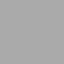

In [9]:
newpoints = np.array(mesh.nodes[mesh.regions['r1']],copy=True, order='C')
lv = lavavu.Viewer()
#plot the points before applying restoration
mesh_points = lv.points('mesh_nodes_orig',colour='red',pointsize=5)
mesh_points.vertices(newpoints)
#plot fault isosurface
mesh.lv_plot_isosurface(
        fault.interpolators['gx'].propertyname,
       colour='black',#  colour=colours[s],
        isovalue=0,
        name=fault.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
        # region="r1"
#         region="FaultSegmentRegion%i"%s
    )
newpoints  = fault.applyFault(newpoints,region='r1',steps=20)
mesh_points_rest = lv.points('mesh_nodes_restored',colour='black',pointsize=5)
mesh_points_rest.vertices(newpoints)

interp = np.zeros(mesh.properties['strati'].shape)
interp[:] = np.nan
interp[mesh.regions['r1']] = mesh.eval_interpolant(newpoints,'strati',k=200)
mesh_points_rest.values(interp,'strati')
mesh.update_property('strati_int',interp)
cmap = mesh_points_rest.colourmap(lavavu.cubehelix()) #, range=[0,0.1])

#logic = mesh.properties[fault.interpolators['gx'].propertyname][mesh.regions['r1']]>0
#np.savetxt('fault1movedpoints.txt',newpoints[logic],delimiter=',')
# newpoints = fault2.applyFault(newpoints,region='r1')
# logic = mesh.properties[fault2.interpolators['gx'].propertyname][mesh.regions['r1']]>0
# np.savetxt('fault2movedpoints.txt',newpoints[logic],delimiter=',')
lv.control.Panel()
lv.control.ObjectList()
lv.control.show()
#lv.display()

In [15]:
lv.image("./data/meshnodesorig_fault.jpg")

'./data/meshnodesorig_fault.jpg'

In [16]:
lv

{}


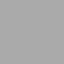

In [10]:
import lavavu
lv = lavavu.Viewer()
mesh.lv_plot_isosurface(
        fault.interpolators['gx'].propertyname,
       colour='black',#  colour=colours[s],
        isovalue=0,
        name=fault.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
         region="r1"
#         region="FaultSegmentRegion%i"%s
    )
# mesh.lv_plot_isosurface(
#         'strati',#fault.interpolators['gx'].propertyname,
# #         colour=colours[s],
#         isovalue=0,
#         name='stratigraphy',#fault.interpolators['gx'].propertyname,
#         interactive=False,
#         lv=lv,
#         draw=False,
# #         region="FaultSegmentRegion%i"%s
#     )
strati = mesh.properties['strati_int']
strati=strati[~np.isnan(strati)]
for s in np.linspace(np.min(strati),np.max(strati),10):#i in range(-10,10,2):
    mesh.lv_plot_isosurface(
            'strati_int',#fault.interpolators['gx'].propertyname,
    #         colour=colours[s],
            isovalue=s,
            name='stratigraphy_faulted%f'%s,#fault.interpolators['gx'].propertyname,
            interactive=False,
            lv=lv,
            draw=False,
            region="r1"
        )
# surf = lv.triangles("strati_int",colour='green')
# surf.vertices(stratinodes)
# surf.indices(stratitris)

# surf = lv.triangles("fault",colour='blue')
# surf.vertices(faultnodes)
# surf.indices(faulttris)

# points = lv.points("points",pointsize=4,pointtype="sphere",colour='red')
# points.vertices(mesh.nodes[mesh.elements[logic]])


lv.control.Panel()
lv.control.ObjectList()
lv.control.show()
#lv.display()

In [ ]:
# lv.rotate('x',-90)
for k in lv.objects.keys():
    lv.objects[k]['lit'] = True
    lv.objects[k]['lightpos']=[1,0.1,2.]#True
    lv.objects[k]['flat']=True

# lv.objects['stratigraphy_faulted-1.100694']['contrast'] = 1.

# lv.objects['stratigraphy_faulted-1.100694']['lit']=False
# # lv.objects['stratigraphy_faulted-1.100694']['flat']=True
# # lv.objects['stratigraphy_faulted-1.100694']['glyphs']=2
# # lv.objects['stratigraphy_faulted-1.100694']['opaque']=True
# # lv.objects['stratigraphy_faulted-1.100694']['vertexnormals']=False
# lv.objects['stratigraphy_faulted-1.100694']['lightpos']=[1,0.1,2.]#True

lv.rotation(-61.236297607421875,-1.9830615520477295,2.694277763366699)

lv.display()

In [ ]:
lowx = -4
highx = 4
logic = mesh.nodes[:,0]<lowx#np.logical_or(mesh.nodes[:,0]>highx,mesh.nodes[:,0]<lowx)
mesh.regions['overlap'] = logic
# mesh.indices = np.array(range(0,mesh.n_nodes))
# sharedindices = mesh.indices[logic]
# node_values = mesh.properties['gx1'][mesh.indices[logic]]
# As = np.zeros(node_values.shape)
# As[:] = 1

fault2 = FaultSegment(mesh=mesh,name='FaultSegment2',shape='square')

fault2.add_strike_dip_and_value([10.22,1.31,roof],strike=180,dip=70,val=0,itype='gx')

# fault2.add_point([2.5,.5,1.5],0.,itype='gz')
# fault2.add_point([2.5,-.5,1.5],1.,itype='gz')
fault2.overlapFaultSegments(fault,mesh.regions['overlap'])
fault2.buildFaultFrame(solver='chol',shape='square')


fault2.buildFaultDisplacementField(dm=5)#dm=1#,overprint='yes')


                            

Setting up interpolator with 1 value control points 
        1 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


In [ ]:
# newpoints = np.array(mesh.nodes[mesh.regions['r1']],copy=True, order='C')
newpoints  = fault2.applyFault(newpoints,region='r1',steps=20)
logic = mesh.properties[fault2.interpolators['gx'].propertyname][mesh.regions['r1']]>0

interp = np.zeros(mesh.properties['strati'].shape)
interp[:] = np.nan
interp[mesh.regions['r1']] = mesh.eval_interpolant(newpoints,'strati',k=200)
mesh.update_property('strati_int',interp)

In [ ]:
import lavavu
lv = lavavu.Viewer()
mesh.properties['overlap'] = mesh.regions['overlap'].astype(float)
mesh.lv_plot_isosurface(
        fault.interpolators['gx'].propertyname,
       colour='black',#  colour=colours[s],
        isovalue=0,
        name=fault.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
#          region="r1"
#         region="FaultSegmentRegion%i"%s
    )
mesh.lv_plot_isosurface(
        'overlap',
#         colour=colours[s],
        isovalue=0,#np.mean(mesh.properties[fault.interpolators['gx'].propertyname]),
        name='overlap',
        interactive=False,
        lv=lv,
        draw=False,
#          region="r1"
#         region="FaultSegmentRegion%i"%s
    )
mesh.lv_plot_isosurface(
        fault2.interpolators['gx'].propertyname,
       colour='black',#  colour=colours[s],
        isovalue=0,
        name=fault2.interpolators['gx'].propertyname,
        interactive=False,
        lv=lv,
        draw=False,
#          region="r1"
#         region="FaultSegmentRegion%i"%s
    )
# mesh.lv_plot_isosurface(
#         'strati',#fault.interpolators['gx'].propertyname,
# #         colour=colours[s],
#         isovalue=0,
#         name='stratigraphy',#fault.interpolators['gx'].propertyname,
#         interactive=False,
#         lv=lv,
#         draw=False,
# #         region="FaultSegmentRegion%i"%s
#     )
# strati = mesh.properties['strati_int']
# strati=strati[~np.isnan(strati)]
for s in np.linspace(np.min(strati),np.max(strati),10):#i in range(-10,10,2):
    mesh.lv_plot_isosurface(
            'strati_int',#fault.interpolators['gx'].propertyname,
    #         colour=colours[s],
            isovalue=s,
            name='stratigraphy_faulted%f'%s,#fault.interpolators['gx'].propertyname,
            interactive=False,
            lv=lv,
            draw=False,
            region="r1"
        )
# surf = lv.triangles("strati_int",colour='green')
# surf.vertices(stratinodes)
# surf.indices(stratitris)

# surf = lv.triangles("fault",colour='blue')
# surf.vertices(faultnodes)
# surf.indices(faulttris)

# points = lv.points("points",pointsize=4,pointtype="sphere",colour='red')
# points.vertices(mesh.nodes[mesh.elements[logic]])


lv.control.Panel()
lv.control.ObjectList()
lv.control.show()